# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/0rep_0noiseLevel_Convenience_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 4
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
       0.25   0.309024        0.200910  0.050625  0.282856  0.036674   
       0.50   0.314998        0.201694  0.051938  0.248202  0.068270   
       0.75   0.319643        0.202074  0.053558  0.211119  0.098298   
       1.00   0.323500        0.202147  0.055336  0.177911  0.120674   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
       0.25  0.198163  0.008009  0.039752  0.052301  0.000301  
       0.50  0.195577  0.006902  0.038297  0.056433  0.001051  
       0.75  0.194766  0.007115  0.036048  0.061353  0.002141  
       1.00  0.195942  0.007820  0.033196  0.067118  0.003531

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.00   0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25   0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50   0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75   0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00   0.285682        0.204435  0.076846  0.085674  0.193388   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.00  0.200000  0.010000  0.040000  0.050000  0.000000  
         0.25  0.194292  0.011434  0.039765  0.052914  0.000130  
         0.50  0.184541  0.014747  0.037935  0.060579  0.000468  
         0.75  0.174893  0.018155  0.034722  0.072187  0.000997  
         1.00  0.164537  0.021526  0.030790  0.086852  0.001739

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.00  5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.25  4.568047e+06  2.339239e+06  216501.990022  1.413483e+06   
         0.50  5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         0.75  5.858245e+06  4.161080e+06  418715.475569  2.735644e+06   
         1.00  6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   

                                                                         \
                         PMK           PMD          GPPS            Idi   
Strain   Time                                                             
Strain 1 0.00      26.599588  5.448132e+01  5.547215e+01      18.687782   
         0.25  473518.755617  2.301051e+06  2.600509e+06  428799.016790   
         0.50  724132.403320  3.761395e+06  3.265182e+06  639992.856400   
         0.75  879253.836051  4.770619e+06  3.569278e+06  765704.580833   
         1.00  984727.523254  5.509792e+06  3.743605e+06  849097.962158   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.00         30.341080  
         0.25     183705.772400  
         0.50     286614.273964  
         0.75     352427.155323  
         1.00     398139.231561

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


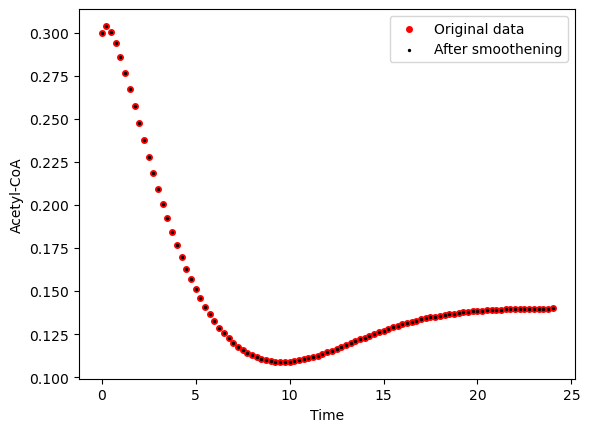

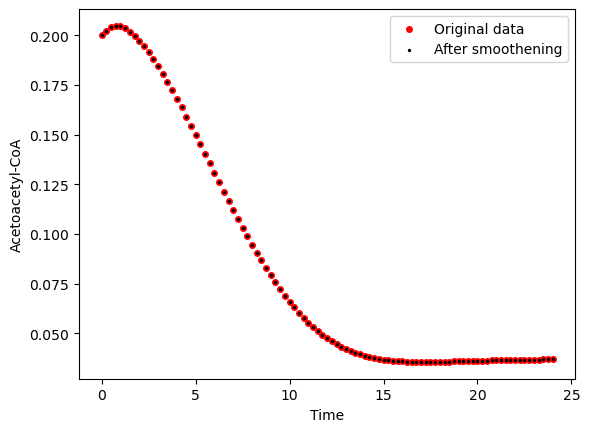

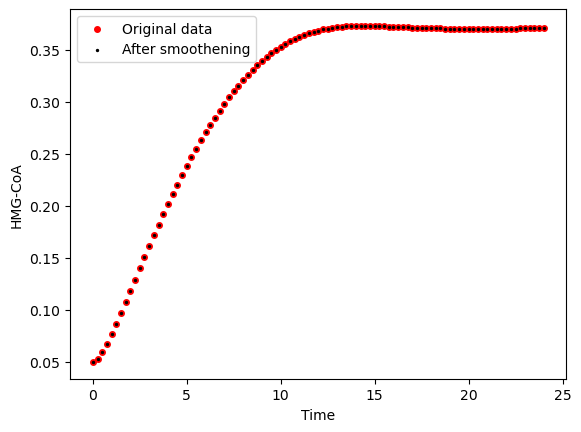

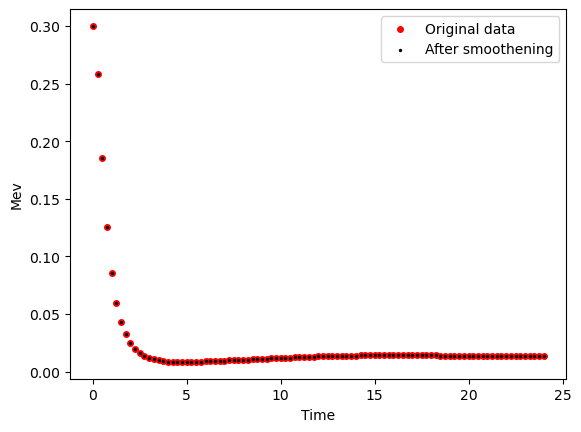

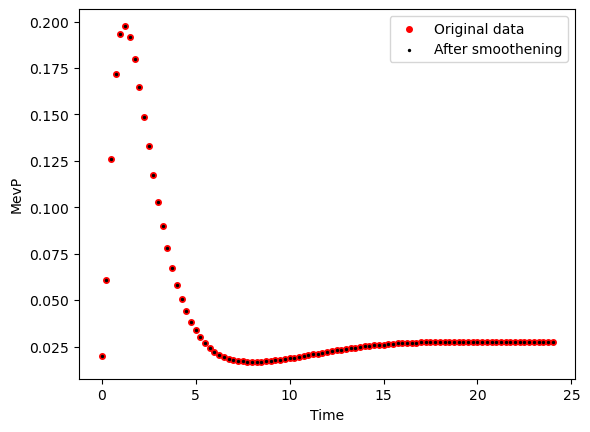

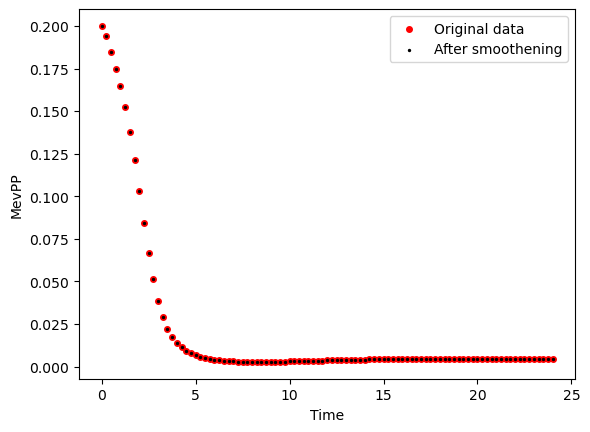

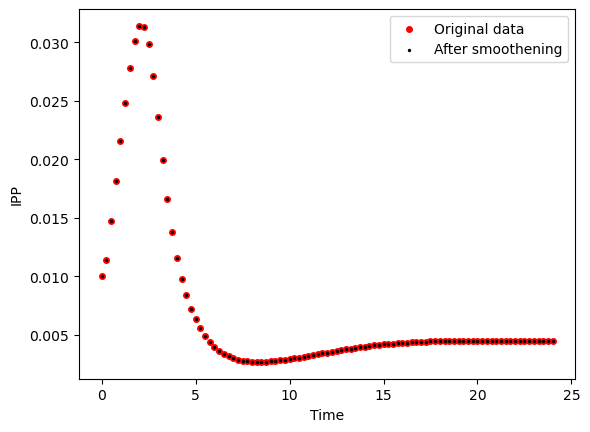

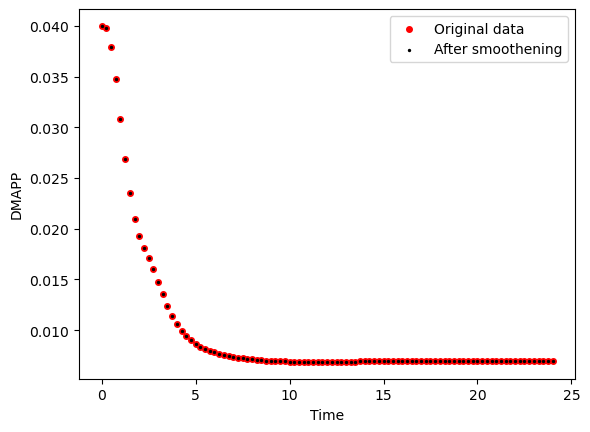

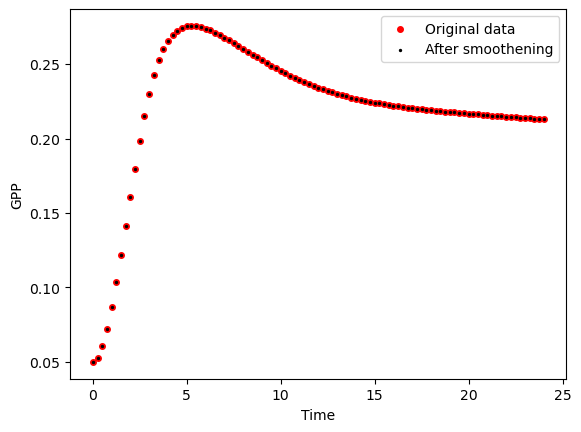

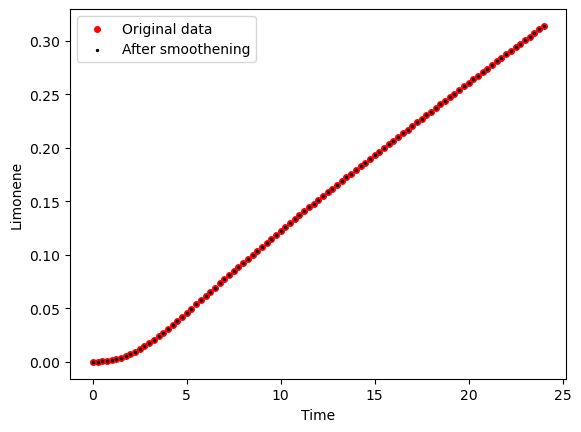

Strain Strain 2


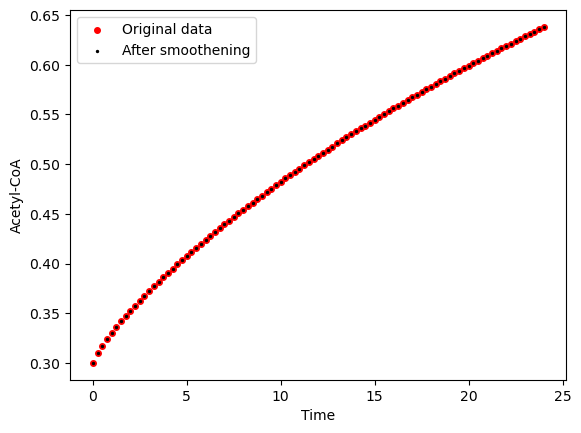

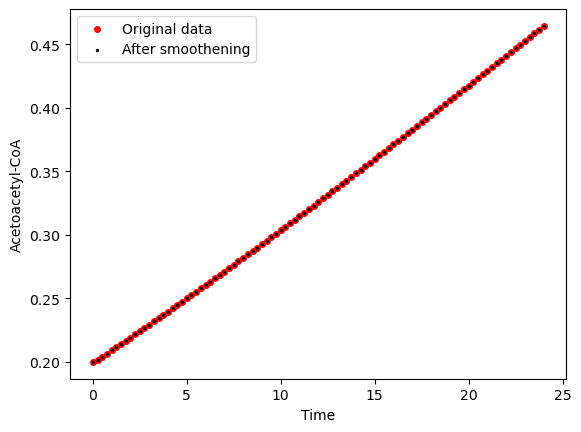

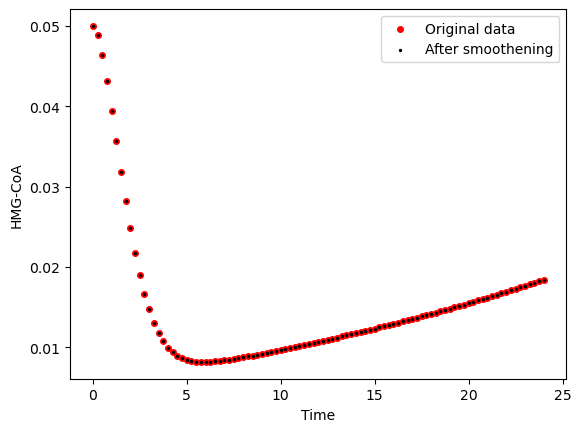

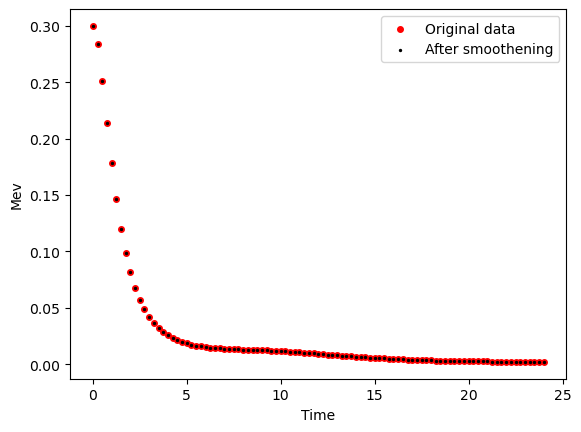

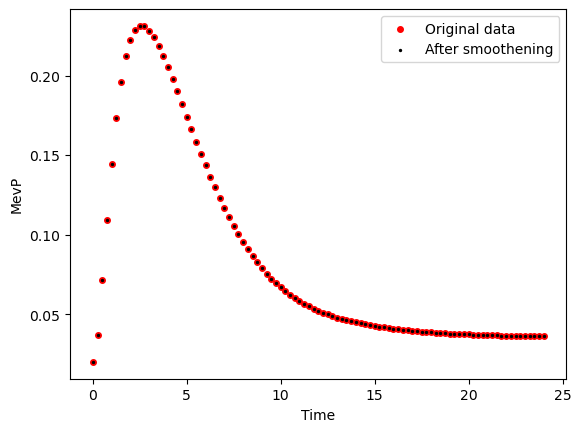

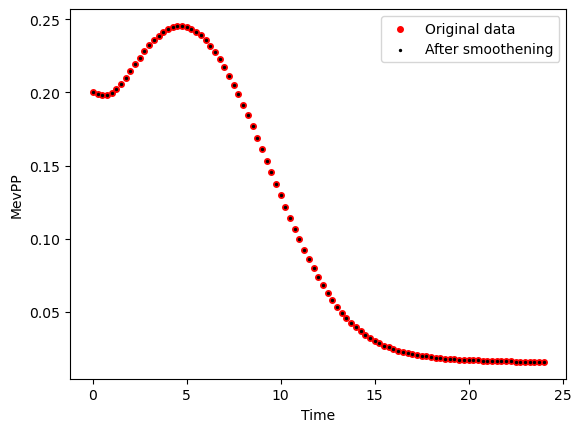

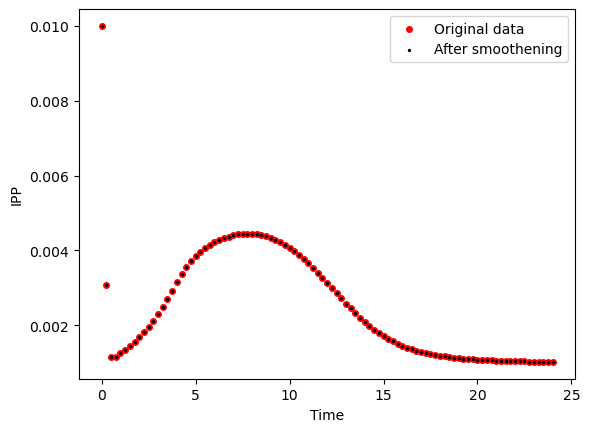

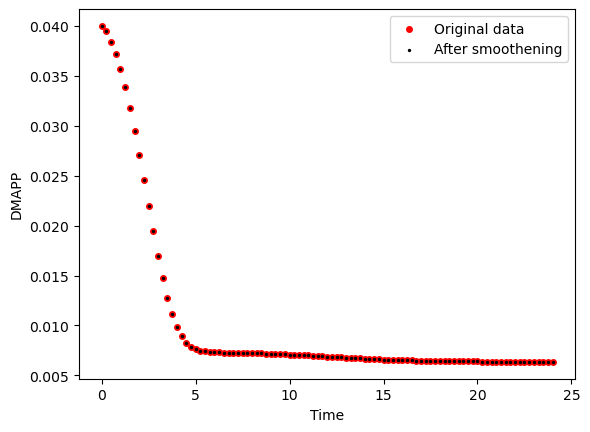

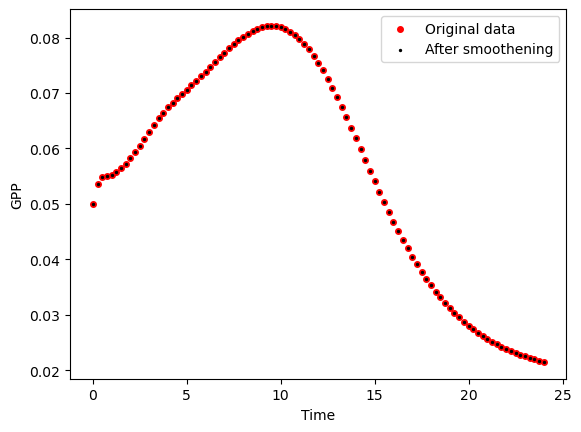

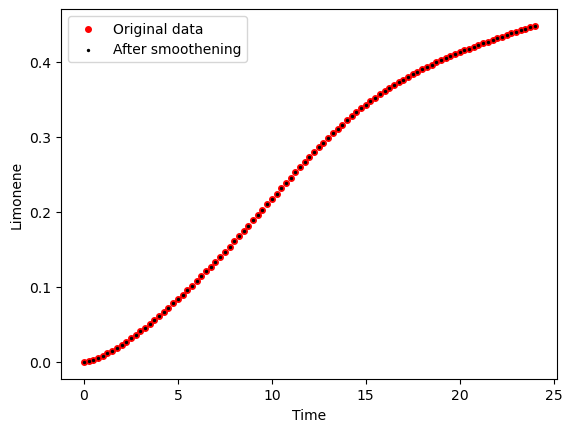

Strain Strain 3


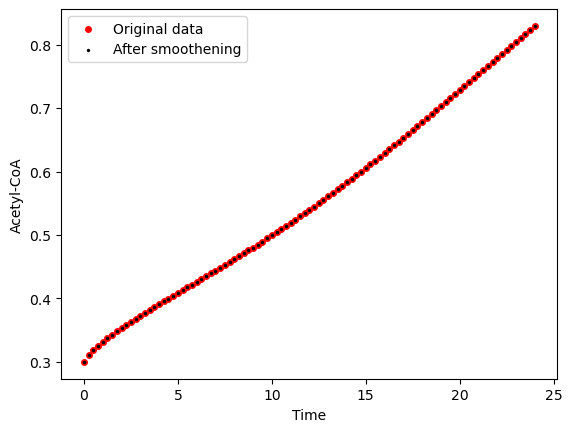

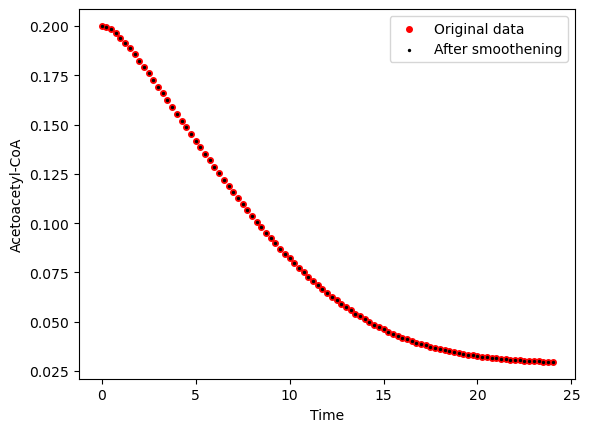

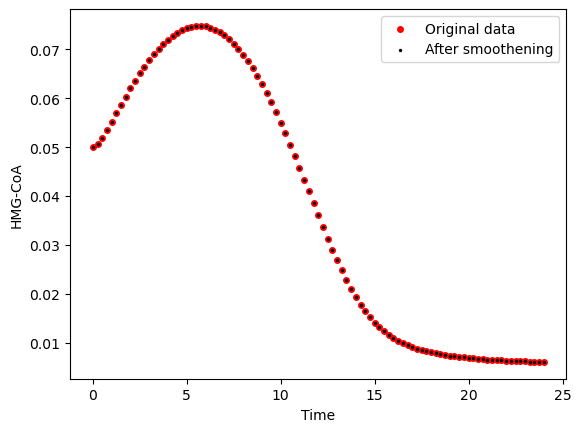

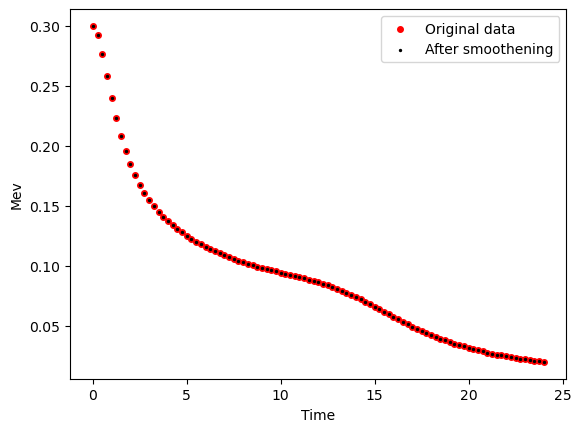

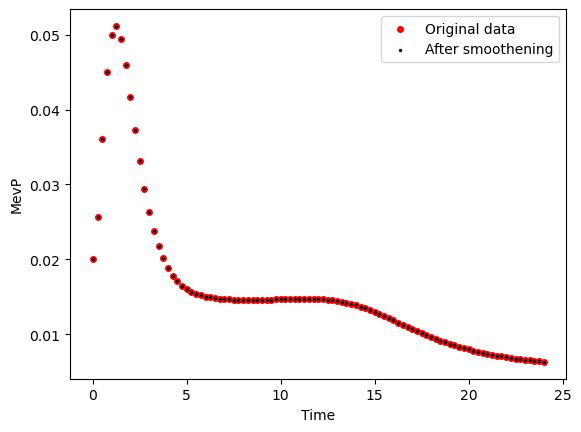

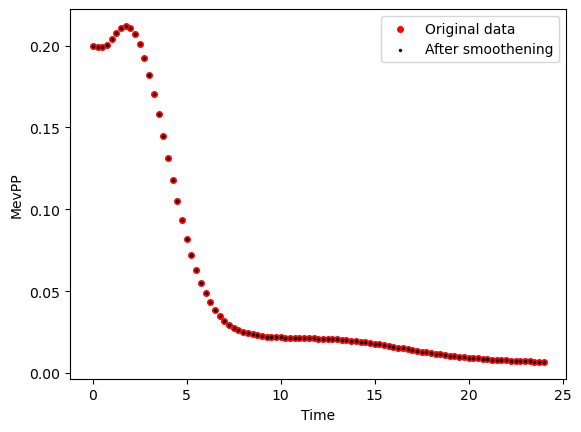

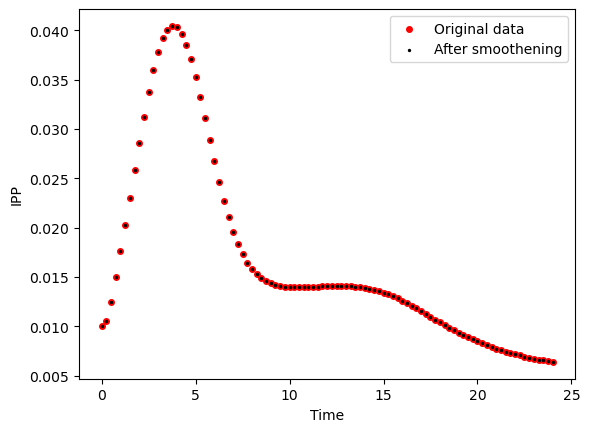

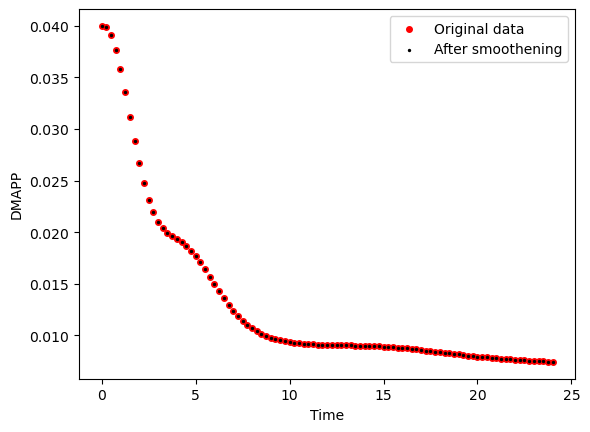

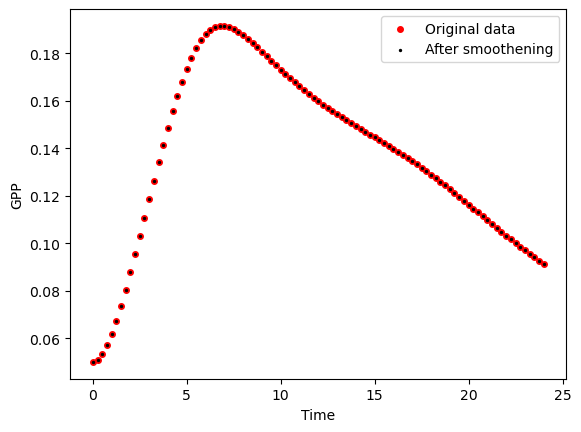

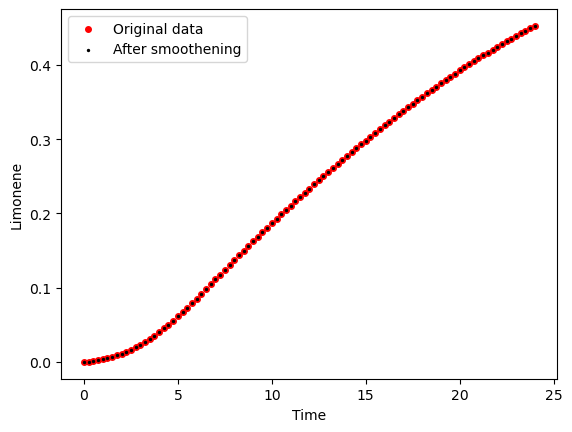

Strain WT


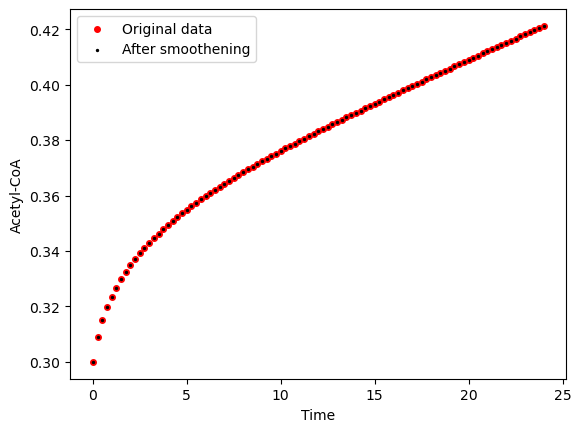

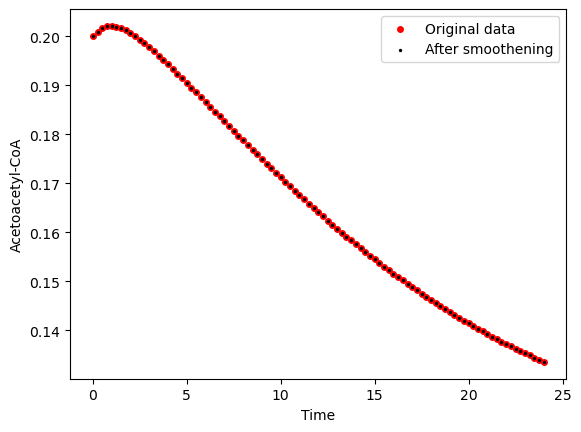

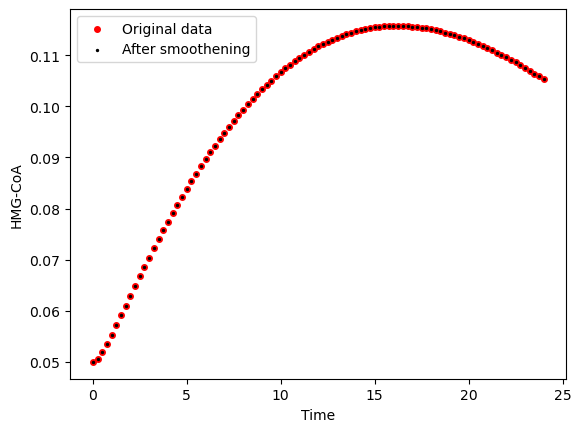

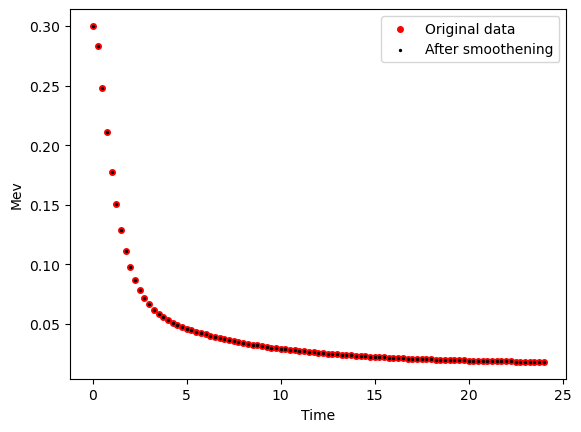

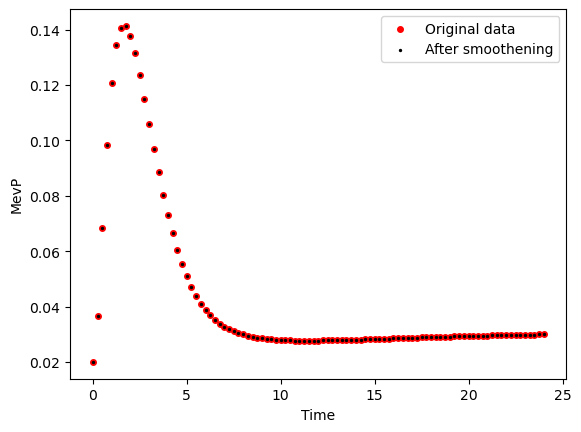

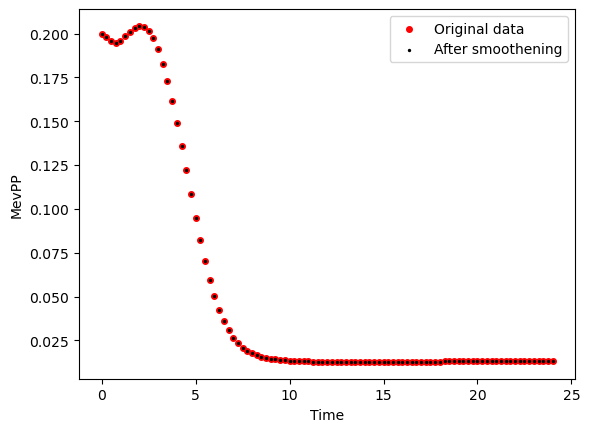

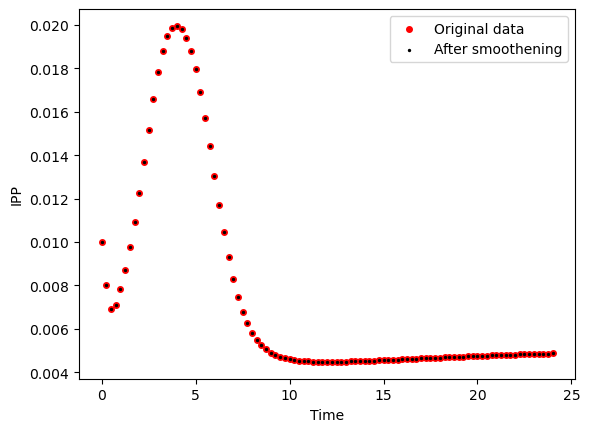

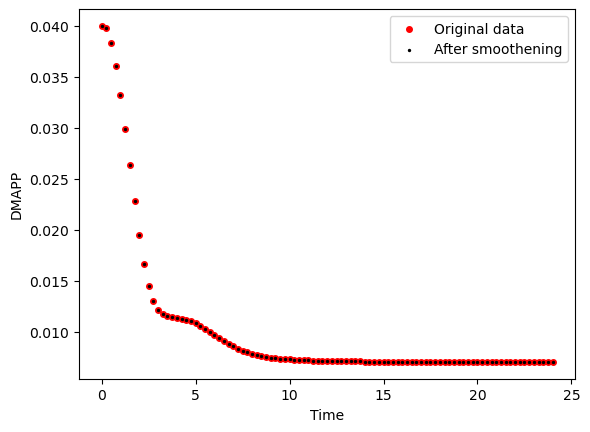

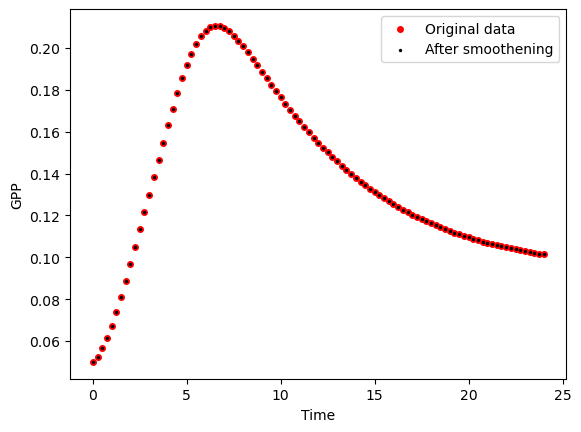

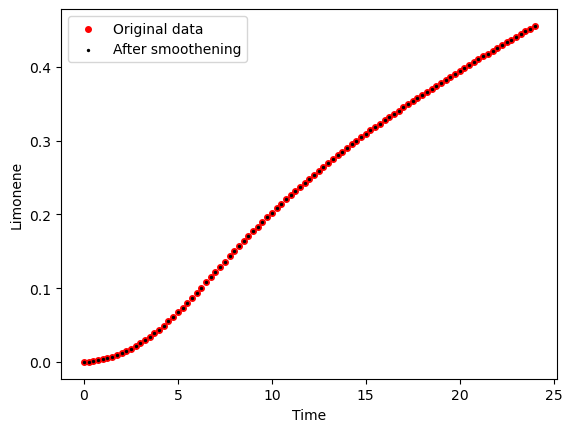

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


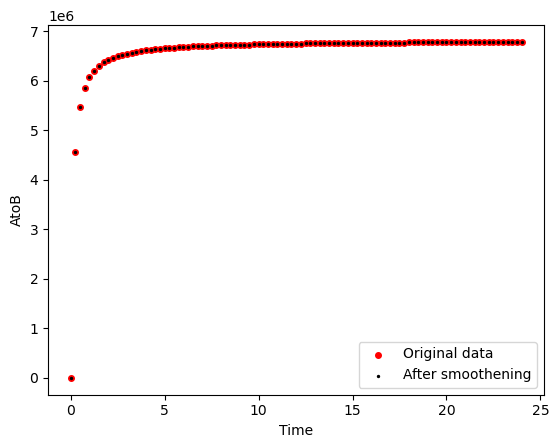

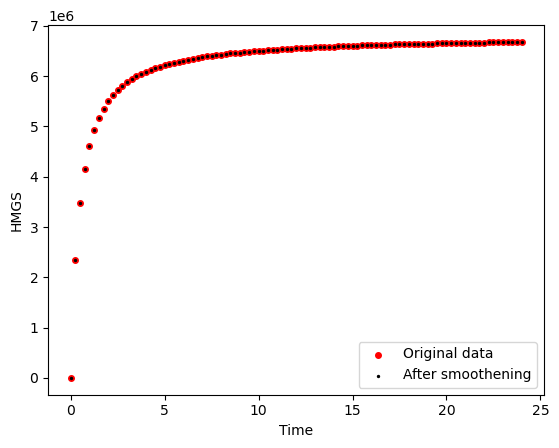

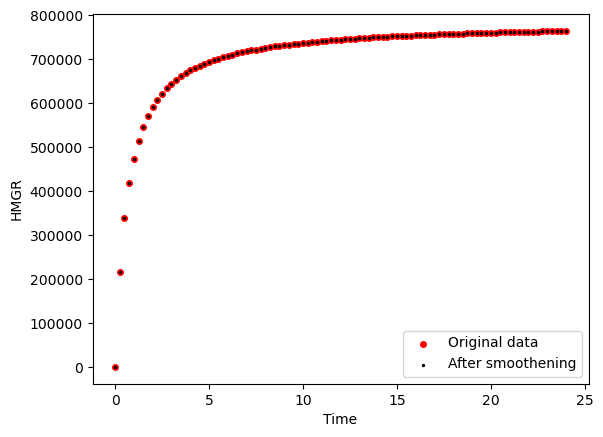

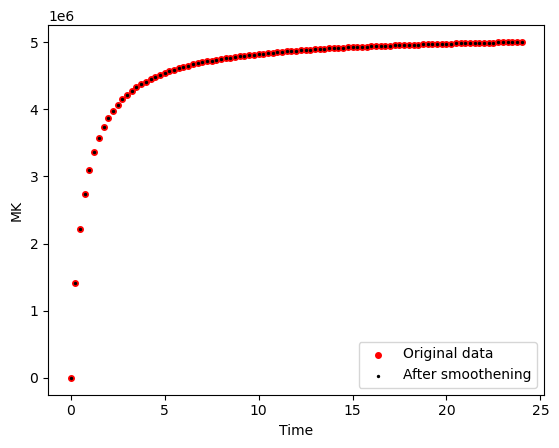

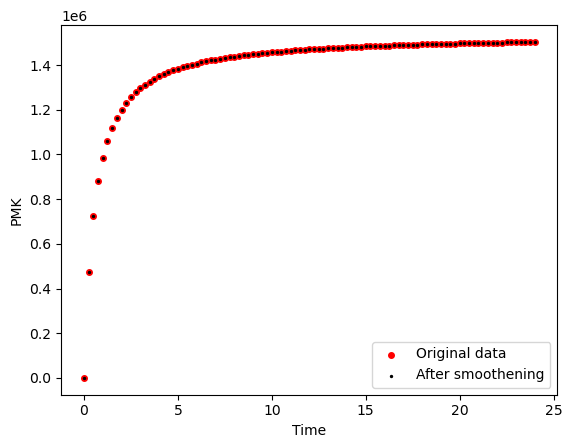

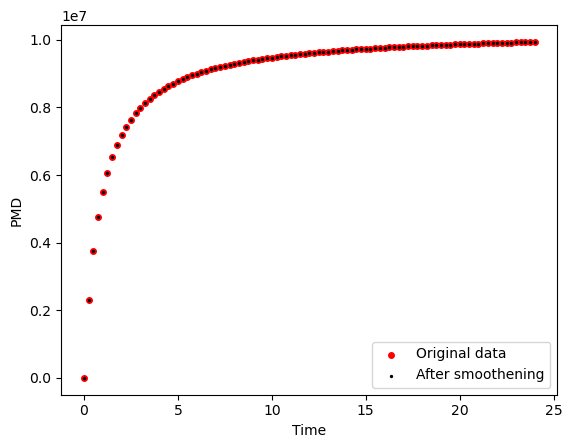

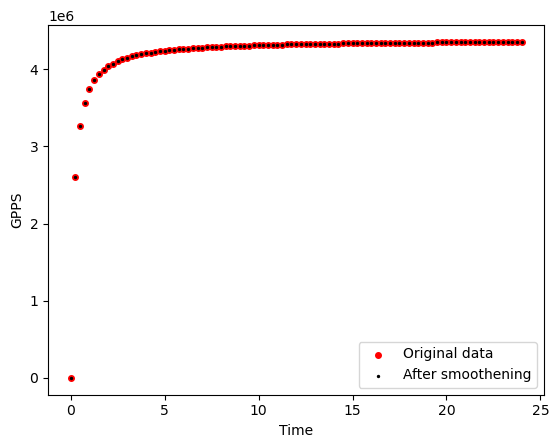

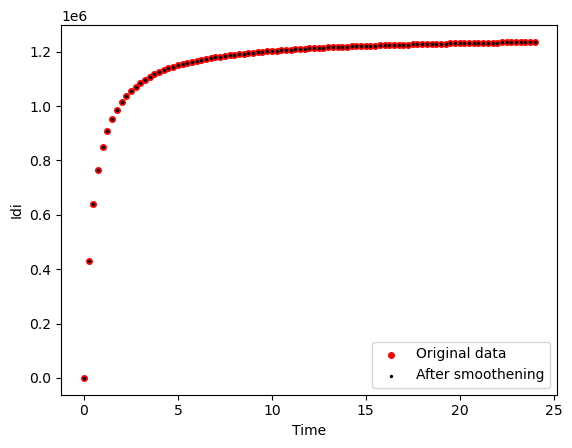

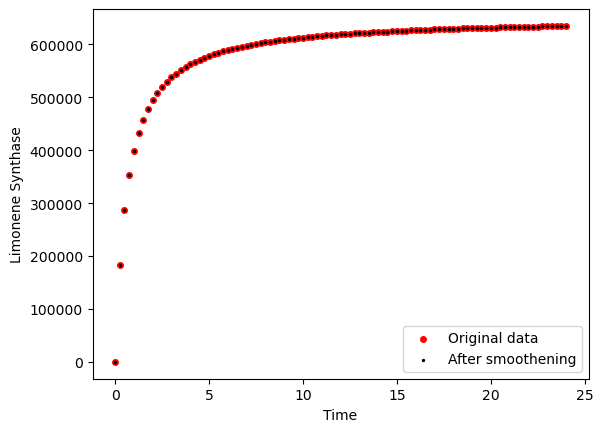

Strain Strain 2


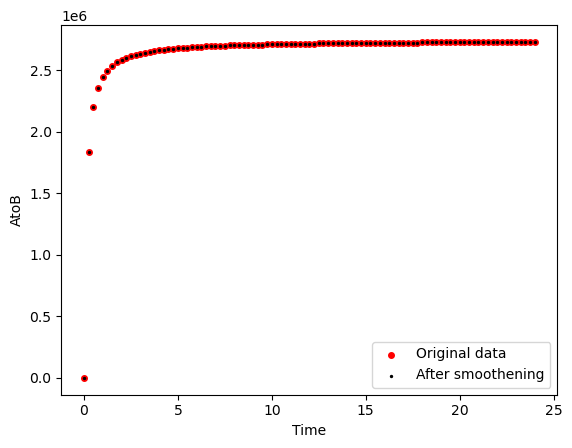

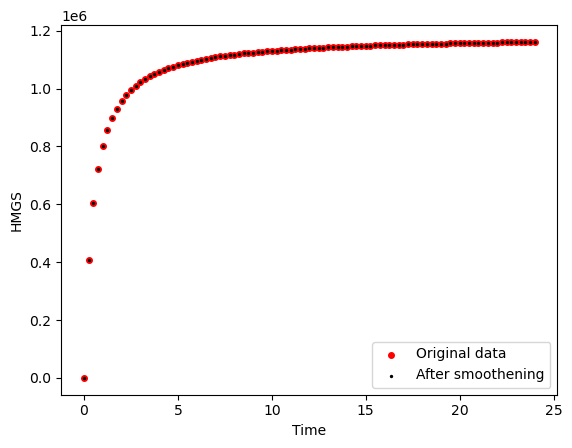

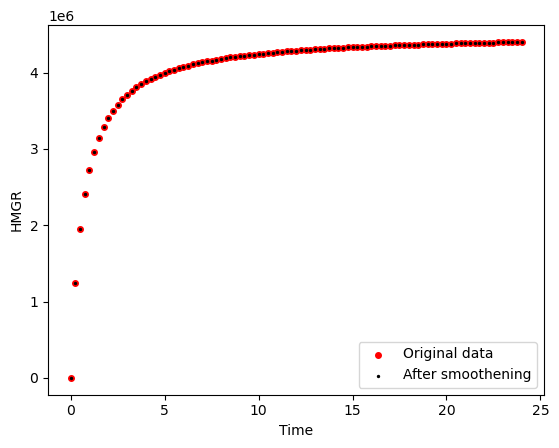

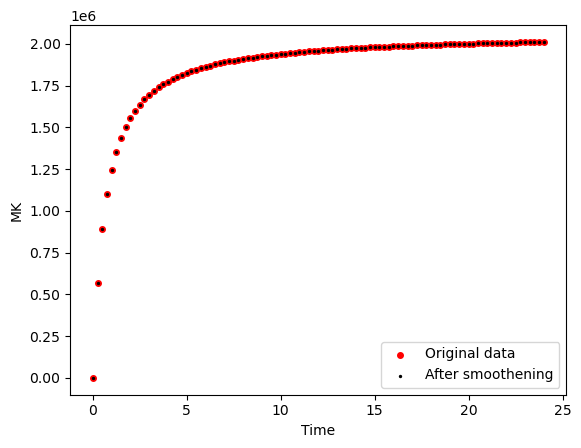

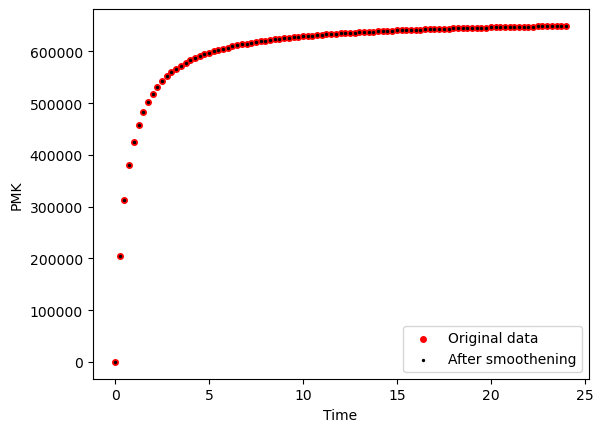

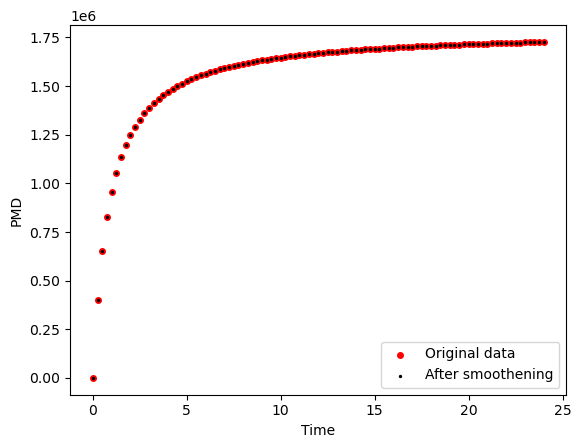

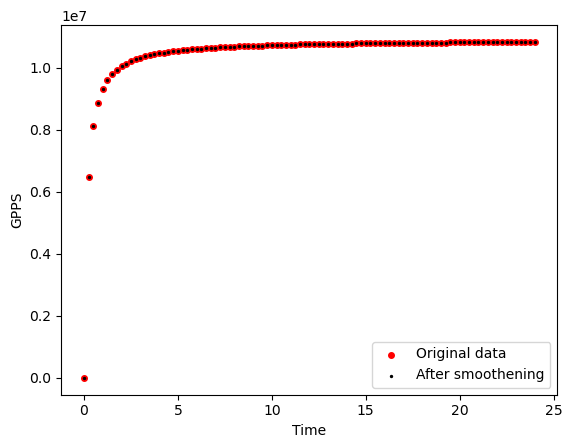

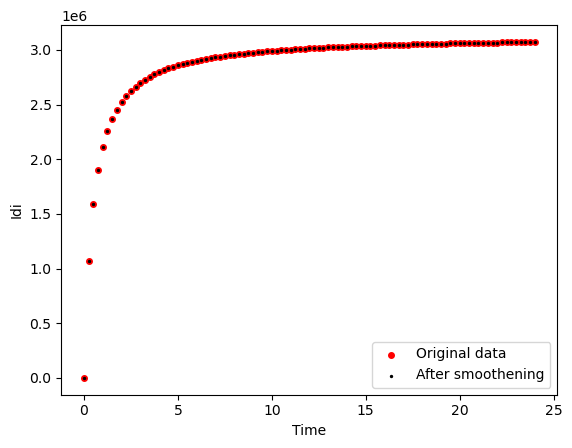

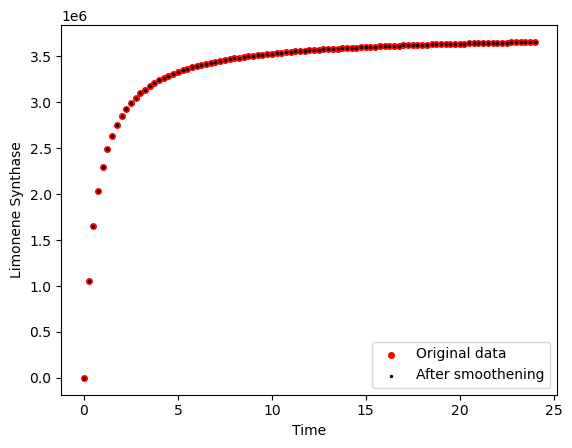

Strain Strain 3


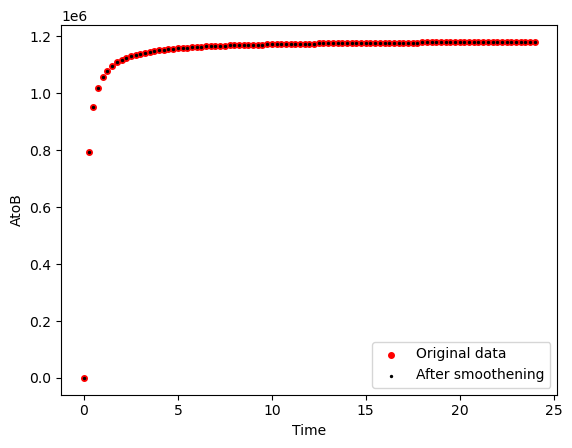

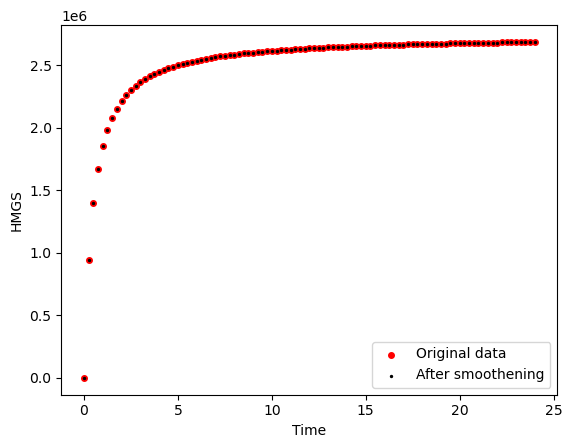

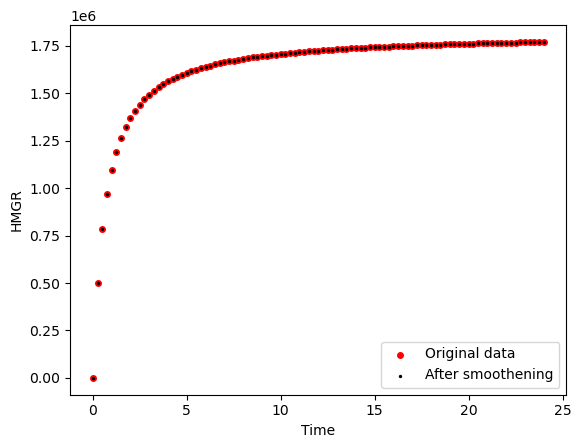

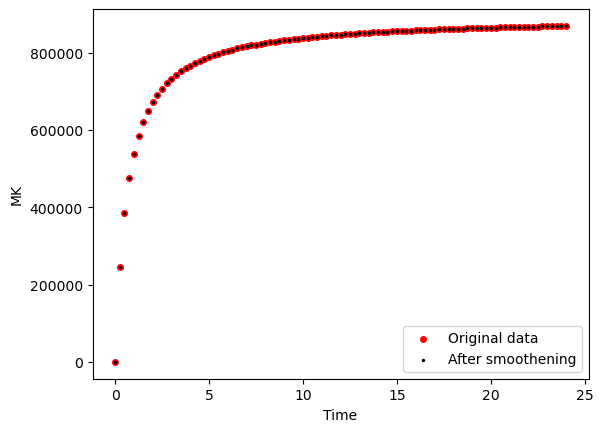

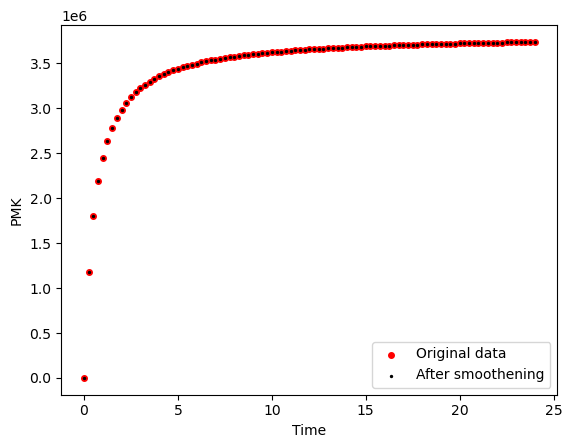

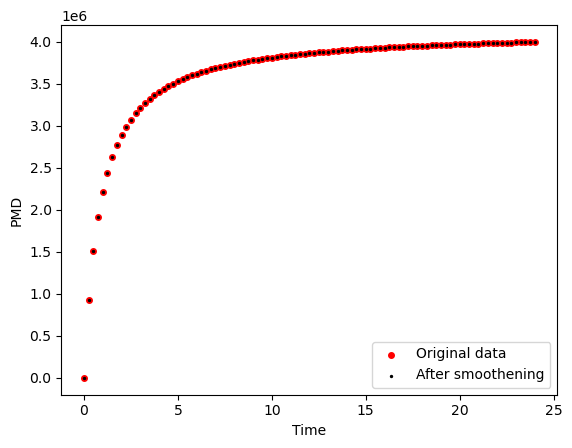

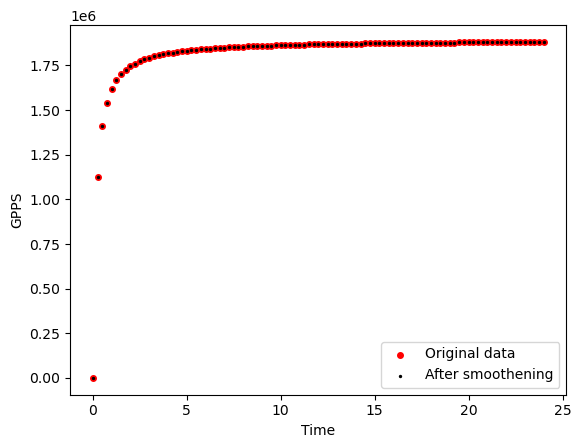

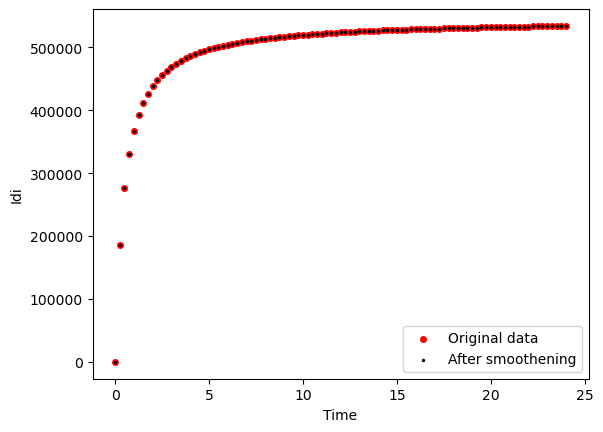

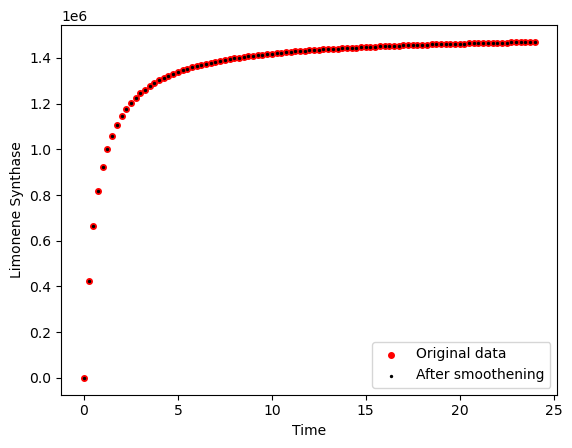

Strain WT


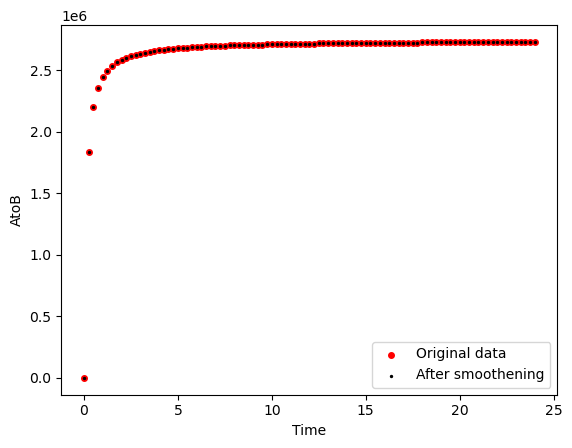

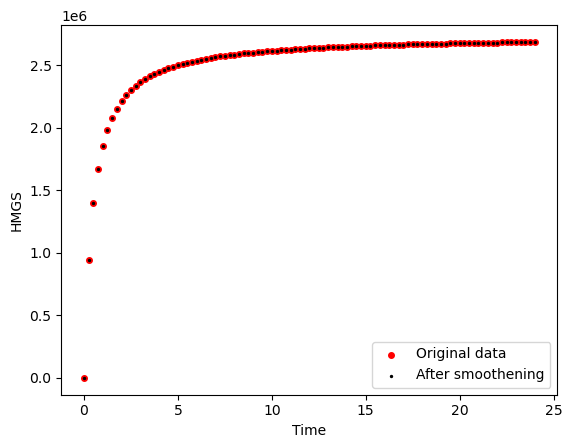

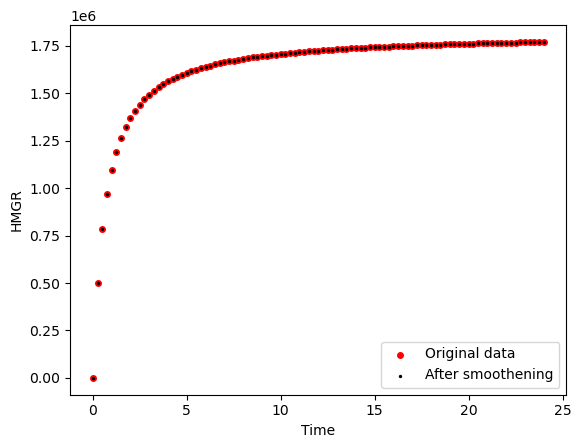

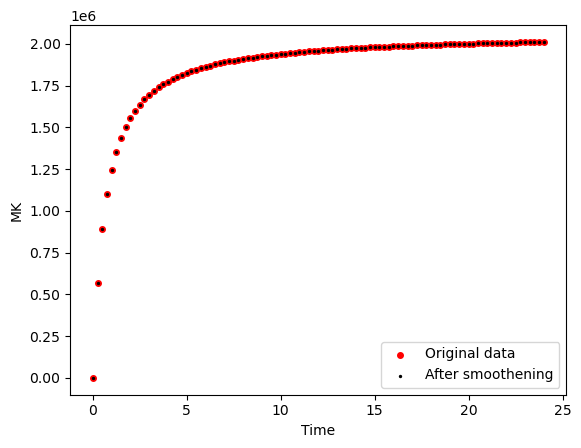

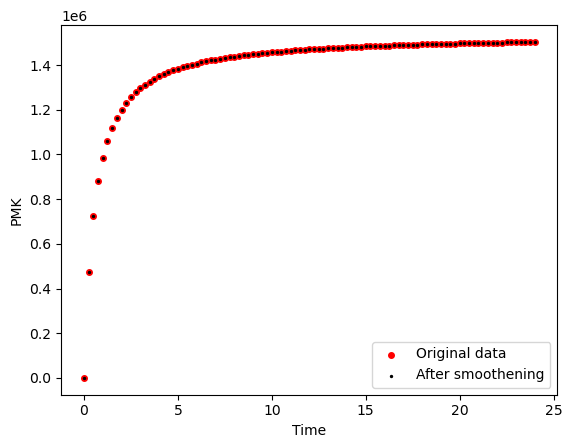

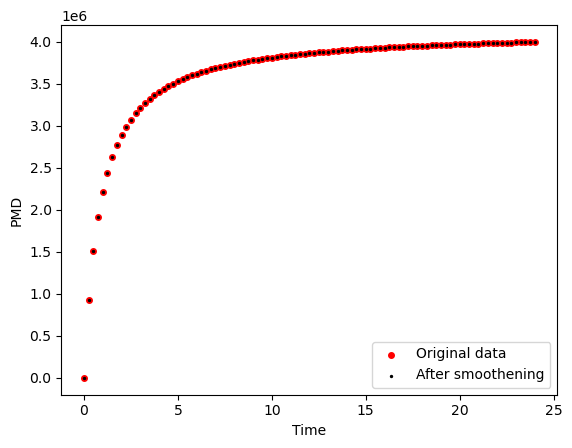

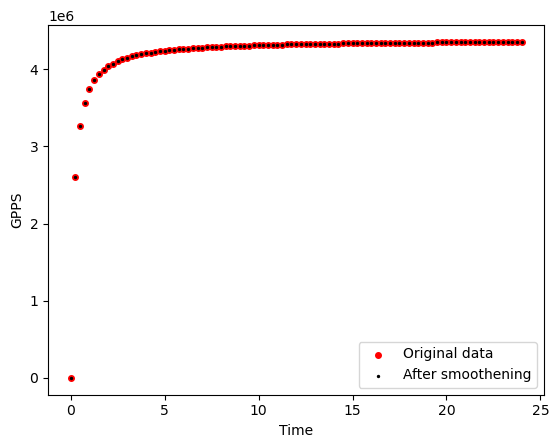

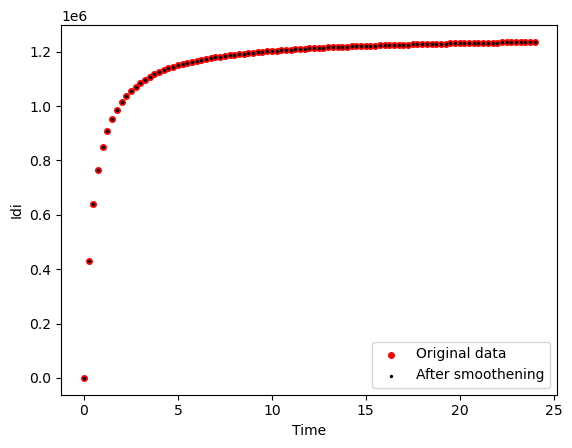

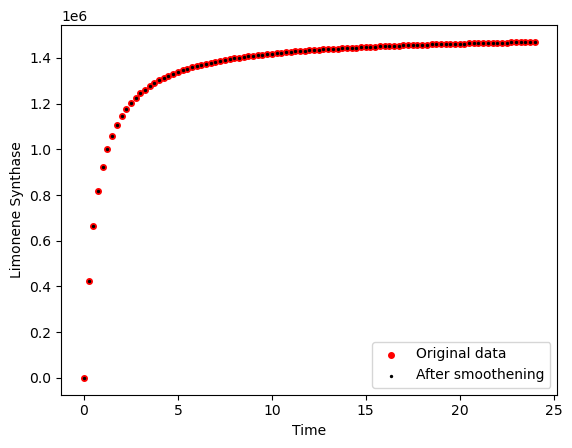

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.00    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.25    0.303889        0.202239  0.052901  0.257973  0.060732   
         0.50    0.300366        0.204051  0.059318  0.185505  0.126153   
         0.75    0.293825        0.204705  0.067553  0.125893  0.171899   
         1.00    0.285682        0.204435  0.076846  0.085674  0.193388   
...                   ...             ...       ...       ...       ...   
WT       23.00   0.418135        0.135344  0.107524  0.018433  0.029820   
         23.25   0.418894        0.134891  0.106975  0.018376  0.029853   
         23.50   0.419652        0.134446  0.106413  0.018321  0.029884   
         23.75   0.420408        0.134009  0.105838  0.018268  0.029914   
         24.00   0.421163        0.133581  0.105252  0.018217  0.029943   

                                                                  ...  \
                   MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                     ...   
Strain 1 0.00   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.25   0.194292  0.011434  0.039765  0.052914  0.000130  ...   
         0.50   0.184541  0.014747  0.037935  0.060579  0.000468  ...   
         0.75   0.174893  0.018155  0.034722  0.072187  0.000997  ...   
         1.00   0.164537  0.021526  0.030790  0.086852  0.001739  ...   
...                  ...       ...       ...       ...       ...  ...   
WT       23.00  0.013294  0.004839  0.007023  0.102943  0.440720  ...   
         23.25  0.013307  0.004846  0.007023  0.102536  0.444453  ...   
         23.50  0.013319  0.004852  0.007023  0.102148  0.448172  ...   
         23.75  0.013331  0.004858  0.007022  0.101776  0.451879  ...   
         24.00  0.013342  0.004864  0.007022  0.101420  0.455574  ...   

               derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

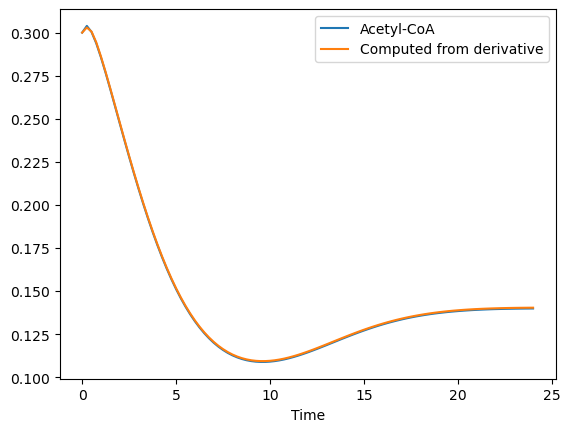

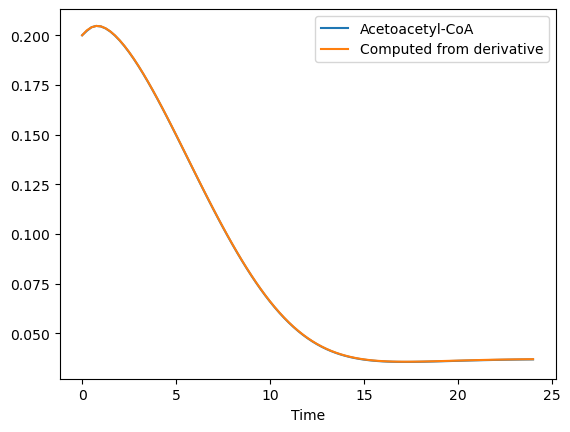

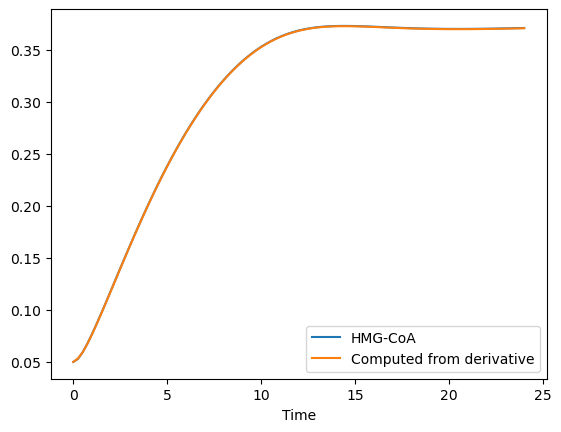

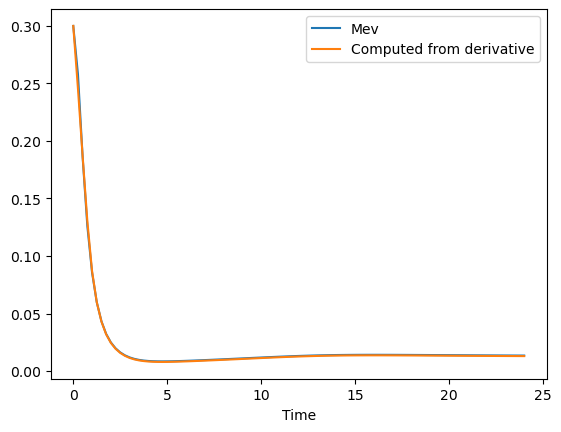

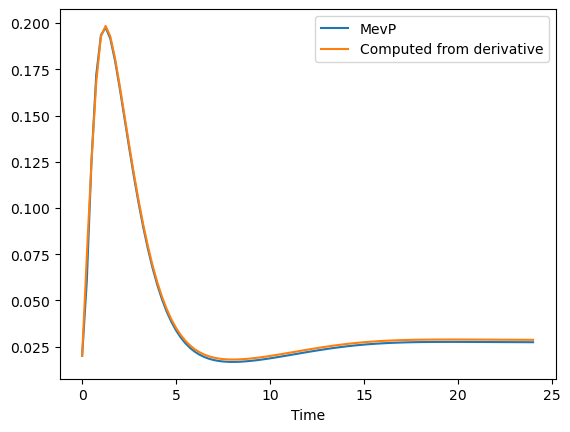

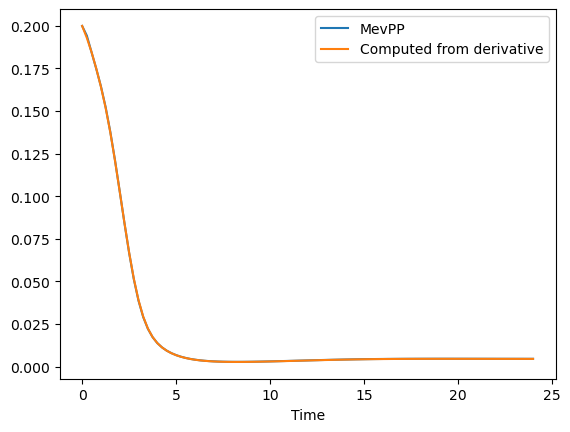

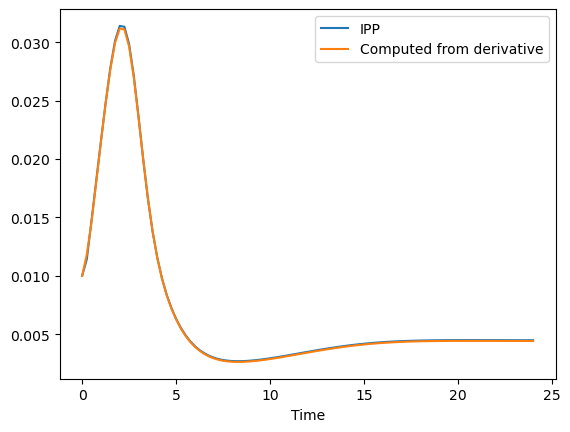

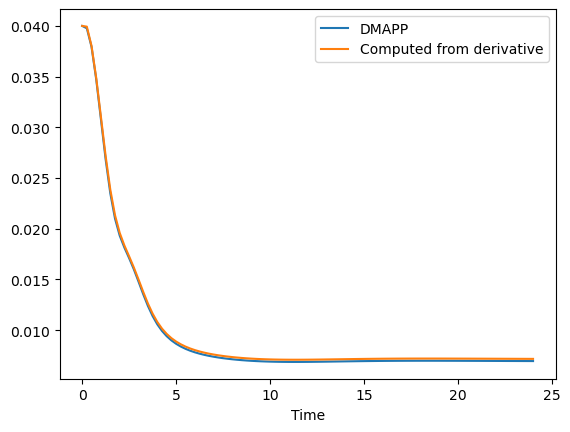

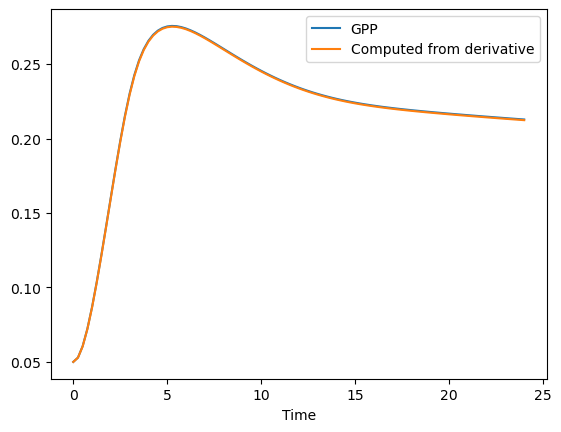

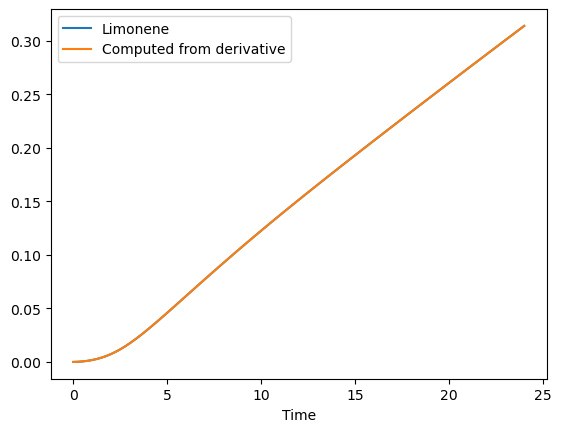

'Time profile from derivative vs. actual profile for Strain 2'

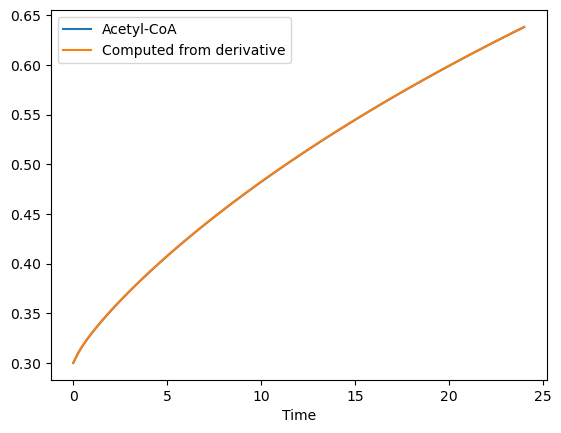

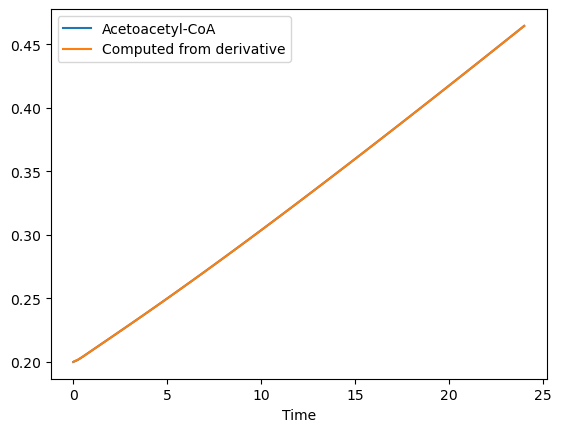

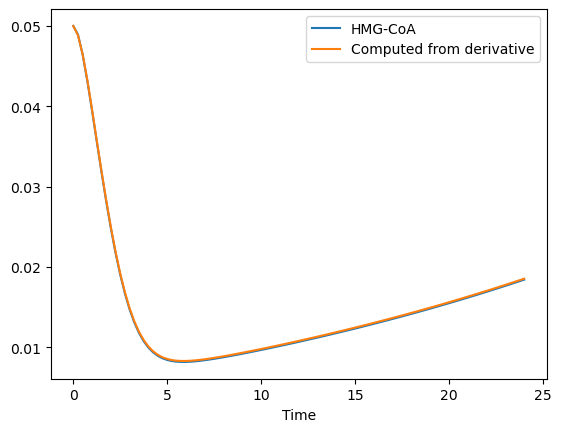

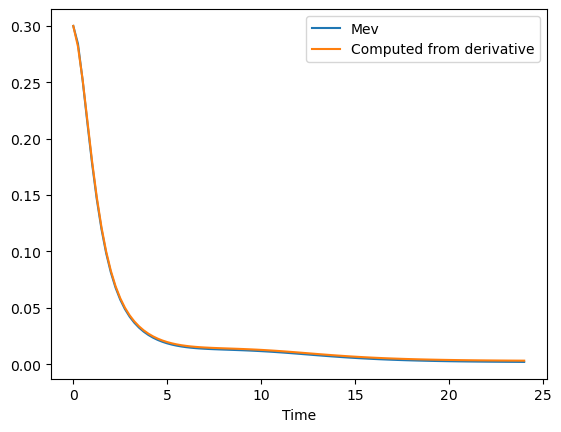

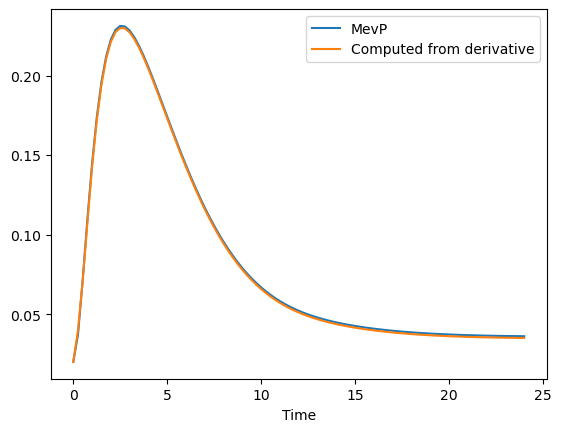

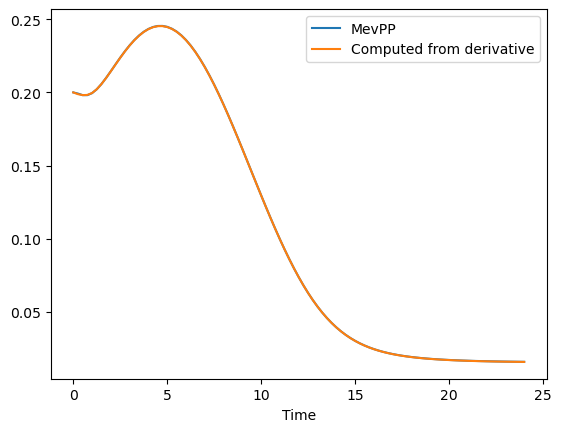

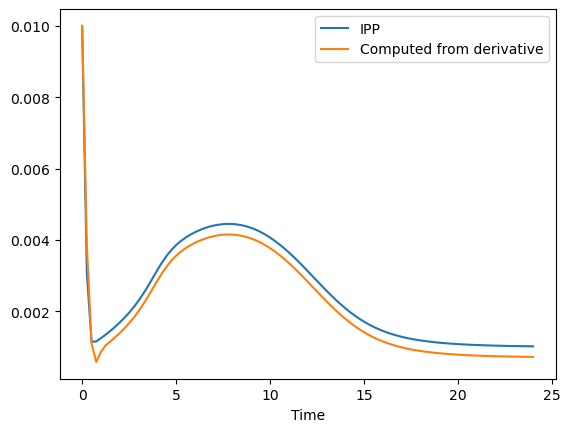

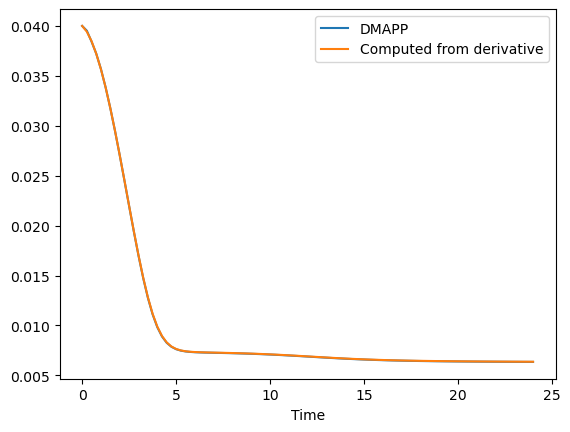

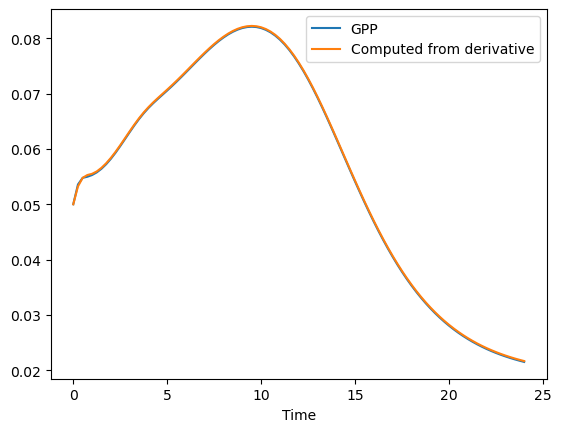

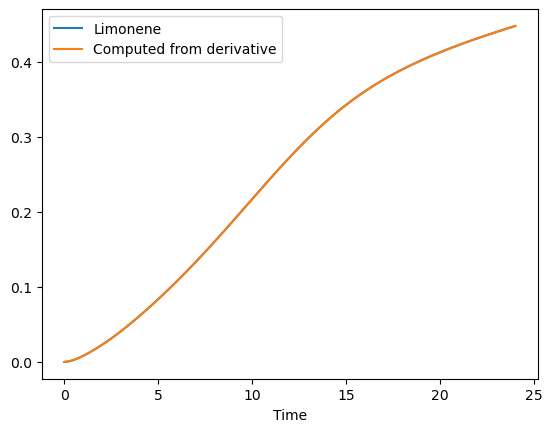

'Time profile from derivative vs. actual profile for Strain 3'

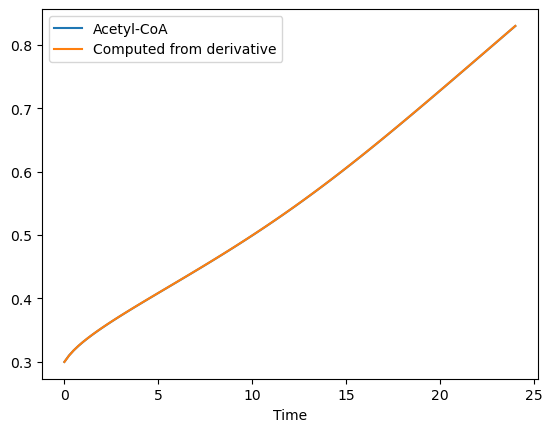

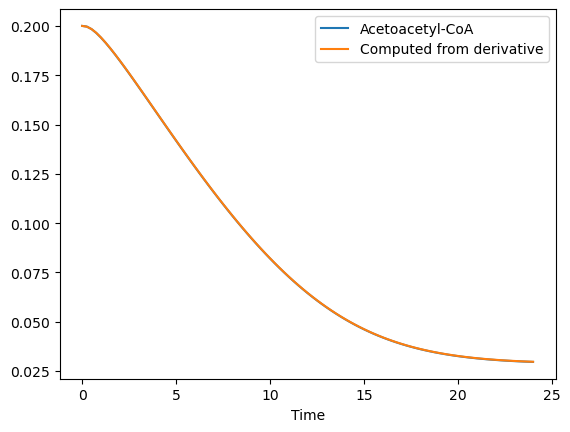

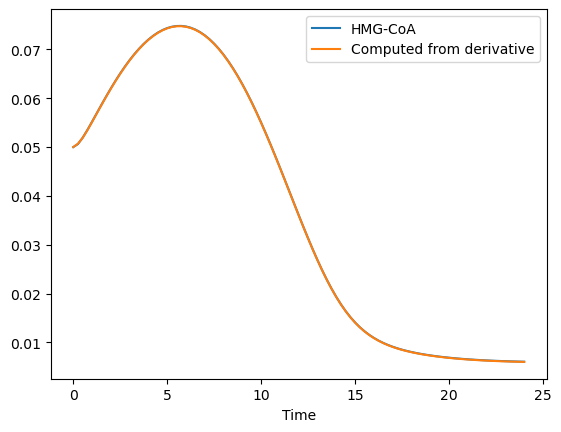

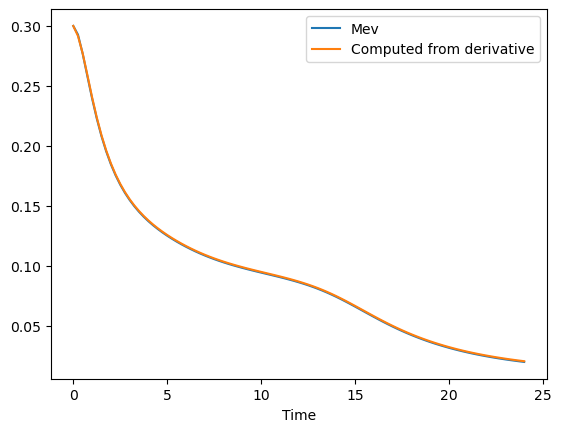

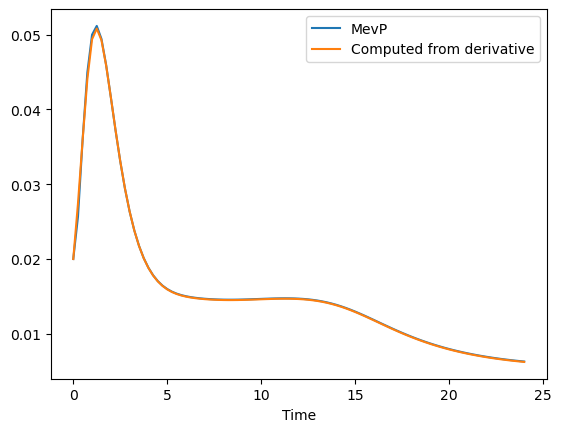

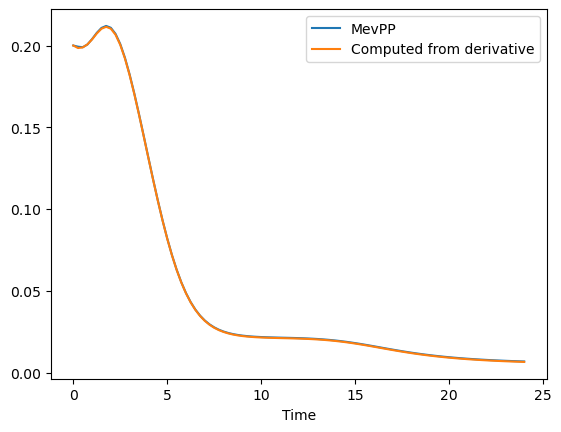

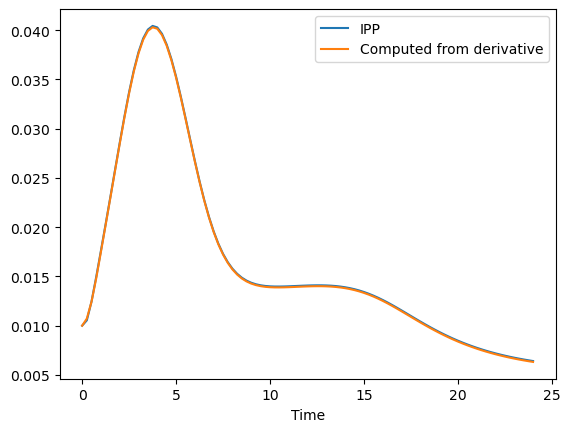

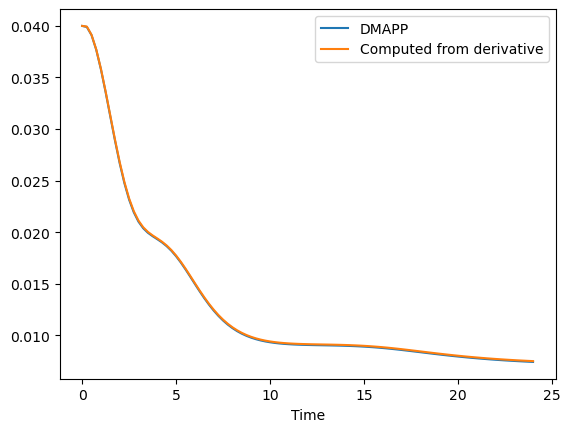

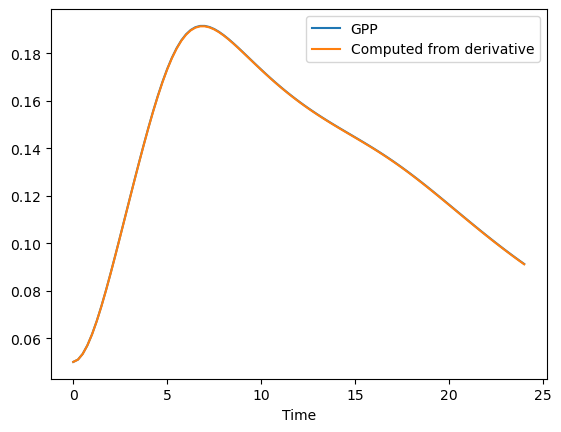

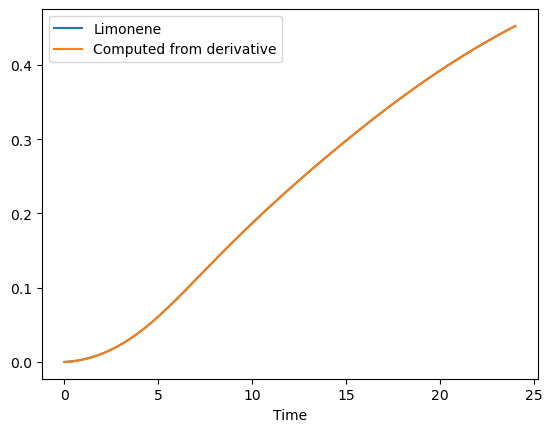

'Time profile from derivative vs. actual profile for WT'

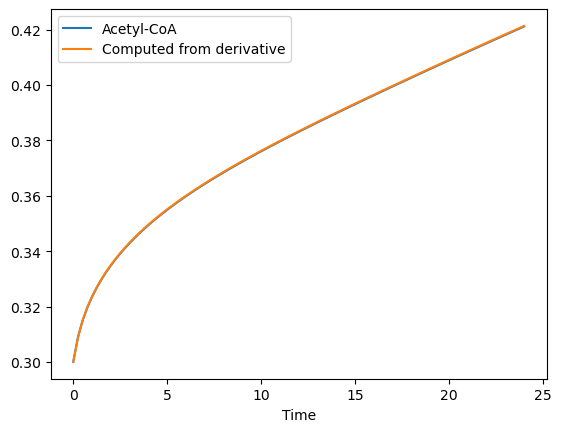

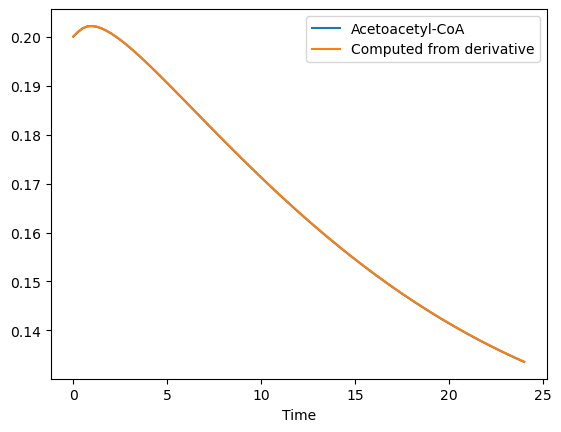

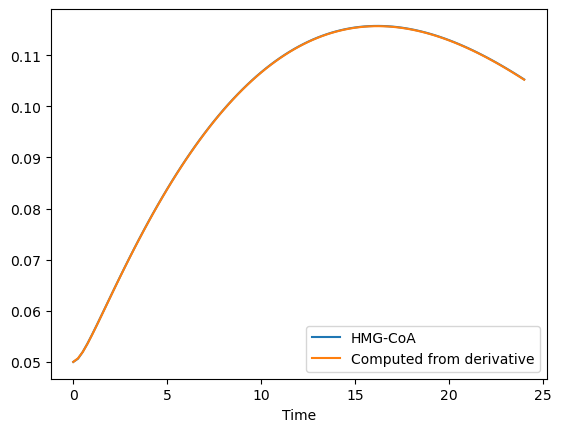

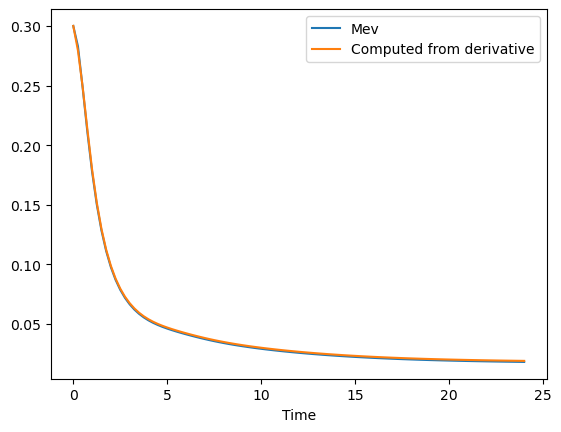

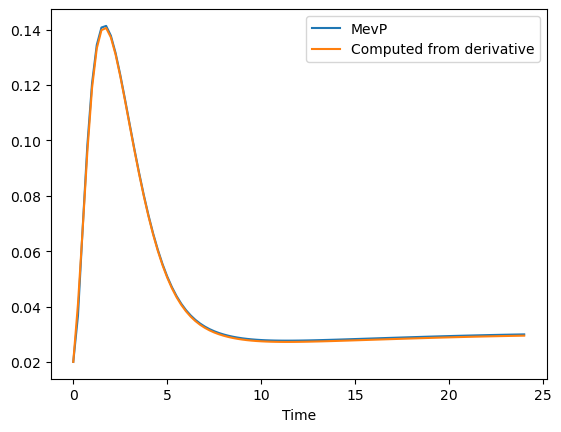

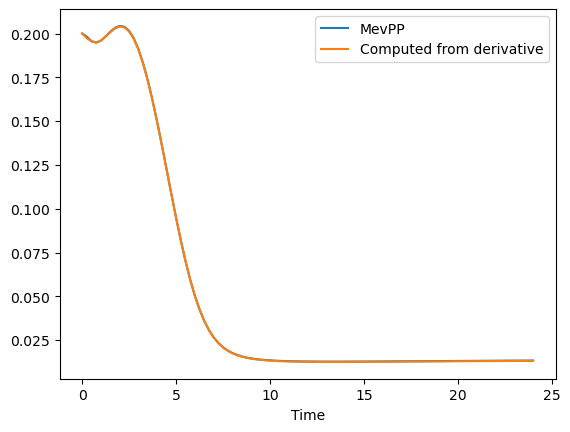

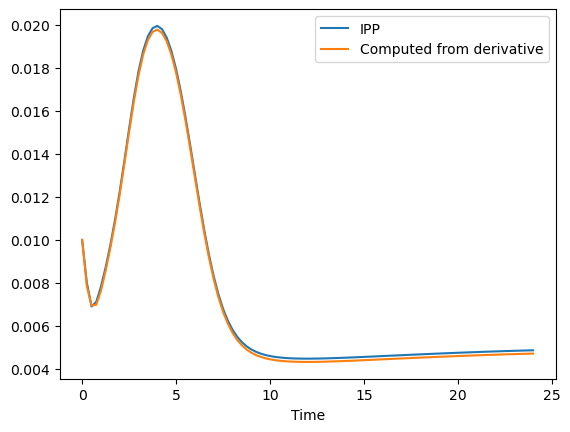

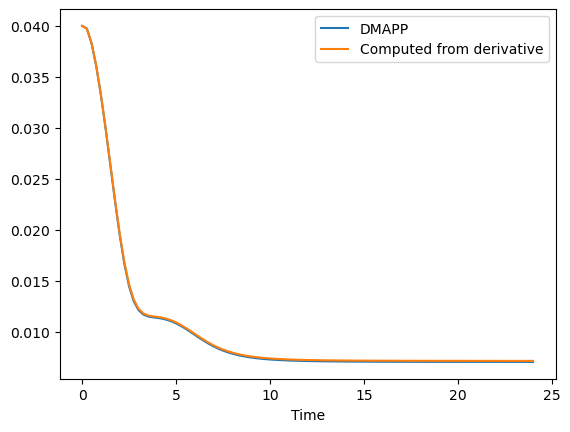

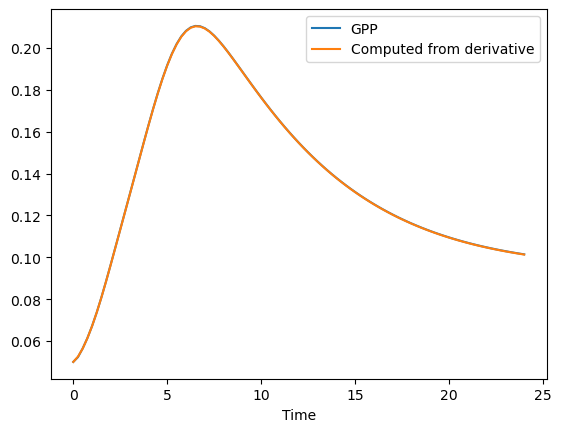

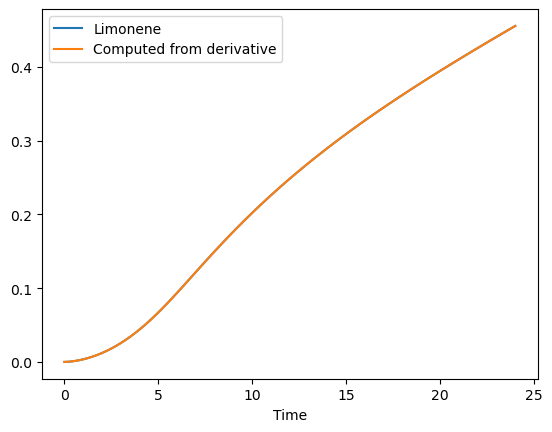

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                        AtoB          HMGS          HMGR            MK   
Strain   Time                                                            
Strain 1 0.00   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.25   4.568047e+06  2.339239e+06  2.165020e+05  1.413483e+06   
         0.50   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         0.75   5.858245e+06  4.161080e+06  4.187155e+05  2.735644e+06   
         1.00   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
...                      ...           ...           ...           ...   
WT       23.00  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.25  2.729560e+06  2.686069e+06  1.768628e+06  2.010384e+06   
         23.50  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         23.75  2.729863e+06  2.687209e+06  1.769653e+06  2.011551e+06   
         24.00  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                        \
                         PMK           PMD          GPPS           Idi   
Strain   Time                                                            
Strain 1 0.00   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.25   4.735188e+05  2.301051e+06  2.600509e+06  4.287990e+05   
         0.50   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         0.75   8.792538e+05  4.770619e+06  3.569278e+06  7.657046e+05   
         1.00   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
...                      ...           ...           ...           ...   
WT       23.00  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.25  1.502026e+06  3.992254e+06  4.354150e+06  1.235378e+06   
         23.50  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         23.75  1.502773e+06  3.995283e+06  4.354822e+06  1.235910e+06   
         24.00  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                     states                            \
               Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                           
Strain 1 0.00       3.034108e+01   0.300000        0.200000  0.050000   
         0.25       1.837058e+05   0.303889        0.202239  0.052901   
         0.50       2.866143e+05   0.300366        0.204051  0.059318   
         0.75       3.524272e+05   0.293825        0.204705  0.067553   
         1.00       3.981392e+05   0.285682        0.204435  0.076846   
...                          ...        ...             ...       ...   
WT       23.00      1.468009e+06   0.418135        0.135344  0.107524   
         23.25      1.468435e+06   0.418894        0.134891  0.106975   
         23.50      1.468851e+06   0.419652        0.134446  0.106413   
         23.75      1.469260e+06   0.420408        0.134009  0.105838   
         24.00      1.469659e+06   0.421163        0.133581  0.105252   

                                                                            \
                     Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                                
Strain 1 0.00   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.25   0.257973  0.060732  0.194292  0.011434  0.039765  0.052914   
         0.50   0.185505  0.126153  0.184541  0.014747  0.037935  0.060579   
         0.75   0.125893  0.171899  0.174893  0.018155  0.034722  0.072187   
         1.00   0.085674  0.193388  0.164537  0.021526  0.030790  0.086852   
...                  ...       ...       ...       ...       ...       ...   
WT       23.00  0.018433  0.029820  0.013294  0.004839  0.007023  0.102943   
         23.25  0.018376  0.029853  0.013307  0.004846  0.007023  0.102536   
         23.50  0.018321  0.029884  0.013319  0.004852  0.007023 

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
                Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                              
Strain 1 0.00     0.024056        0.011807  0.006596 -0.203422  0.217911   
         0.25    -0.000307        0.008010  0.019158 -0.234048  0.216216   
         0.50    -0.018662        0.004401  0.028864 -0.237215  0.192786   
         0.75    -0.031009        0.000980  0.035716 -0.212924  0.147623   
         1.00    -0.034961       -0.002637  0.038781 -0.133242  0.051775   
...                    ...             ...       ...       ...       ...   
WT       23.00    0.003039       -0.001829 -0.002172 -0.000234  0.000133   
         23.25    0.003034       -0.001796 -0.002224 -0.000225  0.000128   
         23.50    0.003028       -0.001764 -0.002274 -0.000216  0.000123   
         23.75    0.003022       -0.001731 -0.002322 -0.000208  0.000117   
         24.00    0.003017       -0.001699 -0.002367 -0.000200  0.000112   

                                                                  
                   MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                     
Strain 1 0.00  -0.025532  0.005014  0.003988  0.001041  0.000215  
         0.25  -0.030620  0.009670 -0.004554  0.021740  0.000923  
         0.50  -0.035884  0.012750 -0.010733  0.039083  0.001698  
         0.75  -0.041325  0.014255 -0.014547  0.053067  0.002541  
         1.00  -0.044974  0.013478 -0.016064  0.063589  0.003433  
...                  ...       ...       ...       ...       ...  
WT       23.00  0.000053  0.000026 -0.000001 -0.001663  0.014958  
         23.25  0.000051  0.000025 -0.000001 -0.001590  0.014904  
         23.50  0.000049  0.000024 -0.000001 -0.001521  0.014852  
         23.75  0.000047  0.000023 -0.000001 -0.001454  0.014803  
         24.00  0.000044  0.000023 -0.000001 -0.001390  0.014756  

[388 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
        super().__init__(n_var=27, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,
                             -12.0,0.0,-12.0,-12.0,
                             0.0,-12.0,-12.0,0.0,
                             -12.0,-12.0,
                             -12.0,-12.0,-12.0,-12.0,
                             0.0,0.0,
                             -12.0,-12.0,-12.0,
                             0.0,-12.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0,0.0,
                             0.0,0.0,0.0,
                             0.0,12.0,0.0,0.0,
                             12.0,0.0,0.0,12.0,
                             0.0,0.0,
                             0.0,0.0,0.0,0.0,
                             12.0,12.0,
                             0.0,0.0,0.0,
                             12.0,0.0,
                             -1.301029]) # upper bounds
                        )
        
    def _kinetic_model(self, e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       kma11,kcat1,
                       kma21,kma22,kcat2,
                       kma33,kI31,kI32,kcat3,
                       kma44,kI46,kI49,kcat4,
                       kma55,kcat5,
                       kma66,kI64,kI65,kcat6,
                       kma77,kcat7,
                       kma87,kma88,kcat8,
                       kma99,kcat9,
                       Vin): #HC: 27
    
        s11_hat = s1 / (10**kma11)
        r1 = e1 *(10**kcat1) *(s11_hat**2)/(1 + s11_hat + s11_hat**2)  # AtoB
        
        s21_hat = s1 / (10**kma21)
        s22_hat = s2 / (10**kma22)
        r2 = e2 *(10**kcat2) *s21_hat *s22_hat/(1 +s21_hat +s22_hat +s21_hat*s22_hat) # HMGS
        
        s33_hat = s3/ (10**kma33)
        h31 = (10**kI31) /( (10**kI31) + s1)
        h32 = (10**kI32) /( (10**kI32) + s2)
        r3 = h31 *h32 *e3 * (10**kcat3) *s33_hat / (1 + s33_hat) # HMGR

        s44_hat = s4/ (10**kma44)
        h46 = (10**kI46) /( (10**kI46) + s6)
        h49 = (10**kI49) /( (10**kI49) + s9)
        r4 = h46 *h49 *e4 * (10**kcat4) *s44_hat / (1 + s44_hat) # MK

        s55_hat = s5/ (10**kma55)
        r5 = e5 *(10**kcat5) *s55_hat / (1 + s55_hat) # PMK

        s66_hat = s6/ (10**kma66)
        h64 = (10**kI64) /( (10**kI64) + s4)
        h65 = (10**kI65) /( (10**kI65) + s5)
        r6 = h64 *h65 *e6 *(10**kcat6) *s66_hat / (1 + s66_hat) # PMD

        s77_hat = s7/ (10**kma77)
        r7 = e7 *(10**kcat7) *s77_hat / (1 + s77_hat) # IDI

        s87_hat = s7 / (10**kma87)
        s88_hat = s8 / (10**kma88)
        r8 = e8 *(10**kcat8) *s87_hat *s88_hat/(1 +s87_hat +s88_hat +s87_hat*s88_hat) # GPPS

        s99_hat = s9/ (10**kma99)
        r9 = e9 *(10**kcat9) *s99_hat / (1 + s99_hat) # LS           

        r10 = 10**Vin # AcCoA supply
                
        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9
        
        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]
     
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [29]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [30]:
algo = 'G3PCX'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [31]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=101,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: G3PCX

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       64 |  1.849029E+31 |  4.877611E+08
     2 |      128 |  1.849009E+31 |  4.156958E+01
     3 |      192 |  1.057626E+26 |  4.131656E+01
     4 |      256 |  1.057626E+26 |  4.114345E+01
     5 |      320 |  1.057626E+26 |  4.110579E+01
     6 |      384 |  4.137285E+01 |  4.108776E+01
     7 |      448 |  4.110242E+01 |  4.107225E+01
     8 |      512 |  4.106428E+01 |  4.100065E+01
     9 |      576 |  4.101936E+01 |  4.093073E+01
    10 |      640 |  4.084162E+01 |  4.068490E+01
    11 |      704 |  4.074541E+01 |  4.068393E+01
    12 |      768 |  4.070034E+01 |  4.068311E+01
    13 |      832 |  4.069260E+01 |  4.068291E+01
    14 |      896 |  4.069163E+01 |  4.068265E+01
    15 |      960 |  4.068815E+01 |  4.068249E+01
    16 |     1024 |  4.068304E+01 |  4.068211E+01
    17 |     1088 |  4.068279E+01 |  4.068209E+01
    18 |     1152 |  4.068239E+01 |  4.068127E+01
    19 |     1216 |  4.06

   162 |    10368 |  1.760944E+01 |  1.760896E+01
   163 |    10432 |  1.760907E+01 |  1.760842E+01
   164 |    10496 |  1.760854E+01 |  1.760770E+01
   165 |    10560 |  1.760777E+01 |  1.760701E+01
   166 |    10624 |  1.760740E+01 |  1.760666E+01
   167 |    10688 |  1.760704E+01 |  1.760630E+01
   168 |    10752 |  1.760671E+01 |  1.760561E+01
   169 |    10816 |  1.760649E+01 |  1.760547E+01
   170 |    10880 |  1.760605E+01 |  1.760451E+01
   171 |    10944 |  1.760538E+01 |  1.760423E+01
   172 |    11008 |  1.760503E+01 |  1.760420E+01
   173 |    11072 |  1.760452E+01 |  1.760387E+01
   174 |    11136 |  1.760421E+01 |  1.760364E+01
   175 |    11200 |  1.760373E+01 |  1.760319E+01
   176 |    11264 |  1.760337E+01 |  1.760312E+01
   177 |    11328 |  1.760325E+01 |  1.760304E+01
   178 |    11392 |  1.760312E+01 |  1.760295E+01
   179 |    11456 |  1.760303E+01 |  1.760282E+01
   180 |    11520 |  1.760289E+01 |  1.760262E+01
   181 |    11584 |  1.760275E+01 |  1.760250E+01


   326 |    20864 |  1.750673E+01 |  1.750504E+01
   327 |    20928 |  1.750549E+01 |  1.750378E+01
   328 |    20992 |  1.750378E+01 |  1.750214E+01
   329 |    21056 |  1.750256E+01 |  1.750094E+01
   330 |    21120 |  1.750131E+01 |  1.750042E+01
   331 |    21184 |  1.750060E+01 |  1.749308E+01
   332 |    21248 |  1.749686E+01 |  1.748928E+01
   333 |    21312 |  1.749155E+01 |  1.748682E+01
   334 |    21376 |  1.748839E+01 |  1.748166E+01
   335 |    21440 |  1.748472E+01 |  1.747827E+01
   336 |    21504 |  1.748017E+01 |  1.746908E+01
   337 |    21568 |  1.747397E+01 |  1.746642E+01
   338 |    21632 |  1.746831E+01 |  1.745195E+01
   339 |    21696 |  1.745772E+01 |  1.744356E+01
   340 |    21760 |  1.745062E+01 |  1.744168E+01
   341 |    21824 |  1.744498E+01 |  1.743802E+01
   342 |    21888 |  1.744100E+01 |  1.743562E+01
   343 |    21952 |  1.743766E+01 |  1.743343E+01
   344 |    22016 |  1.743296E+01 |  1.742743E+01
   345 |    22080 |  1.742949E+01 |  1.742113E+01


   490 |    31360 |  1.638654E+01 |  1.638399E+01
   491 |    31424 |  1.638497E+01 |  1.638293E+01
   492 |    31488 |  1.638333E+01 |  1.638176E+01
   493 |    31552 |  1.638234E+01 |  1.638034E+01
   494 |    31616 |  1.638055E+01 |  1.637847E+01
   495 |    31680 |  1.637896E+01 |  1.637731E+01
   496 |    31744 |  1.637748E+01 |  1.637507E+01
   497 |    31808 |  1.637621E+01 |  1.637346E+01
   498 |    31872 |  1.637421E+01 |  1.637168E+01
   499 |    31936 |  1.637202E+01 |  1.637014E+01
   500 |    32000 |  1.637095E+01 |  1.636955E+01
   501 |    32064 |  1.637005E+01 |  1.636859E+01
   502 |    32128 |  1.636870E+01 |  1.636700E+01
   503 |    32192 |  1.636712E+01 |  1.636514E+01
   504 |    32256 |  1.636617E+01 |  1.636466E+01
   505 |    32320 |  1.636525E+01 |  1.636399E+01
   506 |    32384 |  1.636410E+01 |  1.635986E+01
   507 |    32448 |  1.636264E+01 |  1.635950E+01
   508 |    32512 |  1.636081E+01 |  1.635880E+01
   509 |    32576 |  1.635907E+01 |  1.635698E+01


   654 |    41856 |  1.627988E+01 |  1.627970E+01
   655 |    41920 |  1.627982E+01 |  1.627958E+01
   656 |    41984 |  1.627979E+01 |  1.627957E+01
   657 |    42048 |  1.627971E+01 |  1.627948E+01
   658 |    42112 |  1.627967E+01 |  1.627936E+01
   659 |    42176 |  1.627964E+01 |  1.627936E+01
   660 |    42240 |  1.627961E+01 |  1.627934E+01
   661 |    42304 |  1.627958E+01 |  1.627929E+01
   662 |    42368 |  1.627951E+01 |  1.627918E+01
   663 |    42432 |  1.627943E+01 |  1.627903E+01
   664 |    42496 |  1.627930E+01 |  1.627871E+01
   665 |    42560 |  1.627912E+01 |  1.627869E+01
   666 |    42624 |  1.627894E+01 |  1.627864E+01
   667 |    42688 |  1.627879E+01 |  1.627853E+01
   668 |    42752 |  1.627862E+01 |  1.627834E+01
   669 |    42816 |  1.627839E+01 |  1.627808E+01
   670 |    42880 |  1.627820E+01 |  1.627798E+01
   671 |    42944 |  1.627812E+01 |  1.627785E+01
   672 |    43008 |  1.627800E+01 |  1.627773E+01
   673 |    43072 |  1.627784E+01 |  1.627753E+01


   818 |    52352 |  1.626307E+01 |  1.626297E+01
   819 |    52416 |  1.626297E+01 |  1.626285E+01
   820 |    52480 |  1.626289E+01 |  1.626277E+01
   821 |    52544 |  1.626282E+01 |  1.626269E+01
   822 |    52608 |  1.626275E+01 |  1.626263E+01
   823 |    52672 |  1.626267E+01 |  1.626256E+01
   824 |    52736 |  1.626262E+01 |  1.626254E+01
   825 |    52800 |  1.626257E+01 |  1.626244E+01
   826 |    52864 |  1.626248E+01 |  1.626234E+01
   827 |    52928 |  1.626240E+01 |  1.626229E+01
   828 |    52992 |  1.626231E+01 |  1.626218E+01
   829 |    53056 |  1.626222E+01 |  1.626214E+01
   830 |    53120 |  1.626216E+01 |  1.626211E+01
   831 |    53184 |  1.626213E+01 |  1.626210E+01
   832 |    53248 |  1.626211E+01 |  1.626206E+01
   833 |    53312 |  1.626204E+01 |  1.626187E+01
   834 |    53376 |  1.626193E+01 |  1.626181E+01
   835 |    53440 |  1.626186E+01 |  1.626177E+01
   836 |    53504 |  1.626183E+01 |  1.626174E+01
   837 |    53568 |  1.626180E+01 |  1.626167E+01


   982 |    62848 |  1.624616E+01 |  1.624615E+01
   983 |    62912 |  1.624615E+01 |  1.624615E+01
   984 |    62976 |  1.624615E+01 |  1.624614E+01
   985 |    63040 |  1.624614E+01 |  1.624614E+01
   986 |    63104 |  1.624614E+01 |  1.624613E+01
   987 |    63168 |  1.624614E+01 |  1.624613E+01
   988 |    63232 |  1.624614E+01 |  1.624613E+01
   989 |    63296 |  1.624613E+01 |  1.624612E+01
   990 |    63360 |  1.624613E+01 |  1.624609E+01
   991 |    63424 |  1.624612E+01 |  1.624608E+01
   992 |    63488 |  1.624610E+01 |  1.624607E+01
   993 |    63552 |  1.624609E+01 |  1.624607E+01
   994 |    63616 |  1.624608E+01 |  1.624605E+01
   995 |    63680 |  1.624607E+01 |  1.624603E+01
   996 |    63744 |  1.624606E+01 |  1.624603E+01
   997 |    63808 |  1.624605E+01 |  1.624601E+01
   998 |    63872 |  1.624604E+01 |  1.624601E+01
   999 |    63936 |  1.624602E+01 |  1.624600E+01
  1000 |    64000 |  1.624601E+01 |  1.624600E+01
  1001 |    64064 |  1.624601E+01 |  1.624599E+01


  1146 |    73344 |  1.624465E+01 |  1.624465E+01
  1147 |    73408 |  1.624465E+01 |  1.624465E+01
  1148 |    73472 |  1.624465E+01 |  1.624465E+01
  1149 |    73536 |  1.624465E+01 |  1.624465E+01
  1150 |    73600 |  1.624465E+01 |  1.624465E+01
  1151 |    73664 |  1.624465E+01 |  1.624465E+01
  1152 |    73728 |  1.624465E+01 |  1.624465E+01
  1153 |    73792 |  1.624465E+01 |  1.624465E+01
  1154 |    73856 |  1.624465E+01 |  1.624465E+01
  1155 |    73920 |  1.624465E+01 |  1.624465E+01
  1156 |    73984 |  1.624465E+01 |  1.624465E+01
  1157 |    74048 |  1.624465E+01 |  1.624465E+01
  1158 |    74112 |  1.624465E+01 |  1.624465E+01
  1159 |    74176 |  1.624465E+01 |  1.624465E+01
  1160 |    74240 |  1.624465E+01 |  1.624465E+01
  1161 |    74304 |  1.624465E+01 |  1.624465E+01
  1162 |    74368 |  1.624465E+01 |  1.624465E+01
  1163 |    74432 |  1.624465E+01 |  1.624465E+01
  1164 |    74496 |  1.624465E+01 |  1.624465E+01
  1165 |    74560 |  1.624465E+01 |  1.624464E+01


  1310 |    83840 |  1.277606E+01 |  1.276281E+01
  1311 |    83904 |  1.276425E+01 |  1.275421E+01
  1312 |    83968 |  1.275073E+01 |  1.274025E+01
  1313 |    84032 |  1.274291E+01 |  1.273321E+01
  1314 |    84096 |  1.273820E+01 |  1.272694E+01
  1315 |    84160 |  1.273296E+01 |  1.272202E+01
  1316 |    84224 |  1.272499E+01 |  1.271882E+01
  1317 |    84288 |  1.272104E+01 |  1.271616E+01
  1318 |    84352 |  1.271723E+01 |  1.271068E+01
  1319 |    84416 |  1.271126E+01 |  1.270441E+01
  1320 |    84480 |  1.270600E+01 |  1.269791E+01
  1321 |    84544 |  1.269865E+01 |  1.269067E+01
  1322 |    84608 |  1.269013E+01 |  1.267827E+01
  1323 |    84672 |  1.268038E+01 |  1.266952E+01
  1324 |    84736 |  1.267191E+01 |  1.266435E+01
  1325 |    84800 |  1.266558E+01 |  1.265885E+01
  1326 |    84864 |  1.265873E+01 |  1.265275E+01
  1327 |    84928 |  1.265464E+01 |  1.264890E+01
  1328 |    84992 |  1.264895E+01 |  1.264146E+01
  1329 |    85056 |  1.264217E+01 |  1.263595E+01


  1474 |    94336 |  3.5841840088 |  3.5828979866
  1475 |    94400 |  3.5828953619 |  3.5816150811
  1476 |    94464 |  3.5818713591 |  3.5808053837
  1477 |    94528 |  3.5806997432 |  3.5794948236
  1478 |    94592 |  3.5796161566 |  3.5783948600
  1479 |    94656 |  3.5786084737 |  3.5774534055
  1480 |    94720 |  3.5773225631 |  3.5758270675
  1481 |    94784 |  3.5757636079 |  3.5740977710
  1482 |    94848 |  3.5743979579 |  3.5728709722
  1483 |    94912 |  3.5729775456 |  3.5706143282
  1484 |    94976 |  3.5712469458 |  3.5691743686
  1485 |    95040 |  3.5695110255 |  3.5679745143
  1486 |    95104 |  3.5682376037 |  3.5675425369
  1487 |    95168 |  3.5676654582 |  3.5671578411
  1488 |    95232 |  3.5671054259 |  3.5665911583
  1489 |    95296 |  3.5666787362 |  3.5661998538
  1490 |    95360 |  3.5662145570 |  3.5656585544
  1491 |    95424 |  3.5657589160 |  3.5654594191
  1492 |    95488 |  3.5654777907 |  3.5651352181
  1493 |    95552 |  3.5652092368 |  3.5649379777


  1638 |   104832 |  3.5372799163 |  3.5372587356
  1639 |   104896 |  3.5372580327 |  3.5372388620
  1640 |   104960 |  3.5372478107 |  3.5372314536
  1641 |   105024 |  3.5372375418 |  3.5372272565
  1642 |   105088 |  3.5372294679 |  3.5372208363
  1643 |   105152 |  3.5372206066 |  3.5372131269
  1644 |   105216 |  3.5372149585 |  3.5372074509
  1645 |   105280 |  3.5372101569 |  3.5372038105
  1646 |   105344 |  3.5372054856 |  3.5372004778
  1647 |   105408 |  3.5372006558 |  3.5371944135
  1648 |   105472 |  3.5371897259 |  3.5371785770
  1649 |   105536 |  3.5371824944 |  3.5371768496
  1650 |   105600 |  3.5371782318 |  3.5371754565
  1651 |   105664 |  3.5371766856 |  3.5371740875
  1652 |   105728 |  3.5371752577 |  3.5371728232
  1653 |   105792 |  3.5371733078 |  3.5371704960
  1654 |   105856 |  3.5371716424 |  3.5371680763
  1655 |   105920 |  3.5371695106 |  3.5371650096
  1656 |   105984 |  3.5371657438 |  3.5371593426
  1657 |   106048 |  3.5371606822 |  3.5371568707


  1802 |   115328 |  3.5370045645 |  3.5370037425
  1803 |   115392 |  3.5370040667 |  3.5370033458
  1804 |   115456 |  3.5370035798 |  3.5370027193
  1805 |   115520 |  3.5370029650 |  3.5370021754
  1806 |   115584 |  3.5370023733 |  3.5370016676
  1807 |   115648 |  3.5370018517 |  3.5370015223
  1808 |   115712 |  3.5370016500 |  3.5370013420
  1809 |   115776 |  3.5370014650 |  3.5370012198
  1810 |   115840 |  3.5370012922 |  3.5370010484
  1811 |   115904 |  3.5370011197 |  3.5370008756
  1812 |   115968 |  3.5370009451 |  3.5370006759
  1813 |   116032 |  3.5370007922 |  3.5370004783
  1814 |   116096 |  3.5370005425 |  3.5370001544
  1815 |   116160 |  3.5370003084 |  3.5370000702
  1816 |   116224 |  3.5370001133 |  3.5369999439
  1817 |   116288 |  3.5369999611 |  3.5369997336
  1818 |   116352 |  3.5369997850 |  3.5369996252
  1819 |   116416 |  3.5369996301 |  3.5369994266
  1820 |   116480 |  3.5369994730 |  3.5369993471
  1821 |   116544 |  3.5369993714 |  3.5369992766


  1966 |   125824 |  3.5369116222 |  3.5369115390
  1967 |   125888 |  3.5369115498 |  3.5369114686
  1968 |   125952 |  3.5369115025 |  3.5369114201
  1969 |   126016 |  3.5369114503 |  3.5369113643
  1970 |   126080 |  3.5369114056 |  3.5369113212
  1971 |   126144 |  3.5369113461 |  3.5369113037
  1972 |   126208 |  3.5369113172 |  3.5369112929
  1973 |   126272 |  3.5369112912 |  3.5369112667
  1974 |   126336 |  3.5369112716 |  3.5369112501
  1975 |   126400 |  3.5369112573 |  3.5369112406
  1976 |   126464 |  3.5369112473 |  3.5369112365
  1977 |   126528 |  3.5369112396 |  3.5369112350
  1978 |   126592 |  3.5369112366 |  3.5369112312
  1979 |   126656 |  3.5369112299 |  3.5369112192
  1980 |   126720 |  3.5369112193 |  3.5369112060
  1981 |   126784 |  3.5369112096 |  3.5369111980
  1982 |   126848 |  3.5369111983 |  3.5369111881
  1983 |   126912 |  3.5369111874 |  3.5369111738
  1984 |   126976 |  3.5369111780 |  3.5369111650
  1985 |   127040 |  3.5369111647 |  3.5369111416


  2130 |   136320 |  3.5368202074 |  3.5368190995
  2131 |   136384 |  3.5368196010 |  3.5368188856
  2132 |   136448 |  3.5368189466 |  3.5368181909
  2133 |   136512 |  3.5368185209 |  3.5368180058
  2134 |   136576 |  3.5368181828 |  3.5368177387
  2135 |   136640 |  3.5368178734 |  3.5368175640
  2136 |   136704 |  3.5368176667 |  3.5368173489
  2137 |   136768 |  3.5368174460 |  3.5368169742
  2138 |   136832 |  3.5368172152 |  3.5368166168
  2139 |   136896 |  3.5368168692 |  3.5368162017
  2140 |   136960 |  3.5368164167 |  3.5368157255
  2141 |   137024 |  3.5368159516 |  3.5368152719
  2142 |   137088 |  3.5368155908 |  3.5368149121
  2143 |   137152 |  3.5368149686 |  3.5368137251
  2144 |   137216 |  3.5368141978 |  3.5368127177
  2145 |   137280 |  3.5368133186 |  3.5368123441
  2146 |   137344 |  3.5368127243 |  3.5368120912
  2147 |   137408 |  3.5368123582 |  3.5368118203
  2148 |   137472 |  3.5368120471 |  3.5368115066
  2149 |   137536 |  3.5368117336 |  3.5368113187


  2294 |   146816 |  3.5367398361 |  3.5367394523
  2295 |   146880 |  3.5367396044 |  3.5367393130
  2296 |   146944 |  3.5367394503 |  3.5367391727
  2297 |   147008 |  3.5367392487 |  3.5367388252
  2298 |   147072 |  3.5367389934 |  3.5367384065
  2299 |   147136 |  3.5367385247 |  3.5367375068
  2300 |   147200 |  3.5367378808 |  3.5367369229
  2301 |   147264 |  3.5367372746 |  3.5367364035
  2302 |   147328 |  3.5367367798 |  3.5367362367
  2303 |   147392 |  3.5367364480 |  3.5367357984
  2304 |   147456 |  3.5367361118 |  3.5367354691
  2305 |   147520 |  3.5367356906 |  3.5367350017
  2306 |   147584 |  3.5367353091 |  3.5367348090
  2307 |   147648 |  3.5367349967 |  3.5367342698
  2308 |   147712 |  3.5367346539 |  3.5367338926
  2309 |   147776 |  3.5367342994 |  3.5367336861
  2310 |   147840 |  3.5367338728 |  3.5367333487
  2311 |   147904 |  3.5367335731 |  3.5367331798
  2312 |   147968 |  3.5367332594 |  3.5367329860
  2313 |   148032 |  3.5367330716 |  3.5367327727


  2458 |   157312 |  3.5366490785 |  3.5366488569
  2459 |   157376 |  3.5366489359 |  3.5366487250
  2460 |   157440 |  3.5366487984 |  3.5366486267
  2461 |   157504 |  3.5366486664 |  3.5366484278
  2462 |   157568 |  3.5366484940 |  3.5366482977
  2463 |   157632 |  3.5366483743 |  3.5366482100
  2464 |   157696 |  3.5366482544 |  3.5366481150
  2465 |   157760 |  3.5366481771 |  3.5366480323
  2466 |   157824 |  3.5366480814 |  3.5366479532
  2467 |   157888 |  3.5366480045 |  3.5366479110
  2468 |   157952 |  3.5366479436 |  3.5366478755
  2469 |   158016 |  3.5366479056 |  3.5366478431
  2470 |   158080 |  3.5366478739 |  3.5366478239
  2471 |   158144 |  3.5366478345 |  3.5366477876
  2472 |   158208 |  3.5366477972 |  3.5366477380
  2473 |   158272 |  3.5366477647 |  3.5366477112
  2474 |   158336 |  3.5366477337 |  3.5366476961
  2475 |   158400 |  3.5366477066 |  3.5366476508
  2476 |   158464 |  3.5366476549 |  3.5366475942
  2477 |   158528 |  3.5366476082 |  3.5366475446


  2622 |   167808 |  3.5365742868 |  3.5365736989
  2623 |   167872 |  3.5365739297 |  3.5365734182
  2624 |   167936 |  3.5365736627 |  3.5365732549
  2625 |   168000 |  3.5365733086 |  3.5365726330
  2626 |   168064 |  3.5365729594 |  3.5365723957
  2627 |   168128 |  3.5365724930 |  3.5365716724
  2628 |   168192 |  3.5365719060 |  3.5365710301
  2629 |   168256 |  3.5365714382 |  3.5365708401
  2630 |   168320 |  3.5365710488 |  3.5365702748
  2631 |   168384 |  3.5365707236 |  3.5365701411
  2632 |   168448 |  3.5365703713 |  3.5365698248
  2633 |   168512 |  3.5365699549 |  3.5365695345
  2634 |   168576 |  3.5365697328 |  3.5365692811
  2635 |   168640 |  3.5365694857 |  3.5365687413
  2636 |   168704 |  3.5365689878 |  3.5365680755
  2637 |   168768 |  3.5365682097 |  3.5365673879
  2638 |   168832 |  3.5365677571 |  3.5365669616
  2639 |   168896 |  3.5365672406 |  3.5365665739
  2640 |   168960 |  3.5365667741 |  3.5365661779
  2641 |   169024 |  3.5365664908 |  3.5365659670


  2786 |   178304 |  3.5364799984 |  3.5364775161
  2787 |   178368 |  3.5364784119 |  3.5364744738
  2788 |   178432 |  3.5364758510 |  3.5364720221
  2789 |   178496 |  3.5364731867 |  3.5364708694
  2790 |   178560 |  3.5364714331 |  3.5364692186
  2791 |   178624 |  3.5364700107 |  3.5364688021
  2792 |   178688 |  3.5364691133 |  3.5364683816
  2793 |   178752 |  3.5364686617 |  3.5364679704
  2794 |   178816 |  3.5364682774 |  3.5364678524
  2795 |   178880 |  3.5364680360 |  3.5364676862
  2796 |   178944 |  3.5364677513 |  3.5364673398
  2797 |   179008 |  3.5364675138 |  3.5364670987
  2798 |   179072 |  3.5364672384 |  3.5364667047
  2799 |   179136 |  3.5364669196 |  3.5364665073
  2800 |   179200 |  3.5364666864 |  3.5364663399
  2801 |   179264 |  3.5364665048 |  3.5364662763
  2802 |   179328 |  3.5364663760 |  3.5364662364
  2803 |   179392 |  3.5364662862 |  3.5364661547
  2804 |   179456 |  3.5364661907 |  3.5364660743
  2805 |   179520 |  3.5364661277 |  3.5364660537


  2950 |   188800 |  3.5363850327 |  3.5363837677
  2951 |   188864 |  3.5363842066 |  3.5363833195
  2952 |   188928 |  3.5363836758 |  3.5363828281
  2953 |   188992 |  3.5363831750 |  3.5363824917
  2954 |   189056 |  3.5363827548 |  3.5363821582
  2955 |   189120 |  3.5363823605 |  3.5363816983
  2956 |   189184 |  3.5363818787 |  3.5363805646
  2957 |   189248 |  3.5363811069 |  3.5363799866
  2958 |   189312 |  3.5363803294 |  3.5363792171
  2959 |   189376 |  3.5363795495 |  3.5363785949
  2960 |   189440 |  3.5363789640 |  3.5363781644
  2961 |   189504 |  3.5363785921 |  3.5363777395
  2962 |   189568 |  3.5363779501 |  3.5363769108
  2963 |   189632 |  3.5363773262 |  3.5363764066
  2964 |   189696 |  3.5363766438 |  3.5363757399
  2965 |   189760 |  3.5363759629 |  3.5363744703
  2966 |   189824 |  3.5363752209 |  3.5363740791
  2967 |   189888 |  3.5363744892 |  3.5363731424
  2968 |   189952 |  3.5363736983 |  3.5363723807
  2969 |   190016 |  3.5363728477 |  3.5363715985


  3114 |   199296 |  3.5363069346 |  3.5363068485
  3115 |   199360 |  3.5363068928 |  3.5363068208
  3116 |   199424 |  3.5363068360 |  3.5363066932
  3117 |   199488 |  3.5363067398 |  3.5363066271
  3118 |   199552 |  3.5363066722 |  3.5363065753
  3119 |   199616 |  3.5363066241 |  3.5363065689
  3120 |   199680 |  3.5363065902 |  3.5363065588
  3121 |   199744 |  3.5363065682 |  3.5363065528
  3122 |   199808 |  3.5363065582 |  3.5363065341
  3123 |   199872 |  3.5363065434 |  3.5363065140
  3124 |   199936 |  3.5363065254 |  3.5363064955
  3125 |   200000 |  3.5363065055 |  3.5363064562
  3126 |   200064 |  3.5363064699 |  3.5363063164
  3127 |   200128 |  3.5363063916 |  3.5363062494
  3128 |   200192 |  3.5363063131 |  3.5363061796
  3129 |   200256 |  3.5363061792 |  3.5363060004
  3130 |   200320 |  3.5363060470 |  3.5363058723
  3131 |   200384 |  3.5363059261 |  3.5363057701
  3132 |   200448 |  3.5363058258 |  3.5363056746
  3133 |   200512 |  3.5363057387 |  3.5363055940


  3278 |   209792 |  3.5362705867 |  3.5362693243
  3279 |   209856 |  3.5362699361 |  3.5362689038
  3280 |   209920 |  3.5362693925 |  3.5362677250
  3281 |   209984 |  3.5362681006 |  3.5362658657
  3282 |   210048 |  3.5362668555 |  3.5362650466
  3283 |   210112 |  3.5362655546 |  3.5362635400
  3284 |   210176 |  3.5362644091 |  3.5362621583
  3285 |   210240 |  3.5362629102 |  3.5362613152
  3286 |   210304 |  3.5362619172 |  3.5362605021
  3287 |   210368 |  3.5362609908 |  3.5362596792
  3288 |   210432 |  3.5362602224 |  3.5362590813
  3289 |   210496 |  3.5362597354 |  3.5362587570
  3290 |   210560 |  3.5362590182 |  3.5362568434
  3291 |   210624 |  3.5362574726 |  3.5362550166
  3292 |   210688 |  3.5362560177 |  3.5362544118
  3293 |   210752 |  3.5362549642 |  3.5362536306
  3294 |   210816 |  3.5362539733 |  3.5362528451
  3295 |   210880 |  3.5362531660 |  3.5362521314
  3296 |   210944 |  3.5362525254 |  3.5362518707
  3297 |   211008 |  3.5362521705 |  3.5362517019


  3442 |   220288 |  3.5361781521 |  3.5361768734
  3443 |   220352 |  3.5361774838 |  3.5361763656
  3444 |   220416 |  3.5361767227 |  3.5361756133
  3445 |   220480 |  3.5361761525 |  3.5361753272
  3446 |   220544 |  3.5361757451 |  3.5361742628
  3447 |   220608 |  3.5361748375 |  3.5361731093
  3448 |   220672 |  3.5361735087 |  3.5361720792
  3449 |   220736 |  3.5361723414 |  3.5361708912
  3450 |   220800 |  3.5361712071 |  3.5361695539
  3451 |   220864 |  3.5361699940 |  3.5361687091
  3452 |   220928 |  3.5361691570 |  3.5361679998
  3453 |   220992 |  3.5361684641 |  3.5361675025
  3454 |   221056 |  3.5361678384 |  3.5361666575
  3455 |   221120 |  3.5361671332 |  3.5361662483
  3456 |   221184 |  3.5361666350 |  3.5361659053
  3457 |   221248 |  3.5361662376 |  3.5361657174
  3458 |   221312 |  3.5361659192 |  3.5361653288
  3459 |   221376 |  3.5361656064 |  3.5361651178
  3460 |   221440 |  3.5361652946 |  3.5361646640
  3461 |   221504 |  3.5361648594 |  3.5361642745


  3606 |   230784 |  3.5361099959 |  3.5361082213
  3607 |   230848 |  3.5361085629 |  3.5361069109
  3608 |   230912 |  3.5361075217 |  3.5361060630
  3609 |   230976 |  3.5361066182 |  3.5361056078
  3610 |   231040 |  3.5361060500 |  3.5361048261
  3611 |   231104 |  3.5361050971 |  3.5361040772
  3612 |   231168 |  3.5361043410 |  3.5361035237
  3613 |   231232 |  3.5361036349 |  3.5361030107
  3614 |   231296 |  3.5361031620 |  3.5361026044
  3615 |   231360 |  3.5361028564 |  3.5361023122
  3616 |   231424 |  3.5361025359 |  3.5361021466
  3617 |   231488 |  3.5361022741 |  3.5361016123
  3618 |   231552 |  3.5361018110 |  3.5361010324
  3619 |   231616 |  3.5361014546 |  3.5361007400
  3620 |   231680 |  3.5361009103 |  3.5361000005
  3621 |   231744 |  3.5361002656 |  3.5360995839
  3622 |   231808 |  3.5360998364 |  3.5360993244
  3623 |   231872 |  3.5360995816 |  3.5360990960
  3624 |   231936 |  3.5360993399 |  3.5360989317
  3625 |   232000 |  3.5360991803 |  3.5360988864


  3770 |   241280 |  3.5360659158 |  3.5360646768
  3771 |   241344 |  3.5360644576 |  3.5360620538
  3772 |   241408 |  3.5360626787 |  3.5360603379
  3773 |   241472 |  3.5360611021 |  3.5360587465
  3774 |   241536 |  3.5360594758 |  3.5360572156
  3775 |   241600 |  3.5360581970 |  3.5360569376
  3776 |   241664 |  3.5360572017 |  3.5360563024
  3777 |   241728 |  3.5360567429 |  3.5360559628
  3778 |   241792 |  3.5360563198 |  3.5360556042
  3779 |   241856 |  3.5360559132 |  3.5360551402
  3780 |   241920 |  3.5360554826 |  3.5360548773
  3781 |   241984 |  3.5360551394 |  3.5360545171
  3782 |   242048 |  3.5360546563 |  3.5360541001
  3783 |   242112 |  3.5360542530 |  3.5360536644
  3784 |   242176 |  3.5360539128 |  3.5360535169
  3785 |   242240 |  3.5360537188 |  3.5360533759
  3786 |   242304 |  3.5360535083 |  3.5360532400
  3787 |   242368 |  3.5360533688 |  3.5360531242
  3788 |   242432 |  3.5360532664 |  3.5360530654
  3789 |   242496 |  3.5360531639 |  3.5360528547


  3934 |   251776 |  3.5360115860 |  3.5360113030
  3935 |   251840 |  3.5360114328 |  3.5360111559
  3936 |   251904 |  3.5360112715 |  3.5360109827
  3937 |   251968 |  3.5360111301 |  3.5360108164
  3938 |   252032 |  3.5360109840 |  3.5360107858
  3939 |   252096 |  3.5360108480 |  3.5360105717
  3940 |   252160 |  3.5360106774 |  3.5360104255
  3941 |   252224 |  3.5360105584 |  3.5360103789
  3942 |   252288 |  3.5360104549 |  3.5360102064
  3943 |   252352 |  3.5360102639 |  3.5360100289
  3944 |   252416 |  3.5360101084 |  3.5360098907
  3945 |   252480 |  3.5360099571 |  3.5360097449
  3946 |   252544 |  3.5360098260 |  3.5360096465
  3947 |   252608 |  3.5360097224 |  3.5360095481
  3948 |   252672 |  3.5360095857 |  3.5360093967
  3949 |   252736 |  3.5360094049 |  3.5360091420
  3950 |   252800 |  3.5360091700 |  3.5360088063
  3951 |   252864 |  3.5360089306 |  3.5360085832
  3952 |   252928 |  3.5360086990 |  3.5360082683
  3953 |   252992 |  3.5360083340 |  3.5360077025


  4098 |   262272 |  3.5359456653 |  3.5359449653
  4099 |   262336 |  3.5359451565 |  3.5359447172
  4100 |   262400 |  3.5359449548 |  3.5359445364
  4101 |   262464 |  3.5359447279 |  3.5359442052
  4102 |   262528 |  3.5359444124 |  3.5359440419
  4103 |   262592 |  3.5359442026 |  3.5359436217
  4104 |   262656 |  3.5359438819 |  3.5359432592
  4105 |   262720 |  3.5359434105 |  3.5359426398
  4106 |   262784 |  3.5359428119 |  3.5359417115
  4107 |   262848 |  3.5359423275 |  3.5359415504
  4108 |   262912 |  3.5359418946 |  3.5359410484
  4109 |   262976 |  3.5359410936 |  3.5359396529
  4110 |   263040 |  3.5359402718 |  3.5359392003
  4111 |   263104 |  3.5359397160 |  3.5359389413
  4112 |   263168 |  3.5359391184 |  3.5359385916
  4113 |   263232 |  3.5359388134 |  3.5359383367
  4114 |   263296 |  3.5359385177 |  3.5359379147
  4115 |   263360 |  3.5359379505 |  3.5359370806
  4116 |   263424 |  3.5359373345 |  3.5359360784
  4117 |   263488 |  3.5359366575 |  3.5359351327


  4262 |   272768 |  3.5358703627 |  3.5358692809
  4263 |   272832 |  3.5358697591 |  3.5358687800
  4264 |   272896 |  3.5358691069 |  3.5358681605
  4265 |   272960 |  3.5358683753 |  3.5358670271
  4266 |   273024 |  3.5358673269 |  3.5358659212
  4267 |   273088 |  3.5358662962 |  3.5358649606
  4268 |   273152 |  3.5358654295 |  3.5358642842
  4269 |   273216 |  3.5358647001 |  3.5358638111
  4270 |   273280 |  3.5358639892 |  3.5358633509
  4271 |   273344 |  3.5358636820 |  3.5358631798
  4272 |   273408 |  3.5358633245 |  3.5358625838
  4273 |   273472 |  3.5358629560 |  3.5358623052
  4274 |   273536 |  3.5358624529 |  3.5358619858
  4275 |   273600 |  3.5358621101 |  3.5358615569
  4276 |   273664 |  3.5358616652 |  3.5358611109
  4277 |   273728 |  3.5358612066 |  3.5358607880
  4278 |   273792 |  3.5358609880 |  3.5358605983
  4279 |   273856 |  3.5358607218 |  3.5358600515
  4280 |   273920 |  3.5358601920 |  3.5358591455
  4281 |   273984 |  3.5358594697 |  3.5358583899


  4426 |   283264 |  3.5357968018 |  3.5357961138
  4427 |   283328 |  3.5357964194 |  3.5357954386
  4428 |   283392 |  3.5357958896 |  3.5357950094
  4429 |   283456 |  3.5357954197 |  3.5357943911
  4430 |   283520 |  3.5357949769 |  3.5357941310
  4431 |   283584 |  3.5357944052 |  3.5357934581
  4432 |   283648 |  3.5357938200 |  3.5357932499
  4433 |   283712 |  3.5357934255 |  3.5357927957
  4434 |   283776 |  3.5357929998 |  3.5357922056
  4435 |   283840 |  3.5357925734 |  3.5357919247
  4436 |   283904 |  3.5357922500 |  3.5357918039
  4437 |   283968 |  3.5357919618 |  3.5357915631
  4438 |   284032 |  3.5357916799 |  3.5357912752
  4439 |   284096 |  3.5357913717 |  3.5357909531
  4440 |   284160 |  3.5357910966 |  3.5357906541
  4441 |   284224 |  3.5357907818 |  3.5357904061
  4442 |   284288 |  3.5357906000 |  3.5357903135
  4443 |   284352 |  3.5357904301 |  3.5357901643
  4444 |   284416 |  3.5357902631 |  3.5357899206
  4445 |   284480 |  3.5357900137 |  3.5357896117


  4590 |   293760 |  3.5357357235 |  3.5357351353
  4591 |   293824 |  3.5357351975 |  3.5357343097
  4592 |   293888 |  3.5357347731 |  3.5357338951
  4593 |   293952 |  3.5357341934 |  3.5357333072
  4594 |   294016 |  3.5357336482 |  3.5357328379
  4595 |   294080 |  3.5357332350 |  3.5357323771
  4596 |   294144 |  3.5357327095 |  3.5357318900
  4597 |   294208 |  3.5357321962 |  3.5357315297
  4598 |   294272 |  3.5357317486 |  3.5357311118
  4599 |   294336 |  3.5357313892 |  3.5357309112
  4600 |   294400 |  3.5357311309 |  3.5357306331
  4601 |   294464 |  3.5357308400 |  3.5357301906
  4602 |   294528 |  3.5357305519 |  3.5357300571
  4603 |   294592 |  3.5357302152 |  3.5357293690
  4604 |   294656 |  3.5357296814 |  3.5357290305
  4605 |   294720 |  3.5357293695 |  3.5357286246
  4606 |   294784 |  3.5357289639 |  3.5357282007
  4607 |   294848 |  3.5357284558 |  3.5357279417
  4608 |   294912 |  3.5357282813 |  3.5357277742
  4609 |   294976 |  3.5357279790 |  3.5357274311


  4754 |   304256 |  3.5356982809 |  3.5356979539
  4755 |   304320 |  3.5356980876 |  3.5356978593
  4756 |   304384 |  3.5356979298 |  3.5356975677
  4757 |   304448 |  3.5356976702 |  3.5356973586
  4758 |   304512 |  3.5356974870 |  3.5356971902
  4759 |   304576 |  3.5356972713 |  3.5356969319
  4760 |   304640 |  3.5356970570 |  3.5356967251
  4761 |   304704 |  3.5356969097 |  3.5356966158
  4762 |   304768 |  3.5356966594 |  3.5356963241
  4763 |   304832 |  3.5356964726 |  3.5356962081
  4764 |   304896 |  3.5356963299 |  3.5356960074
  4765 |   304960 |  3.5356961211 |  3.5356957148
  4766 |   305024 |  3.5356958651 |  3.5356954769
  4767 |   305088 |  3.5356956548 |  3.5356952946
  4768 |   305152 |  3.5356955045 |  3.5356950686
  4769 |   305216 |  3.5356952354 |  3.5356948907
  4770 |   305280 |  3.5356950236 |  3.5356947224
  4771 |   305344 |  3.5356948508 |  3.5356946012
  4772 |   305408 |  3.5356946793 |  3.5356943583
  4773 |   305472 |  3.5356944812 |  3.5356941158


  4918 |   314752 |  3.5356425433 |  3.5356425362
  4919 |   314816 |  3.5356425401 |  3.5356425335
  4920 |   314880 |  3.5356425362 |  3.5356425307
  4921 |   314944 |  3.5356425327 |  3.5356425255
  4922 |   315008 |  3.5356425298 |  3.5356425240
  4923 |   315072 |  3.5356425259 |  3.5356425196
  4924 |   315136 |  3.5356425207 |  3.5356425096
  4925 |   315200 |  3.5356425128 |  3.5356425064
  4926 |   315264 |  3.5356425086 |  3.5356425038
  4927 |   315328 |  3.5356425040 |  3.5356424974
  4928 |   315392 |  3.5356425000 |  3.5356424939
  4929 |   315456 |  3.5356424962 |  3.5356424923
  4930 |   315520 |  3.5356424924 |  3.5356424888
  4931 |   315584 |  3.5356424904 |  3.5356424879
  4932 |   315648 |  3.5356424884 |  3.5356424857
  4933 |   315712 |  3.5356424866 |  3.5356424847
  4934 |   315776 |  3.5356424852 |  3.5356424834
  4935 |   315840 |  3.5356424837 |  3.5356424813
  4936 |   315904 |  3.5356424820 |  3.5356424794
  4937 |   315968 |  3.5356424805 |  3.5356424781


  5082 |   325248 |  3.5355925246 |  3.5355916265
  5083 |   325312 |  3.5355921380 |  3.5355914637
  5084 |   325376 |  3.5355915694 |  3.5355908823
  5085 |   325440 |  3.5355912360 |  3.5355906767
  5086 |   325504 |  3.5355909443 |  3.5355904769
  5087 |   325568 |  3.5355905783 |  3.5355899940
  5088 |   325632 |  3.5355902215 |  3.5355898377
  5089 |   325696 |  3.5355899964 |  3.5355896419
  5090 |   325760 |  3.5355897813 |  3.5355894640
  5091 |   325824 |  3.5355895661 |  3.5355892090
  5092 |   325888 |  3.5355893243 |  3.5355889969
  5093 |   325952 |  3.5355891596 |  3.5355888386
  5094 |   326016 |  3.5355889643 |  3.5355887376
  5095 |   326080 |  3.5355888242 |  3.5355886006
  5096 |   326144 |  3.5355886982 |  3.5355885071
  5097 |   326208 |  3.5355885447 |  3.5355883240
  5098 |   326272 |  3.5355884025 |  3.5355882006
  5099 |   326336 |  3.5355883029 |  3.5355881479
  5100 |   326400 |  3.5355881798 |  3.5355880259
  5101 |   326464 |  3.5355880976 |  3.5355879385


  5246 |   335744 |  3.5355460253 |  3.5355453899
  5247 |   335808 |  3.5355456845 |  3.5355450487
  5248 |   335872 |  3.5355452882 |  3.5355446456
  5249 |   335936 |  3.5355449137 |  3.5355445402
  5250 |   336000 |  3.5355447051 |  3.5355443439
  5251 |   336064 |  3.5355444908 |  3.5355440424
  5252 |   336128 |  3.5355442538 |  3.5355437850
  5253 |   336192 |  3.5355440002 |  3.5355435006
  5254 |   336256 |  3.5355435548 |  3.5355429300
  5255 |   336320 |  3.5355432565 |  3.5355426799
  5256 |   336384 |  3.5355429442 |  3.5355424479
  5257 |   336448 |  3.5355426269 |  3.5355421859
  5258 |   336512 |  3.5355424030 |  3.5355420240
  5259 |   336576 |  3.5355422261 |  3.5355418454
  5260 |   336640 |  3.5355420523 |  3.5355416309
  5261 |   336704 |  3.5355417655 |  3.5355413597
  5262 |   336768 |  3.5355415058 |  3.5355411448
  5263 |   336832 |  3.5355413532 |  3.5355410673
  5264 |   336896 |  3.5355411412 |  3.5355409182
  5265 |   336960 |  3.5355410275 |  3.5355407630


  5410 |   346240 |  3.5354894454 |  3.5354887577
  5411 |   346304 |  3.5354891195 |  3.5354886396
  5412 |   346368 |  3.5354888329 |  3.5354884358
  5413 |   346432 |  3.5354885683 |  3.5354881832
  5414 |   346496 |  3.5354883102 |  3.5354880795
  5415 |   346560 |  3.5354881715 |  3.5354879718
  5416 |   346624 |  3.5354880564 |  3.5354878054
  5417 |   346688 |  3.5354879191 |  3.5354877211
  5418 |   346752 |  3.5354878089 |  3.5354876344
  5419 |   346816 |  3.5354877173 |  3.5354875668
  5420 |   346880 |  3.5354876027 |  3.5354874638
  5421 |   346944 |  3.5354875167 |  3.5354873673
  5422 |   347008 |  3.5354874006 |  3.5354871466
  5423 |   347072 |  3.5354871835 |  3.5354863776
  5424 |   347136 |  3.5354867861 |  3.5354857731
  5425 |   347200 |  3.5354863106 |  3.5354855833
  5426 |   347264 |  3.5354859513 |  3.5354854629
  5427 |   347328 |  3.5354855409 |  3.5354850321
  5428 |   347392 |  3.5354852033 |  3.5354847838
  5429 |   347456 |  3.5354849403 |  3.5354842049


  5574 |   356736 |  3.5354464541 |  3.5354454139
  5575 |   356800 |  3.5354458015 |  3.5354445157
  5576 |   356864 |  3.5354442874 |  3.5354417071
  5577 |   356928 |  3.5354429886 |  3.5354412865
  5578 |   356992 |  3.5354422361 |  3.5354410364
  5579 |   357056 |  3.5354414797 |  3.5354400849
  5580 |   357120 |  3.5354403207 |  3.5354391283
  5581 |   357184 |  3.5354396159 |  3.5354382841
  5582 |   357248 |  3.5354388861 |  3.5354377954
  5583 |   357312 |  3.5354382748 |  3.5354375790
  5584 |   357376 |  3.5354378667 |  3.5354371749
  5585 |   357440 |  3.5354373109 |  3.5354365053
  5586 |   357504 |  3.5354367757 |  3.5354361610
  5587 |   357568 |  3.5354364036 |  3.5354360309
  5588 |   357632 |  3.5354361792 |  3.5354358842
  5589 |   357696 |  3.5354359868 |  3.5354357788
  5590 |   357760 |  3.5354358435 |  3.5354355975
  5591 |   357824 |  3.5354356780 |  3.5354353784
  5592 |   357888 |  3.5354355337 |  3.5354352983
  5593 |   357952 |  3.5354353707 |  3.5354349449


  5738 |   367232 |  3.5353959670 |  3.5353956246
  5739 |   367296 |  3.5353956743 |  3.5353947028
  5740 |   367360 |  3.5353949475 |  3.5353939634
  5741 |   367424 |  3.5353940574 |  3.5353927330
  5742 |   367488 |  3.5353932986 |  3.5353921026
  5743 |   367552 |  3.5353924515 |  3.5353912325
  5744 |   367616 |  3.5353916162 |  3.5353905661
  5745 |   367680 |  3.5353909878 |  3.5353898442
  5746 |   367744 |  3.5353902514 |  3.5353892702
  5747 |   367808 |  3.5353895888 |  3.5353886127
  5748 |   367872 |  3.5353890123 |  3.5353880416
  5749 |   367936 |  3.5353883699 |  3.5353875500
  5750 |   368000 |  3.5353879024 |  3.5353871164
  5751 |   368064 |  3.5353874779 |  3.5353869592
  5752 |   368128 |  3.5353871303 |  3.5353867765
  5753 |   368192 |  3.5353869461 |  3.5353867078
  5754 |   368256 |  3.5353867818 |  3.5353865625
  5755 |   368320 |  3.5353865693 |  3.5353861721
  5756 |   368384 |  3.5353863715 |  3.5353860189
  5757 |   368448 |  3.5353861382 |  3.5353857595


  5902 |   377728 |  3.5353497283 |  3.5353493751
  5903 |   377792 |  3.5353495426 |  3.5353491270
  5904 |   377856 |  3.5353493003 |  3.5353488935
  5905 |   377920 |  3.5353490631 |  3.5353487182
  5906 |   377984 |  3.5353488376 |  3.5353485011
  5907 |   378048 |  3.5353486014 |  3.5353484210
  5908 |   378112 |  3.5353485134 |  3.5353483310
  5909 |   378176 |  3.5353484176 |  3.5353482218
  5910 |   378240 |  3.5353482759 |  3.5353480382
  5911 |   378304 |  3.5353481232 |  3.5353478401
  5912 |   378368 |  3.5353480081 |  3.5353478048
  5913 |   378432 |  3.5353478914 |  3.5353476655
  5914 |   378496 |  3.5353477902 |  3.5353475038
  5915 |   378560 |  3.5353476370 |  3.5353473570
  5916 |   378624 |  3.5353474755 |  3.5353471209
  5917 |   378688 |  3.5353472522 |  3.5353468765
  5918 |   378752 |  3.5353470661 |  3.5353467200
  5919 |   378816 |  3.5353468261 |  3.5353464970
  5920 |   378880 |  3.5353466518 |  3.5353463544
  5921 |   378944 |  3.5353464709 |  3.5353462206


  6066 |   388224 |  3.5353238589 |  3.5353238287
  6067 |   388288 |  3.5353238416 |  3.5353238169
  6068 |   388352 |  3.5353238288 |  3.5353238069
  6069 |   388416 |  3.5353238168 |  3.5353237929
  6070 |   388480 |  3.5353238003 |  3.5353237757
  6071 |   388544 |  3.5353237823 |  3.5353237478
  6072 |   388608 |  3.5353237558 |  3.5353237177
  6073 |   388672 |  3.5353237376 |  3.5353236925
  6074 |   388736 |  3.5353237040 |  3.5353236574
  6075 |   388800 |  3.5353236772 |  3.5353236438
  6076 |   388864 |  3.5353236507 |  3.5353236234
  6077 |   388928 |  3.5353236336 |  3.5353236107
  6078 |   388992 |  3.5353236165 |  3.5353235913
  6079 |   389056 |  3.5353235987 |  3.5353235774
  6080 |   389120 |  3.5353235845 |  3.5353235627
  6081 |   389184 |  3.5353235695 |  3.5353235439
  6082 |   389248 |  3.5353235509 |  3.5353235359
  6083 |   389312 |  3.5353235356 |  3.5353235072
  6084 |   389376 |  3.5353235057 |  3.5353234480
  6085 |   389440 |  3.5353234695 |  3.5353233831


  6230 |   398720 |  3.5352872264 |  3.5352871843
  6231 |   398784 |  3.5352871984 |  3.5352871366
  6232 |   398848 |  3.5352871568 |  3.5352870947
  6233 |   398912 |  3.5352871188 |  3.5352870667
  6234 |   398976 |  3.5352870783 |  3.5352870255
  6235 |   399040 |  3.5352870363 |  3.5352869772
  6236 |   399104 |  3.5352869945 |  3.5352869524
  6237 |   399168 |  3.5352869627 |  3.5352869344
  6238 |   399232 |  3.5352869374 |  3.5352869190
  6239 |   399296 |  3.5352869239 |  3.5352869003
  6240 |   399360 |  3.5352869125 |  3.5352868913
  6241 |   399424 |  3.5352868960 |  3.5352868811
  6242 |   399488 |  3.5352868865 |  3.5352868733
  6243 |   399552 |  3.5352868766 |  3.5352868639
  6244 |   399616 |  3.5352868654 |  3.5352868376
  6245 |   399680 |  3.5352868416 |  3.5352867549
  6246 |   399744 |  3.5352867896 |  3.5352866937
  6247 |   399808 |  3.5352867141 |  3.5352865103
  6248 |   399872 |  3.5352865828 |  3.5352863462
  6249 |   399936 |  3.5352864388 |  3.5352861966


  6394 |   409216 |  3.5352367420 |  3.5352361336
  6395 |   409280 |  3.5352363903 |  3.5352359239
  6396 |   409344 |  3.5352360815 |  3.5352355020
  6397 |   409408 |  3.5352357240 |  3.5352350991
  6398 |   409472 |  3.5352353287 |  3.5352346727
  6399 |   409536 |  3.5352349224 |  3.5352343157
  6400 |   409600 |  3.5352345815 |  3.5352340297
  6401 |   409664 |  3.5352343255 |  3.5352337350
  6402 |   409728 |  3.5352340212 |  3.5352334200
  6403 |   409792 |  3.5352335166 |  3.5352322125
  6404 |   409856 |  3.5352328401 |  3.5352318871
  6405 |   409920 |  3.5352321364 |  3.5352310606
  6406 |   409984 |  3.5352317070 |  3.5352309328
  6407 |   410048 |  3.5352312523 |  3.5352307493
  6408 |   410112 |  3.5352309369 |  3.5352304800
  6409 |   410176 |  3.5352307390 |  3.5352303606
  6410 |   410240 |  3.5352305000 |  3.5352301370
  6411 |   410304 |  3.5352302685 |  3.5352299640
  6412 |   410368 |  3.5352300157 |  3.5352297460
  6413 |   410432 |  3.5352298219 |  3.5352295940


  6558 |   419712 |  3.5351754220 |  3.5351751897
  6559 |   419776 |  3.5351752959 |  3.5351749599
  6560 |   419840 |  3.5351750928 |  3.5351746943
  6561 |   419904 |  3.5351747832 |  3.5351742142
  6562 |   419968 |  3.5351745075 |  3.5351738840
  6563 |   420032 |  3.5351740658 |  3.5351734850
  6564 |   420096 |  3.5351737015 |  3.5351732137
  6565 |   420160 |  3.5351734385 |  3.5351729874
  6566 |   420224 |  3.5351731560 |  3.5351728108
  6567 |   420288 |  3.5351729530 |  3.5351725399
  6568 |   420352 |  3.5351727527 |  3.5351723479
  6569 |   420416 |  3.5351724797 |  3.5351721598
  6570 |   420480 |  3.5351722891 |  3.5351718735
  6571 |   420544 |  3.5351721158 |  3.5351717668
  6572 |   420608 |  3.5351718809 |  3.5351715811
  6573 |   420672 |  3.5351716860 |  3.5351713559
  6574 |   420736 |  3.5351714990 |  3.5351711284
  6575 |   420800 |  3.5351712316 |  3.5351706342
  6576 |   420864 |  3.5351709757 |  3.5351704649
  6577 |   420928 |  3.5351707225 |  3.5351703261


  6722 |   430208 |  3.5351376259 |  3.5351369704
  6723 |   430272 |  3.5351372526 |  3.5351365051
  6724 |   430336 |  3.5351368660 |  3.5351362744
  6725 |   430400 |  3.5351364328 |  3.5351357983
  6726 |   430464 |  3.5351359859 |  3.5351351849
  6727 |   430528 |  3.5351353926 |  3.5351345556
  6728 |   430592 |  3.5351349069 |  3.5351340202
  6729 |   430656 |  3.5351344166 |  3.5351333880
  6730 |   430720 |  3.5351339095 |  3.5351330020
  6731 |   430784 |  3.5351333916 |  3.5351324610
  6732 |   430848 |  3.5351327601 |  3.5351318213
  6733 |   430912 |  3.5351323185 |  3.5351315911
  6734 |   430976 |  3.5351319008 |  3.5351314408
  6735 |   431040 |  3.5351316058 |  3.5351312873
  6736 |   431104 |  3.5351314195 |  3.5351311049
  6737 |   431168 |  3.5351311808 |  3.5351308431
  6738 |   431232 |  3.5351309689 |  3.5351305886
  6739 |   431296 |  3.5351307747 |  3.5351303661
  6740 |   431360 |  3.5351305664 |  3.5351301588
  6741 |   431424 |  3.5351303073 |  3.5351298966


  6886 |   440704 |  3.5351060324 |  3.5351052911
  6887 |   440768 |  3.5351056041 |  3.5351049866
  6888 |   440832 |  3.5351050652 |  3.5351045799
  6889 |   440896 |  3.5351047602 |  3.5351041164
  6890 |   440960 |  3.5351042318 |  3.5351035628
  6891 |   441024 |  3.5351038991 |  3.5351033244
  6892 |   441088 |  3.5351036039 |  3.5351031750
  6893 |   441152 |  3.5351033831 |  3.5351030367
  6894 |   441216 |  3.5351032176 |  3.5351029118
  6895 |   441280 |  3.5351030232 |  3.5351024103
  6896 |   441344 |  3.5351027526 |  3.5351022097
  6897 |   441408 |  3.5351023525 |  3.5351015929
  6898 |   441472 |  3.5351019154 |  3.5351013650
  6899 |   441536 |  3.5351016369 |  3.5351012357
  6900 |   441600 |  3.5351014232 |  3.5351008575
  6901 |   441664 |  3.5351010554 |  3.5351004808
  6902 |   441728 |  3.5351007038 |  3.5351001173
  6903 |   441792 |  3.5351004747 |  3.5350999610
  6904 |   441856 |  3.5351001998 |  3.5350995902
  6905 |   441920 |  3.5350998136 |  3.5350994256


  7050 |   451200 |  3.5350564564 |  3.5350557874
  7051 |   451264 |  3.5350559753 |  3.5350554443
  7052 |   451328 |  3.5350556896 |  3.5350551743
  7053 |   451392 |  3.5350553570 |  3.5350549004
  7054 |   451456 |  3.5350550343 |  3.5350541149
  7055 |   451520 |  3.5350545532 |  3.5350537633
  7056 |   451584 |  3.5350537531 |  3.5350527192
  7057 |   451648 |  3.5350531189 |  3.5350519462
  7058 |   451712 |  3.5350523002 |  3.5350510687
  7059 |   451776 |  3.5350513638 |  3.5350497210
  7060 |   451840 |  3.5350504390 |  3.5350490772
  7061 |   451904 |  3.5350497081 |  3.5350487583
  7062 |   451968 |  3.5350490930 |  3.5350479258
  7063 |   452032 |  3.5350486403 |  3.5350475816
  7064 |   452096 |  3.5350481118 |  3.5350472439
  7065 |   452160 |  3.5350477251 |  3.5350470543
  7066 |   452224 |  3.5350472742 |  3.5350467031
  7067 |   452288 |  3.5350470352 |  3.5350466198
  7068 |   452352 |  3.5350467972 |  3.5350464915
  7069 |   452416 |  3.5350465796 |  3.5350463542


  7214 |   461696 |  3.5349992274 |  3.5349988843
  7215 |   461760 |  3.5349990334 |  3.5349987995
  7216 |   461824 |  3.5349988368 |  3.5349985575
  7217 |   461888 |  3.5349986992 |  3.5349983608
  7218 |   461952 |  3.5349984650 |  3.5349982159
  7219 |   462016 |  3.5349983063 |  3.5349980169
  7220 |   462080 |  3.5349981543 |  3.5349978689
  7221 |   462144 |  3.5349980311 |  3.5349977458
  7222 |   462208 |  3.5349978814 |  3.5349975748
  7223 |   462272 |  3.5349976756 |  3.5349973432
  7224 |   462336 |  3.5349974986 |  3.5349971566
  7225 |   462400 |  3.5349972805 |  3.5349968620
  7226 |   462464 |  3.5349970046 |  3.5349963902
  7227 |   462528 |  3.5349966603 |  3.5349961248
  7228 |   462592 |  3.5349963810 |  3.5349958534
  7229 |   462656 |  3.5349960548 |  3.5349955221
  7230 |   462720 |  3.5349957191 |  3.5349953629
  7231 |   462784 |  3.5349955009 |  3.5349952192
  7232 |   462848 |  3.5349953353 |  3.5349949679
  7233 |   462912 |  3.5349951004 |  3.5349946585


  7378 |   472192 |  3.5349586830 |  3.5349584695
  7379 |   472256 |  3.5349585712 |  3.5349583857
  7380 |   472320 |  3.5349584445 |  3.5349582628
  7381 |   472384 |  3.5349582983 |  3.5349581511
  7382 |   472448 |  3.5349582043 |  3.5349580843
  7383 |   472512 |  3.5349581091 |  3.5349580079
  7384 |   472576 |  3.5349580339 |  3.5349579129
  7385 |   472640 |  3.5349579488 |  3.5349578461
  7386 |   472704 |  3.5349578934 |  3.5349578154
  7387 |   472768 |  3.5349578589 |  3.5349577886
  7388 |   472832 |  3.5349578118 |  3.5349577328
  7389 |   472896 |  3.5349577648 |  3.5349576606
  7390 |   472960 |  3.5349576917 |  3.5349576144
  7391 |   473024 |  3.5349576405 |  3.5349575892
  7392 |   473088 |  3.5349576103 |  3.5349575501
  7393 |   473152 |  3.5349575739 |  3.5349575142
  7394 |   473216 |  3.5349575343 |  3.5349574744
  7395 |   473280 |  3.5349574863 |  3.5349574033
  7396 |   473344 |  3.5349574178 |  3.5349572259
  7397 |   473408 |  3.5349572717 |  3.5349569968


  7542 |   482688 |  3.5349243077 |  3.5349239511
  7543 |   482752 |  3.5349240778 |  3.5349237948
  7544 |   482816 |  3.5349238510 |  3.5349236307
  7545 |   482880 |  3.5349237141 |  3.5349234445
  7546 |   482944 |  3.5349235239 |  3.5349232986
  7547 |   483008 |  3.5349233247 |  3.5349230280
  7548 |   483072 |  3.5349231497 |  3.5349229015
  7549 |   483136 |  3.5349229329 |  3.5349226417
  7550 |   483200 |  3.5349226954 |  3.5349223758
  7551 |   483264 |  3.5349225141 |  3.5349222799
  7552 |   483328 |  3.5349222963 |  3.5349221608
  7553 |   483392 |  3.5349222040 |  3.5349220807
  7554 |   483456 |  3.5349221251 |  3.5349219974
  7555 |   483520 |  3.5349220366 |  3.5349219317
  7556 |   483584 |  3.5349219720 |  3.5349218938
  7557 |   483648 |  3.5349219120 |  3.5349218628
  7558 |   483712 |  3.5349218858 |  3.5349218378
  7559 |   483776 |  3.5349218621 |  3.5349218196
  7560 |   483840 |  3.5349218297 |  3.5349217923
  7561 |   483904 |  3.5349218056 |  3.5349217345


  7706 |   493184 |  3.5348906217 |  3.5348905481
  7707 |   493248 |  3.5348905686 |  3.5348905195
  7708 |   493312 |  3.5348905356 |  3.5348904712
  7709 |   493376 |  3.5348904806 |  3.5348903334
  7710 |   493440 |  3.5348903719 |  3.5348901844
  7711 |   493504 |  3.5348902300 |  3.5348900161
  7712 |   493568 |  3.5348900843 |  3.5348898800
  7713 |   493632 |  3.5348899710 |  3.5348897708
  7714 |   493696 |  3.5348898425 |  3.5348896183
  7715 |   493760 |  3.5348897121 |  3.5348895263
  7716 |   493824 |  3.5348896320 |  3.5348894991
  7717 |   493888 |  3.5348895411 |  3.5348894523
  7718 |   493952 |  3.5348894887 |  3.5348893699
  7719 |   494016 |  3.5348894152 |  3.5348893055
  7720 |   494080 |  3.5348893441 |  3.5348891847
  7721 |   494144 |  3.5348892420 |  3.5348890583
  7722 |   494208 |  3.5348891143 |  3.5348888933
  7723 |   494272 |  3.5348890045 |  3.5348888396
  7724 |   494336 |  3.5348888959 |  3.5348887181
  7725 |   494400 |  3.5348888089 |  3.5348886020


  7870 |   503680 |  3.5348540156 |  3.5348536822
  7871 |   503744 |  3.5348538333 |  3.5348535566
  7872 |   503808 |  3.5348536247 |  3.5348531677
  7873 |   503872 |  3.5348533873 |  3.5348530336
  7874 |   503936 |  3.5348528540 |  3.5348520203
  7875 |   504000 |  3.5348523793 |  3.5348517404
  7876 |   504064 |  3.5348520725 |  3.5348516161
  7877 |   504128 |  3.5348518126 |  3.5348514214
  7878 |   504192 |  3.5348516345 |  3.5348512675
  7879 |   504256 |  3.5348513950 |  3.5348510531
  7880 |   504320 |  3.5348512166 |  3.5348509844
  7881 |   504384 |  3.5348510796 |  3.5348509058
  7882 |   504448 |  3.5348509393 |  3.5348507030
  7883 |   504512 |  3.5348508467 |  3.5348503114
  7884 |   504576 |  3.5348504851 |  3.5348498675
  7885 |   504640 |  3.5348501280 |  3.5348494957
  7886 |   504704 |  3.5348498668 |  3.5348494156
  7887 |   504768 |  3.5348496740 |  3.5348492168
  7888 |   504832 |  3.5348493719 |  3.5348487559
  7889 |   504896 |  3.5348490547 |  3.5348484186


  8034 |   514176 |  3.5348130371 |  3.5348128249
  8035 |   514240 |  3.5348129304 |  3.5348127828
  8036 |   514304 |  3.5348128623 |  3.5348126880
  8037 |   514368 |  3.5348127146 |  3.5348125169
  8038 |   514432 |  3.5348125123 |  3.5348122053
  8039 |   514496 |  3.5348123102 |  3.5348119009
  8040 |   514560 |  3.5348120996 |  3.5348117862
  8041 |   514624 |  3.5348119484 |  3.5348116118
  8042 |   514688 |  3.5348117670 |  3.5348114981
  8043 |   514752 |  3.5348115738 |  3.5348113430
  8044 |   514816 |  3.5348113992 |  3.5348111265
  8045 |   514880 |  3.5348111865 |  3.5348109085
  8046 |   514944 |  3.5348110156 |  3.5348107477
  8047 |   515008 |  3.5348108736 |  3.5348106995
  8048 |   515072 |  3.5348107352 |  3.5348105649
  8049 |   515136 |  3.5348106028 |  3.5348103976
  8050 |   515200 |  3.5348104621 |  3.5348103032
  8051 |   515264 |  3.5348103736 |  3.5348102193
  8052 |   515328 |  3.5348102316 |  3.5348099331
  8053 |   515392 |  3.5348100819 |  3.5348096896


  8198 |   524672 |  3.5347744016 |  3.5347740110
  8199 |   524736 |  3.5347741635 |  3.5347738003
  8200 |   524800 |  3.5347739435 |  3.5347736684
  8201 |   524864 |  3.5347737810 |  3.5347735018
  8202 |   524928 |  3.5347735506 |  3.5347730342
  8203 |   524992 |  3.5347731628 |  3.5347724863
  8204 |   525056 |  3.5347727522 |  3.5347721598
  8205 |   525120 |  3.5347722875 |  3.5347714575
  8206 |   525184 |  3.5347716660 |  3.5347709034
  8207 |   525248 |  3.5347712437 |  3.5347705513
  8208 |   525312 |  3.5347708508 |  3.5347703168
  8209 |   525376 |  3.5347705518 |  3.5347701606
  8210 |   525440 |  3.5347702366 |  3.5347698545
  8211 |   525504 |  3.5347700281 |  3.5347696470
  8212 |   525568 |  3.5347697732 |  3.5347694471
  8213 |   525632 |  3.5347695833 |  3.5347693084
  8214 |   525696 |  3.5347693942 |  3.5347690656
  8215 |   525760 |  3.5347691570 |  3.5347687750
  8216 |   525824 |  3.5347689569 |  3.5347686357
  8217 |   525888 |  3.5347687453 |  3.5347684155


  8362 |   535168 |  3.5347407022 |  3.5347404090
  8363 |   535232 |  3.5347405572 |  3.5347402707
  8364 |   535296 |  3.5347403511 |  3.5347399550
  8365 |   535360 |  3.5347400948 |  3.5347397178
  8366 |   535424 |  3.5347398539 |  3.5347395151
  8367 |   535488 |  3.5347395922 |  3.5347392280
  8368 |   535552 |  3.5347393541 |  3.5347389066
  8369 |   535616 |  3.5347390379 |  3.5347384662
  8370 |   535680 |  3.5347387004 |  3.5347381451
  8371 |   535744 |  3.5347383998 |  3.5347379332
  8372 |   535808 |  3.5347381410 |  3.5347377409
  8373 |   535872 |  3.5347378718 |  3.5347376152
  8374 |   535936 |  3.5347377088 |  3.5347374096
  8375 |   536000 |  3.5347375440 |  3.5347372576
  8376 |   536064 |  3.5347373665 |  3.5347370760
  8377 |   536128 |  3.5347371883 |  3.5347369117
  8378 |   536192 |  3.5347369951 |  3.5347365840
  8379 |   536256 |  3.5347367093 |  3.5347362166
  8380 |   536320 |  3.5347363337 |  3.5347358688
  8381 |   536384 |  3.5347360005 |  3.5347355157


  8526 |   545664 |  3.5346905860 |  3.5346904615
  8527 |   545728 |  3.5346905026 |  3.5346903888
  8528 |   545792 |  3.5346904192 |  3.5346902602
  8529 |   545856 |  3.5346903128 |  3.5346901747
  8530 |   545920 |  3.5346902491 |  3.5346901121
  8531 |   545984 |  3.5346901716 |  3.5346900761
  8532 |   546048 |  3.5346901270 |  3.5346900224
  8533 |   546112 |  3.5346900665 |  3.5346900090
  8534 |   546176 |  3.5346900336 |  3.5346899790
  8535 |   546240 |  3.5346900010 |  3.5346899402
  8536 |   546304 |  3.5346899655 |  3.5346899181
  8537 |   546368 |  3.5346899315 |  3.5346898670
  8538 |   546432 |  3.5346898988 |  3.5346898275
  8539 |   546496 |  3.5346898552 |  3.5346897585
  8540 |   546560 |  3.5346897805 |  3.5346896863
  8541 |   546624 |  3.5346896942 |  3.5346895477
  8542 |   546688 |  3.5346896050 |  3.5346894541
  8543 |   546752 |  3.5346895105 |  3.5346892348
  8544 |   546816 |  3.5346893578 |  3.5346890790
  8545 |   546880 |  3.5346891831 |  3.5346889394


  8690 |   556160 |  3.5346569627 |  3.5346565103
  8691 |   556224 |  3.5346566178 |  3.5346560956
  8692 |   556288 |  3.5346562669 |  3.5346557964
  8693 |   556352 |  3.5346560216 |  3.5346556839
  8694 |   556416 |  3.5346557684 |  3.5346554243
  8695 |   556480 |  3.5346555464 |  3.5346551494
  8696 |   556544 |  3.5346552941 |  3.5346549582
  8697 |   556608 |  3.5346550836 |  3.5346548081
  8698 |   556672 |  3.5346548799 |  3.5346546092
  8699 |   556736 |  3.5346547662 |  3.5346544824
  8700 |   556800 |  3.5346545893 |  3.5346543453
  8701 |   556864 |  3.5346544399 |  3.5346542859
  8702 |   556928 |  3.5346543133 |  3.5346541728
  8703 |   556992 |  3.5346542132 |  3.5346541093
  8704 |   557056 |  3.5346541463 |  3.5346540567
  8705 |   557120 |  3.5346540710 |  3.5346539190
  8706 |   557184 |  3.5346539563 |  3.5346537194
  8707 |   557248 |  3.5346537846 |  3.5346535504
  8708 |   557312 |  3.5346536121 |  3.5346534300
  8709 |   557376 |  3.5346534985 |  3.5346533436


  8854 |   566656 |  3.5346139243 |  3.5346132007
  8855 |   566720 |  3.5346134645 |  3.5346128073
  8856 |   566784 |  3.5346130696 |  3.5346124781
  8857 |   566848 |  3.5346127530 |  3.5346122026
  8858 |   566912 |  3.5346123323 |  3.5346117705
  8859 |   566976 |  3.5346120201 |  3.5346115666
  8860 |   567040 |  3.5346117941 |  3.5346114767
  8861 |   567104 |  3.5346115412 |  3.5346112531
  8862 |   567168 |  3.5346112865 |  3.5346108843
  8863 |   567232 |  3.5346110668 |  3.5346107130
  8864 |   567296 |  3.5346109577 |  3.5346106279
  8865 |   567360 |  3.5346107713 |  3.5346104233
  8866 |   567424 |  3.5346105993 |  3.5346101952
  8867 |   567488 |  3.5346104015 |  3.5346100452
  8868 |   567552 |  3.5346101946 |  3.5346097081
  8869 |   567616 |  3.5346098306 |  3.5346092546
  8870 |   567680 |  3.5346094661 |  3.5346087895
  8871 |   567744 |  3.5346090600 |  3.5346082004
  8872 |   567808 |  3.5346085814 |  3.5346077350
  8873 |   567872 |  3.5346080812 |  3.5346070078


  9018 |   577152 |  3.5345734861 |  3.5345720581
  9019 |   577216 |  3.5345726945 |  3.5345716251
  9020 |   577280 |  3.5345719128 |  3.5345712031
  9021 |   577344 |  3.5345713503 |  3.5345704723
  9022 |   577408 |  3.5345709276 |  3.5345702323
  9023 |   577472 |  3.5345706015 |  3.5345700309
  9024 |   577536 |  3.5345703471 |  3.5345699234
  9025 |   577600 |  3.5345701367 |  3.5345698327
  9026 |   577664 |  3.5345699534 |  3.5345695245
  9027 |   577728 |  3.5345696981 |  3.5345693189
  9028 |   577792 |  3.5345695673 |  3.5345690769
  9029 |   577856 |  3.5345692218 |  3.5345683873
  9030 |   577920 |  3.5345686190 |  3.5345680827
  9031 |   577984 |  3.5345682726 |  3.5345678534
  9032 |   578048 |  3.5345680535 |  3.5345675619
  9033 |   578112 |  3.5345677157 |  3.5345672042
  9034 |   578176 |  3.5345674149 |  3.5345670280
  9035 |   578240 |  3.5345672044 |  3.5345668680
  9036 |   578304 |  3.5345670026 |  3.5345666120
  9037 |   578368 |  3.5345667431 |  3.5345663710


  9182 |   587648 |  3.5345402691 |  3.5345398716
  9183 |   587712 |  3.5345399943 |  3.5345394951
  9184 |   587776 |  3.5345397343 |  3.5345392801
  9185 |   587840 |  3.5345394275 |  3.5345389903
  9186 |   587904 |  3.5345390605 |  3.5345383253
  9187 |   587968 |  3.5345387445 |  3.5345381224
  9188 |   588032 |  3.5345382668 |  3.5345376844
  9189 |   588096 |  3.5345380401 |  3.5345376256
  9190 |   588160 |  3.5345377936 |  3.5345374665
  9191 |   588224 |  3.5345375813 |  3.5345373011
  9192 |   588288 |  3.5345374206 |  3.5345370715
  9193 |   588352 |  3.5345372168 |  3.5345369509
  9194 |   588416 |  3.5345370576 |  3.5345367843
  9195 |   588480 |  3.5345369176 |  3.5345366981
  9196 |   588544 |  3.5345367738 |  3.5345365815
  9197 |   588608 |  3.5345366357 |  3.5345363848
  9198 |   588672 |  3.5345365194 |  3.5345363291
  9199 |   588736 |  3.5345363711 |  3.5345361267
  9200 |   588800 |  3.5345362623 |  3.5345359543
  9201 |   588864 |  3.5345360732 |  3.5345358448


  9346 |   598144 |  3.5345152900 |  3.5345151731
  9347 |   598208 |  3.5345152036 |  3.5345149786
  9348 |   598272 |  3.5345150508 |  3.5345147918
  9349 |   598336 |  3.5345149345 |  3.5345146606
  9350 |   598400 |  3.5345148007 |  3.5345143584
  9351 |   598464 |  3.5345145532 |  3.5345140450
  9352 |   598528 |  3.5345143229 |  3.5345138751
  9353 |   598592 |  3.5345141087 |  3.5345137252
  9354 |   598656 |  3.5345138631 |  3.5345133184
  9355 |   598720 |  3.5345135714 |  3.5345129556
  9356 |   598784 |  3.5345131327 |  3.5345124189
  9357 |   598848 |  3.5345126822 |  3.5345120686
  9358 |   598912 |  3.5345123799 |  3.5345118173
  9359 |   598976 |  3.5345120260 |  3.5345115710
  9360 |   599040 |  3.5345117009 |  3.5345111402
  9361 |   599104 |  3.5345113846 |  3.5345108802
  9362 |   599168 |  3.5345110333 |  3.5345104457
  9363 |   599232 |  3.5345106636 |  3.5345101957
  9364 |   599296 |  3.5345104174 |  3.5345100309
  9365 |   599360 |  3.5345102223 |  3.5345099217


  9510 |   608640 |  3.5344757854 |  3.5344753181
  9511 |   608704 |  3.5344754474 |  3.5344749181
  9512 |   608768 |  3.5344750843 |  3.5344744493
  9513 |   608832 |  3.5344746513 |  3.5344741777
  9514 |   608896 |  3.5344743943 |  3.5344739232
  9515 |   608960 |  3.5344741337 |  3.5344735855
  9516 |   609024 |  3.5344737986 |  3.5344734349
  9517 |   609088 |  3.5344735154 |  3.5344731522
  9518 |   609152 |  3.5344733565 |  3.5344730798
  9519 |   609216 |  3.5344731677 |  3.5344729552
  9520 |   609280 |  3.5344730148 |  3.5344727909
  9521 |   609344 |  3.5344728579 |  3.5344726076
  9522 |   609408 |  3.5344727532 |  3.5344724501
  9523 |   609472 |  3.5344725095 |  3.5344721424
  9524 |   609536 |  3.5344722908 |  3.5344719450
  9525 |   609600 |  3.5344720692 |  3.5344716491
  9526 |   609664 |  3.5344718860 |  3.5344714975
  9527 |   609728 |  3.5344716614 |  3.5344713785
  9528 |   609792 |  3.5344715187 |  3.5344712603
  9529 |   609856 |  3.5344713369 |  3.5344708773


  9674 |   619136 |  3.5344393092 |  3.5344390812
  9675 |   619200 |  3.5344391746 |  3.5344389066
  9676 |   619264 |  3.5344390367 |  3.5344387266
  9677 |   619328 |  3.5344388466 |  3.5344383826
  9678 |   619392 |  3.5344386574 |  3.5344381024
  9679 |   619456 |  3.5344383467 |  3.5344378267
  9680 |   619520 |  3.5344379010 |  3.5344369536
  9681 |   619584 |  3.5344372638 |  3.5344364284
  9682 |   619648 |  3.5344368529 |  3.5344361268
  9683 |   619712 |  3.5344365272 |  3.5344360233
  9684 |   619776 |  3.5344362441 |  3.5344357896
  9685 |   619840 |  3.5344359828 |  3.5344355158
  9686 |   619904 |  3.5344356833 |  3.5344353243
  9687 |   619968 |  3.5344355362 |  3.5344352764
  9688 |   620032 |  3.5344353819 |  3.5344351807
  9689 |   620096 |  3.5344352566 |  3.5344350441
  9690 |   620160 |  3.5344351400 |  3.5344349657
  9691 |   620224 |  3.5344350169 |  3.5344348019
  9692 |   620288 |  3.5344348960 |  3.5344346317
  9693 |   620352 |  3.5344347500 |  3.5344345247


  9838 |   629632 |  3.5344162898 |  3.5344159083
  9839 |   629696 |  3.5344160969 |  3.5344158344
  9840 |   629760 |  3.5344159690 |  3.5344156665
  9841 |   629824 |  3.5344157631 |  3.5344155214
  9842 |   629888 |  3.5344156019 |  3.5344153450
  9843 |   629952 |  3.5344154769 |  3.5344151849
  9844 |   630016 |  3.5344152773 |  3.5344150345
  9845 |   630080 |  3.5344151390 |  3.5344148334
  9846 |   630144 |  3.5344150308 |  3.5344147345
  9847 |   630208 |  3.5344148900 |  3.5344145414
  9848 |   630272 |  3.5344146929 |  3.5344143066
  9849 |   630336 |  3.5344144650 |  3.5344141103
  9850 |   630400 |  3.5344142362 |  3.5344138821
  9851 |   630464 |  3.5344139430 |  3.5344135117
  9852 |   630528 |  3.5344137081 |  3.5344133680
  9853 |   630592 |  3.5344135202 |  3.5344132906
  9854 |   630656 |  3.5344133421 |  3.5344131455
  9855 |   630720 |  3.5344132165 |  3.5344127778
  9856 |   630784 |  3.5344128723 |  3.5344124020
  9857 |   630848 |  3.5344125503 |  3.5344121501


 10002 |   640128 |  3.5343832385 |  3.5343831739
 10003 |   640192 |  3.5343831986 |  3.5343831300
 10004 |   640256 |  3.5343831633 |  3.5343830997
 10005 |   640320 |  3.5343831159 |  3.5343830555
 10006 |   640384 |  3.5343830839 |  3.5343830319
 10007 |   640448 |  3.5343830530 |  3.5343829936
 10008 |   640512 |  3.5343830152 |  3.5343829613
 10009 |   640576 |  3.5343829791 |  3.5343829139
 10010 |   640640 |  3.5343829379 |  3.5343828731
 10011 |   640704 |  3.5343829034 |  3.5343828443
 10012 |   640768 |  3.5343828494 |  3.5343827898
 10013 |   640832 |  3.5343827838 |  3.5343827166
 10014 |   640896 |  3.5343827149 |  3.5343826358
 10015 |   640960 |  3.5343826511 |  3.5343825774
 10016 |   641024 |  3.5343826015 |  3.5343825510
 10017 |   641088 |  3.5343825790 |  3.5343825487
 10018 |   641152 |  3.5343825583 |  3.5343825475
 10019 |   641216 |  3.5343825411 |  3.5343824161
 10020 |   641280 |  3.5343824455 |  3.5343822088
 10021 |   641344 |  3.5343822650 |  3.5343817725


 10166 |   650624 |  3.5343486022 |  3.5343481663
 10167 |   650688 |  3.5343483366 |  3.5343480296
 10168 |   650752 |  3.5343481591 |  3.5343479040
 10169 |   650816 |  3.5343480552 |  3.5343478287
 10170 |   650880 |  3.5343479296 |  3.5343477254
 10171 |   650944 |  3.5343477741 |  3.5343474872
 10172 |   651008 |  3.5343476402 |  3.5343474259
 10173 |   651072 |  3.5343475433 |  3.5343473717
 10174 |   651136 |  3.5343474311 |  3.5343471910
 10175 |   651200 |  3.5343472734 |  3.5343470671
 10176 |   651264 |  3.5343471497 |  3.5343468423
 10177 |   651328 |  3.5343469402 |  3.5343465450
 10178 |   651392 |  3.5343467117 |  3.5343462860
 10179 |   651456 |  3.5343464582 |  3.5343460154
 10180 |   651520 |  3.5343462135 |  3.5343458138
 10181 |   651584 |  3.5343459176 |  3.5343455510
 10182 |   651648 |  3.5343457309 |  3.5343454333
 10183 |   651712 |  3.5343456053 |  3.5343453195
 10184 |   651776 |  3.5343455215 |  3.5343452772
 10185 |   651840 |  3.5343453408 |  3.5343451454


 10330 |   661120 |  3.5343269752 |  3.5343269335
 10331 |   661184 |  3.5343269417 |  3.5343269116
 10332 |   661248 |  3.5343269224 |  3.5343269025
 10333 |   661312 |  3.5343268792 |  3.5343267931
 10334 |   661376 |  3.5343268076 |  3.5343267121
 10335 |   661440 |  3.5343267563 |  3.5343266756
 10336 |   661504 |  3.5343267070 |  3.5343265754
 10337 |   661568 |  3.5343266496 |  3.5343265498
 10338 |   661632 |  3.5343266006 |  3.5343265021
 10339 |   661696 |  3.5343265409 |  3.5343264343
 10340 |   661760 |  3.5343264624 |  3.5343263164
 10341 |   661824 |  3.5343263626 |  3.5343262292
 10342 |   661888 |  3.5343262899 |  3.5343261419
 10343 |   661952 |  3.5343262299 |  3.5343260631
 10344 |   662016 |  3.5343261290 |  3.5343257808
 10345 |   662080 |  3.5343259967 |  3.5343256763
 10346 |   662144 |  3.5343258544 |  3.5343255260
 10347 |   662208 |  3.5343256725 |  3.5343253719
 10348 |   662272 |  3.5343254699 |  3.5343250187
 10349 |   662336 |  3.5343252246 |  3.5343247271


 10494 |   671616 |  3.5342897471 |  3.5342892299
 10495 |   671680 |  3.5342893941 |  3.5342889887
 10496 |   671744 |  3.5342891497 |  3.5342888255
 10497 |   671808 |  3.5342889818 |  3.5342885672
 10498 |   671872 |  3.5342887276 |  3.5342883833
 10499 |   671936 |  3.5342885351 |  3.5342880655
 10500 |   672000 |  3.5342882406 |  3.5342876984
 10501 |   672064 |  3.5342879491 |  3.5342875275
 10502 |   672128 |  3.5342876814 |  3.5342871816
 10503 |   672192 |  3.5342873503 |  3.5342868761
 10504 |   672256 |  3.5342871156 |  3.5342867856
 10505 |   672320 |  3.5342869557 |  3.5342865596
 10506 |   672384 |  3.5342866638 |  3.5342862412
 10507 |   672448 |  3.5342864162 |  3.5342859739
 10508 |   672512 |  3.5342861199 |  3.5342857541
 10509 |   672576 |  3.5342858901 |  3.5342856436
 10510 |   672640 |  3.5342857524 |  3.5342855857
 10511 |   672704 |  3.5342856553 |  3.5342854690
 10512 |   672768 |  3.5342855567 |  3.5342853261
 10513 |   672832 |  3.5342853794 |  3.5342850094


 10658 |   682112 |  3.5342599059 |  3.5342595367
 10659 |   682176 |  3.5342596785 |  3.5342593143
 10660 |   682240 |  3.5342594487 |  3.5342591252
 10661 |   682304 |  3.5342592689 |  3.5342590128
 10662 |   682368 |  3.5342591190 |  3.5342588405
 10663 |   682432 |  3.5342589484 |  3.5342587112
 10664 |   682496 |  3.5342587698 |  3.5342585479
 10665 |   682560 |  3.5342586319 |  3.5342582447
 10666 |   682624 |  3.5342584632 |  3.5342579803
 10667 |   682688 |  3.5342582372 |  3.5342578127
 10668 |   682752 |  3.5342579227 |  3.5342575321
 10669 |   682816 |  3.5342577597 |  3.5342574523
 10670 |   682880 |  3.5342575477 |  3.5342573093
 10671 |   682944 |  3.5342574056 |  3.5342571911
 10672 |   683008 |  3.5342572597 |  3.5342569726
 10673 |   683072 |  3.5342570811 |  3.5342568484
 10674 |   683136 |  3.5342569339 |  3.5342566775
 10675 |   683200 |  3.5342567624 |  3.5342565432
 10676 |   683264 |  3.5342566015 |  3.5342562245
 10677 |   683328 |  3.5342563999 |  3.5342561220


 10822 |   692608 |  3.5342282302 |  3.5342278167
 10823 |   692672 |  3.5342279719 |  3.5342275626
 10824 |   692736 |  3.5342277389 |  3.5342272013
 10825 |   692800 |  3.5342274681 |  3.5342269932
 10826 |   692864 |  3.5342272089 |  3.5342267455
 10827 |   692928 |  3.5342268622 |  3.5342263191
 10828 |   692992 |  3.5342264958 |  3.5342259398
 10829 |   693056 |  3.5342262117 |  3.5342257934
 10830 |   693120 |  3.5342259307 |  3.5342255916
 10831 |   693184 |  3.5342257374 |  3.5342254615
 10832 |   693248 |  3.5342255756 |  3.5342253729
 10833 |   693312 |  3.5342254463 |  3.5342253170
 10834 |   693376 |  3.5342253834 |  3.5342252860
 10835 |   693440 |  3.5342253414 |  3.5342252595
 10836 |   693504 |  3.5342252927 |  3.5342252168
 10837 |   693568 |  3.5342252237 |  3.5342250958
 10838 |   693632 |  3.5342251553 |  3.5342249390
 10839 |   693696 |  3.5342250772 |  3.5342247900
 10840 |   693760 |  3.5342249484 |  3.5342245329
 10841 |   693824 |  3.5342247937 |  3.5342243656


 10986 |   703104 |  3.5342030430 |  3.5342026547
 10987 |   703168 |  3.5342028484 |  3.5342025396
 10988 |   703232 |  3.5342026638 |  3.5342023937
 10989 |   703296 |  3.5342025376 |  3.5342023018
 10990 |   703360 |  3.5342024078 |  3.5342022229
 10991 |   703424 |  3.5342022733 |  3.5342020486
 10992 |   703488 |  3.5342021151 |  3.5342018601
 10993 |   703552 |  3.5342019863 |  3.5342017780
 10994 |   703616 |  3.5342018655 |  3.5342016834
 10995 |   703680 |  3.5342017638 |  3.5342015896
 10996 |   703744 |  3.5342016592 |  3.5342014450
 10997 |   703808 |  3.5342015778 |  3.5342013799
 10998 |   703872 |  3.5342014765 |  3.5342012608
 10999 |   703936 |  3.5342014054 |  3.5342012124
 11000 |   704000 |  3.5342013132 |  3.5342010752
 11001 |   704064 |  3.5342011779 |  3.5342008735
 11002 |   704128 |  3.5342010162 |  3.5342008012
 11003 |   704192 |  3.5342008852 |  3.5342006234
 11004 |   704256 |  3.5342007374 |  3.5342004805
 11005 |   704320 |  3.5342005599 |  3.5342003647


 11150 |   713600 |  3.5341861747 |  3.5341859674
 11151 |   713664 |  3.5341860013 |  3.5341857609
 11152 |   713728 |  3.5341858574 |  3.5341855276
 11153 |   713792 |  3.5341856449 |  3.5341853234
 11154 |   713856 |  3.5341854468 |  3.5341850987
 11155 |   713920 |  3.5341852266 |  3.5341848285
 11156 |   713984 |  3.5341850248 |  3.5341847182
 11157 |   714048 |  3.5341848820 |  3.5341845505
 11158 |   714112 |  3.5341846535 |  3.5341843273
 11159 |   714176 |  3.5341844995 |  3.5341842290
 11160 |   714240 |  3.5341843619 |  3.5341840855
 11161 |   714304 |  3.5341841944 |  3.5341839274
 11162 |   714368 |  3.5341840667 |  3.5341837500
 11163 |   714432 |  3.5341839149 |  3.5341836896
 11164 |   714496 |  3.5341837830 |  3.5341836089
 11165 |   714560 |  3.5341836711 |  3.5341835081
 11166 |   714624 |  3.5341835834 |  3.5341834294
 11167 |   714688 |  3.5341834526 |  3.5341831966
 11168 |   714752 |  3.5341832763 |  3.5341828928
 11169 |   714816 |  3.5341830506 |  3.5341827134


 11314 |   724096 |  3.5341547938 |  3.5341546681
 11315 |   724160 |  3.5341547151 |  3.5341546050
 11316 |   724224 |  3.5341546459 |  3.5341545706
 11317 |   724288 |  3.5341546004 |  3.5341545195
 11318 |   724352 |  3.5341545646 |  3.5341544728
 11319 |   724416 |  3.5341545069 |  3.5341544054
 11320 |   724480 |  3.5341544471 |  3.5341543491
 11321 |   724544 |  3.5341543903 |  3.5341542718
 11322 |   724608 |  3.5341542941 |  3.5341541010
 11323 |   724672 |  3.5341541859 |  3.5341539580
 11324 |   724736 |  3.5341540295 |  3.5341537819
 11325 |   724800 |  3.5341538436 |  3.5341535231
 11326 |   724864 |  3.5341536318 |  3.5341532845
 11327 |   724928 |  3.5341534913 |  3.5341532046
 11328 |   724992 |  3.5341533380 |  3.5341530612
 11329 |   725056 |  3.5341532104 |  3.5341528749
 11330 |   725120 |  3.5341530335 |  3.5341527133
 11331 |   725184 |  3.5341528426 |  3.5341526051
 11332 |   725248 |  3.5341526860 |  3.5341525483
 11333 |   725312 |  3.5341526149 |  3.5341524877


 11478 |   734592 |  3.5341304753 |  3.5341301615
 11479 |   734656 |  3.5341302640 |  3.5341299555
 11480 |   734720 |  3.5341300621 |  3.5341298266
 11481 |   734784 |  3.5341299307 |  3.5341297214
 11482 |   734848 |  3.5341298216 |  3.5341296396
 11483 |   734912 |  3.5341297209 |  3.5341295946
 11484 |   734976 |  3.5341296136 |  3.5341293602
 11485 |   735040 |  3.5341295021 |  3.5341292151
 11486 |   735104 |  3.5341293186 |  3.5341290552
 11487 |   735168 |  3.5341291754 |  3.5341289320
 11488 |   735232 |  3.5341290376 |  3.5341287100
 11489 |   735296 |  3.5341288534 |  3.5341285698
 11490 |   735360 |  3.5341286771 |  3.5341283370
 11491 |   735424 |  3.5341284439 |  3.5341280807
 11492 |   735488 |  3.5341282390 |  3.5341278915
 11493 |   735552 |  3.5341279894 |  3.5341276008
 11494 |   735616 |  3.5341278210 |  3.5341274797
 11495 |   735680 |  3.5341276764 |  3.5341273789
 11496 |   735744 |  3.5341275686 |  3.5341272677
 11497 |   735808 |  3.5341274009 |  3.5341270237


 11642 |   745088 |  3.5341107583 |  3.5341106064
 11643 |   745152 |  3.5341106860 |  3.5341105105
 11644 |   745216 |  3.5341105905 |  3.5341103818
 11645 |   745280 |  3.5341104527 |  3.5341102916
 11646 |   745344 |  3.5341103506 |  3.5341101267
 11647 |   745408 |  3.5341102329 |  3.5341100043
 11648 |   745472 |  3.5341100871 |  3.5341098865
 11649 |   745536 |  3.5341099734 |  3.5341098104
 11650 |   745600 |  3.5341098833 |  3.5341097267
 11651 |   745664 |  3.5341098177 |  3.5341096651
 11652 |   745728 |  3.5341097416 |  3.5341096022
 11653 |   745792 |  3.5341096551 |  3.5341095727
 11654 |   745856 |  3.5341096049 |  3.5341094915
 11655 |   745920 |  3.5341095390 |  3.5341094205
 11656 |   745984 |  3.5341094800 |  3.5341093402
 11657 |   746048 |  3.5341094091 |  3.5341092603
 11658 |   746112 |  3.5341093212 |  3.5341091359
 11659 |   746176 |  3.5341092263 |  3.5341090099
 11660 |   746240 |  3.5341091122 |  3.5341088631
 11661 |   746304 |  3.5341089635 |  3.5341087080


 11806 |   755584 |  3.5340830688 |  3.5340826444
 11807 |   755648 |  3.5340828405 |  3.5340824865
 11808 |   755712 |  3.5340826730 |  3.5340823602
 11809 |   755776 |  3.5340825162 |  3.5340822270
 11810 |   755840 |  3.5340823848 |  3.5340821629
 11811 |   755904 |  3.5340821887 |  3.5340817898
 11812 |   755968 |  3.5340819537 |  3.5340816014
 11813 |   756032 |  3.5340817962 |  3.5340814034
 11814 |   756096 |  3.5340815628 |  3.5340811467
 11815 |   756160 |  3.5340813095 |  3.5340808876
 11816 |   756224 |  3.5340811155 |  3.5340807612
 11817 |   756288 |  3.5340808627 |  3.5340805631
 11818 |   756352 |  3.5340806746 |  3.5340804373
 11819 |   756416 |  3.5340805386 |  3.5340803412
 11820 |   756480 |  3.5340804045 |  3.5340801394
 11821 |   756544 |  3.5340802444 |  3.5340799980
 11822 |   756608 |  3.5340801193 |  3.5340798928
 11823 |   756672 |  3.5340800209 |  3.5340798159
 11824 |   756736 |  3.5340799052 |  3.5340797279
 11825 |   756800 |  3.5340798338 |  3.5340796481


 11970 |   766080 |  3.5340570655 |  3.5340568443
 11971 |   766144 |  3.5340569467 |  3.5340567481
 11972 |   766208 |  3.5340567913 |  3.5340565808
 11973 |   766272 |  3.5340566960 |  3.5340564175
 11974 |   766336 |  3.5340565615 |  3.5340562322
 11975 |   766400 |  3.5340563357 |  3.5340560139
 11976 |   766464 |  3.5340561567 |  3.5340558887
 11977 |   766528 |  3.5340560031 |  3.5340556630
 11978 |   766592 |  3.5340558543 |  3.5340555601
 11979 |   766656 |  3.5340556889 |  3.5340554435
 11980 |   766720 |  3.5340555608 |  3.5340552891
 11981 |   766784 |  3.5340553763 |  3.5340550816
 11982 |   766848 |  3.5340551742 |  3.5340549141
 11983 |   766912 |  3.5340550133 |  3.5340547940
 11984 |   766976 |  3.5340548513 |  3.5340546148
 11985 |   767040 |  3.5340546490 |  3.5340542474
 11986 |   767104 |  3.5340544463 |  3.5340540666
 11987 |   767168 |  3.5340541874 |  3.5340537291
 11988 |   767232 |  3.5340539405 |  3.5340535761
 11989 |   767296 |  3.5340536433 |  3.5340533560


 12134 |   776576 |  3.5340316864 |  3.5340314585
 12135 |   776640 |  3.5340315673 |  3.5340313471
 12136 |   776704 |  3.5340314520 |  3.5340312614
 12137 |   776768 |  3.5340312896 |  3.5340310792
 12138 |   776832 |  3.5340311440 |  3.5340308076
 12139 |   776896 |  3.5340309996 |  3.5340306204
 12140 |   776960 |  3.5340307714 |  3.5340303537
 12141 |   777024 |  3.5340305331 |  3.5340301895
 12142 |   777088 |  3.5340303851 |  3.5340300150
 12143 |   777152 |  3.5340302168 |  3.5340298676
 12144 |   777216 |  3.5340300291 |  3.5340297131
 12145 |   777280 |  3.5340298542 |  3.5340296123
 12146 |   777344 |  3.5340297399 |  3.5340294907
 12147 |   777408 |  3.5340295802 |  3.5340294236
 12148 |   777472 |  3.5340294723 |  3.5340292452
 12149 |   777536 |  3.5340293550 |  3.5340291401
 12150 |   777600 |  3.5340292535 |  3.5340289872
 12151 |   777664 |  3.5340291000 |  3.5340288981
 12152 |   777728 |  3.5340289992 |  3.5340287563
 12153 |   777792 |  3.5340288794 |  3.5340285905


 12298 |   787072 |  3.5340010011 |  3.5340006675
 12299 |   787136 |  3.5340006916 |  3.5340003350
 12300 |   787200 |  3.5340004586 |  3.5340000559
 12301 |   787264 |  3.5340001035 |  3.5339997087
 12302 |   787328 |  3.5339998778 |  3.5339994587
 12303 |   787392 |  3.5339995936 |  3.5339992689
 12304 |   787456 |  3.5339994170 |  3.5339990221
 12305 |   787520 |  3.5339991051 |  3.5339986298
 12306 |   787584 |  3.5339988178 |  3.5339984385
 12307 |   787648 |  3.5339985733 |  3.5339981764
 12308 |   787712 |  3.5339984031 |  3.5339981006
 12309 |   787776 |  3.5339982361 |  3.5339979084
 12310 |   787840 |  3.5339980537 |  3.5339977777
 12311 |   787904 |  3.5339978676 |  3.5339975950
 12312 |   787968 |  3.5339976843 |  3.5339972861
 12313 |   788032 |  3.5339974369 |  3.5339970903
 12314 |   788096 |  3.5339972400 |  3.5339969532
 12315 |   788160 |  3.5339970853 |  3.5339967136
 12316 |   788224 |  3.5339968191 |  3.5339965748
 12317 |   788288 |  3.5339966889 |  3.5339965105


 12462 |   797568 |  3.5339784694 |  3.5339780367
 12463 |   797632 |  3.5339781761 |  3.5339779006
 12464 |   797696 |  3.5339779984 |  3.5339777159
 12465 |   797760 |  3.5339778075 |  3.5339775696
 12466 |   797824 |  3.5339776189 |  3.5339773991
 12467 |   797888 |  3.5339774954 |  3.5339773025
 12468 |   797952 |  3.5339773281 |  3.5339770316
 12469 |   798016 |  3.5339771310 |  3.5339769110
 12470 |   798080 |  3.5339770056 |  3.5339767968
 12471 |   798144 |  3.5339768975 |  3.5339767096
 12472 |   798208 |  3.5339767917 |  3.5339764864
 12473 |   798272 |  3.5339766351 |  3.5339763243
 12474 |   798336 |  3.5339764202 |  3.5339761169
 12475 |   798400 |  3.5339762089 |  3.5339758759
 12476 |   798464 |  3.5339760716 |  3.5339757685
 12477 |   798528 |  3.5339758889 |  3.5339756625
 12478 |   798592 |  3.5339757752 |  3.5339756268
 12479 |   798656 |  3.5339756764 |  3.5339754460
 12480 |   798720 |  3.5339755303 |  3.5339752936
 12481 |   798784 |  3.5339753879 |  3.5339752104


 12626 |   808064 |  3.5339548818 |  3.5339544991
 12627 |   808128 |  3.5339546533 |  3.5339543332
 12628 |   808192 |  3.5339544754 |  3.5339541970
 12629 |   808256 |  3.5339542778 |  3.5339539653
 12630 |   808320 |  3.5339540935 |  3.5339538404
 12631 |   808384 |  3.5339539617 |  3.5339536156
 12632 |   808448 |  3.5339537736 |  3.5339534590
 12633 |   808512 |  3.5339536119 |  3.5339533796
 12634 |   808576 |  3.5339534144 |  3.5339531179
 12635 |   808640 |  3.5339532573 |  3.5339529305
 12636 |   808704 |  3.5339530466 |  3.5339526914
 12637 |   808768 |  3.5339527555 |  3.5339523140
 12638 |   808832 |  3.5339525936 |  3.5339521780
 12639 |   808896 |  3.5339523946 |  3.5339520355
 12640 |   808960 |  3.5339521987 |  3.5339518831
 12641 |   809024 |  3.5339519754 |  3.5339516251
 12642 |   809088 |  3.5339517770 |  3.5339514313
 12643 |   809152 |  3.5339515698 |  3.5339510605
 12644 |   809216 |  3.5339512506 |  3.5339508436
 12645 |   809280 |  3.5339510439 |  3.5339506811


 12790 |   818560 |  3.5339275211 |  3.5339272069
 12791 |   818624 |  3.5339273514 |  3.5339270380
 12792 |   818688 |  3.5339272123 |  3.5339268185
 12793 |   818752 |  3.5339270370 |  3.5339266267
 12794 |   818816 |  3.5339268181 |  3.5339264824
 12795 |   818880 |  3.5339266137 |  3.5339262972
 12796 |   818944 |  3.5339264792 |  3.5339262464
 12797 |   819008 |  3.5339262943 |  3.5339260976
 12798 |   819072 |  3.5339261772 |  3.5339259277
 12799 |   819136 |  3.5339260629 |  3.5339257776
 12800 |   819200 |  3.5339258662 |  3.5339254751
 12801 |   819264 |  3.5339256611 |  3.5339253985
 12802 |   819328 |  3.5339255075 |  3.5339253283
 12803 |   819392 |  3.5339254012 |  3.5339251539
 12804 |   819456 |  3.5339252885 |  3.5339250163
 12805 |   819520 |  3.5339251506 |  3.5339248694
 12806 |   819584 |  3.5339250341 |  3.5339248273
 12807 |   819648 |  3.5339249143 |  3.5339247060
 12808 |   819712 |  3.5339247983 |  3.5339245945
 12809 |   819776 |  3.5339246866 |  3.5339244390


 12954 |   829056 |  3.5339050219 |  3.5339048123
 12955 |   829120 |  3.5339049353 |  3.5339047062
 12956 |   829184 |  3.5339048268 |  3.5339045670
 12957 |   829248 |  3.5339046507 |  3.5339044064
 12958 |   829312 |  3.5339045089 |  3.5339042942
 12959 |   829376 |  3.5339043791 |  3.5339041712
 12960 |   829440 |  3.5339042315 |  3.5339040251
 12961 |   829504 |  3.5339041014 |  3.5339039047
 12962 |   829568 |  3.5339039956 |  3.5339037699
 12963 |   829632 |  3.5339038301 |  3.5339034981
 12964 |   829696 |  3.5339036280 |  3.5339033488
 12965 |   829760 |  3.5339034341 |  3.5339030465
 12966 |   829824 |  3.5339032238 |  3.5339027748
 12967 |   829888 |  3.5339029614 |  3.5339026222
 12968 |   829952 |  3.5339027618 |  3.5339024271
 12969 |   830016 |  3.5339025981 |  3.5339022612
 12970 |   830080 |  3.5339023771 |  3.5339021532
 12971 |   830144 |  3.5339022725 |  3.5339020152
 12972 |   830208 |  3.5339021207 |  3.5339018793
 12973 |   830272 |  3.5339019591 |  3.5339017721


 13118 |   839552 |  3.5338849368 |  3.5338846822
 13119 |   839616 |  3.5338848726 |  3.5338845501
 13120 |   839680 |  3.5338845812 |  3.5338841400
 13121 |   839744 |  3.5338843065 |  3.5338839279
 13122 |   839808 |  3.5338840766 |  3.5338836800
 13123 |   839872 |  3.5338838516 |  3.5338835536
 13124 |   839936 |  3.5338836483 |  3.5338833327
 13125 |   840000 |  3.5338834690 |  3.5338832134
 13126 |   840064 |  3.5338833715 |  3.5338831224
 13127 |   840128 |  3.5338832474 |  3.5338830149
 13128 |   840192 |  3.5338830785 |  3.5338828186
 13129 |   840256 |  3.5338829508 |  3.5338826219
 13130 |   840320 |  3.5338827612 |  3.5338824003
 13131 |   840384 |  3.5338825750 |  3.5338822333
 13132 |   840448 |  3.5338823548 |  3.5338820931
 13133 |   840512 |  3.5338821868 |  3.5338819639
 13134 |   840576 |  3.5338820724 |  3.5338818384
 13135 |   840640 |  3.5338819333 |  3.5338817026
 13136 |   840704 |  3.5338817748 |  3.5338815402
 13137 |   840768 |  3.5338816331 |  3.5338814304


 13282 |   850048 |  3.5338629850 |  3.5338629256
 13283 |   850112 |  3.5338629372 |  3.5338627795
 13284 |   850176 |  3.5338628566 |  3.5338627109
 13285 |   850240 |  3.5338627732 |  3.5338625192
 13286 |   850304 |  3.5338626728 |  3.5338624105
 13287 |   850368 |  3.5338625539 |  3.5338622107
 13288 |   850432 |  3.5338623545 |  3.5338620091
 13289 |   850496 |  3.5338622364 |  3.5338619467
 13290 |   850560 |  3.5338620738 |  3.5338617006
 13291 |   850624 |  3.5338618828 |  3.5338615843
 13292 |   850688 |  3.5338617515 |  3.5338614715
 13293 |   850752 |  3.5338615900 |  3.5338613850
 13294 |   850816 |  3.5338614807 |  3.5338613092
 13295 |   850880 |  3.5338613876 |  3.5338612354
 13296 |   850944 |  3.5338612992 |  3.5338611635
 13297 |   851008 |  3.5338612204 |  3.5338610743
 13298 |   851072 |  3.5338611423 |  3.5338609635
 13299 |   851136 |  3.5338610349 |  3.5338607581
 13300 |   851200 |  3.5338609098 |  3.5338606914
 13301 |   851264 |  3.5338607973 |  3.5338605769


 13446 |   860544 |  3.5338441171 |  3.5338440517
 13447 |   860608 |  3.5338440671 |  3.5338440171
 13448 |   860672 |  3.5338440334 |  3.5338439964
 13449 |   860736 |  3.5338440079 |  3.5338439824
 13450 |   860800 |  3.5338439880 |  3.5338439744
 13451 |   860864 |  3.5338439786 |  3.5338439635
 13452 |   860928 |  3.5338439719 |  3.5338439574
 13453 |   860992 |  3.5338439641 |  3.5338439496
 13454 |   861056 |  3.5338439525 |  3.5338439366
 13455 |   861120 |  3.5338439443 |  3.5338439266
 13456 |   861184 |  3.5338439328 |  3.5338439184
 13457 |   861248 |  3.5338439232 |  3.5338439114
 13458 |   861312 |  3.5338439175 |  3.5338439048
 13459 |   861376 |  3.5338439080 |  3.5338438916
 13460 |   861440 |  3.5338438962 |  3.5338438742
 13461 |   861504 |  3.5338438811 |  3.5338438602
 13462 |   861568 |  3.5338438643 |  3.5338438458
 13463 |   861632 |  3.5338438489 |  3.5338438229
 13464 |   861696 |  3.5338438279 |  3.5338437931
 13465 |   861760 |  3.5338437976 |  3.5338437615


 13610 |   871040 |  3.5338299103 |  3.5338293351
 13611 |   871104 |  3.5338295470 |  3.5338290523
 13612 |   871168 |  3.5338292300 |  3.5338287525
 13613 |   871232 |  3.5338289942 |  3.5338286668
 13614 |   871296 |  3.5338287763 |  3.5338284991
 13615 |   871360 |  3.5338286564 |  3.5338284223
 13616 |   871424 |  3.5338284830 |  3.5338283093
 13617 |   871488 |  3.5338283985 |  3.5338282515
 13618 |   871552 |  3.5338283010 |  3.5338281585
 13619 |   871616 |  3.5338282307 |  3.5338280206
 13620 |   871680 |  3.5338281126 |  3.5338279264
 13621 |   871744 |  3.5338280225 |  3.5338278595
 13622 |   871808 |  3.5338279285 |  3.5338277773
 13623 |   871872 |  3.5338277995 |  3.5338276020
 13624 |   871936 |  3.5338276485 |  3.5338274955
 13625 |   872000 |  3.5338275583 |  3.5338274154
 13626 |   872064 |  3.5338274459 |  3.5338272425
 13627 |   872128 |  3.5338273246 |  3.5338271013
 13628 |   872192 |  3.5338272142 |  3.5338270123
 13629 |   872256 |  3.5338271085 |  3.5338269058


 13774 |   881536 |  3.5338124118 |  3.5338122618
 13775 |   881600 |  3.5338123486 |  3.5338121983
 13776 |   881664 |  3.5338122505 |  3.5338120713
 13777 |   881728 |  3.5338121626 |  3.5338119553
 13778 |   881792 |  3.5338120422 |  3.5338118434
 13779 |   881856 |  3.5338119365 |  3.5338117007
 13780 |   881920 |  3.5338118458 |  3.5338116565
 13781 |   881984 |  3.5338117439 |  3.5338115277
 13782 |   882048 |  3.5338116269 |  3.5338113413
 13783 |   882112 |  3.5338114744 |  3.5338112118
 13784 |   882176 |  3.5338113330 |  3.5338111233
 13785 |   882240 |  3.5338112023 |  3.5338108067
 13786 |   882304 |  3.5338109469 |  3.5338104145
 13787 |   882368 |  3.5338107054 |  3.5338103015
 13788 |   882432 |  3.5338105556 |  3.5338101587
 13789 |   882496 |  3.5338103751 |  3.5338100378
 13790 |   882560 |  3.5338101709 |  3.5338098550
 13791 |   882624 |  3.5338100047 |  3.5338096922
 13792 |   882688 |  3.5338098053 |  3.5338095660
 13793 |   882752 |  3.5338096713 |  3.5338094834


 13938 |   892032 |  3.5337937443 |  3.5337934132
 13939 |   892096 |  3.5337936219 |  3.5337933014
 13940 |   892160 |  3.5337934071 |  3.5337930968
 13941 |   892224 |  3.5337932473 |  3.5337930515
 13942 |   892288 |  3.5337931502 |  3.5337929702
 13943 |   892352 |  3.5337930697 |  3.5337928944
 13944 |   892416 |  3.5337929626 |  3.5337927811
 13945 |   892480 |  3.5337928538 |  3.5337927069
 13946 |   892544 |  3.5337927745 |  3.5337926038
 13947 |   892608 |  3.5337926896 |  3.5337925213
 13948 |   892672 |  3.5337925991 |  3.5337924556
 13949 |   892736 |  3.5337924884 |  3.5337922316
 13950 |   892800 |  3.5337923128 |  3.5337920743
 13951 |   892864 |  3.5337922397 |  3.5337920361
 13952 |   892928 |  3.5337921318 |  3.5337918732
 13953 |   892992 |  3.5337919337 |  3.5337916791
 13954 |   893056 |  3.5337917775 |  3.5337914705
 13955 |   893120 |  3.5337916313 |  3.5337913256
 13956 |   893184 |  3.5337914538 |  3.5337910551
 13957 |   893248 |  3.5337911648 |  3.5337907516


 14102 |   902528 |  3.5337746950 |  3.5337745887
 14103 |   902592 |  3.5337746154 |  3.5337745144
 14104 |   902656 |  3.5337745540 |  3.5337744737
 14105 |   902720 |  3.5337745158 |  3.5337744506
 14106 |   902784 |  3.5337744766 |  3.5337744345
 14107 |   902848 |  3.5337744530 |  3.5337744074
 14108 |   902912 |  3.5337744247 |  3.5337743752
 14109 |   902976 |  3.5337743968 |  3.5337743569
 14110 |   903040 |  3.5337743775 |  3.5337743417
 14111 |   903104 |  3.5337743530 |  3.5337743208
 14112 |   903168 |  3.5337743280 |  3.5337742888
 14113 |   903232 |  3.5337743042 |  3.5337742791
 14114 |   903296 |  3.5337742802 |  3.5337742487
 14115 |   903360 |  3.5337742627 |  3.5337742185
 14116 |   903424 |  3.5337742367 |  3.5337741778
 14117 |   903488 |  3.5337741952 |  3.5337741362
 14118 |   903552 |  3.5337741608 |  3.5337740990
 14119 |   903616 |  3.5337741281 |  3.5337740704
 14120 |   903680 |  3.5337740961 |  3.5337740638
 14121 |   903744 |  3.5337740771 |  3.5337740590


 14266 |   913024 |  3.5337594479 |  3.5337590439
 14267 |   913088 |  3.5337591933 |  3.5337587696
 14268 |   913152 |  3.5337588646 |  3.5337584195
 14269 |   913216 |  3.5337586068 |  3.5337581261
 14270 |   913280 |  3.5337583407 |  3.5337579207
 14271 |   913344 |  3.5337581673 |  3.5337578027
 14272 |   913408 |  3.5337579665 |  3.5337575200
 14273 |   913472 |  3.5337576688 |  3.5337572088
 14274 |   913536 |  3.5337573600 |  3.5337568614
 14275 |   913600 |  3.5337570437 |  3.5337564592
 14276 |   913664 |  3.5337567366 |  3.5337563000
 14277 |   913728 |  3.5337564531 |  3.5337560762
 14278 |   913792 |  3.5337562685 |  3.5337558320
 14279 |   913856 |  3.5337560973 |  3.5337556549
 14280 |   913920 |  3.5337559178 |  3.5337555224
 14281 |   913984 |  3.5337556804 |  3.5337554003
 14282 |   914048 |  3.5337554775 |  3.5337552252
 14283 |   914112 |  3.5337552753 |  3.5337549968
 14284 |   914176 |  3.5337551071 |  3.5337547721
 14285 |   914240 |  3.5337549020 |  3.5337545630


 14430 |   923520 |  3.5337352805 |  3.5337350412
 14431 |   923584 |  3.5337351647 |  3.5337349669
 14432 |   923648 |  3.5337350420 |  3.5337348520
 14433 |   923712 |  3.5337349698 |  3.5337347403
 14434 |   923776 |  3.5337348671 |  3.5337346098
 14435 |   923840 |  3.5337347482 |  3.5337345604
 14436 |   923904 |  3.5337346548 |  3.5337344946
 14437 |   923968 |  3.5337345610 |  3.5337344196
 14438 |   924032 |  3.5337344808 |  3.5337342936
 14439 |   924096 |  3.5337344003 |  3.5337342017
 14440 |   924160 |  3.5337342834 |  3.5337341240
 14441 |   924224 |  3.5337342057 |  3.5337339988
 14442 |   924288 |  3.5337340069 |  3.5337334716
 14443 |   924352 |  3.5337337127 |  3.5337328625
 14444 |   924416 |  3.5337333984 |  3.5337328533
 14445 |   924480 |  3.5337331309 |  3.5337326750
 14446 |   924544 |  3.5337329441 |  3.5337325346
 14447 |   924608 |  3.5337328094 |  3.5337324512
 14448 |   924672 |  3.5337326235 |  3.5337323588
 14449 |   924736 |  3.5337324707 |  3.5337322201


 14594 |   934016 |  3.5337163778 |  3.5337161878
 14595 |   934080 |  3.5337162756 |  3.5337161309
 14596 |   934144 |  3.5337161683 |  3.5337159681
 14597 |   934208 |  3.5337160443 |  3.5337158406
 14598 |   934272 |  3.5337159059 |  3.5337157743
 14599 |   934336 |  3.5337158374 |  3.5337157089
 14600 |   934400 |  3.5337157745 |  3.5337156175
 14601 |   934464 |  3.5337156972 |  3.5337155552
 14602 |   934528 |  3.5337156217 |  3.5337154522
 14603 |   934592 |  3.5337155265 |  3.5337153800
 14604 |   934656 |  3.5337154226 |  3.5337153017
 14605 |   934720 |  3.5337153587 |  3.5337152385
 14606 |   934784 |  3.5337152859 |  3.5337151743
 14607 |   934848 |  3.5337152234 |  3.5337151335
 14608 |   934912 |  3.5337151652 |  3.5337150661
 14609 |   934976 |  3.5337150917 |  3.5337149702
 14610 |   935040 |  3.5337150301 |  3.5337148819
 14611 |   935104 |  3.5337149184 |  3.5337147160
 14612 |   935168 |  3.5337148006 |  3.5337146249
 14613 |   935232 |  3.5337146915 |  3.5337145265


 14758 |   944512 |  3.5337037335 |  3.5337037085
 14759 |   944576 |  3.5337037244 |  3.5337036939
 14760 |   944640 |  3.5337037013 |  3.5337036446
 14761 |   944704 |  3.5337036683 |  3.5337035641
 14762 |   944768 |  3.5337035865 |  3.5337034293
 14763 |   944832 |  3.5337035088 |  3.5337032821
 14764 |   944896 |  3.5337033862 |  3.5337031474
 14765 |   944960 |  3.5337032756 |  3.5337031124
 14766 |   945024 |  3.5337031670 |  3.5337029963
 14767 |   945088 |  3.5337030659 |  3.5337028835
 14768 |   945152 |  3.5337029917 |  3.5337028175
 14769 |   945216 |  3.5337029041 |  3.5337027699
 14770 |   945280 |  3.5337028325 |  3.5337027364
 14771 |   945344 |  3.5337027723 |  3.5337026878
 14772 |   945408 |  3.5337027179 |  3.5337026468
 14773 |   945472 |  3.5337026599 |  3.5337025620
 14774 |   945536 |  3.5337026111 |  3.5337024959
 14775 |   945600 |  3.5337025720 |  3.5337024621
 14776 |   945664 |  3.5337024996 |  3.5337023722
 14777 |   945728 |  3.5337024393 |  3.5337022103


 14922 |   955008 |  3.5336893974 |  3.5336890988
 14923 |   955072 |  3.5336892260 |  3.5336889894
 14924 |   955136 |  3.5336891013 |  3.5336889006
 14925 |   955200 |  3.5336889570 |  3.5336887644
 14926 |   955264 |  3.5336888631 |  3.5336887137
 14927 |   955328 |  3.5336888049 |  3.5336886649
 14928 |   955392 |  3.5336887045 |  3.5336885149
 14929 |   955456 |  3.5336885718 |  3.5336883075
 14930 |   955520 |  3.5336883692 |  3.5336878750
 14931 |   955584 |  3.5336881490 |  3.5336878110
 14932 |   955648 |  3.5336879571 |  3.5336877159
 14933 |   955712 |  3.5336878119 |  3.5336875140
 14934 |   955776 |  3.5336877135 |  3.5336874253
 14935 |   955840 |  3.5336875682 |  3.5336872810
 14936 |   955904 |  3.5336874430 |  3.5336871241
 14937 |   955968 |  3.5336872852 |  3.5336869587
 14938 |   956032 |  3.5336871469 |  3.5336868814
 14939 |   956096 |  3.5336870314 |  3.5336867137
 14940 |   956160 |  3.5336868474 |  3.5336863508
 14941 |   956224 |  3.5336866116 |  3.5336860572


 15086 |   965504 |  3.5336778006 |  3.5336775990
 15087 |   965568 |  3.5336776905 |  3.5336775239
 15088 |   965632 |  3.5336776014 |  3.5336773845
 15089 |   965696 |  3.5336774917 |  3.5336773158
 15090 |   965760 |  3.5336773961 |  3.5336772372
 15091 |   965824 |  3.5336773234 |  3.5336771643
 15092 |   965888 |  3.5336772528 |  3.5336771143
 15093 |   965952 |  3.5336771472 |  3.5336770168
 15094 |   966016 |  3.5336770679 |  3.5336769206
 15095 |   966080 |  3.5336769784 |  3.5336768553
 15096 |   966144 |  3.5336769082 |  3.5336767981
 15097 |   966208 |  3.5336768590 |  3.5336767483
 15098 |   966272 |  3.5336767852 |  3.5336766442
 15099 |   966336 |  3.5336767384 |  3.5336766005
 15100 |   966400 |  3.5336766796 |  3.5336765230
 15101 |   966464 |  3.5336766156 |  3.5336764633
 15102 |   966528 |  3.5336765421 |  3.5336763917
 15103 |   966592 |  3.5336764688 |  3.5336763492
 15104 |   966656 |  3.5336763727 |  3.5336761728
 15105 |   966720 |  3.5336762861 |  3.5336761033


 15250 |   976000 |  3.5336591025 |  3.5336589951
 15251 |   976064 |  3.5336590665 |  3.5336589058
 15252 |   976128 |  3.5336590146 |  3.5336588679
 15253 |   976192 |  3.5336589483 |  3.5336587096
 15254 |   976256 |  3.5336588274 |  3.5336586165
 15255 |   976320 |  3.5336586937 |  3.5336584554
 15256 |   976384 |  3.5336586172 |  3.5336583547
 15257 |   976448 |  3.5336584699 |  3.5336582098
 15258 |   976512 |  3.5336583179 |  3.5336580966
 15259 |   976576 |  3.5336581888 |  3.5336579216
 15260 |   976640 |  3.5336580274 |  3.5336576910
 15261 |   976704 |  3.5336578687 |  3.5336575934
 15262 |   976768 |  3.5336577591 |  3.5336574967
 15263 |   976832 |  3.5336576102 |  3.5336574001
 15264 |   976896 |  3.5336574682 |  3.5336572781
 15265 |   976960 |  3.5336573682 |  3.5336572074
 15266 |   977024 |  3.5336572705 |  3.5336570696
 15267 |   977088 |  3.5336571699 |  3.5336570365
 15268 |   977152 |  3.5336570797 |  3.5336569505
 15269 |   977216 |  3.5336569959 |  3.5336568364


 15414 |   986496 |  3.5336427064 |  3.5336425992
 15415 |   986560 |  3.5336426103 |  3.5336424958
 15416 |   986624 |  3.5336425495 |  3.5336424485
 15417 |   986688 |  3.5336424810 |  3.5336423907
 15418 |   986752 |  3.5336424175 |  3.5336423018
 15419 |   986816 |  3.5336423401 |  3.5336422437
 15420 |   986880 |  3.5336422744 |  3.5336422088
 15421 |   986944 |  3.5336422272 |  3.5336421828
 15422 |   987008 |  3.5336422009 |  3.5336421687
 15423 |   987072 |  3.5336421789 |  3.5336421529
 15424 |   987136 |  3.5336421630 |  3.5336421354
 15425 |   987200 |  3.5336421485 |  3.5336421327
 15426 |   987264 |  3.5336421351 |  3.5336421224
 15427 |   987328 |  3.5336421278 |  3.5336421190
 15428 |   987392 |  3.5336421224 |  3.5336421148
 15429 |   987456 |  3.5336421179 |  3.5336421111
 15430 |   987520 |  3.5336421127 |  3.5336421071
 15431 |   987584 |  3.5336421093 |  3.5336421057
 15432 |   987648 |  3.5336421066 |  3.5336421031
 15433 |   987712 |  3.5336421040 |  3.5336420991


 15578 |   996992 |  3.5336284511 |  3.5336284052
 15579 |   997056 |  3.5336284171 |  3.5336283844
 15580 |   997120 |  3.5336284005 |  3.5336283769
 15581 |   997184 |  3.5336283835 |  3.5336283687
 15582 |   997248 |  3.5336283765 |  3.5336283661
 15583 |   997312 |  3.5336283695 |  3.5336283647
 15584 |   997376 |  3.5336283656 |  3.5336283625
 15585 |   997440 |  3.5336283642 |  3.5336283607
 15586 |   997504 |  3.5336283614 |  3.5336283581
 15587 |   997568 |  3.5336283406 |  3.5336282817
 15588 |   997632 |  3.5336282943 |  3.5336281729
 15589 |   997696 |  3.5336282065 |  3.5336280791
 15590 |   997760 |  3.5336281120 |  3.5336279386
 15591 |   997824 |  3.5336280254 |  3.5336278976
 15592 |   997888 |  3.5336279365 |  3.5336277566
 15593 |   997952 |  3.5336278435 |  3.5336276657
 15594 |   998016 |  3.5336277669 |  3.5336275939
 15595 |   998080 |  3.5336276177 |  3.5336273104
 15596 |   998144 |  3.5336274414 |  3.5336270875
 15597 |   998208 |  3.5336272503 |  3.5336269750


 15742 |  1007488 |  3.5336111430 |  3.5336110433
 15743 |  1007552 |  3.5336110908 |  3.5336109790
 15744 |  1007616 |  3.5336110363 |  3.5336108793
 15745 |  1007680 |  3.5336109293 |  3.5336107840
 15746 |  1007744 |  3.5336108562 |  3.5336107161
 15747 |  1007808 |  3.5336107569 |  3.5336106017
 15748 |  1007872 |  3.5336106614 |  3.5336105614
 15749 |  1007936 |  3.5336105891 |  3.5336104964
 15750 |  1008000 |  3.5336105411 |  3.5336104522
 15751 |  1008064 |  3.5336104910 |  3.5336104223
 15752 |  1008128 |  3.5336104441 |  3.5336103293
 15753 |  1008192 |  3.5336103742 |  3.5336102812
 15754 |  1008256 |  3.5336103215 |  3.5336102467
 15755 |  1008320 |  3.5336102788 |  3.5336101798
 15756 |  1008384 |  3.5336102446 |  3.5336101669
 15757 |  1008448 |  3.5336102000 |  3.5336101349
 15758 |  1008512 |  3.5336101665 |  3.5336101217
 15759 |  1008576 |  3.5336101450 |  3.5336101093
 15760 |  1008640 |  3.5336101151 |  3.5336100746
 15761 |  1008704 |  3.5336100880 |  3.5336100342


 15906 |  1017984 |  3.5335969572 |  3.5335969008
 15907 |  1018048 |  3.5335969242 |  3.5335968762
 15908 |  1018112 |  3.5335968955 |  3.5335968517
 15909 |  1018176 |  3.5335968675 |  3.5335968252
 15910 |  1018240 |  3.5335968403 |  3.5335967892
 15911 |  1018304 |  3.5335968072 |  3.5335967426
 15912 |  1018368 |  3.5335967734 |  3.5335967207
 15913 |  1018432 |  3.5335967450 |  3.5335966740
 15914 |  1018496 |  3.5335966950 |  3.5335965952
 15915 |  1018560 |  3.5335966418 |  3.5335965562
 15916 |  1018624 |  3.5335965809 |  3.5335965142
 15917 |  1018688 |  3.5335965411 |  3.5335964665
 15918 |  1018752 |  3.5335964965 |  3.5335963436
 15919 |  1018816 |  3.5335964024 |  3.5335962364
 15920 |  1018880 |  3.5335962969 |  3.5335961476
 15921 |  1018944 |  3.5335961941 |  3.5335960860
 15922 |  1019008 |  3.5335961257 |  3.5335960302
 15923 |  1019072 |  3.5335960521 |  3.5335959172
 15924 |  1019136 |  3.5335959436 |  3.5335958213
 15925 |  1019200 |  3.5335958614 |  3.5335957393


 16070 |  1028480 |  3.5335806612 |  3.5335805163
 16071 |  1028544 |  3.5335805407 |  3.5335803803
 16072 |  1028608 |  3.5335804316 |  3.5335802431
 16073 |  1028672 |  3.5335803155 |  3.5335801340
 16074 |  1028736 |  3.5335802178 |  3.5335800267
 16075 |  1028800 |  3.5335801467 |  3.5335799728
 16076 |  1028864 |  3.5335800627 |  3.5335799188
 16077 |  1028928 |  3.5335799447 |  3.5335797938
 16078 |  1028992 |  3.5335798741 |  3.5335797244
 16079 |  1029056 |  3.5335797840 |  3.5335796880
 16080 |  1029120 |  3.5335797232 |  3.5335796012
 16081 |  1029184 |  3.5335796723 |  3.5335795556
 16082 |  1029248 |  3.5335795974 |  3.5335794397
 16083 |  1029312 |  3.5335795059 |  3.5335793408
 16084 |  1029376 |  3.5335794099 |  3.5335792769
 16085 |  1029440 |  3.5335793604 |  3.5335792214
 16086 |  1029504 |  3.5335792808 |  3.5335791188
 16087 |  1029568 |  3.5335791590 |  3.5335789946
 16088 |  1029632 |  3.5335790738 |  3.5335789442
 16089 |  1029696 |  3.5335790164 |  3.5335789121


 16234 |  1038976 |  3.5335650953 |  3.5335650427
 16235 |  1039040 |  3.5335650697 |  3.5335650149
 16236 |  1039104 |  3.5335650402 |  3.5335649730
 16237 |  1039168 |  3.5335649933 |  3.5335648989
 16238 |  1039232 |  3.5335649439 |  3.5335648596
 16239 |  1039296 |  3.5335648903 |  3.5335648108
 16240 |  1039360 |  3.5335648389 |  3.5335647433
 16241 |  1039424 |  3.5335648049 |  3.5335647350
 16242 |  1039488 |  3.5335647614 |  3.5335646818
 16243 |  1039552 |  3.5335647206 |  3.5335646324
 16244 |  1039616 |  3.5335646719 |  3.5335645747
 16245 |  1039680 |  3.5335646205 |  3.5335645064
 16246 |  1039744 |  3.5335645525 |  3.5335644551
 16247 |  1039808 |  3.5335644889 |  3.5335643924
 16248 |  1039872 |  3.5335644357 |  3.5335643073
 16249 |  1039936 |  3.5335643607 |  3.5335642282
 16250 |  1040000 |  3.5335642890 |  3.5335641521
 16251 |  1040064 |  3.5335641761 |  3.5335639332
 16252 |  1040128 |  3.5335640299 |  3.5335638299
 16253 |  1040192 |  3.5335639079 |  3.5335636887


 16398 |  1049472 |  3.5335480686 |  3.5335479180
 16399 |  1049536 |  3.5335480081 |  3.5335478429
 16400 |  1049600 |  3.5335479153 |  3.5335477342
 16401 |  1049664 |  3.5335478218 |  3.5335476918
 16402 |  1049728 |  3.5335477309 |  3.5335474955
 16403 |  1049792 |  3.5335476355 |  3.5335474404
 16404 |  1049856 |  3.5335475150 |  3.5335472804
 16405 |  1049920 |  3.5335473611 |  3.5335471941
 16406 |  1049984 |  3.5335472504 |  3.5335471403
 16407 |  1050048 |  3.5335471818 |  3.5335470819
 16408 |  1050112 |  3.5335471274 |  3.5335470456
 16409 |  1050176 |  3.5335470664 |  3.5335469839
 16410 |  1050240 |  3.5335470086 |  3.5335468959
 16411 |  1050304 |  3.5335469399 |  3.5335467687
 16412 |  1050368 |  3.5335468479 |  3.5335467050
 16413 |  1050432 |  3.5335467714 |  3.5335465938
 16414 |  1050496 |  3.5335466789 |  3.5335465343
 16415 |  1050560 |  3.5335465889 |  3.5335464279
 16416 |  1050624 |  3.5335465215 |  3.5335463569
 16417 |  1050688 |  3.5335464419 |  3.5335462929


 16562 |  1059968 |  3.5335325039 |  3.5335324200
 16563 |  1060032 |  3.5335324625 |  3.5335323612
 16564 |  1060096 |  3.5335324175 |  3.5335323201
 16565 |  1060160 |  3.5335323534 |  3.5335322404
 16566 |  1060224 |  3.5335322913 |  3.5335321579
 16567 |  1060288 |  3.5335322048 |  3.5335318981
 16568 |  1060352 |  3.5335320975 |  3.5335318127
 16569 |  1060416 |  3.5335319559 |  3.5335317334
 16570 |  1060480 |  3.5335318347 |  3.5335315677
 16571 |  1060544 |  3.5335317158 |  3.5335314739
 16572 |  1060608 |  3.5335316162 |  3.5335313633
 16573 |  1060672 |  3.5335314762 |  3.5335312598
 16574 |  1060736 |  3.5335313777 |  3.5335312052
 16575 |  1060800 |  3.5335312889 |  3.5335310391
 16576 |  1060864 |  3.5335311499 |  3.5335308950
 16577 |  1060928 |  3.5335309564 |  3.5335306580
 16578 |  1060992 |  3.5335308285 |  3.5335305674
 16579 |  1061056 |  3.5335307196 |  3.5335304250
 16580 |  1061120 |  3.5335305330 |  3.5335302496
 16581 |  1061184 |  3.5335304067 |  3.5335301728


 16726 |  1070464 |  3.5335207614 |  3.5335207512
 16727 |  1070528 |  3.5335207515 |  3.5335207358
 16728 |  1070592 |  3.5335207360 |  3.5335207059
 16729 |  1070656 |  3.5335207174 |  3.5335206585
 16730 |  1070720 |  3.5335206785 |  3.5335206016
 16731 |  1070784 |  3.5335206354 |  3.5335205245
 16732 |  1070848 |  3.5335205700 |  3.5335204550
 16733 |  1070912 |  3.5335205089 |  3.5335203982
 16734 |  1070976 |  3.5335204572 |  3.5335203742
 16735 |  1071040 |  3.5335204169 |  3.5335203306
 16736 |  1071104 |  3.5335203593 |  3.5335202949
 16737 |  1071168 |  3.5335203134 |  3.5335202400
 16738 |  1071232 |  3.5335202727 |  3.5335201828
 16739 |  1071296 |  3.5335202147 |  3.5335201203
 16740 |  1071360 |  3.5335201608 |  3.5335200823
 16741 |  1071424 |  3.5335201348 |  3.5335200757
 16742 |  1071488 |  3.5335200971 |  3.5335200492
 16743 |  1071552 |  3.5335200702 |  3.5335200161
 16744 |  1071616 |  3.5335200305 |  3.5335199767
 16745 |  1071680 |  3.5335200026 |  3.5335199453


 16890 |  1080960 |  3.5335053032 |  3.5335051917
 16891 |  1081024 |  3.5335052506 |  3.5335051297
 16892 |  1081088 |  3.5335051782 |  3.5335050659
 16893 |  1081152 |  3.5335051192 |  3.5335050046
 16894 |  1081216 |  3.5335050382 |  3.5335049253
 16895 |  1081280 |  3.5335049759 |  3.5335048421
 16896 |  1081344 |  3.5335048955 |  3.5335047728
 16897 |  1081408 |  3.5335048520 |  3.5335047285
 16898 |  1081472 |  3.5335047807 |  3.5335046483
 16899 |  1081536 |  3.5335046794 |  3.5335045205
 16900 |  1081600 |  3.5335045840 |  3.5335044279
 16901 |  1081664 |  3.5335044864 |  3.5335043634
 16902 |  1081728 |  3.5335044128 |  3.5335042577
 16903 |  1081792 |  3.5335043140 |  3.5335041122
 16904 |  1081856 |  3.5335042189 |  3.5335039859
 16905 |  1081920 |  3.5335040668 |  3.5335038813
 16906 |  1081984 |  3.5335039673 |  3.5335038290
 16907 |  1082048 |  3.5335038671 |  3.5335037822
 16908 |  1082112 |  3.5335038174 |  3.5335037351
 16909 |  1082176 |  3.5335037690 |  3.5335036867


 17054 |  1091456 |  3.5334889340 |  3.5334887306
 17055 |  1091520 |  3.5334888579 |  3.5334886849
 17056 |  1091584 |  3.5334887707 |  3.5334885767
 17057 |  1091648 |  3.5334886350 |  3.5334884475
 17058 |  1091712 |  3.5334885325 |  3.5334883576
 17059 |  1091776 |  3.5334884309 |  3.5334882484
 17060 |  1091840 |  3.5334883317 |  3.5334881746
 17061 |  1091904 |  3.5334882285 |  3.5334880536
 17062 |  1091968 |  3.5334881057 |  3.5334879189
 17063 |  1092032 |  3.5334879833 |  3.5334877741
 17064 |  1092096 |  3.5334878707 |  3.5334876379
 17065 |  1092160 |  3.5334877610 |  3.5334875497
 17066 |  1092224 |  3.5334876703 |  3.5334874883
 17067 |  1092288 |  3.5334875651 |  3.5334874375
 17068 |  1092352 |  3.5334874966 |  3.5334873617
 17069 |  1092416 |  3.5334874212 |  3.5334872418
 17070 |  1092480 |  3.5334873327 |  3.5334871666
 17071 |  1092544 |  3.5334872325 |  3.5334871000
 17072 |  1092608 |  3.5334871077 |  3.5334869653
 17073 |  1092672 |  3.5334870157 |  3.5334868377


 17218 |  1101952 |  3.5334737021 |  3.5334735378
 17219 |  1102016 |  3.5334736021 |  3.5334733915
 17220 |  1102080 |  3.5334734820 |  3.5334732522
 17221 |  1102144 |  3.5334733533 |  3.5334731558
 17222 |  1102208 |  3.5334732529 |  3.5334730569
 17223 |  1102272 |  3.5334731497 |  3.5334729312
 17224 |  1102336 |  3.5334729821 |  3.5334727271
 17225 |  1102400 |  3.5334728781 |  3.5334726698
 17226 |  1102464 |  3.5334727225 |  3.5334725885
 17227 |  1102528 |  3.5334726355 |  3.5334725072
 17228 |  1102592 |  3.5334725752 |  3.5334724266
 17229 |  1102656 |  3.5334724995 |  3.5334722954
 17230 |  1102720 |  3.5334724109 |  3.5334722274
 17231 |  1102784 |  3.5334723374 |  3.5334721981
 17232 |  1102848 |  3.5334722252 |  3.5334720931
 17233 |  1102912 |  3.5334721524 |  3.5334720020
 17234 |  1102976 |  3.5334720914 |  3.5334719487
 17235 |  1103040 |  3.5334720329 |  3.5334719295
 17236 |  1103104 |  3.5334719683 |  3.5334718630
 17237 |  1103168 |  3.5334719288 |  3.5334718418


 17382 |  1112448 |  3.5334563331 |  3.5334561887
 17383 |  1112512 |  3.5334562530 |  3.5334560586
 17384 |  1112576 |  3.5334561240 |  3.5334559715
 17385 |  1112640 |  3.5334560522 |  3.5334559047
 17386 |  1112704 |  3.5334559561 |  3.5334557919
 17387 |  1112768 |  3.5334558690 |  3.5334556674
 17388 |  1112832 |  3.5334557703 |  3.5334556051
 17389 |  1112896 |  3.5334556725 |  3.5334554984
 17390 |  1112960 |  3.5334555502 |  3.5334553447
 17391 |  1113024 |  3.5334554281 |  3.5334551995
 17392 |  1113088 |  3.5334552877 |  3.5334550513
 17393 |  1113152 |  3.5334551653 |  3.5334549409
 17394 |  1113216 |  3.5334550304 |  3.5334549100
 17395 |  1113280 |  3.5334549714 |  3.5334548505
 17396 |  1113344 |  3.5334549010 |  3.5334548295
 17397 |  1113408 |  3.5334548520 |  3.5334547953
 17398 |  1113472 |  3.5334548129 |  3.5334547518
 17399 |  1113536 |  3.5334547750 |  3.5334547161
 17400 |  1113600 |  3.5334547342 |  3.5334546580
 17401 |  1113664 |  3.5334546915 |  3.5334546326


 17546 |  1122944 |  3.5334467946 |  3.5334465553
 17547 |  1123008 |  3.5334466494 |  3.5334464658
 17548 |  1123072 |  3.5334465679 |  3.5334463946
 17549 |  1123136 |  3.5334464847 |  3.5334462888
 17550 |  1123200 |  3.5334463686 |  3.5334462249
 17551 |  1123264 |  3.5334462724 |  3.5334461538
 17552 |  1123328 |  3.5334462009 |  3.5334460919
 17553 |  1123392 |  3.5334461344 |  3.5334460578
 17554 |  1123456 |  3.5334460915 |  3.5334460265
 17555 |  1123520 |  3.5334460421 |  3.5334459958
 17556 |  1123584 |  3.5334460151 |  3.5334459701
 17557 |  1123648 |  3.5334459855 |  3.5334459472
 17558 |  1123712 |  3.5334459547 |  3.5334459163
 17559 |  1123776 |  3.5334459297 |  3.5334458913
 17560 |  1123840 |  3.5334459056 |  3.5334458696
 17561 |  1123904 |  3.5334458817 |  3.5334458480
 17562 |  1123968 |  3.5334458587 |  3.5334458288
 17563 |  1124032 |  3.5334458385 |  3.5334458093
 17564 |  1124096 |  3.5334458217 |  3.5334457857
 17565 |  1124160 |  3.5334457965 |  3.5334457262


 17710 |  1133440 |  3.5334347506 |  3.5334347367
 17711 |  1133504 |  3.5334347413 |  3.5334347263
 17712 |  1133568 |  3.5334347303 |  3.5334347173
 17713 |  1133632 |  3.5334347219 |  3.5334347095
 17714 |  1133696 |  3.5334347131 |  3.5334347014
 17715 |  1133760 |  3.5334347061 |  3.5334346959
 17716 |  1133824 |  3.5334346986 |  3.5334346877
 17717 |  1133888 |  3.5334346930 |  3.5334346855
 17718 |  1133952 |  3.5334346877 |  3.5334346823
 17719 |  1134016 |  3.5334346842 |  3.5334346778
 17720 |  1134080 |  3.5334346800 |  3.5334346728
 17721 |  1134144 |  3.5334346740 |  3.5334346651
 17722 |  1134208 |  3.5334346674 |  3.5334346576
 17723 |  1134272 |  3.5334346599 |  3.5334346525
 17724 |  1134336 |  3.5334346548 |  3.5334346485
 17725 |  1134400 |  3.5334346489 |  3.5334346427
 17726 |  1134464 |  3.5334346441 |  3.5334346360
 17727 |  1134528 |  3.5334346382 |  3.5334346320
 17728 |  1134592 |  3.5334346318 |  3.5334346255
 17729 |  1134656 |  3.5334346272 |  3.5334346226


 17874 |  1143936 |  3.5334223074 |  3.5334220145
 17875 |  1144000 |  3.5334221541 |  3.5334219042
 17876 |  1144064 |  3.5334220108 |  3.5334217663
 17877 |  1144128 |  3.5334218943 |  3.5334217191
 17878 |  1144192 |  3.5334218021 |  3.5334216449
 17879 |  1144256 |  3.5334217054 |  3.5334215691
 17880 |  1144320 |  3.5334216513 |  3.5334215509
 17881 |  1144384 |  3.5334215953 |  3.5334214846
 17882 |  1144448 |  3.5334215397 |  3.5334214332
 17883 |  1144512 |  3.5334214847 |  3.5334213797
 17884 |  1144576 |  3.5334214003 |  3.5334211517
 17885 |  1144640 |  3.5334213001 |  3.5334209704
 17886 |  1144704 |  3.5334211676 |  3.5334208714
 17887 |  1144768 |  3.5334209875 |  3.5334206694
 17888 |  1144832 |  3.5334208422 |  3.5334205367
 17889 |  1144896 |  3.5334206836 |  3.5334204206
 17890 |  1144960 |  3.5334205549 |  3.5334203984
 17891 |  1145024 |  3.5334204549 |  3.5334202387
 17892 |  1145088 |  3.5334203079 |  3.5334200515
 17893 |  1145152 |  3.5334201889 |  3.5334199929


 18038 |  1154432 |  3.5334114339 |  3.5334113815
 18039 |  1154496 |  3.5334114009 |  3.5334113506
 18040 |  1154560 |  3.5334113729 |  3.5334113389
 18041 |  1154624 |  3.5334113547 |  3.5334113263
 18042 |  1154688 |  3.5334113342 |  3.5334113025
 18043 |  1154752 |  3.5334113144 |  3.5334112922
 18044 |  1154816 |  3.5334113023 |  3.5334112860
 18045 |  1154880 |  3.5334112912 |  3.5334112688
 18046 |  1154944 |  3.5334112780 |  3.5334112378
 18047 |  1155008 |  3.5334112554 |  3.5334112143
 18048 |  1155072 |  3.5334112280 |  3.5334110296
 18049 |  1155136 |  3.5334111270 |  3.5334108796
 18050 |  1155200 |  3.5334109501 |  3.5334107089
 18051 |  1155264 |  3.5334108412 |  3.5334106839
 18052 |  1155328 |  3.5334107465 |  3.5334105840
 18053 |  1155392 |  3.5334106765 |  3.5334104654
 18054 |  1155456 |  3.5334105564 |  3.5334102692
 18055 |  1155520 |  3.5334104292 |  3.5334102250
 18056 |  1155584 |  3.5334102835 |  3.5334100618
 18057 |  1155648 |  3.5334101980 |  3.5334099908


 18202 |  1164928 |  3.5334032463 |  3.5334031035
 18203 |  1164992 |  3.5334031566 |  3.5334030353
 18204 |  1165056 |  3.5334030935 |  3.5334029884
 18205 |  1165120 |  3.5334030270 |  3.5334029244
 18206 |  1165184 |  3.5334029724 |  3.5334028624
 18207 |  1165248 |  3.5334029101 |  3.5334028015
 18208 |  1165312 |  3.5334028638 |  3.5334027344
 18209 |  1165376 |  3.5334027805 |  3.5334026392
 18210 |  1165440 |  3.5334026828 |  3.5334025084
 18211 |  1165504 |  3.5334026145 |  3.5334024501
 18212 |  1165568 |  3.5334025455 |  3.5334024273
 18213 |  1165632 |  3.5334024848 |  3.5334023823
 18214 |  1165696 |  3.5334024196 |  3.5334022862
 18215 |  1165760 |  3.5334023665 |  3.5334022151
 18216 |  1165824 |  3.5334022782 |  3.5334021616
 18217 |  1165888 |  3.5334022156 |  3.5334020766
 18218 |  1165952 |  3.5334021497 |  3.5334020297
 18219 |  1166016 |  3.5334020881 |  3.5334019537
 18220 |  1166080 |  3.5334020244 |  3.5334018930
 18221 |  1166144 |  3.5334019703 |  3.5334018549


 18366 |  1175424 |  3.5333950706 |  3.5333950092
 18367 |  1175488 |  3.5333950337 |  3.5333949758
 18368 |  1175552 |  3.5333949922 |  3.5333949400
 18369 |  1175616 |  3.5333949575 |  3.5333948872
 18370 |  1175680 |  3.5333949014 |  3.5333948096
 18371 |  1175744 |  3.5333948175 |  3.5333947360
 18372 |  1175808 |  3.5333947624 |  3.5333946853
 18373 |  1175872 |  3.5333947076 |  3.5333946555
 18374 |  1175936 |  3.5333946780 |  3.5333946452
 18375 |  1176000 |  3.5333946581 |  3.5333946331
 18376 |  1176064 |  3.5333946400 |  3.5333946231
 18377 |  1176128 |  3.5333946001 |  3.5333944732
 18378 |  1176192 |  3.5333945126 |  3.5333943181
 18379 |  1176256 |  3.5333943710 |  3.5333941047
 18380 |  1176320 |  3.5333942298 |  3.5333939753
 18381 |  1176384 |  3.5333940953 |  3.5333939021
 18382 |  1176448 |  3.5333940144 |  3.5333938452
 18383 |  1176512 |  3.5333939202 |  3.5333937838
 18384 |  1176576 |  3.5333938364 |  3.5333936207
 18385 |  1176640 |  3.5333937899 |  3.5333935765


 18530 |  1185920 |  3.5333815611 |  3.5333812606
 18531 |  1185984 |  3.5333813941 |  3.5333811147
 18532 |  1186048 |  3.5333812575 |  3.5333809881
 18533 |  1186112 |  3.5333811459 |  3.5333809559
 18534 |  1186176 |  3.5333810427 |  3.5333808974
 18535 |  1186240 |  3.5333809600 |  3.5333808322
 18536 |  1186304 |  3.5333808652 |  3.5333807426
 18537 |  1186368 |  3.5333808171 |  3.5333806804
 18538 |  1186432 |  3.5333807651 |  3.5333806589
 18539 |  1186496 |  3.5333807176 |  3.5333806123
 18540 |  1186560 |  3.5333806556 |  3.5333805013
 18541 |  1186624 |  3.5333805572 |  3.5333804023
 18542 |  1186688 |  3.5333804821 |  3.5333803590
 18543 |  1186752 |  3.5333804244 |  3.5333803239
 18544 |  1186816 |  3.5333803663 |  3.5333802761
 18545 |  1186880 |  3.5333803260 |  3.5333802599
 18546 |  1186944 |  3.5333802862 |  3.5333802280
 18547 |  1187008 |  3.5333802560 |  3.5333801922
 18548 |  1187072 |  3.5333802169 |  3.5333801370
 18549 |  1187136 |  3.5333801685 |  3.5333800917


 18694 |  1196416 |  3.5333702731 |  3.5333702254
 18695 |  1196480 |  3.5333702520 |  3.5333702113
 18696 |  1196544 |  3.5333702140 |  3.5333701485
 18697 |  1196608 |  3.5333701737 |  3.5333701223
 18698 |  1196672 |  3.5333701354 |  3.5333700309
 18699 |  1196736 |  3.5333700702 |  3.5333699872
 18700 |  1196800 |  3.5333700336 |  3.5333699279
 18701 |  1196864 |  3.5333699493 |  3.5333698215
 18702 |  1196928 |  3.5333698827 |  3.5333697476
 18703 |  1196992 |  3.5333698038 |  3.5333697139
 18704 |  1197056 |  3.5333697636 |  3.5333696732
 18705 |  1197120 |  3.5333697172 |  3.5333696278
 18706 |  1197184 |  3.5333696570 |  3.5333695438
 18707 |  1197248 |  3.5333696047 |  3.5333694770
 18708 |  1197312 |  3.5333695168 |  3.5333694185
 18709 |  1197376 |  3.5333694861 |  3.5333693782
 18710 |  1197440 |  3.5333694306 |  3.5333693441
 18711 |  1197504 |  3.5333693930 |  3.5333693095
 18712 |  1197568 |  3.5333693339 |  3.5333692412
 18713 |  1197632 |  3.5333692395 |  3.5333690284


 18858 |  1206912 |  3.5333584999 |  3.5333584986
 18859 |  1206976 |  3.5333584991 |  3.5333584983
 18860 |  1207040 |  3.5333584985 |  3.5333584978
 18861 |  1207104 |  3.5333584980 |  3.5333584971
 18862 |  1207168 |  3.5333584972 |  3.5333584963
 18863 |  1207232 |  3.5333584966 |  3.5333584960
 18864 |  1207296 |  3.5333584961 |  3.5333584954
 18865 |  1207360 |  3.5333584957 |  3.5333584953
 18866 |  1207424 |  3.5333584954 |  3.5333584950
 18867 |  1207488 |  3.5333584949 |  3.5333584943
 18868 |  1207552 |  3.5333584944 |  3.5333584937
 18869 |  1207616 |  3.5333584938 |  3.5333584928
 18870 |  1207680 |  3.5333584929 |  3.5333584919
 18871 |  1207744 |  3.5333584922 |  3.5333584914
 18872 |  1207808 |  3.5333584917 |  3.5333584910
 18873 |  1207872 |  3.5333584914 |  3.5333584906
 18874 |  1207936 |  3.5333584909 |  3.5333584900
 18875 |  1208000 |  3.5333584904 |  3.5333584891
 18876 |  1208064 |  3.5333584897 |  3.5333584881
 18877 |  1208128 |  3.5333584881 |  3.5333584851


 19022 |  1217408 |  3.5333475561 |  3.5333473323
 19023 |  1217472 |  3.5333474653 |  3.5333472597
 19024 |  1217536 |  3.5333473300 |  3.5333471649
 19025 |  1217600 |  3.5333472238 |  3.5333471069
 19026 |  1217664 |  3.5333471618 |  3.5333470873
 19027 |  1217728 |  3.5333471126 |  3.5333470354
 19028 |  1217792 |  3.5333470705 |  3.5333469991
 19029 |  1217856 |  3.5333470380 |  3.5333469613
 19030 |  1217920 |  3.5333469951 |  3.5333469007
 19031 |  1217984 |  3.5333469533 |  3.5333468443
 19032 |  1218048 |  3.5333469132 |  3.5333468206
 19033 |  1218112 |  3.5333468630 |  3.5333467867
 19034 |  1218176 |  3.5333468215 |  3.5333467520
 19035 |  1218240 |  3.5333467831 |  3.5333467096
 19036 |  1218304 |  3.5333467346 |  3.5333466643
 19037 |  1218368 |  3.5333466847 |  3.5333466247
 19038 |  1218432 |  3.5333466508 |  3.5333465862
 19039 |  1218496 |  3.5333466098 |  3.5333465283
 19040 |  1218560 |  3.5333465676 |  3.5333465010
 19041 |  1218624 |  3.5333465165 |  3.5333464470


 19186 |  1227904 |  3.5333381066 |  3.5333380850
 19187 |  1227968 |  3.5333380912 |  3.5333380682
 19188 |  1228032 |  3.5333380720 |  3.5333380186
 19189 |  1228096 |  3.5333380420 |  3.5333379905
 19190 |  1228160 |  3.5333380080 |  3.5333379467
 19191 |  1228224 |  3.5333379594 |  3.5333378767
 19192 |  1228288 |  3.5333379196 |  3.5333378438
 19193 |  1228352 |  3.5333378745 |  3.5333378143
 19194 |  1228416 |  3.5333378456 |  3.5333377941
 19195 |  1228480 |  3.5333378208 |  3.5333377768
 19196 |  1228544 |  3.5333377944 |  3.5333377526
 19197 |  1228608 |  3.5333377737 |  3.5333377183
 19198 |  1228672 |  3.5333377441 |  3.5333376782
 19199 |  1228736 |  3.5333376984 |  3.5333376170
 19200 |  1228800 |  3.5333376565 |  3.5333375849
 19201 |  1228864 |  3.5333376171 |  3.5333375323
 19202 |  1228928 |  3.5333375729 |  3.5333374933
 19203 |  1228992 |  3.5333375229 |  3.5333374255
 19204 |  1229056 |  3.5333374523 |  3.5333373677
 19205 |  1229120 |  3.5333374200 |  3.5333373483


 19350 |  1238400 |  3.5333272631 |  3.5333272004
 19351 |  1238464 |  3.5333272295 |  3.5333271573
 19352 |  1238528 |  3.5333271979 |  3.5333271356
 19353 |  1238592 |  3.5333271589 |  3.5333270842
 19354 |  1238656 |  3.5333271201 |  3.5333270288
 19355 |  1238720 |  3.5333270547 |  3.5333269871
 19356 |  1238784 |  3.5333270168 |  3.5333269454
 19357 |  1238848 |  3.5333269817 |  3.5333269211
 19358 |  1238912 |  3.5333269390 |  3.5333268812
 19359 |  1238976 |  3.5333269074 |  3.5333268566
 19360 |  1239040 |  3.5333268756 |  3.5333268234
 19361 |  1239104 |  3.5333268489 |  3.5333267889
 19362 |  1239168 |  3.5333268137 |  3.5333267546
 19363 |  1239232 |  3.5333267693 |  3.5333267110
 19364 |  1239296 |  3.5333267330 |  3.5333266770
 19365 |  1239360 |  3.5333266988 |  3.5333266234
 19366 |  1239424 |  3.5333266474 |  3.5333265620
 19367 |  1239488 |  3.5333266013 |  3.5333264955
 19368 |  1239552 |  3.5333265545 |  3.5333264199
 19369 |  1239616 |  3.5333265004 |  3.5333263687


 19514 |  1248896 |  3.5333193183 |  3.5333192961
 19515 |  1248960 |  3.5333193026 |  3.5333192819
 19516 |  1249024 |  3.5333192878 |  3.5333192639
 19517 |  1249088 |  3.5333192674 |  3.5333192488
 19518 |  1249152 |  3.5333192540 |  3.5333192398
 19519 |  1249216 |  3.5333192463 |  3.5333192295
 19520 |  1249280 |  3.5333192344 |  3.5333192115
 19521 |  1249344 |  3.5333192226 |  3.5333192000
 19522 |  1249408 |  3.5333192089 |  3.5333191944
 19523 |  1249472 |  3.5333191993 |  3.5333191882
 19524 |  1249536 |  3.5333191951 |  3.5333191809
 19525 |  1249600 |  3.5333191836 |  3.5333191620
 19526 |  1249664 |  3.5333191688 |  3.5333191368
 19527 |  1249728 |  3.5333191511 |  3.5333191225
 19528 |  1249792 |  3.5333191372 |  3.5333191057
 19529 |  1249856 |  3.5333191185 |  3.5333190703
 19530 |  1249920 |  3.5333190894 |  3.5333190137
 19531 |  1249984 |  3.5333190571 |  3.5333189239
 19532 |  1250048 |  3.5333189771 |  3.5333188351
 19533 |  1250112 |  3.5333189152 |  3.5333187524


 19678 |  1259392 |  3.5333083262 |  3.5333082597
 19679 |  1259456 |  3.5333082740 |  3.5333082072
 19680 |  1259520 |  3.5333082274 |  3.5333081494
 19681 |  1259584 |  3.5333081877 |  3.5333081022
 19682 |  1259648 |  3.5333081436 |  3.5333080593
 19683 |  1259712 |  3.5333080604 |  3.5333079096
 19684 |  1259776 |  3.5333079680 |  3.5333078688
 19685 |  1259840 |  3.5333079072 |  3.5333077996
 19686 |  1259904 |  3.5333078455 |  3.5333077583
 19687 |  1259968 |  3.5333078080 |  3.5333077289
 19688 |  1260032 |  3.5333077768 |  3.5333077184
 19689 |  1260096 |  3.5333077443 |  3.5333076690
 19690 |  1260160 |  3.5333077079 |  3.5333076023
 19691 |  1260224 |  3.5333076710 |  3.5333075681
 19692 |  1260288 |  3.5333076343 |  3.5333075193
 19693 |  1260352 |  3.5333075819 |  3.5333074686
 19694 |  1260416 |  3.5333075433 |  3.5333074426
 19695 |  1260480 |  3.5333074989 |  3.5333073647
 19696 |  1260544 |  3.5333074128 |  3.5333072989
 19697 |  1260608 |  3.5333073544 |  3.5333072331


 19842 |  1269888 |  3.5332996455 |  3.5332995627
 19843 |  1269952 |  3.5332996002 |  3.5332995121
 19844 |  1270016 |  3.5332995496 |  3.5332994646
 19845 |  1270080 |  3.5332995013 |  3.5332994317
 19846 |  1270144 |  3.5332994664 |  3.5332994186
 19847 |  1270208 |  3.5332994372 |  3.5332993963
 19848 |  1270272 |  3.5332994155 |  3.5332993686
 19849 |  1270336 |  3.5332993788 |  3.5332993250
 19850 |  1270400 |  3.5332993501 |  3.5332993015
 19851 |  1270464 |  3.5332993226 |  3.5332992508
 19852 |  1270528 |  3.5332992840 |  3.5332992346
 19853 |  1270592 |  3.5332992520 |  3.5332991893
 19854 |  1270656 |  3.5332992193 |  3.5332991603
 19855 |  1270720 |  3.5332991961 |  3.5332991408
 19856 |  1270784 |  3.5332991557 |  3.5332990779
 19857 |  1270848 |  3.5332991104 |  3.5332990247
 19858 |  1270912 |  3.5332990736 |  3.5332989938
 19859 |  1270976 |  3.5332990125 |  3.5332989237
 19860 |  1271040 |  3.5332989541 |  3.5332988713
 19861 |  1271104 |  3.5332989080 |  3.5332988350


 20006 |  1280384 |  3.5332903646 |  3.5332902147
 20007 |  1280448 |  3.5332902734 |  3.5332901245
 20008 |  1280512 |  3.5332901943 |  3.5332900609
 20009 |  1280576 |  3.5332901228 |  3.5332900088
 20010 |  1280640 |  3.5332900769 |  3.5332899954
 20011 |  1280704 |  3.5332900349 |  3.5332899864
 20012 |  1280768 |  3.5332900066 |  3.5332899449
 20013 |  1280832 |  3.5332899710 |  3.5332898444
 20014 |  1280896 |  3.5332899215 |  3.5332897617
 20015 |  1280960 |  3.5332898577 |  3.5332897539
 20016 |  1281024 |  3.5332898256 |  3.5332897409
 20017 |  1281088 |  3.5332897900 |  3.5332896785
 20018 |  1281152 |  3.5332897144 |  3.5332894870
 20019 |  1281216 |  3.5332896237 |  3.5332894598
 20020 |  1281280 |  3.5332895496 |  3.5332894152
 20021 |  1281344 |  3.5332894996 |  3.5332893790
 20022 |  1281408 |  3.5332894295 |  3.5332893103
 20023 |  1281472 |  3.5332893748 |  3.5332892873
 20024 |  1281536 |  3.5332893249 |  3.5332892336
 20025 |  1281600 |  3.5332892443 |  3.5332891592


 20170 |  1290880 |  3.5332792748 |  3.5332791690
 20171 |  1290944 |  3.5332792174 |  3.5332791079
 20172 |  1291008 |  3.5332791393 |  3.5332790013
 20173 |  1291072 |  3.5332790781 |  3.5332789918
 20174 |  1291136 |  3.5332790026 |  3.5332789098
 20175 |  1291200 |  3.5332789672 |  3.5332788990
 20176 |  1291264 |  3.5332789236 |  3.5332788469
 20177 |  1291328 |  3.5332788670 |  3.5332787870
 20178 |  1291392 |  3.5332788223 |  3.5332787435
 20179 |  1291456 |  3.5332787811 |  3.5332787047
 20180 |  1291520 |  3.5332787291 |  3.5332786502
 20181 |  1291584 |  3.5332786961 |  3.5332785974
 20182 |  1291648 |  3.5332786326 |  3.5332785362
 20183 |  1291712 |  3.5332785768 |  3.5332784622
 20184 |  1291776 |  3.5332785073 |  3.5332784082
 20185 |  1291840 |  3.5332784473 |  3.5332783699
 20186 |  1291904 |  3.5332783866 |  3.5332782728
 20187 |  1291968 |  3.5332783280 |  3.5332782123
 20188 |  1292032 |  3.5332782690 |  3.5332781406
 20189 |  1292096 |  3.5332782112 |  3.5332780594


 20334 |  1301376 |  3.5332700705 |  3.5332699289
 20335 |  1301440 |  3.5332699834 |  3.5332698959
 20336 |  1301504 |  3.5332699470 |  3.5332698519
 20337 |  1301568 |  3.5332699117 |  3.5332697924
 20338 |  1301632 |  3.5332698476 |  3.5332697358
 20339 |  1301696 |  3.5332697683 |  3.5332696733
 20340 |  1301760 |  3.5332697183 |  3.5332696480
 20341 |  1301824 |  3.5332696877 |  3.5332696270
 20342 |  1301888 |  3.5332696477 |  3.5332695899
 20343 |  1301952 |  3.5332696167 |  3.5332695623
 20344 |  1302016 |  3.5332695778 |  3.5332695205
 20345 |  1302080 |  3.5332695421 |  3.5332694543
 20346 |  1302144 |  3.5332694939 |  3.5332693701
 20347 |  1302208 |  3.5332694385 |  3.5332693347
 20348 |  1302272 |  3.5332693786 |  3.5332692818
 20349 |  1302336 |  3.5332693140 |  3.5332692118
 20350 |  1302400 |  3.5332692622 |  3.5332691640
 20351 |  1302464 |  3.5332692037 |  3.5332691096
 20352 |  1302528 |  3.5332691533 |  3.5332690719
 20353 |  1302592 |  3.5332691240 |  3.5332690508


 20498 |  1311872 |  3.5332594505 |  3.5332593086
 20499 |  1311936 |  3.5332593613 |  3.5332592273
 20500 |  1312000 |  3.5332592823 |  3.5332591526
 20501 |  1312064 |  3.5332592201 |  3.5332591273
 20502 |  1312128 |  3.5332591540 |  3.5332590389
 20503 |  1312192 |  3.5332590794 |  3.5332589802
 20504 |  1312256 |  3.5332590238 |  3.5332589211
 20505 |  1312320 |  3.5332589699 |  3.5332588569
 20506 |  1312384 |  3.5332589040 |  3.5332587722
 20507 |  1312448 |  3.5332588511 |  3.5332587095
 20508 |  1312512 |  3.5332587258 |  3.5332585413
 20509 |  1312576 |  3.5332586130 |  3.5332584690
 20510 |  1312640 |  3.5332585365 |  3.5332584450
 20511 |  1312704 |  3.5332584637 |  3.5332584184
 20512 |  1312768 |  3.5332584426 |  3.5332584039
 20513 |  1312832 |  3.5332584233 |  3.5332583988
 20514 |  1312896 |  3.5332584092 |  3.5332583907
 20515 |  1312960 |  3.5332583944 |  3.5332583777
 20516 |  1313024 |  3.5332583827 |  3.5332583683
 20517 |  1313088 |  3.5332583706 |  3.5332583546


 20662 |  1322368 |  3.5332497649 |  3.5332496237
 20663 |  1322432 |  3.5332496632 |  3.5332495081
 20664 |  1322496 |  3.5332495538 |  3.5332492944
 20665 |  1322560 |  3.5332493934 |  3.5332491233
 20666 |  1322624 |  3.5332492217 |  3.5332490345
 20667 |  1322688 |  3.5332491295 |  3.5332489794
 20668 |  1322752 |  3.5332490581 |  3.5332489399
 20669 |  1322816 |  3.5332489779 |  3.5332488649
 20670 |  1322880 |  3.5332489260 |  3.5332487807
 20671 |  1322944 |  3.5332488414 |  3.5332486988
 20672 |  1323008 |  3.5332487432 |  3.5332485778
 20673 |  1323072 |  3.5332486327 |  3.5332484616
 20674 |  1323136 |  3.5332485153 |  3.5332483953
 20675 |  1323200 |  3.5332484660 |  3.5332483266
 20676 |  1323264 |  3.5332484107 |  3.5332483024
 20677 |  1323328 |  3.5332483529 |  3.5332482296
 20678 |  1323392 |  3.5332482773 |  3.5332481473
 20679 |  1323456 |  3.5332482037 |  3.5332480634
 20680 |  1323520 |  3.5332481309 |  3.5332480110
 20681 |  1323584 |  3.5332480835 |  3.5332479551


 20826 |  1332864 |  3.5332384063 |  3.5332381878
 20827 |  1332928 |  3.5332383032 |  3.5332380572
 20828 |  1332992 |  3.5332381947 |  3.5332380049
 20829 |  1333056 |  3.5332380798 |  3.5332378943
 20830 |  1333120 |  3.5332379902 |  3.5332378570
 20831 |  1333184 |  3.5332379064 |  3.5332377921
 20832 |  1333248 |  3.5332378628 |  3.5332377765
 20833 |  1333312 |  3.5332378135 |  3.5332377152
 20834 |  1333376 |  3.5332377646 |  3.5332376739
 20835 |  1333440 |  3.5332377169 |  3.5332376354
 20836 |  1333504 |  3.5332376743 |  3.5332375936
 20837 |  1333568 |  3.5332376222 |  3.5332375325
 20838 |  1333632 |  3.5332375752 |  3.5332375019
 20839 |  1333696 |  3.5332375432 |  3.5332374408
 20840 |  1333760 |  3.5332375066 |  3.5332374030
 20841 |  1333824 |  3.5332374593 |  3.5332373587
 20842 |  1333888 |  3.5332374062 |  3.5332372904
 20843 |  1333952 |  3.5332373441 |  3.5332372128
 20844 |  1334016 |  3.5332372748 |  3.5332370683
 20845 |  1334080 |  3.5332371788 |  3.5332370366


 20990 |  1343360 |  3.5332269787 |  3.5332267842
 20991 |  1343424 |  3.5332268405 |  3.5332266353
 20992 |  1343488 |  3.5332267002 |  3.5332265247
 20993 |  1343552 |  3.5332266015 |  3.5332264703
 20994 |  1343616 |  3.5332265458 |  3.5332264186
 20995 |  1343680 |  3.5332264740 |  3.5332263689
 20996 |  1343744 |  3.5332264191 |  3.5332262708
 20997 |  1343808 |  3.5332263296 |  3.5332262101
 20998 |  1343872 |  3.5332262656 |  3.5332261646
 20999 |  1343936 |  3.5332262059 |  3.5332261219
 21000 |  1344000 |  3.5332261679 |  3.5332260813
 21001 |  1344064 |  3.5332261146 |  3.5332260152
 21002 |  1344128 |  3.5332260669 |  3.5332259637
 21003 |  1344192 |  3.5332260194 |  3.5332259248
 21004 |  1344256 |  3.5332259496 |  3.5332258313
 21005 |  1344320 |  3.5332258743 |  3.5332257744
 21006 |  1344384 |  3.5332258290 |  3.5332257356
 21007 |  1344448 |  3.5332257701 |  3.5332256591
 21008 |  1344512 |  3.5332256912 |  3.5332255012
 21009 |  1344576 |  3.5332255963 |  3.5332254266


 21154 |  1353856 |  3.5332147163 |  3.5332146671
 21155 |  1353920 |  3.5332146746 |  3.5332146058
 21156 |  1353984 |  3.5332146368 |  3.5332145539
 21157 |  1354048 |  3.5332145939 |  3.5332145341
 21158 |  1354112 |  3.5332145643 |  3.5332144980
 21159 |  1354176 |  3.5332145182 |  3.5332144413
 21160 |  1354240 |  3.5332144858 |  3.5332144173
 21161 |  1354304 |  3.5332144250 |  3.5332143182
 21162 |  1354368 |  3.5332143520 |  3.5332142189
 21163 |  1354432 |  3.5332142918 |  3.5332141781
 21164 |  1354496 |  3.5332142504 |  3.5332141403
 21165 |  1354560 |  3.5332141867 |  3.5332140712
 21166 |  1354624 |  3.5332141227 |  3.5332140160
 21167 |  1354688 |  3.5332140772 |  3.5332139615
 21168 |  1354752 |  3.5332140183 |  3.5332139112
 21169 |  1354816 |  3.5332139729 |  3.5332138768
 21170 |  1354880 |  3.5332139288 |  3.5332138504
 21171 |  1354944 |  3.5332138927 |  3.5332138139
 21172 |  1355008 |  3.5332138404 |  3.5332137545
 21173 |  1355072 |  3.5332138137 |  3.5332137450


 21318 |  1364352 |  3.5332062182 |  3.5332060824
 21319 |  1364416 |  3.5332061156 |  3.5332059516
 21320 |  1364480 |  3.5332060342 |  3.5332059233
 21321 |  1364544 |  3.5332059644 |  3.5332058761
 21322 |  1364608 |  3.5332058907 |  3.5332058091
 21323 |  1364672 |  3.5332058530 |  3.5332057601
 21324 |  1364736 |  3.5332058158 |  3.5332057451
 21325 |  1364800 |  3.5332057806 |  3.5332057076
 21326 |  1364864 |  3.5332057543 |  3.5332057030
 21327 |  1364928 |  3.5332057271 |  3.5332056799
 21328 |  1364992 |  3.5332056868 |  3.5332055889
 21329 |  1365056 |  3.5332056309 |  3.5332055362
 21330 |  1365120 |  3.5332055856 |  3.5332054918
 21331 |  1365184 |  3.5332055396 |  3.5332053931
 21332 |  1365248 |  3.5332054722 |  3.5332053092
 21333 |  1365312 |  3.5332053986 |  3.5332052694
 21334 |  1365376 |  3.5332053217 |  3.5332051420
 21335 |  1365440 |  3.5332052694 |  3.5332050923
 21336 |  1365504 |  3.5332051683 |  3.5332048848
 21337 |  1365568 |  3.5332050545 |  3.5332047546


 21482 |  1374848 |  3.5331982409 |  3.5331981791
 21483 |  1374912 |  3.5331981981 |  3.5331981417
 21484 |  1374976 |  3.5331981541 |  3.5331980542
 21485 |  1375040 |  3.5331980974 |  3.5331979723
 21486 |  1375104 |  3.5331980188 |  3.5331979146
 21487 |  1375168 |  3.5331979502 |  3.5331978438
 21488 |  1375232 |  3.5331978977 |  3.5331978220
 21489 |  1375296 |  3.5331978548 |  3.5331977789
 21490 |  1375360 |  3.5331978195 |  3.5331977437
 21491 |  1375424 |  3.5331977818 |  3.5331977254
 21492 |  1375488 |  3.5331977535 |  3.5331976935
 21493 |  1375552 |  3.5331977098 |  3.5331976441
 21494 |  1375616 |  3.5331976723 |  3.5331975711
 21495 |  1375680 |  3.5331976135 |  3.5331974873
 21496 |  1375744 |  3.5331975559 |  3.5331974413
 21497 |  1375808 |  3.5331974833 |  3.5331973849
 21498 |  1375872 |  3.5331974229 |  3.5331973476
 21499 |  1375936 |  3.5331973900 |  3.5331973320
 21500 |  1376000 |  3.5331973633 |  3.5331973144
 21501 |  1376064 |  3.5331973386 |  3.5331972943


 21646 |  1385344 |  3.5331869040 |  3.5331867347
 21647 |  1385408 |  3.5331868122 |  3.5331866732
 21648 |  1385472 |  3.5331867396 |  3.5331866265
 21649 |  1385536 |  3.5331866963 |  3.5331865828
 21650 |  1385600 |  3.5331866301 |  3.5331865148
 21651 |  1385664 |  3.5331865694 |  3.5331864395
 21652 |  1385728 |  3.5331864782 |  3.5331863423
 21653 |  1385792 |  3.5331864085 |  3.5331862521
 21654 |  1385856 |  3.5331863273 |  3.5331861906
 21655 |  1385920 |  3.5331862560 |  3.5331861517
 21656 |  1385984 |  3.5331861973 |  3.5331860957
 21657 |  1386048 |  3.5331861510 |  3.5331860543
 21658 |  1386112 |  3.5331861027 |  3.5331859922
 21659 |  1386176 |  3.5331860313 |  3.5331859434
 21660 |  1386240 |  3.5331859802 |  3.5331858883
 21661 |  1386304 |  3.5331859335 |  3.5331858524
 21662 |  1386368 |  3.5331858980 |  3.5331858332
 21663 |  1386432 |  3.5331858687 |  3.5331857976
 21664 |  1386496 |  3.5331858324 |  3.5331857563
 21665 |  1386560 |  3.5331857933 |  3.5331857082


 21810 |  1395840 |  3.5331777017 |  3.5331776759
 21811 |  1395904 |  3.5331776878 |  3.5331776456
 21812 |  1395968 |  3.5331776650 |  3.5331776158
 21813 |  1396032 |  3.5331776404 |  3.5331775843
 21814 |  1396096 |  3.5331776111 |  3.5331775533
 21815 |  1396160 |  3.5331775559 |  3.5331774271
 21816 |  1396224 |  3.5331774980 |  3.5331773957
 21817 |  1396288 |  3.5331774372 |  3.5331773425
 21818 |  1396352 |  3.5331773809 |  3.5331773038
 21819 |  1396416 |  3.5331773428 |  3.5331772519
 21820 |  1396480 |  3.5331772974 |  3.5331771641
 21821 |  1396544 |  3.5331772298 |  3.5331770851
 21822 |  1396608 |  3.5331771583 |  3.5331770447
 21823 |  1396672 |  3.5331770937 |  3.5331769937
 21824 |  1396736 |  3.5331770387 |  3.5331769715
 21825 |  1396800 |  3.5331769932 |  3.5331769305
 21826 |  1396864 |  3.5331769490 |  3.5331768774
 21827 |  1396928 |  3.5331769158 |  3.5331768465
 21828 |  1396992 |  3.5331768805 |  3.5331768092
 21829 |  1397056 |  3.5331768337 |  3.5331767681


 21974 |  1406336 |  3.5331718628 |  3.5331717878
 21975 |  1406400 |  3.5331718300 |  3.5331717257
 21976 |  1406464 |  3.5331717940 |  3.5331716875
 21977 |  1406528 |  3.5331717260 |  3.5331715746
 21978 |  1406592 |  3.5331716506 |  3.5331714876
 21979 |  1406656 |  3.5331715797 |  3.5331714570
 21980 |  1406720 |  3.5331715099 |  3.5331713963
 21981 |  1406784 |  3.5331714490 |  3.5331712755
 21982 |  1406848 |  3.5331713623 |  3.5331712040
 21983 |  1406912 |  3.5331712917 |  3.5331711527
 21984 |  1406976 |  3.5331712111 |  3.5331710431
 21985 |  1407040 |  3.5331711195 |  3.5331710047
 21986 |  1407104 |  3.5331710458 |  3.5331709532
 21987 |  1407168 |  3.5331709810 |  3.5331708834
 21988 |  1407232 |  3.5331709164 |  3.5331708285
 21989 |  1407296 |  3.5331708825 |  3.5331708166
 21990 |  1407360 |  3.5331708486 |  3.5331707385
 21991 |  1407424 |  3.5331707972 |  3.5331706850
 21992 |  1407488 |  3.5331707370 |  3.5331705624
 21993 |  1407552 |  3.5331706732 |  3.5331705227


 22138 |  1416832 |  3.5331635383 |  3.5331634545
 22139 |  1416896 |  3.5331634868 |  3.5331633775
 22140 |  1416960 |  3.5331634484 |  3.5331633536
 22141 |  1417024 |  3.5331633898 |  3.5331633028
 22142 |  1417088 |  3.5331633383 |  3.5331632783
 22143 |  1417152 |  3.5331633078 |  3.5331632528
 22144 |  1417216 |  3.5331632782 |  3.5331632239
 22145 |  1417280 |  3.5331632362 |  3.5331631520
 22146 |  1417344 |  3.5331631952 |  3.5331630976
 22147 |  1417408 |  3.5331631111 |  3.5331629872
 22148 |  1417472 |  3.5331630328 |  3.5331628899
 22149 |  1417536 |  3.5331629599 |  3.5331628166
 22150 |  1417600 |  3.5331628695 |  3.5331627656
 22151 |  1417664 |  3.5331628010 |  3.5331627198
 22152 |  1417728 |  3.5331627496 |  3.5331626608
 22153 |  1417792 |  3.5331627003 |  3.5331626030
 22154 |  1417856 |  3.5331626255 |  3.5331624952
 22155 |  1417920 |  3.5331625598 |  3.5331624453
 22156 |  1417984 |  3.5331625016 |  3.5331623630
 22157 |  1418048 |  3.5331623879 |  3.5331622302


 22302 |  1427328 |  3.5331542352 |  3.5331541162
 22303 |  1427392 |  3.5331541704 |  3.5331541006
 22304 |  1427456 |  3.5331541258 |  3.5331540688
 22305 |  1427520 |  3.5331540934 |  3.5331540509
 22306 |  1427584 |  3.5331540571 |  3.5331539489
 22307 |  1427648 |  3.5331540142 |  3.5331538969
 22308 |  1427712 |  3.5331539684 |  3.5331538701
 22309 |  1427776 |  3.5331539191 |  3.5331537961
 22310 |  1427840 |  3.5331538562 |  3.5331537558
 22311 |  1427904 |  3.5331538292 |  3.5331537089
 22312 |  1427968 |  3.5331537936 |  3.5331537049
 22313 |  1428032 |  3.5331537300 |  3.5331535837
 22314 |  1428096 |  3.5331536831 |  3.5331535579
 22315 |  1428160 |  3.5331536157 |  3.5331535288
 22316 |  1428224 |  3.5331535636 |  3.5331534560
 22317 |  1428288 |  3.5331535205 |  3.5331534350
 22318 |  1428352 |  3.5331534852 |  3.5331534054
 22319 |  1428416 |  3.5331534401 |  3.5331533781
 22320 |  1428480 |  3.5331534080 |  3.5331533578
 22321 |  1428544 |  3.5331533709 |  3.5331533346


 22466 |  1437824 |  3.5331486557 |  3.5331485463
 22467 |  1437888 |  3.5331486153 |  3.5331485086
 22468 |  1437952 |  3.5331485483 |  3.5331484392
 22469 |  1438016 |  3.5331485102 |  3.5331484296
 22470 |  1438080 |  3.5331484664 |  3.5331484021
 22471 |  1438144 |  3.5331484378 |  3.5331483897
 22472 |  1438208 |  3.5331484078 |  3.5331483575
 22473 |  1438272 |  3.5331483883 |  3.5331483442
 22474 |  1438336 |  3.5331483659 |  3.5331483088
 22475 |  1438400 |  3.5331483382 |  3.5331482924
 22476 |  1438464 |  3.5331483152 |  3.5331482698
 22477 |  1438528 |  3.5331482897 |  3.5331482460
 22478 |  1438592 |  3.5331482669 |  3.5331482121
 22479 |  1438656 |  3.5331482398 |  3.5331481933
 22480 |  1438720 |  3.5331482102 |  3.5331481680
 22481 |  1438784 |  3.5331481916 |  3.5331481522
 22482 |  1438848 |  3.5331481673 |  3.5331481260
 22483 |  1438912 |  3.5331481467 |  3.5331481033
 22484 |  1438976 |  3.5331481219 |  3.5331480902
 22485 |  1439040 |  3.5331481053 |  3.5331480806


 22630 |  1448320 |  3.5331415520 |  3.5331414708
 22631 |  1448384 |  3.5331415074 |  3.5331414278
 22632 |  1448448 |  3.5331414591 |  3.5331413638
 22633 |  1448512 |  3.5331414044 |  3.5331413180
 22634 |  1448576 |  3.5331413568 |  3.5331412852
 22635 |  1448640 |  3.5331413231 |  3.5331412355
 22636 |  1448704 |  3.5331412773 |  3.5331411844
 22637 |  1448768 |  3.5331412272 |  3.5331411511
 22638 |  1448832 |  3.5331411896 |  3.5331411257
 22639 |  1448896 |  3.5331411589 |  3.5331410899
 22640 |  1448960 |  3.5331411285 |  3.5331410588
 22641 |  1449024 |  3.5331410900 |  3.5331410202
 22642 |  1449088 |  3.5331410465 |  3.5331409859
 22643 |  1449152 |  3.5331410232 |  3.5331409675
 22644 |  1449216 |  3.5331409929 |  3.5331409508
 22645 |  1449280 |  3.5331409630 |  3.5331409238
 22646 |  1449344 |  3.5331409369 |  3.5331408710
 22647 |  1449408 |  3.5331409037 |  3.5331408343
 22648 |  1449472 |  3.5331408318 |  3.5331407133
 22649 |  1449536 |  3.5331407686 |  3.5331406534


 22794 |  1458816 |  3.5331292049 |  3.5331290930
 22795 |  1458880 |  3.5331291613 |  3.5331290719
 22796 |  1458944 |  3.5331291139 |  3.5331290143
 22797 |  1459008 |  3.5331290663 |  3.5331289816
 22798 |  1459072 |  3.5331290265 |  3.5331289396
 22799 |  1459136 |  3.5331289772 |  3.5331288975
 22800 |  1459200 |  3.5331289383 |  3.5331288219
 22801 |  1459264 |  3.5331288397 |  3.5331286804
 22802 |  1459328 |  3.5331287428 |  3.5331285722
 22803 |  1459392 |  3.5331286328 |  3.5331284478
 22804 |  1459456 |  3.5331284842 |  3.5331283142
 22805 |  1459520 |  3.5331283643 |  3.5331282043
 22806 |  1459584 |  3.5331282869 |  3.5331281768
 22807 |  1459648 |  3.5331282063 |  3.5331280566
 22808 |  1459712 |  3.5331281128 |  3.5331279786
 22809 |  1459776 |  3.5331280409 |  3.5331279155
 22810 |  1459840 |  3.5331279567 |  3.5331278266
 22811 |  1459904 |  3.5331279039 |  3.5331278176
 22812 |  1459968 |  3.5331278448 |  3.5331277776
 22813 |  1460032 |  3.5331277993 |  3.5331277557


 22958 |  1469312 |  3.5331211858 |  3.5331211079
 22959 |  1469376 |  3.5331211434 |  3.5331210815
 22960 |  1469440 |  3.5331211069 |  3.5331210427
 22961 |  1469504 |  3.5331210750 |  3.5331210032
 22962 |  1469568 |  3.5331210376 |  3.5331209575
 22963 |  1469632 |  3.5331210009 |  3.5331209387
 22964 |  1469696 |  3.5331209689 |  3.5331209280
 22965 |  1469760 |  3.5331209368 |  3.5331208798
 22966 |  1469824 |  3.5331208975 |  3.5331208099
 22967 |  1469888 |  3.5331208504 |  3.5331207819
 22968 |  1469952 |  3.5331208047 |  3.5331207267
 22969 |  1470016 |  3.5331207673 |  3.5331206757
 22970 |  1470080 |  3.5331207215 |  3.5331206036
 22971 |  1470144 |  3.5331206663 |  3.5331205763
 22972 |  1470208 |  3.5331206204 |  3.5331205480
 22973 |  1470272 |  3.5331205853 |  3.5331205353
 22974 |  1470336 |  3.5331205543 |  3.5331205194
 22975 |  1470400 |  3.5331205335 |  3.5331205032
 22976 |  1470464 |  3.5331205017 |  3.5331204486
 22977 |  1470528 |  3.5331204711 |  3.5331204157


 23122 |  1479808 |  3.5331136266 |  3.5331135763
 23123 |  1479872 |  3.5331135888 |  3.5331135062
 23124 |  1479936 |  3.5331135489 |  3.5331134754
 23125 |  1480000 |  3.5331135157 |  3.5331134475
 23126 |  1480064 |  3.5331134846 |  3.5331134096
 23127 |  1480128 |  3.5331134541 |  3.5331134031
 23128 |  1480192 |  3.5331134196 |  3.5331133650
 23129 |  1480256 |  3.5331133849 |  3.5331133366
 23130 |  1480320 |  3.5331133627 |  3.5331133116
 23131 |  1480384 |  3.5331133347 |  3.5331132768
 23132 |  1480448 |  3.5331132979 |  3.5331132186
 23133 |  1480512 |  3.5331132528 |  3.5331131724
 23134 |  1480576 |  3.5331131940 |  3.5331131051
 23135 |  1480640 |  3.5331131385 |  3.5331130734
 23136 |  1480704 |  3.5331131027 |  3.5331130682
 23137 |  1480768 |  3.5331130828 |  3.5331130617
 23138 |  1480832 |  3.5331130702 |  3.5331130466
 23139 |  1480896 |  3.5331130570 |  3.5331130261
 23140 |  1480960 |  3.5331130370 |  3.5331130048
 23141 |  1481024 |  3.5331130168 |  3.5331129721


 23286 |  1490304 |  3.5331057445 |  3.5331056865
 23287 |  1490368 |  3.5331057136 |  3.5331056451
 23288 |  1490432 |  3.5331056723 |  3.5331055846
 23289 |  1490496 |  3.5331056212 |  3.5331055361
 23290 |  1490560 |  3.5331055685 |  3.5331054605
 23291 |  1490624 |  3.5331054931 |  3.5331054165
 23292 |  1490688 |  3.5331054494 |  3.5331053711
 23293 |  1490752 |  3.5331053997 |  3.5331053396
 23294 |  1490816 |  3.5331053602 |  3.5331053071
 23295 |  1490880 |  3.5331053282 |  3.5331052869
 23296 |  1490944 |  3.5331052954 |  3.5331052083
 23297 |  1491008 |  3.5331052520 |  3.5331051781
 23298 |  1491072 |  3.5331052168 |  3.5331051261
 23299 |  1491136 |  3.5331051539 |  3.5331050258
 23300 |  1491200 |  3.5331050813 |  3.5331049436
 23301 |  1491264 |  3.5331050158 |  3.5331049047
 23302 |  1491328 |  3.5331049488 |  3.5331048405
 23303 |  1491392 |  3.5331048943 |  3.5331047350
 23304 |  1491456 |  3.5331047784 |  3.5331046326
 23305 |  1491520 |  3.5331047205 |  3.5331045978


 23450 |  1500800 |  3.5330975575 |  3.5330974878
 23451 |  1500864 |  3.5330975110 |  3.5330973995
 23452 |  1500928 |  3.5330974554 |  3.5330973130
 23453 |  1500992 |  3.5330973911 |  3.5330972587
 23454 |  1501056 |  3.5330973250 |  3.5330972144
 23455 |  1501120 |  3.5330972710 |  3.5330971646
 23456 |  1501184 |  3.5330972301 |  3.5330971427
 23457 |  1501248 |  3.5330971753 |  3.5330970660
 23458 |  1501312 |  3.5330971148 |  3.5330969540
 23459 |  1501376 |  3.5330970330 |  3.5330969058
 23460 |  1501440 |  3.5330969686 |  3.5330968427
 23461 |  1501504 |  3.5330968961 |  3.5330968006
 23462 |  1501568 |  3.5330968429 |  3.5330967343
 23463 |  1501632 |  3.5330967818 |  3.5330966897
 23464 |  1501696 |  3.5330967157 |  3.5330965619
 23465 |  1501760 |  3.5330966712 |  3.5330965341
 23466 |  1501824 |  3.5330966103 |  3.5330964871
 23467 |  1501888 |  3.5330965443 |  3.5330963884
 23468 |  1501952 |  3.5330964707 |  3.5330963344
 23469 |  1502016 |  3.5330964166 |  3.5330963092


 23614 |  1511296 |  3.5330901052 |  3.5330899863
 23615 |  1511360 |  3.5330900425 |  3.5330899505
 23616 |  1511424 |  3.5330899630 |  3.5330898336
 23617 |  1511488 |  3.5330898907 |  3.5330897718
 23618 |  1511552 |  3.5330898371 |  3.5330896709
 23619 |  1511616 |  3.5330897211 |  3.5330894832
 23620 |  1511680 |  3.5330895694 |  3.5330893831
 23621 |  1511744 |  3.5330894724 |  3.5330892919
 23622 |  1511808 |  3.5330893720 |  3.5330892535
 23623 |  1511872 |  3.5330892878 |  3.5330891656
 23624 |  1511936 |  3.5330892212 |  3.5330891164
 23625 |  1512000 |  3.5330891471 |  3.5330890141
 23626 |  1512064 |  3.5330890627 |  3.5330889817
 23627 |  1512128 |  3.5330890074 |  3.5330889317
 23628 |  1512192 |  3.5330889609 |  3.5330888516
 23629 |  1512256 |  3.5330888663 |  3.5330886341
 23630 |  1512320 |  3.5330887277 |  3.5330884672
 23631 |  1512384 |  3.5330886261 |  3.5330884046
 23632 |  1512448 |  3.5330885205 |  3.5330883649
 23633 |  1512512 |  3.5330884592 |  3.5330882816


 23778 |  1521792 |  3.5330818713 |  3.5330818397
 23779 |  1521856 |  3.5330818576 |  3.5330818316
 23780 |  1521920 |  3.5330818422 |  3.5330818098
 23781 |  1521984 |  3.5330818232 |  3.5330817798
 23782 |  1522048 |  3.5330817897 |  3.5330817421
 23783 |  1522112 |  3.5330817646 |  3.5330817057
 23784 |  1522176 |  3.5330817301 |  3.5330816676
 23785 |  1522240 |  3.5330816967 |  3.5330816375
 23786 |  1522304 |  3.5330816627 |  3.5330816119
 23787 |  1522368 |  3.5330816406 |  3.5330815935
 23788 |  1522432 |  3.5330816136 |  3.5330815852
 23789 |  1522496 |  3.5330815929 |  3.5330815416
 23790 |  1522560 |  3.5330815703 |  3.5330815020
 23791 |  1522624 |  3.5330815379 |  3.5330814610
 23792 |  1522688 |  3.5330815005 |  3.5330814419
 23793 |  1522752 |  3.5330814671 |  3.5330814025
 23794 |  1522816 |  3.5330814352 |  3.5330813711
 23795 |  1522880 |  3.5330813923 |  3.5330813354
 23796 |  1522944 |  3.5330813582 |  3.5330813067
 23797 |  1523008 |  3.5330813245 |  3.5330812640


 23942 |  1532288 |  3.5330753987 |  3.5330753330
 23943 |  1532352 |  3.5330753661 |  3.5330753145
 23944 |  1532416 |  3.5330753328 |  3.5330752810
 23945 |  1532480 |  3.5330753014 |  3.5330752466
 23946 |  1532544 |  3.5330752766 |  3.5330752244
 23947 |  1532608 |  3.5330752472 |  3.5330751905
 23948 |  1532672 |  3.5330752117 |  3.5330751654
 23949 |  1532736 |  3.5330751818 |  3.5330751337
 23950 |  1532800 |  3.5330751601 |  3.5330751068
 23951 |  1532864 |  3.5330751382 |  3.5330750849
 23952 |  1532928 |  3.5330751063 |  3.5330750596
 23953 |  1532992 |  3.5330750815 |  3.5330750394
 23954 |  1533056 |  3.5330750604 |  3.5330750178
 23955 |  1533120 |  3.5330750331 |  3.5330750028
 23956 |  1533184 |  3.5330750164 |  3.5330749913
 23957 |  1533248 |  3.5330750033 |  3.5330749855
 23958 |  1533312 |  3.5330749943 |  3.5330749776
 23959 |  1533376 |  3.5330749844 |  3.5330749733
 23960 |  1533440 |  3.5330749778 |  3.5330749693
 23961 |  1533504 |  3.5330749724 |  3.5330749664


 24106 |  1542784 |  3.5330695188 |  3.5330693843
 24107 |  1542848 |  3.5330694444 |  3.5330692962
 24108 |  1542912 |  3.5330693507 |  3.5330692454
 24109 |  1542976 |  3.5330692985 |  3.5330691763
 24110 |  1543040 |  3.5330692241 |  3.5330690678
 24111 |  1543104 |  3.5330691303 |  3.5330690083
 24112 |  1543168 |  3.5330690649 |  3.5330689573
 24113 |  1543232 |  3.5330689984 |  3.5330688188
 24114 |  1543296 |  3.5330688833 |  3.5330687057
 24115 |  1543360 |  3.5330687660 |  3.5330685934
 24116 |  1543424 |  3.5330686647 |  3.5330685369
 24117 |  1543488 |  3.5330686031 |  3.5330684754
 24118 |  1543552 |  3.5330685202 |  3.5330684013
 24119 |  1543616 |  3.5330684453 |  3.5330683627
 24120 |  1543680 |  3.5330684031 |  3.5330683172
 24121 |  1543744 |  3.5330683477 |  3.5330682915
 24122 |  1543808 |  3.5330683116 |  3.5330682509
 24123 |  1543872 |  3.5330682851 |  3.5330682235
 24124 |  1543936 |  3.5330682717 |  3.5330682173
 24125 |  1544000 |  3.5330682520 |  3.5330682038


 24270 |  1553280 |  3.5330618215 |  3.5330617144
 24271 |  1553344 |  3.5330617807 |  3.5330616981
 24272 |  1553408 |  3.5330617376 |  3.5330616810
 24273 |  1553472 |  3.5330617068 |  3.5330616685
 24274 |  1553536 |  3.5330616856 |  3.5330616608
 24275 |  1553600 |  3.5330616690 |  3.5330616469
 24276 |  1553664 |  3.5330616225 |  3.5330614778
 24277 |  1553728 |  3.5330615105 |  3.5330612667
 24278 |  1553792 |  3.5330613766 |  3.5330611335
 24279 |  1553856 |  3.5330612131 |  3.5330610190
 24280 |  1553920 |  3.5330611147 |  3.5330609712
 24281 |  1553984 |  3.5330610378 |  3.5330609094
 24282 |  1554048 |  3.5330609620 |  3.5330608248
 24283 |  1554112 |  3.5330609051 |  3.5330607814
 24284 |  1554176 |  3.5330608492 |  3.5330607087
 24285 |  1554240 |  3.5330607862 |  3.5330606873
 24286 |  1554304 |  3.5330607425 |  3.5330606305
 24287 |  1554368 |  3.5330606948 |  3.5330605917
 24288 |  1554432 |  3.5330606340 |  3.5330605290
 24289 |  1554496 |  3.5330605666 |  3.5330604207


 24434 |  1563776 |  3.5330562684 |  3.5330562382
 24435 |  1563840 |  3.5330562532 |  3.5330562278
 24436 |  1563904 |  3.5330562388 |  3.5330562173
 24437 |  1563968 |  3.5330562298 |  3.5330562078
 24438 |  1564032 |  3.5330562174 |  3.5330562002
 24439 |  1564096 |  3.5330562081 |  3.5330561955
 24440 |  1564160 |  3.5330562011 |  3.5330561884
 24441 |  1564224 |  3.5330561947 |  3.5330561835
 24442 |  1564288 |  3.5330561880 |  3.5330561746
 24443 |  1564352 |  3.5330561815 |  3.5330561710
 24444 |  1564416 |  3.5330561762 |  3.5330561621
 24445 |  1564480 |  3.5330561689 |  3.5330561553
 24446 |  1564544 |  3.5330561572 |  3.5330561432
 24447 |  1564608 |  3.5330561512 |  3.5330561310
 24448 |  1564672 |  3.5330561421 |  3.5330561248
 24449 |  1564736 |  3.5330561247 |  3.5330561021
 24450 |  1564800 |  3.5330561133 |  3.5330560927
 24451 |  1564864 |  3.5330560975 |  3.5330560685
 24452 |  1564928 |  3.5330560794 |  3.5330560390
 24453 |  1564992 |  3.5330560580 |  3.5330560031


 24598 |  1574272 |  3.5330519731 |  3.5330519164
 24599 |  1574336 |  3.5330519463 |  3.5330518846
 24600 |  1574400 |  3.5330519123 |  3.5330518290
 24601 |  1574464 |  3.5330518867 |  3.5330518013
 24602 |  1574528 |  3.5330518266 |  3.5330517428
 24603 |  1574592 |  3.5330517797 |  3.5330516837
 24604 |  1574656 |  3.5330517390 |  3.5330516636
 24605 |  1574720 |  3.5330516996 |  3.5330516471
 24606 |  1574784 |  3.5330516743 |  3.5330516061
 24607 |  1574848 |  3.5330516356 |  3.5330515306
 24608 |  1574912 |  3.5330515889 |  3.5330514995
 24609 |  1574976 |  3.5330515433 |  3.5330514443
 24610 |  1575040 |  3.5330514875 |  3.5330514095
 24611 |  1575104 |  3.5330514464 |  3.5330513582
 24612 |  1575168 |  3.5330513948 |  3.5330513291
 24613 |  1575232 |  3.5330513537 |  3.5330512936
 24614 |  1575296 |  3.5330513185 |  3.5330512716
 24615 |  1575360 |  3.5330512971 |  3.5330512553
 24616 |  1575424 |  3.5330512616 |  3.5330512103
 24617 |  1575488 |  3.5330512280 |  3.5330511807


 24762 |  1584768 |  3.5330445370 |  3.5330444738
 24763 |  1584832 |  3.5330444919 |  3.5330443938
 24764 |  1584896 |  3.5330444139 |  3.5330443302
 24765 |  1584960 |  3.5330443745 |  3.5330442788
 24766 |  1585024 |  3.5330443289 |  3.5330442732
 24767 |  1585088 |  3.5330442989 |  3.5330442304
 24768 |  1585152 |  3.5330442671 |  3.5330442013
 24769 |  1585216 |  3.5330442350 |  3.5330441763
 24770 |  1585280 |  3.5330442116 |  3.5330441627
 24771 |  1585344 |  3.5330441901 |  3.5330441475
 24772 |  1585408 |  3.5330441700 |  3.5330441383
 24773 |  1585472 |  3.5330441477 |  3.5330440986
 24774 |  1585536 |  3.5330441180 |  3.5330440657
 24775 |  1585600 |  3.5330440863 |  3.5330440394
 24776 |  1585664 |  3.5330440550 |  3.5330440066
 24777 |  1585728 |  3.5330440260 |  3.5330439852
 24778 |  1585792 |  3.5330439945 |  3.5330439423
 24779 |  1585856 |  3.5330439679 |  3.5330439068
 24780 |  1585920 |  3.5330439335 |  3.5330438758
 24781 |  1585984 |  3.5330438949 |  3.5330438273


 24926 |  1595264 |  3.5330403927 |  3.5330403835
 24927 |  1595328 |  3.5330403894 |  3.5330403785
 24928 |  1595392 |  3.5330403828 |  3.5330403624
 24929 |  1595456 |  3.5330403736 |  3.5330403541
 24930 |  1595520 |  3.5330403583 |  3.5330403376
 24931 |  1595584 |  3.5330403468 |  3.5330403271
 24932 |  1595648 |  3.5330403341 |  3.5330403159
 24933 |  1595712 |  3.5330403232 |  3.5330403004
 24934 |  1595776 |  3.5330403113 |  3.5330402908
 24935 |  1595840 |  3.5330403006 |  3.5330402723
 24936 |  1595904 |  3.5330402841 |  3.5330402493
 24937 |  1595968 |  3.5330402684 |  3.5330402434
 24938 |  1596032 |  3.5330402554 |  3.5330402347
 24939 |  1596096 |  3.5330402433 |  3.5330402243
 24940 |  1596160 |  3.5330402325 |  3.5330402130
 24941 |  1596224 |  3.5330402232 |  3.5330402083
 24942 |  1596288 |  3.5330402141 |  3.5330401979
 24943 |  1596352 |  3.5330402045 |  3.5330401905
 24944 |  1596416 |  3.5330401957 |  3.5330401759
 24945 |  1596480 |  3.5330401852 |  3.5330401702


 25090 |  1605760 |  3.5330364150 |  3.5330363520
 25091 |  1605824 |  3.5330363792 |  3.5330362929
 25092 |  1605888 |  3.5330363241 |  3.5330362582
 25093 |  1605952 |  3.5330362919 |  3.5330362346
 25094 |  1606016 |  3.5330362704 |  3.5330362174
 25095 |  1606080 |  3.5330362417 |  3.5330361943
 25096 |  1606144 |  3.5330362076 |  3.5330361632
 25097 |  1606208 |  3.5330361872 |  3.5330361297
 25098 |  1606272 |  3.5330361549 |  3.5330360872
 25099 |  1606336 |  3.5330361292 |  3.5330360578
 25100 |  1606400 |  3.5330360927 |  3.5330360369
 25101 |  1606464 |  3.5330360558 |  3.5330359981
 25102 |  1606528 |  3.5330360095 |  3.5330359145
 25103 |  1606592 |  3.5330359470 |  3.5330358409
 25104 |  1606656 |  3.5330358979 |  3.5330358202
 25105 |  1606720 |  3.5330358495 |  3.5330357854
 25106 |  1606784 |  3.5330358163 |  3.5330357638
 25107 |  1606848 |  3.5330357819 |  3.5330357241
 25108 |  1606912 |  3.5330357484 |  3.5330357036
 25109 |  1606976 |  3.5330357286 |  3.5330356798


 25254 |  1616256 |  3.5330305824 |  3.5330305145
 25255 |  1616320 |  3.5330305371 |  3.5330304385
 25256 |  1616384 |  3.5330304834 |  3.5330304132
 25257 |  1616448 |  3.5330304590 |  3.5330303858
 25258 |  1616512 |  3.5330304217 |  3.5330303443
 25259 |  1616576 |  3.5330303783 |  3.5330303115
 25260 |  1616640 |  3.5330303316 |  3.5330302744
 25261 |  1616704 |  3.5330302976 |  3.5330302479
 25262 |  1616768 |  3.5330302753 |  3.5330302294
 25263 |  1616832 |  3.5330302516 |  3.5330302255
 25264 |  1616896 |  3.5330302361 |  3.5330302068
 25265 |  1616960 |  3.5330302177 |  3.5330301963
 25266 |  1617024 |  3.5330302077 |  3.5330301913
 25267 |  1617088 |  3.5330301931 |  3.5330301523
 25268 |  1617152 |  3.5330301761 |  3.5330301412
 25269 |  1617216 |  3.5330301612 |  3.5330301252
 25270 |  1617280 |  3.5330301314 |  3.5330300800
 25271 |  1617344 |  3.5330300990 |  3.5330300484
 25272 |  1617408 |  3.5330300719 |  3.5330300109
 25273 |  1617472 |  3.5330300374 |  3.5330299441


 25418 |  1626752 |  3.5330231085 |  3.5330230453
 25419 |  1626816 |  3.5330230750 |  3.5330230181
 25420 |  1626880 |  3.5330230388 |  3.5330229845
 25421 |  1626944 |  3.5330230041 |  3.5330229646
 25422 |  1627008 |  3.5330229787 |  3.5330229557
 25423 |  1627072 |  3.5330229626 |  3.5330229334
 25424 |  1627136 |  3.5330229480 |  3.5330229207
 25425 |  1627200 |  3.5330229338 |  3.5330228997
 25426 |  1627264 |  3.5330229101 |  3.5330228733
 25427 |  1627328 |  3.5330228905 |  3.5330228448
 25428 |  1627392 |  3.5330228659 |  3.5330228205
 25429 |  1627456 |  3.5330228377 |  3.5330227744
 25430 |  1627520 |  3.5330228052 |  3.5330227575
 25431 |  1627584 |  3.5330227775 |  3.5330227414
 25432 |  1627648 |  3.5330227434 |  3.5330226982
 25433 |  1627712 |  3.5330227117 |  3.5330226505
 25434 |  1627776 |  3.5330226794 |  3.5330226133
 25435 |  1627840 |  3.5330226330 |  3.5330225471
 25436 |  1627904 |  3.5330225966 |  3.5330225420
 25437 |  1627968 |  3.5330225786 |  3.5330225133


 25582 |  1637248 |  3.5330176650 |  3.5330175767
 25583 |  1637312 |  3.5330176152 |  3.5330175442
 25584 |  1637376 |  3.5330175956 |  3.5330175249
 25585 |  1637440 |  3.5330175615 |  3.5330174862
 25586 |  1637504 |  3.5330175259 |  3.5330174419
 25587 |  1637568 |  3.5330174797 |  3.5330173995
 25588 |  1637632 |  3.5330174382 |  3.5330173736
 25589 |  1637696 |  3.5330174045 |  3.5330173283
 25590 |  1637760 |  3.5330173728 |  3.5330173111
 25591 |  1637824 |  3.5330173358 |  3.5330172729
 25592 |  1637888 |  3.5330172982 |  3.5330172341
 25593 |  1637952 |  3.5330172378 |  3.5330171335
 25594 |  1638016 |  3.5330171721 |  3.5330170847
 25595 |  1638080 |  3.5330171306 |  3.5330170294
 25596 |  1638144 |  3.5330170913 |  3.5330169844
 25597 |  1638208 |  3.5330170144 |  3.5330169203
 25598 |  1638272 |  3.5330169812 |  3.5330169075
 25599 |  1638336 |  3.5330169376 |  3.5330168728
 25600 |  1638400 |  3.5330169113 |  3.5330168338
 25601 |  1638464 |  3.5330168817 |  3.5330168117


 25746 |  1647744 |  3.5330126161 |  3.5330125328
 25747 |  1647808 |  3.5330125649 |  3.5330124861
 25748 |  1647872 |  3.5330125226 |  3.5330124621
 25749 |  1647936 |  3.5330124980 |  3.5330124198
 25750 |  1648000 |  3.5330124605 |  3.5330123881
 25751 |  1648064 |  3.5330124151 |  3.5330123483
 25752 |  1648128 |  3.5330123895 |  3.5330123294
 25753 |  1648192 |  3.5330123468 |  3.5330122831
 25754 |  1648256 |  3.5330123069 |  3.5330122372
 25755 |  1648320 |  3.5330122567 |  3.5330121906
 25756 |  1648384 |  3.5330122138 |  3.5330121050
 25757 |  1648448 |  3.5330121669 |  3.5330120807
 25758 |  1648512 |  3.5330121316 |  3.5330120513
 25759 |  1648576 |  3.5330120898 |  3.5330119965
 25760 |  1648640 |  3.5330120553 |  3.5330119432
 25761 |  1648704 |  3.5330120161 |  3.5330119120
 25762 |  1648768 |  3.5330119815 |  3.5330118836
 25763 |  1648832 |  3.5330119304 |  3.5330117690
 25764 |  1648896 |  3.5330118309 |  3.5330116388
 25765 |  1648960 |  3.5330117322 |  3.5330114770


 25910 |  1658240 |  3.5330066377 |  3.5330066005
 25911 |  1658304 |  3.5330066120 |  3.5330065763
 25912 |  1658368 |  3.5330065951 |  3.5330065600
 25913 |  1658432 |  3.5330065720 |  3.5330065271
 25914 |  1658496 |  3.5330065306 |  3.5330064003
 25915 |  1658560 |  3.5330064685 |  3.5330063753
 25916 |  1658624 |  3.5330063909 |  3.5330063063
 25917 |  1658688 |  3.5330063508 |  3.5330062672
 25918 |  1658752 |  3.5330062965 |  3.5330062167
 25919 |  1658816 |  3.5330062535 |  3.5330061928
 25920 |  1658880 |  3.5330062133 |  3.5330061581
 25921 |  1658944 |  3.5330061787 |  3.5330061183
 25922 |  1659008 |  3.5330061416 |  3.5330060988
 25923 |  1659072 |  3.5330061147 |  3.5330060577
 25924 |  1659136 |  3.5330060887 |  3.5330060366
 25925 |  1659200 |  3.5330060548 |  3.5330060013
 25926 |  1659264 |  3.5330060274 |  3.5330059833
 25927 |  1659328 |  3.5330059973 |  3.5330059388
 25928 |  1659392 |  3.5330059585 |  3.5330058915
 25929 |  1659456 |  3.5330059274 |  3.5330058674


 26074 |  1668736 |  3.5330003348 |  3.5330002522
 26075 |  1668800 |  3.5330002807 |  3.5330001745
 26076 |  1668864 |  3.5330002247 |  3.5330001398
 26077 |  1668928 |  3.5330001747 |  3.5330000607
 26078 |  1668992 |  3.5330001104 |  3.5330000375
 26079 |  1669056 |  3.5330000719 |  3.5330000248
 26080 |  1669120 |  3.5330000402 |  3.5329999511
 26081 |  1669184 |  3.5330000011 |  3.5329999039
 26082 |  1669248 |  3.5329999209 |  3.5329998251
 26083 |  1669312 |  3.5329998643 |  3.5329997927
 26084 |  1669376 |  3.5329998287 |  3.5329997647
 26085 |  1669440 |  3.5329997779 |  3.5329997310
 26086 |  1669504 |  3.5329997517 |  3.5329997150
 26087 |  1669568 |  3.5329997279 |  3.5329996877
 26088 |  1669632 |  3.5329997104 |  3.5329996668
 26089 |  1669696 |  3.5329996846 |  3.5329996386
 26090 |  1669760 |  3.5329996604 |  3.5329996229
 26091 |  1669824 |  3.5329996398 |  3.5329996113
 26092 |  1669888 |  3.5329996259 |  3.5329996031
 26093 |  1669952 |  3.5329996120 |  3.5329995852


 26238 |  1679232 |  3.5329949694 |  3.5329948928
 26239 |  1679296 |  3.5329949233 |  3.5329948412
 26240 |  1679360 |  3.5329948774 |  3.5329948153
 26241 |  1679424 |  3.5329948381 |  3.5329947956
 26242 |  1679488 |  3.5329948125 |  3.5329947748
 26243 |  1679552 |  3.5329947896 |  3.5329947335
 26244 |  1679616 |  3.5329947570 |  3.5329947096
 26245 |  1679680 |  3.5329947200 |  3.5329946699
 26246 |  1679744 |  3.5329946922 |  3.5329946515
 26247 |  1679808 |  3.5329946686 |  3.5329946389
 26248 |  1679872 |  3.5329946530 |  3.5329946238
 26249 |  1679936 |  3.5329946316 |  3.5329946028
 26250 |  1680000 |  3.5329946117 |  3.5329945573
 26251 |  1680064 |  3.5329945803 |  3.5329945302
 26252 |  1680128 |  3.5329945523 |  3.5329945090
 26253 |  1680192 |  3.5329945289 |  3.5329944784
 26254 |  1680256 |  3.5329944973 |  3.5329944613
 26255 |  1680320 |  3.5329944659 |  3.5329944047
 26256 |  1680384 |  3.5329944318 |  3.5329943722
 26257 |  1680448 |  3.5329943975 |  3.5329943390


 26402 |  1689728 |  3.5329892080 |  3.5329890723
 26403 |  1689792 |  3.5329891509 |  3.5329889962
 26404 |  1689856 |  3.5329890899 |  3.5329889715
 26405 |  1689920 |  3.5329890150 |  3.5329889076
 26406 |  1689984 |  3.5329889683 |  3.5329888530
 26407 |  1690048 |  3.5329888863 |  3.5329888082
 26408 |  1690112 |  3.5329888551 |  3.5329887870
 26409 |  1690176 |  3.5329888272 |  3.5329887706
 26410 |  1690240 |  3.5329887865 |  3.5329887041
 26411 |  1690304 |  3.5329887500 |  3.5329886777
 26412 |  1690368 |  3.5329887182 |  3.5329886611
 26413 |  1690432 |  3.5329886795 |  3.5329885886
 26414 |  1690496 |  3.5329886252 |  3.5329885488
 26415 |  1690560 |  3.5329885922 |  3.5329885246
 26416 |  1690624 |  3.5329885542 |  3.5329884992
 26417 |  1690688 |  3.5329885224 |  3.5329884855
 26418 |  1690752 |  3.5329884978 |  3.5329884521
 26419 |  1690816 |  3.5329884751 |  3.5329884348
 26420 |  1690880 |  3.5329884513 |  3.5329884248
 26421 |  1690944 |  3.5329884360 |  3.5329884013


 26566 |  1700224 |  3.5329836960 |  3.5329836558
 26567 |  1700288 |  3.5329836719 |  3.5329836390
 26568 |  1700352 |  3.5329836484 |  3.5329836032
 26569 |  1700416 |  3.5329836168 |  3.5329835472
 26570 |  1700480 |  3.5329835711 |  3.5329834855
 26571 |  1700544 |  3.5329835217 |  3.5329833938
 26572 |  1700608 |  3.5329834644 |  3.5329833517
 26573 |  1700672 |  3.5329834098 |  3.5329832877
 26574 |  1700736 |  3.5329833458 |  3.5329832503
 26575 |  1700800 |  3.5329832949 |  3.5329831937
 26576 |  1700864 |  3.5329832295 |  3.5329831344
 26577 |  1700928 |  3.5329831857 |  3.5329830987
 26578 |  1700992 |  3.5329831258 |  3.5329830562
 26579 |  1701056 |  3.5329830917 |  3.5329830442
 26580 |  1701120 |  3.5329830607 |  3.5329830068
 26581 |  1701184 |  3.5329830318 |  3.5329829790
 26582 |  1701248 |  3.5329830016 |  3.5329829496
 26583 |  1701312 |  3.5329829660 |  3.5329828978
 26584 |  1701376 |  3.5329829329 |  3.5329828819
 26585 |  1701440 |  3.5329829019 |  3.5329828318


 26730 |  1710720 |  3.5329785167 |  3.5329784242
 26731 |  1710784 |  3.5329784624 |  3.5329783839
 26732 |  1710848 |  3.5329784265 |  3.5329783687
 26733 |  1710912 |  3.5329783928 |  3.5329783226
 26734 |  1710976 |  3.5329783583 |  3.5329782922
 26735 |  1711040 |  3.5329783276 |  3.5329782535
 26736 |  1711104 |  3.5329782831 |  3.5329781792
 26737 |  1711168 |  3.5329782276 |  3.5329781188
 26738 |  1711232 |  3.5329781716 |  3.5329780806
 26739 |  1711296 |  3.5329781339 |  3.5329780446
 26740 |  1711360 |  3.5329780799 |  3.5329779953
 26741 |  1711424 |  3.5329780228 |  3.5329779630
 26742 |  1711488 |  3.5329779806 |  3.5329779180
 26743 |  1711552 |  3.5329779383 |  3.5329778630
 26744 |  1711616 |  3.5329778912 |  3.5329778139
 26745 |  1711680 |  3.5329778329 |  3.5329777240
 26746 |  1711744 |  3.5329777731 |  3.5329776779
 26747 |  1711808 |  3.5329777185 |  3.5329776099
 26748 |  1711872 |  3.5329776513 |  3.5329775149
 26749 |  1711936 |  3.5329775932 |  3.5329774722


 26894 |  1721216 |  3.5329721663 |  3.5329721115
 26895 |  1721280 |  3.5329721344 |  3.5329720906
 26896 |  1721344 |  3.5329721145 |  3.5329720802
 26897 |  1721408 |  3.5329720960 |  3.5329720630
 26898 |  1721472 |  3.5329720847 |  3.5329720560
 26899 |  1721536 |  3.5329720704 |  3.5329720399
 26900 |  1721600 |  3.5329720534 |  3.5329720292
 26901 |  1721664 |  3.5329720420 |  3.5329720125
 26902 |  1721728 |  3.5329720259 |  3.5329720006
 26903 |  1721792 |  3.5329720156 |  3.5329719716
 26904 |  1721856 |  3.5329719947 |  3.5329719541
 26905 |  1721920 |  3.5329719759 |  3.5329719460
 26906 |  1721984 |  3.5329719615 |  3.5329719333
 26907 |  1722048 |  3.5329719466 |  3.5329719238
 26908 |  1722112 |  3.5329719313 |  3.5329719046
 26909 |  1722176 |  3.5329719168 |  3.5329718884
 26910 |  1722240 |  3.5329719022 |  3.5329718799
 26911 |  1722304 |  3.5329718886 |  3.5329718504
 26912 |  1722368 |  3.5329718566 |  3.5329718057
 26913 |  1722432 |  3.5329718382 |  3.5329717939


 27058 |  1731712 |  3.5329671786 |  3.5329671248
 27059 |  1731776 |  3.5329671490 |  3.5329670930
 27060 |  1731840 |  3.5329671156 |  3.5329670824
 27061 |  1731904 |  3.5329670960 |  3.5329670736
 27062 |  1731968 |  3.5329670852 |  3.5329670637
 27063 |  1732032 |  3.5329670712 |  3.5329670541
 27064 |  1732096 |  3.5329670599 |  3.5329670427
 27065 |  1732160 |  3.5329670476 |  3.5329670315
 27066 |  1732224 |  3.5329670392 |  3.5329670247
 27067 |  1732288 |  3.5329670305 |  3.5329670186
 27068 |  1732352 |  3.5329670239 |  3.5329670120
 27069 |  1732416 |  3.5329670166 |  3.5329670044
 27070 |  1732480 |  3.5329670103 |  3.5329669988
 27071 |  1732544 |  3.5329670030 |  3.5329669895
 27072 |  1732608 |  3.5329669968 |  3.5329669850
 27073 |  1732672 |  3.5329669898 |  3.5329669785
 27074 |  1732736 |  3.5329669829 |  3.5329669755
 27075 |  1732800 |  3.5329669783 |  3.5329669724
 27076 |  1732864 |  3.5329669744 |  3.5329669679
 27077 |  1732928 |  3.5329669698 |  3.5329669626


 27222 |  1742208 |  3.5329628249 |  3.5329627165
 27223 |  1742272 |  3.5329627448 |  3.5329626215
 27224 |  1742336 |  3.5329626797 |  3.5329625830
 27225 |  1742400 |  3.5329626217 |  3.5329625121
 27226 |  1742464 |  3.5329625529 |  3.5329623855
 27227 |  1742528 |  3.5329624404 |  3.5329622125
 27228 |  1742592 |  3.5329623160 |  3.5329620972
 27229 |  1742656 |  3.5329621791 |  3.5329619984
 27230 |  1742720 |  3.5329620583 |  3.5329618922
 27231 |  1742784 |  3.5329619571 |  3.5329618094
 27232 |  1742848 |  3.5329618686 |  3.5329617114
 27233 |  1742912 |  3.5329617878 |  3.5329616279
 27234 |  1742976 |  3.5329616851 |  3.5329615226
 27235 |  1743040 |  3.5329615892 |  3.5329614381
 27236 |  1743104 |  3.5329614921 |  3.5329613405
 27237 |  1743168 |  3.5329614047 |  3.5329612403
 27238 |  1743232 |  3.5329612985 |  3.5329611658
 27239 |  1743296 |  3.5329612357 |  3.5329611065
 27240 |  1743360 |  3.5329611497 |  3.5329610564
 27241 |  1743424 |  3.5329610937 |  3.5329609977


 27386 |  1752704 |  3.5329558172 |  3.5329557675
 27387 |  1752768 |  3.5329557959 |  3.5329557592
 27388 |  1752832 |  3.5329557670 |  3.5329557108
 27389 |  1752896 |  3.5329557363 |  3.5329556692
 27390 |  1752960 |  3.5329556998 |  3.5329556358
 27391 |  1753024 |  3.5329556594 |  3.5329555987
 27392 |  1753088 |  3.5329556121 |  3.5329555680
 27393 |  1753152 |  3.5329555959 |  3.5329555573
 27394 |  1753216 |  3.5329555707 |  3.5329554382
 27395 |  1753280 |  3.5329555003 |  3.5329553280
 27396 |  1753344 |  3.5329553872 |  3.5329552014
 27397 |  1753408 |  3.5329552415 |  3.5329550147
 27398 |  1753472 |  3.5329551422 |  3.5329549381
 27399 |  1753536 |  3.5329550263 |  3.5329548941
 27400 |  1753600 |  3.5329549641 |  3.5329548326
 27401 |  1753664 |  3.5329548998 |  3.5329547564
 27402 |  1753728 |  3.5329548271 |  3.5329547383
 27403 |  1753792 |  3.5329547800 |  3.5329547246
 27404 |  1753856 |  3.5329547518 |  3.5329547003
 27405 |  1753920 |  3.5329547192 |  3.5329546414


 27550 |  1763200 |  3.5329485480 |  3.5329484984
 27551 |  1763264 |  3.5329485217 |  3.5329484765
 27552 |  1763328 |  3.5329484994 |  3.5329484556
 27553 |  1763392 |  3.5329484736 |  3.5329484202
 27554 |  1763456 |  3.5329484448 |  3.5329483761
 27555 |  1763520 |  3.5329484093 |  3.5329483629
 27556 |  1763584 |  3.5329483855 |  3.5329483399
 27557 |  1763648 |  3.5329483638 |  3.5329483331
 27558 |  1763712 |  3.5329483442 |  3.5329483135
 27559 |  1763776 |  3.5329483257 |  3.5329482912
 27560 |  1763840 |  3.5329483092 |  3.5329482860
 27561 |  1763904 |  3.5329482968 |  3.5329482781
 27562 |  1763968 |  3.5329482872 |  3.5329482684
 27563 |  1764032 |  3.5329482749 |  3.5329482494
 27564 |  1764096 |  3.5329482669 |  3.5329482370
 27565 |  1764160 |  3.5329482531 |  3.5329482251
 27566 |  1764224 |  3.5329482431 |  3.5329482182
 27567 |  1764288 |  3.5329482290 |  3.5329482035
 27568 |  1764352 |  3.5329482183 |  3.5329481891
 27569 |  1764416 |  3.5329482033 |  3.5329481505


 27714 |  1773696 |  3.5329422392 |  3.5329422079
 27715 |  1773760 |  3.5329422218 |  3.5329421907
 27716 |  1773824 |  3.5329422072 |  3.5329421846
 27717 |  1773888 |  3.5329421912 |  3.5329421672
 27718 |  1773952 |  3.5329421768 |  3.5329421530
 27719 |  1774016 |  3.5329421638 |  3.5329421374
 27720 |  1774080 |  3.5329421452 |  3.5329421042
 27721 |  1774144 |  3.5329421121 |  3.5329420677
 27722 |  1774208 |  3.5329420811 |  3.5329420238
 27723 |  1774272 |  3.5329420530 |  3.5329420095
 27724 |  1774336 |  3.5329420278 |  3.5329420013
 27725 |  1774400 |  3.5329420130 |  3.5329419937
 27726 |  1774464 |  3.5329420025 |  3.5329419894
 27727 |  1774528 |  3.5329419937 |  3.5329419813
 27728 |  1774592 |  3.5329419830 |  3.5329419663
 27729 |  1774656 |  3.5329419677 |  3.5329419439
 27730 |  1774720 |  3.5329419551 |  3.5329419342
 27731 |  1774784 |  3.5329419381 |  3.5329419141
 27732 |  1774848 |  3.5329419211 |  3.5329418989
 27733 |  1774912 |  3.5329419061 |  3.5329418853


 27878 |  1784192 |  3.5329378619 |  3.5329378280
 27879 |  1784256 |  3.5329378482 |  3.5329378102
 27880 |  1784320 |  3.5329378324 |  3.5329377890
 27881 |  1784384 |  3.5329378174 |  3.5329377752
 27882 |  1784448 |  3.5329377946 |  3.5329377515
 27883 |  1784512 |  3.5329377769 |  3.5329377344
 27884 |  1784576 |  3.5329377547 |  3.5329377273
 27885 |  1784640 |  3.5329377363 |  3.5329377096
 27886 |  1784704 |  3.5329377207 |  3.5329376983
 27887 |  1784768 |  3.5329377117 |  3.5329376909
 27888 |  1784832 |  3.5329377020 |  3.5329376786
 27889 |  1784896 |  3.5329376877 |  3.5329376674
 27890 |  1784960 |  3.5329376750 |  3.5329376535
 27891 |  1785024 |  3.5329376601 |  3.5329376426
 27892 |  1785088 |  3.5329376501 |  3.5329376317
 27893 |  1785152 |  3.5329376414 |  3.5329376235
 27894 |  1785216 |  3.5329376343 |  3.5329376212
 27895 |  1785280 |  3.5329376259 |  3.5329376148
 27896 |  1785344 |  3.5329376180 |  3.5329376044
 27897 |  1785408 |  3.5329376103 |  3.5329375897


 28042 |  1794688 |  3.5329323955 |  3.5329321367
 28043 |  1794752 |  3.5329322487 |  3.5329320577
 28044 |  1794816 |  3.5329321461 |  3.5329319486
 28045 |  1794880 |  3.5329320608 |  3.5329319050
 28046 |  1794944 |  3.5329319927 |  3.5329318716
 28047 |  1795008 |  3.5329319045 |  3.5329317263
 28048 |  1795072 |  3.5329317911 |  3.5329316236
 28049 |  1795136 |  3.5329316889 |  3.5329315212
 28050 |  1795200 |  3.5329315797 |  3.5329313872
 28051 |  1795264 |  3.5329314715 |  3.5329313134
 28052 |  1795328 |  3.5329313555 |  3.5329312420
 28053 |  1795392 |  3.5329312972 |  3.5329312115
 28054 |  1795456 |  3.5329312502 |  3.5329311984
 28055 |  1795520 |  3.5329312263 |  3.5329311811
 28056 |  1795584 |  3.5329312087 |  3.5329311480
 28057 |  1795648 |  3.5329311837 |  3.5329311221
 28058 |  1795712 |  3.5329311527 |  3.5329310994
 28059 |  1795776 |  3.5329311231 |  3.5329310898
 28060 |  1795840 |  3.5329310810 |  3.5329310133
 28061 |  1795904 |  3.5329310528 |  3.5329310049


 28206 |  1805184 |  3.5329267554 |  3.5329267060
 28207 |  1805248 |  3.5329267356 |  3.5329267007
 28208 |  1805312 |  3.5329267129 |  3.5329266590
 28209 |  1805376 |  3.5329266905 |  3.5329266353
 28210 |  1805440 |  3.5329266655 |  3.5329266087
 28211 |  1805504 |  3.5329266380 |  3.5329265794
 28212 |  1805568 |  3.5329266078 |  3.5329265588
 28213 |  1805632 |  3.5329265831 |  3.5329265366
 28214 |  1805696 |  3.5329265602 |  3.5329265146
 28215 |  1805760 |  3.5329265386 |  3.5329264938
 28216 |  1805824 |  3.5329265063 |  3.5329264601
 28217 |  1805888 |  3.5329264842 |  3.5329264424
 28218 |  1805952 |  3.5329264617 |  3.5329264352
 28219 |  1806016 |  3.5329264469 |  3.5329264162
 28220 |  1806080 |  3.5329264343 |  3.5329264104
 28221 |  1806144 |  3.5329264181 |  3.5329263979
 28222 |  1806208 |  3.5329264063 |  3.5329263877
 28223 |  1806272 |  3.5329263948 |  3.5329263525
 28224 |  1806336 |  3.5329263798 |  3.5329263326
 28225 |  1806400 |  3.5329263427 |  3.5329262820


 28370 |  1815680 |  3.5329209501 |  3.5329208499
 28371 |  1815744 |  3.5329208975 |  3.5329207732
 28372 |  1815808 |  3.5329208412 |  3.5329207334
 28373 |  1815872 |  3.5329207852 |  3.5329206536
 28374 |  1815936 |  3.5329207368 |  3.5329206015
 28375 |  1816000 |  3.5329206642 |  3.5329205783
 28376 |  1816064 |  3.5329206188 |  3.5329205405
 28377 |  1816128 |  3.5329205645 |  3.5329204883
 28378 |  1816192 |  3.5329205291 |  3.5329204472
 28379 |  1816256 |  3.5329204957 |  3.5329204350
 28380 |  1816320 |  3.5329204625 |  3.5329204227
 28381 |  1816384 |  3.5329204370 |  3.5329204057
 28382 |  1816448 |  3.5329204183 |  3.5329203896
 28383 |  1816512 |  3.5329204060 |  3.5329203762
 28384 |  1816576 |  3.5329203906 |  3.5329203625
 28385 |  1816640 |  3.5329203768 |  3.5329203540
 28386 |  1816704 |  3.5329203632 |  3.5329203451
 28387 |  1816768 |  3.5329203549 |  3.5329203335
 28388 |  1816832 |  3.5329203417 |  3.5329203113
 28389 |  1816896 |  3.5329203245 |  3.5329202931


 28534 |  1826176 |  3.5329153758 |  3.5329153116
 28535 |  1826240 |  3.5329153350 |  3.5329152476
 28536 |  1826304 |  3.5329152898 |  3.5329151910
 28537 |  1826368 |  3.5329152242 |  3.5329151284
 28538 |  1826432 |  3.5329151651 |  3.5329150939
 28539 |  1826496 |  3.5329151348 |  3.5329150686
 28540 |  1826560 |  3.5329151121 |  3.5329150554
 28541 |  1826624 |  3.5329150706 |  3.5329150119
 28542 |  1826688 |  3.5329150413 |  3.5329149785
 28543 |  1826752 |  3.5329150126 |  3.5329149483
 28544 |  1826816 |  3.5329149929 |  3.5329149359
 28545 |  1826880 |  3.5329149624 |  3.5329149116
 28546 |  1826944 |  3.5329149336 |  3.5329148745
 28547 |  1827008 |  3.5329149113 |  3.5329148376
 28548 |  1827072 |  3.5329148710 |  3.5329148089
 28549 |  1827136 |  3.5329148466 |  3.5329147950
 28550 |  1827200 |  3.5329148231 |  3.5329147748
 28551 |  1827264 |  3.5329147845 |  3.5329147155
 28552 |  1827328 |  3.5329147474 |  3.5329146523
 28553 |  1827392 |  3.5329146944 |  3.5329145801


 28698 |  1836672 |  3.5329105885 |  3.5329105357
 28699 |  1836736 |  3.5329105596 |  3.5329105230
 28700 |  1836800 |  3.5329105367 |  3.5329104895
 28701 |  1836864 |  3.5329105169 |  3.5329104701
 28702 |  1836928 |  3.5329104879 |  3.5329104275
 28703 |  1836992 |  3.5329104558 |  3.5329104033
 28704 |  1837056 |  3.5329104332 |  3.5329103817
 28705 |  1837120 |  3.5329104036 |  3.5329103474
 28706 |  1837184 |  3.5329103731 |  3.5329103263
 28707 |  1837248 |  3.5329103477 |  3.5329103012
 28708 |  1837312 |  3.5329103183 |  3.5329102839
 28709 |  1837376 |  3.5329103017 |  3.5329102607
 28710 |  1837440 |  3.5329102797 |  3.5329102357
 28711 |  1837504 |  3.5329102556 |  3.5329102180
 28712 |  1837568 |  3.5329102320 |  3.5329102011
 28713 |  1837632 |  3.5329102054 |  3.5329101796
 28714 |  1837696 |  3.5329101877 |  3.5329101610
 28715 |  1837760 |  3.5329101677 |  3.5329101274
 28716 |  1837824 |  3.5329101367 |  3.5329100870
 28717 |  1837888 |  3.5329101109 |  3.5329100774


 28862 |  1847168 |  3.5329070260 |  3.5329069994
 28863 |  1847232 |  3.5329070088 |  3.5329069874
 28864 |  1847296 |  3.5329069980 |  3.5329069735
 28865 |  1847360 |  3.5329069828 |  3.5329069604
 28866 |  1847424 |  3.5329069699 |  3.5329069488
 28867 |  1847488 |  3.5329069588 |  3.5329069374
 28868 |  1847552 |  3.5329069471 |  3.5329069293
 28869 |  1847616 |  3.5329069366 |  3.5329069151
 28870 |  1847680 |  3.5329069220 |  3.5329068994
 28871 |  1847744 |  3.5329069074 |  3.5329068878
 28872 |  1847808 |  3.5329068968 |  3.5329068591
 28873 |  1847872 |  3.5329068862 |  3.5329068498
 28874 |  1847936 |  3.5329068698 |  3.5329068383
 28875 |  1848000 |  3.5329068556 |  3.5329068068
 28876 |  1848064 |  3.5329068357 |  3.5329067898
 28877 |  1848128 |  3.5329068104 |  3.5329067587
 28878 |  1848192 |  3.5329067872 |  3.5329067393
 28879 |  1848256 |  3.5329067650 |  3.5329067271
 28880 |  1848320 |  3.5329067401 |  3.5329066789
 28881 |  1848384 |  3.5329067100 |  3.5329066613


 29026 |  1857664 |  3.5329008920 |  3.5329008467
 29027 |  1857728 |  3.5329008686 |  3.5329008325
 29028 |  1857792 |  3.5329008504 |  3.5329008062
 29029 |  1857856 |  3.5329008272 |  3.5329007587
 29030 |  1857920 |  3.5329008006 |  3.5329007485
 29031 |  1857984 |  3.5329007830 |  3.5329007383
 29032 |  1858048 |  3.5329007633 |  3.5329007242
 29033 |  1858112 |  3.5329007343 |  3.5329007020
 29034 |  1858176 |  3.5329007148 |  3.5329006823
 29035 |  1858240 |  3.5329006894 |  3.5329006673
 29036 |  1858304 |  3.5329006786 |  3.5329006583
 29037 |  1858368 |  3.5329006663 |  3.5329006469
 29038 |  1858432 |  3.5329006552 |  3.5329006316
 29039 |  1858496 |  3.5329006403 |  3.5329006166
 29040 |  1858560 |  3.5329006293 |  3.5329006068
 29041 |  1858624 |  3.5329006122 |  3.5329005664
 29042 |  1858688 |  3.5329005887 |  3.5329005426
 29043 |  1858752 |  3.5329005601 |  3.5329005123
 29044 |  1858816 |  3.5329005387 |  3.5329004921
 29045 |  1858880 |  3.5329005156 |  3.5329004655


 29190 |  1868160 |  3.5328972763 |  3.5328972469
 29191 |  1868224 |  3.5328972614 |  3.5328972379
 29192 |  1868288 |  3.5328972504 |  3.5328972197
 29193 |  1868352 |  3.5328972333 |  3.5328972061
 29194 |  1868416 |  3.5328972225 |  3.5328971941
 29195 |  1868480 |  3.5328972080 |  3.5328971704
 29196 |  1868544 |  3.5328971867 |  3.5328971527
 29197 |  1868608 |  3.5328971683 |  3.5328971394
 29198 |  1868672 |  3.5328971497 |  3.5328971273
 29199 |  1868736 |  3.5328971370 |  3.5328971165
 29200 |  1868800 |  3.5328971252 |  3.5328970962
 29201 |  1868864 |  3.5328971080 |  3.5328970741
 29202 |  1868928 |  3.5328970838 |  3.5328970445
 29203 |  1868992 |  3.5328970608 |  3.5328970296
 29204 |  1869056 |  3.5328970466 |  3.5328970071
 29205 |  1869120 |  3.5328970300 |  3.5328970026
 29206 |  1869184 |  3.5328970048 |  3.5328969452
 29207 |  1869248 |  3.5328969712 |  3.5328968824
 29208 |  1869312 |  3.5328969378 |  3.5328968582
 29209 |  1869376 |  3.5328968931 |  3.5328968180


 29354 |  1878656 |  3.5328929022 |  3.5328928805
 29355 |  1878720 |  3.5328928912 |  3.5328928495
 29356 |  1878784 |  3.5328928637 |  3.5328928122
 29357 |  1878848 |  3.5328928325 |  3.5328927879
 29358 |  1878912 |  3.5328928100 |  3.5328927618
 29359 |  1878976 |  3.5328927901 |  3.5328927419
 29360 |  1879040 |  3.5328927635 |  3.5328927317
 29361 |  1879104 |  3.5328927423 |  3.5328927078
 29362 |  1879168 |  3.5328927258 |  3.5328926960
 29363 |  1879232 |  3.5328927114 |  3.5328926833
 29364 |  1879296 |  3.5328926990 |  3.5328926664
 29365 |  1879360 |  3.5328926830 |  3.5328926532
 29366 |  1879424 |  3.5328926649 |  3.5328926338
 29367 |  1879488 |  3.5328926484 |  3.5328926205
 29368 |  1879552 |  3.5328926368 |  3.5328925829
 29369 |  1879616 |  3.5328926179 |  3.5328925708
 29370 |  1879680 |  3.5328925846 |  3.5328925117
 29371 |  1879744 |  3.5328925379 |  3.5328924707
 29372 |  1879808 |  3.5328925095 |  3.5328924348
 29373 |  1879872 |  3.5328924684 |  3.5328924135


 29518 |  1889152 |  3.5328876135 |  3.5328875451
 29519 |  1889216 |  3.5328875887 |  3.5328875125
 29520 |  1889280 |  3.5328875532 |  3.5328874607
 29521 |  1889344 |  3.5328874943 |  3.5328874203
 29522 |  1889408 |  3.5328874633 |  3.5328873865
 29523 |  1889472 |  3.5328874193 |  3.5328873654
 29524 |  1889536 |  3.5328873949 |  3.5328873519
 29525 |  1889600 |  3.5328873610 |  3.5328873061
 29526 |  1889664 |  3.5328873358 |  3.5328872796
 29527 |  1889728 |  3.5328873113 |  3.5328872670
 29528 |  1889792 |  3.5328872956 |  3.5328872560
 29529 |  1889856 |  3.5328872817 |  3.5328872487
 29530 |  1889920 |  3.5328872641 |  3.5328872241
 29531 |  1889984 |  3.5328872448 |  3.5328872079
 29532 |  1890048 |  3.5328872238 |  3.5328871847
 29533 |  1890112 |  3.5328871840 |  3.5328871249
 29534 |  1890176 |  3.5328871475 |  3.5328870871
 29535 |  1890240 |  3.5328871048 |  3.5328870652
 29536 |  1890304 |  3.5328870837 |  3.5328870564
 29537 |  1890368 |  3.5328870733 |  3.5328870502


 29682 |  1899648 |  3.5328837760 |  3.5328837571
 29683 |  1899712 |  3.5328837640 |  3.5328837433
 29684 |  1899776 |  3.5328837502 |  3.5328837125
 29685 |  1899840 |  3.5328837306 |  3.5328836895
 29686 |  1899904 |  3.5328837094 |  3.5328836767
 29687 |  1899968 |  3.5328836853 |  3.5328836505
 29688 |  1900032 |  3.5328836672 |  3.5328836304
 29689 |  1900096 |  3.5328836527 |  3.5328836197
 29690 |  1900160 |  3.5328836371 |  3.5328836061
 29691 |  1900224 |  3.5328836225 |  3.5328835874
 29692 |  1900288 |  3.5328835993 |  3.5328835539
 29693 |  1900352 |  3.5328835737 |  3.5328835343
 29694 |  1900416 |  3.5328835581 |  3.5328835174
 29695 |  1900480 |  3.5328835302 |  3.5328834959
 29696 |  1900544 |  3.5328835089 |  3.5328834759
 29697 |  1900608 |  3.5328834967 |  3.5328834711
 29698 |  1900672 |  3.5328834813 |  3.5328834627
 29699 |  1900736 |  3.5328834704 |  3.5328834390
 29700 |  1900800 |  3.5328834525 |  3.5328834185
 29701 |  1900864 |  3.5328834324 |  3.5328833974


 29846 |  1910144 |  3.5328816835 |  3.5328816401
 29847 |  1910208 |  3.5328816600 |  3.5328816085
 29848 |  1910272 |  3.5328816293 |  3.5328815827
 29849 |  1910336 |  3.5328816089 |  3.5328815633
 29850 |  1910400 |  3.5328815783 |  3.5328815221
 29851 |  1910464 |  3.5328815501 |  3.5328814705
 29852 |  1910528 |  3.5328815104 |  3.5328814115
 29853 |  1910592 |  3.5328814705 |  3.5328813770
 29854 |  1910656 |  3.5328814289 |  3.5328813196
 29855 |  1910720 |  3.5328813899 |  3.5328812958
 29856 |  1910784 |  3.5328813455 |  3.5328812731
 29857 |  1910848 |  3.5328813103 |  3.5328812462
 29858 |  1910912 |  3.5328812765 |  3.5328812076
 29859 |  1910976 |  3.5328812308 |  3.5328811478
 29860 |  1911040 |  3.5328811839 |  3.5328811027
 29861 |  1911104 |  3.5328811313 |  3.5328810361
 29862 |  1911168 |  3.5328810855 |  3.5328810147
 29863 |  1911232 |  3.5328810610 |  3.5328809915
 29864 |  1911296 |  3.5328810372 |  3.5328809762
 29865 |  1911360 |  3.5328810171 |  3.5328809656


 30010 |  1920640 |  3.5328777963 |  3.5328777388
 30011 |  1920704 |  3.5328777628 |  3.5328777108
 30012 |  1920768 |  3.5328777329 |  3.5328776764
 30013 |  1920832 |  3.5328777082 |  3.5328776630
 30014 |  1920896 |  3.5328776874 |  3.5328776376
 30015 |  1920960 |  3.5328776556 |  3.5328776233
 30016 |  1921024 |  3.5328776364 |  3.5328775672
 30017 |  1921088 |  3.5328776044 |  3.5328775378
 30018 |  1921152 |  3.5328775704 |  3.5328775176
 30019 |  1921216 |  3.5328775461 |  3.5328774974
 30020 |  1921280 |  3.5328775229 |  3.5328774810
 30021 |  1921344 |  3.5328775025 |  3.5328774739
 30022 |  1921408 |  3.5328774842 |  3.5328774504
 30023 |  1921472 |  3.5328774654 |  3.5328774225
 30024 |  1921536 |  3.5328774511 |  3.5328774098
 30025 |  1921600 |  3.5328774312 |  3.5328773722
 30026 |  1921664 |  3.5328774097 |  3.5328773586
 30027 |  1921728 |  3.5328773843 |  3.5328773330
 30028 |  1921792 |  3.5328773624 |  3.5328773189
 30029 |  1921856 |  3.5328773355 |  3.5328772549


 30174 |  1931136 |  3.5328751789 |  3.5328751710
 30175 |  1931200 |  3.5328751740 |  3.5328751657
 30176 |  1931264 |  3.5328751700 |  3.5328751593
 30177 |  1931328 |  3.5328751632 |  3.5328751553
 30178 |  1931392 |  3.5328751589 |  3.5328751522
 30179 |  1931456 |  3.5328751555 |  3.5328751465
 30180 |  1931520 |  3.5328751507 |  3.5328751394
 30181 |  1931584 |  3.5328751460 |  3.5328751310
 30182 |  1931648 |  3.5328751371 |  3.5328751068
 30183 |  1931712 |  3.5328751175 |  3.5328750826
 30184 |  1931776 |  3.5328750973 |  3.5328750684
 30185 |  1931840 |  3.5328750816 |  3.5328750604
 30186 |  1931904 |  3.5328750730 |  3.5328750504
 30187 |  1931968 |  3.5328750570 |  3.5328750301
 30188 |  1932032 |  3.5328750448 |  3.5328750098
 30189 |  1932096 |  3.5328750313 |  3.5328749866
 30190 |  1932160 |  3.5328750162 |  3.5328749780
 30191 |  1932224 |  3.5328749979 |  3.5328749505
 30192 |  1932288 |  3.5328749776 |  3.5328749449
 30193 |  1932352 |  3.5328749639 |  3.5328749350


 30338 |  1941632 |  3.5328702998 |  3.5328702867
 30339 |  1941696 |  3.5328702909 |  3.5328702747
 30340 |  1941760 |  3.5328702832 |  3.5328702679
 30341 |  1941824 |  3.5328702720 |  3.5328702553
 30342 |  1941888 |  3.5328702639 |  3.5328702503
 30343 |  1941952 |  3.5328702563 |  3.5328702362
 30344 |  1942016 |  3.5328702421 |  3.5328702173
 30345 |  1942080 |  3.5328702294 |  3.5328702073
 30346 |  1942144 |  3.5328702204 |  3.5328701959
 30347 |  1942208 |  3.5328702108 |  3.5328701895
 30348 |  1942272 |  3.5328702015 |  3.5328701815
 30349 |  1942336 |  3.5328701920 |  3.5328701680
 30350 |  1942400 |  3.5328701817 |  3.5328701593
 30351 |  1942464 |  3.5328701698 |  3.5328701461
 30352 |  1942528 |  3.5328701576 |  3.5328701206
 30353 |  1942592 |  3.5328701429 |  3.5328700997
 30354 |  1942656 |  3.5328701077 |  3.5328700552
 30355 |  1942720 |  3.5328700808 |  3.5328700202
 30356 |  1942784 |  3.5328700472 |  3.5328699862
 30357 |  1942848 |  3.5328699946 |  3.5328699097


 30502 |  1952128 |  3.5328657445 |  3.5328656744
 30503 |  1952192 |  3.5328657178 |  3.5328656635
 30504 |  1952256 |  3.5328656941 |  3.5328656431
 30505 |  1952320 |  3.5328656647 |  3.5328656101
 30506 |  1952384 |  3.5328656364 |  3.5328655910
 30507 |  1952448 |  3.5328656171 |  3.5328655591
 30508 |  1952512 |  3.5328655855 |  3.5328655444
 30509 |  1952576 |  3.5328655562 |  3.5328654813
 30510 |  1952640 |  3.5328655225 |  3.5328654748
 30511 |  1952704 |  3.5328655033 |  3.5328654620
 30512 |  1952768 |  3.5328654663 |  3.5328654198
 30513 |  1952832 |  3.5328654389 |  3.5328653917
 30514 |  1952896 |  3.5328654050 |  3.5328653464
 30515 |  1952960 |  3.5328653797 |  3.5328653219
 30516 |  1953024 |  3.5328653515 |  3.5328653043
 30517 |  1953088 |  3.5328653318 |  3.5328652890
 30518 |  1953152 |  3.5328653043 |  3.5328652606
 30519 |  1953216 |  3.5328652799 |  3.5328652557
 30520 |  1953280 |  3.5328652676 |  3.5328652374
 30521 |  1953344 |  3.5328652465 |  3.5328651973


 30666 |  1962624 |  3.5328629886 |  3.5328628729
 30667 |  1962688 |  3.5328629367 |  3.5328628476
 30668 |  1962752 |  3.5328628993 |  3.5328628413
 30669 |  1962816 |  3.5328628707 |  3.5328628133
 30670 |  1962880 |  3.5328628314 |  3.5328627765
 30671 |  1962944 |  3.5328627989 |  3.5328627567
 30672 |  1963008 |  3.5328627793 |  3.5328627350
 30673 |  1963072 |  3.5328627613 |  3.5328627194
 30674 |  1963136 |  3.5328627369 |  3.5328626974
 30675 |  1963200 |  3.5328627195 |  3.5328626872
 30676 |  1963264 |  3.5328627026 |  3.5328626691
 30677 |  1963328 |  3.5328626836 |  3.5328626421
 30678 |  1963392 |  3.5328626626 |  3.5328626248
 30679 |  1963456 |  3.5328626387 |  3.5328625965
 30680 |  1963520 |  3.5328626151 |  3.5328625777
 30681 |  1963584 |  3.5328625916 |  3.5328625454
 30682 |  1963648 |  3.5328625681 |  3.5328625373
 30683 |  1963712 |  3.5328625563 |  3.5328625183
 30684 |  1963776 |  3.5328625314 |  3.5328624821
 30685 |  1963840 |  3.5328625023 |  3.5328624536


 30830 |  1973120 |  3.5328587057 |  3.5328586975
 30831 |  1973184 |  3.5328587010 |  3.5328586923
 30832 |  1973248 |  3.5328586960 |  3.5328586844
 30833 |  1973312 |  3.5328586888 |  3.5328586777
 30834 |  1973376 |  3.5328586833 |  3.5328586720
 30835 |  1973440 |  3.5328586761 |  3.5328586549
 30836 |  1973504 |  3.5328586665 |  3.5328586461
 30837 |  1973568 |  3.5328586585 |  3.5328586399
 30838 |  1973632 |  3.5328586493 |  3.5328586262
 30839 |  1973696 |  3.5328586403 |  3.5328586073
 30840 |  1973760 |  3.5328586295 |  3.5328585847
 30841 |  1973824 |  3.5328586169 |  3.5328585724
 30842 |  1973888 |  3.5328585963 |  3.5328585515
 30843 |  1973952 |  3.5328585752 |  3.5328585254
 30844 |  1974016 |  3.5328585521 |  3.5328584989
 30845 |  1974080 |  3.5328585306 |  3.5328584777
 30846 |  1974144 |  3.5328585040 |  3.5328584556
 30847 |  1974208 |  3.5328584847 |  3.5328584413
 30848 |  1974272 |  3.5328584668 |  3.5328584027
 30849 |  1974336 |  3.5328584331 |  3.5328583645


 30994 |  1983616 |  3.5328542576 |  3.5328542307
 30995 |  1983680 |  3.5328542424 |  3.5328542040
 30996 |  1983744 |  3.5328542175 |  3.5328541765
 30997 |  1983808 |  3.5328541891 |  3.5328541071
 30998 |  1983872 |  3.5328541467 |  3.5328540939
 30999 |  1983936 |  3.5328541128 |  3.5328540521
 31000 |  1984000 |  3.5328540805 |  3.5328540282
 31001 |  1984064 |  3.5328540583 |  3.5328540137
 31002 |  1984128 |  3.5328540430 |  3.5328539966
 31003 |  1984192 |  3.5328540226 |  3.5328539904
 31004 |  1984256 |  3.5328540124 |  3.5328539812
 31005 |  1984320 |  3.5328540025 |  3.5328539658
 31006 |  1984384 |  3.5328539851 |  3.5328539492
 31007 |  1984448 |  3.5328539598 |  3.5328539247
 31008 |  1984512 |  3.5328539414 |  3.5328538963
 31009 |  1984576 |  3.5328539244 |  3.5328538831
 31010 |  1984640 |  3.5328539031 |  3.5328538737
 31011 |  1984704 |  3.5328538892 |  3.5328538603
 31012 |  1984768 |  3.5328538745 |  3.5328538408
 31013 |  1984832 |  3.5328538581 |  3.5328538237


 31158 |  1994112 |  3.5328509711 |  3.5328509409
 31159 |  1994176 |  3.5328509481 |  3.5328509124
 31160 |  1994240 |  3.5328509290 |  3.5328509040
 31161 |  1994304 |  3.5328509140 |  3.5328508951
 31162 |  1994368 |  3.5328509035 |  3.5328508834
 31163 |  1994432 |  3.5328508945 |  3.5328508763
 31164 |  1994496 |  3.5328508861 |  3.5328508719
 31165 |  1994560 |  3.5328508794 |  3.5328508661
 31166 |  1994624 |  3.5328508730 |  3.5328508568
 31167 |  1994688 |  3.5328508647 |  3.5328508489
 31168 |  1994752 |  3.5328508553 |  3.5328508401
 31169 |  1994816 |  3.5328508469 |  3.5328508341
 31170 |  1994880 |  3.5328508358 |  3.5328508186
 31171 |  1994944 |  3.5328508254 |  3.5328508101
 31172 |  1995008 |  3.5328508171 |  3.5328508004
 31173 |  1995072 |  3.5328508076 |  3.5328507882
 31174 |  1995136 |  3.5328507950 |  3.5328507749
 31175 |  1995200 |  3.5328507807 |  3.5328507633
 31176 |  1995264 |  3.5328507721 |  3.5328507517
 31177 |  1995328 |  3.5328507593 |  3.5328507388


 31322 |  2004608 |  3.5328474951 |  3.5328474400
 31323 |  2004672 |  3.5328474696 |  3.5328474256
 31324 |  2004736 |  3.5328474430 |  3.5328474091
 31325 |  2004800 |  3.5328474248 |  3.5328474004
 31326 |  2004864 |  3.5328474110 |  3.5328473859
 31327 |  2004928 |  3.5328473928 |  3.5328473680
 31328 |  2004992 |  3.5328473788 |  3.5328473514
 31329 |  2005056 |  3.5328473666 |  3.5328473417
 31330 |  2005120 |  3.5328473555 |  3.5328473190
 31331 |  2005184 |  3.5328473367 |  3.5328473073
 31332 |  2005248 |  3.5328473199 |  3.5328472929
 31333 |  2005312 |  3.5328473019 |  3.5328472712
 31334 |  2005376 |  3.5328472902 |  3.5328472535
 31335 |  2005440 |  3.5328472721 |  3.5328472287
 31336 |  2005504 |  3.5328472614 |  3.5328472170
 31337 |  2005568 |  3.5328472433 |  3.5328472017
 31338 |  2005632 |  3.5328472212 |  3.5328471492
 31339 |  2005696 |  3.5328471921 |  3.5328471243
 31340 |  2005760 |  3.5328471635 |  3.5328471125
 31341 |  2005824 |  3.5328471339 |  3.5328470645


 31486 |  2015104 |  3.5328436174 |  3.5328435643
 31487 |  2015168 |  3.5328435859 |  3.5328435466
 31488 |  2015232 |  3.5328435595 |  3.5328435237
 31489 |  2015296 |  3.5328435358 |  3.5328434968
 31490 |  2015360 |  3.5328435096 |  3.5328434563
 31491 |  2015424 |  3.5328434758 |  3.5328434152
 31492 |  2015488 |  3.5328434461 |  3.5328433817
 31493 |  2015552 |  3.5328434147 |  3.5328433495
 31494 |  2015616 |  3.5328433752 |  3.5328433152
 31495 |  2015680 |  3.5328433468 |  3.5328432800
 31496 |  2015744 |  3.5328433135 |  3.5328432581
 31497 |  2015808 |  3.5328432861 |  3.5328432392
 31498 |  2015872 |  3.5328432624 |  3.5328432200
 31499 |  2015936 |  3.5328432444 |  3.5328432123
 31500 |  2016000 |  3.5328432182 |  3.5328431828
 31501 |  2016064 |  3.5328432002 |  3.5328431579
 31502 |  2016128 |  3.5328431725 |  3.5328431290
 31503 |  2016192 |  3.5328431530 |  3.5328431040
 31504 |  2016256 |  3.5328431215 |  3.5328430652
 31505 |  2016320 |  3.5328430868 |  3.5328430210


 31650 |  2025600 |  3.5328399213 |  3.5328399136
 31651 |  2025664 |  3.5328399174 |  3.5328399109
 31652 |  2025728 |  3.5328399131 |  3.5328399056
 31653 |  2025792 |  3.5328399085 |  3.5328398993
 31654 |  2025856 |  3.5328399015 |  3.5328398887
 31655 |  2025920 |  3.5328398948 |  3.5328398812
 31656 |  2025984 |  3.5328398856 |  3.5328398734
 31657 |  2026048 |  3.5328398770 |  3.5328398629
 31658 |  2026112 |  3.5328398682 |  3.5328398563
 31659 |  2026176 |  3.5328398602 |  3.5328398477
 31660 |  2026240 |  3.5328398531 |  3.5328398445
 31661 |  2026304 |  3.5328398501 |  3.5328398408
 31662 |  2026368 |  3.5328398389 |  3.5328398169
 31663 |  2026432 |  3.5328398271 |  3.5328398033
 31664 |  2026496 |  3.5328398124 |  3.5328397871
 31665 |  2026560 |  3.5328397966 |  3.5328397607
 31666 |  2026624 |  3.5328397768 |  3.5328397486
 31667 |  2026688 |  3.5328397589 |  3.5328397227
 31668 |  2026752 |  3.5328397379 |  3.5328397104
 31669 |  2026816 |  3.5328397213 |  3.5328396975


 31814 |  2036096 |  3.5328362315 |  3.5328361930
 31815 |  2036160 |  3.5328362011 |  3.5328361338
 31816 |  2036224 |  3.5328361608 |  3.5328361050
 31817 |  2036288 |  3.5328361355 |  3.5328360754
 31818 |  2036352 |  3.5328361043 |  3.5328360301
 31819 |  2036416 |  3.5328360653 |  3.5328360017
 31820 |  2036480 |  3.5328360318 |  3.5328359523
 31821 |  2036544 |  3.5328359770 |  3.5328359107
 31822 |  2036608 |  3.5328359411 |  3.5328358887
 31823 |  2036672 |  3.5328359064 |  3.5328358506
 31824 |  2036736 |  3.5328358630 |  3.5328358054
 31825 |  2036800 |  3.5328358316 |  3.5328357759
 31826 |  2036864 |  3.5328358005 |  3.5328357266
 31827 |  2036928 |  3.5328357443 |  3.5328356431
 31828 |  2036992 |  3.5328356952 |  3.5328355931
 31829 |  2037056 |  3.5328356422 |  3.5328354994
 31830 |  2037120 |  3.5328355566 |  3.5328354155
 31831 |  2037184 |  3.5328354973 |  3.5328353974
 31832 |  2037248 |  3.5328354579 |  3.5328353790
 31833 |  2037312 |  3.5328354266 |  3.5328353502


 31978 |  2046592 |  3.5328312571 |  3.5328311787
 31979 |  2046656 |  3.5328312209 |  3.5328311264
 31980 |  2046720 |  3.5328311792 |  3.5328310891
 31981 |  2046784 |  3.5328311224 |  3.5328310265
 31982 |  2046848 |  3.5328310903 |  3.5328309899
 31983 |  2046912 |  3.5328310401 |  3.5328309729
 31984 |  2046976 |  3.5328310015 |  3.5328309376
 31985 |  2047040 |  3.5328309797 |  3.5328309206
 31986 |  2047104 |  3.5328309404 |  3.5328308977
 31987 |  2047168 |  3.5328309134 |  3.5328308724
 31988 |  2047232 |  3.5328308987 |  3.5328308690
 31989 |  2047296 |  3.5328308758 |  3.5328308226
 31990 |  2047360 |  3.5328308574 |  3.5328308126
 31991 |  2047424 |  3.5328308332 |  3.5328307876
 31992 |  2047488 |  3.5328308018 |  3.5328307352
 31993 |  2047552 |  3.5328307767 |  3.5328307211
 31994 |  2047616 |  3.5328307591 |  3.5328307139
 31995 |  2047680 |  3.5328307383 |  3.5328306896
 31996 |  2047744 |  3.5328307246 |  3.5328306831
 31997 |  2047808 |  3.5328307044 |  3.5328306557


 32142 |  2057088 |  3.5328276970 |  3.5328276877
 32143 |  2057152 |  3.5328276909 |  3.5328276817
 32144 |  2057216 |  3.5328276861 |  3.5328276764
 32145 |  2057280 |  3.5328276813 |  3.5328276719
 32146 |  2057344 |  3.5328276759 |  3.5328276669
 32147 |  2057408 |  3.5328276714 |  3.5328276637
 32148 |  2057472 |  3.5328276673 |  3.5328276604
 32149 |  2057536 |  3.5328276631 |  3.5328276559
 32150 |  2057600 |  3.5328276586 |  3.5328276530
 32151 |  2057664 |  3.5328276552 |  3.5328276485
 32152 |  2057728 |  3.5328276505 |  3.5328276446
 32153 |  2057792 |  3.5328276473 |  3.5328276430
 32154 |  2057856 |  3.5328276453 |  3.5328276422
 32155 |  2057920 |  3.5328276432 |  3.5328276399
 32156 |  2057984 |  3.5328276416 |  3.5328276362
 32157 |  2058048 |  3.5328276384 |  3.5328276305
 32158 |  2058112 |  3.5328276330 |  3.5328276199
 32159 |  2058176 |  3.5328276234 |  3.5328276089
 32160 |  2058240 |  3.5328276137 |  3.5328275932
 32161 |  2058304 |  3.5328276023 |  3.5328275780


 32306 |  2067584 |  3.5328252647 |  3.5328252429
 32307 |  2067648 |  3.5328252543 |  3.5328252311
 32308 |  2067712 |  3.5328252341 |  3.5328252037
 32309 |  2067776 |  3.5328252165 |  3.5328251892
 32310 |  2067840 |  3.5328251985 |  3.5328251717
 32311 |  2067904 |  3.5328251782 |  3.5328251464
 32312 |  2067968 |  3.5328251519 |  3.5328251137
 32313 |  2068032 |  3.5328251307 |  3.5328250961
 32314 |  2068096 |  3.5328251079 |  3.5328250537
 32315 |  2068160 |  3.5328250686 |  3.5328249748
 32316 |  2068224 |  3.5328250251 |  3.5328249215
 32317 |  2068288 |  3.5328249665 |  3.5328248784
 32318 |  2068352 |  3.5328249132 |  3.5328248203
 32319 |  2068416 |  3.5328248592 |  3.5328247843
 32320 |  2068480 |  3.5328248303 |  3.5328247678
 32321 |  2068544 |  3.5328247969 |  3.5328247350
 32322 |  2068608 |  3.5328247708 |  3.5328247289
 32323 |  2068672 |  3.5328247490 |  3.5328247171
 32324 |  2068736 |  3.5328247310 |  3.5328246932
 32325 |  2068800 |  3.5328247114 |  3.5328246682


 32470 |  2078080 |  3.5328226830 |  3.5328226422
 32471 |  2078144 |  3.5328226593 |  3.5328226131
 32472 |  2078208 |  3.5328226329 |  3.5328225927
 32473 |  2078272 |  3.5328226097 |  3.5328225685
 32474 |  2078336 |  3.5328225923 |  3.5328225548
 32475 |  2078400 |  3.5328225774 |  3.5328225371
 32476 |  2078464 |  3.5328225569 |  3.5328225236
 32477 |  2078528 |  3.5328225420 |  3.5328225133
 32478 |  2078592 |  3.5328225270 |  3.5328224987
 32479 |  2078656 |  3.5328225076 |  3.5328224719
 32480 |  2078720 |  3.5328224800 |  3.5328224282
 32481 |  2078784 |  3.5328224531 |  3.5328223972
 32482 |  2078848 |  3.5328224254 |  3.5328223864
 32483 |  2078912 |  3.5328224031 |  3.5328223636
 32484 |  2078976 |  3.5328223767 |  3.5328223260
 32485 |  2079040 |  3.5328223526 |  3.5328223129
 32486 |  2079104 |  3.5328223305 |  3.5328222993
 32487 |  2079168 |  3.5328223155 |  3.5328222776
 32488 |  2079232 |  3.5328222931 |  3.5328222544
 32489 |  2079296 |  3.5328222708 |  3.5328222433


 32634 |  2088576 |  3.5328182278 |  3.5328181991
 32635 |  2088640 |  3.5328182145 |  3.5328181794
 32636 |  2088704 |  3.5328181945 |  3.5328181548
 32637 |  2088768 |  3.5328181756 |  3.5328181434
 32638 |  2088832 |  3.5328181598 |  3.5328181273
 32639 |  2088896 |  3.5328181396 |  3.5328181075
 32640 |  2088960 |  3.5328181202 |  3.5328180851
 32641 |  2089024 |  3.5328180821 |  3.5328180195
 32642 |  2089088 |  3.5328180512 |  3.5328180097
 32643 |  2089152 |  3.5328180206 |  3.5328179666
 32644 |  2089216 |  3.5328179920 |  3.5328179414
 32645 |  2089280 |  3.5328179709 |  3.5328179131
 32646 |  2089344 |  3.5328179454 |  3.5328178880
 32647 |  2089408 |  3.5328179219 |  3.5328178703
 32648 |  2089472 |  3.5328178816 |  3.5328178258
 32649 |  2089536 |  3.5328178390 |  3.5328177813
 32650 |  2089600 |  3.5328178076 |  3.5328177698
 32651 |  2089664 |  3.5328177843 |  3.5328177562
 32652 |  2089728 |  3.5328177659 |  3.5328177404
 32653 |  2089792 |  3.5328177552 |  3.5328177339


 32798 |  2099072 |  3.5328147100 |  3.5328146862
 32799 |  2099136 |  3.5328146951 |  3.5328146716
 32800 |  2099200 |  3.5328146814 |  3.5328146586
 32801 |  2099264 |  3.5328146695 |  3.5328146478
 32802 |  2099328 |  3.5328146545 |  3.5328146307
 32803 |  2099392 |  3.5328146413 |  3.5328146215
 32804 |  2099456 |  3.5328146287 |  3.5328146083
 32805 |  2099520 |  3.5328146154 |  3.5328145982
 32806 |  2099584 |  3.5328146092 |  3.5328145941
 32807 |  2099648 |  3.5328146022 |  3.5328145884
 32808 |  2099712 |  3.5328145955 |  3.5328145730
 32809 |  2099776 |  3.5328145836 |  3.5328145629
 32810 |  2099840 |  3.5328145734 |  3.5328145490
 32811 |  2099904 |  3.5328145608 |  3.5328144965
 32812 |  2099968 |  3.5328145284 |  3.5328144493
 32813 |  2100032 |  3.5328144790 |  3.5328143765
 32814 |  2100096 |  3.5328144229 |  3.5328143405
 32815 |  2100160 |  3.5328143789 |  3.5328143070
 32816 |  2100224 |  3.5328143370 |  3.5328142811
 32817 |  2100288 |  3.5328143156 |  3.5328142621


 32962 |  2109568 |  3.5328107195 |  3.5328106717
 32963 |  2109632 |  3.5328106993 |  3.5328106482
 32964 |  2109696 |  3.5328106635 |  3.5328106140
 32965 |  2109760 |  3.5328106325 |  3.5328105890
 32966 |  2109824 |  3.5328106108 |  3.5328105794
 32967 |  2109888 |  3.5328105927 |  3.5328105537
 32968 |  2109952 |  3.5328105711 |  3.5328105259
 32969 |  2110016 |  3.5328105484 |  3.5328105049
 32970 |  2110080 |  3.5328105272 |  3.5328104947
 32971 |  2110144 |  3.5328105055 |  3.5328104667
 32972 |  2110208 |  3.5328104818 |  3.5328104449
 32973 |  2110272 |  3.5328104653 |  3.5328104299
 32974 |  2110336 |  3.5328104517 |  3.5328104217
 32975 |  2110400 |  3.5328104404 |  3.5328104103
 32976 |  2110464 |  3.5328104244 |  3.5328103982
 32977 |  2110528 |  3.5328104113 |  3.5328103813
 32978 |  2110592 |  3.5328103865 |  3.5328103280
 32979 |  2110656 |  3.5328103488 |  3.5328102868
 32980 |  2110720 |  3.5328103191 |  3.5328102693
 32981 |  2110784 |  3.5328102906 |  3.5328102538


 33126 |  2120064 |  3.5328074505 |  3.5328074367
 33127 |  2120128 |  3.5328074401 |  3.5328074129
 33128 |  2120192 |  3.5328074215 |  3.5328073818
 33129 |  2120256 |  3.5328074015 |  3.5328073662
 33130 |  2120320 |  3.5328073816 |  3.5328073463
 33131 |  2120384 |  3.5328073650 |  3.5328073316
 33132 |  2120448 |  3.5328073519 |  3.5328073261
 33133 |  2120512 |  3.5328073386 |  3.5328073171
 33134 |  2120576 |  3.5328073238 |  3.5328073094
 33135 |  2120640 |  3.5328073127 |  3.5328072874
 33136 |  2120704 |  3.5328073033 |  3.5328072786
 33137 |  2120768 |  3.5328072843 |  3.5328072563
 33138 |  2120832 |  3.5328072715 |  3.5328072405
 33139 |  2120896 |  3.5328072587 |  3.5328072348
 33140 |  2120960 |  3.5328072450 |  3.5328072210
 33141 |  2121024 |  3.5328072214 |  3.5328071839
 33142 |  2121088 |  3.5328072008 |  3.5328071649
 33143 |  2121152 |  3.5328071842 |  3.5328071559
 33144 |  2121216 |  3.5328071680 |  3.5328071343
 33145 |  2121280 |  3.5328071504 |  3.5328071106


 33290 |  2130560 |  3.5328040509 |  3.5328040349
 33291 |  2130624 |  3.5328040440 |  3.5328040318
 33292 |  2130688 |  3.5328040380 |  3.5328040290
 33293 |  2130752 |  3.5328040322 |  3.5328040230
 33294 |  2130816 |  3.5328040259 |  3.5328040152
 33295 |  2130880 |  3.5328040197 |  3.5328040097
 33296 |  2130944 |  3.5328040133 |  3.5328040041
 33297 |  2131008 |  3.5328040094 |  3.5328040006
 33298 |  2131072 |  3.5328040042 |  3.5328039939
 33299 |  2131136 |  3.5328039984 |  3.5328039812
 33300 |  2131200 |  3.5328039880 |  3.5328039627
 33301 |  2131264 |  3.5328039741 |  3.5328039345
 33302 |  2131328 |  3.5328039612 |  3.5328039171
 33303 |  2131392 |  3.5328039432 |  3.5328038955
 33304 |  2131456 |  3.5328039168 |  3.5328038579
 33305 |  2131520 |  3.5328038940 |  3.5328038405
 33306 |  2131584 |  3.5328038725 |  3.5328038383
 33307 |  2131648 |  3.5328038593 |  3.5328038334
 33308 |  2131712 |  3.5328038368 |  3.5328038125
 33309 |  2131776 |  3.5328038229 |  3.5328038026


 33454 |  2141056 |  3.5328024476 |  3.5328024475
 33455 |  2141120 |  3.5328024475 |  3.5328024474
 33456 |  2141184 |  3.5328024474 |  3.5328024472
 33457 |  2141248 |  3.5328024473 |  3.5328024471
 33458 |  2141312 |  3.5328024472 |  3.5328024470
 33459 |  2141376 |  3.5328024471 |  3.5328024469
 33460 |  2141440 |  3.5328024470 |  3.5328024468
 33461 |  2141504 |  3.5328024469 |  3.5328024467
 33462 |  2141568 |  3.5328024468 |  3.5328024465
 33463 |  2141632 |  3.5328024466 |  3.5328024464
 33464 |  2141696 |  3.5328024465 |  3.5328024462
 33465 |  2141760 |  3.5328024463 |  3.5328024459
 33466 |  2141824 |  3.5328024461 |  3.5328024457
 33467 |  2141888 |  3.5328024458 |  3.5328024453
 33468 |  2141952 |  3.5328024455 |  3.5328024451
 33469 |  2142016 |  3.5328024453 |  3.5328024448
 33470 |  2142080 |  3.5328024449 |  3.5328024437
 33471 |  2142144 |  3.5328024443 |  3.5328024426
 33472 |  2142208 |  3.5328024431 |  3.5328024409
 33473 |  2142272 |  3.5328024416 |  3.5328024394


 33618 |  2151552 |  3.5327992267 |  3.5327991922
 33619 |  2151616 |  3.5327992100 |  3.5327991741
 33620 |  2151680 |  3.5327991914 |  3.5327991431
 33621 |  2151744 |  3.5327991613 |  3.5327991036
 33622 |  2151808 |  3.5327991256 |  3.5327990705
 33623 |  2151872 |  3.5327990896 |  3.5327990509
 33624 |  2151936 |  3.5327990599 |  3.5327990184
 33625 |  2152000 |  3.5327990386 |  3.5327989925
 33626 |  2152064 |  3.5327990095 |  3.5327989582
 33627 |  2152128 |  3.5327989900 |  3.5327989452
 33628 |  2152192 |  3.5327989675 |  3.5327989239
 33629 |  2152256 |  3.5327989412 |  3.5327988975
 33630 |  2152320 |  3.5327989179 |  3.5327988597
 33631 |  2152384 |  3.5327988906 |  3.5327988378
 33632 |  2152448 |  3.5327988590 |  3.5327988115
 33633 |  2152512 |  3.5327988314 |  3.5327987931
 33634 |  2152576 |  3.5327988145 |  3.5327987747
 33635 |  2152640 |  3.5327987964 |  3.5327987605
 33636 |  2152704 |  3.5327987776 |  3.5327987393
 33637 |  2152768 |  3.5327987520 |  3.5327987034


 33782 |  2162048 |  3.5327966825 |  3.5327966712
 33783 |  2162112 |  3.5327966774 |  3.5327966660
 33784 |  2162176 |  3.5327966726 |  3.5327966650
 33785 |  2162240 |  3.5327966678 |  3.5327966570
 33786 |  2162304 |  3.5327966600 |  3.5327966432
 33787 |  2162368 |  3.5327966513 |  3.5327966328
 33788 |  2162432 |  3.5327966411 |  3.5327966219
 33789 |  2162496 |  3.5327966310 |  3.5327966107
 33790 |  2162560 |  3.5327966158 |  3.5327965908
 33791 |  2162624 |  3.5327966019 |  3.5327965832
 33792 |  2162688 |  3.5327965896 |  3.5327965715
 33793 |  2162752 |  3.5327965781 |  3.5327965544
 33794 |  2162816 |  3.5327965649 |  3.5327965403
 33795 |  2162880 |  3.5327965499 |  3.5327965242
 33796 |  2162944 |  3.5327965323 |  3.5327965130
 33797 |  2163008 |  3.5327965208 |  3.5327965025
 33798 |  2163072 |  3.5327965088 |  3.5327964932
 33799 |  2163136 |  3.5327964994 |  3.5327964806
 33800 |  2163200 |  3.5327964886 |  3.5327964721
 33801 |  2163264 |  3.5327964780 |  3.5327964564


 33946 |  2172544 |  3.5327940924 |  3.5327940693
 33947 |  2172608 |  3.5327940803 |  3.5327940586
 33948 |  2172672 |  3.5327940656 |  3.5327940388
 33949 |  2172736 |  3.5327940471 |  3.5327940202
 33950 |  2172800 |  3.5327940282 |  3.5327940033
 33951 |  2172864 |  3.5327940128 |  3.5327939879
 33952 |  2172928 |  3.5327939927 |  3.5327939644
 33953 |  2172992 |  3.5327939782 |  3.5327939483
 33954 |  2173056 |  3.5327939643 |  3.5327939426
 33955 |  2173120 |  3.5327939528 |  3.5327939331
 33956 |  2173184 |  3.5327939435 |  3.5327939269
 33957 |  2173248 |  3.5327939311 |  3.5327939134
 33958 |  2173312 |  3.5327939223 |  3.5327939023
 33959 |  2173376 |  3.5327939108 |  3.5327938862
 33960 |  2173440 |  3.5327938941 |  3.5327938680
 33961 |  2173504 |  3.5327938778 |  3.5327938413
 33962 |  2173568 |  3.5327938605 |  3.5327938194
 33963 |  2173632 |  3.5327938460 |  3.5327938134
 33964 |  2173696 |  3.5327938290 |  3.5327938071
 33965 |  2173760 |  3.5327938184 |  3.5327938000


 34110 |  2183040 |  3.5327917440 |  3.5327917205
 34111 |  2183104 |  3.5327917332 |  3.5327917101
 34112 |  2183168 |  3.5327917198 |  3.5327916953
 34113 |  2183232 |  3.5327917062 |  3.5327916869
 34114 |  2183296 |  3.5327916975 |  3.5327916767
 34115 |  2183360 |  3.5327916821 |  3.5327916567
 34116 |  2183424 |  3.5327916682 |  3.5327916376
 34117 |  2183488 |  3.5327916559 |  3.5327916282
 34118 |  2183552 |  3.5327916420 |  3.5327916198
 34119 |  2183616 |  3.5327916279 |  3.5327916157
 34120 |  2183680 |  3.5327916220 |  3.5327916057
 34121 |  2183744 |  3.5327916141 |  3.5327915976
 34122 |  2183808 |  3.5327916047 |  3.5327915838
 34123 |  2183872 |  3.5327915913 |  3.5327915730
 34124 |  2183936 |  3.5327915809 |  3.5327915607
 34125 |  2184000 |  3.5327915696 |  3.5327915493
 34126 |  2184064 |  3.5327915602 |  3.5327915383
 34127 |  2184128 |  3.5327915442 |  3.5327915168
 34128 |  2184192 |  3.5327915308 |  3.5327915044
 34129 |  2184256 |  3.5327915145 |  3.5327914890


 34274 |  2193536 |  3.5327882899 |  3.5327882683
 34275 |  2193600 |  3.5327882782 |  3.5327882591
 34276 |  2193664 |  3.5327882711 |  3.5327882499
 34277 |  2193728 |  3.5327882571 |  3.5327882243
 34278 |  2193792 |  3.5327882396 |  3.5327882052
 34279 |  2193856 |  3.5327882172 |  3.5327881721
 34280 |  2193920 |  3.5327881987 |  3.5327881591
 34281 |  2193984 |  3.5327881822 |  3.5327881419
 34282 |  2194048 |  3.5327881676 |  3.5327881271
 34283 |  2194112 |  3.5327881515 |  3.5327881148
 34284 |  2194176 |  3.5327881269 |  3.5327880758
 34285 |  2194240 |  3.5327880968 |  3.5327880446
 34286 |  2194304 |  3.5327880663 |  3.5327880234
 34287 |  2194368 |  3.5327880444 |  3.5327880097
 34288 |  2194432 |  3.5327880271 |  3.5327879962
 34289 |  2194496 |  3.5327880124 |  3.5327879816
 34290 |  2194560 |  3.5327879977 |  3.5327879678
 34291 |  2194624 |  3.5327879863 |  3.5327879575
 34292 |  2194688 |  3.5327879704 |  3.5327879340
 34293 |  2194752 |  3.5327879537 |  3.5327879141


 34438 |  2204032 |  3.5327856653 |  3.5327856391
 34439 |  2204096 |  3.5327856517 |  3.5327856177
 34440 |  2204160 |  3.5327856390 |  3.5327856096
 34441 |  2204224 |  3.5327856255 |  3.5327855898
 34442 |  2204288 |  3.5327856084 |  3.5327855789
 34443 |  2204352 |  3.5327855905 |  3.5327855593
 34444 |  2204416 |  3.5327855740 |  3.5327855433
 34445 |  2204480 |  3.5327855581 |  3.5327855292
 34446 |  2204544 |  3.5327855465 |  3.5327855220
 34447 |  2204608 |  3.5327855286 |  3.5327855038
 34448 |  2204672 |  3.5327855123 |  3.5327854844
 34449 |  2204736 |  3.5327854988 |  3.5327854644
 34450 |  2204800 |  3.5327854891 |  3.5327854419
 34451 |  2204864 |  3.5327854653 |  3.5327854213
 34452 |  2204928 |  3.5327854397 |  3.5327854040
 34453 |  2204992 |  3.5327854208 |  3.5327853935
 34454 |  2205056 |  3.5327854043 |  3.5327853683
 34455 |  2205120 |  3.5327853922 |  3.5327853433
 34456 |  2205184 |  3.5327853724 |  3.5327853370
 34457 |  2205248 |  3.5327853536 |  3.5327853190


 34602 |  2214528 |  3.5327823533 |  3.5327823303
 34603 |  2214592 |  3.5327823401 |  3.5327823158
 34604 |  2214656 |  3.5327823308 |  3.5327823024
 34605 |  2214720 |  3.5327823131 |  3.5327822828
 34606 |  2214784 |  3.5327822929 |  3.5327822563
 34607 |  2214848 |  3.5327822765 |  3.5327822340
 34608 |  2214912 |  3.5327822612 |  3.5327822141
 34609 |  2214976 |  3.5327822406 |  3.5327821789
 34610 |  2215040 |  3.5327822175 |  3.5327821653
 34611 |  2215104 |  3.5327821952 |  3.5327821385
 34612 |  2215168 |  3.5327821686 |  3.5327821247
 34613 |  2215232 |  3.5327821390 |  3.5327821031
 34614 |  2215296 |  3.5327821160 |  3.5327820950
 34615 |  2215360 |  3.5327820999 |  3.5327820740
 34616 |  2215424 |  3.5327820836 |  3.5327820571
 34617 |  2215488 |  3.5327820751 |  3.5327820487
 34618 |  2215552 |  3.5327820606 |  3.5327820367
 34619 |  2215616 |  3.5327820464 |  3.5327820183
 34620 |  2215680 |  3.5327820325 |  3.5327820078
 34621 |  2215744 |  3.5327820158 |  3.5327819876


 34766 |  2225024 |  3.5327798547 |  3.5327798131
 34767 |  2225088 |  3.5327798370 |  3.5327797936
 34768 |  2225152 |  3.5327798150 |  3.5327797748
 34769 |  2225216 |  3.5327798031 |  3.5327797608
 34770 |  2225280 |  3.5327797872 |  3.5327797592
 34771 |  2225344 |  3.5327797711 |  3.5327797472
 34772 |  2225408 |  3.5327797606 |  3.5327797290
 34773 |  2225472 |  3.5327797444 |  3.5327797026
 34774 |  2225536 |  3.5327797240 |  3.5327796785
 34775 |  2225600 |  3.5327797051 |  3.5327796676
 34776 |  2225664 |  3.5327796868 |  3.5327796557
 34777 |  2225728 |  3.5327796755 |  3.5327796440
 34778 |  2225792 |  3.5327796615 |  3.5327796331
 34779 |  2225856 |  3.5327796409 |  3.5327796105
 34780 |  2225920 |  3.5327796272 |  3.5327795909
 34781 |  2225984 |  3.5327796056 |  3.5327795694
 34782 |  2226048 |  3.5327795905 |  3.5327795483
 34783 |  2226112 |  3.5327795672 |  3.5327795292
 34784 |  2226176 |  3.5327795560 |  3.5327795247
 34785 |  2226240 |  3.5327795363 |  3.5327795060


 34930 |  2235520 |  3.5327761774 |  3.5327761027
 34931 |  2235584 |  3.5327761389 |  3.5327760773
 34932 |  2235648 |  3.5327760960 |  3.5327760214
 34933 |  2235712 |  3.5327760527 |  3.5327759928
 34934 |  2235776 |  3.5327760162 |  3.5327759628
 34935 |  2235840 |  3.5327759923 |  3.5327759511
 34936 |  2235904 |  3.5327759745 |  3.5327759414
 34937 |  2235968 |  3.5327759509 |  3.5327759146
 34938 |  2236032 |  3.5327759269 |  3.5327758951
 34939 |  2236096 |  3.5327759091 |  3.5327758755
 34940 |  2236160 |  3.5327758896 |  3.5327758639
 34941 |  2236224 |  3.5327758725 |  3.5327758404
 34942 |  2236288 |  3.5327758570 |  3.5327758312
 34943 |  2236352 |  3.5327758449 |  3.5327758192
 34944 |  2236416 |  3.5327758333 |  3.5327758124
 34945 |  2236480 |  3.5327758201 |  3.5327757997
 34946 |  2236544 |  3.5327758106 |  3.5327757866
 34947 |  2236608 |  3.5327757967 |  3.5327757711
 34948 |  2236672 |  3.5327757803 |  3.5327757438
 34949 |  2236736 |  3.5327757675 |  3.5327757276


 35094 |  2246016 |  3.5327727481 |  3.5327727085
 35095 |  2246080 |  3.5327727266 |  3.5327726928
 35096 |  2246144 |  3.5327727095 |  3.5327726727
 35097 |  2246208 |  3.5327726889 |  3.5327726559
 35098 |  2246272 |  3.5327726720 |  3.5327726503
 35099 |  2246336 |  3.5327726577 |  3.5327726382
 35100 |  2246400 |  3.5327726441 |  3.5327726257
 35101 |  2246464 |  3.5327726357 |  3.5327726208
 35102 |  2246528 |  3.5327726278 |  3.5327726162
 35103 |  2246592 |  3.5327726183 |  3.5327726019
 35104 |  2246656 |  3.5327726088 |  3.5327725901
 35105 |  2246720 |  3.5327725978 |  3.5327725755
 35106 |  2246784 |  3.5327725837 |  3.5327725639
 35107 |  2246848 |  3.5327725707 |  3.5327725580
 35108 |  2246912 |  3.5327725650 |  3.5327725535
 35109 |  2246976 |  3.5327725578 |  3.5327725470
 35110 |  2247040 |  3.5327725514 |  3.5327725424
 35111 |  2247104 |  3.5327725462 |  3.5327725379
 35112 |  2247168 |  3.5327725410 |  3.5327725245
 35113 |  2247232 |  3.5327725330 |  3.5327725149


 35258 |  2256512 |  3.5327700143 |  3.5327699874
 35259 |  2256576 |  3.5327700031 |  3.5327699718
 35260 |  2256640 |  3.5327699871 |  3.5327699598
 35261 |  2256704 |  3.5327699731 |  3.5327699494
 35262 |  2256768 |  3.5327699588 |  3.5327699270
 35263 |  2256832 |  3.5327699385 |  3.5327699012
 35264 |  2256896 |  3.5327699195 |  3.5327698872
 35265 |  2256960 |  3.5327699078 |  3.5327698818
 35266 |  2257024 |  3.5327698943 |  3.5327698702
 35267 |  2257088 |  3.5327698852 |  3.5327698586
 35268 |  2257152 |  3.5327698693 |  3.5327698439
 35269 |  2257216 |  3.5327698523 |  3.5327698300
 35270 |  2257280 |  3.5327698406 |  3.5327698221
 35271 |  2257344 |  3.5327698283 |  3.5327698028
 35272 |  2257408 |  3.5327698139 |  3.5327697883
 35273 |  2257472 |  3.5327697992 |  3.5327697666
 35274 |  2257536 |  3.5327697770 |  3.5327697284
 35275 |  2257600 |  3.5327697495 |  3.5327697024
 35276 |  2257664 |  3.5327697300 |  3.5327696892
 35277 |  2257728 |  3.5327697096 |  3.5327696699


 35422 |  2267008 |  3.5327667615 |  3.5327667121
 35423 |  2267072 |  3.5327667386 |  3.5327666908
 35424 |  2267136 |  3.5327667203 |  3.5327666735
 35425 |  2267200 |  3.5327666938 |  3.5327666650
 35426 |  2267264 |  3.5327666748 |  3.5327666567
 35427 |  2267328 |  3.5327666672 |  3.5327666496
 35428 |  2267392 |  3.5327666602 |  3.5327666438
 35429 |  2267456 |  3.5327666517 |  3.5327666370
 35430 |  2267520 |  3.5327666446 |  3.5327666323
 35431 |  2267584 |  3.5327666385 |  3.5327666233
 35432 |  2267648 |  3.5327666298 |  3.5327666164
 35433 |  2267712 |  3.5327666248 |  3.5327666133
 35434 |  2267776 |  3.5327666187 |  3.5327666069
 35435 |  2267840 |  3.5327666143 |  3.5327666016
 35436 |  2267904 |  3.5327666020 |  3.5327665802
 35437 |  2267968 |  3.5327665890 |  3.5327665637
 35438 |  2268032 |  3.5327665767 |  3.5327665517
 35439 |  2268096 |  3.5327665597 |  3.5327665290
 35440 |  2268160 |  3.5327665489 |  3.5327664927
 35441 |  2268224 |  3.5327665217 |  3.5327664689


 35586 |  2277504 |  3.5327640707 |  3.5327640222
 35587 |  2277568 |  3.5327640432 |  3.5327639791
 35588 |  2277632 |  3.5327640093 |  3.5327639325
 35589 |  2277696 |  3.5327639686 |  3.5327638883
 35590 |  2277760 |  3.5327639334 |  3.5327638775
 35591 |  2277824 |  3.5327639002 |  3.5327638496
 35592 |  2277888 |  3.5327638723 |  3.5327638134
 35593 |  2277952 |  3.5327638412 |  3.5327637951
 35594 |  2278016 |  3.5327638113 |  3.5327637308
 35595 |  2278080 |  3.5327637725 |  3.5327636891
 35596 |  2278144 |  3.5327637372 |  3.5327636708
 35597 |  2278208 |  3.5327636963 |  3.5327636241
 35598 |  2278272 |  3.5327636562 |  3.5327635974
 35599 |  2278336 |  3.5327636244 |  3.5327635481
 35600 |  2278400 |  3.5327635820 |  3.5327635043
 35601 |  2278464 |  3.5327635367 |  3.5327634654
 35602 |  2278528 |  3.5327635001 |  3.5327634459
 35603 |  2278592 |  3.5327634791 |  3.5327634187
 35604 |  2278656 |  3.5327634552 |  3.5327633860
 35605 |  2278720 |  3.5327634346 |  3.5327633651


 35750 |  2288000 |  3.5327604572 |  3.5327604424
 35751 |  2288064 |  3.5327604501 |  3.5327604380
 35752 |  2288128 |  3.5327604469 |  3.5327604333
 35753 |  2288192 |  3.5327604404 |  3.5327604286
 35754 |  2288256 |  3.5327604336 |  3.5327604205
 35755 |  2288320 |  3.5327604246 |  3.5327604056
 35756 |  2288384 |  3.5327604150 |  3.5327603987
 35757 |  2288448 |  3.5327604054 |  3.5327603899
 35758 |  2288512 |  3.5327603932 |  3.5327603758
 35759 |  2288576 |  3.5327603837 |  3.5327603643
 35760 |  2288640 |  3.5327603724 |  3.5327603524
 35761 |  2288704 |  3.5327603613 |  3.5327603353
 35762 |  2288768 |  3.5327603509 |  3.5327603229
 35763 |  2288832 |  3.5327603341 |  3.5327603005
 35764 |  2288896 |  3.5327603125 |  3.5327602794
 35765 |  2288960 |  3.5327602950 |  3.5327602668
 35766 |  2289024 |  3.5327602759 |  3.5327602412
 35767 |  2289088 |  3.5327602596 |  3.5327602218
 35768 |  2289152 |  3.5327602514 |  3.5327602141
 35769 |  2289216 |  3.5327602354 |  3.5327602064


 35914 |  2298496 |  3.5327579563 |  3.5327579057
 35915 |  2298560 |  3.5327579257 |  3.5327578687
 35916 |  2298624 |  3.5327578989 |  3.5327578442
 35917 |  2298688 |  3.5327578655 |  3.5327578041
 35918 |  2298752 |  3.5327578336 |  3.5327577772
 35919 |  2298816 |  3.5327578077 |  3.5327577535
 35920 |  2298880 |  3.5327577775 |  3.5327577368
 35921 |  2298944 |  3.5327577528 |  3.5327577149
 35922 |  2299008 |  3.5327577309 |  3.5327577045
 35923 |  2299072 |  3.5327577140 |  3.5327576853
 35924 |  2299136 |  3.5327576989 |  3.5327576699
 35925 |  2299200 |  3.5327576838 |  3.5327576545
 35926 |  2299264 |  3.5327576635 |  3.5327576227
 35927 |  2299328 |  3.5327576492 |  3.5327576058
 35928 |  2299392 |  3.5327576305 |  3.5327575926
 35929 |  2299456 |  3.5327576104 |  3.5327575751
 35930 |  2299520 |  3.5327575895 |  3.5327575513
 35931 |  2299584 |  3.5327575746 |  3.5327575317
 35932 |  2299648 |  3.5327575507 |  3.5327575056
 35933 |  2299712 |  3.5327575288 |  3.5327574894


 36078 |  2308992 |  3.5327545732 |  3.5327545516
 36079 |  2309056 |  3.5327545640 |  3.5327545487
 36080 |  2309120 |  3.5327545570 |  3.5327545432
 36081 |  2309184 |  3.5327545481 |  3.5327545370
 36082 |  2309248 |  3.5327545412 |  3.5327545296
 36083 |  2309312 |  3.5327545349 |  3.5327545248
 36084 |  2309376 |  3.5327545291 |  3.5327545200
 36085 |  2309440 |  3.5327545242 |  3.5327545148
 36086 |  2309504 |  3.5327545201 |  3.5327545119
 36087 |  2309568 |  3.5327545136 |  3.5327545060
 36088 |  2309632 |  3.5327545095 |  3.5327545044
 36089 |  2309696 |  3.5327545066 |  3.5327545038
 36090 |  2309760 |  3.5327545048 |  3.5327545017
 36091 |  2309824 |  3.5327545035 |  3.5327545004
 36092 |  2309888 |  3.5327545021 |  3.5327544990
 36093 |  2309952 |  3.5327544999 |  3.5327544973
 36094 |  2310016 |  3.5327544985 |  3.5327544953
 36095 |  2310080 |  3.5327544965 |  3.5327544925
 36096 |  2310144 |  3.5327544944 |  3.5327544914
 36097 |  2310208 |  3.5327544924 |  3.5327544894


 36242 |  2319488 |  3.5327515684 |  3.5327515254
 36243 |  2319552 |  3.5327515424 |  3.5327515002
 36244 |  2319616 |  3.5327515155 |  3.5327514825
 36245 |  2319680 |  3.5327514961 |  3.5327514711
 36246 |  2319744 |  3.5327514840 |  3.5327514496
 36247 |  2319808 |  3.5327514631 |  3.5327514362
 36248 |  2319872 |  3.5327514482 |  3.5327514297
 36249 |  2319936 |  3.5327514399 |  3.5327514213
 36250 |  2320000 |  3.5327514296 |  3.5327514105
 36251 |  2320064 |  3.5327514211 |  3.5327514066
 36252 |  2320128 |  3.5327514130 |  3.5327513984
 36253 |  2320192 |  3.5327514058 |  3.5327513940
 36254 |  2320256 |  3.5327513986 |  3.5327513921
 36255 |  2320320 |  3.5327513949 |  3.5327513884
 36256 |  2320384 |  3.5327513916 |  3.5327513850
 36257 |  2320448 |  3.5327513885 |  3.5327513827
 36258 |  2320512 |  3.5327513855 |  3.5327513782
 36259 |  2320576 |  3.5327513817 |  3.5327513728
 36260 |  2320640 |  3.5327513755 |  3.5327513570
 36261 |  2320704 |  3.5327513668 |  3.5327513457


 36406 |  2329984 |  3.5327493108 |  3.5327492794
 36407 |  2330048 |  3.5327492943 |  3.5327492656
 36408 |  2330112 |  3.5327492828 |  3.5327492562
 36409 |  2330176 |  3.5327492686 |  3.5327492432
 36410 |  2330240 |  3.5327492539 |  3.5327492287
 36411 |  2330304 |  3.5327492375 |  3.5327492142
 36412 |  2330368 |  3.5327492254 |  3.5327492051
 36413 |  2330432 |  3.5327492131 |  3.5327491882
 36414 |  2330496 |  3.5327491993 |  3.5327491673
 36415 |  2330560 |  3.5327491815 |  3.5327491541
 36416 |  2330624 |  3.5327491656 |  3.5327491384
 36417 |  2330688 |  3.5327491507 |  3.5327491212
 36418 |  2330752 |  3.5327491394 |  3.5327491084
 36419 |  2330816 |  3.5327491248 |  3.5327490917
 36420 |  2330880 |  3.5327491074 |  3.5327490643
 36421 |  2330944 |  3.5327490790 |  3.5327490251
 36422 |  2331008 |  3.5327490466 |  3.5327490001
 36423 |  2331072 |  3.5327490179 |  3.5327489774
 36424 |  2331136 |  3.5327489915 |  3.5327489539
 36425 |  2331200 |  3.5327489758 |  3.5327489357


 36570 |  2340480 |  3.5327464201 |  3.5327463922
 36571 |  2340544 |  3.5327464052 |  3.5327463778
 36572 |  2340608 |  3.5327463920 |  3.5327463732
 36573 |  2340672 |  3.5327463803 |  3.5327463595
 36574 |  2340736 |  3.5327463691 |  3.5327463439
 36575 |  2340800 |  3.5327463585 |  3.5327463399
 36576 |  2340864 |  3.5327463487 |  3.5327463274
 36577 |  2340928 |  3.5327463367 |  3.5327463208
 36578 |  2340992 |  3.5327463264 |  3.5327463152
 36579 |  2341056 |  3.5327463203 |  3.5327463101
 36580 |  2341120 |  3.5327463133 |  3.5327463009
 36581 |  2341184 |  3.5327463090 |  3.5327462995
 36582 |  2341248 |  3.5327463027 |  3.5327462919
 36583 |  2341312 |  3.5327462975 |  3.5327462892
 36584 |  2341376 |  3.5327462920 |  3.5327462835
 36585 |  2341440 |  3.5327462880 |  3.5327462794
 36586 |  2341504 |  3.5327462814 |  3.5327462721
 36587 |  2341568 |  3.5327462758 |  3.5327462677
 36588 |  2341632 |  3.5327462710 |  3.5327462619
 36589 |  2341696 |  3.5327462663 |  3.5327462578


 36734 |  2350976 |  3.5327442028 |  3.5327441731
 36735 |  2351040 |  3.5327441881 |  3.5327441647
 36736 |  2351104 |  3.5327441728 |  3.5327441451
 36737 |  2351168 |  3.5327441581 |  3.5327441352
 36738 |  2351232 |  3.5327441422 |  3.5327441201
 36739 |  2351296 |  3.5327441301 |  3.5327441110
 36740 |  2351360 |  3.5327441224 |  3.5327441011
 36741 |  2351424 |  3.5327441075 |  3.5327440871
 36742 |  2351488 |  3.5327440963 |  3.5327440759
 36743 |  2351552 |  3.5327440830 |  3.5327440611
 36744 |  2351616 |  3.5327440691 |  3.5327440485
 36745 |  2351680 |  3.5327440574 |  3.5327440317
 36746 |  2351744 |  3.5327440424 |  3.5327440172
 36747 |  2351808 |  3.5327440257 |  3.5327440000
 36748 |  2351872 |  3.5327440125 |  3.5327439809
 36749 |  2351936 |  3.5327439961 |  3.5327439644
 36750 |  2352000 |  3.5327439806 |  3.5327439516
 36751 |  2352064 |  3.5327439646 |  3.5327439434
 36752 |  2352128 |  3.5327439535 |  3.5327439390
 36753 |  2352192 |  3.5327439418 |  3.5327439158


 36898 |  2361472 |  3.5327416450 |  3.5327416292
 36899 |  2361536 |  3.5327416363 |  3.5327416244
 36900 |  2361600 |  3.5327416291 |  3.5327416187
 36901 |  2361664 |  3.5327416235 |  3.5327416119
 36902 |  2361728 |  3.5327416143 |  3.5327415983
 36903 |  2361792 |  3.5327416067 |  3.5327415932
 36904 |  2361856 |  3.5327415965 |  3.5327415798
 36905 |  2361920 |  3.5327415901 |  3.5327415715
 36906 |  2361984 |  3.5327415814 |  3.5327415663
 36907 |  2362048 |  3.5327415739 |  3.5327415567
 36908 |  2362112 |  3.5327415646 |  3.5327415448
 36909 |  2362176 |  3.5327415574 |  3.5327415439
 36910 |  2362240 |  3.5327415511 |  3.5327415387
 36911 |  2362304 |  3.5327415439 |  3.5327415295
 36912 |  2362368 |  3.5327415389 |  3.5327415228
 36913 |  2362432 |  3.5327415292 |  3.5327415090
 36914 |  2362496 |  3.5327415201 |  3.5327414912
 36915 |  2362560 |  3.5327415043 |  3.5327414750
 36916 |  2362624 |  3.5327414905 |  3.5327414672
 36917 |  2362688 |  3.5327414802 |  3.5327414600


 37062 |  2371968 |  3.5327394668 |  3.5327394487
 37063 |  2372032 |  3.5327394558 |  3.5327394364
 37064 |  2372096 |  3.5327394451 |  3.5327394177
 37065 |  2372160 |  3.5327394363 |  3.5327394082
 37066 |  2372224 |  3.5327394224 |  3.5327393825
 37067 |  2372288 |  3.5327394052 |  3.5327393677
 37068 |  2372352 |  3.5327393932 |  3.5327393606
 37069 |  2372416 |  3.5327393742 |  3.5327393286
 37070 |  2372480 |  3.5327393510 |  3.5327393034
 37071 |  2372544 |  3.5327393254 |  3.5327392858
 37072 |  2372608 |  3.5327393081 |  3.5327392730
 37073 |  2372672 |  3.5327392911 |  3.5327392517
 37074 |  2372736 |  3.5327392718 |  3.5327392437
 37075 |  2372800 |  3.5327392582 |  3.5327392200
 37076 |  2372864 |  3.5327392432 |  3.5327392069
 37077 |  2372928 |  3.5327392257 |  3.5327391977
 37078 |  2372992 |  3.5327392111 |  3.5327391846
 37079 |  2373056 |  3.5327391971 |  3.5327391784
 37080 |  2373120 |  3.5327391877 |  3.5327391703
 37081 |  2373184 |  3.5327391790 |  3.5327391546


 37226 |  2382464 |  3.5327368912 |  3.5327368702
 37227 |  2382528 |  3.5327368762 |  3.5327368546
 37228 |  2382592 |  3.5327368673 |  3.5327368477
 37229 |  2382656 |  3.5327368528 |  3.5327368305
 37230 |  2382720 |  3.5327368468 |  3.5327368217
 37231 |  2382784 |  3.5327368324 |  3.5327368050
 37232 |  2382848 |  3.5327368168 |  3.5327367930
 37233 |  2382912 |  3.5327368056 |  3.5327367805
 37234 |  2382976 |  3.5327367872 |  3.5327367602
 37235 |  2383040 |  3.5327367738 |  3.5327367407
 37236 |  2383104 |  3.5327367587 |  3.5327367248
 37237 |  2383168 |  3.5327367397 |  3.5327367124
 37238 |  2383232 |  3.5327367237 |  3.5327366989
 37239 |  2383296 |  3.5327367094 |  3.5327366919
 37240 |  2383360 |  3.5327366932 |  3.5327366747
 37241 |  2383424 |  3.5327366830 |  3.5327366628
 37242 |  2383488 |  3.5327366733 |  3.5327366525
 37243 |  2383552 |  3.5327366650 |  3.5327366442
 37244 |  2383616 |  3.5327366520 |  3.5327366396
 37245 |  2383680 |  3.5327366444 |  3.5327366286


 37390 |  2392960 |  3.5327341369 |  3.5327341304
 37391 |  2393024 |  3.5327341308 |  3.5327341151
 37392 |  2393088 |  3.5327341217 |  3.5327341047
 37393 |  2393152 |  3.5327341133 |  3.5327340980
 37394 |  2393216 |  3.5327341032 |  3.5327340826
 37395 |  2393280 |  3.5327340928 |  3.5327340710
 37396 |  2393344 |  3.5327340824 |  3.5327340630
 37397 |  2393408 |  3.5327340700 |  3.5327340486
 37398 |  2393472 |  3.5327340588 |  3.5327340407
 37399 |  2393536 |  3.5327340470 |  3.5327340226
 37400 |  2393600 |  3.5327340338 |  3.5327339982
 37401 |  2393664 |  3.5327340227 |  3.5327339840
 37402 |  2393728 |  3.5327340107 |  3.5327339578
 37403 |  2393792 |  3.5327339936 |  3.5327339365
 37404 |  2393856 |  3.5327339791 |  3.5327339260
 37405 |  2393920 |  3.5327339625 |  3.5327339149
 37406 |  2393984 |  3.5327339431 |  3.5327338860
 37407 |  2394048 |  3.5327339222 |  3.5327338678
 37408 |  2394112 |  3.5327338981 |  3.5327338464
 37409 |  2394176 |  3.5327338704 |  3.5327338262


 37554 |  2403456 |  3.5327310437 |  3.5327310151
 37555 |  2403520 |  3.5327310278 |  3.5327309969
 37556 |  2403584 |  3.5327310150 |  3.5327309892
 37557 |  2403648 |  3.5327310011 |  3.5327309598
 37558 |  2403712 |  3.5327309791 |  3.5327309364
 37559 |  2403776 |  3.5327309546 |  3.5327309251
 37560 |  2403840 |  3.5327309384 |  3.5327309049
 37561 |  2403904 |  3.5327309265 |  3.5327308800
 37562 |  2403968 |  3.5327309068 |  3.5327308729
 37563 |  2404032 |  3.5327308885 |  3.5327308615
 37564 |  2404096 |  3.5327308739 |  3.5327308493
 37565 |  2404160 |  3.5327308541 |  3.5327308218
 37566 |  2404224 |  3.5327308320 |  3.5327307977
 37567 |  2404288 |  3.5327308161 |  3.5327307873
 37568 |  2404352 |  3.5327307993 |  3.5327307756
 37569 |  2404416 |  3.5327307858 |  3.5327307579
 37570 |  2404480 |  3.5327307677 |  3.5327307342
 37571 |  2404544 |  3.5327307539 |  3.5327307269
 37572 |  2404608 |  3.5327307341 |  3.5327306913
 37573 |  2404672 |  3.5327307170 |  3.5327306827


 37718 |  2413952 |  3.5327296976 |  3.5327296974
 37719 |  2414016 |  3.5327296975 |  3.5327296973
 37720 |  2414080 |  3.5327296974 |  3.5327296972
 37721 |  2414144 |  3.5327296972 |  3.5327296971
 37722 |  2414208 |  3.5327296971 |  3.5327296970
 37723 |  2414272 |  3.5327296971 |  3.5327296969
 37724 |  2414336 |  3.5327296970 |  3.5327296968
 37725 |  2414400 |  3.5327296968 |  3.5327296967
 37726 |  2414464 |  3.5327296967 |  3.5327296966
 37727 |  2414528 |  3.5327296966 |  3.5327296965
 37728 |  2414592 |  3.5327296966 |  3.5327296964
 37729 |  2414656 |  3.5327296965 |  3.5327296964
 37730 |  2414720 |  3.5327296964 |  3.5327296964
 37731 |  2414784 |  3.5327296964 |  3.5327296963
 37732 |  2414848 |  3.5327296963 |  3.5327296963
 37733 |  2414912 |  3.5327296963 |  3.5327296962
 37734 |  2414976 |  3.5327296963 |  3.5327296962
 37735 |  2415040 |  3.5327296962 |  3.5327296962
 37736 |  2415104 |  3.5327296962 |  3.5327296961
 37737 |  2415168 |  3.5327296961 |  3.5327296957


 37882 |  2424448 |  3.5327279318 |  3.5327279032
 37883 |  2424512 |  3.5327279199 |  3.5327278956
 37884 |  2424576 |  3.5327279096 |  3.5327278869
 37885 |  2424640 |  3.5327278956 |  3.5327278640
 37886 |  2424704 |  3.5327278784 |  3.5327278502
 37887 |  2424768 |  3.5327278635 |  3.5327278305
 37888 |  2424832 |  3.5327278475 |  3.5327278191
 37889 |  2424896 |  3.5327278340 |  3.5327278064
 37890 |  2424960 |  3.5327278153 |  3.5327277924
 37891 |  2425024 |  3.5327278001 |  3.5327277720
 37892 |  2425088 |  3.5327277855 |  3.5327277648
 37893 |  2425152 |  3.5327277715 |  3.5327277517
 37894 |  2425216 |  3.5327277634 |  3.5327277426
 37895 |  2425280 |  3.5327277515 |  3.5327277281
 37896 |  2425344 |  3.5327277346 |  3.5327277182
 37897 |  2425408 |  3.5327277270 |  3.5327277088
 37898 |  2425472 |  3.5327277156 |  3.5327277004
 37899 |  2425536 |  3.5327277078 |  3.5327276963
 37900 |  2425600 |  3.5327277005 |  3.5327276921
 37901 |  2425664 |  3.5327276952 |  3.5327276857


 38046 |  2434944 |  3.5327252421 |  3.5327251741
 38047 |  2435008 |  3.5327252026 |  3.5327251320
 38048 |  2435072 |  3.5327251682 |  3.5327251067
 38049 |  2435136 |  3.5327251387 |  3.5327250724
 38050 |  2435200 |  3.5327251027 |  3.5327250544
 38051 |  2435264 |  3.5327250791 |  3.5327250308
 38052 |  2435328 |  3.5327250580 |  3.5327250077
 38053 |  2435392 |  3.5327250297 |  3.5327249905
 38054 |  2435456 |  3.5327250065 |  3.5327249677
 38055 |  2435520 |  3.5327249831 |  3.5327249533
 38056 |  2435584 |  3.5327249670 |  3.5327249423
 38057 |  2435648 |  3.5327249531 |  3.5327249212
 38058 |  2435712 |  3.5327249380 |  3.5327249105
 38059 |  2435776 |  3.5327249259 |  3.5327249053
 38060 |  2435840 |  3.5327249158 |  3.5327249000
 38061 |  2435904 |  3.5327249056 |  3.5327248952
 38062 |  2435968 |  3.5327248990 |  3.5327248857
 38063 |  2436032 |  3.5327248951 |  3.5327248807
 38064 |  2436096 |  3.5327248824 |  3.5327248570
 38065 |  2436160 |  3.5327248695 |  3.5327248473


 38210 |  2445440 |  3.5327230873 |  3.5327230302
 38211 |  2445504 |  3.5327230533 |  3.5327230085
 38212 |  2445568 |  3.5327230280 |  3.5327229826
 38213 |  2445632 |  3.5327230054 |  3.5327229677
 38214 |  2445696 |  3.5327229804 |  3.5327229421
 38215 |  2445760 |  3.5327229640 |  3.5327229328
 38216 |  2445824 |  3.5327229466 |  3.5327229211
 38217 |  2445888 |  3.5327229316 |  3.5327229052
 38218 |  2445952 |  3.5327229179 |  3.5327228853
 38219 |  2446016 |  3.5327228995 |  3.5327228692
 38220 |  2446080 |  3.5327228809 |  3.5327228497
 38221 |  2446144 |  3.5327228634 |  3.5327228205
 38222 |  2446208 |  3.5327228418 |  3.5327227966
 38223 |  2446272 |  3.5327228149 |  3.5327227672
 38224 |  2446336 |  3.5327227954 |  3.5327227493
 38225 |  2446400 |  3.5327227681 |  3.5327227200
 38226 |  2446464 |  3.5327227499 |  3.5327227066
 38227 |  2446528 |  3.5327227342 |  3.5327226994
 38228 |  2446592 |  3.5327227168 |  3.5327226713
 38229 |  2446656 |  3.5327226914 |  3.5327226498


 38374 |  2455936 |  3.5327207238 |  3.5327206959
 38375 |  2456000 |  3.5327207118 |  3.5327206794
 38376 |  2456064 |  3.5327206900 |  3.5327206326
 38377 |  2456128 |  3.5327206555 |  3.5327205809
 38378 |  2456192 |  3.5327206241 |  3.5327205382
 38379 |  2456256 |  3.5327205818 |  3.5327205048
 38380 |  2456320 |  3.5327205434 |  3.5327204521
 38381 |  2456384 |  3.5327204962 |  3.5327204309
 38382 |  2456448 |  3.5327204572 |  3.5327203834
 38383 |  2456512 |  3.5327204035 |  3.5327203615
 38384 |  2456576 |  3.5327203847 |  3.5327203413
 38385 |  2456640 |  3.5327203620 |  3.5327203161
 38386 |  2456704 |  3.5327203292 |  3.5327202817
 38387 |  2456768 |  3.5327202971 |  3.5327202328
 38388 |  2456832 |  3.5327202592 |  3.5327201796
 38389 |  2456896 |  3.5327202251 |  3.5327201598
 38390 |  2456960 |  3.5327201910 |  3.5327201383
 38391 |  2457024 |  3.5327201681 |  3.5327201294
 38392 |  2457088 |  3.5327201584 |  3.5327201212
 38393 |  2457152 |  3.5327201396 |  3.5327201041


 38538 |  2466432 |  3.5327181828 |  3.5327181754
 38539 |  2466496 |  3.5327181794 |  3.5327181728
 38540 |  2466560 |  3.5327181765 |  3.5327181702
 38541 |  2466624 |  3.5327181734 |  3.5327181658
 38542 |  2466688 |  3.5327181692 |  3.5327181610
 38543 |  2466752 |  3.5327181665 |  3.5327181579
 38544 |  2466816 |  3.5327181614 |  3.5327181540
 38545 |  2466880 |  3.5327181572 |  3.5327181511
 38546 |  2466944 |  3.5327181534 |  3.5327181483
 38547 |  2467008 |  3.5327181513 |  3.5327181455
 38548 |  2467072 |  3.5327181491 |  3.5327181440
 38549 |  2467136 |  3.5327181457 |  3.5327181395
 38550 |  2467200 |  3.5327181415 |  3.5327181333
 38551 |  2467264 |  3.5327181373 |  3.5327181306
 38552 |  2467328 |  3.5327181329 |  3.5327181273
 38553 |  2467392 |  3.5327181290 |  3.5327181236
 38554 |  2467456 |  3.5327181257 |  3.5327181202
 38555 |  2467520 |  3.5327181222 |  3.5327181126
 38556 |  2467584 |  3.5327181183 |  3.5327181099
 38557 |  2467648 |  3.5327181142 |  3.5327181011


 38702 |  2476928 |  3.5327163871 |  3.5327163655
 38703 |  2476992 |  3.5327163778 |  3.5327163491
 38704 |  2477056 |  3.5327163630 |  3.5327163262
 38705 |  2477120 |  3.5327163538 |  3.5327163205
 38706 |  2477184 |  3.5327163364 |  3.5327163150
 38707 |  2477248 |  3.5327163260 |  3.5327163052
 38708 |  2477312 |  3.5327163122 |  3.5327162972
 38709 |  2477376 |  3.5327163040 |  3.5327162858
 38710 |  2477440 |  3.5327162928 |  3.5327162774
 38711 |  2477504 |  3.5327162858 |  3.5327162742
 38712 |  2477568 |  3.5327162792 |  3.5327162687
 38713 |  2477632 |  3.5327162727 |  3.5327162605
 38714 |  2477696 |  3.5327162685 |  3.5327162542
 38715 |  2477760 |  3.5327162617 |  3.5327162449
 38716 |  2477824 |  3.5327162529 |  3.5327162349
 38717 |  2477888 |  3.5327162458 |  3.5327162322
 38718 |  2477952 |  3.5327162368 |  3.5327162196
 38719 |  2478016 |  3.5327162252 |  3.5327162091
 38720 |  2478080 |  3.5327162182 |  3.5327162074
 38721 |  2478144 |  3.5327162083 |  3.5327161926


 38866 |  2487424 |  3.5327148832 |  3.5327148489
 38867 |  2487488 |  3.5327148548 |  3.5327148238
 38868 |  2487552 |  3.5327148405 |  3.5327148090
 38869 |  2487616 |  3.5327148176 |  3.5327147897
 38870 |  2487680 |  3.5327148011 |  3.5327147821
 38871 |  2487744 |  3.5327147895 |  3.5327147697
 38872 |  2487808 |  3.5327147734 |  3.5327147506
 38873 |  2487872 |  3.5327147570 |  3.5327147322
 38874 |  2487936 |  3.5327147480 |  3.5327147257
 38875 |  2488000 |  3.5327147347 |  3.5327147133
 38876 |  2488064 |  3.5327147241 |  3.5327147002
 38877 |  2488128 |  3.5327147132 |  3.5327146957
 38878 |  2488192 |  3.5327147017 |  3.5327146813
 38879 |  2488256 |  3.5327146907 |  3.5327146661
 38880 |  2488320 |  3.5327146730 |  3.5327146480
 38881 |  2488384 |  3.5327146554 |  3.5327146339
 38882 |  2488448 |  3.5327146419 |  3.5327146238
 38883 |  2488512 |  3.5327146318 |  3.5327146153
 38884 |  2488576 |  3.5327146185 |  3.5327146009
 38885 |  2488640 |  3.5327146083 |  3.5327145935


 39030 |  2497920 |  3.5327121137 |  3.5327120863
 39031 |  2497984 |  3.5327120963 |  3.5327120705
 39032 |  2498048 |  3.5327120850 |  3.5327120615
 39033 |  2498112 |  3.5327120750 |  3.5327120494
 39034 |  2498176 |  3.5327120628 |  3.5327120395
 39035 |  2498240 |  3.5327120537 |  3.5327120326
 39036 |  2498304 |  3.5327120414 |  3.5327120147
 39037 |  2498368 |  3.5327120311 |  3.5327119939
 39038 |  2498432 |  3.5327120124 |  3.5327119745
 39039 |  2498496 |  3.5327119932 |  3.5327119641
 39040 |  2498560 |  3.5327119772 |  3.5327119471
 39041 |  2498624 |  3.5327119578 |  3.5327119293
 39042 |  2498688 |  3.5327119456 |  3.5327119257
 39043 |  2498752 |  3.5327119350 |  3.5327119150
 39044 |  2498816 |  3.5327119248 |  3.5327119085
 39045 |  2498880 |  3.5327119181 |  3.5327118990
 39046 |  2498944 |  3.5327119058 |  3.5327118848
 39047 |  2499008 |  3.5327118881 |  3.5327118602
 39048 |  2499072 |  3.5327118752 |  3.5327118568
 39049 |  2499136 |  3.5327118671 |  3.5327118480


 39194 |  2508416 |  3.5327096253 |  3.5327095900
 39195 |  2508480 |  3.5327096000 |  3.5327095780
 39196 |  2508544 |  3.5327095839 |  3.5327095618
 39197 |  2508608 |  3.5327095718 |  3.5327095472
 39198 |  2508672 |  3.5327095524 |  3.5327095213
 39199 |  2508736 |  3.5327095295 |  3.5327094979
 39200 |  2508800 |  3.5327095109 |  3.5327094854
 39201 |  2508864 |  3.5327094957 |  3.5327094675
 39202 |  2508928 |  3.5327094833 |  3.5327094534
 39203 |  2508992 |  3.5327094581 |  3.5327094190
 39204 |  2509056 |  3.5327094343 |  3.5327093964
 39205 |  2509120 |  3.5327094112 |  3.5327093678
 39206 |  2509184 |  3.5327093908 |  3.5327093607
 39207 |  2509248 |  3.5327093768 |  3.5327093398
 39208 |  2509312 |  3.5327093647 |  3.5327093296
 39209 |  2509376 |  3.5327093449 |  3.5327093040
 39210 |  2509440 |  3.5327093284 |  3.5327092808
 39211 |  2509504 |  3.5327093072 |  3.5327092620
 39212 |  2509568 |  3.5327092830 |  3.5327092334
 39213 |  2509632 |  3.5327092567 |  3.5327092128


 39358 |  2518912 |  3.5327083046 |  3.5327082834
 39359 |  2518976 |  3.5327082935 |  3.5327082741
 39360 |  2519040 |  3.5327082814 |  3.5327082620
 39361 |  2519104 |  3.5327082721 |  3.5327082531
 39362 |  2519168 |  3.5327082618 |  3.5327082456
 39363 |  2519232 |  3.5327082509 |  3.5327082267
 39364 |  2519296 |  3.5327082344 |  3.5327082171
 39365 |  2519360 |  3.5327082226 |  3.5327082049
 39366 |  2519424 |  3.5327082148 |  3.5327081948
 39367 |  2519488 |  3.5327082067 |  3.5327081874
 39368 |  2519552 |  3.5327081948 |  3.5327081735
 39369 |  2519616 |  3.5327081810 |  3.5327081533
 39370 |  2519680 |  3.5327081641 |  3.5327081360
 39371 |  2519744 |  3.5327081431 |  3.5327081118
 39372 |  2519808 |  3.5327081239 |  3.5327081000
 39373 |  2519872 |  3.5327081102 |  3.5327080950
 39374 |  2519936 |  3.5327080962 |  3.5327080847
 39375 |  2520000 |  3.5327080903 |  3.5327080816
 39376 |  2520064 |  3.5327080850 |  3.5327080781
 39377 |  2520128 |  3.5327080826 |  3.5327080755


 39522 |  2529408 |  3.5327061075 |  3.5327060755
 39523 |  2529472 |  3.5327060870 |  3.5327060578
 39524 |  2529536 |  3.5327060728 |  3.5327060484
 39525 |  2529600 |  3.5327060618 |  3.5327060392
 39526 |  2529664 |  3.5327060476 |  3.5327060275
 39527 |  2529728 |  3.5327060332 |  3.5327060103
 39528 |  2529792 |  3.5327060167 |  3.5327059864
 39529 |  2529856 |  3.5327059981 |  3.5327059650
 39530 |  2529920 |  3.5327059771 |  3.5327059472
 39531 |  2529984 |  3.5327059572 |  3.5327059328
 39532 |  2530048 |  3.5327059424 |  3.5327059218
 39533 |  2530112 |  3.5327059349 |  3.5327059115
 39534 |  2530176 |  3.5327059201 |  3.5327058995
 39535 |  2530240 |  3.5327059103 |  3.5327058929
 39536 |  2530304 |  3.5327058987 |  3.5327058752
 39537 |  2530368 |  3.5327058828 |  3.5327058597
 39538 |  2530432 |  3.5327058723 |  3.5327058497
 39539 |  2530496 |  3.5327058644 |  3.5327058432
 39540 |  2530560 |  3.5327058514 |  3.5327058258
 39541 |  2530624 |  3.5327058387 |  3.5327058136


 39686 |  2539904 |  3.5327038700 |  3.5327038458
 39687 |  2539968 |  3.5327038625 |  3.5327038401
 39688 |  2540032 |  3.5327038483 |  3.5327038221
 39689 |  2540096 |  3.5327038337 |  3.5327038059
 39690 |  2540160 |  3.5327038179 |  3.5327037871
 39691 |  2540224 |  3.5327038025 |  3.5327037788
 39692 |  2540288 |  3.5327037886 |  3.5327037678
 39693 |  2540352 |  3.5327037759 |  3.5327037565
 39694 |  2540416 |  3.5327037663 |  3.5327037472
 39695 |  2540480 |  3.5327037554 |  3.5327037397
 39696 |  2540544 |  3.5327037503 |  3.5327037387
 39697 |  2540608 |  3.5327037449 |  3.5327037334
 39698 |  2540672 |  3.5327037385 |  3.5327037256
 39699 |  2540736 |  3.5327037310 |  3.5327037178
 39700 |  2540800 |  3.5327037228 |  3.5327037038
 39701 |  2540864 |  3.5327037120 |  3.5327036931
 39702 |  2540928 |  3.5327037042 |  3.5327036896
 39703 |  2540992 |  3.5327036937 |  3.5327036751
 39704 |  2541056 |  3.5327036816 |  3.5327036612
 39705 |  2541120 |  3.5327036693 |  3.5327036544


 39850 |  2550400 |  3.5327019337 |  3.5327019112
 39851 |  2550464 |  3.5327019228 |  3.5327018965
 39852 |  2550528 |  3.5327019111 |  3.5327018868
 39853 |  2550592 |  3.5327018972 |  3.5327018752
 39854 |  2550656 |  3.5327018867 |  3.5327018674
 39855 |  2550720 |  3.5327018750 |  3.5327018545
 39856 |  2550784 |  3.5327018643 |  3.5327018473
 39857 |  2550848 |  3.5327018559 |  3.5327018373
 39858 |  2550912 |  3.5327018458 |  3.5327018246
 39859 |  2550976 |  3.5327018351 |  3.5327018151
 39860 |  2551040 |  3.5327018245 |  3.5327018061
 39861 |  2551104 |  3.5327018153 |  3.5327017996
 39862 |  2551168 |  3.5327018061 |  3.5327017886
 39863 |  2551232 |  3.5327017952 |  3.5327017761
 39864 |  2551296 |  3.5327017835 |  3.5327017645
 39865 |  2551360 |  3.5327017738 |  3.5327017469
 39866 |  2551424 |  3.5327017608 |  3.5327017359
 39867 |  2551488 |  3.5327017473 |  3.5327017220
 39868 |  2551552 |  3.5327017333 |  3.5327017071
 39869 |  2551616 |  3.5327017208 |  3.5327016942


 40014 |  2560896 |  3.5327004691 |  3.5327004352
 40015 |  2560960 |  3.5327004515 |  3.5327004100
 40016 |  2561024 |  3.5327004276 |  3.5327003891
 40017 |  2561088 |  3.5327004061 |  3.5327003661
 40018 |  2561152 |  3.5327003763 |  3.5327003163
 40019 |  2561216 |  3.5327003441 |  3.5327002896
 40020 |  2561280 |  3.5327003155 |  3.5327002677
 40021 |  2561344 |  3.5327002959 |  3.5327002548
 40022 |  2561408 |  3.5327002769 |  3.5327002279
 40023 |  2561472 |  3.5327002574 |  3.5327002224
 40024 |  2561536 |  3.5327002417 |  3.5327002135
 40025 |  2561600 |  3.5327002272 |  3.5327002052
 40026 |  2561664 |  3.5327002152 |  3.5327001915
 40027 |  2561728 |  3.5327002050 |  3.5327001778
 40028 |  2561792 |  3.5327001904 |  3.5327001661
 40029 |  2561856 |  3.5327001772 |  3.5327001490
 40030 |  2561920 |  3.5327001627 |  3.5327001382
 40031 |  2561984 |  3.5327001464 |  3.5327001271
 40032 |  2562048 |  3.5327001368 |  3.5327001220
 40033 |  2562112 |  3.5327001268 |  3.5327001114


 40178 |  2571392 |  3.5326986051 |  3.5326985963
 40179 |  2571456 |  3.5326986003 |  3.5326985912
 40180 |  2571520 |  3.5326985952 |  3.5326985883
 40181 |  2571584 |  3.5326985913 |  3.5326985803
 40182 |  2571648 |  3.5326985865 |  3.5326985760
 40183 |  2571712 |  3.5326985799 |  3.5326985567
 40184 |  2571776 |  3.5326985683 |  3.5326985445
 40185 |  2571840 |  3.5326985510 |  3.5326985303
 40186 |  2571904 |  3.5326985408 |  3.5326985249
 40187 |  2571968 |  3.5326985324 |  3.5326985191
 40188 |  2572032 |  3.5326985245 |  3.5326985099
 40189 |  2572096 |  3.5326985165 |  3.5326985028
 40190 |  2572160 |  3.5326985099 |  3.5326984939
 40191 |  2572224 |  3.5326984994 |  3.5326984784
 40192 |  2572288 |  3.5326984869 |  3.5326984653
 40193 |  2572352 |  3.5326984772 |  3.5326984580
 40194 |  2572416 |  3.5326984644 |  3.5326984398
 40195 |  2572480 |  3.5326984484 |  3.5326984201
 40196 |  2572544 |  3.5326984345 |  3.5326984120
 40197 |  2572608 |  3.5326984216 |  3.5326983971


 40342 |  2581888 |  3.5326966204 |  3.5326965961
 40343 |  2581952 |  3.5326966067 |  3.5326965855
 40344 |  2582016 |  3.5326965985 |  3.5326965751
 40345 |  2582080 |  3.5326965872 |  3.5326965600
 40346 |  2582144 |  3.5326965753 |  3.5326965415
 40347 |  2582208 |  3.5326965569 |  3.5326965301
 40348 |  2582272 |  3.5326965430 |  3.5326965194
 40349 |  2582336 |  3.5326965317 |  3.5326965118
 40350 |  2582400 |  3.5326965205 |  3.5326964885
 40351 |  2582464 |  3.5326965089 |  3.5326964753
 40352 |  2582528 |  3.5326964987 |  3.5326964638
 40353 |  2582592 |  3.5326964838 |  3.5326964454
 40354 |  2582656 |  3.5326964609 |  3.5326964261
 40355 |  2582720 |  3.5326964399 |  3.5326964010
 40356 |  2582784 |  3.5326964171 |  3.5326963833
 40357 |  2582848 |  3.5326964045 |  3.5326963674
 40358 |  2582912 |  3.5326963864 |  3.5326963558
 40359 |  2582976 |  3.5326963688 |  3.5326963452
 40360 |  2583040 |  3.5326963541 |  3.5326963282
 40361 |  2583104 |  3.5326963334 |  3.5326962985


 40506 |  2592384 |  3.5326948275 |  3.5326948220
 40507 |  2592448 |  3.5326948236 |  3.5326948177
 40508 |  2592512 |  3.5326948206 |  3.5326948161
 40509 |  2592576 |  3.5326948176 |  3.5326948133
 40510 |  2592640 |  3.5326948152 |  3.5326948116
 40511 |  2592704 |  3.5326948115 |  3.5326948053
 40512 |  2592768 |  3.5326948075 |  3.5326948002
 40513 |  2592832 |  3.5326948025 |  3.5326947979
 40514 |  2592896 |  3.5326947987 |  3.5326947931
 40515 |  2592960 |  3.5326947924 |  3.5326947793
 40516 |  2593024 |  3.5326947839 |  3.5326947644
 40517 |  2593088 |  3.5326947719 |  3.5326947511
 40518 |  2593152 |  3.5326947596 |  3.5326947293
 40519 |  2593216 |  3.5326947425 |  3.5326947100
 40520 |  2593280 |  3.5326947210 |  3.5326946903
 40521 |  2593344 |  3.5326947028 |  3.5326946764
 40522 |  2593408 |  3.5326946875 |  3.5326946633
 40523 |  2593472 |  3.5326946730 |  3.5326946569
 40524 |  2593536 |  3.5326946674 |  3.5326946497
 40525 |  2593600 |  3.5326946537 |  3.5326946392


 40670 |  2602880 |  3.5326927160 |  3.5326926856
 40671 |  2602944 |  3.5326926948 |  3.5326926671
 40672 |  2603008 |  3.5326926751 |  3.5326926499
 40673 |  2603072 |  3.5326926584 |  3.5326926340
 40674 |  2603136 |  3.5326926490 |  3.5326926257
 40675 |  2603200 |  3.5326926347 |  3.5326926160
 40676 |  2603264 |  3.5326926243 |  3.5326926088
 40677 |  2603328 |  3.5326926173 |  3.5326926054
 40678 |  2603392 |  3.5326926118 |  3.5326926021
 40679 |  2603456 |  3.5326926082 |  3.5326926003
 40680 |  2603520 |  3.5326926049 |  3.5326925921
 40681 |  2603584 |  3.5326925994 |  3.5326925870
 40682 |  2603648 |  3.5326925946 |  3.5326925822
 40683 |  2603712 |  3.5326925865 |  3.5326925736
 40684 |  2603776 |  3.5326925795 |  3.5326925659
 40685 |  2603840 |  3.5326925719 |  3.5326925602
 40686 |  2603904 |  3.5326925655 |  3.5326925554
 40687 |  2603968 |  3.5326925590 |  3.5326925481
 40688 |  2604032 |  3.5326925532 |  3.5326925438
 40689 |  2604096 |  3.5326925481 |  3.5326925383


 40834 |  2613376 |  3.5326908463 |  3.5326908060
 40835 |  2613440 |  3.5326908292 |  3.5326907880
 40836 |  2613504 |  3.5326908106 |  3.5326907791
 40837 |  2613568 |  3.5326907934 |  3.5326907557
 40838 |  2613632 |  3.5326907767 |  3.5326907439
 40839 |  2613696 |  3.5326907624 |  3.5326907409
 40840 |  2613760 |  3.5326907520 |  3.5326907282
 40841 |  2613824 |  3.5326907336 |  3.5326907082
 40842 |  2613888 |  3.5326907202 |  3.5326906981
 40843 |  2613952 |  3.5326907114 |  3.5326906884
 40844 |  2614016 |  3.5326906993 |  3.5326906697
 40845 |  2614080 |  3.5326906856 |  3.5326906589
 40846 |  2614144 |  3.5326906713 |  3.5326906477
 40847 |  2614208 |  3.5326906548 |  3.5326906262
 40848 |  2614272 |  3.5326906465 |  3.5326906207
 40849 |  2614336 |  3.5326906349 |  3.5326906163
 40850 |  2614400 |  3.5326906264 |  3.5326906076
 40851 |  2614464 |  3.5326906150 |  3.5326905967
 40852 |  2614528 |  3.5326906049 |  3.5326905894
 40853 |  2614592 |  3.5326905945 |  3.5326905816


 40998 |  2623872 |  3.5326889552 |  3.5326889410
 40999 |  2623936 |  3.5326889493 |  3.5326889358
 41000 |  2624000 |  3.5326889422 |  3.5326889289
 41001 |  2624064 |  3.5326889359 |  3.5326889254
 41002 |  2624128 |  3.5326889317 |  3.5326889191
 41003 |  2624192 |  3.5326889229 |  3.5326889071
 41004 |  2624256 |  3.5326889165 |  3.5326889020
 41005 |  2624320 |  3.5326889069 |  3.5326888904
 41006 |  2624384 |  3.5326888946 |  3.5326888727
 41007 |  2624448 |  3.5326888859 |  3.5326888647
 41008 |  2624512 |  3.5326888700 |  3.5326888337
 41009 |  2624576 |  3.5326888481 |  3.5326888094
 41010 |  2624640 |  3.5326888338 |  3.5326888019
 41011 |  2624704 |  3.5326888188 |  3.5326887966
 41012 |  2624768 |  3.5326888099 |  3.5326887862
 41013 |  2624832 |  3.5326888014 |  3.5326887740
 41014 |  2624896 |  3.5326887913 |  3.5326887628
 41015 |  2624960 |  3.5326887780 |  3.5326887587
 41016 |  2625024 |  3.5326887685 |  3.5326887455
 41017 |  2625088 |  3.5326887582 |  3.5326887358


 41162 |  2634368 |  3.5326873315 |  3.5326873099
 41163 |  2634432 |  3.5326873212 |  3.5326873015
 41164 |  2634496 |  3.5326873106 |  3.5326872950
 41165 |  2634560 |  3.5326873010 |  3.5326872879
 41166 |  2634624 |  3.5326872937 |  3.5326872795
 41167 |  2634688 |  3.5326872826 |  3.5326872692
 41168 |  2634752 |  3.5326872747 |  3.5326872620
 41169 |  2634816 |  3.5326872687 |  3.5326872570
 41170 |  2634880 |  3.5326872637 |  3.5326872512
 41171 |  2634944 |  3.5326872499 |  3.5326872222
 41172 |  2635008 |  3.5326872352 |  3.5326872064
 41173 |  2635072 |  3.5326872240 |  3.5326872015
 41174 |  2635136 |  3.5326872088 |  3.5326871903
 41175 |  2635200 |  3.5326871993 |  3.5326871803
 41176 |  2635264 |  3.5326871914 |  3.5326871758
 41177 |  2635328 |  3.5326871818 |  3.5326871675
 41178 |  2635392 |  3.5326871745 |  3.5326871607
 41179 |  2635456 |  3.5326871657 |  3.5326871457
 41180 |  2635520 |  3.5326871473 |  3.5326871129
 41181 |  2635584 |  3.5326871289 |  3.5326870993


 41326 |  2644864 |  3.5326856167 |  3.5326855847
 41327 |  2644928 |  3.5326856021 |  3.5326855742
 41328 |  2644992 |  3.5326855893 |  3.5326855664
 41329 |  2645056 |  3.5326855760 |  3.5326855516
 41330 |  2645120 |  3.5326855643 |  3.5326855435
 41331 |  2645184 |  3.5326855532 |  3.5326855372
 41332 |  2645248 |  3.5326855441 |  3.5326855268
 41333 |  2645312 |  3.5326855362 |  3.5326855181
 41334 |  2645376 |  3.5326855252 |  3.5326854974
 41335 |  2645440 |  3.5326855086 |  3.5326854817
 41336 |  2645504 |  3.5326854940 |  3.5326854756
 41337 |  2645568 |  3.5326854862 |  3.5326854731
 41338 |  2645632 |  3.5326854782 |  3.5326854606
 41339 |  2645696 |  3.5326854684 |  3.5326854507
 41340 |  2645760 |  3.5326854509 |  3.5326854286
 41341 |  2645824 |  3.5326854379 |  3.5326854173
 41342 |  2645888 |  3.5326854298 |  3.5326854099
 41343 |  2645952 |  3.5326854185 |  3.5326853948
 41344 |  2646016 |  3.5326854066 |  3.5326853801
 41345 |  2646080 |  3.5326853910 |  3.5326853608


 41490 |  2655360 |  3.5326837178 |  3.5326836984
 41491 |  2655424 |  3.5326837090 |  3.5326836873
 41492 |  2655488 |  3.5326836997 |  3.5326836805
 41493 |  2655552 |  3.5326836918 |  3.5326836690
 41494 |  2655616 |  3.5326836837 |  3.5326836642
 41495 |  2655680 |  3.5326836753 |  3.5326836507
 41496 |  2655744 |  3.5326836631 |  3.5326836365
 41497 |  2655808 |  3.5326836523 |  3.5326836217
 41498 |  2655872 |  3.5326836388 |  3.5326836011
 41499 |  2655936 |  3.5326836217 |  3.5326835895
 41500 |  2656000 |  3.5326836055 |  3.5326835844
 41501 |  2656064 |  3.5326835955 |  3.5326835738
 41502 |  2656128 |  3.5326835839 |  3.5326835621
 41503 |  2656192 |  3.5326835739 |  3.5326835503
 41504 |  2656256 |  3.5326835620 |  3.5326835417
 41505 |  2656320 |  3.5326835526 |  3.5326835297
 41506 |  2656384 |  3.5326835378 |  3.5326835172
 41507 |  2656448 |  3.5326835290 |  3.5326835062
 41508 |  2656512 |  3.5326835184 |  3.5326835004
 41509 |  2656576 |  3.5326835065 |  3.5326834906


 41654 |  2665856 |  3.5326825729 |  3.5326825454
 41655 |  2665920 |  3.5326825603 |  3.5326825311
 41656 |  2665984 |  3.5326825416 |  3.5326825107
 41657 |  2666048 |  3.5326825245 |  3.5326824945
 41658 |  2666112 |  3.5326825084 |  3.5326824731
 41659 |  2666176 |  3.5326824899 |  3.5326824603
 41660 |  2666240 |  3.5326824739 |  3.5326824446
 41661 |  2666304 |  3.5326824589 |  3.5326824265
 41662 |  2666368 |  3.5326824390 |  3.5326824010
 41663 |  2666432 |  3.5326824182 |  3.5326823727
 41664 |  2666496 |  3.5326823922 |  3.5326823536
 41665 |  2666560 |  3.5326823655 |  3.5326823149
 41666 |  2666624 |  3.5326823294 |  3.5326822765
 41667 |  2666688 |  3.5326822950 |  3.5326822508
 41668 |  2666752 |  3.5326822630 |  3.5326822254
 41669 |  2666816 |  3.5326822412 |  3.5326822101
 41670 |  2666880 |  3.5326822172 |  3.5326821952
 41671 |  2666944 |  3.5326822058 |  3.5326821869
 41672 |  2667008 |  3.5326821976 |  3.5326821757
 41673 |  2667072 |  3.5326821868 |  3.5326821659


 41818 |  2676352 |  3.5326804415 |  3.5326804043
 41819 |  2676416 |  3.5326804175 |  3.5326803756
 41820 |  2676480 |  3.5326803963 |  3.5326803589
 41821 |  2676544 |  3.5326803760 |  3.5326803329
 41822 |  2676608 |  3.5326803564 |  3.5326803148
 41823 |  2676672 |  3.5326803397 |  3.5326803116
 41824 |  2676736 |  3.5326803284 |  3.5326803006
 41825 |  2676800 |  3.5326803130 |  3.5326802806
 41826 |  2676864 |  3.5326802970 |  3.5326802738
 41827 |  2676928 |  3.5326802874 |  3.5326802509
 41828 |  2676992 |  3.5326802602 |  3.5326802108
 41829 |  2677056 |  3.5326802323 |  3.5326801864
 41830 |  2677120 |  3.5326802101 |  3.5326801738
 41831 |  2677184 |  3.5326801922 |  3.5326801503
 41832 |  2677248 |  3.5326801634 |  3.5326801157
 41833 |  2677312 |  3.5326801356 |  3.5326800939
 41834 |  2677376 |  3.5326801078 |  3.5326800782
 41835 |  2677440 |  3.5326800881 |  3.5326800654
 41836 |  2677504 |  3.5326800736 |  3.5326800490
 41837 |  2677568 |  3.5326800589 |  3.5326800412


 41982 |  2686848 |  3.5326776484 |  3.5326776177
 41983 |  2686912 |  3.5326776317 |  3.5326776011
 41984 |  2686976 |  3.5326776136 |  3.5326775801
 41985 |  2687040 |  3.5326775920 |  3.5326775692
 41986 |  2687104 |  3.5326775808 |  3.5326775490
 41987 |  2687168 |  3.5326775638 |  3.5326775221
 41988 |  2687232 |  3.5326775442 |  3.5326775098
 41989 |  2687296 |  3.5326775239 |  3.5326774961
 41990 |  2687360 |  3.5326775104 |  3.5326774804
 41991 |  2687424 |  3.5326775015 |  3.5326774691
 41992 |  2687488 |  3.5326774857 |  3.5326774617
 41993 |  2687552 |  3.5326774749 |  3.5326774493
 41994 |  2687616 |  3.5326774626 |  3.5326774395
 41995 |  2687680 |  3.5326774518 |  3.5326774357
 41996 |  2687744 |  3.5326774421 |  3.5326774245
 41997 |  2687808 |  3.5326774361 |  3.5326774194
 41998 |  2687872 |  3.5326774271 |  3.5326774116
 41999 |  2687936 |  3.5326774197 |  3.5326774069
 42000 |  2688000 |  3.5326774148 |  3.5326774025
 42001 |  2688064 |  3.5326774067 |  3.5326773902


 42146 |  2697344 |  3.5326755129 |  3.5326754964
 42147 |  2697408 |  3.5326755033 |  3.5326754910
 42148 |  2697472 |  3.5326754984 |  3.5326754881
 42149 |  2697536 |  3.5326754926 |  3.5326754825
 42150 |  2697600 |  3.5326754861 |  3.5326754737
 42151 |  2697664 |  3.5326754793 |  3.5326754707
 42152 |  2697728 |  3.5326754751 |  3.5326754671
 42153 |  2697792 |  3.5326754705 |  3.5326754624
 42154 |  2697856 |  3.5326754655 |  3.5326754602
 42155 |  2697920 |  3.5326754631 |  3.5326754574
 42156 |  2697984 |  3.5326754605 |  3.5326754558
 42157 |  2698048 |  3.5326754573 |  3.5326754518
 42158 |  2698112 |  3.5326754541 |  3.5326754491
 42159 |  2698176 |  3.5326754514 |  3.5326754447
 42160 |  2698240 |  3.5326754465 |  3.5326754356
 42161 |  2698304 |  3.5326754418 |  3.5326754265
 42162 |  2698368 |  3.5326754348 |  3.5326754230
 42163 |  2698432 |  3.5326754302 |  3.5326754191
 42164 |  2698496 |  3.5326754232 |  3.5326754123
 42165 |  2698560 |  3.5326754155 |  3.5326753968


 42310 |  2707840 |  3.5326740330 |  3.5326740250
 42311 |  2707904 |  3.5326740286 |  3.5326740219
 42312 |  2707968 |  3.5326740261 |  3.5326740209
 42313 |  2708032 |  3.5326740230 |  3.5326740197
 42314 |  2708096 |  3.5326740213 |  3.5326740178
 42315 |  2708160 |  3.5326740198 |  3.5326740167
 42316 |  2708224 |  3.5326740180 |  3.5326740149
 42317 |  2708288 |  3.5326740159 |  3.5326740128
 42318 |  2708352 |  3.5326740128 |  3.5326740077
 42319 |  2708416 |  3.5326740096 |  3.5326740024
 42320 |  2708480 |  3.5326740045 |  3.5326739967
 42321 |  2708544 |  3.5326739974 |  3.5326739880
 42322 |  2708608 |  3.5326739906 |  3.5326739830
 42323 |  2708672 |  3.5326739861 |  3.5326739821
 42324 |  2708736 |  3.5326739835 |  3.5326739810
 42325 |  2708800 |  3.5326739817 |  3.5326739785
 42326 |  2708864 |  3.5326739802 |  3.5326739773
 42327 |  2708928 |  3.5326739775 |  3.5326739736
 42328 |  2708992 |  3.5326739749 |  3.5326739699
 42329 |  2709056 |  3.5326739719 |  3.5326739673


 42474 |  2718336 |  3.5326727326 |  3.5326727172
 42475 |  2718400 |  3.5326727260 |  3.5326727129
 42476 |  2718464 |  3.5326727201 |  3.5326727061
 42477 |  2718528 |  3.5326727108 |  3.5326726955
 42478 |  2718592 |  3.5326727034 |  3.5326726849
 42479 |  2718656 |  3.5326726932 |  3.5326726791
 42480 |  2718720 |  3.5326726870 |  3.5326726707
 42481 |  2718784 |  3.5326726795 |  3.5326726666
 42482 |  2718848 |  3.5326726714 |  3.5326726631
 42483 |  2718912 |  3.5326726627 |  3.5326726450
 42484 |  2718976 |  3.5326726536 |  3.5326726304
 42485 |  2719040 |  3.5326726381 |  3.5326726153
 42486 |  2719104 |  3.5326726252 |  3.5326725912
 42487 |  2719168 |  3.5326726039 |  3.5326725666
 42488 |  2719232 |  3.5326725831 |  3.5326725513
 42489 |  2719296 |  3.5326725645 |  3.5326725325
 42490 |  2719360 |  3.5326725500 |  3.5326725264
 42491 |  2719424 |  3.5326725359 |  3.5326725127
 42492 |  2719488 |  3.5326725185 |  3.5326725004
 42493 |  2719552 |  3.5326725095 |  3.5326724914


 42638 |  2728832 |  3.5326710717 |  3.5326710544
 42639 |  2728896 |  3.5326710626 |  3.5326710468
 42640 |  2728960 |  3.5326710520 |  3.5326710345
 42641 |  2729024 |  3.5326710454 |  3.5326710291
 42642 |  2729088 |  3.5326710389 |  3.5326710240
 42643 |  2729152 |  3.5326710301 |  3.5326710120
 42644 |  2729216 |  3.5326710168 |  3.5326709972
 42645 |  2729280 |  3.5326710058 |  3.5326709839
 42646 |  2729344 |  3.5326709910 |  3.5326709747
 42647 |  2729408 |  3.5326709806 |  3.5326709554
 42648 |  2729472 |  3.5326709674 |  3.5326709365
 42649 |  2729536 |  3.5326709483 |  3.5326709147
 42650 |  2729600 |  3.5326709312 |  3.5326708988
 42651 |  2729664 |  3.5326709095 |  3.5326708829
 42652 |  2729728 |  3.5326708895 |  3.5326708617
 42653 |  2729792 |  3.5326708746 |  3.5326708486
 42654 |  2729856 |  3.5326708598 |  3.5326708409
 42655 |  2729920 |  3.5326708477 |  3.5326708249
 42656 |  2729984 |  3.5326708359 |  3.5326708027
 42657 |  2730048 |  3.5326708236 |  3.5326707964


 42802 |  2739328 |  3.5326686864 |  3.5326686460
 42803 |  2739392 |  3.5326686666 |  3.5326686354
 42804 |  2739456 |  3.5326686549 |  3.5326686245
 42805 |  2739520 |  3.5326686383 |  3.5326686126
 42806 |  2739584 |  3.5326686213 |  3.5326685933
 42807 |  2739648 |  3.5326686014 |  3.5326685694
 42808 |  2739712 |  3.5326685841 |  3.5326685574
 42809 |  2739776 |  3.5326685705 |  3.5326685409
 42810 |  2739840 |  3.5326685522 |  3.5326685258
 42811 |  2739904 |  3.5326685395 |  3.5326685153
 42812 |  2739968 |  3.5326685352 |  3.5326685124
 42813 |  2740032 |  3.5326685246 |  3.5326685006
 42814 |  2740096 |  3.5326685121 |  3.5326684951
 42815 |  2740160 |  3.5326685057 |  3.5326684874
 42816 |  2740224 |  3.5326685008 |  3.5326684852
 42817 |  2740288 |  3.5326684937 |  3.5326684804
 42818 |  2740352 |  3.5326684888 |  3.5326684774
 42819 |  2740416 |  3.5326684839 |  3.5326684679
 42820 |  2740480 |  3.5326684686 |  3.5326684398
 42821 |  2740544 |  3.5326684601 |  3.5326684270


 42966 |  2749824 |  3.5326671551 |  3.5326671442
 42967 |  2749888 |  3.5326671484 |  3.5326671310
 42968 |  2749952 |  3.5326671344 |  3.5326671013
 42969 |  2750016 |  3.5326671145 |  3.5326670847
 42970 |  2750080 |  3.5326670949 |  3.5326670647
 42971 |  2750144 |  3.5326670746 |  3.5326670434
 42972 |  2750208 |  3.5326670563 |  3.5326670328
 42973 |  2750272 |  3.5326670461 |  3.5326670268
 42974 |  2750336 |  3.5326670349 |  3.5326670157
 42975 |  2750400 |  3.5326670252 |  3.5326670041
 42976 |  2750464 |  3.5326670141 |  3.5326669919
 42977 |  2750528 |  3.5326670029 |  3.5326669824
 42978 |  2750592 |  3.5326669882 |  3.5326669709
 42979 |  2750656 |  3.5326669790 |  3.5326669658
 42980 |  2750720 |  3.5326669726 |  3.5326669558
 42981 |  2750784 |  3.5326669652 |  3.5326669475
 42982 |  2750848 |  3.5326669559 |  3.5326669389
 42983 |  2750912 |  3.5326669481 |  3.5326669322
 42984 |  2750976 |  3.5326669385 |  3.5326669236
 42985 |  2751040 |  3.5326669309 |  3.5326669072


 43130 |  2760320 |  3.5326650961 |  3.5326650799
 43131 |  2760384 |  3.5326650866 |  3.5326650714
 43132 |  2760448 |  3.5326650761 |  3.5326650592
 43133 |  2760512 |  3.5326650673 |  3.5326650525
 43134 |  2760576 |  3.5326650599 |  3.5326650421
 43135 |  2760640 |  3.5326650502 |  3.5326650294
 43136 |  2760704 |  3.5326650415 |  3.5326650212
 43137 |  2760768 |  3.5326650303 |  3.5326650102
 43138 |  2760832 |  3.5326650175 |  3.5326649958
 43139 |  2760896 |  3.5326650087 |  3.5326649943
 43140 |  2760960 |  3.5326650020 |  3.5326649856
 43141 |  2761024 |  3.5326649930 |  3.5326649692
 43142 |  2761088 |  3.5326649807 |  3.5326649626
 43143 |  2761152 |  3.5326649686 |  3.5326649482
 43144 |  2761216 |  3.5326649572 |  3.5326649407
 43145 |  2761280 |  3.5326649473 |  3.5326649346
 43146 |  2761344 |  3.5326649412 |  3.5326649267
 43147 |  2761408 |  3.5326649343 |  3.5326649211
 43148 |  2761472 |  3.5326649260 |  3.5326649116
 43149 |  2761536 |  3.5326649204 |  3.5326649088


 43294 |  2770816 |  3.5326635854 |  3.5326635656
 43295 |  2770880 |  3.5326635734 |  3.5326635527
 43296 |  2770944 |  3.5326635627 |  3.5326635470
 43297 |  2771008 |  3.5326635552 |  3.5326635398
 43298 |  2771072 |  3.5326635435 |  3.5326635284
 43299 |  2771136 |  3.5326635365 |  3.5326635246
 43300 |  2771200 |  3.5326635300 |  3.5326635055
 43301 |  2771264 |  3.5326635221 |  3.5326634986
 43302 |  2771328 |  3.5326635105 |  3.5326634815
 43303 |  2771392 |  3.5326634980 |  3.5326634760
 43304 |  2771456 |  3.5326634854 |  3.5326634707
 43305 |  2771520 |  3.5326634782 |  3.5326634621
 43306 |  2771584 |  3.5326634698 |  3.5326634540
 43307 |  2771648 |  3.5326634632 |  3.5326634466
 43308 |  2771712 |  3.5326634554 |  3.5326634423
 43309 |  2771776 |  3.5326634489 |  3.5326634387
 43310 |  2771840 |  3.5326634431 |  3.5326634291
 43311 |  2771904 |  3.5326634344 |  3.5326634232
 43312 |  2771968 |  3.5326634282 |  3.5326634118
 43313 |  2772032 |  3.5326634190 |  3.5326634057


 43458 |  2781312 |  3.5326617302 |  3.5326616995
 43459 |  2781376 |  3.5326617065 |  3.5326616641
 43460 |  2781440 |  3.5326616874 |  3.5326616551
 43461 |  2781504 |  3.5326616716 |  3.5326616482
 43462 |  2781568 |  3.5326616624 |  3.5326616381
 43463 |  2781632 |  3.5326616462 |  3.5326616096
 43464 |  2781696 |  3.5326616142 |  3.5326615607
 43465 |  2781760 |  3.5326615932 |  3.5326615509
 43466 |  2781824 |  3.5326615765 |  3.5326615436
 43467 |  2781888 |  3.5326615629 |  3.5326615420
 43468 |  2781952 |  3.5326615518 |  3.5326615391
 43469 |  2782016 |  3.5326615439 |  3.5326615295
 43470 |  2782080 |  3.5326615401 |  3.5326615272
 43471 |  2782144 |  3.5326615359 |  3.5326615223
 43472 |  2782208 |  3.5326615276 |  3.5326615184
 43473 |  2782272 |  3.5326615212 |  3.5326615092
 43474 |  2782336 |  3.5326615148 |  3.5326615022
 43475 |  2782400 |  3.5326615082 |  3.5326614936
 43476 |  2782464 |  3.5326615015 |  3.5326614860
 43477 |  2782528 |  3.5326614934 |  3.5326614780


 43622 |  2791808 |  3.5326599468 |  3.5326599173
 43623 |  2791872 |  3.5326599309 |  3.5326598887
 43624 |  2791936 |  3.5326599134 |  3.5326598670
 43625 |  2792000 |  3.5326598946 |  3.5326598439
 43626 |  2792064 |  3.5326598751 |  3.5326598279
 43627 |  2792128 |  3.5326598475 |  3.5326598146
 43628 |  2792192 |  3.5326598346 |  3.5326598073
 43629 |  2792256 |  3.5326598243 |  3.5326597977
 43630 |  2792320 |  3.5326598145 |  3.5326597929
 43631 |  2792384 |  3.5326598022 |  3.5326597819
 43632 |  2792448 |  3.5326597906 |  3.5326597749
 43633 |  2792512 |  3.5326597810 |  3.5326597722
 43634 |  2792576 |  3.5326597772 |  3.5326597683
 43635 |  2792640 |  3.5326597710 |  3.5326597632
 43636 |  2792704 |  3.5326597666 |  3.5326597553
 43637 |  2792768 |  3.5326597619 |  3.5326597511
 43638 |  2792832 |  3.5326597539 |  3.5326597393
 43639 |  2792896 |  3.5326597465 |  3.5326597325
 43640 |  2792960 |  3.5326597406 |  3.5326597276
 43641 |  2793024 |  3.5326597339 |  3.5326597220


 43786 |  2802304 |  3.5326588368 |  3.5326588275
 43787 |  2802368 |  3.5326588298 |  3.5326588225
 43788 |  2802432 |  3.5326588258 |  3.5326588181
 43789 |  2802496 |  3.5326588226 |  3.5326588149
 43790 |  2802560 |  3.5326588178 |  3.5326588116
 43791 |  2802624 |  3.5326588141 |  3.5326588076
 43792 |  2802688 |  3.5326588100 |  3.5326588022
 43793 |  2802752 |  3.5326588059 |  3.5326587980
 43794 |  2802816 |  3.5326588005 |  3.5326587901
 43795 |  2802880 |  3.5326587928 |  3.5326587790
 43796 |  2802944 |  3.5326587859 |  3.5326587736
 43797 |  2803008 |  3.5326587766 |  3.5326587660
 43798 |  2803072 |  3.5326587703 |  3.5326587527
 43799 |  2803136 |  3.5326587582 |  3.5326587315
 43800 |  2803200 |  3.5326587412 |  3.5326587030
 43801 |  2803264 |  3.5326587230 |  3.5326586905
 43802 |  2803328 |  3.5326586990 |  3.5326586646
 43803 |  2803392 |  3.5326586855 |  3.5326586527
 43804 |  2803456 |  3.5326586655 |  3.5326586422
 43805 |  2803520 |  3.5326586547 |  3.5326586339


 43950 |  2812800 |  3.5326573659 |  3.5326573493
 43951 |  2812864 |  3.5326573537 |  3.5326573261
 43952 |  2812928 |  3.5326573380 |  3.5326573128
 43953 |  2812992 |  3.5326573240 |  3.5326572988
 43954 |  2813056 |  3.5326573093 |  3.5326572854
 43955 |  2813120 |  3.5326572972 |  3.5326572735
 43956 |  2813184 |  3.5326572879 |  3.5326572562
 43957 |  2813248 |  3.5326572754 |  3.5326572471
 43958 |  2813312 |  3.5326572605 |  3.5326572338
 43959 |  2813376 |  3.5326572500 |  3.5326572148
 43960 |  2813440 |  3.5326572384 |  3.5326572108
 43961 |  2813504 |  3.5326572274 |  3.5326572051
 43962 |  2813568 |  3.5326572172 |  3.5326572023
 43963 |  2813632 |  3.5326572066 |  3.5326571854
 43964 |  2813696 |  3.5326571978 |  3.5326571764
 43965 |  2813760 |  3.5326571910 |  3.5326571724
 43966 |  2813824 |  3.5326571783 |  3.5326571542
 43967 |  2813888 |  3.5326571653 |  3.5326571416
 43968 |  2813952 |  3.5326571527 |  3.5326571272
 43969 |  2814016 |  3.5326571435 |  3.5326571243


 44114 |  2823296 |  3.5326557817 |  3.5326557593
 44115 |  2823360 |  3.5326557673 |  3.5326557451
 44116 |  2823424 |  3.5326557557 |  3.5326557386
 44117 |  2823488 |  3.5326557493 |  3.5326557347
 44118 |  2823552 |  3.5326557431 |  3.5326557284
 44119 |  2823616 |  3.5326557357 |  3.5326557157
 44120 |  2823680 |  3.5326557270 |  3.5326557096
 44121 |  2823744 |  3.5326557185 |  3.5326556979
 44122 |  2823808 |  3.5326557080 |  3.5326556874
 44123 |  2823872 |  3.5326556967 |  3.5326556648
 44124 |  2823936 |  3.5326556833 |  3.5326556549
 44125 |  2824000 |  3.5326556713 |  3.5326556480
 44126 |  2824064 |  3.5326556606 |  3.5326556367
 44127 |  2824128 |  3.5326556469 |  3.5326556300
 44128 |  2824192 |  3.5326556404 |  3.5326556222
 44129 |  2824256 |  3.5326556298 |  3.5326556128
 44130 |  2824320 |  3.5326556214 |  3.5326556062
 44131 |  2824384 |  3.5326556113 |  3.5326555994
 44132 |  2824448 |  3.5326556035 |  3.5326555966
 44133 |  2824512 |  3.5326555983 |  3.5326555900


 44278 |  2833792 |  3.5326544158 |  3.5326543976
 44279 |  2833856 |  3.5326544072 |  3.5326543858
 44280 |  2833920 |  3.5326543984 |  3.5326543788
 44281 |  2833984 |  3.5326543886 |  3.5326543668
 44282 |  2834048 |  3.5326543808 |  3.5326543654
 44283 |  2834112 |  3.5326543722 |  3.5326543573
 44284 |  2834176 |  3.5326543665 |  3.5326543540
 44285 |  2834240 |  3.5326543589 |  3.5326543447
 44286 |  2834304 |  3.5326543524 |  3.5326543367
 44287 |  2834368 |  3.5326543454 |  3.5326543336
 44288 |  2834432 |  3.5326543388 |  3.5326543253
 44289 |  2834496 |  3.5326543325 |  3.5326543182
 44290 |  2834560 |  3.5326543225 |  3.5326543009
 44291 |  2834624 |  3.5326543129 |  3.5326542927
 44292 |  2834688 |  3.5326543022 |  3.5326542821
 44293 |  2834752 |  3.5326542918 |  3.5326542728
 44294 |  2834816 |  3.5326542814 |  3.5326542520
 44295 |  2834880 |  3.5326542636 |  3.5326542229
 44296 |  2834944 |  3.5326542418 |  3.5326542111
 44297 |  2835008 |  3.5326542270 |  3.5326541926


 44442 |  2844288 |  3.5326531635 |  3.5326531298
 44443 |  2844352 |  3.5326531490 |  3.5326531207
 44444 |  2844416 |  3.5326531382 |  3.5326531142
 44445 |  2844480 |  3.5326531292 |  3.5326531078
 44446 |  2844544 |  3.5326531218 |  3.5326531008
 44447 |  2844608 |  3.5326531061 |  3.5326530873
 44448 |  2844672 |  3.5326530955 |  3.5326530789
 44449 |  2844736 |  3.5326530876 |  3.5326530752
 44450 |  2844800 |  3.5326530835 |  3.5326530721
 44451 |  2844864 |  3.5326530776 |  3.5326530637
 44452 |  2844928 |  3.5326530684 |  3.5326530470
 44453 |  2844992 |  3.5326530547 |  3.5326530379
 44454 |  2845056 |  3.5326530466 |  3.5326530285
 44455 |  2845120 |  3.5326530350 |  3.5326530156
 44456 |  2845184 |  3.5326530218 |  3.5326529924
 44457 |  2845248 |  3.5326530068 |  3.5326529801
 44458 |  2845312 |  3.5326529926 |  3.5326529584
 44459 |  2845376 |  3.5326529809 |  3.5326529497
 44460 |  2845440 |  3.5326529632 |  3.5326529394
 44461 |  2845504 |  3.5326529504 |  3.5326529304


 44606 |  2854784 |  3.5326517106 |  3.5326516974
 44607 |  2854848 |  3.5326517061 |  3.5326516924
 44608 |  2854912 |  3.5326516971 |  3.5326516845
 44609 |  2854976 |  3.5326516905 |  3.5326516744
 44610 |  2855040 |  3.5326516836 |  3.5326516677
 44611 |  2855104 |  3.5326516741 |  3.5326516535
 44612 |  2855168 |  3.5326516572 |  3.5326516316
 44613 |  2855232 |  3.5326516476 |  3.5326516230
 44614 |  2855296 |  3.5326516311 |  3.5326516130
 44615 |  2855360 |  3.5326516224 |  3.5326516067
 44616 |  2855424 |  3.5326516171 |  3.5326516031
 44617 |  2855488 |  3.5326516071 |  3.5326515832
 44618 |  2855552 |  3.5326515982 |  3.5326515743
 44619 |  2855616 |  3.5326515846 |  3.5326515625
 44620 |  2855680 |  3.5326515735 |  3.5326515551
 44621 |  2855744 |  3.5326515646 |  3.5326515434
 44622 |  2855808 |  3.5326515531 |  3.5326515317
 44623 |  2855872 |  3.5326515413 |  3.5326515261
 44624 |  2855936 |  3.5326515314 |  3.5326515086
 44625 |  2856000 |  3.5326515165 |  3.5326514924


 44770 |  2865280 |  3.5326498919 |  3.5326498813
 44771 |  2865344 |  3.5326498857 |  3.5326498733
 44772 |  2865408 |  3.5326498771 |  3.5326498600
 44773 |  2865472 |  3.5326498680 |  3.5326498515
 44774 |  2865536 |  3.5326498609 |  3.5326498455
 44775 |  2865600 |  3.5326498511 |  3.5326498404
 44776 |  2865664 |  3.5326498462 |  3.5326498360
 44777 |  2865728 |  3.5326498409 |  3.5326498303
 44778 |  2865792 |  3.5326498360 |  3.5326498273
 44779 |  2865856 |  3.5326498324 |  3.5326498235
 44780 |  2865920 |  3.5326498284 |  3.5326498199
 44781 |  2865984 |  3.5326498240 |  3.5326498164
 44782 |  2866048 |  3.5326498187 |  3.5326498109
 44783 |  2866112 |  3.5326498154 |  3.5326498084
 44784 |  2866176 |  3.5326498117 |  3.5326498063
 44785 |  2866240 |  3.5326498087 |  3.5326498042
 44786 |  2866304 |  3.5326498063 |  3.5326497994
 44787 |  2866368 |  3.5326498029 |  3.5326497969
 44788 |  2866432 |  3.5326497996 |  3.5326497918
 44789 |  2866496 |  3.5326497941 |  3.5326497879


 44934 |  2875776 |  3.5326484683 |  3.5326484610
 44935 |  2875840 |  3.5326484629 |  3.5326484552
 44936 |  2875904 |  3.5326484557 |  3.5326484453
 44937 |  2875968 |  3.5326484499 |  3.5326484413
 44938 |  2876032 |  3.5326484453 |  3.5326484369
 44939 |  2876096 |  3.5326484403 |  3.5326484314
 44940 |  2876160 |  3.5326484356 |  3.5326484260
 44941 |  2876224 |  3.5326484300 |  3.5326484159
 44942 |  2876288 |  3.5326484231 |  3.5326484109
 44943 |  2876352 |  3.5326484187 |  3.5326484069
 44944 |  2876416 |  3.5326484124 |  3.5326483892
 44945 |  2876480 |  3.5326484003 |  3.5326483655
 44946 |  2876544 |  3.5326483816 |  3.5326483437
 44947 |  2876608 |  3.5326483633 |  3.5326483268
 44948 |  2876672 |  3.5326483395 |  3.5326483043
 44949 |  2876736 |  3.5326483162 |  3.5326482842
 44950 |  2876800 |  3.5326483012 |  3.5326482819
 44951 |  2876864 |  3.5326482854 |  3.5326482637
 44952 |  2876928 |  3.5326482725 |  3.5326482551
 44953 |  2876992 |  3.5326482640 |  3.5326482492


 45098 |  2886272 |  3.5326470016 |  3.5326469795
 45099 |  2886336 |  3.5326469917 |  3.5326469659
 45100 |  2886400 |  3.5326469765 |  3.5326469502
 45101 |  2886464 |  3.5326469566 |  3.5326469255
 45102 |  2886528 |  3.5326469403 |  3.5326469065
 45103 |  2886592 |  3.5326469117 |  3.5326468693
 45104 |  2886656 |  3.5326468907 |  3.5326468604
 45105 |  2886720 |  3.5326468740 |  3.5326468438
 45106 |  2886784 |  3.5326468595 |  3.5326468377
 45107 |  2886848 |  3.5326468510 |  3.5326468272
 45108 |  2886912 |  3.5326468366 |  3.5326468138
 45109 |  2886976 |  3.5326468223 |  3.5326468047
 45110 |  2887040 |  3.5326468124 |  3.5326467974
 45111 |  2887104 |  3.5326468045 |  3.5326467908
 45112 |  2887168 |  3.5326467988 |  3.5326467849
 45113 |  2887232 |  3.5326467879 |  3.5326467748
 45114 |  2887296 |  3.5326467810 |  3.5326467696
 45115 |  2887360 |  3.5326467752 |  3.5326467631
 45116 |  2887424 |  3.5326467703 |  3.5326467607
 45117 |  2887488 |  3.5326467645 |  3.5326467539


 45262 |  2896768 |  3.5326453717 |  3.5326453609
 45263 |  2896832 |  3.5326453675 |  3.5326453582
 45264 |  2896896 |  3.5326453632 |  3.5326453534
 45265 |  2896960 |  3.5326453565 |  3.5326453452
 45266 |  2897024 |  3.5326453494 |  3.5326453359
 45267 |  2897088 |  3.5326453403 |  3.5326453207
 45268 |  2897152 |  3.5326453270 |  3.5326453064
 45269 |  2897216 |  3.5326453155 |  3.5326452892
 45270 |  2897280 |  3.5326453020 |  3.5326452727
 45271 |  2897344 |  3.5326452886 |  3.5326452609
 45272 |  2897408 |  3.5326452806 |  3.5326452507
 45273 |  2897472 |  3.5326452670 |  3.5326452291
 45274 |  2897536 |  3.5326452474 |  3.5326452129
 45275 |  2897600 |  3.5326452268 |  3.5326452057
 45276 |  2897664 |  3.5326452204 |  3.5326451972
 45277 |  2897728 |  3.5326452091 |  3.5326451915
 45278 |  2897792 |  3.5326452024 |  3.5326451854
 45279 |  2897856 |  3.5326451904 |  3.5326451702
 45280 |  2897920 |  3.5326451813 |  3.5326451640
 45281 |  2897984 |  3.5326451722 |  3.5326451561


 45426 |  2907264 |  3.5326437238 |  3.5326437023
 45427 |  2907328 |  3.5326437146 |  3.5326436996
 45428 |  2907392 |  3.5326437063 |  3.5326436934
 45429 |  2907456 |  3.5326436980 |  3.5326436842
 45430 |  2907520 |  3.5326436901 |  3.5326436806
 45431 |  2907584 |  3.5326436849 |  3.5326436761
 45432 |  2907648 |  3.5326436785 |  3.5326436693
 45433 |  2907712 |  3.5326436734 |  3.5326436653
 45434 |  2907776 |  3.5326436692 |  3.5326436629
 45435 |  2907840 |  3.5326436651 |  3.5326436604
 45436 |  2907904 |  3.5326436610 |  3.5326436553
 45437 |  2907968 |  3.5326436574 |  3.5326436512
 45438 |  2908032 |  3.5326436533 |  3.5326436465
 45439 |  2908096 |  3.5326436490 |  3.5326436427
 45440 |  2908160 |  3.5326436454 |  3.5326436388
 45441 |  2908224 |  3.5326436422 |  3.5326436366
 45442 |  2908288 |  3.5326436377 |  3.5326436335
 45443 |  2908352 |  3.5326436347 |  3.5326436301
 45444 |  2908416 |  3.5326436316 |  3.5326436248
 45445 |  2908480 |  3.5326436280 |  3.5326436204


 45590 |  2917760 |  3.5326424192 |  3.5326423996
 45591 |  2917824 |  3.5326424101 |  3.5326423865
 45592 |  2917888 |  3.5326423999 |  3.5326423797
 45593 |  2917952 |  3.5326423902 |  3.5326423673
 45594 |  2918016 |  3.5326423786 |  3.5326423517
 45595 |  2918080 |  3.5326423649 |  3.5326423368
 45596 |  2918144 |  3.5326423518 |  3.5326423226
 45597 |  2918208 |  3.5326423286 |  3.5326422846
 45598 |  2918272 |  3.5326423102 |  3.5326422736
 45599 |  2918336 |  3.5326422888 |  3.5326422544
 45600 |  2918400 |  3.5326422759 |  3.5326422482
 45601 |  2918464 |  3.5326422643 |  3.5326422426
 45602 |  2918528 |  3.5326422551 |  3.5326422315
 45603 |  2918592 |  3.5326422439 |  3.5326422263
 45604 |  2918656 |  3.5326422359 |  3.5326422228
 45605 |  2918720 |  3.5326422301 |  3.5326422165
 45606 |  2918784 |  3.5326422247 |  3.5326422137
 45607 |  2918848 |  3.5326422187 |  3.5326422105
 45608 |  2918912 |  3.5326422111 |  3.5326421975
 45609 |  2918976 |  3.5326422019 |  3.5326421878


 45754 |  2928256 |  3.5326406870 |  3.5326406770
 45755 |  2928320 |  3.5326406820 |  3.5326406705
 45756 |  2928384 |  3.5326406760 |  3.5326406665
 45757 |  2928448 |  3.5326406696 |  3.5326406606
 45758 |  2928512 |  3.5326406650 |  3.5326406583
 45759 |  2928576 |  3.5326406608 |  3.5326406524
 45760 |  2928640 |  3.5326406571 |  3.5326406440
 45761 |  2928704 |  3.5326406509 |  3.5326406323
 45762 |  2928768 |  3.5326406385 |  3.5326406171
 45763 |  2928832 |  3.5326406253 |  3.5326406001
 45764 |  2928896 |  3.5326406128 |  3.5326405845
 45765 |  2928960 |  3.5326406001 |  3.5326405677
 45766 |  2929024 |  3.5326405878 |  3.5326405620
 45767 |  2929088 |  3.5326405741 |  3.5326405507
 45768 |  2929152 |  3.5326405641 |  3.5326405462
 45769 |  2929216 |  3.5326405567 |  3.5326405418
 45770 |  2929280 |  3.5326405509 |  3.5326405359
 45771 |  2929344 |  3.5326405446 |  3.5326405312
 45772 |  2929408 |  3.5326405368 |  3.5326405243
 45773 |  2929472 |  3.5326405304 |  3.5326405141


 45918 |  2938752 |  3.5326387790 |  3.5326387624
 45919 |  2938816 |  3.5326387718 |  3.5326387579
 45920 |  2938880 |  3.5326387650 |  3.5326387527
 45921 |  2938944 |  3.5326387589 |  3.5326387425
 45922 |  2939008 |  3.5326387474 |  3.5326387236
 45923 |  2939072 |  3.5326387351 |  3.5326387106
 45924 |  2939136 |  3.5326387225 |  3.5326386877
 45925 |  2939200 |  3.5326387044 |  3.5326386582
 45926 |  2939264 |  3.5326386727 |  3.5326386244
 45927 |  2939328 |  3.5326386409 |  3.5326385834
 45928 |  2939392 |  3.5326386080 |  3.5326385265
 45929 |  2939456 |  3.5326385707 |  3.5326384915
 45930 |  2939520 |  3.5326385323 |  3.5326384614
 45931 |  2939584 |  3.5326384896 |  3.5326384146
 45932 |  2939648 |  3.5326384538 |  3.5326383886
 45933 |  2939712 |  3.5326384236 |  3.5326383720
 45934 |  2939776 |  3.5326384054 |  3.5326383472
 45935 |  2939840 |  3.5326383725 |  3.5326383206
 45936 |  2939904 |  3.5326383426 |  3.5326382948
 45937 |  2939968 |  3.5326383154 |  3.5326382742


 46082 |  2949248 |  3.5326366648 |  3.5326366467
 46083 |  2949312 |  3.5326366575 |  3.5326366389
 46084 |  2949376 |  3.5326366473 |  3.5326366336
 46085 |  2949440 |  3.5326366409 |  3.5326366270
 46086 |  2949504 |  3.5326366336 |  3.5326366208
 46087 |  2949568 |  3.5326366259 |  3.5326366078
 46088 |  2949632 |  3.5326366185 |  3.5326366013
 46089 |  2949696 |  3.5326366105 |  3.5326365927
 46090 |  2949760 |  3.5326366026 |  3.5326365828
 46091 |  2949824 |  3.5326365930 |  3.5326365736
 46092 |  2949888 |  3.5326365755 |  3.5326365453
 46093 |  2949952 |  3.5326365608 |  3.5326365333
 46094 |  2950016 |  3.5326365461 |  3.5326365238
 46095 |  2950080 |  3.5326365354 |  3.5326365213
 46096 |  2950144 |  3.5326365287 |  3.5326365181
 46097 |  2950208 |  3.5326365215 |  3.5326365083
 46098 |  2950272 |  3.5326365155 |  3.5326364991
 46099 |  2950336 |  3.5326365046 |  3.5326364866
 46100 |  2950400 |  3.5326364938 |  3.5326364771
 46101 |  2950464 |  3.5326364860 |  3.5326364696


 46246 |  2959744 |  3.5326354475 |  3.5326354375
 46247 |  2959808 |  3.5326354419 |  3.5326354320
 46248 |  2959872 |  3.5326354361 |  3.5326354277
 46249 |  2959936 |  3.5326354317 |  3.5326354243
 46250 |  2960000 |  3.5326354277 |  3.5326354199
 46251 |  2960064 |  3.5326354223 |  3.5326354026
 46252 |  2960128 |  3.5326354138 |  3.5326353846
 46253 |  2960192 |  3.5326353986 |  3.5326353736
 46254 |  2960256 |  3.5326353857 |  3.5326353660
 46255 |  2960320 |  3.5326353749 |  3.5326353573
 46256 |  2960384 |  3.5326353658 |  3.5326353470
 46257 |  2960448 |  3.5326353576 |  3.5326353436
 46258 |  2960512 |  3.5326353502 |  3.5326353346
 46259 |  2960576 |  3.5326353402 |  3.5326353260
 46260 |  2960640 |  3.5326353336 |  3.5326353169
 46261 |  2960704 |  3.5326353262 |  3.5326353064
 46262 |  2960768 |  3.5326353164 |  3.5326352983
 46263 |  2960832 |  3.5326353067 |  3.5326352883
 46264 |  2960896 |  3.5326352977 |  3.5326352815
 46265 |  2960960 |  3.5326352875 |  3.5326352726


 46410 |  2970240 |  3.5326340549 |  3.5326340239
 46411 |  2970304 |  3.5326340403 |  3.5326340166
 46412 |  2970368 |  3.5326340276 |  3.5326340040
 46413 |  2970432 |  3.5326340102 |  3.5326339848
 46414 |  2970496 |  3.5326339976 |  3.5326339739
 46415 |  2970560 |  3.5326339881 |  3.5326339656
 46416 |  2970624 |  3.5326339745 |  3.5326339511
 46417 |  2970688 |  3.5326339612 |  3.5326339382
 46418 |  2970752 |  3.5326339471 |  3.5326339228
 46419 |  2970816 |  3.5326339355 |  3.5326339143
 46420 |  2970880 |  3.5326339210 |  3.5326339030
 46421 |  2970944 |  3.5326339131 |  3.5326338967
 46422 |  2971008 |  3.5326339019 |  3.5326338816
 46423 |  2971072 |  3.5326338872 |  3.5326338698
 46424 |  2971136 |  3.5326338781 |  3.5326338607
 46425 |  2971200 |  3.5326338716 |  3.5326338526
 46426 |  2971264 |  3.5326338621 |  3.5326338494
 46427 |  2971328 |  3.5326338585 |  3.5326338429
 46428 |  2971392 |  3.5326338520 |  3.5326338365
 46429 |  2971456 |  3.5326338422 |  3.5326338238


 46574 |  2980736 |  3.5326323035 |  3.5326322875
 46575 |  2980800 |  3.5326322925 |  3.5326322757
 46576 |  2980864 |  3.5326322825 |  3.5326322609
 46577 |  2980928 |  3.5326322714 |  3.5326322519
 46578 |  2980992 |  3.5326322645 |  3.5326322425
 46579 |  2981056 |  3.5326322535 |  3.5326322248
 46580 |  2981120 |  3.5326322315 |  3.5326322062
 46581 |  2981184 |  3.5326322202 |  3.5326321976
 46582 |  2981248 |  3.5326322072 |  3.5326321854
 46583 |  2981312 |  3.5326321933 |  3.5326321754
 46584 |  2981376 |  3.5326321816 |  3.5326321608
 46585 |  2981440 |  3.5326321719 |  3.5326321528
 46586 |  2981504 |  3.5326321603 |  3.5326321455
 46587 |  2981568 |  3.5326321513 |  3.5326321398
 46588 |  2981632 |  3.5326321431 |  3.5326321252
 46589 |  2981696 |  3.5326321328 |  3.5326321111
 46590 |  2981760 |  3.5326321228 |  3.5326321016
 46591 |  2981824 |  3.5326321099 |  3.5326320907
 46592 |  2981888 |  3.5326321025 |  3.5326320868
 46593 |  2981952 |  3.5326320937 |  3.5326320731


 46738 |  2991232 |  3.5326308519 |  3.5326308378
 46739 |  2991296 |  3.5326308453 |  3.5326308326
 46740 |  2991360 |  3.5326308369 |  3.5326308191
 46741 |  2991424 |  3.5326308284 |  3.5326308124
 46742 |  2991488 |  3.5326308194 |  3.5326308018
 46743 |  2991552 |  3.5326308124 |  3.5326307978
 46744 |  2991616 |  3.5326308029 |  3.5326307817
 46745 |  2991680 |  3.5326307927 |  3.5326307728
 46746 |  2991744 |  3.5326307773 |  3.5326307564
 46747 |  2991808 |  3.5326307644 |  3.5326307370
 46748 |  2991872 |  3.5326307461 |  3.5326307110
 46749 |  2991936 |  3.5326307287 |  3.5326306970
 46750 |  2992000 |  3.5326307151 |  3.5326306887
 46751 |  2992064 |  3.5326307054 |  3.5326306683
 46752 |  2992128 |  3.5326306874 |  3.5326306644
 46753 |  2992192 |  3.5326306765 |  3.5326306525
 46754 |  2992256 |  3.5326306657 |  3.5326306410
 46755 |  2992320 |  3.5326306511 |  3.5326306267
 46756 |  2992384 |  3.5326306365 |  3.5326306120
 46757 |  2992448 |  3.5326306217 |  3.5326306061


 46902 |  3001728 |  3.5326291797 |  3.5326291688
 46903 |  3001792 |  3.5326291734 |  3.5326291638
 46904 |  3001856 |  3.5326291683 |  3.5326291591
 46905 |  3001920 |  3.5326291632 |  3.5326291541
 46906 |  3001984 |  3.5326291581 |  3.5326291517
 46907 |  3002048 |  3.5326291526 |  3.5326291435
 46908 |  3002112 |  3.5326291475 |  3.5326291381
 46909 |  3002176 |  3.5326291401 |  3.5326291278
 46910 |  3002240 |  3.5326291332 |  3.5326291182
 46911 |  3002304 |  3.5326291232 |  3.5326291085
 46912 |  3002368 |  3.5326291162 |  3.5326291025
 46913 |  3002432 |  3.5326291093 |  3.5326290967
 46914 |  3002496 |  3.5326291024 |  3.5326290851
 46915 |  3002560 |  3.5326290942 |  3.5326290797
 46916 |  3002624 |  3.5326290877 |  3.5326290718
 46917 |  3002688 |  3.5326290774 |  3.5326290595
 46918 |  3002752 |  3.5326290706 |  3.5326290517
 46919 |  3002816 |  3.5326290609 |  3.5326290462
 46920 |  3002880 |  3.5326290514 |  3.5326290412
 46921 |  3002944 |  3.5326290464 |  3.5326290360


 47066 |  3012224 |  3.5326280688 |  3.5326280647
 47067 |  3012288 |  3.5326280668 |  3.5326280625
 47068 |  3012352 |  3.5326280636 |  3.5326280593
 47069 |  3012416 |  3.5326280606 |  3.5326280563
 47070 |  3012480 |  3.5326280584 |  3.5326280546
 47071 |  3012544 |  3.5326280559 |  3.5326280523
 47072 |  3012608 |  3.5326280538 |  3.5326280501
 47073 |  3012672 |  3.5326280521 |  3.5326280474
 47074 |  3012736 |  3.5326280500 |  3.5326280463
 47075 |  3012800 |  3.5326280479 |  3.5326280449
 47076 |  3012864 |  3.5326280462 |  3.5326280432
 47077 |  3012928 |  3.5326280438 |  3.5326280397
 47078 |  3012992 |  3.5326280417 |  3.5326280371
 47079 |  3013056 |  3.5326280391 |  3.5326280355
 47080 |  3013120 |  3.5326280371 |  3.5326280348
 47081 |  3013184 |  3.5326280357 |  3.5326280338
 47082 |  3013248 |  3.5326280345 |  3.5326280333
 47083 |  3013312 |  3.5326280337 |  3.5326280327
 47084 |  3013376 |  3.5326280329 |  3.5326280318
 47085 |  3013440 |  3.5326280324 |  3.5326280314


 47230 |  3022720 |  3.5326270205 |  3.5326270107
 47231 |  3022784 |  3.5326270165 |  3.5326270069
 47232 |  3022848 |  3.5326270116 |  3.5326270018
 47233 |  3022912 |  3.5326270057 |  3.5326269918
 47234 |  3022976 |  3.5326269979 |  3.5326269844
 47235 |  3023040 |  3.5326269908 |  3.5326269774
 47236 |  3023104 |  3.5326269852 |  3.5326269700
 47237 |  3023168 |  3.5326269785 |  3.5326269618
 47238 |  3023232 |  3.5326269697 |  3.5326269502
 47239 |  3023296 |  3.5326269607 |  3.5326269424
 47240 |  3023360 |  3.5326269516 |  3.5326269361
 47241 |  3023424 |  3.5326269453 |  3.5326269273
 47242 |  3023488 |  3.5326269353 |  3.5326269162
 47243 |  3023552 |  3.5326269234 |  3.5326269021
 47244 |  3023616 |  3.5326269133 |  3.5326268910
 47245 |  3023680 |  3.5326268979 |  3.5326268647
 47246 |  3023744 |  3.5326268834 |  3.5326268519
 47247 |  3023808 |  3.5326268664 |  3.5326268289
 47248 |  3023872 |  3.5326268484 |  3.5326268203
 47249 |  3023936 |  3.5326268325 |  3.5326268002


 47394 |  3033216 |  3.5326252970 |  3.5326252853
 47395 |  3033280 |  3.5326252894 |  3.5326252800
 47396 |  3033344 |  3.5326252831 |  3.5326252711
 47397 |  3033408 |  3.5326252772 |  3.5326252645
 47398 |  3033472 |  3.5326252718 |  3.5326252608
 47399 |  3033536 |  3.5326252651 |  3.5326252516
 47400 |  3033600 |  3.5326252581 |  3.5326252478
 47401 |  3033664 |  3.5326252534 |  3.5326252430
 47402 |  3033728 |  3.5326252467 |  3.5326252379
 47403 |  3033792 |  3.5326252421 |  3.5326252350
 47404 |  3033856 |  3.5326252368 |  3.5326252245
 47405 |  3033920 |  3.5326252327 |  3.5326252242
 47406 |  3033984 |  3.5326252287 |  3.5326252211
 47407 |  3034048 |  3.5326252259 |  3.5326252201
 47408 |  3034112 |  3.5326252234 |  3.5326252161
 47409 |  3034176 |  3.5326252204 |  3.5326252089
 47410 |  3034240 |  3.5326252166 |  3.5326252061
 47411 |  3034304 |  3.5326252113 |  3.5326252017
 47412 |  3034368 |  3.5326252070 |  3.5326251964
 47413 |  3034432 |  3.5326252035 |  3.5326251942


 47558 |  3043712 |  3.5326235540 |  3.5326235323
 47559 |  3043776 |  3.5326235425 |  3.5326235222
 47560 |  3043840 |  3.5326235327 |  3.5326235112
 47561 |  3043904 |  3.5326235233 |  3.5326235070
 47562 |  3043968 |  3.5326235130 |  3.5326234989
 47563 |  3044032 |  3.5326235066 |  3.5326234929
 47564 |  3044096 |  3.5326234999 |  3.5326234880
 47565 |  3044160 |  3.5326234946 |  3.5326234810
 47566 |  3044224 |  3.5326234869 |  3.5326234736
 47567 |  3044288 |  3.5326234796 |  3.5326234689
 47568 |  3044352 |  3.5326234710 |  3.5326234558
 47569 |  3044416 |  3.5326234602 |  3.5326234428
 47570 |  3044480 |  3.5326234509 |  3.5326234369
 47571 |  3044544 |  3.5326234445 |  3.5326234285
 47572 |  3044608 |  3.5326234383 |  3.5326234248
 47573 |  3044672 |  3.5326234317 |  3.5326234175
 47574 |  3044736 |  3.5326234242 |  3.5326234083
 47575 |  3044800 |  3.5326234149 |  3.5326234020
 47576 |  3044864 |  3.5326234076 |  3.5326233983
 47577 |  3044928 |  3.5326234026 |  3.5326233956


 47722 |  3054208 |  3.5326224180 |  3.5326224040
 47723 |  3054272 |  3.5326224111 |  3.5326224014
 47724 |  3054336 |  3.5326224035 |  3.5326223882
 47725 |  3054400 |  3.5326223953 |  3.5326223821
 47726 |  3054464 |  3.5326223913 |  3.5326223785
 47727 |  3054528 |  3.5326223848 |  3.5326223666
 47728 |  3054592 |  3.5326223740 |  3.5326223513
 47729 |  3054656 |  3.5326223606 |  3.5326223304
 47730 |  3054720 |  3.5326223473 |  3.5326223199
 47731 |  3054784 |  3.5326223349 |  3.5326223086
 47732 |  3054848 |  3.5326223231 |  3.5326222946
 47733 |  3054912 |  3.5326223081 |  3.5326222893
 47734 |  3054976 |  3.5326222951 |  3.5326222747
 47735 |  3055040 |  3.5326222831 |  3.5326222692
 47736 |  3055104 |  3.5326222780 |  3.5326222603
 47737 |  3055168 |  3.5326222687 |  3.5326222541
 47738 |  3055232 |  3.5326222611 |  3.5326222487
 47739 |  3055296 |  3.5326222539 |  3.5326222415
 47740 |  3055360 |  3.5326222438 |  3.5326222339
 47741 |  3055424 |  3.5326222389 |  3.5326222258


 47886 |  3064704 |  3.5326211713 |  3.5326211382
 47887 |  3064768 |  3.5326211556 |  3.5326211246
 47888 |  3064832 |  3.5326211411 |  3.5326211067
 47889 |  3064896 |  3.5326211192 |  3.5326210938
 47890 |  3064960 |  3.5326211044 |  3.5326210811
 47891 |  3065024 |  3.5326210939 |  3.5326210765
 47892 |  3065088 |  3.5326210832 |  3.5326210587
 47893 |  3065152 |  3.5326210710 |  3.5326210481
 47894 |  3065216 |  3.5326210588 |  3.5326210425
 47895 |  3065280 |  3.5326210539 |  3.5326210366
 47896 |  3065344 |  3.5326210443 |  3.5326210251
 47897 |  3065408 |  3.5326210278 |  3.5326210091
 47898 |  3065472 |  3.5326210184 |  3.5326209946
 47899 |  3065536 |  3.5326210073 |  3.5326209785
 47900 |  3065600 |  3.5326209921 |  3.5326209650
 47901 |  3065664 |  3.5326209790 |  3.5326209620
 47902 |  3065728 |  3.5326209672 |  3.5326209509
 47903 |  3065792 |  3.5326209541 |  3.5326209320
 47904 |  3065856 |  3.5326209404 |  3.5326209228
 47905 |  3065920 |  3.5326209293 |  3.5326209164


 48050 |  3075200 |  3.5326197517 |  3.5326197394
 48051 |  3075264 |  3.5326197443 |  3.5326197328
 48052 |  3075328 |  3.5326197382 |  3.5326197284
 48053 |  3075392 |  3.5326197338 |  3.5326197265
 48054 |  3075456 |  3.5326197297 |  3.5326197182
 48055 |  3075520 |  3.5326197221 |  3.5326197129
 48056 |  3075584 |  3.5326197168 |  3.5326197074
 48057 |  3075648 |  3.5326197100 |  3.5326197000
 48058 |  3075712 |  3.5326197044 |  3.5326196931
 48059 |  3075776 |  3.5326196978 |  3.5326196837
 48060 |  3075840 |  3.5326196888 |  3.5326196740
 48061 |  3075904 |  3.5326196818 |  3.5326196677
 48062 |  3075968 |  3.5326196748 |  3.5326196592
 48063 |  3076032 |  3.5326196664 |  3.5326196461
 48064 |  3076096 |  3.5326196537 |  3.5326196346
 48065 |  3076160 |  3.5326196414 |  3.5326196131
 48066 |  3076224 |  3.5326196239 |  3.5326195924
 48067 |  3076288 |  3.5326196078 |  3.5326195867
 48068 |  3076352 |  3.5326195979 |  3.5326195763
 48069 |  3076416 |  3.5326195866 |  3.5326195699


 48214 |  3085696 |  3.5326183114 |  3.5326182854
 48215 |  3085760 |  3.5326182986 |  3.5326182739
 48216 |  3085824 |  3.5326182850 |  3.5326182578
 48217 |  3085888 |  3.5326182716 |  3.5326182460
 48218 |  3085952 |  3.5326182604 |  3.5326182399
 48219 |  3086016 |  3.5326182499 |  3.5326182343
 48220 |  3086080 |  3.5326182428 |  3.5326182283
 48221 |  3086144 |  3.5326182341 |  3.5326182242
 48222 |  3086208 |  3.5326182294 |  3.5326182219
 48223 |  3086272 |  3.5326182233 |  3.5326182124
 48224 |  3086336 |  3.5326182183 |  3.5326182075
 48225 |  3086400 |  3.5326182126 |  3.5326182044
 48226 |  3086464 |  3.5326182086 |  3.5326182015
 48227 |  3086528 |  3.5326182057 |  3.5326181991
 48228 |  3086592 |  3.5326182034 |  3.5326181978
 48229 |  3086656 |  3.5326181992 |  3.5326181937
 48230 |  3086720 |  3.5326181967 |  3.5326181896
 48231 |  3086784 |  3.5326181934 |  3.5326181853
 48232 |  3086848 |  3.5326181901 |  3.5326181817
 48233 |  3086912 |  3.5326181866 |  3.5326181786


 48378 |  3096192 |  3.5326168977 |  3.5326168816
 48379 |  3096256 |  3.5326168877 |  3.5326168747
 48380 |  3096320 |  3.5326168788 |  3.5326168589
 48381 |  3096384 |  3.5326168695 |  3.5326168510
 48382 |  3096448 |  3.5326168577 |  3.5326168357
 48383 |  3096512 |  3.5326168482 |  3.5326168303
 48384 |  3096576 |  3.5326168382 |  3.5326168222
 48385 |  3096640 |  3.5326168286 |  3.5326168142
 48386 |  3096704 |  3.5326168214 |  3.5326168080
 48387 |  3096768 |  3.5326168167 |  3.5326168054
 48388 |  3096832 |  3.5326168120 |  3.5326167987
 48389 |  3096896 |  3.5326168040 |  3.5326167897
 48390 |  3096960 |  3.5326167985 |  3.5326167841
 48391 |  3097024 |  3.5326167921 |  3.5326167789
 48392 |  3097088 |  3.5326167878 |  3.5326167761
 48393 |  3097152 |  3.5326167814 |  3.5326167719
 48394 |  3097216 |  3.5326167752 |  3.5326167636
 48395 |  3097280 |  3.5326167684 |  3.5326167583
 48396 |  3097344 |  3.5326167630 |  3.5326167560
 48397 |  3097408 |  3.5326167599 |  3.5326167547


 48542 |  3106688 |  3.5326159302 |  3.5326159209
 48543 |  3106752 |  3.5326159228 |  3.5326159118
 48544 |  3106816 |  3.5326159163 |  3.5326159079
 48545 |  3106880 |  3.5326159101 |  3.5326159022
 48546 |  3106944 |  3.5326159068 |  3.5326159011
 48547 |  3107008 |  3.5326159034 |  3.5326158964
 48548 |  3107072 |  3.5326158986 |  3.5326158911
 48549 |  3107136 |  3.5326158923 |  3.5326158817
 48550 |  3107200 |  3.5326158855 |  3.5326158710
 48551 |  3107264 |  3.5326158775 |  3.5326158639
 48552 |  3107328 |  3.5326158720 |  3.5326158595
 48553 |  3107392 |  3.5326158665 |  3.5326158557
 48554 |  3107456 |  3.5326158622 |  3.5326158517
 48555 |  3107520 |  3.5326158582 |  3.5326158471
 48556 |  3107584 |  3.5326158522 |  3.5326158404
 48557 |  3107648 |  3.5326158452 |  3.5326158352
 48558 |  3107712 |  3.5326158398 |  3.5326158323
 48559 |  3107776 |  3.5326158362 |  3.5326158286
 48560 |  3107840 |  3.5326158319 |  3.5326158247
 48561 |  3107904 |  3.5326158288 |  3.5326158224


 48706 |  3117184 |  3.5326148568 |  3.5326148502
 48707 |  3117248 |  3.5326148531 |  3.5326148477
 48708 |  3117312 |  3.5326148494 |  3.5326148436
 48709 |  3117376 |  3.5326148451 |  3.5326148405
 48710 |  3117440 |  3.5326148425 |  3.5326148389
 48711 |  3117504 |  3.5326148391 |  3.5326148326
 48712 |  3117568 |  3.5326148354 |  3.5326148272
 48713 |  3117632 |  3.5326148300 |  3.5326148232
 48714 |  3117696 |  3.5326148257 |  3.5326148186
 48715 |  3117760 |  3.5326148233 |  3.5326148164
 48716 |  3117824 |  3.5326148203 |  3.5326148143
 48717 |  3117888 |  3.5326148187 |  3.5326148129
 48718 |  3117952 |  3.5326148157 |  3.5326148111
 48719 |  3118016 |  3.5326148141 |  3.5326148104
 48720 |  3118080 |  3.5326148114 |  3.5326148064
 48721 |  3118144 |  3.5326148086 |  3.5326148001
 48722 |  3118208 |  3.5326148048 |  3.5326147950
 48723 |  3118272 |  3.5326148015 |  3.5326147914
 48724 |  3118336 |  3.5326147977 |  3.5326147902
 48725 |  3118400 |  3.5326147948 |  3.5326147861


 48870 |  3127680 |  3.5326135816 |  3.5326135686
 48871 |  3127744 |  3.5326135744 |  3.5326135599
 48872 |  3127808 |  3.5326135660 |  3.5326135502
 48873 |  3127872 |  3.5326135587 |  3.5326135424
 48874 |  3127936 |  3.5326135531 |  3.5326135356
 48875 |  3128000 |  3.5326135437 |  3.5326135249
 48876 |  3128064 |  3.5326135309 |  3.5326135116
 48877 |  3128128 |  3.5326135213 |  3.5326135056
 48878 |  3128192 |  3.5326135133 |  3.5326134975
 48879 |  3128256 |  3.5326135056 |  3.5326134910
 48880 |  3128320 |  3.5326134976 |  3.5326134854
 48881 |  3128384 |  3.5326134909 |  3.5326134749
 48882 |  3128448 |  3.5326134827 |  3.5326134704
 48883 |  3128512 |  3.5326134756 |  3.5326134598
 48884 |  3128576 |  3.5326134649 |  3.5326134308
 48885 |  3128640 |  3.5326134468 |  3.5326134235
 48886 |  3128704 |  3.5326134363 |  3.5326134150
 48887 |  3128768 |  3.5326134258 |  3.5326134051
 48888 |  3128832 |  3.5326134147 |  3.5326133860
 48889 |  3128896 |  3.5326134009 |  3.5326133779


 49034 |  3138176 |  3.5326126509 |  3.5326126362
 49035 |  3138240 |  3.5326126425 |  3.5326126286
 49036 |  3138304 |  3.5326126362 |  3.5326126224
 49037 |  3138368 |  3.5326126282 |  3.5326126135
 49038 |  3138432 |  3.5326126209 |  3.5326126050
 49039 |  3138496 |  3.5326126131 |  3.5326125997
 49040 |  3138560 |  3.5326126081 |  3.5326125948
 49041 |  3138624 |  3.5326126016 |  3.5326125908
 49042 |  3138688 |  3.5326125952 |  3.5326125843
 49043 |  3138752 |  3.5326125895 |  3.5326125815
 49044 |  3138816 |  3.5326125855 |  3.5326125763
 49045 |  3138880 |  3.5326125812 |  3.5326125697
 49046 |  3138944 |  3.5326125753 |  3.5326125668
 49047 |  3139008 |  3.5326125708 |  3.5326125627
 49048 |  3139072 |  3.5326125658 |  3.5326125545
 49049 |  3139136 |  3.5326125614 |  3.5326125513
 49050 |  3139200 |  3.5326125539 |  3.5326125378
 49051 |  3139264 |  3.5326125455 |  3.5326125331
 49052 |  3139328 |  3.5326125386 |  3.5326125287
 49053 |  3139392 |  3.5326125310 |  3.5326125203


 49198 |  3148672 |  3.5326112333 |  3.5326112152
 49199 |  3148736 |  3.5326112248 |  3.5326112085
 49200 |  3148800 |  3.5326112155 |  3.5326111986
 49201 |  3148864 |  3.5326112050 |  3.5326111915
 49202 |  3148928 |  3.5326111985 |  3.5326111879
 49203 |  3148992 |  3.5326111920 |  3.5326111790
 49204 |  3149056 |  3.5326111847 |  3.5326111668
 49205 |  3149120 |  3.5326111763 |  3.5326111505
 49206 |  3149184 |  3.5326111658 |  3.5326111428
 49207 |  3149248 |  3.5326111531 |  3.5326111326
 49208 |  3149312 |  3.5326111410 |  3.5326111178
 49209 |  3149376 |  3.5326111308 |  3.5326111106
 49210 |  3149440 |  3.5326111228 |  3.5326111026
 49211 |  3149504 |  3.5326111136 |  3.5326111009
 49212 |  3149568 |  3.5326111075 |  3.5326110903
 49213 |  3149632 |  3.5326111003 |  3.5326110834
 49214 |  3149696 |  3.5326110915 |  3.5326110769
 49215 |  3149760 |  3.5326110866 |  3.5326110724
 49216 |  3149824 |  3.5326110798 |  3.5326110655
 49217 |  3149888 |  3.5326110727 |  3.5326110587


 49362 |  3159168 |  3.5326099561 |  3.5326099456
 49363 |  3159232 |  3.5326099490 |  3.5326099389
 49364 |  3159296 |  3.5326099441 |  3.5326099306
 49365 |  3159360 |  3.5326099362 |  3.5326099252
 49366 |  3159424 |  3.5326099298 |  3.5326099213
 49367 |  3159488 |  3.5326099239 |  3.5326099138
 49368 |  3159552 |  3.5326099182 |  3.5326099082
 49369 |  3159616 |  3.5326099147 |  3.5326099073
 49370 |  3159680 |  3.5326099102 |  3.5326099018
 49371 |  3159744 |  3.5326099067 |  3.5326098961
 49372 |  3159808 |  3.5326099013 |  3.5326098927
 49373 |  3159872 |  3.5326098973 |  3.5326098896
 49374 |  3159936 |  3.5326098925 |  3.5326098810
 49375 |  3160000 |  3.5326098839 |  3.5326098696
 49376 |  3160064 |  3.5326098772 |  3.5326098669
 49377 |  3160128 |  3.5326098708 |  3.5326098564
 49378 |  3160192 |  3.5326098637 |  3.5326098535
 49379 |  3160256 |  3.5326098568 |  3.5326098420
 49380 |  3160320 |  3.5326098482 |  3.5326098321
 49381 |  3160384 |  3.5326098403 |  3.5326098203


 49526 |  3169664 |  3.5326087243 |  3.5326087013
 49527 |  3169728 |  3.5326087144 |  3.5326086936
 49528 |  3169792 |  3.5326087061 |  3.5326086914
 49529 |  3169856 |  3.5326086987 |  3.5326086873
 49530 |  3169920 |  3.5326086916 |  3.5326086786
 49531 |  3169984 |  3.5326086863 |  3.5326086748
 49532 |  3170048 |  3.5326086819 |  3.5326086721
 49533 |  3170112 |  3.5326086772 |  3.5326086697
 49534 |  3170176 |  3.5326086716 |  3.5326086618
 49535 |  3170240 |  3.5326086686 |  3.5326086590
 49536 |  3170304 |  3.5326086636 |  3.5326086532
 49537 |  3170368 |  3.5326086589 |  3.5326086480
 49538 |  3170432 |  3.5326086534 |  3.5326086381
 49539 |  3170496 |  3.5326086479 |  3.5326086339
 49540 |  3170560 |  3.5326086425 |  3.5326086314
 49541 |  3170624 |  3.5326086347 |  3.5326086216
 49542 |  3170688 |  3.5326086278 |  3.5326086153
 49543 |  3170752 |  3.5326086219 |  3.5326086054
 49544 |  3170816 |  3.5326086101 |  3.5326085871
 49545 |  3170880 |  3.5326085977 |  3.5326085731


 49690 |  3180160 |  3.5326076234 |  3.5326076143
 49691 |  3180224 |  3.5326076183 |  3.5326076075
 49692 |  3180288 |  3.5326076124 |  3.5326076034
 49693 |  3180352 |  3.5326076074 |  3.5326075978
 49694 |  3180416 |  3.5326076035 |  3.5326075899
 49695 |  3180480 |  3.5326075966 |  3.5326075837
 49696 |  3180544 |  3.5326075907 |  3.5326075753
 49697 |  3180608 |  3.5326075829 |  3.5326075678
 49698 |  3180672 |  3.5326075742 |  3.5326075619
 49699 |  3180736 |  3.5326075667 |  3.5326075548
 49700 |  3180800 |  3.5326075620 |  3.5326075522
 49701 |  3180864 |  3.5326075556 |  3.5326075366
 49702 |  3180928 |  3.5326075493 |  3.5326075309
 49703 |  3180992 |  3.5326075408 |  3.5326075202
 49704 |  3181056 |  3.5326075339 |  3.5326075192
 49705 |  3181120 |  3.5326075218 |  3.5326075079
 49706 |  3181184 |  3.5326075142 |  3.5326075019
 49707 |  3181248 |  3.5326075081 |  3.5326074947
 49708 |  3181312 |  3.5326075007 |  3.5326074888
 49709 |  3181376 |  3.5326074936 |  3.5326074774


 49854 |  3190656 |  3.5326064443 |  3.5326064347
 49855 |  3190720 |  3.5326064395 |  3.5326064261
 49856 |  3190784 |  3.5326064321 |  3.5326064180
 49857 |  3190848 |  3.5326064261 |  3.5326064139
 49858 |  3190912 |  3.5326064199 |  3.5326064085
 49859 |  3190976 |  3.5326064157 |  3.5326064014
 49860 |  3191040 |  3.5326064077 |  3.5326063938
 49861 |  3191104 |  3.5326064013 |  3.5326063879
 49862 |  3191168 |  3.5326063929 |  3.5326063805
 49863 |  3191232 |  3.5326063855 |  3.5326063704
 49864 |  3191296 |  3.5326063802 |  3.5326063608
 49865 |  3191360 |  3.5326063732 |  3.5326063554
 49866 |  3191424 |  3.5326063661 |  3.5326063436
 49867 |  3191488 |  3.5326063562 |  3.5326063398
 49868 |  3191552 |  3.5326063447 |  3.5326063293
 49869 |  3191616 |  3.5326063370 |  3.5326063206
 49870 |  3191680 |  3.5326063260 |  3.5326063107
 49871 |  3191744 |  3.5326063180 |  3.5326063054
 49872 |  3191808 |  3.5326063106 |  3.5326063025
 49873 |  3191872 |  3.5326063074 |  3.5326062997


 50018 |  3201152 |  3.5326053895 |  3.5326053824
 50019 |  3201216 |  3.5326053852 |  3.5326053753
 50020 |  3201280 |  3.5326053800 |  3.5326053695
 50021 |  3201344 |  3.5326053750 |  3.5326053656
 50022 |  3201408 |  3.5326053697 |  3.5326053585
 50023 |  3201472 |  3.5326053639 |  3.5326053524
 50024 |  3201536 |  3.5326053566 |  3.5326053463
 50025 |  3201600 |  3.5326053502 |  3.5326053409
 50026 |  3201664 |  3.5326053439 |  3.5326053326
 50027 |  3201728 |  3.5326053358 |  3.5326053247
 50028 |  3201792 |  3.5326053301 |  3.5326053201
 50029 |  3201856 |  3.5326053242 |  3.5326053152
 50030 |  3201920 |  3.5326053179 |  3.5326053080
 50031 |  3201984 |  3.5326053136 |  3.5326053036
 50032 |  3202048 |  3.5326053077 |  3.5326052968
 50033 |  3202112 |  3.5326053035 |  3.5326052931
 50034 |  3202176 |  3.5326052977 |  3.5326052878
 50035 |  3202240 |  3.5326052934 |  3.5326052823
 50036 |  3202304 |  3.5326052868 |  3.5326052724
 50037 |  3202368 |  3.5326052813 |  3.5326052694


 50182 |  3211648 |  3.5326044874 |  3.5326044776
 50183 |  3211712 |  3.5326044821 |  3.5326044738
 50184 |  3211776 |  3.5326044790 |  3.5326044725
 50185 |  3211840 |  3.5326044754 |  3.5326044690
 50186 |  3211904 |  3.5326044721 |  3.5326044612
 50187 |  3211968 |  3.5326044683 |  3.5326044603
 50188 |  3212032 |  3.5326044639 |  3.5326044549
 50189 |  3212096 |  3.5326044596 |  3.5326044498
 50190 |  3212160 |  3.5326044545 |  3.5326044476
 50191 |  3212224 |  3.5326044496 |  3.5326044396
 50192 |  3212288 |  3.5326044443 |  3.5326044322
 50193 |  3212352 |  3.5326044388 |  3.5326044254
 50194 |  3212416 |  3.5326044334 |  3.5326044186
 50195 |  3212480 |  3.5326044256 |  3.5326044060
 50196 |  3212544 |  3.5326044134 |  3.5326043932
 50197 |  3212608 |  3.5326043993 |  3.5326043828
 50198 |  3212672 |  3.5326043907 |  3.5326043688
 50199 |  3212736 |  3.5326043791 |  3.5326043614
 50200 |  3212800 |  3.5326043647 |  3.5326043443
 50201 |  3212864 |  3.5326043577 |  3.5326043331


 50346 |  3222144 |  3.5326032168 |  3.5326032128
 50347 |  3222208 |  3.5326032144 |  3.5326032103
 50348 |  3222272 |  3.5326032123 |  3.5326032078
 50349 |  3222336 |  3.5326032096 |  3.5326032039
 50350 |  3222400 |  3.5326032069 |  3.5326031979
 50351 |  3222464 |  3.5326032026 |  3.5326031924
 50352 |  3222528 |  3.5326031943 |  3.5326031821
 50353 |  3222592 |  3.5326031907 |  3.5326031790
 50354 |  3222656 |  3.5326031849 |  3.5326031744
 50355 |  3222720 |  3.5326031801 |  3.5326031701
 50356 |  3222784 |  3.5326031748 |  3.5326031624
 50357 |  3222848 |  3.5326031678 |  3.5326031590
 50358 |  3222912 |  3.5326031632 |  3.5326031538
 50359 |  3222976 |  3.5326031578 |  3.5326031480
 50360 |  3223040 |  3.5326031539 |  3.5326031461
 50361 |  3223104 |  3.5326031493 |  3.5326031390
 50362 |  3223168 |  3.5326031440 |  3.5326031351
 50363 |  3223232 |  3.5326031396 |  3.5326031299
 50364 |  3223296 |  3.5326031339 |  3.5326031207
 50365 |  3223360 |  3.5326031262 |  3.5326031121


 50510 |  3232640 |  3.5326020600 |  3.5326020399
 50511 |  3232704 |  3.5326020491 |  3.5326020352
 50512 |  3232768 |  3.5326020408 |  3.5326020252
 50513 |  3232832 |  3.5326020300 |  3.5326020134
 50514 |  3232896 |  3.5326020209 |  3.5326020056
 50515 |  3232960 |  3.5326020127 |  3.5326019976
 50516 |  3233024 |  3.5326020055 |  3.5326019933
 50517 |  3233088 |  3.5326019978 |  3.5326019883
 50518 |  3233152 |  3.5326019920 |  3.5326019780
 50519 |  3233216 |  3.5326019848 |  3.5326019700
 50520 |  3233280 |  3.5326019786 |  3.5326019671
 50521 |  3233344 |  3.5326019727 |  3.5326019638
 50522 |  3233408 |  3.5326019677 |  3.5326019610
 50523 |  3233472 |  3.5326019640 |  3.5326019556
 50524 |  3233536 |  3.5326019605 |  3.5326019536
 50525 |  3233600 |  3.5326019555 |  3.5326019448
 50526 |  3233664 |  3.5326019494 |  3.5326019374
 50527 |  3233728 |  3.5326019406 |  3.5326019291
 50528 |  3233792 |  3.5326019340 |  3.5326019248
 50529 |  3233856 |  3.5326019283 |  3.5326019191


 50674 |  3243136 |  3.5326006592 |  3.5326006442
 50675 |  3243200 |  3.5326006495 |  3.5326006405
 50676 |  3243264 |  3.5326006433 |  3.5326006380
 50677 |  3243328 |  3.5326006403 |  3.5326006330
 50678 |  3243392 |  3.5326006355 |  3.5326006267
 50679 |  3243456 |  3.5326006317 |  3.5326006245
 50680 |  3243520 |  3.5326006286 |  3.5326006243
 50681 |  3243584 |  3.5326006265 |  3.5326006236
 50682 |  3243648 |  3.5326006247 |  3.5326006206
 50683 |  3243712 |  3.5326006224 |  3.5326006195
 50684 |  3243776 |  3.5326006208 |  3.5326006179
 50685 |  3243840 |  3.5326006181 |  3.5326006149
 50686 |  3243904 |  3.5326006161 |  3.5326006122
 50687 |  3243968 |  3.5326006134 |  3.5326006091
 50688 |  3244032 |  3.5326006107 |  3.5326006052
 50689 |  3244096 |  3.5326006072 |  3.5326006022
 50690 |  3244160 |  3.5326006035 |  3.5326005930
 50691 |  3244224 |  3.5326005973 |  3.5326005889
 50692 |  3244288 |  3.5326005933 |  3.5326005846
 50693 |  3244352 |  3.5326005888 |  3.5326005764


 50838 |  3253632 |  3.5325999668 |  3.5325999639
 50839 |  3253696 |  3.5325999652 |  3.5325999629
 50840 |  3253760 |  3.5325999638 |  3.5325999617
 50841 |  3253824 |  3.5325999630 |  3.5325999604
 50842 |  3253888 |  3.5325999616 |  3.5325999593
 50843 |  3253952 |  3.5325999597 |  3.5325999561
 50844 |  3254016 |  3.5325999572 |  3.5325999540
 50845 |  3254080 |  3.5325999554 |  3.5325999530
 50846 |  3254144 |  3.5325999542 |  3.5325999520
 50847 |  3254208 |  3.5325999530 |  3.5325999507
 50848 |  3254272 |  3.5325999518 |  3.5325999504
 50849 |  3254336 |  3.5325999513 |  3.5325999502
 50850 |  3254400 |  3.5325999505 |  3.5325999495
 50851 |  3254464 |  3.5325999500 |  3.5325999492
 50852 |  3254528 |  3.5325999495 |  3.5325999481
 50853 |  3254592 |  3.5325999486 |  3.5325999469
 50854 |  3254656 |  3.5325999478 |  3.5325999461
 50855 |  3254720 |  3.5325999467 |  3.5325999448
 50856 |  3254784 |  3.5325999453 |  3.5325999431
 50857 |  3254848 |  3.5325999441 |  3.5325999420


 51002 |  3264128 |  3.5325992384 |  3.5325992161
 51003 |  3264192 |  3.5325992289 |  3.5325992063
 51004 |  3264256 |  3.5325992139 |  3.5325991933
 51005 |  3264320 |  3.5325992062 |  3.5325991901
 51006 |  3264384 |  3.5325991998 |  3.5325991859
 51007 |  3264448 |  3.5325991908 |  3.5325991834
 51008 |  3264512 |  3.5325991891 |  3.5325991810
 51009 |  3264576 |  3.5325991849 |  3.5325991786
 51010 |  3264640 |  3.5325991806 |  3.5325991754
 51011 |  3264704 |  3.5325991779 |  3.5325991717
 51012 |  3264768 |  3.5325991751 |  3.5325991691
 51013 |  3264832 |  3.5325991706 |  3.5325991640
 51014 |  3264896 |  3.5325991676 |  3.5325991605
 51015 |  3264960 |  3.5325991640 |  3.5325991560
 51016 |  3265024 |  3.5325991580 |  3.5325991448
 51017 |  3265088 |  3.5325991514 |  3.5325991398
 51018 |  3265152 |  3.5325991446 |  3.5325991363
 51019 |  3265216 |  3.5325991405 |  3.5325991334
 51020 |  3265280 |  3.5325991372 |  3.5325991276
 51021 |  3265344 |  3.5325991325 |  3.5325991248


 51166 |  3274624 |  3.5325982417 |  3.5325982343
 51167 |  3274688 |  3.5325982369 |  3.5325982309
 51168 |  3274752 |  3.5325982323 |  3.5325982241
 51169 |  3274816 |  3.5325982283 |  3.5325982175
 51170 |  3274880 |  3.5325982207 |  3.5325982069
 51171 |  3274944 |  3.5325982130 |  3.5325982002
 51172 |  3275008 |  3.5325982077 |  3.5325981958
 51173 |  3275072 |  3.5325982012 |  3.5325981902
 51174 |  3275136 |  3.5325981955 |  3.5325981882
 51175 |  3275200 |  3.5325981901 |  3.5325981821
 51176 |  3275264 |  3.5325981856 |  3.5325981769
 51177 |  3275328 |  3.5325981799 |  3.5325981659
 51178 |  3275392 |  3.5325981735 |  3.5325981633
 51179 |  3275456 |  3.5325981680 |  3.5325981588
 51180 |  3275520 |  3.5325981633 |  3.5325981568
 51181 |  3275584 |  3.5325981575 |  3.5325981502
 51182 |  3275648 |  3.5325981536 |  3.5325981466
 51183 |  3275712 |  3.5325981501 |  3.5325981415
 51184 |  3275776 |  3.5325981466 |  3.5325981390
 51185 |  3275840 |  3.5325981408 |  3.5325981337


 51330 |  3285120 |  3.5325972363 |  3.5325972240
 51331 |  3285184 |  3.5325972291 |  3.5325972190
 51332 |  3285248 |  3.5325972262 |  3.5325972163
 51333 |  3285312 |  3.5325972223 |  3.5325972108
 51334 |  3285376 |  3.5325972166 |  3.5325972080
 51335 |  3285440 |  3.5325972113 |  3.5325972017
 51336 |  3285504 |  3.5325972073 |  3.5325971972
 51337 |  3285568 |  3.5325972026 |  3.5325971907
 51338 |  3285632 |  3.5325971952 |  3.5325971825
 51339 |  3285696 |  3.5325971885 |  3.5325971788
 51340 |  3285760 |  3.5325971834 |  3.5325971736
 51341 |  3285824 |  3.5325971763 |  3.5325971658
 51342 |  3285888 |  3.5325971704 |  3.5325971594
 51343 |  3285952 |  3.5325971648 |  3.5325971567
 51344 |  3286016 |  3.5325971595 |  3.5325971549
 51345 |  3286080 |  3.5325971561 |  3.5325971524
 51346 |  3286144 |  3.5325971544 |  3.5325971505
 51347 |  3286208 |  3.5325971520 |  3.5325971488
 51348 |  3286272 |  3.5325971502 |  3.5325971461
 51349 |  3286336 |  3.5325971474 |  3.5325971428


 51494 |  3295616 |  3.5325964528 |  3.5325964497
 51495 |  3295680 |  3.5325964518 |  3.5325964491
 51496 |  3295744 |  3.5325964500 |  3.5325964478
 51497 |  3295808 |  3.5325964488 |  3.5325964450
 51498 |  3295872 |  3.5325964471 |  3.5325964435
 51499 |  3295936 |  3.5325964451 |  3.5325964397
 51500 |  3296000 |  3.5325964424 |  3.5325964368
 51501 |  3296064 |  3.5325964399 |  3.5325964354
 51502 |  3296128 |  3.5325964373 |  3.5325964313
 51503 |  3296192 |  3.5325964334 |  3.5325964269
 51504 |  3296256 |  3.5325964295 |  3.5325964219
 51505 |  3296320 |  3.5325964245 |  3.5325964161
 51506 |  3296384 |  3.5325964197 |  3.5325964116
 51507 |  3296448 |  3.5325964153 |  3.5325964074
 51508 |  3296512 |  3.5325964113 |  3.5325964043
 51509 |  3296576 |  3.5325964069 |  3.5325964009
 51510 |  3296640 |  3.5325964047 |  3.5325963972
 51511 |  3296704 |  3.5325964005 |  3.5325963914
 51512 |  3296768 |  3.5325963934 |  3.5325963822
 51513 |  3296832 |  3.5325963867 |  3.5325963724


 51658 |  3306112 |  3.5325954360 |  3.5325954271
 51659 |  3306176 |  3.5325954322 |  3.5325954234
 51660 |  3306240 |  3.5325954278 |  3.5325954209
 51661 |  3306304 |  3.5325954230 |  3.5325954163
 51662 |  3306368 |  3.5325954187 |  3.5325954098
 51663 |  3306432 |  3.5325954132 |  3.5325954025
 51664 |  3306496 |  3.5325954073 |  3.5325953973
 51665 |  3306560 |  3.5325954030 |  3.5325953921
 51666 |  3306624 |  3.5325953952 |  3.5325953807
 51667 |  3306688 |  3.5325953900 |  3.5325953785
 51668 |  3306752 |  3.5325953836 |  3.5325953745
 51669 |  3306816 |  3.5325953776 |  3.5325953564
 51670 |  3306880 |  3.5325953709 |  3.5325953435
 51671 |  3306944 |  3.5325953564 |  3.5325953162
 51672 |  3307008 |  3.5325953335 |  3.5325953055
 51673 |  3307072 |  3.5325953204 |  3.5325952991
 51674 |  3307136 |  3.5325953084 |  3.5325952897
 51675 |  3307200 |  3.5325952996 |  3.5325952842
 51676 |  3307264 |  3.5325952911 |  3.5325952746
 51677 |  3307328 |  3.5325952809 |  3.5325952659


 51822 |  3316608 |  3.5325945406 |  3.5325945264
 51823 |  3316672 |  3.5325945322 |  3.5325945154
 51824 |  3316736 |  3.5325945234 |  3.5325945103
 51825 |  3316800 |  3.5325945174 |  3.5325945061
 51826 |  3316864 |  3.5325945102 |  3.5325944984
 51827 |  3316928 |  3.5325945035 |  3.5325944920
 51828 |  3316992 |  3.5325944966 |  3.5325944879
 51829 |  3317056 |  3.5325944922 |  3.5325944827
 51830 |  3317120 |  3.5325944872 |  3.5325944805
 51831 |  3317184 |  3.5325944830 |  3.5325944783
 51832 |  3317248 |  3.5325944799 |  3.5325944758
 51833 |  3317312 |  3.5325944768 |  3.5325944712
 51834 |  3317376 |  3.5325944734 |  3.5325944680
 51835 |  3317440 |  3.5325944705 |  3.5325944658
 51836 |  3317504 |  3.5325944671 |  3.5325944612
 51837 |  3317568 |  3.5325944632 |  3.5325944569
 51838 |  3317632 |  3.5325944592 |  3.5325944508
 51839 |  3317696 |  3.5325944550 |  3.5325944466
 51840 |  3317760 |  3.5325944491 |  3.5325944390
 51841 |  3317824 |  3.5325944425 |  3.5325944354


 51986 |  3327104 |  3.5325935898 |  3.5325935694
 51987 |  3327168 |  3.5325935774 |  3.5325935587
 51988 |  3327232 |  3.5325935654 |  3.5325935463
 51989 |  3327296 |  3.5325935547 |  3.5325935390
 51990 |  3327360 |  3.5325935450 |  3.5325935213
 51991 |  3327424 |  3.5325935284 |  3.5325935018
 51992 |  3327488 |  3.5325935149 |  3.5325934877
 51993 |  3327552 |  3.5325934994 |  3.5325934810
 51994 |  3327616 |  3.5325934890 |  3.5325934748
 51995 |  3327680 |  3.5325934785 |  3.5325934585
 51996 |  3327744 |  3.5325934661 |  3.5325934457
 51997 |  3327808 |  3.5325934549 |  3.5325934303
 51998 |  3327872 |  3.5325934426 |  3.5325934201
 51999 |  3327936 |  3.5325934316 |  3.5325934116
 52000 |  3328000 |  3.5325934223 |  3.5325934076
 52001 |  3328064 |  3.5325934145 |  3.5325933997
 52002 |  3328128 |  3.5325934063 |  3.5325933946
 52003 |  3328192 |  3.5325934001 |  3.5325933901
 52004 |  3328256 |  3.5325933938 |  3.5325933836
 52005 |  3328320 |  3.5325933885 |  3.5325933741


 52150 |  3337600 |  3.5325923316 |  3.5325923190
 52151 |  3337664 |  3.5325923234 |  3.5325923080
 52152 |  3337728 |  3.5325923181 |  3.5325923009
 52153 |  3337792 |  3.5325923086 |  3.5325922861
 52154 |  3337856 |  3.5325923004 |  3.5325922808
 52155 |  3337920 |  3.5325922930 |  3.5325922780
 52156 |  3337984 |  3.5325922844 |  3.5325922720
 52157 |  3338048 |  3.5325922769 |  3.5325922606
 52158 |  3338112 |  3.5325922687 |  3.5325922514
 52159 |  3338176 |  3.5325922607 |  3.5325922481
 52160 |  3338240 |  3.5325922543 |  3.5325922436
 52161 |  3338304 |  3.5325922486 |  3.5325922371
 52162 |  3338368 |  3.5325922421 |  3.5325922323
 52163 |  3338432 |  3.5325922363 |  3.5325922250
 52164 |  3338496 |  3.5325922301 |  3.5325922175
 52165 |  3338560 |  3.5325922226 |  3.5325922136
 52166 |  3338624 |  3.5325922166 |  3.5325922090
 52167 |  3338688 |  3.5325922117 |  3.5325922003
 52168 |  3338752 |  3.5325922038 |  3.5325921912
 52169 |  3338816 |  3.5325921965 |  3.5325921846


 52314 |  3348096 |  3.5325911532 |  3.5325911355
 52315 |  3348160 |  3.5325911454 |  3.5325911289
 52316 |  3348224 |  3.5325911382 |  3.5325911268
 52317 |  3348288 |  3.5325911341 |  3.5325911225
 52318 |  3348352 |  3.5325911289 |  3.5325911202
 52319 |  3348416 |  3.5325911247 |  3.5325911177
 52320 |  3348480 |  3.5325911210 |  3.5325911136
 52321 |  3348544 |  3.5325911175 |  3.5325911104
 52322 |  3348608 |  3.5325911127 |  3.5325911056
 52323 |  3348672 |  3.5325911097 |  3.5325911044
 52324 |  3348736 |  3.5325911070 |  3.5325911010
 52325 |  3348800 |  3.5325911039 |  3.5325910968
 52326 |  3348864 |  3.5325911012 |  3.5325910957
 52327 |  3348928 |  3.5325910987 |  3.5325910927
 52328 |  3348992 |  3.5325910949 |  3.5325910899
 52329 |  3349056 |  3.5325910916 |  3.5325910865
 52330 |  3349120 |  3.5325910895 |  3.5325910847
 52331 |  3349184 |  3.5325910873 |  3.5325910826
 52332 |  3349248 |  3.5325910849 |  3.5325910804
 52333 |  3349312 |  3.5325910828 |  3.5325910775


 52478 |  3358592 |  3.5325897447 |  3.5325897310
 52479 |  3358656 |  3.5325897352 |  3.5325897224
 52480 |  3358720 |  3.5325897268 |  3.5325897143
 52481 |  3358784 |  3.5325897158 |  3.5325896980
 52482 |  3358848 |  3.5325897091 |  3.5325896937
 52483 |  3358912 |  3.5325897025 |  3.5325896854
 52484 |  3358976 |  3.5325896945 |  3.5325896778
 52485 |  3359040 |  3.5325896860 |  3.5325896701
 52486 |  3359104 |  3.5325896769 |  3.5325896648
 52487 |  3359168 |  3.5325896695 |  3.5325896570
 52488 |  3359232 |  3.5325896628 |  3.5325896455
 52489 |  3359296 |  3.5325896555 |  3.5325896381
 52490 |  3359360 |  3.5325896470 |  3.5325896298
 52491 |  3359424 |  3.5325896379 |  3.5325896122
 52492 |  3359488 |  3.5325896222 |  3.5325895971
 52493 |  3359552 |  3.5325896114 |  3.5325895909
 52494 |  3359616 |  3.5325896005 |  3.5325895833
 52495 |  3359680 |  3.5325895882 |  3.5325895695
 52496 |  3359744 |  3.5325895778 |  3.5325895551
 52497 |  3359808 |  3.5325895643 |  3.5325895469


 52642 |  3369088 |  3.5325887170 |  3.5325887021
 52643 |  3369152 |  3.5325887107 |  3.5325886881
 52644 |  3369216 |  3.5325887007 |  3.5325886777
 52645 |  3369280 |  3.5325886887 |  3.5325886749
 52646 |  3369344 |  3.5325886823 |  3.5325886671
 52647 |  3369408 |  3.5325886755 |  3.5325886647
 52648 |  3369472 |  3.5325886690 |  3.5325886610
 52649 |  3369536 |  3.5325886648 |  3.5325886558
 52650 |  3369600 |  3.5325886603 |  3.5325886519
 52651 |  3369664 |  3.5325886559 |  3.5325886478
 52652 |  3369728 |  3.5325886523 |  3.5325886427
 52653 |  3369792 |  3.5325886473 |  3.5325886391
 52654 |  3369856 |  3.5325886432 |  3.5325886310
 52655 |  3369920 |  3.5325886359 |  3.5325886238
 52656 |  3369984 |  3.5325886283 |  3.5325886168
 52657 |  3370048 |  3.5325886200 |  3.5325886086
 52658 |  3370112 |  3.5325886139 |  3.5325886029
 52659 |  3370176 |  3.5325886088 |  3.5325885966
 52660 |  3370240 |  3.5325886032 |  3.5325885902
 52661 |  3370304 |  3.5325885962 |  3.5325885848


 52806 |  3379584 |  3.5325875631 |  3.5325875479
 52807 |  3379648 |  3.5325875558 |  3.5325875436
 52808 |  3379712 |  3.5325875495 |  3.5325875363
 52809 |  3379776 |  3.5325875441 |  3.5325875272
 52810 |  3379840 |  3.5325875359 |  3.5325875227
 52811 |  3379904 |  3.5325875276 |  3.5325875106
 52812 |  3379968 |  3.5325875182 |  3.5325874949
 52813 |  3380032 |  3.5325875089 |  3.5325874871
 52814 |  3380096 |  3.5325875005 |  3.5325874839
 52815 |  3380160 |  3.5325874929 |  3.5325874815
 52816 |  3380224 |  3.5325874850 |  3.5325874744
 52817 |  3380288 |  3.5325874810 |  3.5325874691
 52818 |  3380352 |  3.5325874756 |  3.5325874626
 52819 |  3380416 |  3.5325874688 |  3.5325874594
 52820 |  3380480 |  3.5325874640 |  3.5325874573
 52821 |  3380544 |  3.5325874609 |  3.5325874553
 52822 |  3380608 |  3.5325874582 |  3.5325874542
 52823 |  3380672 |  3.5325874565 |  3.5325874512
 52824 |  3380736 |  3.5325874524 |  3.5325874445
 52825 |  3380800 |  3.5325874472 |  3.5325874396


 52970 |  3390080 |  3.5325866219 |  3.5325866113
 52971 |  3390144 |  3.5325866162 |  3.5325866048
 52972 |  3390208 |  3.5325866112 |  3.5325865991
 52973 |  3390272 |  3.5325866052 |  3.5325865953
 52974 |  3390336 |  3.5325866016 |  3.5325865913
 52975 |  3390400 |  3.5325865982 |  3.5325865835
 52976 |  3390464 |  3.5325865906 |  3.5325865783
 52977 |  3390528 |  3.5325865843 |  3.5325865724
 52978 |  3390592 |  3.5325865785 |  3.5325865691
 52979 |  3390656 |  3.5325865750 |  3.5325865669
 52980 |  3390720 |  3.5325865694 |  3.5325865615
 52981 |  3390784 |  3.5325865658 |  3.5325865586
 52982 |  3390848 |  3.5325865615 |  3.5325865549
 52983 |  3390912 |  3.5325865583 |  3.5325865512
 52984 |  3390976 |  3.5325865550 |  3.5325865479
 52985 |  3391040 |  3.5325865519 |  3.5325865443
 52986 |  3391104 |  3.5325865489 |  3.5325865424
 52987 |  3391168 |  3.5325865465 |  3.5325865410
 52988 |  3391232 |  3.5325865439 |  3.5325865394
 52989 |  3391296 |  3.5325865417 |  3.5325865365


 53134 |  3400576 |  3.5325858307 |  3.5325858249
 53135 |  3400640 |  3.5325858279 |  3.5325858219
 53136 |  3400704 |  3.5325858248 |  3.5325858191
 53137 |  3400768 |  3.5325858227 |  3.5325858146
 53138 |  3400832 |  3.5325858176 |  3.5325858118
 53139 |  3400896 |  3.5325858137 |  3.5325858039
 53140 |  3400960 |  3.5325858087 |  3.5325857981
 53141 |  3401024 |  3.5325858036 |  3.5325857946
 53142 |  3401088 |  3.5325857989 |  3.5325857879
 53143 |  3401152 |  3.5325857941 |  3.5325857808
 53144 |  3401216 |  3.5325857857 |  3.5325857718
 53145 |  3401280 |  3.5325857788 |  3.5325857652
 53146 |  3401344 |  3.5325857721 |  3.5325857589
 53147 |  3401408 |  3.5325857652 |  3.5325857518
 53148 |  3401472 |  3.5325857570 |  3.5325857488
 53149 |  3401536 |  3.5325857526 |  3.5325857448
 53150 |  3401600 |  3.5325857491 |  3.5325857404
 53151 |  3401664 |  3.5325857442 |  3.5325857388
 53152 |  3401728 |  3.5325857409 |  3.5325857335
 53153 |  3401792 |  3.5325857350 |  3.5325857256


 53298 |  3411072 |  3.5325846963 |  3.5325846870
 53299 |  3411136 |  3.5325846933 |  3.5325846841
 53300 |  3411200 |  3.5325846885 |  3.5325846780
 53301 |  3411264 |  3.5325846798 |  3.5325846679
 53302 |  3411328 |  3.5325846742 |  3.5325846649
 53303 |  3411392 |  3.5325846680 |  3.5325846586
 53304 |  3411456 |  3.5325846639 |  3.5325846560
 53305 |  3411520 |  3.5325846597 |  3.5325846502
 53306 |  3411584 |  3.5325846542 |  3.5325846435
 53307 |  3411648 |  3.5325846501 |  3.5325846414
 53308 |  3411712 |  3.5325846454 |  3.5325846392
 53309 |  3411776 |  3.5325846411 |  3.5325846365
 53310 |  3411840 |  3.5325846380 |  3.5325846318
 53311 |  3411904 |  3.5325846354 |  3.5325846287
 53312 |  3411968 |  3.5325846323 |  3.5325846248
 53313 |  3412032 |  3.5325846262 |  3.5325846188
 53314 |  3412096 |  3.5325846211 |  3.5325846102
 53315 |  3412160 |  3.5325846156 |  3.5325846070
 53316 |  3412224 |  3.5325846097 |  3.5325846014
 53317 |  3412288 |  3.5325846053 |  3.5325845984


 53462 |  3421568 |  3.5325840044 |  3.5325839988
 53463 |  3421632 |  3.5325840009 |  3.5325839967
 53464 |  3421696 |  3.5325839988 |  3.5325839931
 53465 |  3421760 |  3.5325839954 |  3.5325839879
 53466 |  3421824 |  3.5325839902 |  3.5325839778
 53467 |  3421888 |  3.5325839803 |  3.5325839607
 53468 |  3421952 |  3.5325839683 |  3.5325839475
 53469 |  3422016 |  3.5325839587 |  3.5325839402
 53470 |  3422080 |  3.5325839511 |  3.5325839331
 53471 |  3422144 |  3.5325839420 |  3.5325839272
 53472 |  3422208 |  3.5325839324 |  3.5325839155
 53473 |  3422272 |  3.5325839234 |  3.5325839064
 53474 |  3422336 |  3.5325839148 |  3.5325838928
 53475 |  3422400 |  3.5325839046 |  3.5325838884
 53476 |  3422464 |  3.5325838964 |  3.5325838844
 53477 |  3422528 |  3.5325838891 |  3.5325838809
 53478 |  3422592 |  3.5325838838 |  3.5325838770
 53479 |  3422656 |  3.5325838799 |  3.5325838712
 53480 |  3422720 |  3.5325838739 |  3.5325838634
 53481 |  3422784 |  3.5325838682 |  3.5325838577


 53626 |  3432064 |  3.5325831388 |  3.5325831134
 53627 |  3432128 |  3.5325831293 |  3.5325831031
 53628 |  3432192 |  3.5325831187 |  3.5325830899
 53629 |  3432256 |  3.5325831071 |  3.5325830857
 53630 |  3432320 |  3.5325830963 |  3.5325830745
 53631 |  3432384 |  3.5325830859 |  3.5325830689
 53632 |  3432448 |  3.5325830739 |  3.5325830489
 53633 |  3432512 |  3.5325830608 |  3.5325830446
 53634 |  3432576 |  3.5325830492 |  3.5325830239
 53635 |  3432640 |  3.5325830346 |  3.5325830036
 53636 |  3432704 |  3.5325830193 |  3.5325829966
 53637 |  3432768 |  3.5325830075 |  3.5325829878
 53638 |  3432832 |  3.5325829976 |  3.5325829798
 53639 |  3432896 |  3.5325829881 |  3.5325829693
 53640 |  3432960 |  3.5325829804 |  3.5325829634
 53641 |  3433024 |  3.5325829703 |  3.5325829540
 53642 |  3433088 |  3.5325829632 |  3.5325829486
 53643 |  3433152 |  3.5325829561 |  3.5325829404
 53644 |  3433216 |  3.5325829472 |  3.5325829346
 53645 |  3433280 |  3.5325829418 |  3.5325829275


 53790 |  3442560 |  3.5325819094 |  3.5325819029
 53791 |  3442624 |  3.5325819056 |  3.5325818979
 53792 |  3442688 |  3.5325819012 |  3.5325818932
 53793 |  3442752 |  3.5325818960 |  3.5325818850
 53794 |  3442816 |  3.5325818907 |  3.5325818766
 53795 |  3442880 |  3.5325818838 |  3.5325818732
 53796 |  3442944 |  3.5325818778 |  3.5325818618
 53797 |  3443008 |  3.5325818674 |  3.5325818447
 53798 |  3443072 |  3.5325818539 |  3.5325818298
 53799 |  3443136 |  3.5325818415 |  3.5325818192
 53800 |  3443200 |  3.5325818290 |  3.5325818012
 53801 |  3443264 |  3.5325818182 |  3.5325817895
 53802 |  3443328 |  3.5325818037 |  3.5325817779
 53803 |  3443392 |  3.5325817920 |  3.5325817746
 53804 |  3443456 |  3.5325817827 |  3.5325817682
 53805 |  3443520 |  3.5325817703 |  3.5325817508
 53806 |  3443584 |  3.5325817616 |  3.5325817407
 53807 |  3443648 |  3.5325817504 |  3.5325817270
 53808 |  3443712 |  3.5325817388 |  3.5325817214
 53809 |  3443776 |  3.5325817293 |  3.5325817184


 53954 |  3453056 |  3.5325812342 |  3.5325812327
 53955 |  3453120 |  3.5325812333 |  3.5325812317
 53956 |  3453184 |  3.5325812319 |  3.5325812297
 53957 |  3453248 |  3.5325812311 |  3.5325812287
 53958 |  3453312 |  3.5325812296 |  3.5325812264
 53959 |  3453376 |  3.5325812280 |  3.5325812244
 53960 |  3453440 |  3.5325812255 |  3.5325812215
 53961 |  3453504 |  3.5325812226 |  3.5325812196
 53962 |  3453568 |  3.5325812210 |  3.5325812175
 53963 |  3453632 |  3.5325812190 |  3.5325812148
 53964 |  3453696 |  3.5325812165 |  3.5325812124
 53965 |  3453760 |  3.5325812138 |  3.5325812100
 53966 |  3453824 |  3.5325812122 |  3.5325812076
 53967 |  3453888 |  3.5325812097 |  3.5325812045
 53968 |  3453952 |  3.5325812061 |  3.5325812021
 53969 |  3454016 |  3.5325812028 |  3.5325811995
 53970 |  3454080 |  3.5325812012 |  3.5325811980
 53971 |  3454144 |  3.5325811994 |  3.5325811976
 53972 |  3454208 |  3.5325811983 |  3.5325811973
 53973 |  3454272 |  3.5325811978 |  3.5325811967


 54118 |  3463552 |  3.5325806016 |  3.5325805980
 54119 |  3463616 |  3.5325805999 |  3.5325805970
 54120 |  3463680 |  3.5325805986 |  3.5325805966
 54121 |  3463744 |  3.5325805976 |  3.5325805950
 54122 |  3463808 |  3.5325805952 |  3.5325805913
 54123 |  3463872 |  3.5325805931 |  3.5325805886
 54124 |  3463936 |  3.5325805887 |  3.5325805803
 54125 |  3464000 |  3.5325805846 |  3.5325805776
 54126 |  3464064 |  3.5325805804 |  3.5325805724
 54127 |  3464128 |  3.5325805762 |  3.5325805707
 54128 |  3464192 |  3.5325805732 |  3.5325805689
 54129 |  3464256 |  3.5325805712 |  3.5325805670
 54130 |  3464320 |  3.5325805674 |  3.5325805617
 54131 |  3464384 |  3.5325805641 |  3.5325805568
 54132 |  3464448 |  3.5325805590 |  3.5325805512
 54133 |  3464512 |  3.5325805543 |  3.5325805465
 54134 |  3464576 |  3.5325805508 |  3.5325805444
 54135 |  3464640 |  3.5325805486 |  3.5325805422
 54136 |  3464704 |  3.5325805443 |  3.5325805367
 54137 |  3464768 |  3.5325805394 |  3.5325805312


 54282 |  3474048 |  3.5325797628 |  3.5325797515
 54283 |  3474112 |  3.5325797561 |  3.5325797459
 54284 |  3474176 |  3.5325797522 |  3.5325797421
 54285 |  3474240 |  3.5325797451 |  3.5325797302
 54286 |  3474304 |  3.5325797368 |  3.5325797218
 54287 |  3474368 |  3.5325797286 |  3.5325797131
 54288 |  3474432 |  3.5325797182 |  3.5325797012
 54289 |  3474496 |  3.5325797085 |  3.5325796957
 54290 |  3474560 |  3.5325797029 |  3.5325796861
 54291 |  3474624 |  3.5325796910 |  3.5325796733
 54292 |  3474688 |  3.5325796793 |  3.5325796598
 54293 |  3474752 |  3.5325796708 |  3.5325796484
 54294 |  3474816 |  3.5325796613 |  3.5325796398
 54295 |  3474880 |  3.5325796493 |  3.5325796334
 54296 |  3474944 |  3.5325796396 |  3.5325796280
 54297 |  3475008 |  3.5325796326 |  3.5325796243
 54298 |  3475072 |  3.5325796288 |  3.5325796207
 54299 |  3475136 |  3.5325796241 |  3.5325796121
 54300 |  3475200 |  3.5325796172 |  3.5325796069
 54301 |  3475264 |  3.5325796123 |  3.5325796041


 54446 |  3484544 |  3.5325788364 |  3.5325788260
 54447 |  3484608 |  3.5325788322 |  3.5325788248
 54448 |  3484672 |  3.5325788287 |  3.5325788206
 54449 |  3484736 |  3.5325788246 |  3.5325788146
 54450 |  3484800 |  3.5325788210 |  3.5325788128
 54451 |  3484864 |  3.5325788164 |  3.5325788097
 54452 |  3484928 |  3.5325788128 |  3.5325788061
 54453 |  3484992 |  3.5325788092 |  3.5325788041
 54454 |  3485056 |  3.5325788061 |  3.5325788011
 54455 |  3485120 |  3.5325788035 |  3.5325788000
 54456 |  3485184 |  3.5325788017 |  3.5325787984
 54457 |  3485248 |  3.5325787996 |  3.5325787946
 54458 |  3485312 |  3.5325787974 |  3.5325787912
 54459 |  3485376 |  3.5325787939 |  3.5325787859
 54460 |  3485440 |  3.5325787910 |  3.5325787831
 54461 |  3485504 |  3.5325787873 |  3.5325787811
 54462 |  3485568 |  3.5325787840 |  3.5325787796
 54463 |  3485632 |  3.5325787816 |  3.5325787765
 54464 |  3485696 |  3.5325787790 |  3.5325787743
 54465 |  3485760 |  3.5325787772 |  3.5325787724


 54610 |  3495040 |  3.5325781739 |  3.5325781589
 54611 |  3495104 |  3.5325781687 |  3.5325781559
 54612 |  3495168 |  3.5325781628 |  3.5325781531
 54613 |  3495232 |  3.5325781579 |  3.5325781484
 54614 |  3495296 |  3.5325781533 |  3.5325781438
 54615 |  3495360 |  3.5325781450 |  3.5325781362
 54616 |  3495424 |  3.5325781408 |  3.5325781328
 54617 |  3495488 |  3.5325781372 |  3.5325781304
 54618 |  3495552 |  3.5325781336 |  3.5325781274
 54619 |  3495616 |  3.5325781310 |  3.5325781258
 54620 |  3495680 |  3.5325781265 |  3.5325781149
 54621 |  3495744 |  3.5325781199 |  3.5325781094
 54622 |  3495808 |  3.5325781146 |  3.5325781066
 54623 |  3495872 |  3.5325781098 |  3.5325780990
 54624 |  3495936 |  3.5325781043 |  3.5325780931
 54625 |  3496000 |  3.5325780967 |  3.5325780833
 54626 |  3496064 |  3.5325780884 |  3.5325780755
 54627 |  3496128 |  3.5325780806 |  3.5325780710
 54628 |  3496192 |  3.5325780771 |  3.5325780681
 54629 |  3496256 |  3.5325780724 |  3.5325780631


 54774 |  3505536 |  3.5325773287 |  3.5325773121
 54775 |  3505600 |  3.5325773231 |  3.5325773084
 54776 |  3505664 |  3.5325773164 |  3.5325772997
 54777 |  3505728 |  3.5325773089 |  3.5325772938
 54778 |  3505792 |  3.5325772989 |  3.5325772867
 54779 |  3505856 |  3.5325772950 |  3.5325772849
 54780 |  3505920 |  3.5325772912 |  3.5325772818
 54781 |  3505984 |  3.5325772865 |  3.5325772773
 54782 |  3506048 |  3.5325772833 |  3.5325772755
 54783 |  3506112 |  3.5325772797 |  3.5325772653
 54784 |  3506176 |  3.5325772712 |  3.5325772530
 54785 |  3506240 |  3.5325772614 |  3.5325772440
 54786 |  3506304 |  3.5325772539 |  3.5325772342
 54787 |  3506368 |  3.5325772470 |  3.5325772308
 54788 |  3506432 |  3.5325772424 |  3.5325772274
 54789 |  3506496 |  3.5325772354 |  3.5325772216
 54790 |  3506560 |  3.5325772291 |  3.5325772171
 54791 |  3506624 |  3.5325772223 |  3.5325772123
 54792 |  3506688 |  3.5325772185 |  3.5325772118
 54793 |  3506752 |  3.5325772138 |  3.5325772046


 54938 |  3516032 |  3.5325764813 |  3.5325764710
 54939 |  3516096 |  3.5325764779 |  3.5325764682
 54940 |  3516160 |  3.5325764750 |  3.5325764669
 54941 |  3516224 |  3.5325764713 |  3.5325764627
 54942 |  3516288 |  3.5325764681 |  3.5325764568
 54943 |  3516352 |  3.5325764623 |  3.5325764521
 54944 |  3516416 |  3.5325764572 |  3.5325764427
 54945 |  3516480 |  3.5325764495 |  3.5325764351
 54946 |  3516544 |  3.5325764444 |  3.5325764332
 54947 |  3516608 |  3.5325764371 |  3.5325764212
 54948 |  3516672 |  3.5325764311 |  3.5325764166
 54949 |  3516736 |  3.5325764227 |  3.5325764108
 54950 |  3516800 |  3.5325764191 |  3.5325764097
 54951 |  3516864 |  3.5325764157 |  3.5325764086
 54952 |  3516928 |  3.5325764124 |  3.5325764052
 54953 |  3516992 |  3.5325764084 |  3.5325764010
 54954 |  3517056 |  3.5325764037 |  3.5325763964
 54955 |  3517120 |  3.5325764005 |  3.5325763949
 54956 |  3517184 |  3.5325763977 |  3.5325763915
 54957 |  3517248 |  3.5325763949 |  3.5325763895


 55102 |  3526528 |  3.5325756708 |  3.5325756626
 55103 |  3526592 |  3.5325756643 |  3.5325756505
 55104 |  3526656 |  3.5325756575 |  3.5325756456
 55105 |  3526720 |  3.5325756499 |  3.5325756339
 55106 |  3526784 |  3.5325756431 |  3.5325756278
 55107 |  3526848 |  3.5325756334 |  3.5325756178
 55108 |  3526912 |  3.5325756266 |  3.5325756131
 55109 |  3526976 |  3.5325756193 |  3.5325756025
 55110 |  3527040 |  3.5325756069 |  3.5325755757
 55111 |  3527104 |  3.5325755917 |  3.5325755569
 55112 |  3527168 |  3.5325755656 |  3.5325755224
 55113 |  3527232 |  3.5325755432 |  3.5325754986
 55114 |  3527296 |  3.5325755149 |  3.5325754836
 55115 |  3527360 |  3.5325755006 |  3.5325754772
 55116 |  3527424 |  3.5325754871 |  3.5325754629
 55117 |  3527488 |  3.5325754741 |  3.5325754408
 55118 |  3527552 |  3.5325754588 |  3.5325754327
 55119 |  3527616 |  3.5325754430 |  3.5325754227
 55120 |  3527680 |  3.5325754291 |  3.5325754125
 55121 |  3527744 |  3.5325754218 |  3.5325754046


 55266 |  3537024 |  3.5325745602 |  3.5325745509
 55267 |  3537088 |  3.5325745564 |  3.5325745490
 55268 |  3537152 |  3.5325745532 |  3.5325745468
 55269 |  3537216 |  3.5325745500 |  3.5325745423
 55270 |  3537280 |  3.5325745470 |  3.5325745386
 55271 |  3537344 |  3.5325745430 |  3.5325745317
 55272 |  3537408 |  3.5325745380 |  3.5325745252
 55273 |  3537472 |  3.5325745319 |  3.5325745177
 55274 |  3537536 |  3.5325745251 |  3.5325745134
 55275 |  3537600 |  3.5325745169 |  3.5325744926
 55276 |  3537664 |  3.5325745044 |  3.5325744867
 55277 |  3537728 |  3.5325744973 |  3.5325744773
 55278 |  3537792 |  3.5325744835 |  3.5325744642
 55279 |  3537856 |  3.5325744708 |  3.5325744572
 55280 |  3537920 |  3.5325744597 |  3.5325744476
 55281 |  3537984 |  3.5325744510 |  3.5325744384
 55282 |  3538048 |  3.5325744429 |  3.5325744299
 55283 |  3538112 |  3.5325744369 |  3.5325744226
 55284 |  3538176 |  3.5325744292 |  3.5325744139
 55285 |  3538240 |  3.5325744200 |  3.5325744071


 55430 |  3547520 |  3.5325735191 |  3.5325735130
 55431 |  3547584 |  3.5325735169 |  3.5325735111
 55432 |  3547648 |  3.5325735126 |  3.5325734967
 55433 |  3547712 |  3.5325735062 |  3.5325734924
 55434 |  3547776 |  3.5325735003 |  3.5325734913
 55435 |  3547840 |  3.5325734961 |  3.5325734855
 55436 |  3547904 |  3.5325734923 |  3.5325734839
 55437 |  3547968 |  3.5325734888 |  3.5325734816
 55438 |  3548032 |  3.5325734851 |  3.5325734801
 55439 |  3548096 |  3.5325734824 |  3.5325734763
 55440 |  3548160 |  3.5325734804 |  3.5325734737
 55441 |  3548224 |  3.5325734766 |  3.5325734693
 55442 |  3548288 |  3.5325734727 |  3.5325734649
 55443 |  3548352 |  3.5325734686 |  3.5325734592
 55444 |  3548416 |  3.5325734646 |  3.5325734532
 55445 |  3548480 |  3.5325734585 |  3.5325734501
 55446 |  3548544 |  3.5325734540 |  3.5325734447
 55447 |  3548608 |  3.5325734489 |  3.5325734409
 55448 |  3548672 |  3.5325734436 |  3.5325734375
 55449 |  3548736 |  3.5325734399 |  3.5325734361


 55594 |  3558016 |  3.5325726643 |  3.5325726492
 55595 |  3558080 |  3.5325726582 |  3.5325726457
 55596 |  3558144 |  3.5325726514 |  3.5325726381
 55597 |  3558208 |  3.5325726432 |  3.5325726326
 55598 |  3558272 |  3.5325726386 |  3.5325726282
 55599 |  3558336 |  3.5325726318 |  3.5325726224
 55600 |  3558400 |  3.5325726264 |  3.5325726175
 55601 |  3558464 |  3.5325726203 |  3.5325726087
 55602 |  3558528 |  3.5325726126 |  3.5325725986
 55603 |  3558592 |  3.5325726044 |  3.5325725847
 55604 |  3558656 |  3.5325725877 |  3.5325725592
 55605 |  3558720 |  3.5325725746 |  3.5325725520
 55606 |  3558784 |  3.5325725604 |  3.5325725458
 55607 |  3558848 |  3.5325725524 |  3.5325725434
 55608 |  3558912 |  3.5325725479 |  3.5325725408
 55609 |  3558976 |  3.5325725450 |  3.5325725386
 55610 |  3559040 |  3.5325725418 |  3.5325725368
 55611 |  3559104 |  3.5325725388 |  3.5325725351
 55612 |  3559168 |  3.5325725372 |  3.5325725342
 55613 |  3559232 |  3.5325725354 |  3.5325725324


 55758 |  3568512 |  3.5325716321 |  3.5325716196
 55759 |  3568576 |  3.5325716260 |  3.5325716118
 55760 |  3568640 |  3.5325716157 |  3.5325716024
 55761 |  3568704 |  3.5325716104 |  3.5325715944
 55762 |  3568768 |  3.5325716028 |  3.5325715883
 55763 |  3568832 |  3.5325715964 |  3.5325715823
 55764 |  3568896 |  3.5325715881 |  3.5325715752
 55765 |  3568960 |  3.5325715800 |  3.5325715691
 55766 |  3569024 |  3.5325715711 |  3.5325715566
 55767 |  3569088 |  3.5325715630 |  3.5325715488
 55768 |  3569152 |  3.5325715557 |  3.5325715460
 55769 |  3569216 |  3.5325715502 |  3.5325715394
 55770 |  3569280 |  3.5325715455 |  3.5325715344
 55771 |  3569344 |  3.5325715403 |  3.5325715279
 55772 |  3569408 |  3.5325715344 |  3.5325715207
 55773 |  3569472 |  3.5325715254 |  3.5325715060
 55774 |  3569536 |  3.5325715111 |  3.5325714830
 55775 |  3569600 |  3.5325714982 |  3.5325714681
 55776 |  3569664 |  3.5325714813 |  3.5325714453
 55777 |  3569728 |  3.5325714601 |  3.5325714315


 55922 |  3579008 |  3.5325702796 |  3.5325702689
 55923 |  3579072 |  3.5325702767 |  3.5325702668
 55924 |  3579136 |  3.5325702724 |  3.5325702636
 55925 |  3579200 |  3.5325702683 |  3.5325702590
 55926 |  3579264 |  3.5325702646 |  3.5325702578
 55927 |  3579328 |  3.5325702611 |  3.5325702520
 55928 |  3579392 |  3.5325702543 |  3.5325702428
 55929 |  3579456 |  3.5325702478 |  3.5325702315
 55930 |  3579520 |  3.5325702403 |  3.5325702248
 55931 |  3579584 |  3.5325702328 |  3.5325702193
 55932 |  3579648 |  3.5325702252 |  3.5325702101
 55933 |  3579712 |  3.5325702193 |  3.5325702046
 55934 |  3579776 |  3.5325702123 |  3.5325701969
 55935 |  3579840 |  3.5325702058 |  3.5325701909
 55936 |  3579904 |  3.5325701973 |  3.5325701868
 55937 |  3579968 |  3.5325701900 |  3.5325701771
 55938 |  3580032 |  3.5325701839 |  3.5325701731
 55939 |  3580096 |  3.5325701787 |  3.5325701677
 55940 |  3580160 |  3.5325701722 |  3.5325701646
 55941 |  3580224 |  3.5325701687 |  3.5325701622


 56086 |  3589504 |  3.5325691381 |  3.5325691281
 56087 |  3589568 |  3.5325691332 |  3.5325691229
 56088 |  3589632 |  3.5325691288 |  3.5325691201
 56089 |  3589696 |  3.5325691255 |  3.5325691176
 56090 |  3589760 |  3.5325691223 |  3.5325691165
 56091 |  3589824 |  3.5325691200 |  3.5325691142
 56092 |  3589888 |  3.5325691180 |  3.5325691130
 56093 |  3589952 |  3.5325691159 |  3.5325691127
 56094 |  3590016 |  3.5325691148 |  3.5325691126
 56095 |  3590080 |  3.5325691141 |  3.5325691113
 56096 |  3590144 |  3.5325691121 |  3.5325691077
 56097 |  3590208 |  3.5325691100 |  3.5325691024
 56098 |  3590272 |  3.5325691067 |  3.5325690992
 56099 |  3590336 |  3.5325691020 |  3.5325690922
 56100 |  3590400 |  3.5325690988 |  3.5325690889
 56101 |  3590464 |  3.5325690897 |  3.5325690708
 56102 |  3590528 |  3.5325690776 |  3.5325690605
 56103 |  3590592 |  3.5325690684 |  3.5325690553
 56104 |  3590656 |  3.5325690614 |  3.5325690500
 56105 |  3590720 |  3.5325690570 |  3.5325690448


 56250 |  3600000 |  3.5325684090 |  3.5325684049
 56251 |  3600064 |  3.5325684064 |  3.5325684028
 56252 |  3600128 |  3.5325684036 |  3.5325684007
 56253 |  3600192 |  3.5325684017 |  3.5325683994
 56254 |  3600256 |  3.5325684004 |  3.5325683989
 56255 |  3600320 |  3.5325683995 |  3.5325683980
 56256 |  3600384 |  3.5325683988 |  3.5325683972
 56257 |  3600448 |  3.5325683980 |  3.5325683956
 56258 |  3600512 |  3.5325683963 |  3.5325683933
 56259 |  3600576 |  3.5325683942 |  3.5325683915
 56260 |  3600640 |  3.5325683929 |  3.5325683903
 56261 |  3600704 |  3.5325683911 |  3.5325683880
 56262 |  3600768 |  3.5325683892 |  3.5325683859
 56263 |  3600832 |  3.5325683874 |  3.5325683841
 56264 |  3600896 |  3.5325683859 |  3.5325683827
 56265 |  3600960 |  3.5325683838 |  3.5325683812
 56266 |  3601024 |  3.5325683817 |  3.5325683772
 56267 |  3601088 |  3.5325683790 |  3.5325683738
 56268 |  3601152 |  3.5325683760 |  3.5325683702
 56269 |  3601216 |  3.5325683721 |  3.5325683660


 56414 |  3610496 |  3.5325675598 |  3.5325675506
 56415 |  3610560 |  3.5325675552 |  3.5325675468
 56416 |  3610624 |  3.5325675516 |  3.5325675433
 56417 |  3610688 |  3.5325675476 |  3.5325675392
 56418 |  3610752 |  3.5325675425 |  3.5325675312
 56419 |  3610816 |  3.5325675354 |  3.5325675257
 56420 |  3610880 |  3.5325675305 |  3.5325675225
 56421 |  3610944 |  3.5325675261 |  3.5325675178
 56422 |  3611008 |  3.5325675218 |  3.5325675137
 56423 |  3611072 |  3.5325675179 |  3.5325675125
 56424 |  3611136 |  3.5325675148 |  3.5325675073
 56425 |  3611200 |  3.5325675104 |  3.5325675047
 56426 |  3611264 |  3.5325675070 |  3.5325675016
 56427 |  3611328 |  3.5325675046 |  3.5325675007
 56428 |  3611392 |  3.5325675015 |  3.5325674986
 56429 |  3611456 |  3.5325674998 |  3.5325674973
 56430 |  3611520 |  3.5325674984 |  3.5325674965
 56431 |  3611584 |  3.5325674973 |  3.5325674960
 56432 |  3611648 |  3.5325674966 |  3.5325674954
 56433 |  3611712 |  3.5325674961 |  3.5325674949


 56578 |  3620992 |  3.5325669604 |  3.5325669551
 56579 |  3621056 |  3.5325669569 |  3.5325669516
 56580 |  3621120 |  3.5325669546 |  3.5325669487
 56581 |  3621184 |  3.5325669516 |  3.5325669461
 56582 |  3621248 |  3.5325669481 |  3.5325669403
 56583 |  3621312 |  3.5325669452 |  3.5325669385
 56584 |  3621376 |  3.5325669396 |  3.5325669275
 56585 |  3621440 |  3.5325669335 |  3.5325669205
 56586 |  3621504 |  3.5325669250 |  3.5325669141
 56587 |  3621568 |  3.5325669213 |  3.5325669113
 56588 |  3621632 |  3.5325669148 |  3.5325669065
 56589 |  3621696 |  3.5325669105 |  3.5325669015
 56590 |  3621760 |  3.5325669057 |  3.5325668926
 56591 |  3621824 |  3.5325668989 |  3.5325668828
 56592 |  3621888 |  3.5325668904 |  3.5325668784
 56593 |  3621952 |  3.5325668855 |  3.5325668726
 56594 |  3622016 |  3.5325668784 |  3.5325668634
 56595 |  3622080 |  3.5325668704 |  3.5325668563
 56596 |  3622144 |  3.5325668640 |  3.5325668501
 56597 |  3622208 |  3.5325668567 |  3.5325668439


 56742 |  3631488 |  3.5325661331 |  3.5325661259
 56743 |  3631552 |  3.5325661287 |  3.5325661216
 56744 |  3631616 |  3.5325661253 |  3.5325661181
 56745 |  3631680 |  3.5325661215 |  3.5325661160
 56746 |  3631744 |  3.5325661177 |  3.5325661120
 56747 |  3631808 |  3.5325661146 |  3.5325661077
 56748 |  3631872 |  3.5325661120 |  3.5325661040
 56749 |  3631936 |  3.5325661080 |  3.5325660992
 56750 |  3632000 |  3.5325661036 |  3.5325660965
 56751 |  3632064 |  3.5325660989 |  3.5325660895
 56752 |  3632128 |  3.5325660944 |  3.5325660846
 56753 |  3632192 |  3.5325660899 |  3.5325660822
 56754 |  3632256 |  3.5325660843 |  3.5325660785
 56755 |  3632320 |  3.5325660799 |  3.5325660719
 56756 |  3632384 |  3.5325660751 |  3.5325660635
 56757 |  3632448 |  3.5325660681 |  3.5325660587
 56758 |  3632512 |  3.5325660643 |  3.5325660536
 56759 |  3632576 |  3.5325660590 |  3.5325660462
 56760 |  3632640 |  3.5325660531 |  3.5325660419
 56761 |  3632704 |  3.5325660463 |  3.5325660358


 56906 |  3641984 |  3.5325651784 |  3.5325651696
 56907 |  3642048 |  3.5325651751 |  3.5325651664
 56908 |  3642112 |  3.5325651701 |  3.5325651622
 56909 |  3642176 |  3.5325651654 |  3.5325651548
 56910 |  3642240 |  3.5325651605 |  3.5325651532
 56911 |  3642304 |  3.5325651562 |  3.5325651488
 56912 |  3642368 |  3.5325651526 |  3.5325651453
 56913 |  3642432 |  3.5325651484 |  3.5325651424
 56914 |  3642496 |  3.5325651446 |  3.5325651366
 56915 |  3642560 |  3.5325651407 |  3.5325651340
 56916 |  3642624 |  3.5325651374 |  3.5325651286
 56917 |  3642688 |  3.5325651341 |  3.5325651271
 56918 |  3642752 |  3.5325651318 |  3.5325651251
 56919 |  3642816 |  3.5325651293 |  3.5325651239
 56920 |  3642880 |  3.5325651272 |  3.5325651228
 56921 |  3642944 |  3.5325651251 |  3.5325651158
 56922 |  3643008 |  3.5325651209 |  3.5325651121
 56923 |  3643072 |  3.5325651164 |  3.5325651082
 56924 |  3643136 |  3.5325651113 |  3.5325651014
 56925 |  3643200 |  3.5325651054 |  3.5325650951


 57070 |  3652480 |  3.5325643574 |  3.5325643531
 57071 |  3652544 |  3.5325643554 |  3.5325643505
 57072 |  3652608 |  3.5325643522 |  3.5325643465
 57073 |  3652672 |  3.5325643487 |  3.5325643393
 57074 |  3652736 |  3.5325643442 |  3.5325643351
 57075 |  3652800 |  3.5325643394 |  3.5325643301
 57076 |  3652864 |  3.5325643343 |  3.5325643259
 57077 |  3652928 |  3.5325643304 |  3.5325643223
 57078 |  3652992 |  3.5325643256 |  3.5325643164
 57079 |  3653056 |  3.5325643206 |  3.5325643144
 57080 |  3653120 |  3.5325643176 |  3.5325643105
 57081 |  3653184 |  3.5325643144 |  3.5325643067
 57082 |  3653248 |  3.5325643080 |  3.5325642964
 57083 |  3653312 |  3.5325643041 |  3.5325642934
 57084 |  3653376 |  3.5325642986 |  3.5325642889
 57085 |  3653440 |  3.5325642930 |  3.5325642842
 57086 |  3653504 |  3.5325642887 |  3.5325642820
 57087 |  3653568 |  3.5325642864 |  3.5325642810
 57088 |  3653632 |  3.5325642830 |  3.5325642787
 57089 |  3653696 |  3.5325642807 |  3.5325642775


 57234 |  3662976 |  3.5325636461 |  3.5325636412
 57235 |  3663040 |  3.5325636431 |  3.5325636386
 57236 |  3663104 |  3.5325636416 |  3.5325636351
 57237 |  3663168 |  3.5325636388 |  3.5325636280
 57238 |  3663232 |  3.5325636322 |  3.5325636187
 57239 |  3663296 |  3.5325636240 |  3.5325636109
 57240 |  3663360 |  3.5325636176 |  3.5325636065
 57241 |  3663424 |  3.5325636132 |  3.5325636018
 57242 |  3663488 |  3.5325636080 |  3.5325635996
 57243 |  3663552 |  3.5325636028 |  3.5325635945
 57244 |  3663616 |  3.5325635980 |  3.5325635883
 57245 |  3663680 |  3.5325635922 |  3.5325635825
 57246 |  3663744 |  3.5325635881 |  3.5325635782
 57247 |  3663808 |  3.5325635822 |  3.5325635734
 57248 |  3663872 |  3.5325635797 |  3.5325635696
 57249 |  3663936 |  3.5325635744 |  3.5325635641
 57250 |  3664000 |  3.5325635689 |  3.5325635578
 57251 |  3664064 |  3.5325635638 |  3.5325635534
 57252 |  3664128 |  3.5325635594 |  3.5325635491
 57253 |  3664192 |  3.5325635558 |  3.5325635466


 57398 |  3673472 |  3.5325627961 |  3.5325627883
 57399 |  3673536 |  3.5325627915 |  3.5325627835
 57400 |  3673600 |  3.5325627864 |  3.5325627768
 57401 |  3673664 |  3.5325627825 |  3.5325627742
 57402 |  3673728 |  3.5325627782 |  3.5325627684
 57403 |  3673792 |  3.5325627740 |  3.5325627618
 57404 |  3673856 |  3.5325627688 |  3.5325627545
 57405 |  3673920 |  3.5325627616 |  3.5325627494
 57406 |  3673984 |  3.5325627556 |  3.5325627452
 57407 |  3674048 |  3.5325627515 |  3.5325627406
 57408 |  3674112 |  3.5325627455 |  3.5325627374
 57409 |  3674176 |  3.5325627415 |  3.5325627340
 57410 |  3674240 |  3.5325627383 |  3.5325627327
 57411 |  3674304 |  3.5325627355 |  3.5325627289
 57412 |  3674368 |  3.5325627301 |  3.5325627244
 57413 |  3674432 |  3.5325627271 |  3.5325627213
 57414 |  3674496 |  3.5325627239 |  3.5325627187
 57415 |  3674560 |  3.5325627215 |  3.5325627148
 57416 |  3674624 |  3.5325627184 |  3.5325627133
 57417 |  3674688 |  3.5325627158 |  3.5325627125


 57562 |  3683968 |  3.5325621116 |  3.5325621030
 57563 |  3684032 |  3.5325621072 |  3.5325620978
 57564 |  3684096 |  3.5325621029 |  3.5325620946
 57565 |  3684160 |  3.5325620988 |  3.5325620906
 57566 |  3684224 |  3.5325620939 |  3.5325620773
 57567 |  3684288 |  3.5325620856 |  3.5325620727
 57568 |  3684352 |  3.5325620788 |  3.5325620693
 57569 |  3684416 |  3.5325620749 |  3.5325620662
 57570 |  3684480 |  3.5325620702 |  3.5325620628
 57571 |  3684544 |  3.5325620653 |  3.5325620591
 57572 |  3684608 |  3.5325620622 |  3.5325620582
 57573 |  3684672 |  3.5325620604 |  3.5325620561
 57574 |  3684736 |  3.5325620587 |  3.5325620509
 57575 |  3684800 |  3.5325620545 |  3.5325620482
 57576 |  3684864 |  3.5325620516 |  3.5325620444
 57577 |  3684928 |  3.5325620481 |  3.5325620417
 57578 |  3684992 |  3.5325620451 |  3.5325620383
 57579 |  3685056 |  3.5325620408 |  3.5325620309
 57580 |  3685120 |  3.5325620365 |  3.5325620284
 57581 |  3685184 |  3.5325620335 |  3.5325620207


 57726 |  3694464 |  3.5325612501 |  3.5325612379
 57727 |  3694528 |  3.5325612439 |  3.5325612336
 57728 |  3694592 |  3.5325612374 |  3.5325612270
 57729 |  3694656 |  3.5325612323 |  3.5325612215
 57730 |  3694720 |  3.5325612260 |  3.5325612150
 57731 |  3694784 |  3.5325612188 |  3.5325612108
 57732 |  3694848 |  3.5325612141 |  3.5325612057
 57733 |  3694912 |  3.5325612081 |  3.5325611973
 57734 |  3694976 |  3.5325612002 |  3.5325611888
 57735 |  3695040 |  3.5325611936 |  3.5325611830
 57736 |  3695104 |  3.5325611887 |  3.5325611783
 57737 |  3695168 |  3.5325611826 |  3.5325611703
 57738 |  3695232 |  3.5325611757 |  3.5325611643
 57739 |  3695296 |  3.5325611687 |  3.5325611579
 57740 |  3695360 |  3.5325611625 |  3.5325611515
 57741 |  3695424 |  3.5325611557 |  3.5325611427
 57742 |  3695488 |  3.5325611514 |  3.5325611396
 57743 |  3695552 |  3.5325611446 |  3.5325611244
 57744 |  3695616 |  3.5325611344 |  3.5325611162
 57745 |  3695680 |  3.5325611243 |  3.5325611103


 57890 |  3704960 |  3.5325604505 |  3.5325604414
 57891 |  3705024 |  3.5325604450 |  3.5325604367
 57892 |  3705088 |  3.5325604405 |  3.5325604297
 57893 |  3705152 |  3.5325604360 |  3.5325604266
 57894 |  3705216 |  3.5325604290 |  3.5325604166
 57895 |  3705280 |  3.5325604217 |  3.5325604110
 57896 |  3705344 |  3.5325604151 |  3.5325604011
 57897 |  3705408 |  3.5325604066 |  3.5325603852
 57898 |  3705472 |  3.5325603974 |  3.5325603807
 57899 |  3705536 |  3.5325603854 |  3.5325603736
 57900 |  3705600 |  3.5325603789 |  3.5325603673
 57901 |  3705664 |  3.5325603721 |  3.5325603599
 57902 |  3705728 |  3.5325603675 |  3.5325603572
 57903 |  3705792 |  3.5325603634 |  3.5325603544
 57904 |  3705856 |  3.5325603583 |  3.5325603509
 57905 |  3705920 |  3.5325603533 |  3.5325603472
 57906 |  3705984 |  3.5325603504 |  3.5325603461
 57907 |  3706048 |  3.5325603481 |  3.5325603453
 57908 |  3706112 |  3.5325603465 |  3.5325603425
 57909 |  3706176 |  3.5325603442 |  3.5325603410


 58054 |  3715456 |  3.5325597869 |  3.5325597796
 58055 |  3715520 |  3.5325597838 |  3.5325597762
 58056 |  3715584 |  3.5325597795 |  3.5325597738
 58057 |  3715648 |  3.5325597769 |  3.5325597715
 58058 |  3715712 |  3.5325597733 |  3.5325597678
 58059 |  3715776 |  3.5325597703 |  3.5325597657
 58060 |  3715840 |  3.5325597678 |  3.5325597626
 58061 |  3715904 |  3.5325597655 |  3.5325597611
 58062 |  3715968 |  3.5325597628 |  3.5325597576
 58063 |  3716032 |  3.5325597604 |  3.5325597554
 58064 |  3716096 |  3.5325597574 |  3.5325597535
 58065 |  3716160 |  3.5325597551 |  3.5325597493
 58066 |  3716224 |  3.5325597530 |  3.5325597459
 58067 |  3716288 |  3.5325597499 |  3.5325597437
 58068 |  3716352 |  3.5325597459 |  3.5325597411
 58069 |  3716416 |  3.5325597432 |  3.5325597375
 58070 |  3716480 |  3.5325597405 |  3.5325597348
 58071 |  3716544 |  3.5325597376 |  3.5325597332
 58072 |  3716608 |  3.5325597352 |  3.5325597320
 58073 |  3716672 |  3.5325597341 |  3.5325597306


 58218 |  3725952 |  3.5325589551 |  3.5325589530
 58219 |  3726016 |  3.5325589537 |  3.5325589515
 58220 |  3726080 |  3.5325589524 |  3.5325589491
 58221 |  3726144 |  3.5325589503 |  3.5325589466
 58222 |  3726208 |  3.5325589485 |  3.5325589450
 58223 |  3726272 |  3.5325589466 |  3.5325589436
 58224 |  3726336 |  3.5325589445 |  3.5325589415
 58225 |  3726400 |  3.5325589434 |  3.5325589409
 58226 |  3726464 |  3.5325589416 |  3.5325589393
 58227 |  3726528 |  3.5325589400 |  3.5325589372
 58228 |  3726592 |  3.5325589389 |  3.5325589353
 58229 |  3726656 |  3.5325589366 |  3.5325589329
 58230 |  3726720 |  3.5325589347 |  3.5325589318
 58231 |  3726784 |  3.5325589330 |  3.5325589301
 58232 |  3726848 |  3.5325589315 |  3.5325589291
 58233 |  3726912 |  3.5325589303 |  3.5325589274
 58234 |  3726976 |  3.5325589287 |  3.5325589255
 58235 |  3727040 |  3.5325589267 |  3.5325589235
 58236 |  3727104 |  3.5325589248 |  3.5325589213
 58237 |  3727168 |  3.5325589223 |  3.5325589197


 58382 |  3736448 |  3.5325582604 |  3.5325582494
 58383 |  3736512 |  3.5325582553 |  3.5325582470
 58384 |  3736576 |  3.5325582510 |  3.5325582418
 58385 |  3736640 |  3.5325582464 |  3.5325582385
 58386 |  3736704 |  3.5325582422 |  3.5325582358
 58387 |  3736768 |  3.5325582396 |  3.5325582338
 58388 |  3736832 |  3.5325582360 |  3.5325582321
 58389 |  3736896 |  3.5325582329 |  3.5325582252
 58390 |  3736960 |  3.5325582307 |  3.5325582227
 58391 |  3737024 |  3.5325582276 |  3.5325582209
 58392 |  3737088 |  3.5325582251 |  3.5325582201
 58393 |  3737152 |  3.5325582233 |  3.5325582174
 58394 |  3737216 |  3.5325582206 |  3.5325582161
 58395 |  3737280 |  3.5325582190 |  3.5325582135
 58396 |  3737344 |  3.5325582158 |  3.5325582080
 58397 |  3737408 |  3.5325582120 |  3.5325582069
 58398 |  3737472 |  3.5325582075 |  3.5325582014
 58399 |  3737536 |  3.5325582045 |  3.5325581988
 58400 |  3737600 |  3.5325582018 |  3.5325581969
 58401 |  3737664 |  3.5325581993 |  3.5325581955


 58546 |  3746944 |  3.5325576200 |  3.5325576152
 58547 |  3747008 |  3.5325576174 |  3.5325576137
 58548 |  3747072 |  3.5325576152 |  3.5325576101
 58549 |  3747136 |  3.5325576124 |  3.5325576053
 58550 |  3747200 |  3.5325576084 |  3.5325576012
 58551 |  3747264 |  3.5325576040 |  3.5325575947
 58552 |  3747328 |  3.5325575999 |  3.5325575922
 58553 |  3747392 |  3.5325575957 |  3.5325575900
 58554 |  3747456 |  3.5325575932 |  3.5325575873
 58555 |  3747520 |  3.5325575904 |  3.5325575831
 58556 |  3747584 |  3.5325575876 |  3.5325575828
 58557 |  3747648 |  3.5325575855 |  3.5325575790
 58558 |  3747712 |  3.5325575826 |  3.5325575752
 58559 |  3747776 |  3.5325575786 |  3.5325575695
 58560 |  3747840 |  3.5325575742 |  3.5325575651
 58561 |  3747904 |  3.5325575695 |  3.5325575635
 58562 |  3747968 |  3.5325575658 |  3.5325575598
 58563 |  3748032 |  3.5325575624 |  3.5325575558
 58564 |  3748096 |  3.5325575588 |  3.5325575482
 58565 |  3748160 |  3.5325575534 |  3.5325575425


 58710 |  3757440 |  3.5325569807 |  3.5325569754
 58711 |  3757504 |  3.5325569771 |  3.5325569714
 58712 |  3757568 |  3.5325569749 |  3.5325569681
 58713 |  3757632 |  3.5325569699 |  3.5325569609
 58714 |  3757696 |  3.5325569662 |  3.5325569587
 58715 |  3757760 |  3.5325569631 |  3.5325569559
 58716 |  3757824 |  3.5325569593 |  3.5325569493
 58717 |  3757888 |  3.5325569553 |  3.5325569434
 58718 |  3757952 |  3.5325569498 |  3.5325569370
 58719 |  3758016 |  3.5325569411 |  3.5325569285
 58720 |  3758080 |  3.5325569361 |  3.5325569244
 58721 |  3758144 |  3.5325569302 |  3.5325569121
 58722 |  3758208 |  3.5325569204 |  3.5325569073
 58723 |  3758272 |  3.5325569137 |  3.5325569018
 58724 |  3758336 |  3.5325569094 |  3.5325568987
 58725 |  3758400 |  3.5325569040 |  3.5325568952
 58726 |  3758464 |  3.5325569007 |  3.5325568920
 58727 |  3758528 |  3.5325568950 |  3.5325568882
 58728 |  3758592 |  3.5325568909 |  3.5325568818
 58729 |  3758656 |  3.5325568875 |  3.5325568779


 58874 |  3767936 |  3.5325562578 |  3.5325562489
 58875 |  3768000 |  3.5325562544 |  3.5325562476
 58876 |  3768064 |  3.5325562502 |  3.5325562439
 58877 |  3768128 |  3.5325562469 |  3.5325562405
 58878 |  3768192 |  3.5325562435 |  3.5325562365
 58879 |  3768256 |  3.5325562378 |  3.5325562272
 58880 |  3768320 |  3.5325562321 |  3.5325562222
 58881 |  3768384 |  3.5325562280 |  3.5325562173
 58882 |  3768448 |  3.5325562218 |  3.5325562089
 58883 |  3768512 |  3.5325562150 |  3.5325562036
 58884 |  3768576 |  3.5325562097 |  3.5325562012
 58885 |  3768640 |  3.5325562051 |  3.5325561958
 58886 |  3768704 |  3.5325561989 |  3.5325561919
 58887 |  3768768 |  3.5325561952 |  3.5325561885
 58888 |  3768832 |  3.5325561930 |  3.5325561868
 58889 |  3768896 |  3.5325561897 |  3.5325561843
 58890 |  3768960 |  3.5325561870 |  3.5325561820
 58891 |  3769024 |  3.5325561838 |  3.5325561784
 58892 |  3769088 |  3.5325561821 |  3.5325561744
 58893 |  3769152 |  3.5325561793 |  3.5325561729


 59038 |  3778432 |  3.5325557121 |  3.5325557003
 59039 |  3778496 |  3.5325557052 |  3.5325556931
 59040 |  3778560 |  3.5325556995 |  3.5325556894
 59041 |  3778624 |  3.5325556940 |  3.5325556831
 59042 |  3778688 |  3.5325556862 |  3.5325556739
 59043 |  3778752 |  3.5325556813 |  3.5325556710
 59044 |  3778816 |  3.5325556759 |  3.5325556625
 59045 |  3778880 |  3.5325556700 |  3.5325556583
 59046 |  3778944 |  3.5325556660 |  3.5325556567
 59047 |  3779008 |  3.5325556599 |  3.5325556499
 59048 |  3779072 |  3.5325556543 |  3.5325556472
 59049 |  3779136 |  3.5325556499 |  3.5325556415
 59050 |  3779200 |  3.5325556437 |  3.5325556356
 59051 |  3779264 |  3.5325556402 |  3.5325556305
 59052 |  3779328 |  3.5325556342 |  3.5325556229
 59053 |  3779392 |  3.5325556272 |  3.5325556143
 59054 |  3779456 |  3.5325556202 |  3.5325556085
 59055 |  3779520 |  3.5325556117 |  3.5325555971
 59056 |  3779584 |  3.5325556035 |  3.5325555926
 59057 |  3779648 |  3.5325555977 |  3.5325555887


 59202 |  3788928 |  3.5325553171 |  3.5325553085
 59203 |  3788992 |  3.5325553121 |  3.5325553024
 59204 |  3789056 |  3.5325553086 |  3.5325552983
 59205 |  3789120 |  3.5325553018 |  3.5325552927
 59206 |  3789184 |  3.5325552976 |  3.5325552869
 59207 |  3789248 |  3.5325552915 |  3.5325552795
 59208 |  3789312 |  3.5325552850 |  3.5325552757
 59209 |  3789376 |  3.5325552809 |  3.5325552741
 59210 |  3789440 |  3.5325552769 |  3.5325552706
 59211 |  3789504 |  3.5325552742 |  3.5325552670
 59212 |  3789568 |  3.5325552694 |  3.5325552624
 59213 |  3789632 |  3.5325552651 |  3.5325552590
 59214 |  3789696 |  3.5325552619 |  3.5325552569
 59215 |  3789760 |  3.5325552592 |  3.5325552533
 59216 |  3789824 |  3.5325552550 |  3.5325552470
 59217 |  3789888 |  3.5325552501 |  3.5325552423
 59218 |  3789952 |  3.5325552457 |  3.5325552394
 59219 |  3790016 |  3.5325552426 |  3.5325552387
 59220 |  3790080 |  3.5325552405 |  3.5325552355
 59221 |  3790144 |  3.5325552372 |  3.5325552320


 59366 |  3799424 |  3.5325543870 |  3.5325543798
 59367 |  3799488 |  3.5325543815 |  3.5325543716
 59368 |  3799552 |  3.5325543768 |  3.5325543703
 59369 |  3799616 |  3.5325543738 |  3.5325543682
 59370 |  3799680 |  3.5325543701 |  3.5325543642
 59371 |  3799744 |  3.5325543667 |  3.5325543588
 59372 |  3799808 |  3.5325543620 |  3.5325543511
 59373 |  3799872 |  3.5325543553 |  3.5325543463
 59374 |  3799936 |  3.5325543493 |  3.5325543304
 59375 |  3800000 |  3.5325543401 |  3.5325543217
 59376 |  3800064 |  3.5325543304 |  3.5325543157
 59377 |  3800128 |  3.5325543227 |  3.5325543064
 59378 |  3800192 |  3.5325543144 |  3.5325543002
 59379 |  3800256 |  3.5325543063 |  3.5325542943
 59380 |  3800320 |  3.5325543003 |  3.5325542940
 59381 |  3800384 |  3.5325542958 |  3.5325542876
 59382 |  3800448 |  3.5325542920 |  3.5325542847
 59383 |  3800512 |  3.5325542879 |  3.5325542819
 59384 |  3800576 |  3.5325542847 |  3.5325542776
 59385 |  3800640 |  3.5325542794 |  3.5325542714


 59530 |  3809920 |  3.5325537668 |  3.5325537612
 59531 |  3809984 |  3.5325537646 |  3.5325537598
 59532 |  3810048 |  3.5325537625 |  3.5325537588
 59533 |  3810112 |  3.5325537605 |  3.5325537570
 59534 |  3810176 |  3.5325537582 |  3.5325537546
 59535 |  3810240 |  3.5325537561 |  3.5325537525
 59536 |  3810304 |  3.5325537540 |  3.5325537506
 59537 |  3810368 |  3.5325537523 |  3.5325537491
 59538 |  3810432 |  3.5325537500 |  3.5325537462
 59539 |  3810496 |  3.5325537479 |  3.5325537438
 59540 |  3810560 |  3.5325537453 |  3.5325537414
 59541 |  3810624 |  3.5325537430 |  3.5325537392
 59542 |  3810688 |  3.5325537411 |  3.5325537377
 59543 |  3810752 |  3.5325537399 |  3.5325537361
 59544 |  3810816 |  3.5325537381 |  3.5325537341
 59545 |  3810880 |  3.5325537358 |  3.5325537302
 59546 |  3810944 |  3.5325537323 |  3.5325537277
 59547 |  3811008 |  3.5325537298 |  3.5325537263
 59548 |  3811072 |  3.5325537271 |  3.5325537240
 59549 |  3811136 |  3.5325537256 |  3.5325537233


 59694 |  3820416 |  3.5325531503 |  3.5325531426
 59695 |  3820480 |  3.5325531460 |  3.5325531384
 59696 |  3820544 |  3.5325531411 |  3.5325531299
 59697 |  3820608 |  3.5325531352 |  3.5325531261
 59698 |  3820672 |  3.5325531301 |  3.5325531210
 59699 |  3820736 |  3.5325531247 |  3.5325531154
 59700 |  3820800 |  3.5325531208 |  3.5325531111
 59701 |  3820864 |  3.5325531166 |  3.5325531047
 59702 |  3820928 |  3.5325531102 |  3.5325530991
 59703 |  3820992 |  3.5325531033 |  3.5325530902
 59704 |  3821056 |  3.5325530962 |  3.5325530808
 59705 |  3821120 |  3.5325530892 |  3.5325530785
 59706 |  3821184 |  3.5325530844 |  3.5325530732
 59707 |  3821248 |  3.5325530774 |  3.5325530674
 59708 |  3821312 |  3.5325530705 |  3.5325530598
 59709 |  3821376 |  3.5325530650 |  3.5325530564
 59710 |  3821440 |  3.5325530602 |  3.5325530501
 59711 |  3821504 |  3.5325530543 |  3.5325530424
 59712 |  3821568 |  3.5325530493 |  3.5325530408
 59713 |  3821632 |  3.5325530454 |  3.5325530306


 59858 |  3830912 |  3.5325523162 |  3.5325523082
 59859 |  3830976 |  3.5325523114 |  3.5325523035
 59860 |  3831040 |  3.5325523084 |  3.5325523020
 59861 |  3831104 |  3.5325523052 |  3.5325522986
 59862 |  3831168 |  3.5325523012 |  3.5325522942
 59863 |  3831232 |  3.5325522978 |  3.5325522907
 59864 |  3831296 |  3.5325522932 |  3.5325522840
 59865 |  3831360 |  3.5325522878 |  3.5325522766
 59866 |  3831424 |  3.5325522835 |  3.5325522719
 59867 |  3831488 |  3.5325522772 |  3.5325522677
 59868 |  3831552 |  3.5325522730 |  3.5325522629
 59869 |  3831616 |  3.5325522674 |  3.5325522584
 59870 |  3831680 |  3.5325522618 |  3.5325522530
 59871 |  3831744 |  3.5325522567 |  3.5325522489
 59872 |  3831808 |  3.5325522514 |  3.5325522429
 59873 |  3831872 |  3.5325522475 |  3.5325522402
 59874 |  3831936 |  3.5325522435 |  3.5325522349
 59875 |  3832000 |  3.5325522397 |  3.5325522321
 59876 |  3832064 |  3.5325522357 |  3.5325522281
 59877 |  3832128 |  3.5325522322 |  3.5325522249


 60022 |  3841408 |  3.5325514492 |  3.5325514399
 60023 |  3841472 |  3.5325514463 |  3.5325514382
 60024 |  3841536 |  3.5325514428 |  3.5325514342
 60025 |  3841600 |  3.5325514382 |  3.5325514263
 60026 |  3841664 |  3.5325514317 |  3.5325514236
 60027 |  3841728 |  3.5325514271 |  3.5325514206
 60028 |  3841792 |  3.5325514227 |  3.5325514112
 60029 |  3841856 |  3.5325514158 |  3.5325514034
 60030 |  3841920 |  3.5325514091 |  3.5325513971
 60031 |  3841984 |  3.5325514052 |  3.5325513926
 60032 |  3842048 |  3.5325513992 |  3.5325513885
 60033 |  3842112 |  3.5325513932 |  3.5325513832
 60034 |  3842176 |  3.5325513883 |  3.5325513803
 60035 |  3842240 |  3.5325513837 |  3.5325513770
 60036 |  3842304 |  3.5325513799 |  3.5325513722
 60037 |  3842368 |  3.5325513771 |  3.5325513701
 60038 |  3842432 |  3.5325513735 |  3.5325513663
 60039 |  3842496 |  3.5325513700 |  3.5325513624
 60040 |  3842560 |  3.5325513658 |  3.5325513598
 60041 |  3842624 |  3.5325513618 |  3.5325513528


 60186 |  3851904 |  3.5325508135 |  3.5325508081
 60187 |  3851968 |  3.5325508107 |  3.5325508060
 60188 |  3852032 |  3.5325508089 |  3.5325508038
 60189 |  3852096 |  3.5325508065 |  3.5325507997
 60190 |  3852160 |  3.5325508036 |  3.5325507962
 60191 |  3852224 |  3.5325508009 |  3.5325507957
 60192 |  3852288 |  3.5325507975 |  3.5325507885
 60193 |  3852352 |  3.5325507946 |  3.5325507858
 60194 |  3852416 |  3.5325507917 |  3.5325507839
 60195 |  3852480 |  3.5325507903 |  3.5325507824
 60196 |  3852544 |  3.5325507872 |  3.5325507796
 60197 |  3852608 |  3.5325507830 |  3.5325507754
 60198 |  3852672 |  3.5325507790 |  3.5325507724
 60199 |  3852736 |  3.5325507763 |  3.5325507712
 60200 |  3852800 |  3.5325507730 |  3.5325507680
 60201 |  3852864 |  3.5325507705 |  3.5325507644
 60202 |  3852928 |  3.5325507671 |  3.5325507594
 60203 |  3852992 |  3.5325507632 |  3.5325507562
 60204 |  3853056 |  3.5325507602 |  3.5325507539
 60205 |  3853120 |  3.5325507581 |  3.5325507513


 60350 |  3862400 |  3.5325500593 |  3.5325500485
 60351 |  3862464 |  3.5325500526 |  3.5325500385
 60352 |  3862528 |  3.5325500470 |  3.5325500359
 60353 |  3862592 |  3.5325500417 |  3.5325500326
 60354 |  3862656 |  3.5325500368 |  3.5325500309
 60355 |  3862720 |  3.5325500337 |  3.5325500295
 60356 |  3862784 |  3.5325500324 |  3.5325500282
 60357 |  3862848 |  3.5325500302 |  3.5325500248
 60358 |  3862912 |  3.5325500279 |  3.5325500216
 60359 |  3862976 |  3.5325500260 |  3.5325500190
 60360 |  3863040 |  3.5325500236 |  3.5325500171
 60361 |  3863104 |  3.5325500203 |  3.5325500107
 60362 |  3863168 |  3.5325500159 |  3.5325500085
 60363 |  3863232 |  3.5325500119 |  3.5325500053
 60364 |  3863296 |  3.5325500088 |  3.5325500012
 60365 |  3863360 |  3.5325500031 |  3.5325499976
 60366 |  3863424 |  3.5325500000 |  3.5325499939
 60367 |  3863488 |  3.5325499967 |  3.5325499907
 60368 |  3863552 |  3.5325499939 |  3.5325499870
 60369 |  3863616 |  3.5325499901 |  3.5325499831


 60514 |  3872896 |  3.5325491761 |  3.5325491707
 60515 |  3872960 |  3.5325491737 |  3.5325491683
 60516 |  3873024 |  3.5325491717 |  3.5325491668
 60517 |  3873088 |  3.5325491693 |  3.5325491656
 60518 |  3873152 |  3.5325491675 |  3.5325491630
 60519 |  3873216 |  3.5325491646 |  3.5325491575
 60520 |  3873280 |  3.5325491622 |  3.5325491564
 60521 |  3873344 |  3.5325491602 |  3.5325491562
 60522 |  3873408 |  3.5325491586 |  3.5325491549
 60523 |  3873472 |  3.5325491573 |  3.5325491544
 60524 |  3873536 |  3.5325491558 |  3.5325491515
 60525 |  3873600 |  3.5325491546 |  3.5325491507
 60526 |  3873664 |  3.5325491527 |  3.5325491476
 60527 |  3873728 |  3.5325491488 |  3.5325491425
 60528 |  3873792 |  3.5325491455 |  3.5325491385
 60529 |  3873856 |  3.5325491421 |  3.5325491353
 60530 |  3873920 |  3.5325491378 |  3.5325491289
 60531 |  3873984 |  3.5325491333 |  3.5325491248
 60532 |  3874048 |  3.5325491290 |  3.5325491215
 60533 |  3874112 |  3.5325491240 |  3.5325491119


 60678 |  3883392 |  3.5325484669 |  3.5325484587
 60679 |  3883456 |  3.5325484629 |  3.5325484565
 60680 |  3883520 |  3.5325484585 |  3.5325484547
 60681 |  3883584 |  3.5325484561 |  3.5325484516
 60682 |  3883648 |  3.5325484541 |  3.5325484486
 60683 |  3883712 |  3.5325484516 |  3.5325484467
 60684 |  3883776 |  3.5325484484 |  3.5325484423
 60685 |  3883840 |  3.5325484453 |  3.5325484399
 60686 |  3883904 |  3.5325484431 |  3.5325484382
 60687 |  3883968 |  3.5325484402 |  3.5325484367
 60688 |  3884032 |  3.5325484379 |  3.5325484330
 60689 |  3884096 |  3.5325484344 |  3.5325484299
 60690 |  3884160 |  3.5325484311 |  3.5325484241
 60691 |  3884224 |  3.5325484279 |  3.5325484206
 60692 |  3884288 |  3.5325484244 |  3.5325484165
 60693 |  3884352 |  3.5325484206 |  3.5325484120
 60694 |  3884416 |  3.5325484162 |  3.5325484082
 60695 |  3884480 |  3.5325484120 |  3.5325484064
 60696 |  3884544 |  3.5325484098 |  3.5325484055
 60697 |  3884608 |  3.5325484074 |  3.5325484036


 60842 |  3893888 |  3.5325477783 |  3.5325477623
 60843 |  3893952 |  3.5325477742 |  3.5325477572
 60844 |  3894016 |  3.5325477666 |  3.5325477427
 60845 |  3894080 |  3.5325477561 |  3.5325477317
 60846 |  3894144 |  3.5325477417 |  3.5325477252
 60847 |  3894208 |  3.5325477333 |  3.5325477190
 60848 |  3894272 |  3.5325477258 |  3.5325477080
 60849 |  3894336 |  3.5325477178 |  3.5325477027
 60850 |  3894400 |  3.5325477102 |  3.5325476980
 60851 |  3894464 |  3.5325477045 |  3.5325476961
 60852 |  3894528 |  3.5325477005 |  3.5325476908
 60853 |  3894592 |  3.5325476948 |  3.5325476856
 60854 |  3894656 |  3.5325476917 |  3.5325476845
 60855 |  3894720 |  3.5325476879 |  3.5325476830
 60856 |  3894784 |  3.5325476850 |  3.5325476801
 60857 |  3894848 |  3.5325476821 |  3.5325476776
 60858 |  3894912 |  3.5325476790 |  3.5325476742
 60859 |  3894976 |  3.5325476766 |  3.5325476727
 60860 |  3895040 |  3.5325476736 |  3.5325476686
 60861 |  3895104 |  3.5325476705 |  3.5325476648


 61006 |  3904384 |  3.5325472204 |  3.5325472172
 61007 |  3904448 |  3.5325472188 |  3.5325472151
 61008 |  3904512 |  3.5325472169 |  3.5325472137
 61009 |  3904576 |  3.5325472154 |  3.5325472114
 61010 |  3904640 |  3.5325472132 |  3.5325472096
 61011 |  3904704 |  3.5325472114 |  3.5325472068
 61012 |  3904768 |  3.5325472090 |  3.5325472048
 61013 |  3904832 |  3.5325472052 |  3.5325471965
 61014 |  3904896 |  3.5325472011 |  3.5325471925
 61015 |  3904960 |  3.5325471975 |  3.5325471896
 61016 |  3905024 |  3.5325471933 |  3.5325471867
 61017 |  3905088 |  3.5325471899 |  3.5325471838
 61018 |  3905152 |  3.5325471870 |  3.5325471785
 61019 |  3905216 |  3.5325471836 |  3.5325471760
 61020 |  3905280 |  3.5325471799 |  3.5325471744
 61021 |  3905344 |  3.5325471766 |  3.5325471704
 61022 |  3905408 |  3.5325471738 |  3.5325471661
 61023 |  3905472 |  3.5325471697 |  3.5325471604
 61024 |  3905536 |  3.5325471638 |  3.5325471543
 61025 |  3905600 |  3.5325471588 |  3.5325471520


 61170 |  3914880 |  3.5325464900 |  3.5325464762
 61171 |  3914944 |  3.5325464825 |  3.5325464701
 61172 |  3915008 |  3.5325464755 |  3.5325464651
 61173 |  3915072 |  3.5325464695 |  3.5325464589
 61174 |  3915136 |  3.5325464632 |  3.5325464539
 61175 |  3915200 |  3.5325464576 |  3.5325464480
 61176 |  3915264 |  3.5325464499 |  3.5325464411
 61177 |  3915328 |  3.5325464433 |  3.5325464319
 61178 |  3915392 |  3.5325464379 |  3.5325464282
 61179 |  3915456 |  3.5325464290 |  3.5325464132
 61180 |  3915520 |  3.5325464211 |  3.5325464064
 61181 |  3915584 |  3.5325464147 |  3.5325464007
 61182 |  3915648 |  3.5325464075 |  3.5325463896
 61183 |  3915712 |  3.5325463990 |  3.5325463825
 61184 |  3915776 |  3.5325463921 |  3.5325463746
 61185 |  3915840 |  3.5325463842 |  3.5325463669
 61186 |  3915904 |  3.5325463759 |  3.5325463596
 61187 |  3915968 |  3.5325463689 |  3.5325463516
 61188 |  3916032 |  3.5325463607 |  3.5325463477
 61189 |  3916096 |  3.5325463552 |  3.5325463427


 61334 |  3925376 |  3.5325457901 |  3.5325457830
 61335 |  3925440 |  3.5325457873 |  3.5325457801
 61336 |  3925504 |  3.5325457834 |  3.5325457732
 61337 |  3925568 |  3.5325457784 |  3.5325457685
 61338 |  3925632 |  3.5325457729 |  3.5325457547
 61339 |  3925696 |  3.5325457630 |  3.5325457482
 61340 |  3925760 |  3.5325457567 |  3.5325457440
 61341 |  3925824 |  3.5325457501 |  3.5325457365
 61342 |  3925888 |  3.5325457430 |  3.5325457329
 61343 |  3925952 |  3.5325457384 |  3.5325457279
 61344 |  3926016 |  3.5325457337 |  3.5325457261
 61345 |  3926080 |  3.5325457288 |  3.5325457229
 61346 |  3926144 |  3.5325457245 |  3.5325457165
 61347 |  3926208 |  3.5325457209 |  3.5325457116
 61348 |  3926272 |  3.5325457167 |  3.5325457094
 61349 |  3926336 |  3.5325457129 |  3.5325457033
 61350 |  3926400 |  3.5325457082 |  3.5325457015
 61351 |  3926464 |  3.5325457040 |  3.5325456972
 61352 |  3926528 |  3.5325457008 |  3.5325456951
 61353 |  3926592 |  3.5325456973 |  3.5325456909


 61498 |  3935872 |  3.5325450931 |  3.5325450637
 61499 |  3935936 |  3.5325450832 |  3.5325450531
 61500 |  3936000 |  3.5325450719 |  3.5325450400
 61501 |  3936064 |  3.5325450627 |  3.5325450388
 61502 |  3936128 |  3.5325450513 |  3.5325450372
 61503 |  3936192 |  3.5325450459 |  3.5325450312
 61504 |  3936256 |  3.5325450379 |  3.5325450234
 61505 |  3936320 |  3.5325450307 |  3.5325450207
 61506 |  3936384 |  3.5325450256 |  3.5325450156
 61507 |  3936448 |  3.5325450201 |  3.5325450104
 61508 |  3936512 |  3.5325450162 |  3.5325450082
 61509 |  3936576 |  3.5325450123 |  3.5325450055
 61510 |  3936640 |  3.5325450093 |  3.5325450028
 61511 |  3936704 |  3.5325450054 |  3.5325449992
 61512 |  3936768 |  3.5325450021 |  3.5325449963
 61513 |  3936832 |  3.5325449988 |  3.5325449927
 61514 |  3936896 |  3.5325449958 |  3.5325449887
 61515 |  3936960 |  3.5325449931 |  3.5325449861
 61516 |  3937024 |  3.5325449900 |  3.5325449821
 61517 |  3937088 |  3.5325449859 |  3.5325449784


 61662 |  3946368 |  3.5325443403 |  3.5325443374
 61663 |  3946432 |  3.5325443390 |  3.5325443356
 61664 |  3946496 |  3.5325443374 |  3.5325443346
 61665 |  3946560 |  3.5325443356 |  3.5325443333
 61666 |  3946624 |  3.5325443342 |  3.5325443326
 61667 |  3946688 |  3.5325443332 |  3.5325443317
 61668 |  3946752 |  3.5325443324 |  3.5325443312
 61669 |  3946816 |  3.5325443311 |  3.5325443286
 61670 |  3946880 |  3.5325443299 |  3.5325443274
 61671 |  3946944 |  3.5325443283 |  3.5325443256
 61672 |  3947008 |  3.5325443265 |  3.5325443225
 61673 |  3947072 |  3.5325443243 |  3.5325443213
 61674 |  3947136 |  3.5325443229 |  3.5325443196
 61675 |  3947200 |  3.5325443207 |  3.5325443168
 61676 |  3947264 |  3.5325443182 |  3.5325443127
 61677 |  3947328 |  3.5325443160 |  3.5325443112
 61678 |  3947392 |  3.5325443127 |  3.5325443070
 61679 |  3947456 |  3.5325443099 |  3.5325443042
 61680 |  3947520 |  3.5325443074 |  3.5325443025
 61681 |  3947584 |  3.5325443046 |  3.5325442989


 61826 |  3956864 |  3.5325436715 |  3.5325436609
 61827 |  3956928 |  3.5325436672 |  3.5325436533
 61828 |  3956992 |  3.5325436581 |  3.5325436400
 61829 |  3957056 |  3.5325436500 |  3.5325436356
 61830 |  3957120 |  3.5325436440 |  3.5325436263
 61831 |  3957184 |  3.5325436324 |  3.5325436175
 61832 |  3957248 |  3.5325436243 |  3.5325436120
 61833 |  3957312 |  3.5325436201 |  3.5325436100
 61834 |  3957376 |  3.5325436141 |  3.5325436046
 61835 |  3957440 |  3.5325436108 |  3.5325436008
 61836 |  3957504 |  3.5325436065 |  3.5325435980
 61837 |  3957568 |  3.5325436023 |  3.5325435937
 61838 |  3957632 |  3.5325435974 |  3.5325435900
 61839 |  3957696 |  3.5325435916 |  3.5325435812
 61840 |  3957760 |  3.5325435867 |  3.5325435759
 61841 |  3957824 |  3.5325435804 |  3.5325435689
 61842 |  3957888 |  3.5325435735 |  3.5325435623
 61843 |  3957952 |  3.5325435691 |  3.5325435602
 61844 |  3958016 |  3.5325435643 |  3.5325435566
 61845 |  3958080 |  3.5325435592 |  3.5325435502


 61990 |  3967360 |  3.5325428830 |  3.5325428704
 61991 |  3967424 |  3.5325428780 |  3.5325428634
 61992 |  3967488 |  3.5325428712 |  3.5325428568
 61993 |  3967552 |  3.5325428659 |  3.5325428542
 61994 |  3967616 |  3.5325428603 |  3.5325428523
 61995 |  3967680 |  3.5325428565 |  3.5325428513
 61996 |  3967744 |  3.5325428546 |  3.5325428481
 61997 |  3967808 |  3.5325428517 |  3.5325428443
 61998 |  3967872 |  3.5325428495 |  3.5325428436
 61999 |  3967936 |  3.5325428471 |  3.5325428400
 62000 |  3968000 |  3.5325428447 |  3.5325428369
 62001 |  3968064 |  3.5325428383 |  3.5325428301
 62002 |  3968128 |  3.5325428340 |  3.5325428258
 62003 |  3968192 |  3.5325428298 |  3.5325428209
 62004 |  3968256 |  3.5325428256 |  3.5325428161
 62005 |  3968320 |  3.5325428167 |  3.5325428032
 62006 |  3968384 |  3.5325428067 |  3.5325427936
 62007 |  3968448 |  3.5325428009 |  3.5325427918
 62008 |  3968512 |  3.5325427971 |  3.5325427886
 62009 |  3968576 |  3.5325427922 |  3.5325427821


 62154 |  3977856 |  3.5325423439 |  3.5325423363
 62155 |  3977920 |  3.5325423409 |  3.5325423337
 62156 |  3977984 |  3.5325423379 |  3.5325423321
 62157 |  3978048 |  3.5325423350 |  3.5325423297
 62158 |  3978112 |  3.5325423319 |  3.5325423258
 62159 |  3978176 |  3.5325423288 |  3.5325423226
 62160 |  3978240 |  3.5325423251 |  3.5325423176
 62161 |  3978304 |  3.5325423214 |  3.5325423155
 62162 |  3978368 |  3.5325423177 |  3.5325423120
 62163 |  3978432 |  3.5325423141 |  3.5325423072
 62164 |  3978496 |  3.5325423106 |  3.5325423025
 62165 |  3978560 |  3.5325423059 |  3.5325422955
 62166 |  3978624 |  3.5325423017 |  3.5325422907
 62167 |  3978688 |  3.5325422972 |  3.5325422858
 62168 |  3978752 |  3.5325422918 |  3.5325422827
 62169 |  3978816 |  3.5325422857 |  3.5325422783
 62170 |  3978880 |  3.5325422806 |  3.5325422723
 62171 |  3978944 |  3.5325422761 |  3.5325422649
 62172 |  3979008 |  3.5325422693 |  3.5325422578
 62173 |  3979072 |  3.5325422617 |  3.5325422489


 62318 |  3988352 |  3.5325417957 |  3.5325417879
 62319 |  3988416 |  3.5325417921 |  3.5325417799
 62320 |  3988480 |  3.5325417856 |  3.5325417744
 62321 |  3988544 |  3.5325417793 |  3.5325417672
 62322 |  3988608 |  3.5325417741 |  3.5325417637
 62323 |  3988672 |  3.5325417696 |  3.5325417613
 62324 |  3988736 |  3.5325417662 |  3.5325417573
 62325 |  3988800 |  3.5325417618 |  3.5325417551
 62326 |  3988864 |  3.5325417590 |  3.5325417510
 62327 |  3988928 |  3.5325417543 |  3.5325417475
 62328 |  3988992 |  3.5325417508 |  3.5325417455
 62329 |  3989056 |  3.5325417474 |  3.5325417411
 62330 |  3989120 |  3.5325417448 |  3.5325417398
 62331 |  3989184 |  3.5325417424 |  3.5325417360
 62332 |  3989248 |  3.5325417390 |  3.5325417341
 62333 |  3989312 |  3.5325417370 |  3.5325417326
 62334 |  3989376 |  3.5325417346 |  3.5325417303
 62335 |  3989440 |  3.5325417323 |  3.5325417292
 62336 |  3989504 |  3.5325417309 |  3.5325417281
 62337 |  3989568 |  3.5325417294 |  3.5325417261


 62482 |  3998848 |  3.5325412738 |  3.5325412677
 62483 |  3998912 |  3.5325412703 |  3.5325412650
 62484 |  3998976 |  3.5325412671 |  3.5325412613
 62485 |  3999040 |  3.5325412646 |  3.5325412592
 62486 |  3999104 |  3.5325412617 |  3.5325412557
 62487 |  3999168 |  3.5325412586 |  3.5325412537
 62488 |  3999232 |  3.5325412568 |  3.5325412528
 62489 |  3999296 |  3.5325412533 |  3.5325412500
 62490 |  3999360 |  3.5325412512 |  3.5325412468
 62491 |  3999424 |  3.5325412486 |  3.5325412442
 62492 |  3999488 |  3.5325412457 |  3.5325412415
 62493 |  3999552 |  3.5325412421 |  3.5325412334
 62494 |  3999616 |  3.5325412387 |  3.5325412316
 62495 |  3999680 |  3.5325412347 |  3.5325412261
 62496 |  3999744 |  3.5325412303 |  3.5325412255
 62497 |  3999808 |  3.5325412288 |  3.5325412247
 62498 |  3999872 |  3.5325412261 |  3.5325412226
 62499 |  3999936 |  3.5325412239 |  3.5325412182
 62500 |  4000000 |  3.5325412203 |  3.5325412146
 62501 |  4000064 |  3.5325412164 |  3.5325412052


 62646 |  4009344 |  3.5325405483 |  3.5325405367
 62647 |  4009408 |  3.5325405428 |  3.5325405321
 62648 |  4009472 |  3.5325405361 |  3.5325405248
 62649 |  4009536 |  3.5325405295 |  3.5325405155
 62650 |  4009600 |  3.5325405222 |  3.5325405122
 62651 |  4009664 |  3.5325405157 |  3.5325405037
 62652 |  4009728 |  3.5325405089 |  3.5325404925
 62653 |  4009792 |  3.5325404987 |  3.5325404819
 62654 |  4009856 |  3.5325404880 |  3.5325404732
 62655 |  4009920 |  3.5325404800 |  3.5325404673
 62656 |  4009984 |  3.5325404713 |  3.5325404584
 62657 |  4010048 |  3.5325404662 |  3.5325404559
 62658 |  4010112 |  3.5325404584 |  3.5325404492
 62659 |  4010176 |  3.5325404524 |  3.5325404448
 62660 |  4010240 |  3.5325404469 |  3.5325404357
 62661 |  4010304 |  3.5325404421 |  3.5325404306
 62662 |  4010368 |  3.5325404359 |  3.5325404219
 62663 |  4010432 |  3.5325404290 |  3.5325404198
 62664 |  4010496 |  3.5325404244 |  3.5325404190
 62665 |  4010560 |  3.5325404205 |  3.5325404169


 62810 |  4019840 |  3.5325398286 |  3.5325398108
 62811 |  4019904 |  3.5325398183 |  3.5325397960
 62812 |  4019968 |  3.5325398080 |  3.5325397895
 62813 |  4020032 |  3.5325398008 |  3.5325397855
 62814 |  4020096 |  3.5325397942 |  3.5325397820
 62815 |  4020160 |  3.5325397895 |  3.5325397791
 62816 |  4020224 |  3.5325397838 |  3.5325397735
 62817 |  4020288 |  3.5325397795 |  3.5325397710
 62818 |  4020352 |  3.5325397755 |  3.5325397670
 62819 |  4020416 |  3.5325397693 |  3.5325397621
 62820 |  4020480 |  3.5325397661 |  3.5325397579
 62821 |  4020544 |  3.5325397612 |  3.5325397510
 62822 |  4020608 |  3.5325397564 |  3.5325397469
 62823 |  4020672 |  3.5325397530 |  3.5325397454
 62824 |  4020736 |  3.5325397490 |  3.5325397390
 62825 |  4020800 |  3.5325397444 |  3.5325397356
 62826 |  4020864 |  3.5325397402 |  3.5325397326
 62827 |  4020928 |  3.5325397360 |  3.5325397277
 62828 |  4020992 |  3.5325397319 |  3.5325397252
 62829 |  4021056 |  3.5325397288 |  3.5325397226


 62974 |  4030336 |  3.5325393347 |  3.5325393277
 62975 |  4030400 |  3.5325393307 |  3.5325393259
 62976 |  4030464 |  3.5325393284 |  3.5325393245
 62977 |  4030528 |  3.5325393259 |  3.5325393206
 62978 |  4030592 |  3.5325393228 |  3.5325393166
 62979 |  4030656 |  3.5325393200 |  3.5325393144
 62980 |  4030720 |  3.5325393175 |  3.5325393122
 62981 |  4030784 |  3.5325393141 |  3.5325393094
 62982 |  4030848 |  3.5325393117 |  3.5325393076
 62983 |  4030912 |  3.5325393097 |  3.5325393052
 62984 |  4030976 |  3.5325393072 |  3.5325393002
 62985 |  4031040 |  3.5325393031 |  3.5325392976
 62986 |  4031104 |  3.5325393000 |  3.5325392950
 62987 |  4031168 |  3.5325392976 |  3.5325392937
 62988 |  4031232 |  3.5325392950 |  3.5325392862
 62989 |  4031296 |  3.5325392874 |  3.5325392729
 62990 |  4031360 |  3.5325392797 |  3.5325392698
 62991 |  4031424 |  3.5325392747 |  3.5325392672
 62992 |  4031488 |  3.5325392716 |  3.5325392623
 62993 |  4031552 |  3.5325392670 |  3.5325392548


 63138 |  4040832 |  3.5325385557 |  3.5325385492
 63139 |  4040896 |  3.5325385527 |  3.5325385441
 63140 |  4040960 |  3.5325385483 |  3.5325385391
 63141 |  4041024 |  3.5325385444 |  3.5325385369
 63142 |  4041088 |  3.5325385420 |  3.5325385353
 63143 |  4041152 |  3.5325385387 |  3.5325385320
 63144 |  4041216 |  3.5325385362 |  3.5325385314
 63145 |  4041280 |  3.5325385337 |  3.5325385278
 63146 |  4041344 |  3.5325385309 |  3.5325385255
 63147 |  4041408 |  3.5325385276 |  3.5325385211
 63148 |  4041472 |  3.5325385243 |  3.5325385183
 63149 |  4041536 |  3.5325385212 |  3.5325385153
 63150 |  4041600 |  3.5325385180 |  3.5325385108
 63151 |  4041664 |  3.5325385136 |  3.5325385070
 63152 |  4041728 |  3.5325385093 |  3.5325385037
 63153 |  4041792 |  3.5325385064 |  3.5325385004
 63154 |  4041856 |  3.5325385034 |  3.5325384982
 63155 |  4041920 |  3.5325385009 |  3.5325384956
 63156 |  4041984 |  3.5325384968 |  3.5325384909
 63157 |  4042048 |  3.5325384940 |  3.5325384877


 63302 |  4051328 |  3.5325379864 |  3.5325379764
 63303 |  4051392 |  3.5325379820 |  3.5325379724
 63304 |  4051456 |  3.5325379761 |  3.5325379694
 63305 |  4051520 |  3.5325379728 |  3.5325379673
 63306 |  4051584 |  3.5325379692 |  3.5325379624
 63307 |  4051648 |  3.5325379656 |  3.5325379585
 63308 |  4051712 |  3.5325379614 |  3.5325379545
 63309 |  4051776 |  3.5325379581 |  3.5325379517
 63310 |  4051840 |  3.5325379543 |  3.5325379479
 63311 |  4051904 |  3.5325379508 |  3.5325379454
 63312 |  4051968 |  3.5325379487 |  3.5325379431
 63313 |  4052032 |  3.5325379468 |  3.5325379407
 63314 |  4052096 |  3.5325379420 |  3.5325379347
 63315 |  4052160 |  3.5325379382 |  3.5325379310
 63316 |  4052224 |  3.5325379343 |  3.5325379287
 63317 |  4052288 |  3.5325379325 |  3.5325379268
 63318 |  4052352 |  3.5325379291 |  3.5325379242
 63319 |  4052416 |  3.5325379271 |  3.5325379223
 63320 |  4052480 |  3.5325379254 |  3.5325379197
 63321 |  4052544 |  3.5325379227 |  3.5325379183


 63466 |  4061824 |  3.5325373497 |  3.5325373451
 63467 |  4061888 |  3.5325373474 |  3.5325373419
 63468 |  4061952 |  3.5325373436 |  3.5325373362
 63469 |  4062016 |  3.5325373389 |  3.5325373316
 63470 |  4062080 |  3.5325373354 |  3.5325373272
 63471 |  4062144 |  3.5325373308 |  3.5325373238
 63472 |  4062208 |  3.5325373275 |  3.5325373201
 63473 |  4062272 |  3.5325373236 |  3.5325373168
 63474 |  4062336 |  3.5325373197 |  3.5325373131
 63475 |  4062400 |  3.5325373158 |  3.5325373051
 63476 |  4062464 |  3.5325373113 |  3.5325373014
 63477 |  4062528 |  3.5325373073 |  3.5325372978
 63478 |  4062592 |  3.5325373016 |  3.5325372911
 63479 |  4062656 |  3.5325372964 |  3.5325372875
 63480 |  4062720 |  3.5325372929 |  3.5325372870
 63481 |  4062784 |  3.5325372906 |  3.5325372848
 63482 |  4062848 |  3.5325372864 |  3.5325372821
 63483 |  4062912 |  3.5325372834 |  3.5325372795
 63484 |  4062976 |  3.5325372811 |  3.5325372775
 63485 |  4063040 |  3.5325372788 |  3.5325372741


 63630 |  4072320 |  3.5325367827 |  3.5325367790
 63631 |  4072384 |  3.5325367806 |  3.5325367763
 63632 |  4072448 |  3.5325367777 |  3.5325367721
 63633 |  4072512 |  3.5325367745 |  3.5325367692
 63634 |  4072576 |  3.5325367706 |  3.5325367616
 63635 |  4072640 |  3.5325367671 |  3.5325367592
 63636 |  4072704 |  3.5325367630 |  3.5325367578
 63637 |  4072768 |  3.5325367603 |  3.5325367562
 63638 |  4072832 |  3.5325367577 |  3.5325367520
 63639 |  4072896 |  3.5325367549 |  3.5325367501
 63640 |  4072960 |  3.5325367521 |  3.5325367485
 63641 |  4073024 |  3.5325367499 |  3.5325367461
 63642 |  4073088 |  3.5325367475 |  3.5325367423
 63643 |  4073152 |  3.5325367446 |  3.5325367402
 63644 |  4073216 |  3.5325367421 |  3.5325367385
 63645 |  4073280 |  3.5325367404 |  3.5325367367
 63646 |  4073344 |  3.5325367381 |  3.5325367336
 63647 |  4073408 |  3.5325367363 |  3.5325367325
 63648 |  4073472 |  3.5325367342 |  3.5325367301
 63649 |  4073536 |  3.5325367319 |  3.5325367278


 63794 |  4082816 |  3.5325362393 |  3.5325362321
 63795 |  4082880 |  3.5325362356 |  3.5325362293
 63796 |  4082944 |  3.5325362324 |  3.5325362237
 63797 |  4083008 |  3.5325362283 |  3.5325362219
 63798 |  4083072 |  3.5325362263 |  3.5325362208
 63799 |  4083136 |  3.5325362233 |  3.5325362177
 63800 |  4083200 |  3.5325362202 |  3.5325362159
 63801 |  4083264 |  3.5325362175 |  3.5325362135
 63802 |  4083328 |  3.5325362158 |  3.5325362123
 63803 |  4083392 |  3.5325362138 |  3.5325362108
 63804 |  4083456 |  3.5325362120 |  3.5325362060
 63805 |  4083520 |  3.5325362097 |  3.5325362035
 63806 |  4083584 |  3.5325362057 |  3.5325361985
 63807 |  4083648 |  3.5325362013 |  3.5325361945
 63808 |  4083712 |  3.5325361982 |  3.5325361927
 63809 |  4083776 |  3.5325361957 |  3.5325361901
 63810 |  4083840 |  3.5325361927 |  3.5325361874
 63811 |  4083904 |  3.5325361910 |  3.5325361845
 63812 |  4083968 |  3.5325361887 |  3.5325361826
 63813 |  4084032 |  3.5325361854 |  3.5325361786


 63958 |  4093312 |  3.5325355316 |  3.5325355204
 63959 |  4093376 |  3.5325355263 |  3.5325355120
 63960 |  4093440 |  3.5325355192 |  3.5325355090
 63961 |  4093504 |  3.5325355117 |  3.5325355022
 63962 |  4093568 |  3.5325355054 |  3.5325354929
 63963 |  4093632 |  3.5325354996 |  3.5325354867
 63964 |  4093696 |  3.5325354921 |  3.5325354799
 63965 |  4093760 |  3.5325354872 |  3.5325354722
 63966 |  4093824 |  3.5325354819 |  3.5325354623
 63967 |  4093888 |  3.5325354723 |  3.5325354544
 63968 |  4093952 |  3.5325354663 |  3.5325354493
 63969 |  4094016 |  3.5325354591 |  3.5325354403
 63970 |  4094080 |  3.5325354527 |  3.5325354345
 63971 |  4094144 |  3.5325354452 |  3.5325354304
 63972 |  4094208 |  3.5325354376 |  3.5325354279
 63973 |  4094272 |  3.5325354319 |  3.5325354233
 63974 |  4094336 |  3.5325354299 |  3.5325354232
 63975 |  4094400 |  3.5325354270 |  3.5325354217
 63976 |  4094464 |  3.5325354245 |  3.5325354174
 63977 |  4094528 |  3.5325354220 |  3.5325354155


 64122 |  4103808 |  3.5325346940 |  3.5325346832
 64123 |  4103872 |  3.5325346889 |  3.5325346779
 64124 |  4103936 |  3.5325346830 |  3.5325346740
 64125 |  4104000 |  3.5325346784 |  3.5325346716
 64126 |  4104064 |  3.5325346742 |  3.5325346679
 64127 |  4104128 |  3.5325346696 |  3.5325346627
 64128 |  4104192 |  3.5325346676 |  3.5325346623
 64129 |  4104256 |  3.5325346658 |  3.5325346606
 64130 |  4104320 |  3.5325346628 |  3.5325346578
 64131 |  4104384 |  3.5325346593 |  3.5325346554
 64132 |  4104448 |  3.5325346569 |  3.5325346529
 64133 |  4104512 |  3.5325346544 |  3.5325346504
 64134 |  4104576 |  3.5325346524 |  3.5325346488
 64135 |  4104640 |  3.5325346499 |  3.5325346461
 64136 |  4104704 |  3.5325346471 |  3.5325346411
 64137 |  4104768 |  3.5325346440 |  3.5325346369
 64138 |  4104832 |  3.5325346404 |  3.5325346325
 64139 |  4104896 |  3.5325346373 |  3.5325346288
 64140 |  4104960 |  3.5325346320 |  3.5325346254
 64141 |  4105024 |  3.5325346285 |  3.5325346221


 64286 |  4114304 |  3.5325341564 |  3.5325341442
 64287 |  4114368 |  3.5325341467 |  3.5325341318
 64288 |  4114432 |  3.5325341385 |  3.5325341223
 64289 |  4114496 |  3.5325341296 |  3.5325341182
 64290 |  4114560 |  3.5325341238 |  3.5325341134
 64291 |  4114624 |  3.5325341173 |  3.5325341013
 64292 |  4114688 |  3.5325341088 |  3.5325340956
 64293 |  4114752 |  3.5325341028 |  3.5325340904
 64294 |  4114816 |  3.5325340977 |  3.5325340883
 64295 |  4114880 |  3.5325340938 |  3.5325340856
 64296 |  4114944 |  3.5325340900 |  3.5325340833
 64297 |  4115008 |  3.5325340863 |  3.5325340811
 64298 |  4115072 |  3.5325340834 |  3.5325340789
 64299 |  4115136 |  3.5325340815 |  3.5325340769
 64300 |  4115200 |  3.5325340791 |  3.5325340742
 64301 |  4115264 |  3.5325340756 |  3.5325340722
 64302 |  4115328 |  3.5325340736 |  3.5325340707
 64303 |  4115392 |  3.5325340717 |  3.5325340684
 64304 |  4115456 |  3.5325340696 |  3.5325340664
 64305 |  4115520 |  3.5325340678 |  3.5325340638


 64450 |  4124800 |  3.5325336824 |  3.5325336710
 64451 |  4124864 |  3.5325336765 |  3.5325336683
 64452 |  4124928 |  3.5325336726 |  3.5325336658
 64453 |  4124992 |  3.5325336698 |  3.5325336640
 64454 |  4125056 |  3.5325336668 |  3.5325336611
 64455 |  4125120 |  3.5325336649 |  3.5325336592
 64456 |  4125184 |  3.5325336615 |  3.5325336561
 64457 |  4125248 |  3.5325336590 |  3.5325336529
 64458 |  4125312 |  3.5325336558 |  3.5325336498
 64459 |  4125376 |  3.5325336529 |  3.5325336479
 64460 |  4125440 |  3.5325336500 |  3.5325336443
 64461 |  4125504 |  3.5325336473 |  3.5325336416
 64462 |  4125568 |  3.5325336455 |  3.5325336415
 64463 |  4125632 |  3.5325336442 |  3.5325336408
 64464 |  4125696 |  3.5325336430 |  3.5325336405
 64465 |  4125760 |  3.5325336414 |  3.5325336382
 64466 |  4125824 |  3.5325336398 |  3.5325336372
 64467 |  4125888 |  3.5325336388 |  3.5325336364
 64468 |  4125952 |  3.5325336372 |  3.5325336346
 64469 |  4126016 |  3.5325336356 |  3.5325336336


 64614 |  4135296 |  3.5325330360 |  3.5325330133
 64615 |  4135360 |  3.5325330199 |  3.5325329947
 64616 |  4135424 |  3.5325330022 |  3.5325329764
 64617 |  4135488 |  3.5325329905 |  3.5325329697
 64618 |  4135552 |  3.5325329776 |  3.5325329557
 64619 |  4135616 |  3.5325329652 |  3.5325329362
 64620 |  4135680 |  3.5325329477 |  3.5325329131
 64621 |  4135744 |  3.5325329267 |  3.5325329038
 64622 |  4135808 |  3.5325329102 |  3.5325328865
 64623 |  4135872 |  3.5325328966 |  3.5325328741
 64624 |  4135936 |  3.5325328835 |  3.5325328539
 64625 |  4136000 |  3.5325328709 |  3.5325328411
 64626 |  4136064 |  3.5325328542 |  3.5325328269
 64627 |  4136128 |  3.5325328409 |  3.5325328104
 64628 |  4136192 |  3.5325328241 |  3.5325328025
 64629 |  4136256 |  3.5325328143 |  3.5325327981
 64630 |  4136320 |  3.5325328051 |  3.5325327904
 64631 |  4136384 |  3.5325327971 |  3.5325327865
 64632 |  4136448 |  3.5325327911 |  3.5325327828
 64633 |  4136512 |  3.5325327868 |  3.5325327771


 64778 |  4145792 |  3.5325322188 |  3.5325322115
 64779 |  4145856 |  3.5325322147 |  3.5325322080
 64780 |  4145920 |  3.5325322115 |  3.5325322033
 64781 |  4145984 |  3.5325322090 |  3.5325321996
 64782 |  4146048 |  3.5325322049 |  3.5325321955
 64783 |  4146112 |  3.5325322005 |  3.5325321922
 64784 |  4146176 |  3.5325321944 |  3.5325321859
 64785 |  4146240 |  3.5325321904 |  3.5325321824
 64786 |  4146304 |  3.5325321865 |  3.5325321807
 64787 |  4146368 |  3.5325321844 |  3.5325321792
 64788 |  4146432 |  3.5325321824 |  3.5325321748
 64789 |  4146496 |  3.5325321788 |  3.5325321706
 64790 |  4146560 |  3.5325321727 |  3.5325321652
 64791 |  4146624 |  3.5325321674 |  3.5325321623
 64792 |  4146688 |  3.5325321651 |  3.5325321607
 64793 |  4146752 |  3.5325321629 |  3.5325321577
 64794 |  4146816 |  3.5325321599 |  3.5325321553
 64795 |  4146880 |  3.5325321569 |  3.5325321542
 64796 |  4146944 |  3.5325321547 |  3.5325321474
 64797 |  4147008 |  3.5325321510 |  3.5325321428


 64942 |  4156288 |  3.5325317982 |  3.5325317890
 64943 |  4156352 |  3.5325317919 |  3.5325317818
 64944 |  4156416 |  3.5325317856 |  3.5325317758
 64945 |  4156480 |  3.5325317804 |  3.5325317674
 64946 |  4156544 |  3.5325317735 |  3.5325317599
 64947 |  4156608 |  3.5325317658 |  3.5325317539
 64948 |  4156672 |  3.5325317590 |  3.5325317469
 64949 |  4156736 |  3.5325317522 |  3.5325317419
 64950 |  4156800 |  3.5325317464 |  3.5325317354
 64951 |  4156864 |  3.5325317408 |  3.5325317314
 64952 |  4156928 |  3.5325317345 |  3.5325317276
 64953 |  4156992 |  3.5325317298 |  3.5325317213
 64954 |  4157056 |  3.5325317239 |  3.5325317125
 64955 |  4157120 |  3.5325317170 |  3.5325317086
 64956 |  4157184 |  3.5325317126 |  3.5325317056
 64957 |  4157248 |  3.5325317091 |  3.5325317032
 64958 |  4157312 |  3.5325317054 |  3.5325316978
 64959 |  4157376 |  3.5325317006 |  3.5325316847
 64960 |  4157440 |  3.5325316930 |  3.5325316794
 64961 |  4157504 |  3.5325316842 |  3.5325316730


 65106 |  4166784 |  3.5325311019 |  3.5325310962
 65107 |  4166848 |  3.5325310982 |  3.5325310925
 65108 |  4166912 |  3.5325310964 |  3.5325310907
 65109 |  4166976 |  3.5325310937 |  3.5325310877
 65110 |  4167040 |  3.5325310903 |  3.5325310857
 65111 |  4167104 |  3.5325310879 |  3.5325310853
 65112 |  4167168 |  3.5325310866 |  3.5325310836
 65113 |  4167232 |  3.5325310852 |  3.5325310828
 65114 |  4167296 |  3.5325310842 |  3.5325310820
 65115 |  4167360 |  3.5325310829 |  3.5325310793
 65116 |  4167424 |  3.5325310813 |  3.5325310762
 65117 |  4167488 |  3.5325310789 |  3.5325310751
 65118 |  4167552 |  3.5325310777 |  3.5325310749
 65119 |  4167616 |  3.5325310760 |  3.5325310732
 65120 |  4167680 |  3.5325310744 |  3.5325310717
 65121 |  4167744 |  3.5325310725 |  3.5325310696
 65122 |  4167808 |  3.5325310707 |  3.5325310678
 65123 |  4167872 |  3.5325310697 |  3.5325310667
 65124 |  4167936 |  3.5325310686 |  3.5325310659
 65125 |  4168000 |  3.5325310674 |  3.5325310651


 65270 |  4177280 |  3.5325306251 |  3.5325306192
 65271 |  4177344 |  3.5325306214 |  3.5325306139
 65272 |  4177408 |  3.5325306188 |  3.5325306133
 65273 |  4177472 |  3.5325306159 |  3.5325306079
 65274 |  4177536 |  3.5325306128 |  3.5325306064
 65275 |  4177600 |  3.5325306100 |  3.5325306042
 65276 |  4177664 |  3.5325306081 |  3.5325306021
 65277 |  4177728 |  3.5325306061 |  3.5325305964
 65278 |  4177792 |  3.5325306018 |  3.5325305942
 65279 |  4177856 |  3.5325305986 |  3.5325305912
 65280 |  4177920 |  3.5325305957 |  3.5325305897
 65281 |  4177984 |  3.5325305931 |  3.5325305886
 65282 |  4178048 |  3.5325305911 |  3.5325305879
 65283 |  4178112 |  3.5325305905 |  3.5325305869
 65284 |  4178176 |  3.5325305882 |  3.5325305846
 65285 |  4178240 |  3.5325305875 |  3.5325305843
 65286 |  4178304 |  3.5325305860 |  3.5325305823
 65287 |  4178368 |  3.5325305841 |  3.5325305767
 65288 |  4178432 |  3.5325305809 |  3.5325305733
 65289 |  4178496 |  3.5325305775 |  3.5325305710


 65434 |  4187776 |  3.5325301274 |  3.5325301211
 65435 |  4187840 |  3.5325301233 |  3.5325301163
 65436 |  4187904 |  3.5325301199 |  3.5325301045
 65437 |  4187968 |  3.5325301136 |  3.5325301006
 65438 |  4188032 |  3.5325301084 |  3.5325300974
 65439 |  4188096 |  3.5325301034 |  3.5325300923
 65440 |  4188160 |  3.5325300967 |  3.5325300857
 65441 |  4188224 |  3.5325300933 |  3.5325300835
 65442 |  4188288 |  3.5325300877 |  3.5325300820
 65443 |  4188352 |  3.5325300847 |  3.5325300803
 65444 |  4188416 |  3.5325300814 |  3.5325300767
 65445 |  4188480 |  3.5325300785 |  3.5325300723
 65446 |  4188544 |  3.5325300760 |  3.5325300681
 65447 |  4188608 |  3.5325300716 |  3.5325300649
 65448 |  4188672 |  3.5325300674 |  3.5325300612
 65449 |  4188736 |  3.5325300645 |  3.5325300595
 65450 |  4188800 |  3.5325300608 |  3.5325300539
 65451 |  4188864 |  3.5325300572 |  3.5325300503
 65452 |  4188928 |  3.5325300521 |  3.5325300445
 65453 |  4188992 |  3.5325300475 |  3.5325300394


 65598 |  4198272 |  3.5325297251 |  3.5325297185
 65599 |  4198336 |  3.5325297216 |  3.5325297131
 65600 |  4198400 |  3.5325297175 |  3.5325297109
 65601 |  4198464 |  3.5325297136 |  3.5325297057
 65602 |  4198528 |  3.5325297103 |  3.5325297033
 65603 |  4198592 |  3.5325297065 |  3.5325296986
 65604 |  4198656 |  3.5325297018 |  3.5325296951
 65605 |  4198720 |  3.5325296984 |  3.5325296924
 65606 |  4198784 |  3.5325296945 |  3.5325296899
 65607 |  4198848 |  3.5325296928 |  3.5325296876
 65608 |  4198912 |  3.5325296894 |  3.5325296852
 65609 |  4198976 |  3.5325296881 |  3.5325296828
 65610 |  4199040 |  3.5325296848 |  3.5325296792
 65611 |  4199104 |  3.5325296819 |  3.5325296763
 65612 |  4199168 |  3.5325296789 |  3.5325296727
 65613 |  4199232 |  3.5325296753 |  3.5325296695
 65614 |  4199296 |  3.5325296707 |  3.5325296639
 65615 |  4199360 |  3.5325296672 |  3.5325296615
 65616 |  4199424 |  3.5325296641 |  3.5325296582
 65617 |  4199488 |  3.5325296610 |  3.5325296567


 65762 |  4208768 |  3.5325292705 |  3.5325292642
 65763 |  4208832 |  3.5325292674 |  3.5325292600
 65764 |  4208896 |  3.5325292635 |  3.5325292564
 65765 |  4208960 |  3.5325292608 |  3.5325292538
 65766 |  4209024 |  3.5325292579 |  3.5325292521
 65767 |  4209088 |  3.5325292547 |  3.5325292495
 65768 |  4209152 |  3.5325292510 |  3.5325292434
 65769 |  4209216 |  3.5325292460 |  3.5325292359
 65770 |  4209280 |  3.5325292412 |  3.5325292319
 65771 |  4209344 |  3.5325292368 |  3.5325292265
 65772 |  4209408 |  3.5325292309 |  3.5325292233
 65773 |  4209472 |  3.5325292255 |  3.5325292174
 65774 |  4209536 |  3.5325292203 |  3.5325292130
 65775 |  4209600 |  3.5325292173 |  3.5325292110
 65776 |  4209664 |  3.5325292141 |  3.5325292078
 65777 |  4209728 |  3.5325292114 |  3.5325292061
 65778 |  4209792 |  3.5325292078 |  3.5325292017
 65779 |  4209856 |  3.5325292048 |  3.5325291995
 65780 |  4209920 |  3.5325292007 |  3.5325291936
 65781 |  4209984 |  3.5325291962 |  3.5325291889


 65926 |  4219264 |  3.5325285142 |  3.5325285115
 65927 |  4219328 |  3.5325285132 |  3.5325285105
 65928 |  4219392 |  3.5325285122 |  3.5325285099
 65929 |  4219456 |  3.5325285109 |  3.5325285091
 65930 |  4219520 |  3.5325285095 |  3.5325285071
 65931 |  4219584 |  3.5325285086 |  3.5325285060
 65932 |  4219648 |  3.5325285071 |  3.5325285042
 65933 |  4219712 |  3.5325285051 |  3.5325285019
 65934 |  4219776 |  3.5325285033 |  3.5325284998
 65935 |  4219840 |  3.5325285011 |  3.5325284976
 65936 |  4219904 |  3.5325284993 |  3.5325284960
 65937 |  4219968 |  3.5325284974 |  3.5325284947
 65938 |  4220032 |  3.5325284961 |  3.5325284939
 65939 |  4220096 |  3.5325284950 |  3.5325284923
 65940 |  4220160 |  3.5325284937 |  3.5325284900
 65941 |  4220224 |  3.5325284922 |  3.5325284884
 65942 |  4220288 |  3.5325284903 |  3.5325284860
 65943 |  4220352 |  3.5325284875 |  3.5325284827
 65944 |  4220416 |  3.5325284850 |  3.5325284800
 65945 |  4220480 |  3.5325284822 |  3.5325284783


 66090 |  4229760 |  3.5325279227 |  3.5325279171
 66091 |  4229824 |  3.5325279196 |  3.5325279155
 66092 |  4229888 |  3.5325279171 |  3.5325279134
 66093 |  4229952 |  3.5325279145 |  3.5325279097
 66094 |  4230016 |  3.5325279129 |  3.5325279078
 66095 |  4230080 |  3.5325279110 |  3.5325279062
 66096 |  4230144 |  3.5325279083 |  3.5325279045
 66097 |  4230208 |  3.5325279064 |  3.5325279024
 66098 |  4230272 |  3.5325279046 |  3.5325279014
 66099 |  4230336 |  3.5325279033 |  3.5325278998
 66100 |  4230400 |  3.5325279020 |  3.5325278987
 66101 |  4230464 |  3.5325279001 |  3.5325278967
 66102 |  4230528 |  3.5325278977 |  3.5325278948
 66103 |  4230592 |  3.5325278957 |  3.5325278919
 66104 |  4230656 |  3.5325278940 |  3.5325278905
 66105 |  4230720 |  3.5325278920 |  3.5325278871
 66106 |  4230784 |  3.5325278896 |  3.5325278851
 66107 |  4230848 |  3.5325278871 |  3.5325278835
 66108 |  4230912 |  3.5325278844 |  3.5325278804
 66109 |  4230976 |  3.5325278830 |  3.5325278776


 66254 |  4240256 |  3.5325272935 |  3.5325272860
 66255 |  4240320 |  3.5325272904 |  3.5325272838
 66256 |  4240384 |  3.5325272869 |  3.5325272815
 66257 |  4240448 |  3.5325272848 |  3.5325272802
 66258 |  4240512 |  3.5325272830 |  3.5325272787
 66259 |  4240576 |  3.5325272810 |  3.5325272761
 66260 |  4240640 |  3.5325272778 |  3.5325272739
 66261 |  4240704 |  3.5325272758 |  3.5325272715
 66262 |  4240768 |  3.5325272740 |  3.5325272690
 66263 |  4240832 |  3.5325272715 |  3.5325272659
 66264 |  4240896 |  3.5325272682 |  3.5325272624
 66265 |  4240960 |  3.5325272650 |  3.5325272576
 66266 |  4241024 |  3.5325272626 |  3.5325272555
 66267 |  4241088 |  3.5325272597 |  3.5325272527
 66268 |  4241152 |  3.5325272567 |  3.5325272505
 66269 |  4241216 |  3.5325272527 |  3.5325272414
 66270 |  4241280 |  3.5325272482 |  3.5325272379
 66271 |  4241344 |  3.5325272436 |  3.5325272332
 66272 |  4241408 |  3.5325272378 |  3.5325272303
 66273 |  4241472 |  3.5325272308 |  3.5325272179


 66418 |  4250752 |  3.5325266872 |  3.5325266850
 66419 |  4250816 |  3.5325266864 |  3.5325266844
 66420 |  4250880 |  3.5325266852 |  3.5325266824
 66421 |  4250944 |  3.5325266842 |  3.5325266806
 66422 |  4251008 |  3.5325266821 |  3.5325266767
 66423 |  4251072 |  3.5325266797 |  3.5325266735
 66424 |  4251136 |  3.5325266761 |  3.5325266694
 66425 |  4251200 |  3.5325266734 |  3.5325266678
 66426 |  4251264 |  3.5325266709 |  3.5325266651
 66427 |  4251328 |  3.5325266672 |  3.5325266608
 66428 |  4251392 |  3.5325266642 |  3.5325266591
 66429 |  4251456 |  3.5325266617 |  3.5325266563
 66430 |  4251520 |  3.5325266584 |  3.5325266513
 66431 |  4251584 |  3.5325266560 |  3.5325266488
 66432 |  4251648 |  3.5325266536 |  3.5325266460
 66433 |  4251712 |  3.5325266489 |  3.5325266423
 66434 |  4251776 |  3.5325266441 |  3.5325266353
 66435 |  4251840 |  3.5325266402 |  3.5325266312
 66436 |  4251904 |  3.5325266361 |  3.5325266296
 66437 |  4251968 |  3.5325266324 |  3.5325266245


 66582 |  4261248 |  3.5325262111 |  3.5325262100
 66583 |  4261312 |  3.5325262106 |  3.5325262095
 66584 |  4261376 |  3.5325262101 |  3.5325262085
 66585 |  4261440 |  3.5325262092 |  3.5325262078
 66586 |  4261504 |  3.5325262084 |  3.5325262074
 66587 |  4261568 |  3.5325262079 |  3.5325262068
 66588 |  4261632 |  3.5325262071 |  3.5325262062
 66589 |  4261696 |  3.5325262067 |  3.5325262054
 66590 |  4261760 |  3.5325262058 |  3.5325262035
 66591 |  4261824 |  3.5325262046 |  3.5325262022
 66592 |  4261888 |  3.5325262028 |  3.5325261993
 66593 |  4261952 |  3.5325262010 |  3.5325261979
 66594 |  4262016 |  3.5325261997 |  3.5325261960
 66595 |  4262080 |  3.5325261969 |  3.5325261919
 66596 |  4262144 |  3.5325261948 |  3.5325261911
 66597 |  4262208 |  3.5325261925 |  3.5325261896
 66598 |  4262272 |  3.5325261906 |  3.5325261866
 66599 |  4262336 |  3.5325261882 |  3.5325261826
 66600 |  4262400 |  3.5325261862 |  3.5325261805
 66601 |  4262464 |  3.5325261828 |  3.5325261756


 66746 |  4271744 |  3.5325256002 |  3.5325255936
 66747 |  4271808 |  3.5325255969 |  3.5325255906
 66748 |  4271872 |  3.5325255937 |  3.5325255876
 66749 |  4271936 |  3.5325255896 |  3.5325255817
 66750 |  4272000 |  3.5325255857 |  3.5325255780
 66751 |  4272064 |  3.5325255812 |  3.5325255722
 66752 |  4272128 |  3.5325255788 |  3.5325255690
 66753 |  4272192 |  3.5325255745 |  3.5325255655
 66754 |  4272256 |  3.5325255699 |  3.5325255630
 66755 |  4272320 |  3.5325255667 |  3.5325255614
 66756 |  4272384 |  3.5325255641 |  3.5325255585
 66757 |  4272448 |  3.5325255610 |  3.5325255553
 66758 |  4272512 |  3.5325255579 |  3.5325255525
 66759 |  4272576 |  3.5325255554 |  3.5325255520
 66760 |  4272640 |  3.5325255543 |  3.5325255505
 66761 |  4272704 |  3.5325255534 |  3.5325255473
 66762 |  4272768 |  3.5325255509 |  3.5325255449
 66763 |  4272832 |  3.5325255479 |  3.5325255424
 66764 |  4272896 |  3.5325255455 |  3.5325255410
 66765 |  4272960 |  3.5325255429 |  3.5325255389


 66910 |  4282240 |  3.5325251600 |  3.5325251552
 66911 |  4282304 |  3.5325251578 |  3.5325251541
 66912 |  4282368 |  3.5325251559 |  3.5325251529
 66913 |  4282432 |  3.5325251543 |  3.5325251504
 66914 |  4282496 |  3.5325251524 |  3.5325251483
 66915 |  4282560 |  3.5325251505 |  3.5325251464
 66916 |  4282624 |  3.5325251486 |  3.5325251445
 66917 |  4282688 |  3.5325251458 |  3.5325251421
 66918 |  4282752 |  3.5325251442 |  3.5325251409
 66919 |  4282816 |  3.5325251417 |  3.5325251369
 66920 |  4282880 |  3.5325251390 |  3.5325251356
 66921 |  4282944 |  3.5325251375 |  3.5325251345
 66922 |  4283008 |  3.5325251355 |  3.5325251321
 66923 |  4283072 |  3.5325251334 |  3.5325251296
 66924 |  4283136 |  3.5325251312 |  3.5325251274
 66925 |  4283200 |  3.5325251295 |  3.5325251269
 66926 |  4283264 |  3.5325251282 |  3.5325251257
 66927 |  4283328 |  3.5325251270 |  3.5325251246
 66928 |  4283392 |  3.5325251255 |  3.5325251220
 66929 |  4283456 |  3.5325251236 |  3.5325251193


 67074 |  4292736 |  3.5325247104 |  3.5325247040
 67075 |  4292800 |  3.5325247069 |  3.5325246973
 67076 |  4292864 |  3.5325247021 |  3.5325246941
 67077 |  4292928 |  3.5325246987 |  3.5325246926
 67078 |  4292992 |  3.5325246952 |  3.5325246908
 67079 |  4293056 |  3.5325246935 |  3.5325246884
 67080 |  4293120 |  3.5325246912 |  3.5325246865
 67081 |  4293184 |  3.5325246890 |  3.5325246844
 67082 |  4293248 |  3.5325246868 |  3.5325246839
 67083 |  4293312 |  3.5325246853 |  3.5325246817
 67084 |  4293376 |  3.5325246831 |  3.5325246803
 67085 |  4293440 |  3.5325246812 |  3.5325246777
 67086 |  4293504 |  3.5325246791 |  3.5325246762
 67087 |  4293568 |  3.5325246776 |  3.5325246746
 67088 |  4293632 |  3.5325246758 |  3.5325246735
 67089 |  4293696 |  3.5325246741 |  3.5325246730
 67090 |  4293760 |  3.5325246737 |  3.5325246723
 67091 |  4293824 |  3.5325246726 |  3.5325246698
 67092 |  4293888 |  3.5325246713 |  3.5325246684
 67093 |  4293952 |  3.5325246697 |  3.5325246663


 67238 |  4303232 |  3.5325242409 |  3.5325242327
 67239 |  4303296 |  3.5325242356 |  3.5325242252
 67240 |  4303360 |  3.5325242334 |  3.5325242237
 67241 |  4303424 |  3.5325242289 |  3.5325242199
 67242 |  4303488 |  3.5325242258 |  3.5325242175
 67243 |  4303552 |  3.5325242220 |  3.5325242136
 67244 |  4303616 |  3.5325242168 |  3.5325242086
 67245 |  4303680 |  3.5325242132 |  3.5325242051
 67246 |  4303744 |  3.5325242073 |  3.5325241915
 67247 |  4303808 |  3.5325242002 |  3.5325241901
 67248 |  4303872 |  3.5325241946 |  3.5325241867
 67249 |  4303936 |  3.5325241890 |  3.5325241807
 67250 |  4304000 |  3.5325241840 |  3.5325241738
 67251 |  4304064 |  3.5325241799 |  3.5325241690
 67252 |  4304128 |  3.5325241741 |  3.5325241618
 67253 |  4304192 |  3.5325241672 |  3.5325241525
 67254 |  4304256 |  3.5325241602 |  3.5325241483
 67255 |  4304320 |  3.5325241523 |  3.5325241433
 67256 |  4304384 |  3.5325241478 |  3.5325241425
 67257 |  4304448 |  3.5325241452 |  3.5325241402


 67402 |  4313728 |  3.5325234170 |  3.5325234112
 67403 |  4313792 |  3.5325234144 |  3.5325234078
 67404 |  4313856 |  3.5325234108 |  3.5325234036
 67405 |  4313920 |  3.5325234075 |  3.5325234014
 67406 |  4313984 |  3.5325234043 |  3.5325233985
 67407 |  4314048 |  3.5325234013 |  3.5325233956
 67408 |  4314112 |  3.5325233987 |  3.5325233937
 67409 |  4314176 |  3.5325233962 |  3.5325233914
 67410 |  4314240 |  3.5325233926 |  3.5325233870
 67411 |  4314304 |  3.5325233890 |  3.5325233831
 67412 |  4314368 |  3.5325233856 |  3.5325233798
 67413 |  4314432 |  3.5325233818 |  3.5325233754
 67414 |  4314496 |  3.5325233780 |  3.5325233716
 67415 |  4314560 |  3.5325233755 |  3.5325233693
 67416 |  4314624 |  3.5325233723 |  3.5325233659
 67417 |  4314688 |  3.5325233682 |  3.5325233604
 67418 |  4314752 |  3.5325233636 |  3.5325233576
 67419 |  4314816 |  3.5325233612 |  3.5325233545
 67420 |  4314880 |  3.5325233582 |  3.5325233525
 67421 |  4314944 |  3.5325233548 |  3.5325233481


 67566 |  4324224 |  3.5325229429 |  3.5325229403
 67567 |  4324288 |  3.5325229411 |  3.5325229385
 67568 |  4324352 |  3.5325229395 |  3.5325229367
 67569 |  4324416 |  3.5325229384 |  3.5325229359
 67570 |  4324480 |  3.5325229370 |  3.5325229337
 67571 |  4324544 |  3.5325229349 |  3.5325229324
 67572 |  4324608 |  3.5325229335 |  3.5325229309
 67573 |  4324672 |  3.5325229322 |  3.5325229291
 67574 |  4324736 |  3.5325229302 |  3.5325229248
 67575 |  4324800 |  3.5325229271 |  3.5325229213
 67576 |  4324864 |  3.5325229240 |  3.5325229189
 67577 |  4324928 |  3.5325229219 |  3.5325229178
 67578 |  4324992 |  3.5325229198 |  3.5325229157
 67579 |  4325056 |  3.5325229175 |  3.5325229139
 67580 |  4325120 |  3.5325229155 |  3.5325229117
 67581 |  4325184 |  3.5325229133 |  3.5325229086
 67582 |  4325248 |  3.5325229112 |  3.5325229059
 67583 |  4325312 |  3.5325229090 |  3.5325229035
 67584 |  4325376 |  3.5325229066 |  3.5325229022
 67585 |  4325440 |  3.5325229042 |  3.5325229000


 67730 |  4334720 |  3.5325223761 |  3.5325223685
 67731 |  4334784 |  3.5325223718 |  3.5325223640
 67732 |  4334848 |  3.5325223662 |  3.5325223597
 67733 |  4334912 |  3.5325223629 |  3.5325223576
 67734 |  4334976 |  3.5325223604 |  3.5325223543
 67735 |  4335040 |  3.5325223573 |  3.5325223513
 67736 |  4335104 |  3.5325223549 |  3.5325223507
 67737 |  4335168 |  3.5325223532 |  3.5325223496
 67738 |  4335232 |  3.5325223513 |  3.5325223474
 67739 |  4335296 |  3.5325223491 |  3.5325223454
 67740 |  4335360 |  3.5325223466 |  3.5325223427
 67741 |  4335424 |  3.5325223445 |  3.5325223408
 67742 |  4335488 |  3.5325223423 |  3.5325223400
 67743 |  4335552 |  3.5325223410 |  3.5325223391
 67744 |  4335616 |  3.5325223394 |  3.5325223362
 67745 |  4335680 |  3.5325223375 |  3.5325223347
 67746 |  4335744 |  3.5325223357 |  3.5325223322
 67747 |  4335808 |  3.5325223339 |  3.5325223310
 67748 |  4335872 |  3.5325223325 |  3.5325223292
 67749 |  4335936 |  3.5325223308 |  3.5325223279


 67894 |  4345216 |  3.5325217417 |  3.5325217382
 67895 |  4345280 |  3.5325217393 |  3.5325217353
 67896 |  4345344 |  3.5325217373 |  3.5325217334
 67897 |  4345408 |  3.5325217352 |  3.5325217323
 67898 |  4345472 |  3.5325217340 |  3.5325217313
 67899 |  4345536 |  3.5325217324 |  3.5325217287
 67900 |  4345600 |  3.5325217309 |  3.5325217277
 67901 |  4345664 |  3.5325217296 |  3.5325217266
 67902 |  4345728 |  3.5325217282 |  3.5325217246
 67903 |  4345792 |  3.5325217259 |  3.5325217238
 67904 |  4345856 |  3.5325217248 |  3.5325217229
 67905 |  4345920 |  3.5325217238 |  3.5325217224
 67906 |  4345984 |  3.5325217229 |  3.5325217213
 67907 |  4346048 |  3.5325217219 |  3.5325217200
 67908 |  4346112 |  3.5325217207 |  3.5325217181
 67909 |  4346176 |  3.5325217191 |  3.5325217166
 67910 |  4346240 |  3.5325217174 |  3.5325217146
 67911 |  4346304 |  3.5325217154 |  3.5325217124
 67912 |  4346368 |  3.5325217139 |  3.5325217104
 67913 |  4346432 |  3.5325217122 |  3.5325217091


 68058 |  4355712 |  3.5325213294 |  3.5325213249
 68059 |  4355776 |  3.5325213278 |  3.5325213223
 68060 |  4355840 |  3.5325213248 |  3.5325213207
 68061 |  4355904 |  3.5325213228 |  3.5325213195
 68062 |  4355968 |  3.5325213212 |  3.5325213188
 68063 |  4356032 |  3.5325213203 |  3.5325213183
 68064 |  4356096 |  3.5325213194 |  3.5325213176
 68065 |  4356160 |  3.5325213183 |  3.5325213164
 68066 |  4356224 |  3.5325213168 |  3.5325213133
 68067 |  4356288 |  3.5325213146 |  3.5325213100
 68068 |  4356352 |  3.5325213121 |  3.5325213045
 68069 |  4356416 |  3.5325213094 |  3.5325213014
 68070 |  4356480 |  3.5325213044 |  3.5325212977
 68071 |  4356544 |  3.5325213012 |  3.5325212942
 68072 |  4356608 |  3.5325212967 |  3.5325212901
 68073 |  4356672 |  3.5325212934 |  3.5325212876
 68074 |  4356736 |  3.5325212895 |  3.5325212836
 68075 |  4356800 |  3.5325212856 |  3.5325212807
 68076 |  4356864 |  3.5325212829 |  3.5325212780
 68077 |  4356928 |  3.5325212799 |  3.5325212756


 68222 |  4366208 |  3.5325209422 |  3.5325209363
 68223 |  4366272 |  3.5325209393 |  3.5325209341
 68224 |  4366336 |  3.5325209374 |  3.5325209325
 68225 |  4366400 |  3.5325209344 |  3.5325209303
 68226 |  4366464 |  3.5325209322 |  3.5325209282
 68227 |  4366528 |  3.5325209299 |  3.5325209257
 68228 |  4366592 |  3.5325209275 |  3.5325209237
 68229 |  4366656 |  3.5325209254 |  3.5325209208
 68230 |  4366720 |  3.5325209228 |  3.5325209186
 68231 |  4366784 |  3.5325209204 |  3.5325209167
 68232 |  4366848 |  3.5325209182 |  3.5325209149
 68233 |  4366912 |  3.5325209159 |  3.5325209122
 68234 |  4366976 |  3.5325209140 |  3.5325209102
 68235 |  4367040 |  3.5325209117 |  3.5325209079
 68236 |  4367104 |  3.5325209095 |  3.5325209047
 68237 |  4367168 |  3.5325209066 |  3.5325209011
 68238 |  4367232 |  3.5325209038 |  3.5325208987
 68239 |  4367296 |  3.5325209010 |  3.5325208957
 68240 |  4367360 |  3.5325208980 |  3.5325208942
 68241 |  4367424 |  3.5325208956 |  3.5325208917


 68386 |  4376704 |  3.5325204836 |  3.5325204777
 68387 |  4376768 |  3.5325204800 |  3.5325204682
 68388 |  4376832 |  3.5325204752 |  3.5325204671
 68389 |  4376896 |  3.5325204707 |  3.5325204635
 68390 |  4376960 |  3.5325204669 |  3.5325204622
 68391 |  4377024 |  3.5325204641 |  3.5325204602
 68392 |  4377088 |  3.5325204620 |  3.5325204572
 68393 |  4377152 |  3.5325204597 |  3.5325204554
 68394 |  4377216 |  3.5325204573 |  3.5325204533
 68395 |  4377280 |  3.5325204553 |  3.5325204522
 68396 |  4377344 |  3.5325204521 |  3.5325204455
 68397 |  4377408 |  3.5325204493 |  3.5325204448
 68398 |  4377472 |  3.5325204475 |  3.5325204432
 68399 |  4377536 |  3.5325204455 |  3.5325204418
 68400 |  4377600 |  3.5325204430 |  3.5325204405
 68401 |  4377664 |  3.5325204410 |  3.5325204367
 68402 |  4377728 |  3.5325204385 |  3.5325204344
 68403 |  4377792 |  3.5325204367 |  3.5325204325
 68404 |  4377856 |  3.5325204346 |  3.5325204294
 68405 |  4377920 |  3.5325204318 |  3.5325204265


 68550 |  4387200 |  3.5325200483 |  3.5325200373
 68551 |  4387264 |  3.5325200429 |  3.5325200340
 68552 |  4387328 |  3.5325200386 |  3.5325200323
 68553 |  4387392 |  3.5325200352 |  3.5325200318
 68554 |  4387456 |  3.5325200336 |  3.5325200307
 68555 |  4387520 |  3.5325200322 |  3.5325200290
 68556 |  4387584 |  3.5325200302 |  3.5325200266
 68557 |  4387648 |  3.5325200283 |  3.5325200247
 68558 |  4387712 |  3.5325200264 |  3.5325200230
 68559 |  4387776 |  3.5325200249 |  3.5325200216
 68560 |  4387840 |  3.5325200232 |  3.5325200213
 68561 |  4387904 |  3.5325200221 |  3.5325200201
 68562 |  4387968 |  3.5325200208 |  3.5325200183
 68563 |  4388032 |  3.5325200190 |  3.5325200166
 68564 |  4388096 |  3.5325200175 |  3.5325200152
 68565 |  4388160 |  3.5325200160 |  3.5325200127
 68566 |  4388224 |  3.5325200138 |  3.5325200107
 68567 |  4388288 |  3.5325200124 |  3.5325200093
 68568 |  4388352 |  3.5325200109 |  3.5325200086
 68569 |  4388416 |  3.5325200095 |  3.5325200071


 68714 |  4397696 |  3.5325196531 |  3.5325196445
 68715 |  4397760 |  3.5325196498 |  3.5325196438
 68716 |  4397824 |  3.5325196460 |  3.5325196407
 68717 |  4397888 |  3.5325196424 |  3.5325196369
 68718 |  4397952 |  3.5325196400 |  3.5325196357
 68719 |  4398016 |  3.5325196382 |  3.5325196351
 68720 |  4398080 |  3.5325196365 |  3.5325196315
 68721 |  4398144 |  3.5325196337 |  3.5325196284
 68722 |  4398208 |  3.5325196299 |  3.5325196235
 68723 |  4398272 |  3.5325196266 |  3.5325196203
 68724 |  4398336 |  3.5325196240 |  3.5325196175
 68725 |  4398400 |  3.5325196206 |  3.5325196163
 68726 |  4398464 |  3.5325196182 |  3.5325196132
 68727 |  4398528 |  3.5325196156 |  3.5325196116
 68728 |  4398592 |  3.5325196137 |  3.5325196104
 68729 |  4398656 |  3.5325196122 |  3.5325196086
 68730 |  4398720 |  3.5325196101 |  3.5325196067
 68731 |  4398784 |  3.5325196083 |  3.5325196050
 68732 |  4398848 |  3.5325196064 |  3.5325196045
 68733 |  4398912 |  3.5325196050 |  3.5325196019


 68878 |  4408192 |  3.5325192873 |  3.5325192807
 68879 |  4408256 |  3.5325192829 |  3.5325192767
 68880 |  4408320 |  3.5325192791 |  3.5325192727
 68881 |  4408384 |  3.5325192764 |  3.5325192693
 68882 |  4408448 |  3.5325192726 |  3.5325192670
 68883 |  4408512 |  3.5325192695 |  3.5325192660
 68884 |  4408576 |  3.5325192676 |  3.5325192652
 68885 |  4408640 |  3.5325192663 |  3.5325192641
 68886 |  4408704 |  3.5325192650 |  3.5325192607
 68887 |  4408768 |  3.5325192628 |  3.5325192592
 68888 |  4408832 |  3.5325192614 |  3.5325192583
 68889 |  4408896 |  3.5325192602 |  3.5325192574
 68890 |  4408960 |  3.5325192588 |  3.5325192560
 68891 |  4409024 |  3.5325192572 |  3.5325192538
 68892 |  4409088 |  3.5325192552 |  3.5325192513
 68893 |  4409152 |  3.5325192536 |  3.5325192507
 68894 |  4409216 |  3.5325192516 |  3.5325192492
 68895 |  4409280 |  3.5325192502 |  3.5325192475
 68896 |  4409344 |  3.5325192488 |  3.5325192466
 68897 |  4409408 |  3.5325192479 |  3.5325192456


 69042 |  4418688 |  3.5325188929 |  3.5325188889
 69043 |  4418752 |  3.5325188914 |  3.5325188880
 69044 |  4418816 |  3.5325188893 |  3.5325188863
 69045 |  4418880 |  3.5325188876 |  3.5325188836
 69046 |  4418944 |  3.5325188854 |  3.5325188820
 69047 |  4419008 |  3.5325188831 |  3.5325188797
 69048 |  4419072 |  3.5325188811 |  3.5325188783
 69049 |  4419136 |  3.5325188792 |  3.5325188760
 69050 |  4419200 |  3.5325188774 |  3.5325188748
 69051 |  4419264 |  3.5325188758 |  3.5325188720
 69052 |  4419328 |  3.5325188742 |  3.5325188706
 69053 |  4419392 |  3.5325188723 |  3.5325188668
 69054 |  4419456 |  3.5325188697 |  3.5325188635
 69055 |  4419520 |  3.5325188667 |  3.5325188609
 69056 |  4419584 |  3.5325188650 |  3.5325188593
 69057 |  4419648 |  3.5325188615 |  3.5325188580
 69058 |  4419712 |  3.5325188597 |  3.5325188553
 69059 |  4419776 |  3.5325188577 |  3.5325188541
 69060 |  4419840 |  3.5325188557 |  3.5325188520
 69061 |  4419904 |  3.5325188540 |  3.5325188494


 69206 |  4429184 |  3.5325183980 |  3.5325183934
 69207 |  4429248 |  3.5325183960 |  3.5325183911
 69208 |  4429312 |  3.5325183935 |  3.5325183894
 69209 |  4429376 |  3.5325183910 |  3.5325183862
 69210 |  4429440 |  3.5325183886 |  3.5325183847
 69211 |  4429504 |  3.5325183865 |  3.5325183809
 69212 |  4429568 |  3.5325183839 |  3.5325183759
 69213 |  4429632 |  3.5325183798 |  3.5325183728
 69214 |  4429696 |  3.5325183769 |  3.5325183717
 69215 |  4429760 |  3.5325183748 |  3.5325183712
 69216 |  4429824 |  3.5325183731 |  3.5325183699
 69217 |  4429888 |  3.5325183716 |  3.5325183691
 69218 |  4429952 |  3.5325183700 |  3.5325183678
 69219 |  4430016 |  3.5325183687 |  3.5325183662
 69220 |  4430080 |  3.5325183673 |  3.5325183648
 69221 |  4430144 |  3.5325183662 |  3.5325183641
 69222 |  4430208 |  3.5325183651 |  3.5325183628
 69223 |  4430272 |  3.5325183642 |  3.5325183618
 69224 |  4430336 |  3.5325183630 |  3.5325183612
 69225 |  4430400 |  3.5325183624 |  3.5325183608


 69370 |  4439680 |  3.5325179462 |  3.5325179412
 69371 |  4439744 |  3.5325179428 |  3.5325179370
 69372 |  4439808 |  3.5325179398 |  3.5325179350
 69373 |  4439872 |  3.5325179374 |  3.5325179319
 69374 |  4439936 |  3.5325179338 |  3.5325179274
 69375 |  4440000 |  3.5325179301 |  3.5325179250
 69376 |  4440064 |  3.5325179264 |  3.5325179197
 69377 |  4440128 |  3.5325179234 |  3.5325179145
 69378 |  4440192 |  3.5325179202 |  3.5325179104
 69379 |  4440256 |  3.5325179161 |  3.5325179081
 69380 |  4440320 |  3.5325179117 |  3.5325179043
 69381 |  4440384 |  3.5325179086 |  3.5325179031
 69382 |  4440448 |  3.5325179055 |  3.5325178999
 69383 |  4440512 |  3.5325179027 |  3.5325178975
 69384 |  4440576 |  3.5325179003 |  3.5325178933
 69385 |  4440640 |  3.5325178962 |  3.5325178892
 69386 |  4440704 |  3.5325178916 |  3.5325178836
 69387 |  4440768 |  3.5325178887 |  3.5325178809
 69388 |  4440832 |  3.5325178839 |  3.5325178788
 69389 |  4440896 |  3.5325178806 |  3.5325178772


 69534 |  4450176 |  3.5325173832 |  3.5325173783
 69535 |  4450240 |  3.5325173814 |  3.5325173766
 69536 |  4450304 |  3.5325173784 |  3.5325173722
 69537 |  4450368 |  3.5325173747 |  3.5325173698
 69538 |  4450432 |  3.5325173730 |  3.5325173671
 69539 |  4450496 |  3.5325173693 |  3.5325173646
 69540 |  4450560 |  3.5325173666 |  3.5325173622
 69541 |  4450624 |  3.5325173641 |  3.5325173600
 69542 |  4450688 |  3.5325173623 |  3.5325173575
 69543 |  4450752 |  3.5325173600 |  3.5325173561
 69544 |  4450816 |  3.5325173574 |  3.5325173533
 69545 |  4450880 |  3.5325173554 |  3.5325173522
 69546 |  4450944 |  3.5325173535 |  3.5325173500
 69547 |  4451008 |  3.5325173518 |  3.5325173477
 69548 |  4451072 |  3.5325173495 |  3.5325173448
 69549 |  4451136 |  3.5325173472 |  3.5325173404
 69550 |  4451200 |  3.5325173434 |  3.5325173380
 69551 |  4451264 |  3.5325173409 |  3.5325173360
 69552 |  4451328 |  3.5325173381 |  3.5325173337
 69553 |  4451392 |  3.5325173363 |  3.5325173327


 69698 |  4460672 |  3.5325168186 |  3.5325168096
 69699 |  4460736 |  3.5325168143 |  3.5325168041
 69700 |  4460800 |  3.5325168085 |  3.5325168006
 69701 |  4460864 |  3.5325168040 |  3.5325167965
 69702 |  4460928 |  3.5325168014 |  3.5325167936
 69703 |  4460992 |  3.5325167976 |  3.5325167902
 69704 |  4461056 |  3.5325167946 |  3.5325167879
 69705 |  4461120 |  3.5325167928 |  3.5325167858
 69706 |  4461184 |  3.5325167892 |  3.5325167822
 69707 |  4461248 |  3.5325167860 |  3.5325167794
 69708 |  4461312 |  3.5325167824 |  3.5325167735
 69709 |  4461376 |  3.5325167777 |  3.5325167710
 69710 |  4461440 |  3.5325167746 |  3.5325167678
 69711 |  4461504 |  3.5325167725 |  3.5325167665
 69712 |  4461568 |  3.5325167688 |  3.5325167637
 69713 |  4461632 |  3.5325167664 |  3.5325167621
 69714 |  4461696 |  3.5325167635 |  3.5325167592
 69715 |  4461760 |  3.5325167608 |  3.5325167559
 69716 |  4461824 |  3.5325167579 |  3.5325167524
 69717 |  4461888 |  3.5325167553 |  3.5325167503


 69862 |  4471168 |  3.5325163267 |  3.5325163194
 69863 |  4471232 |  3.5325163218 |  3.5325163155
 69864 |  4471296 |  3.5325163184 |  3.5325163116
 69865 |  4471360 |  3.5325163148 |  3.5325163048
 69866 |  4471424 |  3.5325163106 |  3.5325163020
 69867 |  4471488 |  3.5325163058 |  3.5325162965
 69868 |  4471552 |  3.5325163023 |  3.5325162944
 69869 |  4471616 |  3.5325162974 |  3.5325162925
 69870 |  4471680 |  3.5325162947 |  3.5325162883
 69871 |  4471744 |  3.5325162915 |  3.5325162849
 69872 |  4471808 |  3.5325162878 |  3.5325162799
 69873 |  4471872 |  3.5325162840 |  3.5325162783
 69874 |  4471936 |  3.5325162808 |  3.5325162750
 69875 |  4472000 |  3.5325162785 |  3.5325162744
 69876 |  4472064 |  3.5325162772 |  3.5325162732
 69877 |  4472128 |  3.5325162752 |  3.5325162718
 69878 |  4472192 |  3.5325162729 |  3.5325162683
 69879 |  4472256 |  3.5325162718 |  3.5325162668
 69880 |  4472320 |  3.5325162697 |  3.5325162640
 69881 |  4472384 |  3.5325162676 |  3.5325162630


 70026 |  4481664 |  3.5325159539 |  3.5325159435
 70027 |  4481728 |  3.5325159470 |  3.5325159327
 70028 |  4481792 |  3.5325159404 |  3.5325159295
 70029 |  4481856 |  3.5325159349 |  3.5325159254
 70030 |  4481920 |  3.5325159304 |  3.5325159197
 70031 |  4481984 |  3.5325159242 |  3.5325159121
 70032 |  4482048 |  3.5325159180 |  3.5325159099
 70033 |  4482112 |  3.5325159125 |  3.5325159014
 70034 |  4482176 |  3.5325159059 |  3.5325158904
 70035 |  4482240 |  3.5325158995 |  3.5325158868
 70036 |  4482304 |  3.5325158923 |  3.5325158822
 70037 |  4482368 |  3.5325158885 |  3.5325158785
 70038 |  4482432 |  3.5325158849 |  3.5325158736
 70039 |  4482496 |  3.5325158788 |  3.5325158700
 70040 |  4482560 |  3.5325158733 |  3.5325158668
 70041 |  4482624 |  3.5325158675 |  3.5325158593
 70042 |  4482688 |  3.5325158644 |  3.5325158540
 70043 |  4482752 |  3.5325158556 |  3.5325158376
 70044 |  4482816 |  3.5325158460 |  3.5325158316
 70045 |  4482880 |  3.5325158367 |  3.5325158192


 70190 |  4492160 |  3.5325153250 |  3.5325153124
 70191 |  4492224 |  3.5325153208 |  3.5325153102
 70192 |  4492288 |  3.5325153162 |  3.5325153079
 70193 |  4492352 |  3.5325153116 |  3.5325153052
 70194 |  4492416 |  3.5325153092 |  3.5325153034
 70195 |  4492480 |  3.5325153066 |  3.5325153028
 70196 |  4492544 |  3.5325153045 |  3.5325153014
 70197 |  4492608 |  3.5325153028 |  3.5325152993
 70198 |  4492672 |  3.5325153010 |  3.5325152984
 70199 |  4492736 |  3.5325152994 |  3.5325152973
 70200 |  4492800 |  3.5325152983 |  3.5325152961
 70201 |  4492864 |  3.5325152967 |  3.5325152916
 70202 |  4492928 |  3.5325152941 |  3.5325152901
 70203 |  4492992 |  3.5325152922 |  3.5325152865
 70204 |  4493056 |  3.5325152891 |  3.5325152833
 70205 |  4493120 |  3.5325152855 |  3.5325152763
 70206 |  4493184 |  3.5325152819 |  3.5325152739
 70207 |  4493248 |  3.5325152786 |  3.5325152714
 70208 |  4493312 |  3.5325152764 |  3.5325152694
 70209 |  4493376 |  3.5325152732 |  3.5325152668


 70354 |  4502656 |  3.5325147966 |  3.5325147908
 70355 |  4502720 |  3.5325147935 |  3.5325147886
 70356 |  4502784 |  3.5325147908 |  3.5325147866
 70357 |  4502848 |  3.5325147889 |  3.5325147843
 70358 |  4502912 |  3.5325147870 |  3.5325147824
 70359 |  4502976 |  3.5325147852 |  3.5325147813
 70360 |  4503040 |  3.5325147834 |  3.5325147799
 70361 |  4503104 |  3.5325147823 |  3.5325147773
 70362 |  4503168 |  3.5325147803 |  3.5325147765
 70363 |  4503232 |  3.5325147782 |  3.5325147744
 70364 |  4503296 |  3.5325147762 |  3.5325147728
 70365 |  4503360 |  3.5325147738 |  3.5325147704
 70366 |  4503424 |  3.5325147717 |  3.5325147685
 70367 |  4503488 |  3.5325147698 |  3.5325147674
 70368 |  4503552 |  3.5325147683 |  3.5325147665
 70369 |  4503616 |  3.5325147675 |  3.5325147662
 70370 |  4503680 |  3.5325147667 |  3.5325147651
 70371 |  4503744 |  3.5325147658 |  3.5325147645
 70372 |  4503808 |  3.5325147649 |  3.5325147636
 70373 |  4503872 |  3.5325147642 |  3.5325147630


 70518 |  4513152 |  3.5325144333 |  3.5325143921
 70519 |  4513216 |  3.5325144131 |  3.5325143864
 70520 |  4513280 |  3.5325143990 |  3.5325143788
 70521 |  4513344 |  3.5325143899 |  3.5325143748
 70522 |  4513408 |  3.5325143838 |  3.5325143702
 70523 |  4513472 |  3.5325143769 |  3.5325143662
 70524 |  4513536 |  3.5325143697 |  3.5325143595
 70525 |  4513600 |  3.5325143655 |  3.5325143557
 70526 |  4513664 |  3.5325143608 |  3.5325143508
 70527 |  4513728 |  3.5325143562 |  3.5325143422
 70528 |  4513792 |  3.5325143509 |  3.5325143414
 70529 |  4513856 |  3.5325143470 |  3.5325143390
 70530 |  4513920 |  3.5325143407 |  3.5325143333
 70531 |  4513984 |  3.5325143376 |  3.5325143287
 70532 |  4514048 |  3.5325143333 |  3.5325143240
 70533 |  4514112 |  3.5325143292 |  3.5325143230
 70534 |  4514176 |  3.5325143265 |  3.5325143207
 70535 |  4514240 |  3.5325143241 |  3.5325143189
 70536 |  4514304 |  3.5325143225 |  3.5325143177
 70537 |  4514368 |  3.5325143202 |  3.5325143148


 70682 |  4523648 |  3.5325139688 |  3.5325139619
 70683 |  4523712 |  3.5325139648 |  3.5325139590
 70684 |  4523776 |  3.5325139612 |  3.5325139559
 70685 |  4523840 |  3.5325139579 |  3.5325139501
 70686 |  4523904 |  3.5325139548 |  3.5325139474
 70687 |  4523968 |  3.5325139509 |  3.5325139447
 70688 |  4524032 |  3.5325139478 |  3.5325139428
 70689 |  4524096 |  3.5325139454 |  3.5325139409
 70690 |  4524160 |  3.5325139428 |  3.5325139386
 70691 |  4524224 |  3.5325139406 |  3.5325139373
 70692 |  4524288 |  3.5325139379 |  3.5325139341
 70693 |  4524352 |  3.5325139361 |  3.5325139330
 70694 |  4524416 |  3.5325139337 |  3.5325139293
 70695 |  4524480 |  3.5325139316 |  3.5325139275
 70696 |  4524544 |  3.5325139292 |  3.5325139249
 70697 |  4524608 |  3.5325139271 |  3.5325139240
 70698 |  4524672 |  3.5325139259 |  3.5325139229
 70699 |  4524736 |  3.5325139245 |  3.5325139214
 70700 |  4524800 |  3.5325139222 |  3.5325139166
 70701 |  4524864 |  3.5325139192 |  3.5325139142


 70846 |  4534144 |  3.5325134544 |  3.5325134406
 70847 |  4534208 |  3.5325134460 |  3.5325134306
 70848 |  4534272 |  3.5325134366 |  3.5325134261
 70849 |  4534336 |  3.5325134319 |  3.5325134236
 70850 |  4534400 |  3.5325134257 |  3.5325134113
 70851 |  4534464 |  3.5325134164 |  3.5325133970
 70852 |  4534528 |  3.5325134070 |  3.5325133926
 70853 |  4534592 |  3.5325134001 |  3.5325133862
 70854 |  4534656 |  3.5325133956 |  3.5325133773
 70855 |  4534720 |  3.5325133855 |  3.5325133693
 70856 |  4534784 |  3.5325133799 |  3.5325133662
 70857 |  4534848 |  3.5325133711 |  3.5325133590
 70858 |  4534912 |  3.5325133657 |  3.5325133552
 70859 |  4534976 |  3.5325133597 |  3.5325133513
 70860 |  4535040 |  3.5325133563 |  3.5325133464
 70861 |  4535104 |  3.5325133513 |  3.5325133409
 70862 |  4535168 |  3.5325133454 |  3.5325133352
 70863 |  4535232 |  3.5325133407 |  3.5325133332
 70864 |  4535296 |  3.5325133381 |  3.5325133291
 70865 |  4535360 |  3.5325133332 |  3.5325133249


 71010 |  4544640 |  3.5325128510 |  3.5325128483
 71011 |  4544704 |  3.5325128493 |  3.5325128454
 71012 |  4544768 |  3.5325128471 |  3.5325128433
 71013 |  4544832 |  3.5325128448 |  3.5325128411
 71014 |  4544896 |  3.5325128424 |  3.5325128393
 71015 |  4544960 |  3.5325128408 |  3.5325128375
 71016 |  4545024 |  3.5325128396 |  3.5325128368
 71017 |  4545088 |  3.5325128375 |  3.5325128342
 71018 |  4545152 |  3.5325128357 |  3.5325128317
 71019 |  4545216 |  3.5325128340 |  3.5325128302
 71020 |  4545280 |  3.5325128322 |  3.5325128293
 71021 |  4545344 |  3.5325128305 |  3.5325128273
 71022 |  4545408 |  3.5325128286 |  3.5325128260
 71023 |  4545472 |  3.5325128273 |  3.5325128249
 71024 |  4545536 |  3.5325128257 |  3.5325128227
 71025 |  4545600 |  3.5325128240 |  3.5325128214
 71026 |  4545664 |  3.5325128224 |  3.5325128209
 71027 |  4545728 |  3.5325128215 |  3.5325128204
 71028 |  4545792 |  3.5325128209 |  3.5325128201
 71029 |  4545856 |  3.5325128206 |  3.5325128196


 71174 |  4555136 |  3.5325124999 |  3.5325124958
 71175 |  4555200 |  3.5325124975 |  3.5325124915
 71176 |  4555264 |  3.5325124946 |  3.5325124891
 71177 |  4555328 |  3.5325124923 |  3.5325124873
 71178 |  4555392 |  3.5325124894 |  3.5325124818
 71179 |  4555456 |  3.5325124854 |  3.5325124777
 71180 |  4555520 |  3.5325124810 |  3.5325124679
 71181 |  4555584 |  3.5325124742 |  3.5325124643
 71182 |  4555648 |  3.5325124679 |  3.5325124593
 71183 |  4555712 |  3.5325124632 |  3.5325124550
 71184 |  4555776 |  3.5325124594 |  3.5325124450
 71185 |  4555840 |  3.5325124549 |  3.5325124431
 71186 |  4555904 |  3.5325124498 |  3.5325124419
 71187 |  4555968 |  3.5325124456 |  3.5325124404
 71188 |  4556032 |  3.5325124440 |  3.5325124397
 71189 |  4556096 |  3.5325124420 |  3.5325124378
 71190 |  4556160 |  3.5325124402 |  3.5325124363
 71191 |  4556224 |  3.5325124390 |  3.5325124337
 71192 |  4556288 |  3.5325124367 |  3.5325124319
 71193 |  4556352 |  3.5325124341 |  3.5325124287


 71338 |  4565632 |  3.5325120689 |  3.5325120669
 71339 |  4565696 |  3.5325120679 |  3.5325120663
 71340 |  4565760 |  3.5325120672 |  3.5325120657
 71341 |  4565824 |  3.5325120660 |  3.5325120638
 71342 |  4565888 |  3.5325120650 |  3.5325120631
 71343 |  4565952 |  3.5325120639 |  3.5325120609
 71344 |  4566016 |  3.5325120621 |  3.5325120579
 71345 |  4566080 |  3.5325120592 |  3.5325120550
 71346 |  4566144 |  3.5325120552 |  3.5325120480
 71347 |  4566208 |  3.5325120512 |  3.5325120464
 71348 |  4566272 |  3.5325120483 |  3.5325120449
 71349 |  4566336 |  3.5325120467 |  3.5325120426
 71350 |  4566400 |  3.5325120443 |  3.5325120415
 71351 |  4566464 |  3.5325120427 |  3.5325120401
 71352 |  4566528 |  3.5325120413 |  3.5325120382
 71353 |  4566592 |  3.5325120394 |  3.5325120357
 71354 |  4566656 |  3.5325120376 |  3.5325120344
 71355 |  4566720 |  3.5325120359 |  3.5325120329
 71356 |  4566784 |  3.5325120346 |  3.5325120313
 71357 |  4566848 |  3.5325120328 |  3.5325120297


 71502 |  4576128 |  3.5325117182 |  3.5325117161
 71503 |  4576192 |  3.5325117171 |  3.5325117146
 71504 |  4576256 |  3.5325117160 |  3.5325117139
 71505 |  4576320 |  3.5325117148 |  3.5325117127
 71506 |  4576384 |  3.5325117141 |  3.5325117091
 71507 |  4576448 |  3.5325117124 |  3.5325117079
 71508 |  4576512 |  3.5325117100 |  3.5325117040
 71509 |  4576576 |  3.5325117076 |  3.5325117004
 71510 |  4576640 |  3.5325117042 |  3.5325116978
 71511 |  4576704 |  3.5325117009 |  3.5325116965
 71512 |  4576768 |  3.5325116986 |  3.5325116944
 71513 |  4576832 |  3.5325116964 |  3.5325116930
 71514 |  4576896 |  3.5325116952 |  3.5325116919
 71515 |  4576960 |  3.5325116938 |  3.5325116893
 71516 |  4577024 |  3.5325116922 |  3.5325116875
 71517 |  4577088 |  3.5325116894 |  3.5325116831
 71518 |  4577152 |  3.5325116868 |  3.5325116810
 71519 |  4577216 |  3.5325116837 |  3.5325116763
 71520 |  4577280 |  3.5325116810 |  3.5325116751
 71521 |  4577344 |  3.5325116768 |  3.5325116707


 71666 |  4586624 |  3.5325113813 |  3.5325113784
 71667 |  4586688 |  3.5325113798 |  3.5325113772
 71668 |  4586752 |  3.5325113786 |  3.5325113761
 71669 |  4586816 |  3.5325113775 |  3.5325113755
 71670 |  4586880 |  3.5325113764 |  3.5325113741
 71671 |  4586944 |  3.5325113750 |  3.5325113719
 71672 |  4587008 |  3.5325113732 |  3.5325113702
 71673 |  4587072 |  3.5325113720 |  3.5325113693
 71674 |  4587136 |  3.5325113702 |  3.5325113673
 71675 |  4587200 |  3.5325113687 |  3.5325113657
 71676 |  4587264 |  3.5325113669 |  3.5325113645
 71677 |  4587328 |  3.5325113658 |  3.5325113640
 71678 |  4587392 |  3.5325113647 |  3.5325113628
 71679 |  4587456 |  3.5325113638 |  3.5325113623
 71680 |  4587520 |  3.5325113628 |  3.5325113611
 71681 |  4587584 |  3.5325113619 |  3.5325113600
 71682 |  4587648 |  3.5325113609 |  3.5325113585
 71683 |  4587712 |  3.5325113599 |  3.5325113581
 71684 |  4587776 |  3.5325113584 |  3.5325113558
 71685 |  4587840 |  3.5325113572 |  3.5325113548


 71830 |  4597120 |  3.5325111308 |  3.5325111296
 71831 |  4597184 |  3.5325111301 |  3.5325111288
 71832 |  4597248 |  3.5325111295 |  3.5325111281
 71833 |  4597312 |  3.5325111287 |  3.5325111272
 71834 |  4597376 |  3.5325111282 |  3.5325111263
 71835 |  4597440 |  3.5325111271 |  3.5325111254
 71836 |  4597504 |  3.5325111261 |  3.5325111250
 71837 |  4597568 |  3.5325111252 |  3.5325111238
 71838 |  4597632 |  3.5325111244 |  3.5325111232
 71839 |  4597696 |  3.5325111236 |  3.5325111210
 71840 |  4597760 |  3.5325111223 |  3.5325111171
 71841 |  4597824 |  3.5325111195 |  3.5325111140
 71842 |  4597888 |  3.5325111175 |  3.5325111125
 71843 |  4597952 |  3.5325111155 |  3.5325111095
 71844 |  4598016 |  3.5325111119 |  3.5325111060
 71845 |  4598080 |  3.5325111094 |  3.5325111040
 71846 |  4598144 |  3.5325111074 |  3.5325111025
 71847 |  4598208 |  3.5325111055 |  3.5325111013
 71848 |  4598272 |  3.5325111038 |  3.5325110986
 71849 |  4598336 |  3.5325111022 |  3.5325110957


 71994 |  4607616 |  3.5325106211 |  3.5325106132
 71995 |  4607680 |  3.5325106173 |  3.5325106096
 71996 |  4607744 |  3.5325106120 |  3.5325106064
 71997 |  4607808 |  3.5325106096 |  3.5325106038
 71998 |  4607872 |  3.5325106056 |  3.5325105991
 71999 |  4607936 |  3.5325106011 |  3.5325105954
 72000 |  4608000 |  3.5325105984 |  3.5325105932
 72001 |  4608064 |  3.5325105946 |  3.5325105881
 72002 |  4608128 |  3.5325105905 |  3.5325105843
 72003 |  4608192 |  3.5325105868 |  3.5325105793
 72004 |  4608256 |  3.5325105813 |  3.5325105708
 72005 |  4608320 |  3.5325105751 |  3.5325105619
 72006 |  4608384 |  3.5325105682 |  3.5325105577
 72007 |  4608448 |  3.5325105618 |  3.5325105556
 72008 |  4608512 |  3.5325105580 |  3.5325105510
 72009 |  4608576 |  3.5325105543 |  3.5325105485
 72010 |  4608640 |  3.5325105495 |  3.5325105415
 72011 |  4608704 |  3.5325105457 |  3.5325105390
 72012 |  4608768 |  3.5325105427 |  3.5325105360
 72013 |  4608832 |  3.5325105396 |  3.5325105302


 72158 |  4618112 |  3.5325101549 |  3.5325101520
 72159 |  4618176 |  3.5325101537 |  3.5325101512
 72160 |  4618240 |  3.5325101522 |  3.5325101492
 72161 |  4618304 |  3.5325101505 |  3.5325101476
 72162 |  4618368 |  3.5325101494 |  3.5325101445
 72163 |  4618432 |  3.5325101469 |  3.5325101418
 72164 |  4618496 |  3.5325101443 |  3.5325101378
 72165 |  4618560 |  3.5325101405 |  3.5325101324
 72166 |  4618624 |  3.5325101362 |  3.5325101297
 72167 |  4618688 |  3.5325101331 |  3.5325101280
 72168 |  4618752 |  3.5325101302 |  3.5325101255
 72169 |  4618816 |  3.5325101280 |  3.5325101234
 72170 |  4618880 |  3.5325101253 |  3.5325101209
 72171 |  4618944 |  3.5325101234 |  3.5325101163
 72172 |  4619008 |  3.5325101201 |  3.5325101128
 72173 |  4619072 |  3.5325101170 |  3.5325101108
 72174 |  4619136 |  3.5325101146 |  3.5325101093
 72175 |  4619200 |  3.5325101118 |  3.5325101070
 72176 |  4619264 |  3.5325101096 |  3.5325101040
 72177 |  4619328 |  3.5325101069 |  3.5325101031


 72322 |  4628608 |  3.5325097733 |  3.5325097655
 72323 |  4628672 |  3.5325097703 |  3.5325097641
 72324 |  4628736 |  3.5325097670 |  3.5325097621
 72325 |  4628800 |  3.5325097647 |  3.5325097606
 72326 |  4628864 |  3.5325097630 |  3.5325097593
 72327 |  4628928 |  3.5325097612 |  3.5325097587
 72328 |  4628992 |  3.5325097600 |  3.5325097573
 72329 |  4629056 |  3.5325097583 |  3.5325097563
 72330 |  4629120 |  3.5325097571 |  3.5325097548
 72331 |  4629184 |  3.5325097561 |  3.5325097534
 72332 |  4629248 |  3.5325097547 |  3.5325097517
 72333 |  4629312 |  3.5325097529 |  3.5325097501
 72334 |  4629376 |  3.5325097515 |  3.5325097491
 72335 |  4629440 |  3.5325097505 |  3.5325097478
 72336 |  4629504 |  3.5325097496 |  3.5325097471
 72337 |  4629568 |  3.5325097488 |  3.5325097467
 72338 |  4629632 |  3.5325097475 |  3.5325097452
 72339 |  4629696 |  3.5325097462 |  3.5325097435
 72340 |  4629760 |  3.5325097451 |  3.5325097427
 72341 |  4629824 |  3.5325097440 |  3.5325097402


 72486 |  4639104 |  3.5325094588 |  3.5325094559
 72487 |  4639168 |  3.5325094571 |  3.5325094543
 72488 |  4639232 |  3.5325094557 |  3.5325094529
 72489 |  4639296 |  3.5325094546 |  3.5325094523
 72490 |  4639360 |  3.5325094527 |  3.5325094492
 72491 |  4639424 |  3.5325094496 |  3.5325094463
 72492 |  4639488 |  3.5325094475 |  3.5325094442
 72493 |  4639552 |  3.5325094449 |  3.5325094379
 72494 |  4639616 |  3.5325094400 |  3.5325094328
 72495 |  4639680 |  3.5325094362 |  3.5325094308
 72496 |  4639744 |  3.5325094337 |  3.5325094291
 72497 |  4639808 |  3.5325094318 |  3.5325094275
 72498 |  4639872 |  3.5325094292 |  3.5325094255
 72499 |  4639936 |  3.5325094270 |  3.5325094226
 72500 |  4640000 |  3.5325094253 |  3.5325094216
 72501 |  4640064 |  3.5325094239 |  3.5325094213
 72502 |  4640128 |  3.5325094223 |  3.5325094190
 72503 |  4640192 |  3.5325094207 |  3.5325094174
 72504 |  4640256 |  3.5325094187 |  3.5325094152
 72505 |  4640320 |  3.5325094173 |  3.5325094136


 72650 |  4649600 |  3.5325090854 |  3.5325090672
 72651 |  4649664 |  3.5325090772 |  3.5325090636
 72652 |  4649728 |  3.5325090720 |  3.5325090606
 72653 |  4649792 |  3.5325090670 |  3.5325090561
 72654 |  4649856 |  3.5325090622 |  3.5325090525
 72655 |  4649920 |  3.5325090560 |  3.5325090480
 72656 |  4649984 |  3.5325090524 |  3.5325090465
 72657 |  4650048 |  3.5325090484 |  3.5325090425
 72658 |  4650112 |  3.5325090446 |  3.5325090387
 72659 |  4650176 |  3.5325090419 |  3.5325090375
 72660 |  4650240 |  3.5325090397 |  3.5325090360
 72661 |  4650304 |  3.5325090383 |  3.5325090353
 72662 |  4650368 |  3.5325090371 |  3.5325090342
 72663 |  4650432 |  3.5325090357 |  3.5325090326
 72664 |  4650496 |  3.5325090345 |  3.5325090312
 72665 |  4650560 |  3.5325090336 |  3.5325090290
 72666 |  4650624 |  3.5325090314 |  3.5325090259
 72667 |  4650688 |  3.5325090291 |  3.5325090244
 72668 |  4650752 |  3.5325090277 |  3.5325090235
 72669 |  4650816 |  3.5325090263 |  3.5325090214


 72814 |  4660096 |  3.5325087137 |  3.5325087103
 72815 |  4660160 |  3.5325087120 |  3.5325087078
 72816 |  4660224 |  3.5325087106 |  3.5325087077
 72817 |  4660288 |  3.5325087093 |  3.5325087069
 72818 |  4660352 |  3.5325087076 |  3.5325087040
 72819 |  4660416 |  3.5325087056 |  3.5325087020
 72820 |  4660480 |  3.5325087032 |  3.5325086997
 72821 |  4660544 |  3.5325087016 |  3.5325086989
 72822 |  4660608 |  3.5325086996 |  3.5325086968
 72823 |  4660672 |  3.5325086980 |  3.5325086954
 72824 |  4660736 |  3.5325086968 |  3.5325086943
 72825 |  4660800 |  3.5325086953 |  3.5325086934
 72826 |  4660864 |  3.5325086938 |  3.5325086920
 72827 |  4660928 |  3.5325086929 |  3.5325086907
 72828 |  4660992 |  3.5325086918 |  3.5325086898
 72829 |  4661056 |  3.5325086911 |  3.5325086893
 72830 |  4661120 |  3.5325086902 |  3.5325086885
 72831 |  4661184 |  3.5325086894 |  3.5325086875
 72832 |  4661248 |  3.5325086883 |  3.5325086861
 72833 |  4661312 |  3.5325086874 |  3.5325086845


 72978 |  4670592 |  3.5325083183 |  3.5325083161
 72979 |  4670656 |  3.5325083167 |  3.5325083143
 72980 |  4670720 |  3.5325083155 |  3.5325083134
 72981 |  4670784 |  3.5325083138 |  3.5325083073
 72982 |  4670848 |  3.5325083102 |  3.5325083034
 72983 |  4670912 |  3.5325083075 |  3.5325083007
 72984 |  4670976 |  3.5325083045 |  3.5325082984
 72985 |  4671040 |  3.5325083013 |  3.5325082946
 72986 |  4671104 |  3.5325082987 |  3.5325082888
 72987 |  4671168 |  3.5325082949 |  3.5325082869
 72988 |  4671232 |  3.5325082914 |  3.5325082856
 72989 |  4671296 |  3.5325082881 |  3.5325082829
 72990 |  4671360 |  3.5325082857 |  3.5325082813
 72991 |  4671424 |  3.5325082829 |  3.5325082795
 72992 |  4671488 |  3.5325082816 |  3.5325082787
 72993 |  4671552 |  3.5325082803 |  3.5325082780
 72994 |  4671616 |  3.5325082793 |  3.5325082758
 72995 |  4671680 |  3.5325082775 |  3.5325082737
 72996 |  4671744 |  3.5325082758 |  3.5325082722
 72997 |  4671808 |  3.5325082740 |  3.5325082710


 73142 |  4681088 |  3.5325078796 |  3.5325078768
 73143 |  4681152 |  3.5325078784 |  3.5325078757
 73144 |  4681216 |  3.5325078773 |  3.5325078746
 73145 |  4681280 |  3.5325078758 |  3.5325078727
 73146 |  4681344 |  3.5325078740 |  3.5325078701
 73147 |  4681408 |  3.5325078722 |  3.5325078674
 73148 |  4681472 |  3.5325078692 |  3.5325078647
 73149 |  4681536 |  3.5325078663 |  3.5325078601
 73150 |  4681600 |  3.5325078640 |  3.5325078592
 73151 |  4681664 |  3.5325078620 |  3.5325078583
 73152 |  4681728 |  3.5325078596 |  3.5325078555
 73153 |  4681792 |  3.5325078571 |  3.5325078529
 73154 |  4681856 |  3.5325078556 |  3.5325078521
 73155 |  4681920 |  3.5325078537 |  3.5325078510
 73156 |  4681984 |  3.5325078521 |  3.5325078495
 73157 |  4682048 |  3.5325078506 |  3.5325078482
 73158 |  4682112 |  3.5325078492 |  3.5325078470
 73159 |  4682176 |  3.5325078481 |  3.5325078463
 73160 |  4682240 |  3.5325078471 |  3.5325078453
 73161 |  4682304 |  3.5325078459 |  3.5325078437


 73306 |  4691584 |  3.5325076314 |  3.5325076238
 73307 |  4691648 |  3.5325076264 |  3.5325076209
 73308 |  4691712 |  3.5325076232 |  3.5325076189
 73309 |  4691776 |  3.5325076209 |  3.5325076178
 73310 |  4691840 |  3.5325076192 |  3.5325076165
 73311 |  4691904 |  3.5325076180 |  3.5325076150
 73312 |  4691968 |  3.5325076161 |  3.5325076134
 73313 |  4692032 |  3.5325076146 |  3.5325076127
 73314 |  4692096 |  3.5325076135 |  3.5325076116
 73315 |  4692160 |  3.5325076125 |  3.5325076101
 73316 |  4692224 |  3.5325076113 |  3.5325076092
 73317 |  4692288 |  3.5325076104 |  3.5325076082
 73318 |  4692352 |  3.5325076096 |  3.5325076066
 73319 |  4692416 |  3.5325076082 |  3.5325076055
 73320 |  4692480 |  3.5325076068 |  3.5325076039
 73321 |  4692544 |  3.5325076048 |  3.5325076011
 73322 |  4692608 |  3.5325076026 |  3.5325075986
 73323 |  4692672 |  3.5325076003 |  3.5325075962
 73324 |  4692736 |  3.5325075974 |  3.5325075935
 73325 |  4692800 |  3.5325075956 |  3.5325075919


 73470 |  4702080 |  3.5325072230 |  3.5325072186
 73471 |  4702144 |  3.5325072215 |  3.5325072164
 73472 |  4702208 |  3.5325072200 |  3.5325072139
 73473 |  4702272 |  3.5325072175 |  3.5325072105
 73474 |  4702336 |  3.5325072164 |  3.5325072105
 73475 |  4702400 |  3.5325072131 |  3.5325072060
 73476 |  4702464 |  3.5325072103 |  3.5325072035
 73477 |  4702528 |  3.5325072060 |  3.5325071960
 73478 |  4702592 |  3.5325072021 |  3.5325071933
 73479 |  4702656 |  3.5325071987 |  3.5325071916
 73480 |  4702720 |  3.5325071943 |  3.5325071877
 73481 |  4702784 |  3.5325071909 |  3.5325071858
 73482 |  4702848 |  3.5325071882 |  3.5325071845
 73483 |  4702912 |  3.5325071864 |  3.5325071832
 73484 |  4702976 |  3.5325071840 |  3.5325071795
 73485 |  4703040 |  3.5325071815 |  3.5325071759
 73486 |  4703104 |  3.5325071783 |  3.5325071733
 73487 |  4703168 |  3.5325071751 |  3.5325071699
 73488 |  4703232 |  3.5325071726 |  3.5325071675
 73489 |  4703296 |  3.5325071692 |  3.5325071635


 73634 |  4712576 |  3.5325069913 |  3.5325069903
 73635 |  4712640 |  3.5325069908 |  3.5325069901
 73636 |  4712704 |  3.5325069906 |  3.5325069900
 73637 |  4712768 |  3.5325069903 |  3.5325069898
 73638 |  4712832 |  3.5325069900 |  3.5325069896
 73639 |  4712896 |  3.5325069898 |  3.5325069895
 73640 |  4712960 |  3.5325069896 |  3.5325069892
 73641 |  4713024 |  3.5325069894 |  3.5325069889
 73642 |  4713088 |  3.5325069892 |  3.5325069887
 73643 |  4713152 |  3.5325069888 |  3.5325069881
 73644 |  4713216 |  3.5325069885 |  3.5325069878
 73645 |  4713280 |  3.5325069881 |  3.5325069876
 73646 |  4713344 |  3.5325069879 |  3.5325069874
 73647 |  4713408 |  3.5325069876 |  3.5325069871
 73648 |  4713472 |  3.5325069872 |  3.5325069867
 73649 |  4713536 |  3.5325069868 |  3.5325069861
 73650 |  4713600 |  3.5325069865 |  3.5325069857
 73651 |  4713664 |  3.5325069861 |  3.5325069854
 73652 |  4713728 |  3.5325069857 |  3.5325069851
 73653 |  4713792 |  3.5325069854 |  3.5325069841


 73798 |  4723072 |  3.5325066874 |  3.5325066846
 73799 |  4723136 |  3.5325066850 |  3.5325066772
 73800 |  4723200 |  3.5325066807 |  3.5325066737
 73801 |  4723264 |  3.5325066771 |  3.5325066702
 73802 |  4723328 |  3.5325066734 |  3.5325066681
 73803 |  4723392 |  3.5325066708 |  3.5325066654
 73804 |  4723456 |  3.5325066674 |  3.5325066612
 73805 |  4723520 |  3.5325066645 |  3.5325066582
 73806 |  4723584 |  3.5325066626 |  3.5325066551
 73807 |  4723648 |  3.5325066607 |  3.5325066518
 73808 |  4723712 |  3.5325066565 |  3.5325066480
 73809 |  4723776 |  3.5325066530 |  3.5325066465
 73810 |  4723840 |  3.5325066506 |  3.5325066462
 73811 |  4723904 |  3.5325066488 |  3.5325066451
 73812 |  4723968 |  3.5325066471 |  3.5325066441
 73813 |  4724032 |  3.5325066458 |  3.5325066420
 73814 |  4724096 |  3.5325066439 |  3.5325066402
 73815 |  4724160 |  3.5325066418 |  3.5325066379
 73816 |  4724224 |  3.5325066397 |  3.5325066347
 73817 |  4724288 |  3.5325066370 |  3.5325066320


 73962 |  4733568 |  3.5325064104 |  3.5325064057
 73963 |  4733632 |  3.5325064078 |  3.5325064036
 73964 |  4733696 |  3.5325064064 |  3.5325064026
 73965 |  4733760 |  3.5325064047 |  3.5325064010
 73966 |  4733824 |  3.5325064025 |  3.5325063991
 73967 |  4733888 |  3.5325064006 |  3.5325063972
 73968 |  4733952 |  3.5325063986 |  3.5325063957
 73969 |  4734016 |  3.5325063973 |  3.5325063947
 73970 |  4734080 |  3.5325063957 |  3.5325063921
 73971 |  4734144 |  3.5325063945 |  3.5325063909
 73972 |  4734208 |  3.5325063917 |  3.5325063892
 73973 |  4734272 |  3.5325063902 |  3.5325063886
 73974 |  4734336 |  3.5325063890 |  3.5325063877
 73975 |  4734400 |  3.5325063882 |  3.5325063871
 73976 |  4734464 |  3.5325063877 |  3.5325063867
 73977 |  4734528 |  3.5325063868 |  3.5325063846
 73978 |  4734592 |  3.5325063857 |  3.5325063829
 73979 |  4734656 |  3.5325063842 |  3.5325063815
 73980 |  4734720 |  3.5325063829 |  3.5325063809
 73981 |  4734784 |  3.5325063817 |  3.5325063799


 74126 |  4744064 |  3.5325060839 |  3.5325060751
 74127 |  4744128 |  3.5325060802 |  3.5325060714
 74128 |  4744192 |  3.5325060742 |  3.5325060627
 74129 |  4744256 |  3.5325060671 |  3.5325060589
 74130 |  4744320 |  3.5325060628 |  3.5325060536
 74131 |  4744384 |  3.5325060579 |  3.5325060484
 74132 |  4744448 |  3.5325060537 |  3.5325060447
 74133 |  4744512 |  3.5325060489 |  3.5325060419
 74134 |  4744576 |  3.5325060424 |  3.5325060353
 74135 |  4744640 |  3.5325060390 |  3.5325060316
 74136 |  4744704 |  3.5325060356 |  3.5325060297
 74137 |  4744768 |  3.5325060334 |  3.5325060289
 74138 |  4744832 |  3.5325060310 |  3.5325060263
 74139 |  4744896 |  3.5325060285 |  3.5325060217
 74140 |  4744960 |  3.5325060240 |  3.5325060170
 74141 |  4745024 |  3.5325060207 |  3.5325060156
 74142 |  4745088 |  3.5325060184 |  3.5325060141
 74143 |  4745152 |  3.5325060153 |  3.5325060114
 74144 |  4745216 |  3.5325060135 |  3.5325060097
 74145 |  4745280 |  3.5325060109 |  3.5325060080


 74290 |  4754560 |  3.5325056543 |  3.5325056434
 74291 |  4754624 |  3.5325056482 |  3.5325056339
 74292 |  4754688 |  3.5325056388 |  3.5325056271
 74293 |  4754752 |  3.5325056332 |  3.5325056232
 74294 |  4754816 |  3.5325056266 |  3.5325056183
 74295 |  4754880 |  3.5325056239 |  3.5325056147
 74296 |  4754944 |  3.5325056193 |  3.5325056126
 74297 |  4755008 |  3.5325056158 |  3.5325056118
 74298 |  4755072 |  3.5325056142 |  3.5325056105
 74299 |  4755136 |  3.5325056119 |  3.5325056068
 74300 |  4755200 |  3.5325056097 |  3.5325056036
 74301 |  4755264 |  3.5325056058 |  3.5325055994
 74302 |  4755328 |  3.5325056028 |  3.5325055960
 74303 |  4755392 |  3.5325055997 |  3.5325055900
 74304 |  4755456 |  3.5325055939 |  3.5325055835
 74305 |  4755520 |  3.5325055896 |  3.5325055830
 74306 |  4755584 |  3.5325055868 |  3.5325055801
 74307 |  4755648 |  3.5325055845 |  3.5325055785
 74308 |  4755712 |  3.5325055822 |  3.5325055770
 74309 |  4755776 |  3.5325055799 |  3.5325055755


 74454 |  4765056 |  3.5325052349 |  3.5325052296
 74455 |  4765120 |  3.5325052318 |  3.5325052256
 74456 |  4765184 |  3.5325052283 |  3.5325052241
 74457 |  4765248 |  3.5325052268 |  3.5325052238
 74458 |  4765312 |  3.5325052255 |  3.5325052223
 74459 |  4765376 |  3.5325052243 |  3.5325052199
 74460 |  4765440 |  3.5325052226 |  3.5325052180
 74461 |  4765504 |  3.5325052206 |  3.5325052168
 74462 |  4765568 |  3.5325052188 |  3.5325052156
 74463 |  4765632 |  3.5325052175 |  3.5325052132
 74464 |  4765696 |  3.5325052165 |  3.5325052124
 74465 |  4765760 |  3.5325052146 |  3.5325052115
 74466 |  4765824 |  3.5325052132 |  3.5325052097
 74467 |  4765888 |  3.5325052110 |  3.5325052068
 74468 |  4765952 |  3.5325052085 |  3.5325052039
 74469 |  4766016 |  3.5325052068 |  3.5325052032
 74470 |  4766080 |  3.5325052049 |  3.5325052016
 74471 |  4766144 |  3.5325052025 |  3.5325051979
 74472 |  4766208 |  3.5325051998 |  3.5325051957
 74473 |  4766272 |  3.5325051973 |  3.5325051933


 74618 |  4775552 |  3.5325049009 |  3.5325048962
 74619 |  4775616 |  3.5325048985 |  3.5325048944
 74620 |  4775680 |  3.5325048963 |  3.5325048926
 74621 |  4775744 |  3.5325048943 |  3.5325048905
 74622 |  4775808 |  3.5325048910 |  3.5325048854
 74623 |  4775872 |  3.5325048880 |  3.5325048818
 74624 |  4775936 |  3.5325048856 |  3.5325048805
 74625 |  4776000 |  3.5325048832 |  3.5325048798
 74626 |  4776064 |  3.5325048814 |  3.5325048778
 74627 |  4776128 |  3.5325048797 |  3.5325048763
 74628 |  4776192 |  3.5325048780 |  3.5325048754
 74629 |  4776256 |  3.5325048769 |  3.5325048734
 74630 |  4776320 |  3.5325048750 |  3.5325048717
 74631 |  4776384 |  3.5325048736 |  3.5325048706
 74632 |  4776448 |  3.5325048724 |  3.5325048693
 74633 |  4776512 |  3.5325048707 |  3.5325048679
 74634 |  4776576 |  3.5325048694 |  3.5325048662
 74635 |  4776640 |  3.5325048676 |  3.5325048636
 74636 |  4776704 |  3.5325048654 |  3.5325048622
 74637 |  4776768 |  3.5325048638 |  3.5325048599


 74782 |  4786048 |  3.5325044931 |  3.5325044857
 74783 |  4786112 |  3.5325044891 |  3.5325044772
 74784 |  4786176 |  3.5325044836 |  3.5325044739
 74785 |  4786240 |  3.5325044784 |  3.5325044719
 74786 |  4786304 |  3.5325044738 |  3.5325044698
 74787 |  4786368 |  3.5325044709 |  3.5325044670
 74788 |  4786432 |  3.5325044688 |  3.5325044656
 74789 |  4786496 |  3.5325044669 |  3.5325044643
 74790 |  4786560 |  3.5325044658 |  3.5325044626
 74791 |  4786624 |  3.5325044640 |  3.5325044610
 74792 |  4786688 |  3.5325044627 |  3.5325044601
 74793 |  4786752 |  3.5325044611 |  3.5325044586
 74794 |  4786816 |  3.5325044601 |  3.5325044577
 74795 |  4786880 |  3.5325044589 |  3.5325044563
 74796 |  4786944 |  3.5325044578 |  3.5325044553
 74797 |  4787008 |  3.5325044563 |  3.5325044536
 74798 |  4787072 |  3.5325044541 |  3.5325044501
 74799 |  4787136 |  3.5325044517 |  3.5325044463
 74800 |  4787200 |  3.5325044496 |  3.5325044442
 74801 |  4787264 |  3.5325044468 |  3.5325044435


 74946 |  4796544 |  3.5325041707 |  3.5325041671
 74947 |  4796608 |  3.5325041691 |  3.5325041643
 74948 |  4796672 |  3.5325041668 |  3.5325041625
 74949 |  4796736 |  3.5325041644 |  3.5325041587
 74950 |  4796800 |  3.5325041626 |  3.5325041581
 74951 |  4796864 |  3.5325041607 |  3.5325041565
 74952 |  4796928 |  3.5325041592 |  3.5325041558
 74953 |  4796992 |  3.5325041578 |  3.5325041554
 74954 |  4797056 |  3.5325041560 |  3.5325041535
 74955 |  4797120 |  3.5325041548 |  3.5325041519
 74956 |  4797184 |  3.5325041539 |  3.5325041513
 74957 |  4797248 |  3.5325041528 |  3.5325041495
 74958 |  4797312 |  3.5325041507 |  3.5325041471
 74959 |  4797376 |  3.5325041487 |  3.5325041453
 74960 |  4797440 |  3.5325041469 |  3.5325041431
 74961 |  4797504 |  3.5325041449 |  3.5325041409
 74962 |  4797568 |  3.5325041429 |  3.5325041383
 74963 |  4797632 |  3.5325041401 |  3.5325041337
 74964 |  4797696 |  3.5325041375 |  3.5325041318
 74965 |  4797760 |  3.5325041344 |  3.5325041294


 75110 |  4807040 |  3.5325038308 |  3.5325038153
 75111 |  4807104 |  3.5325038228 |  3.5325038049
 75112 |  4807168 |  3.5325038130 |  3.5325038003
 75113 |  4807232 |  3.5325038071 |  3.5325037956
 75114 |  4807296 |  3.5325038007 |  3.5325037934
 75115 |  4807360 |  3.5325037969 |  3.5325037904
 75116 |  4807424 |  3.5325037931 |  3.5325037868
 75117 |  4807488 |  3.5325037899 |  3.5325037840
 75118 |  4807552 |  3.5325037861 |  3.5325037770
 75119 |  4807616 |  3.5325037811 |  3.5325037721
 75120 |  4807680 |  3.5325037770 |  3.5325037672
 75121 |  4807744 |  3.5325037729 |  3.5325037610
 75122 |  4807808 |  3.5325037662 |  3.5325037564
 75123 |  4807872 |  3.5325037582 |  3.5325037530
 75124 |  4807936 |  3.5325037559 |  3.5325037514
 75125 |  4808000 |  3.5325037532 |  3.5325037485
 75126 |  4808064 |  3.5325037505 |  3.5325037458
 75127 |  4808128 |  3.5325037483 |  3.5325037452
 75128 |  4808192 |  3.5325037467 |  3.5325037439
 75129 |  4808256 |  3.5325037455 |  3.5325037434


 75274 |  4817536 |  3.5325034801 |  3.5325034734
 75275 |  4817600 |  3.5325034772 |  3.5325034712
 75276 |  4817664 |  3.5325034748 |  3.5325034694
 75277 |  4817728 |  3.5325034718 |  3.5325034656
 75278 |  4817792 |  3.5325034682 |  3.5325034630
 75279 |  4817856 |  3.5325034653 |  3.5325034613
 75280 |  4817920 |  3.5325034634 |  3.5325034584
 75281 |  4817984 |  3.5325034589 |  3.5325034518
 75282 |  4818048 |  3.5325034551 |  3.5325034492
 75283 |  4818112 |  3.5325034523 |  3.5325034447
 75284 |  4818176 |  3.5325034484 |  3.5325034427
 75285 |  4818240 |  3.5325034455 |  3.5325034393
 75286 |  4818304 |  3.5325034419 |  3.5325034358
 75287 |  4818368 |  3.5325034380 |  3.5325034317
 75288 |  4818432 |  3.5325034330 |  3.5325034260
 75289 |  4818496 |  3.5325034283 |  3.5325034226
 75290 |  4818560 |  3.5325034254 |  3.5325034211
 75291 |  4818624 |  3.5325034232 |  3.5325034187
 75292 |  4818688 |  3.5325034208 |  3.5325034178
 75293 |  4818752 |  3.5325034190 |  3.5325034148


 75438 |  4828032 |  3.5325031137 |  3.5325031120
 75439 |  4828096 |  3.5325031128 |  3.5325031112
 75440 |  4828160 |  3.5325031119 |  3.5325031105
 75441 |  4828224 |  3.5325031111 |  3.5325031096
 75442 |  4828288 |  3.5325031099 |  3.5325031081
 75443 |  4828352 |  3.5325031091 |  3.5325031076
 75444 |  4828416 |  3.5325031082 |  3.5325031071
 75445 |  4828480 |  3.5325031075 |  3.5325031061
 75446 |  4828544 |  3.5325031070 |  3.5325031053
 75447 |  4828608 |  3.5325031064 |  3.5325031047
 75448 |  4828672 |  3.5325031057 |  3.5325031043
 75449 |  4828736 |  3.5325031049 |  3.5325031033
 75450 |  4828800 |  3.5325031041 |  3.5325031021
 75451 |  4828864 |  3.5325031031 |  3.5325031011
 75452 |  4828928 |  3.5325031021 |  3.5325031000
 75453 |  4828992 |  3.5325031008 |  3.5325030983
 75454 |  4829056 |  3.5325030996 |  3.5325030972
 75455 |  4829120 |  3.5325030983 |  3.5325030960
 75456 |  4829184 |  3.5325030969 |  3.5325030942
 75457 |  4829248 |  3.5325030955 |  3.5325030939


 75602 |  4838528 |  3.5325029066 |  3.5325029023
 75603 |  4838592 |  3.5325029051 |  3.5325029018
 75604 |  4838656 |  3.5325029031 |  3.5325028983
 75605 |  4838720 |  3.5325029005 |  3.5325028949
 75606 |  4838784 |  3.5325028980 |  3.5325028934
 75607 |  4838848 |  3.5325028953 |  3.5325028906
 75608 |  4838912 |  3.5325028920 |  3.5325028880
 75609 |  4838976 |  3.5325028898 |  3.5325028860
 75610 |  4839040 |  3.5325028879 |  3.5325028852
 75611 |  4839104 |  3.5325028862 |  3.5325028836
 75612 |  4839168 |  3.5325028849 |  3.5325028829
 75613 |  4839232 |  3.5325028838 |  3.5325028811
 75614 |  4839296 |  3.5325028827 |  3.5325028801
 75615 |  4839360 |  3.5325028818 |  3.5325028799
 75616 |  4839424 |  3.5325028807 |  3.5325028784
 75617 |  4839488 |  3.5325028791 |  3.5325028757
 75618 |  4839552 |  3.5325028774 |  3.5325028746
 75619 |  4839616 |  3.5325028756 |  3.5325028728
 75620 |  4839680 |  3.5325028736 |  3.5325028693
 75621 |  4839744 |  3.5325028712 |  3.5325028659


 75766 |  4849024 |  3.5325025527 |  3.5325025495
 75767 |  4849088 |  3.5325025503 |  3.5325025471
 75768 |  4849152 |  3.5325025482 |  3.5325025438
 75769 |  4849216 |  3.5325025451 |  3.5325025405
 75770 |  4849280 |  3.5325025420 |  3.5325025368
 75771 |  4849344 |  3.5325025396 |  3.5325025346
 75772 |  4849408 |  3.5325025371 |  3.5325025318
 75773 |  4849472 |  3.5325025344 |  3.5325025295
 75774 |  4849536 |  3.5325025319 |  3.5325025277
 75775 |  4849600 |  3.5325025301 |  3.5325025256
 75776 |  4849664 |  3.5325025279 |  3.5325025240
 75777 |  4849728 |  3.5325025254 |  3.5325025195
 75778 |  4849792 |  3.5325025224 |  3.5325025168
 75779 |  4849856 |  3.5325025188 |  3.5325025126
 75780 |  4849920 |  3.5325025165 |  3.5325025116
 75781 |  4849984 |  3.5325025135 |  3.5325025103
 75782 |  4850048 |  3.5325025110 |  3.5325025062
 75783 |  4850112 |  3.5325025086 |  3.5325025029
 75784 |  4850176 |  3.5325025061 |  3.5325025005
 75785 |  4850240 |  3.5325025024 |  3.5325024960


 75930 |  4859520 |  3.5325021368 |  3.5325021334
 75931 |  4859584 |  3.5325021348 |  3.5325021320
 75932 |  4859648 |  3.5325021334 |  3.5325021301
 75933 |  4859712 |  3.5325021317 |  3.5325021269
 75934 |  4859776 |  3.5325021299 |  3.5325021253
 75935 |  4859840 |  3.5325021267 |  3.5325021208
 75936 |  4859904 |  3.5325021236 |  3.5325021173
 75937 |  4859968 |  3.5325021206 |  3.5325021149
 75938 |  4860032 |  3.5325021182 |  3.5325021136
 75939 |  4860096 |  3.5325021166 |  3.5325021116
 75940 |  4860160 |  3.5325021134 |  3.5325021102
 75941 |  4860224 |  3.5325021120 |  3.5325021085
 75942 |  4860288 |  3.5325021094 |  3.5325021066
 75943 |  4860352 |  3.5325021079 |  3.5325021048
 75944 |  4860416 |  3.5325021061 |  3.5325021027
 75945 |  4860480 |  3.5325021042 |  3.5325021006
 75946 |  4860544 |  3.5325021019 |  3.5325020972
 75947 |  4860608 |  3.5325021002 |  3.5325020964
 75948 |  4860672 |  3.5325020982 |  3.5325020952
 75949 |  4860736 |  3.5325020963 |  3.5325020936


 76094 |  4870016 |  3.5325017793 |  3.5325017746
 76095 |  4870080 |  3.5325017770 |  3.5325017734
 76096 |  4870144 |  3.5325017748 |  3.5325017698
 76097 |  4870208 |  3.5325017727 |  3.5325017687
 76098 |  4870272 |  3.5325017698 |  3.5325017660
 76099 |  4870336 |  3.5325017678 |  3.5325017637
 76100 |  4870400 |  3.5325017653 |  3.5325017613
 76101 |  4870464 |  3.5325017629 |  3.5325017597
 76102 |  4870528 |  3.5325017613 |  3.5325017560
 76103 |  4870592 |  3.5325017580 |  3.5325017522
 76104 |  4870656 |  3.5325017542 |  3.5325017486
 76105 |  4870720 |  3.5325017499 |  3.5325017398
 76106 |  4870784 |  3.5325017429 |  3.5325017335
 76107 |  4870848 |  3.5325017380 |  3.5325017288
 76108 |  4870912 |  3.5325017337 |  3.5325017265
 76109 |  4870976 |  3.5325017288 |  3.5325017173
 76110 |  4871040 |  3.5325017215 |  3.5325017095
 76111 |  4871104 |  3.5325017158 |  3.5325017057
 76112 |  4871168 |  3.5325017095 |  3.5325016998
 76113 |  4871232 |  3.5325017049 |  3.5325016974


 76258 |  4880512 |  3.5325014024 |  3.5325013952
 76259 |  4880576 |  3.5325014001 |  3.5325013949
 76260 |  4880640 |  3.5325013971 |  3.5325013917
 76261 |  4880704 |  3.5325013931 |  3.5325013886
 76262 |  4880768 |  3.5325013911 |  3.5325013879
 76263 |  4880832 |  3.5325013896 |  3.5325013852
 76264 |  4880896 |  3.5325013878 |  3.5325013816
 76265 |  4880960 |  3.5325013856 |  3.5325013812
 76266 |  4881024 |  3.5325013845 |  3.5325013811
 76267 |  4881088 |  3.5325013829 |  3.5325013781
 76268 |  4881152 |  3.5325013798 |  3.5325013741
 76269 |  4881216 |  3.5325013767 |  3.5325013713
 76270 |  4881280 |  3.5325013743 |  3.5325013686
 76271 |  4881344 |  3.5325013707 |  3.5325013663
 76272 |  4881408 |  3.5325013677 |  3.5325013636
 76273 |  4881472 |  3.5325013663 |  3.5325013627
 76274 |  4881536 |  3.5325013641 |  3.5325013596
 76275 |  4881600 |  3.5325013600 |  3.5325013553
 76276 |  4881664 |  3.5325013574 |  3.5325013536
 76277 |  4881728 |  3.5325013561 |  3.5325013530


 76422 |  4891008 |  3.5325010968 |  3.5325010944
 76423 |  4891072 |  3.5325010955 |  3.5325010937
 76424 |  4891136 |  3.5325010946 |  3.5325010930
 76425 |  4891200 |  3.5325010934 |  3.5325010924
 76426 |  4891264 |  3.5325010931 |  3.5325010920
 76427 |  4891328 |  3.5325010926 |  3.5325010917
 76428 |  4891392 |  3.5325010922 |  3.5325010913
 76429 |  4891456 |  3.5325010917 |  3.5325010905
 76430 |  4891520 |  3.5325010911 |  3.5325010901
 76431 |  4891584 |  3.5325010905 |  3.5325010889
 76432 |  4891648 |  3.5325010896 |  3.5325010880
 76433 |  4891712 |  3.5325010887 |  3.5325010871
 76434 |  4891776 |  3.5325010877 |  3.5325010855
 76435 |  4891840 |  3.5325010864 |  3.5325010837
 76436 |  4891904 |  3.5325010849 |  3.5325010822
 76437 |  4891968 |  3.5325010833 |  3.5325010812
 76438 |  4892032 |  3.5325010822 |  3.5325010803
 76439 |  4892096 |  3.5325010811 |  3.5325010795
 76440 |  4892160 |  3.5325010801 |  3.5325010785
 76441 |  4892224 |  3.5325010791 |  3.5325010773


 76586 |  4901504 |  3.5325008908 |  3.5325008886
 76587 |  4901568 |  3.5325008895 |  3.5325008870
 76588 |  4901632 |  3.5325008884 |  3.5325008861
 76589 |  4901696 |  3.5325008872 |  3.5325008844
 76590 |  4901760 |  3.5325008857 |  3.5325008834
 76591 |  4901824 |  3.5325008840 |  3.5325008805
 76592 |  4901888 |  3.5325008823 |  3.5325008795
 76593 |  4901952 |  3.5325008809 |  3.5325008778
 76594 |  4902016 |  3.5325008796 |  3.5325008768
 76595 |  4902080 |  3.5325008783 |  3.5325008758
 76596 |  4902144 |  3.5325008769 |  3.5325008743
 76597 |  4902208 |  3.5325008753 |  3.5325008723
 76598 |  4902272 |  3.5325008733 |  3.5325008710
 76599 |  4902336 |  3.5325008718 |  3.5325008699
 76600 |  4902400 |  3.5325008707 |  3.5325008690
 76601 |  4902464 |  3.5325008699 |  3.5325008686
 76602 |  4902528 |  3.5325008692 |  3.5325008675
 76603 |  4902592 |  3.5325008680 |  3.5325008655
 76604 |  4902656 |  3.5325008667 |  3.5325008633
 76605 |  4902720 |  3.5325008644 |  3.5325008596


 76750 |  4912000 |  3.5325005514 |  3.5325005506
 76751 |  4912064 |  3.5325005510 |  3.5325005503
 76752 |  4912128 |  3.5325005507 |  3.5325005501
 76753 |  4912192 |  3.5325005504 |  3.5325005499
 76754 |  4912256 |  3.5325005501 |  3.5325005496
 76755 |  4912320 |  3.5325005498 |  3.5325005491
 76756 |  4912384 |  3.5325005494 |  3.5325005485
 76757 |  4912448 |  3.5325005488 |  3.5325005477
 76758 |  4912512 |  3.5325005481 |  3.5325005469
 76759 |  4912576 |  3.5325005475 |  3.5325005460
 76760 |  4912640 |  3.5325005469 |  3.5325005458
 76761 |  4912704 |  3.5325005463 |  3.5325005456
 76762 |  4912768 |  3.5325005460 |  3.5325005454
 76763 |  4912832 |  3.5325005456 |  3.5325005453
 76764 |  4912896 |  3.5325005454 |  3.5325005452
 76765 |  4912960 |  3.5325005453 |  3.5325005451
 76766 |  4913024 |  3.5325005452 |  3.5325005449
 76767 |  4913088 |  3.5325005451 |  3.5325005448
 76768 |  4913152 |  3.5325005449 |  3.5325005444
 76769 |  4913216 |  3.5325005447 |  3.5325005441


 76914 |  4922496 |  3.5325002130 |  3.5325002060
 76915 |  4922560 |  3.5325002101 |  3.5325002050
 76916 |  4922624 |  3.5325002074 |  3.5325002017
 76917 |  4922688 |  3.5325002055 |  3.5325001997
 76918 |  4922752 |  3.5325002036 |  3.5325001994
 76919 |  4922816 |  3.5325002010 |  3.5325001980
 76920 |  4922880 |  3.5325001991 |  3.5325001962
 76921 |  4922944 |  3.5325001971 |  3.5325001943
 76922 |  4923008 |  3.5325001957 |  3.5325001933
 76923 |  4923072 |  3.5325001943 |  3.5325001922
 76924 |  4923136 |  3.5325001929 |  3.5325001909
 76925 |  4923200 |  3.5325001919 |  3.5325001896
 76926 |  4923264 |  3.5325001907 |  3.5325001886
 76927 |  4923328 |  3.5325001894 |  3.5325001870
 76928 |  4923392 |  3.5325001881 |  3.5325001860
 76929 |  4923456 |  3.5325001872 |  3.5325001853
 76930 |  4923520 |  3.5325001866 |  3.5325001850
 76931 |  4923584 |  3.5325001857 |  3.5325001834
 76932 |  4923648 |  3.5325001848 |  3.5325001826
 76933 |  4923712 |  3.5325001835 |  3.5325001810


 77078 |  4932992 |  3.5324999427 |  3.5324999398
 77079 |  4933056 |  3.5324999409 |  3.5324999381
 77080 |  4933120 |  3.5324999396 |  3.5324999368
 77081 |  4933184 |  3.5324999376 |  3.5324999345
 77082 |  4933248 |  3.5324999360 |  3.5324999337
 77083 |  4933312 |  3.5324999337 |  3.5324999301
 77084 |  4933376 |  3.5324999317 |  3.5324999282
 77085 |  4933440 |  3.5324999299 |  3.5324999266
 77086 |  4933504 |  3.5324999281 |  3.5324999246
 77087 |  4933568 |  3.5324999264 |  3.5324999225
 77088 |  4933632 |  3.5324999236 |  3.5324999193
 77089 |  4933696 |  3.5324999221 |  3.5324999181
 77090 |  4933760 |  3.5324999196 |  3.5324999162
 77091 |  4933824 |  3.5324999182 |  3.5324999153
 77092 |  4933888 |  3.5324999164 |  3.5324999135
 77093 |  4933952 |  3.5324999143 |  3.5324999112
 77094 |  4934016 |  3.5324999125 |  3.5324999091
 77095 |  4934080 |  3.5324999109 |  3.5324999079
 77096 |  4934144 |  3.5324999091 |  3.5324999057
 77097 |  4934208 |  3.5324999070 |  3.5324999022


 77242 |  4943488 |  3.5324995771 |  3.5324995733
 77243 |  4943552 |  3.5324995754 |  3.5324995721
 77244 |  4943616 |  3.5324995734 |  3.5324995709
 77245 |  4943680 |  3.5324995722 |  3.5324995696
 77246 |  4943744 |  3.5324995707 |  3.5324995683
 77247 |  4943808 |  3.5324995693 |  3.5324995664
 77248 |  4943872 |  3.5324995683 |  3.5324995658
 77249 |  4943936 |  3.5324995670 |  3.5324995650
 77250 |  4944000 |  3.5324995663 |  3.5324995644
 77251 |  4944064 |  3.5324995657 |  3.5324995638
 77252 |  4944128 |  3.5324995643 |  3.5324995616
 77253 |  4944192 |  3.5324995625 |  3.5324995580
 77254 |  4944256 |  3.5324995601 |  3.5324995556
 77255 |  4944320 |  3.5324995581 |  3.5324995544
 77256 |  4944384 |  3.5324995566 |  3.5324995531
 77257 |  4944448 |  3.5324995553 |  3.5324995519
 77258 |  4944512 |  3.5324995538 |  3.5324995512
 77259 |  4944576 |  3.5324995527 |  3.5324995500
 77260 |  4944640 |  3.5324995515 |  3.5324995490
 77261 |  4944704 |  3.5324995501 |  3.5324995464


 77406 |  4953984 |  3.5324992555 |  3.5324992521
 77407 |  4954048 |  3.5324992539 |  3.5324992509
 77408 |  4954112 |  3.5324992519 |  3.5324992486
 77409 |  4954176 |  3.5324992506 |  3.5324992477
 77410 |  4954240 |  3.5324992492 |  3.5324992463
 77411 |  4954304 |  3.5324992476 |  3.5324992450
 77412 |  4954368 |  3.5324992467 |  3.5324992449
 77413 |  4954432 |  3.5324992456 |  3.5324992428
 77414 |  4954496 |  3.5324992446 |  3.5324992413
 77415 |  4954560 |  3.5324992427 |  3.5324992396
 77416 |  4954624 |  3.5324992417 |  3.5324992389
 77417 |  4954688 |  3.5324992406 |  3.5324992375
 77418 |  4954752 |  3.5324992391 |  3.5324992353
 77419 |  4954816 |  3.5324992373 |  3.5324992323
 77420 |  4954880 |  3.5324992352 |  3.5324992299
 77421 |  4954944 |  3.5324992329 |  3.5324992275
 77422 |  4955008 |  3.5324992306 |  3.5324992246
 77423 |  4955072 |  3.5324992276 |  3.5324992209
 77424 |  4955136 |  3.5324992240 |  3.5324992172
 77425 |  4955200 |  3.5324992207 |  3.5324992147


 77570 |  4964480 |  3.5324989690 |  3.5324989662
 77571 |  4964544 |  3.5324989678 |  3.5324989650
 77572 |  4964608 |  3.5324989662 |  3.5324989641
 77573 |  4964672 |  3.5324989648 |  3.5324989616
 77574 |  4964736 |  3.5324989633 |  3.5324989600
 77575 |  4964800 |  3.5324989614 |  3.5324989587
 77576 |  4964864 |  3.5324989599 |  3.5324989575
 77577 |  4964928 |  3.5324989588 |  3.5324989565
 77578 |  4964992 |  3.5324989571 |  3.5324989546
 77579 |  4965056 |  3.5324989558 |  3.5324989536
 77580 |  4965120 |  3.5324989545 |  3.5324989523
 77581 |  4965184 |  3.5324989531 |  3.5324989514
 77582 |  4965248 |  3.5324989519 |  3.5324989495
 77583 |  4965312 |  3.5324989501 |  3.5324989476
 77584 |  4965376 |  3.5324989488 |  3.5324989467
 77585 |  4965440 |  3.5324989477 |  3.5324989457
 77586 |  4965504 |  3.5324989466 |  3.5324989449
 77587 |  4965568 |  3.5324989455 |  3.5324989438
 77588 |  4965632 |  3.5324989446 |  3.5324989427
 77589 |  4965696 |  3.5324989435 |  3.5324989414


 77734 |  4974976 |  3.5324987317 |  3.5324987267
 77735 |  4975040 |  3.5324987298 |  3.5324987254
 77736 |  4975104 |  3.5324987274 |  3.5324987229
 77737 |  4975168 |  3.5324987258 |  3.5324987204
 77738 |  4975232 |  3.5324987233 |  3.5324987189
 77739 |  4975296 |  3.5324987207 |  3.5324987170
 77740 |  4975360 |  3.5324987187 |  3.5324987147
 77741 |  4975424 |  3.5324987165 |  3.5324987123
 77742 |  4975488 |  3.5324987140 |  3.5324987102
 77743 |  4975552 |  3.5324987123 |  3.5324987088
 77744 |  4975616 |  3.5324987103 |  3.5324987068
 77745 |  4975680 |  3.5324987086 |  3.5324987054
 77746 |  4975744 |  3.5324987066 |  3.5324987035
 77747 |  4975808 |  3.5324987045 |  3.5324987018
 77748 |  4975872 |  3.5324987030 |  3.5324986994
 77749 |  4975936 |  3.5324987012 |  3.5324986977
 77750 |  4976000 |  3.5324986992 |  3.5324986955
 77751 |  4976064 |  3.5324986971 |  3.5324986943
 77752 |  4976128 |  3.5324986950 |  3.5324986928
 77753 |  4976192 |  3.5324986932 |  3.5324986899


 77898 |  4985472 |  3.5324982749 |  3.5324982478
 77899 |  4985536 |  3.5324982596 |  3.5324982318
 77900 |  4985600 |  3.5324982410 |  3.5324982122
 77901 |  4985664 |  3.5324982234 |  3.5324982019
 77902 |  4985728 |  3.5324982156 |  3.5324981996
 77903 |  4985792 |  3.5324982078 |  3.5324981966
 77904 |  4985856 |  3.5324982018 |  3.5324981945
 77905 |  4985920 |  3.5324981956 |  3.5324981804
 77906 |  4985984 |  3.5324981892 |  3.5324981753
 77907 |  4986048 |  3.5324981825 |  3.5324981657
 77908 |  4986112 |  3.5324981725 |  3.5324981591
 77909 |  4986176 |  3.5324981668 |  3.5324981552
 77910 |  4986240 |  3.5324981614 |  3.5324981484
 77911 |  4986304 |  3.5324981567 |  3.5324981466
 77912 |  4986368 |  3.5324981530 |  3.5324981445
 77913 |  4986432 |  3.5324981493 |  3.5324981425
 77914 |  4986496 |  3.5324981457 |  3.5324981391
 77915 |  4986560 |  3.5324981421 |  3.5324981341
 77916 |  4986624 |  3.5324981394 |  3.5324981329
 77917 |  4986688 |  3.5324981352 |  3.5324981281


 78062 |  4995968 |  3.5324978815 |  3.5324978791
 78063 |  4996032 |  3.5324978800 |  3.5324978775
 78064 |  4996096 |  3.5324978783 |  3.5324978759
 78065 |  4996160 |  3.5324978772 |  3.5324978748
 78066 |  4996224 |  3.5324978759 |  3.5324978742
 78067 |  4996288 |  3.5324978749 |  3.5324978739
 78068 |  4996352 |  3.5324978743 |  3.5324978730
 78069 |  4996416 |  3.5324978737 |  3.5324978726
 78070 |  4996480 |  3.5324978728 |  3.5324978719
 78071 |  4996544 |  3.5324978724 |  3.5324978715
 78072 |  4996608 |  3.5324978718 |  3.5324978706
 78073 |  4996672 |  3.5324978712 |  3.5324978703
 78074 |  4996736 |  3.5324978706 |  3.5324978694
 78075 |  4996800 |  3.5324978697 |  3.5324978682
 78076 |  4996864 |  3.5324978689 |  3.5324978674
 78077 |  4996928 |  3.5324978678 |  3.5324978665
 78078 |  4996992 |  3.5324978671 |  3.5324978662
 78079 |  4997056 |  3.5324978667 |  3.5324978660
 78080 |  4997120 |  3.5324978659 |  3.5324978646
 78081 |  4997184 |  3.5324978652 |  3.5324978637


 78226 |  5006464 |  3.5324976493 |  3.5324976458
 78227 |  5006528 |  3.5324976480 |  3.5324976449
 78228 |  5006592 |  3.5324976465 |  3.5324976426
 78229 |  5006656 |  3.5324976446 |  3.5324976409
 78230 |  5006720 |  3.5324976427 |  3.5324976400
 78231 |  5006784 |  3.5324976406 |  3.5324976372
 78232 |  5006848 |  3.5324976385 |  3.5324976347
 78233 |  5006912 |  3.5324976365 |  3.5324976335
 78234 |  5006976 |  3.5324976354 |  3.5324976325
 78235 |  5007040 |  3.5324976337 |  3.5324976308
 78236 |  5007104 |  3.5324976322 |  3.5324976295
 78237 |  5007168 |  3.5324976306 |  3.5324976281
 78238 |  5007232 |  3.5324976293 |  3.5324976269
 78239 |  5007296 |  3.5324976285 |  3.5324976252
 78240 |  5007360 |  3.5324976268 |  3.5324976213
 78241 |  5007424 |  3.5324976250 |  3.5324976207
 78242 |  5007488 |  3.5324976234 |  3.5324976188
 78243 |  5007552 |  3.5324976211 |  3.5324976175
 78244 |  5007616 |  3.5324976188 |  3.5324976148
 78245 |  5007680 |  3.5324976167 |  3.5324976136


 78390 |  5016960 |  3.5324971394 |  3.5324971359
 78391 |  5017024 |  3.5324971374 |  3.5324971343
 78392 |  5017088 |  3.5324971353 |  3.5324971321
 78393 |  5017152 |  3.5324971333 |  3.5324971284
 78394 |  5017216 |  3.5324971303 |  3.5324971258
 78395 |  5017280 |  3.5324971280 |  3.5324971245
 78396 |  5017344 |  3.5324971263 |  3.5324971232
 78397 |  5017408 |  3.5324971243 |  3.5324971213
 78398 |  5017472 |  3.5324971227 |  3.5324971200
 78399 |  5017536 |  3.5324971209 |  3.5324971184
 78400 |  5017600 |  3.5324971195 |  3.5324971168
 78401 |  5017664 |  3.5324971183 |  3.5324971157
 78402 |  5017728 |  3.5324971174 |  3.5324971154
 78403 |  5017792 |  3.5324971160 |  3.5324971135
 78404 |  5017856 |  3.5324971145 |  3.5324971119
 78405 |  5017920 |  3.5324971129 |  3.5324971100
 78406 |  5017984 |  3.5324971112 |  3.5324971089
 78407 |  5018048 |  3.5324971094 |  3.5324971065
 78408 |  5018112 |  3.5324971077 |  3.5324971045
 78409 |  5018176 |  3.5324971061 |  3.5324971039


 78554 |  5027456 |  3.5324967919 |  3.5324967900
 78555 |  5027520 |  3.5324967909 |  3.5324967887
 78556 |  5027584 |  3.5324967900 |  3.5324967881
 78557 |  5027648 |  3.5324967890 |  3.5324967870
 78558 |  5027712 |  3.5324967879 |  3.5324967858
 78559 |  5027776 |  3.5324967864 |  3.5324967841
 78560 |  5027840 |  3.5324967849 |  3.5324967823
 78561 |  5027904 |  3.5324967833 |  3.5324967794
 78562 |  5027968 |  3.5324967814 |  3.5324967773
 78563 |  5028032 |  3.5324967793 |  3.5324967751
 78564 |  5028096 |  3.5324967769 |  3.5324967726
 78565 |  5028160 |  3.5324967756 |  3.5324967719
 78566 |  5028224 |  3.5324967736 |  3.5324967695
 78567 |  5028288 |  3.5324967710 |  3.5324967681
 78568 |  5028352 |  3.5324967692 |  3.5324967670
 78569 |  5028416 |  3.5324967671 |  3.5324967622
 78570 |  5028480 |  3.5324967626 |  3.5324967523
 78571 |  5028544 |  3.5324967572 |  3.5324967455
 78572 |  5028608 |  3.5324967534 |  3.5324967447
 78573 |  5028672 |  3.5324967492 |  3.5324967429


 78718 |  5037952 |  3.5324964211 |  3.5324964157
 78719 |  5038016 |  3.5324964182 |  3.5324964136
 78720 |  5038080 |  3.5324964164 |  3.5324964125
 78721 |  5038144 |  3.5324964146 |  3.5324964104
 78722 |  5038208 |  3.5324964133 |  3.5324964098
 78723 |  5038272 |  3.5324964110 |  3.5324964084
 78724 |  5038336 |  3.5324964094 |  3.5324964072
 78725 |  5038400 |  3.5324964082 |  3.5324964060
 78726 |  5038464 |  3.5324964072 |  3.5324964052
 78727 |  5038528 |  3.5324964059 |  3.5324964033
 78728 |  5038592 |  3.5324964045 |  3.5324964020
 78729 |  5038656 |  3.5324964029 |  3.5324964005
 78730 |  5038720 |  3.5324964018 |  3.5324963990
 78731 |  5038784 |  3.5324963999 |  3.5324963964
 78732 |  5038848 |  3.5324963979 |  3.5324963941
 78733 |  5038912 |  3.5324963963 |  3.5324963930
 78734 |  5038976 |  3.5324963944 |  3.5324963904
 78735 |  5039040 |  3.5324963921 |  3.5324963887
 78736 |  5039104 |  3.5324963901 |  3.5324963845
 78737 |  5039168 |  3.5324963872 |  3.5324963814


 78882 |  5048448 |  3.5324960768 |  3.5324960663
 78883 |  5048512 |  3.5324960712 |  3.5324960631
 78884 |  5048576 |  3.5324960672 |  3.5324960612
 78885 |  5048640 |  3.5324960617 |  3.5324960545
 78886 |  5048704 |  3.5324960571 |  3.5324960496
 78887 |  5048768 |  3.5324960512 |  3.5324960418
 78888 |  5048832 |  3.5324960460 |  3.5324960389
 78889 |  5048896 |  3.5324960428 |  3.5324960316
 78890 |  5048960 |  3.5324960360 |  3.5324960281
 78891 |  5049024 |  3.5324960321 |  3.5324960247
 78892 |  5049088 |  3.5324960288 |  3.5324960232
 78893 |  5049152 |  3.5324960263 |  3.5324960221
 78894 |  5049216 |  3.5324960246 |  3.5324960211
 78895 |  5049280 |  3.5324960226 |  3.5324960196
 78896 |  5049344 |  3.5324960212 |  3.5324960162
 78897 |  5049408 |  3.5324960189 |  3.5324960152
 78898 |  5049472 |  3.5324960170 |  3.5324960121
 78899 |  5049536 |  3.5324960152 |  3.5324960104
 78900 |  5049600 |  3.5324960138 |  3.5324960075
 78901 |  5049664 |  3.5324960120 |  3.5324960060


 79046 |  5058944 |  3.5324956901 |  3.5324956877
 79047 |  5059008 |  3.5324956884 |  3.5324956860
 79048 |  5059072 |  3.5324956870 |  3.5324956847
 79049 |  5059136 |  3.5324956861 |  3.5324956837
 79050 |  5059200 |  3.5324956847 |  3.5324956822
 79051 |  5059264 |  3.5324956829 |  3.5324956803
 79052 |  5059328 |  3.5324956816 |  3.5324956789
 79053 |  5059392 |  3.5324956804 |  3.5324956777
 79054 |  5059456 |  3.5324956793 |  3.5324956761
 79055 |  5059520 |  3.5324956776 |  3.5324956743
 79056 |  5059584 |  3.5324956761 |  3.5324956731
 79057 |  5059648 |  3.5324956748 |  3.5324956709
 79058 |  5059712 |  3.5324956728 |  3.5324956697
 79059 |  5059776 |  3.5324956710 |  3.5324956677
 79060 |  5059840 |  3.5324956697 |  3.5324956668
 79061 |  5059904 |  3.5324956679 |  3.5324956659
 79062 |  5059968 |  3.5324956667 |  3.5324956652
 79063 |  5060032 |  3.5324956661 |  3.5324956647
 79064 |  5060096 |  3.5324956651 |  3.5324956632
 79065 |  5060160 |  3.5324956639 |  3.5324956620


 79210 |  5069440 |  3.5324953904 |  3.5324953876
 79211 |  5069504 |  3.5324953890 |  3.5324953870
 79212 |  5069568 |  3.5324953882 |  3.5324953863
 79213 |  5069632 |  3.5324953873 |  3.5324953855
 79214 |  5069696 |  3.5324953865 |  3.5324953846
 79215 |  5069760 |  3.5324953856 |  3.5324953840
 79216 |  5069824 |  3.5324953848 |  3.5324953838
 79217 |  5069888 |  3.5324953840 |  3.5324953827
 79218 |  5069952 |  3.5324953832 |  3.5324953818
 79219 |  5070016 |  3.5324953824 |  3.5324953801
 79220 |  5070080 |  3.5324953814 |  3.5324953788
 79221 |  5070144 |  3.5324953802 |  3.5324953772
 79222 |  5070208 |  3.5324953779 |  3.5324953743
 79223 |  5070272 |  3.5324953754 |  3.5324953716
 79224 |  5070336 |  3.5324953736 |  3.5324953692
 79225 |  5070400 |  3.5324953714 |  3.5324953674
 79226 |  5070464 |  3.5324953692 |  3.5324953653
 79227 |  5070528 |  3.5324953671 |  3.5324953644
 79228 |  5070592 |  3.5324953656 |  3.5324953616
 79229 |  5070656 |  3.5324953637 |  3.5324953598


 79374 |  5079936 |  3.5324951201 |  3.5324951094
 79375 |  5080000 |  3.5324951154 |  3.5324951038
 79376 |  5080064 |  3.5324951104 |  3.5324951007
 79377 |  5080128 |  3.5324951045 |  3.5324950944
 79378 |  5080192 |  3.5324951015 |  3.5324950931
 79379 |  5080256 |  3.5324950978 |  3.5324950900
 79380 |  5080320 |  3.5324950948 |  3.5324950871
 79381 |  5080384 |  3.5324950893 |  3.5324950825
 79382 |  5080448 |  3.5324950858 |  3.5324950809
 79383 |  5080512 |  3.5324950833 |  3.5324950787
 79384 |  5080576 |  3.5324950805 |  3.5324950754
 79385 |  5080640 |  3.5324950789 |  3.5324950749
 79386 |  5080704 |  3.5324950770 |  3.5324950707
 79387 |  5080768 |  3.5324950735 |  3.5324950672
 79388 |  5080832 |  3.5324950706 |  3.5324950624
 79389 |  5080896 |  3.5324950668 |  3.5324950582
 79390 |  5080960 |  3.5324950631 |  3.5324950542
 79391 |  5081024 |  3.5324950585 |  3.5324950523
 79392 |  5081088 |  3.5324950528 |  3.5324950457
 79393 |  5081152 |  3.5324950497 |  3.5324950439


 79538 |  5090432 |  3.5324948011 |  3.5324947966
 79539 |  5090496 |  3.5324947994 |  3.5324947953
 79540 |  5090560 |  3.5324947971 |  3.5324947920
 79541 |  5090624 |  3.5324947945 |  3.5324947893
 79542 |  5090688 |  3.5324947912 |  3.5324947872
 79543 |  5090752 |  3.5324947892 |  3.5324947844
 79544 |  5090816 |  3.5324947871 |  3.5324947835
 79545 |  5090880 |  3.5324947854 |  3.5324947818
 79546 |  5090944 |  3.5324947835 |  3.5324947813
 79547 |  5091008 |  3.5324947822 |  3.5324947797
 79548 |  5091072 |  3.5324947811 |  3.5324947783
 79549 |  5091136 |  3.5324947798 |  3.5324947771
 79550 |  5091200 |  3.5324947783 |  3.5324947762
 79551 |  5091264 |  3.5324947775 |  3.5324947758
 79552 |  5091328 |  3.5324947766 |  3.5324947743
 79553 |  5091392 |  3.5324947752 |  3.5324947734
 79554 |  5091456 |  3.5324947743 |  3.5324947724
 79555 |  5091520 |  3.5324947733 |  3.5324947713
 79556 |  5091584 |  3.5324947724 |  3.5324947698
 79557 |  5091648 |  3.5324947709 |  3.5324947675


 79702 |  5100928 |  3.5324945293 |  3.5324945273
 79703 |  5100992 |  3.5324945282 |  3.5324945266
 79704 |  5101056 |  3.5324945275 |  3.5324945262
 79705 |  5101120 |  3.5324945270 |  3.5324945257
 79706 |  5101184 |  3.5324945264 |  3.5324945253
 79707 |  5101248 |  3.5324945256 |  3.5324945242
 79708 |  5101312 |  3.5324945249 |  3.5324945236
 79709 |  5101376 |  3.5324945238 |  3.5324945219
 79710 |  5101440 |  3.5324945228 |  3.5324945207
 79711 |  5101504 |  3.5324945216 |  3.5324945187
 79712 |  5101568 |  3.5324945202 |  3.5324945176
 79713 |  5101632 |  3.5324945188 |  3.5324945136
 79714 |  5101696 |  3.5324945163 |  3.5324945091
 79715 |  5101760 |  3.5324945131 |  3.5324945065
 79716 |  5101824 |  3.5324945098 |  3.5324945041
 79717 |  5101888 |  3.5324945069 |  3.5324945032
 79718 |  5101952 |  3.5324945055 |  3.5324945020
 79719 |  5102016 |  3.5324945039 |  3.5324945011
 79720 |  5102080 |  3.5324945022 |  3.5324945002
 79721 |  5102144 |  3.5324945005 |  3.5324944984


 79866 |  5111424 |  3.5324942006 |  3.5324941985
 79867 |  5111488 |  3.5324941992 |  3.5324941954
 79868 |  5111552 |  3.5324941974 |  3.5324941946
 79869 |  5111616 |  3.5324941960 |  3.5324941929
 79870 |  5111680 |  3.5324941940 |  3.5324941904
 79871 |  5111744 |  3.5324941924 |  3.5324941884
 79872 |  5111808 |  3.5324941905 |  3.5324941875
 79873 |  5111872 |  3.5324941881 |  3.5324941843
 79874 |  5111936 |  3.5324941863 |  3.5324941829
 79875 |  5112000 |  3.5324941846 |  3.5324941806
 79876 |  5112064 |  3.5324941826 |  3.5324941791
 79877 |  5112128 |  3.5324941812 |  3.5324941783
 79878 |  5112192 |  3.5324941803 |  3.5324941782
 79879 |  5112256 |  3.5324941792 |  3.5324941757
 79880 |  5112320 |  3.5324941777 |  3.5324941750
 79881 |  5112384 |  3.5324941764 |  3.5324941738
 79882 |  5112448 |  3.5324941743 |  3.5324941722
 79883 |  5112512 |  3.5324941733 |  3.5324941709
 79884 |  5112576 |  3.5324941717 |  3.5324941691
 79885 |  5112640 |  3.5324941696 |  3.5324941646


 80030 |  5121920 |  3.5324938652 |  3.5324938614
 80031 |  5121984 |  3.5324938634 |  3.5324938591
 80032 |  5122048 |  3.5324938613 |  3.5324938562
 80033 |  5122112 |  3.5324938590 |  3.5324938543
 80034 |  5122176 |  3.5324938569 |  3.5324938525
 80035 |  5122240 |  3.5324938549 |  3.5324938494
 80036 |  5122304 |  3.5324938532 |  3.5324938491
 80037 |  5122368 |  3.5324938516 |  3.5324938480
 80038 |  5122432 |  3.5324938502 |  3.5324938456
 80039 |  5122496 |  3.5324938482 |  3.5324938448
 80040 |  5122560 |  3.5324938457 |  3.5324938425
 80041 |  5122624 |  3.5324938444 |  3.5324938417
 80042 |  5122688 |  3.5324938425 |  3.5324938402
 80043 |  5122752 |  3.5324938410 |  3.5324938390
 80044 |  5122816 |  3.5324938403 |  3.5324938389
 80045 |  5122880 |  3.5324938394 |  3.5324938378
 80046 |  5122944 |  3.5324938384 |  3.5324938351
 80047 |  5123008 |  3.5324938370 |  3.5324938334
 80048 |  5123072 |  3.5324938354 |  3.5324938310
 80049 |  5123136 |  3.5324938329 |  3.5324938293


 80194 |  5132416 |  3.5324935474 |  3.5324935395
 80195 |  5132480 |  3.5324935424 |  3.5324935344
 80196 |  5132544 |  3.5324935373 |  3.5324935303
 80197 |  5132608 |  3.5324935336 |  3.5324935264
 80198 |  5132672 |  3.5324935291 |  3.5324935200
 80199 |  5132736 |  3.5324935238 |  3.5324935141
 80200 |  5132800 |  3.5324935194 |  3.5324935088
 80201 |  5132864 |  3.5324935142 |  3.5324935046
 80202 |  5132928 |  3.5324935096 |  3.5324935004
 80203 |  5132992 |  3.5324935041 |  3.5324934956
 80204 |  5133056 |  3.5324934999 |  3.5324934922
 80205 |  5133120 |  3.5324934961 |  3.5324934895
 80206 |  5133184 |  3.5324934931 |  3.5324934880
 80207 |  5133248 |  3.5324934911 |  3.5324934858
 80208 |  5133312 |  3.5324934885 |  3.5324934827
 80209 |  5133376 |  3.5324934849 |  3.5324934796
 80210 |  5133440 |  3.5324934826 |  3.5324934785
 80211 |  5133504 |  3.5324934807 |  3.5324934774
 80212 |  5133568 |  3.5324934796 |  3.5324934767
 80213 |  5133632 |  3.5324934775 |  3.5324934749


 80358 |  5142912 |  3.5324931678 |  3.5324931613
 80359 |  5142976 |  3.5324931641 |  3.5324931604
 80360 |  5143040 |  3.5324931627 |  3.5324931599
 80361 |  5143104 |  3.5324931612 |  3.5324931589
 80362 |  5143168 |  3.5324931597 |  3.5324931567
 80363 |  5143232 |  3.5324931583 |  3.5324931535
 80364 |  5143296 |  3.5324931559 |  3.5324931508
 80365 |  5143360 |  3.5324931528 |  3.5324931480
 80366 |  5143424 |  3.5324931505 |  3.5324931468
 80367 |  5143488 |  3.5324931482 |  3.5324931446
 80368 |  5143552 |  3.5324931461 |  3.5324931424
 80369 |  5143616 |  3.5324931442 |  3.5324931403
 80370 |  5143680 |  3.5324931421 |  3.5324931388
 80371 |  5143744 |  3.5324931403 |  3.5324931358
 80372 |  5143808 |  3.5324931376 |  3.5324931334
 80373 |  5143872 |  3.5324931356 |  3.5324931315
 80374 |  5143936 |  3.5324931335 |  3.5324931304
 80375 |  5144000 |  3.5324931314 |  3.5324931278
 80376 |  5144064 |  3.5324931296 |  3.5324931261
 80377 |  5144128 |  3.5324931276 |  3.5324931247


 80522 |  5153408 |  3.5324929315 |  3.5324929311
 80523 |  5153472 |  3.5324929313 |  3.5324929306
 80524 |  5153536 |  3.5324929309 |  3.5324929304
 80525 |  5153600 |  3.5324929307 |  3.5324929303
 80526 |  5153664 |  3.5324929305 |  3.5324929302
 80527 |  5153728 |  3.5324929303 |  3.5324929301
 80528 |  5153792 |  3.5324929302 |  3.5324929300
 80529 |  5153856 |  3.5324929301 |  3.5324929298
 80530 |  5153920 |  3.5324929299 |  3.5324929296
 80531 |  5153984 |  3.5324929297 |  3.5324929292
 80532 |  5154048 |  3.5324929295 |  3.5324929290
 80533 |  5154112 |  3.5324929292 |  3.5324929287
 80534 |  5154176 |  3.5324929289 |  3.5324929281
 80535 |  5154240 |  3.5324929286 |  3.5324929278
 80536 |  5154304 |  3.5324929280 |  3.5324929271
 80537 |  5154368 |  3.5324929275 |  3.5324929266
 80538 |  5154432 |  3.5324929271 |  3.5324929258
 80539 |  5154496 |  3.5324929264 |  3.5324929253
 80540 |  5154560 |  3.5324929259 |  3.5324929247
 80541 |  5154624 |  3.5324929254 |  3.5324929245


 80686 |  5163904 |  3.5324926470 |  3.5324926433
 80687 |  5163968 |  3.5324926453 |  3.5324926415
 80688 |  5164032 |  3.5324926435 |  3.5324926400
 80689 |  5164096 |  3.5324926418 |  3.5324926391
 80690 |  5164160 |  3.5324926407 |  3.5324926385
 80691 |  5164224 |  3.5324926393 |  3.5324926366
 80692 |  5164288 |  3.5324926379 |  3.5324926344
 80693 |  5164352 |  3.5324926364 |  3.5324926322
 80694 |  5164416 |  3.5324926341 |  3.5324926301
 80695 |  5164480 |  3.5324926316 |  3.5324926287
 80696 |  5164544 |  3.5324926297 |  3.5324926264
 80697 |  5164608 |  3.5324926282 |  3.5324926258
 80698 |  5164672 |  3.5324926268 |  3.5324926247
 80699 |  5164736 |  3.5324926254 |  3.5324926233
 80700 |  5164800 |  3.5324926241 |  3.5324926216
 80701 |  5164864 |  3.5324926229 |  3.5324926207
 80702 |  5164928 |  3.5324926218 |  3.5324926196
 80703 |  5164992 |  3.5324926207 |  3.5324926184
 80704 |  5165056 |  3.5324926199 |  3.5324926180
 80705 |  5165120 |  3.5324926190 |  3.5324926170


 80850 |  5174400 |  3.5324923928 |  3.5324923891
 80851 |  5174464 |  3.5324923910 |  3.5324923879
 80852 |  5174528 |  3.5324923898 |  3.5324923870
 80853 |  5174592 |  3.5324923886 |  3.5324923857
 80854 |  5174656 |  3.5324923871 |  3.5324923843
 80855 |  5174720 |  3.5324923855 |  3.5324923816
 80856 |  5174784 |  3.5324923832 |  3.5324923791
 80857 |  5174848 |  3.5324923814 |  3.5324923773
 80858 |  5174912 |  3.5324923794 |  3.5324923763
 80859 |  5174976 |  3.5324923776 |  3.5324923728
 80860 |  5175040 |  3.5324923749 |  3.5324923708
 80861 |  5175104 |  3.5324923724 |  3.5324923690
 80862 |  5175168 |  3.5324923710 |  3.5324923676
 80863 |  5175232 |  3.5324923689 |  3.5324923645
 80864 |  5175296 |  3.5324923668 |  3.5324923630
 80865 |  5175360 |  3.5324923646 |  3.5324923617
 80866 |  5175424 |  3.5324923633 |  3.5324923612
 80867 |  5175488 |  3.5324923625 |  3.5324923601
 80868 |  5175552 |  3.5324923610 |  3.5324923569
 80869 |  5175616 |  3.5324923594 |  3.5324923550


 81014 |  5184896 |  3.5324921782 |  3.5324921780
 81015 |  5184960 |  3.5324921781 |  3.5324921779
 81016 |  5185024 |  3.5324921780 |  3.5324921779
 81017 |  5185088 |  3.5324921780 |  3.5324921778
 81018 |  5185152 |  3.5324921779 |  3.5324921778
 81019 |  5185216 |  3.5324921778 |  3.5324921777
 81020 |  5185280 |  3.5324921777 |  3.5324921776
 81021 |  5185344 |  3.5324921777 |  3.5324921775
 81022 |  5185408 |  3.5324921776 |  3.5324921774
 81023 |  5185472 |  3.5324921774 |  3.5324921773
 81024 |  5185536 |  3.5324921773 |  3.5324921770
 81025 |  5185600 |  3.5324921771 |  3.5324921769
 81026 |  5185664 |  3.5324921767 |  3.5324921743
 81027 |  5185728 |  3.5324921734 |  3.5324921624
 81028 |  5185792 |  3.5324921679 |  3.5324921534
 81029 |  5185856 |  3.5324921575 |  3.5324921454
 81030 |  5185920 |  3.5324921526 |  3.5324921424
 81031 |  5185984 |  3.5324921479 |  3.5324921404
 81032 |  5186048 |  3.5324921446 |  3.5324921393
 81033 |  5186112 |  3.5324921413 |  3.5324921373


 81178 |  5195392 |  3.5324917978 |  3.5324917943
 81179 |  5195456 |  3.5324917958 |  3.5324917919
 81180 |  5195520 |  3.5324917928 |  3.5324917891
 81181 |  5195584 |  3.5324917911 |  3.5324917867
 81182 |  5195648 |  3.5324917892 |  3.5324917848
 81183 |  5195712 |  3.5324917869 |  3.5324917820
 81184 |  5195776 |  3.5324917845 |  3.5324917787
 81185 |  5195840 |  3.5324917808 |  3.5324917760
 81186 |  5195904 |  3.5324917784 |  3.5324917744
 81187 |  5195968 |  3.5324917756 |  3.5324917723
 81188 |  5196032 |  3.5324917735 |  3.5324917706
 81189 |  5196096 |  3.5324917720 |  3.5324917689
 81190 |  5196160 |  3.5324917708 |  3.5324917676
 81191 |  5196224 |  3.5324917692 |  3.5324917660
 81192 |  5196288 |  3.5324917673 |  3.5324917639
 81193 |  5196352 |  3.5324917655 |  3.5324917633
 81194 |  5196416 |  3.5324917645 |  3.5324917627
 81195 |  5196480 |  3.5324917639 |  3.5324917624
 81196 |  5196544 |  3.5324917632 |  3.5324917618
 81197 |  5196608 |  3.5324917628 |  3.5324917616


 81342 |  5205888 |  3.5324915357 |  3.5324915331
 81343 |  5205952 |  3.5324915345 |  3.5324915315
 81344 |  5206016 |  3.5324915324 |  3.5324915298
 81345 |  5206080 |  3.5324915310 |  3.5324915284
 81346 |  5206144 |  3.5324915298 |  3.5324915270
 81347 |  5206208 |  3.5324915279 |  3.5324915253
 81348 |  5206272 |  3.5324915263 |  3.5324915237
 81349 |  5206336 |  3.5324915256 |  3.5324915231
 81350 |  5206400 |  3.5324915245 |  3.5324915218
 81351 |  5206464 |  3.5324915229 |  3.5324915211
 81352 |  5206528 |  3.5324915218 |  3.5324915197
 81353 |  5206592 |  3.5324915208 |  3.5324915192
 81354 |  5206656 |  3.5324915202 |  3.5324915185
 81355 |  5206720 |  3.5324915189 |  3.5324915167
 81356 |  5206784 |  3.5324915176 |  3.5324915151
 81357 |  5206848 |  3.5324915154 |  3.5324915116
 81358 |  5206912 |  3.5324915138 |  3.5324915098
 81359 |  5206976 |  3.5324915113 |  3.5324915076
 81360 |  5207040 |  3.5324915093 |  3.5324915057
 81361 |  5207104 |  3.5324915077 |  3.5324915040


 81506 |  5216384 |  3.5324912751 |  3.5324912732
 81507 |  5216448 |  3.5324912740 |  3.5324912720
 81508 |  5216512 |  3.5324912730 |  3.5324912707
 81509 |  5216576 |  3.5324912715 |  3.5324912694
 81510 |  5216640 |  3.5324912705 |  3.5324912687
 81511 |  5216704 |  3.5324912696 |  3.5324912683
 81512 |  5216768 |  3.5324912688 |  3.5324912670
 81513 |  5216832 |  3.5324912678 |  3.5324912659
 81514 |  5216896 |  3.5324912667 |  3.5324912652
 81515 |  5216960 |  3.5324912659 |  3.5324912643
 81516 |  5217024 |  3.5324912651 |  3.5324912624
 81517 |  5217088 |  3.5324912637 |  3.5324912602
 81518 |  5217152 |  3.5324912622 |  3.5324912583
 81519 |  5217216 |  3.5324912601 |  3.5324912554
 81520 |  5217280 |  3.5324912584 |  3.5324912540
 81521 |  5217344 |  3.5324912570 |  3.5324912537
 81522 |  5217408 |  3.5324912555 |  3.5324912514
 81523 |  5217472 |  3.5324912536 |  3.5324912502
 81524 |  5217536 |  3.5324912522 |  3.5324912500
 81525 |  5217600 |  3.5324912512 |  3.5324912498


 81670 |  5226880 |  3.5324910267 |  3.5324910235
 81671 |  5226944 |  3.5324910252 |  3.5324910230
 81672 |  5227008 |  3.5324910241 |  3.5324910224
 81673 |  5227072 |  3.5324910230 |  3.5324910202
 81674 |  5227136 |  3.5324910210 |  3.5324910193
 81675 |  5227200 |  3.5324910201 |  3.5324910183
 81676 |  5227264 |  3.5324910194 |  3.5324910172
 81677 |  5227328 |  3.5324910179 |  3.5324910159
 81678 |  5227392 |  3.5324910170 |  3.5324910153
 81679 |  5227456 |  3.5324910160 |  3.5324910144
 81680 |  5227520 |  3.5324910152 |  3.5324910138
 81681 |  5227584 |  3.5324910145 |  3.5324910124
 81682 |  5227648 |  3.5324910136 |  3.5324910114
 81683 |  5227712 |  3.5324910121 |  3.5324910098
 81684 |  5227776 |  3.5324910112 |  3.5324910090
 81685 |  5227840 |  3.5324910101 |  3.5324910081
 81686 |  5227904 |  3.5324910089 |  3.5324910068
 81687 |  5227968 |  3.5324910077 |  3.5324910061
 81688 |  5228032 |  3.5324910064 |  3.5324910046
 81689 |  5228096 |  3.5324910053 |  3.5324910032


 81834 |  5237376 |  3.5324908017 |  3.5324907993
 81835 |  5237440 |  3.5324908004 |  3.5324907985
 81836 |  5237504 |  3.5324907995 |  3.5324907981
 81837 |  5237568 |  3.5324907986 |  3.5324907971
 81838 |  5237632 |  3.5324907980 |  3.5324907963
 81839 |  5237696 |  3.5324907969 |  3.5324907940
 81840 |  5237760 |  3.5324907959 |  3.5324907935
 81841 |  5237824 |  3.5324907947 |  3.5324907924
 81842 |  5237888 |  3.5324907932 |  3.5324907906
 81843 |  5237952 |  3.5324907916 |  3.5324907879
 81844 |  5238016 |  3.5324907899 |  3.5324907860
 81845 |  5238080 |  3.5324907877 |  3.5324907836
 81846 |  5238144 |  3.5324907856 |  3.5324907814
 81847 |  5238208 |  3.5324907824 |  3.5324907776
 81848 |  5238272 |  3.5324907801 |  3.5324907762
 81849 |  5238336 |  3.5324907778 |  3.5324907737
 81850 |  5238400 |  3.5324907757 |  3.5324907724
 81851 |  5238464 |  3.5324907740 |  3.5324907711
 81852 |  5238528 |  3.5324907724 |  3.5324907691
 81853 |  5238592 |  3.5324907701 |  3.5324907665


 81998 |  5247872 |  3.5324905295 |  3.5324905264
 81999 |  5247936 |  3.5324905275 |  3.5324905228
 82000 |  5248000 |  3.5324905257 |  3.5324905217
 82001 |  5248064 |  3.5324905242 |  3.5324905203
 82002 |  5248128 |  3.5324905223 |  3.5324905184
 82003 |  5248192 |  3.5324905193 |  3.5324905145
 82004 |  5248256 |  3.5324905164 |  3.5324905107
 82005 |  5248320 |  3.5324905128 |  3.5324905064
 82006 |  5248384 |  3.5324905095 |  3.5324905050
 82007 |  5248448 |  3.5324905080 |  3.5324905037
 82008 |  5248512 |  3.5324905051 |  3.5324905024
 82009 |  5248576 |  3.5324905036 |  3.5324905014
 82010 |  5248640 |  3.5324905026 |  3.5324905004
 82011 |  5248704 |  3.5324905011 |  3.5324904993
 82012 |  5248768 |  3.5324905003 |  3.5324904982
 82013 |  5248832 |  3.5324904987 |  3.5324904957
 82014 |  5248896 |  3.5324904968 |  3.5324904928
 82015 |  5248960 |  3.5324904946 |  3.5324904902
 82016 |  5249024 |  3.5324904918 |  3.5324904885
 82017 |  5249088 |  3.5324904904 |  3.5324904872


 82162 |  5258368 |  3.5324902548 |  3.5324902532
 82163 |  5258432 |  3.5324902539 |  3.5324902524
 82164 |  5258496 |  3.5324902530 |  3.5324902510
 82165 |  5258560 |  3.5324902521 |  3.5324902502
 82166 |  5258624 |  3.5324902511 |  3.5324902496
 82167 |  5258688 |  3.5324902505 |  3.5324902491
 82168 |  5258752 |  3.5324902496 |  3.5324902470
 82169 |  5258816 |  3.5324902481 |  3.5324902462
 82170 |  5258880 |  3.5324902473 |  3.5324902453
 82171 |  5258944 |  3.5324902467 |  3.5324902443
 82172 |  5259008 |  3.5324902455 |  3.5324902428
 82173 |  5259072 |  3.5324902440 |  3.5324902418
 82174 |  5259136 |  3.5324902425 |  3.5324902395
 82175 |  5259200 |  3.5324902411 |  3.5324902379
 82176 |  5259264 |  3.5324902394 |  3.5324902357
 82177 |  5259328 |  3.5324902380 |  3.5324902334
 82178 |  5259392 |  3.5324902360 |  3.5324902311
 82179 |  5259456 |  3.5324902333 |  3.5324902290
 82180 |  5259520 |  3.5324902315 |  3.5324902278
 82181 |  5259584 |  3.5324902289 |  3.5324902260


 82326 |  5268864 |  3.5324899296 |  3.5324899260
 82327 |  5268928 |  3.5324899272 |  3.5324899218
 82328 |  5268992 |  3.5324899238 |  3.5324899177
 82329 |  5269056 |  3.5324899210 |  3.5324899162
 82330 |  5269120 |  3.5324899188 |  3.5324899146
 82331 |  5269184 |  3.5324899167 |  3.5324899127
 82332 |  5269248 |  3.5324899152 |  3.5324899112
 82333 |  5269312 |  3.5324899131 |  3.5324899091
 82334 |  5269376 |  3.5324899113 |  3.5324899079
 82335 |  5269440 |  3.5324899099 |  3.5324899072
 82336 |  5269504 |  3.5324899083 |  3.5324899054
 82337 |  5269568 |  3.5324899057 |  3.5324899017
 82338 |  5269632 |  3.5324899037 |  3.5324898999
 82339 |  5269696 |  3.5324899018 |  3.5324898979
 82340 |  5269760 |  3.5324898996 |  3.5324898962
 82341 |  5269824 |  3.5324898973 |  3.5324898936
 82342 |  5269888 |  3.5324898958 |  3.5324898924
 82343 |  5269952 |  3.5324898936 |  3.5324898907
 82344 |  5270016 |  3.5324898924 |  3.5324898898
 82345 |  5270080 |  3.5324898912 |  3.5324898885


 82490 |  5279360 |  3.5324896495 |  3.5324896471
 82491 |  5279424 |  3.5324896483 |  3.5324896453
 82492 |  5279488 |  3.5324896470 |  3.5324896428
 82493 |  5279552 |  3.5324896453 |  3.5324896413
 82494 |  5279616 |  3.5324896435 |  3.5324896398
 82495 |  5279680 |  3.5324896414 |  3.5324896373
 82496 |  5279744 |  3.5324896392 |  3.5324896363
 82497 |  5279808 |  3.5324896383 |  3.5324896354
 82498 |  5279872 |  3.5324896371 |  3.5324896341
 82499 |  5279936 |  3.5324896355 |  3.5324896324
 82500 |  5280000 |  3.5324896339 |  3.5324896287
 82501 |  5280064 |  3.5324896322 |  3.5324896266
 82502 |  5280128 |  3.5324896304 |  3.5324896258
 82503 |  5280192 |  3.5324896277 |  3.5324896235
 82504 |  5280256 |  3.5324896258 |  3.5324896216
 82505 |  5280320 |  3.5324896244 |  3.5324896211
 82506 |  5280384 |  3.5324896232 |  3.5324896201
 82507 |  5280448 |  3.5324896214 |  3.5324896184
 82508 |  5280512 |  3.5324896202 |  3.5324896177
 82509 |  5280576 |  3.5324896191 |  3.5324896166


 82654 |  5289856 |  3.5324893812 |  3.5324893793
 82655 |  5289920 |  3.5324893801 |  3.5324893784
 82656 |  5289984 |  3.5324893795 |  3.5324893778
 82657 |  5290048 |  3.5324893787 |  3.5324893772
 82658 |  5290112 |  3.5324893781 |  3.5324893769
 82659 |  5290176 |  3.5324893774 |  3.5324893762
 82660 |  5290240 |  3.5324893768 |  3.5324893754
 82661 |  5290304 |  3.5324893761 |  3.5324893745
 82662 |  5290368 |  3.5324893756 |  3.5324893743
 82663 |  5290432 |  3.5324893749 |  3.5324893736
 82664 |  5290496 |  3.5324893740 |  3.5324893727
 82665 |  5290560 |  3.5324893734 |  3.5324893720
 82666 |  5290624 |  3.5324893727 |  3.5324893712
 82667 |  5290688 |  3.5324893719 |  3.5324893704
 82668 |  5290752 |  3.5324893711 |  3.5324893700
 82669 |  5290816 |  3.5324893703 |  3.5324893688
 82670 |  5290880 |  3.5324893696 |  3.5324893677
 82671 |  5290944 |  3.5324893685 |  3.5324893659
 82672 |  5291008 |  3.5324893672 |  3.5324893644
 82673 |  5291072 |  3.5324893659 |  3.5324893634


 82818 |  5300352 |  3.5324891669 |  3.5324891645
 82819 |  5300416 |  3.5324891655 |  3.5324891622
 82820 |  5300480 |  3.5324891635 |  3.5324891600
 82821 |  5300544 |  3.5324891617 |  3.5324891586
 82822 |  5300608 |  3.5324891596 |  3.5324891556
 82823 |  5300672 |  3.5324891573 |  3.5324891544
 82824 |  5300736 |  3.5324891562 |  3.5324891540
 82825 |  5300800 |  3.5324891554 |  3.5324891525
 82826 |  5300864 |  3.5324891539 |  3.5324891522
 82827 |  5300928 |  3.5324891533 |  3.5324891521
 82828 |  5300992 |  3.5324891527 |  3.5324891518
 82829 |  5301056 |  3.5324891520 |  3.5324891510
 82830 |  5301120 |  3.5324891515 |  3.5324891498
 82831 |  5301184 |  3.5324891509 |  3.5324891490
 82832 |  5301248 |  3.5324891497 |  3.5324891474
 82833 |  5301312 |  3.5324891487 |  3.5324891470
 82834 |  5301376 |  3.5324891478 |  3.5324891447
 82835 |  5301440 |  3.5324891464 |  3.5324891433
 82836 |  5301504 |  3.5324891456 |  3.5324891429
 82837 |  5301568 |  3.5324891444 |  3.5324891416


 82982 |  5310848 |  3.5324888529 |  3.5324888501
 82983 |  5310912 |  3.5324888518 |  3.5324888497
 82984 |  5310976 |  3.5324888505 |  3.5324888490
 82985 |  5311040 |  3.5324888497 |  3.5324888482
 82986 |  5311104 |  3.5324888489 |  3.5324888475
 82987 |  5311168 |  3.5324888483 |  3.5324888469
 82988 |  5311232 |  3.5324888474 |  3.5324888448
 82989 |  5311296 |  3.5324888456 |  3.5324888429
 82990 |  5311360 |  3.5324888439 |  3.5324888413
 82991 |  5311424 |  3.5324888428 |  3.5324888408
 82992 |  5311488 |  3.5324888418 |  3.5324888397
 82993 |  5311552 |  3.5324888407 |  3.5324888379
 82994 |  5311616 |  3.5324888389 |  3.5324888356
 82995 |  5311680 |  3.5324888372 |  3.5324888338
 82996 |  5311744 |  3.5324888353 |  3.5324888316
 82997 |  5311808 |  3.5324888334 |  3.5324888290
 82998 |  5311872 |  3.5324888310 |  3.5324888254
 82999 |  5311936 |  3.5324888283 |  3.5324888228
 83000 |  5312000 |  3.5324888257 |  3.5324888212
 83001 |  5312064 |  3.5324888235 |  3.5324888205


 83146 |  5321344 |  3.5324885112 |  3.5324885090
 83147 |  5321408 |  3.5324885099 |  3.5324885080
 83148 |  5321472 |  3.5324885085 |  3.5324885062
 83149 |  5321536 |  3.5324885070 |  3.5324885051
 83150 |  5321600 |  3.5324885059 |  3.5324885040
 83151 |  5321664 |  3.5324885049 |  3.5324885032
 83152 |  5321728 |  3.5324885041 |  3.5324885021
 83153 |  5321792 |  3.5324885030 |  3.5324885005
 83154 |  5321856 |  3.5324885015 |  3.5324884985
 83155 |  5321920 |  3.5324885002 |  3.5324884974
 83156 |  5321984 |  3.5324884988 |  3.5324884960
 83157 |  5322048 |  3.5324884973 |  3.5324884952
 83158 |  5322112 |  3.5324884964 |  3.5324884946
 83159 |  5322176 |  3.5324884953 |  3.5324884936
 83160 |  5322240 |  3.5324884944 |  3.5324884930
 83161 |  5322304 |  3.5324884937 |  3.5324884923
 83162 |  5322368 |  3.5324884925 |  3.5324884908
 83163 |  5322432 |  3.5324884915 |  3.5324884898
 83164 |  5322496 |  3.5324884907 |  3.5324884893
 83165 |  5322560 |  3.5324884900 |  3.5324884885


 83310 |  5331840 |  3.5324882735 |  3.5324882701
 83311 |  5331904 |  3.5324882717 |  3.5324882672
 83312 |  5331968 |  3.5324882688 |  3.5324882650
 83313 |  5332032 |  3.5324882657 |  3.5324882625
 83314 |  5332096 |  3.5324882645 |  3.5324882615
 83315 |  5332160 |  3.5324882634 |  3.5324882597
 83316 |  5332224 |  3.5324882611 |  3.5324882561
 83317 |  5332288 |  3.5324882590 |  3.5324882554
 83318 |  5332352 |  3.5324882565 |  3.5324882533
 83319 |  5332416 |  3.5324882543 |  3.5324882509
 83320 |  5332480 |  3.5324882524 |  3.5324882494
 83321 |  5332544 |  3.5324882507 |  3.5324882475
 83322 |  5332608 |  3.5324882486 |  3.5324882446
 83323 |  5332672 |  3.5324882454 |  3.5324882398
 83324 |  5332736 |  3.5324882432 |  3.5324882386
 83325 |  5332800 |  3.5324882404 |  3.5324882342
 83326 |  5332864 |  3.5324882377 |  3.5324882326
 83327 |  5332928 |  3.5324882344 |  3.5324882304
 83328 |  5332992 |  3.5324882321 |  3.5324882262
 83329 |  5333056 |  3.5324882279 |  3.5324882201


 83474 |  5342336 |  3.5324879693 |  3.5324879663
 83475 |  5342400 |  3.5324879677 |  3.5324879654
 83476 |  5342464 |  3.5324879667 |  3.5324879642
 83477 |  5342528 |  3.5324879654 |  3.5324879632
 83478 |  5342592 |  3.5324879641 |  3.5324879613
 83479 |  5342656 |  3.5324879625 |  3.5324879605
 83480 |  5342720 |  3.5324879619 |  3.5324879601
 83481 |  5342784 |  3.5324879608 |  3.5324879586
 83482 |  5342848 |  3.5324879596 |  3.5324879578
 83483 |  5342912 |  3.5324879587 |  3.5324879562
 83484 |  5342976 |  3.5324879573 |  3.5324879550
 83485 |  5343040 |  3.5324879562 |  3.5324879535
 83486 |  5343104 |  3.5324879543 |  3.5324879508
 83487 |  5343168 |  3.5324879527 |  3.5324879487
 83488 |  5343232 |  3.5324879507 |  3.5324879459
 83489 |  5343296 |  3.5324879477 |  3.5324879421
 83490 |  5343360 |  3.5324879447 |  3.5324879397
 83491 |  5343424 |  3.5324879419 |  3.5324879369
 83492 |  5343488 |  3.5324879398 |  3.5324879341
 83493 |  5343552 |  3.5324879382 |  3.5324879337


 83638 |  5352832 |  3.5324877315 |  3.5324877297
 83639 |  5352896 |  3.5324877307 |  3.5324877291
 83640 |  5352960 |  3.5324877298 |  3.5324877283
 83641 |  5353024 |  3.5324877290 |  3.5324877278
 83642 |  5353088 |  3.5324877283 |  3.5324877265
 83643 |  5353152 |  3.5324877272 |  3.5324877254
 83644 |  5353216 |  3.5324877261 |  3.5324877240
 83645 |  5353280 |  3.5324877249 |  3.5324877231
 83646 |  5353344 |  3.5324877241 |  3.5324877221
 83647 |  5353408 |  3.5324877229 |  3.5324877214
 83648 |  5353472 |  3.5324877223 |  3.5324877199
 83649 |  5353536 |  3.5324877207 |  3.5324877175
 83650 |  5353600 |  3.5324877195 |  3.5324877159
 83651 |  5353664 |  3.5324877175 |  3.5324877119
 83652 |  5353728 |  3.5324877148 |  3.5324877104
 83653 |  5353792 |  3.5324877123 |  3.5324877078
 83654 |  5353856 |  3.5324877105 |  3.5324877069
 83655 |  5353920 |  3.5324877087 |  3.5324877049
 83656 |  5353984 |  3.5324877075 |  3.5324877043
 83657 |  5354048 |  3.5324877055 |  3.5324876994


 83802 |  5363328 |  3.5324875038 |  3.5324874990
 83803 |  5363392 |  3.5324875015 |  3.5324874977
 83804 |  5363456 |  3.5324874996 |  3.5324874964
 83805 |  5363520 |  3.5324874980 |  3.5324874950
 83806 |  5363584 |  3.5324874964 |  3.5324874938
 83807 |  5363648 |  3.5324874956 |  3.5324874928
 83808 |  5363712 |  3.5324874944 |  3.5324874918
 83809 |  5363776 |  3.5324874924 |  3.5324874893
 83810 |  5363840 |  3.5324874908 |  3.5324874884
 83811 |  5363904 |  3.5324874888 |  3.5324874857
 83812 |  5363968 |  3.5324874870 |  3.5324874833
 83813 |  5364032 |  3.5324874843 |  3.5324874796
 83814 |  5364096 |  3.5324874824 |  3.5324874776
 83815 |  5364160 |  3.5324874800 |  3.5324874744
 83816 |  5364224 |  3.5324874775 |  3.5324874738
 83817 |  5364288 |  3.5324874760 |  3.5324874727
 83818 |  5364352 |  3.5324874749 |  3.5324874722
 83819 |  5364416 |  3.5324874734 |  3.5324874704
 83820 |  5364480 |  3.5324874716 |  3.5324874687
 83821 |  5364544 |  3.5324874699 |  3.5324874673


 83966 |  5373824 |  3.5324872559 |  3.5324872537
 83967 |  5373888 |  3.5324872546 |  3.5324872521
 83968 |  5373952 |  3.5324872532 |  3.5324872508
 83969 |  5374016 |  3.5324872516 |  3.5324872489
 83970 |  5374080 |  3.5324872506 |  3.5324872479
 83971 |  5374144 |  3.5324872492 |  3.5324872455
 83972 |  5374208 |  3.5324872468 |  3.5324872431
 83973 |  5374272 |  3.5324872447 |  3.5324872421
 83974 |  5374336 |  3.5324872432 |  3.5324872410
 83975 |  5374400 |  3.5324872425 |  3.5324872392
 83976 |  5374464 |  3.5324872409 |  3.5324872361
 83977 |  5374528 |  3.5324872383 |  3.5324872335
 83978 |  5374592 |  3.5324872356 |  3.5324872320
 83979 |  5374656 |  3.5324872333 |  3.5324872302
 83980 |  5374720 |  3.5324872314 |  3.5324872288
 83981 |  5374784 |  3.5324872302 |  3.5324872267
 83982 |  5374848 |  3.5324872286 |  3.5324872252
 83983 |  5374912 |  3.5324872270 |  3.5324872238
 83984 |  5374976 |  3.5324872250 |  3.5324872215
 83985 |  5375040 |  3.5324872231 |  3.5324872198


 84130 |  5384320 |  3.5324870914 |  3.5324870907
 84131 |  5384384 |  3.5324870911 |  3.5324870902
 84132 |  5384448 |  3.5324870906 |  3.5324870896
 84133 |  5384512 |  3.5324870900 |  3.5324870888
 84134 |  5384576 |  3.5324870891 |  3.5324870874
 84135 |  5384640 |  3.5324870884 |  3.5324870860
 84136 |  5384704 |  3.5324870873 |  3.5324870850
 84137 |  5384768 |  3.5324870862 |  3.5324870845
 84138 |  5384832 |  3.5324870853 |  3.5324870834
 84139 |  5384896 |  3.5324870839 |  3.5324870820
 84140 |  5384960 |  3.5324870826 |  3.5324870797
 84141 |  5385024 |  3.5324870813 |  3.5324870784
 84142 |  5385088 |  3.5324870795 |  3.5324870758
 84143 |  5385152 |  3.5324870779 |  3.5324870747
 84144 |  5385216 |  3.5324870760 |  3.5324870728
 84145 |  5385280 |  3.5324870751 |  3.5324870727
 84146 |  5385344 |  3.5324870741 |  3.5324870720
 84147 |  5385408 |  3.5324870732 |  3.5324870709
 84148 |  5385472 |  3.5324870724 |  3.5324870703
 84149 |  5385536 |  3.5324870715 |  3.5324870696


 84294 |  5394816 |  3.5324867625 |  3.5324867578
 84295 |  5394880 |  3.5324867600 |  3.5324867556
 84296 |  5394944 |  3.5324867571 |  3.5324867504
 84297 |  5395008 |  3.5324867527 |  3.5324867448
 84298 |  5395072 |  3.5324867481 |  3.5324867391
 84299 |  5395136 |  3.5324867427 |  3.5324867377
 84300 |  5395200 |  3.5324867393 |  3.5324867349
 84301 |  5395264 |  3.5324867361 |  3.5324867332
 84302 |  5395328 |  3.5324867347 |  3.5324867314
 84303 |  5395392 |  3.5324867330 |  3.5324867293
 84304 |  5395456 |  3.5324867313 |  3.5324867278
 84305 |  5395520 |  3.5324867296 |  3.5324867258
 84306 |  5395584 |  3.5324867278 |  3.5324867238
 84307 |  5395648 |  3.5324867264 |  3.5324867219
 84308 |  5395712 |  3.5324867246 |  3.5324867214
 84309 |  5395776 |  3.5324867231 |  3.5324867198
 84310 |  5395840 |  3.5324867219 |  3.5324867188
 84311 |  5395904 |  3.5324867203 |  3.5324867178
 84312 |  5395968 |  3.5324867188 |  3.5324867173
 84313 |  5396032 |  3.5324867182 |  3.5324867164


 84458 |  5405312 |  3.5324864965 |  3.5324864947
 84459 |  5405376 |  3.5324864955 |  3.5324864936
 84460 |  5405440 |  3.5324864944 |  3.5324864917
 84461 |  5405504 |  3.5324864928 |  3.5324864897
 84462 |  5405568 |  3.5324864909 |  3.5324864874
 84463 |  5405632 |  3.5324864890 |  3.5324864857
 84464 |  5405696 |  3.5324864876 |  3.5324864848
 84465 |  5405760 |  3.5324864862 |  3.5324864843
 84466 |  5405824 |  3.5324864849 |  3.5324864833
 84467 |  5405888 |  3.5324864837 |  3.5324864815
 84468 |  5405952 |  3.5324864828 |  3.5324864811
 84469 |  5406016 |  3.5324864818 |  3.5324864800
 84470 |  5406080 |  3.5324864806 |  3.5324864790
 84471 |  5406144 |  3.5324864797 |  3.5324864768
 84472 |  5406208 |  3.5324864784 |  3.5324864756
 84473 |  5406272 |  3.5324864770 |  3.5324864744
 84474 |  5406336 |  3.5324864762 |  3.5324864737
 84475 |  5406400 |  3.5324864751 |  3.5324864726
 84476 |  5406464 |  3.5324864739 |  3.5324864715
 84477 |  5406528 |  3.5324864728 |  3.5324864701


 84622 |  5415808 |  3.5324862382 |  3.5324862359
 84623 |  5415872 |  3.5324862373 |  3.5324862351
 84624 |  5415936 |  3.5324862365 |  3.5324862338
 84625 |  5416000 |  3.5324862351 |  3.5324862325
 84626 |  5416064 |  3.5324862338 |  3.5324862304
 84627 |  5416128 |  3.5324862319 |  3.5324862288
 84628 |  5416192 |  3.5324862299 |  3.5324862272
 84629 |  5416256 |  3.5324862285 |  3.5324862257
 84630 |  5416320 |  3.5324862270 |  3.5324862244
 84631 |  5416384 |  3.5324862256 |  3.5324862224
 84632 |  5416448 |  3.5324862233 |  3.5324862204
 84633 |  5416512 |  3.5324862216 |  3.5324862193
 84634 |  5416576 |  3.5324862204 |  3.5324862189
 84635 |  5416640 |  3.5324862195 |  3.5324862178
 84636 |  5416704 |  3.5324862187 |  3.5324862168
 84637 |  5416768 |  3.5324862173 |  3.5324862151
 84638 |  5416832 |  3.5324862166 |  3.5324862147
 84639 |  5416896 |  3.5324862155 |  3.5324862136
 84640 |  5416960 |  3.5324862147 |  3.5324862129
 84641 |  5417024 |  3.5324862137 |  3.5324862124


 84786 |  5426304 |  3.5324860375 |  3.5324860354
 84787 |  5426368 |  3.5324860366 |  3.5324860344
 84788 |  5426432 |  3.5324860352 |  3.5324860321
 84789 |  5426496 |  3.5324860334 |  3.5324860302
 84790 |  5426560 |  3.5324860324 |  3.5324860295
 84791 |  5426624 |  3.5324860309 |  3.5324860280
 84792 |  5426688 |  3.5324860297 |  3.5324860277
 84793 |  5426752 |  3.5324860280 |  3.5324860248
 84794 |  5426816 |  3.5324860268 |  3.5324860218
 84795 |  5426880 |  3.5324860246 |  3.5324860182
 84796 |  5426944 |  3.5324860209 |  3.5324860155
 84797 |  5427008 |  3.5324860182 |  3.5324860142
 84798 |  5427072 |  3.5324860162 |  3.5324860120
 84799 |  5427136 |  3.5324860137 |  3.5324860106
 84800 |  5427200 |  3.5324860123 |  3.5324860098
 84801 |  5427264 |  3.5324860111 |  3.5324860092
 84802 |  5427328 |  3.5324860099 |  3.5324860080
 84803 |  5427392 |  3.5324860084 |  3.5324860059
 84804 |  5427456 |  3.5324860072 |  3.5324860047
 84805 |  5427520 |  3.5324860054 |  3.5324860027


 84950 |  5436800 |  3.5324857691 |  3.5324857643
 84951 |  5436864 |  3.5324857674 |  3.5324857630
 84952 |  5436928 |  3.5324857653 |  3.5324857615
 84953 |  5436992 |  3.5324857638 |  3.5324857606
 84954 |  5437056 |  3.5324857619 |  3.5324857580
 84955 |  5437120 |  3.5324857603 |  3.5324857567
 84956 |  5437184 |  3.5324857586 |  3.5324857560
 84957 |  5437248 |  3.5324857574 |  3.5324857548
 84958 |  5437312 |  3.5324857562 |  3.5324857533
 84959 |  5437376 |  3.5324857545 |  3.5324857520
 84960 |  5437440 |  3.5324857533 |  3.5324857513
 84961 |  5437504 |  3.5324857525 |  3.5324857500
 84962 |  5437568 |  3.5324857514 |  3.5324857494
 84963 |  5437632 |  3.5324857506 |  3.5324857484
 84964 |  5437696 |  3.5324857494 |  3.5324857478
 84965 |  5437760 |  3.5324857485 |  3.5324857468
 84966 |  5437824 |  3.5324857475 |  3.5324857459
 84967 |  5437888 |  3.5324857469 |  3.5324857456
 84968 |  5437952 |  3.5324857457 |  3.5324857429
 84969 |  5438016 |  3.5324857444 |  3.5324857421


 85114 |  5447296 |  3.5324855782 |  3.5324855767
 85115 |  5447360 |  3.5324855774 |  3.5324855757
 85116 |  5447424 |  3.5324855767 |  3.5324855745
 85117 |  5447488 |  3.5324855755 |  3.5324855738
 85118 |  5447552 |  3.5324855747 |  3.5324855730
 85119 |  5447616 |  3.5324855729 |  3.5324855690
 85120 |  5447680 |  3.5324855707 |  3.5324855666
 85121 |  5447744 |  3.5324855690 |  3.5324855662
 85122 |  5447808 |  3.5324855673 |  3.5324855644
 85123 |  5447872 |  3.5324855658 |  3.5324855638
 85124 |  5447936 |  3.5324855650 |  3.5324855629
 85125 |  5448000 |  3.5324855639 |  3.5324855619
 85126 |  5448064 |  3.5324855632 |  3.5324855613
 85127 |  5448128 |  3.5324855621 |  3.5324855599
 85128 |  5448192 |  3.5324855610 |  3.5324855591
 85129 |  5448256 |  3.5324855598 |  3.5324855586
 85130 |  5448320 |  3.5324855592 |  3.5324855580
 85131 |  5448384 |  3.5324855585 |  3.5324855569
 85132 |  5448448 |  3.5324855577 |  3.5324855563
 85133 |  5448512 |  3.5324855569 |  3.5324855551


 85278 |  5457792 |  3.5324853203 |  3.5324853179
 85279 |  5457856 |  3.5324853188 |  3.5324853170
 85280 |  5457920 |  3.5324853178 |  3.5324853154
 85281 |  5457984 |  3.5324853164 |  3.5324853136
 85282 |  5458048 |  3.5324853146 |  3.5324853112
 85283 |  5458112 |  3.5324853123 |  3.5324853087
 85284 |  5458176 |  3.5324853110 |  3.5324853072
 85285 |  5458240 |  3.5324853088 |  3.5324853063
 85286 |  5458304 |  3.5324853073 |  3.5324853045
 85287 |  5458368 |  3.5324853058 |  3.5324853039
 85288 |  5458432 |  3.5324853049 |  3.5324853029
 85289 |  5458496 |  3.5324853042 |  3.5324853020
 85290 |  5458560 |  3.5324853033 |  3.5324853017
 85291 |  5458624 |  3.5324853025 |  3.5324853009
 85292 |  5458688 |  3.5324853019 |  3.5324853002
 85293 |  5458752 |  3.5324853010 |  3.5324852990
 85294 |  5458816 |  3.5324853001 |  3.5324852981
 85295 |  5458880 |  3.5324852991 |  3.5324852968
 85296 |  5458944 |  3.5324852982 |  3.5324852964
 85297 |  5459008 |  3.5324852978 |  3.5324852957


 85442 |  5468288 |  3.5324850749 |  3.5324850737
 85443 |  5468352 |  3.5324850743 |  3.5324850732
 85444 |  5468416 |  3.5324850736 |  3.5324850725
 85445 |  5468480 |  3.5324850730 |  3.5324850721
 85446 |  5468544 |  3.5324850723 |  3.5324850713
 85447 |  5468608 |  3.5324850718 |  3.5324850709
 85448 |  5468672 |  3.5324850711 |  3.5324850698
 85449 |  5468736 |  3.5324850703 |  3.5324850691
 85450 |  5468800 |  3.5324850697 |  3.5324850683
 85451 |  5468864 |  3.5324850686 |  3.5324850663
 85452 |  5468928 |  3.5324850677 |  3.5324850660
 85453 |  5468992 |  3.5324850668 |  3.5324850654
 85454 |  5469056 |  3.5324850659 |  3.5324850645
 85455 |  5469120 |  3.5324850651 |  3.5324850633
 85456 |  5469184 |  3.5324850641 |  3.5324850623
 85457 |  5469248 |  3.5324850632 |  3.5324850617
 85458 |  5469312 |  3.5324850624 |  3.5324850602
 85459 |  5469376 |  3.5324850613 |  3.5324850592
 85460 |  5469440 |  3.5324850607 |  3.5324850578
 85461 |  5469504 |  3.5324850594 |  3.5324850568


 85606 |  5478784 |  3.5324848336 |  3.5324848312
 85607 |  5478848 |  3.5324848325 |  3.5324848305
 85608 |  5478912 |  3.5324848314 |  3.5324848294
 85609 |  5478976 |  3.5324848306 |  3.5324848291
 85610 |  5479040 |  3.5324848298 |  3.5324848283
 85611 |  5479104 |  3.5324848291 |  3.5324848277
 85612 |  5479168 |  3.5324848286 |  3.5324848274
 85613 |  5479232 |  3.5324848279 |  3.5324848264
 85614 |  5479296 |  3.5324848270 |  3.5324848257
 85615 |  5479360 |  3.5324848263 |  3.5324848246
 85616 |  5479424 |  3.5324848254 |  3.5324848237
 85617 |  5479488 |  3.5324848241 |  3.5324848225
 85618 |  5479552 |  3.5324848234 |  3.5324848211
 85619 |  5479616 |  3.5324848223 |  3.5324848202
 85620 |  5479680 |  3.5324848213 |  3.5324848193
 85621 |  5479744 |  3.5324848202 |  3.5324848184
 85622 |  5479808 |  3.5324848192 |  3.5324848176
 85623 |  5479872 |  3.5324848181 |  3.5324848165
 85624 |  5479936 |  3.5324848169 |  3.5324848143
 85625 |  5480000 |  3.5324848151 |  3.5324848131


 85770 |  5489280 |  3.5324846410 |  3.5324846391
 85771 |  5489344 |  3.5324846401 |  3.5324846387
 85772 |  5489408 |  3.5324846393 |  3.5324846382
 85773 |  5489472 |  3.5324846390 |  3.5324846381
 85774 |  5489536 |  3.5324846385 |  3.5324846379
 85775 |  5489600 |  3.5324846381 |  3.5324846371
 85776 |  5489664 |  3.5324846376 |  3.5324846366
 85777 |  5489728 |  3.5324846371 |  3.5324846363
 85778 |  5489792 |  3.5324846367 |  3.5324846360
 85779 |  5489856 |  3.5324846364 |  3.5324846355
 85780 |  5489920 |  3.5324846359 |  3.5324846352
 85781 |  5489984 |  3.5324846356 |  3.5324846348
 85782 |  5490048 |  3.5324846350 |  3.5324846339
 85783 |  5490112 |  3.5324846345 |  3.5324846334
 85784 |  5490176 |  3.5324846340 |  3.5324846321
 85785 |  5490240 |  3.5324846330 |  3.5324846307
 85786 |  5490304 |  3.5324846319 |  3.5324846298
 85787 |  5490368 |  3.5324846310 |  3.5324846291
 85788 |  5490432 |  3.5324846302 |  3.5324846287
 85789 |  5490496 |  3.5324846296 |  3.5324846275


 85934 |  5499776 |  3.5324844338 |  3.5324844318
 85935 |  5499840 |  3.5324844327 |  3.5324844309
 85936 |  5499904 |  3.5324844317 |  3.5324844281
 85937 |  5499968 |  3.5324844300 |  3.5324844260
 85938 |  5500032 |  3.5324844280 |  3.5324844240
 85939 |  5500096 |  3.5324844260 |  3.5324844222
 85940 |  5500160 |  3.5324844243 |  3.5324844212
 85941 |  5500224 |  3.5324844228 |  3.5324844187
 85942 |  5500288 |  3.5324844210 |  3.5324844176
 85943 |  5500352 |  3.5324844190 |  3.5324844168
 85944 |  5500416 |  3.5324844178 |  3.5324844158
 85945 |  5500480 |  3.5324844165 |  3.5324844147
 85946 |  5500544 |  3.5324844153 |  3.5324844140
 85947 |  5500608 |  3.5324844146 |  3.5324844134
 85948 |  5500672 |  3.5324844140 |  3.5324844127
 85949 |  5500736 |  3.5324844136 |  3.5324844123
 85950 |  5500800 |  3.5324844132 |  3.5324844122
 85951 |  5500864 |  3.5324844126 |  3.5324844101
 85952 |  5500928 |  3.5324844115 |  3.5324844084
 85953 |  5500992 |  3.5324844097 |  3.5324844070


 86098 |  5510272 |  3.5324842630 |  3.5324842626
 86099 |  5510336 |  3.5324842628 |  3.5324842624
 86100 |  5510400 |  3.5324842626 |  3.5324842623
 86101 |  5510464 |  3.5324842624 |  3.5324842621
 86102 |  5510528 |  3.5324842622 |  3.5324842620
 86103 |  5510592 |  3.5324842621 |  3.5324842619
 86104 |  5510656 |  3.5324842620 |  3.5324842618
 86105 |  5510720 |  3.5324842619 |  3.5324842616
 86106 |  5510784 |  3.5324842617 |  3.5324842614
 86107 |  5510848 |  3.5324842615 |  3.5324842612
 86108 |  5510912 |  3.5324842614 |  3.5324842610
 86109 |  5510976 |  3.5324842612 |  3.5324842607
 86110 |  5511040 |  3.5324842609 |  3.5324842604
 86111 |  5511104 |  3.5324842606 |  3.5324842602
 86112 |  5511168 |  3.5324842604 |  3.5324842601
 86113 |  5511232 |  3.5324842603 |  3.5324842599
 86114 |  5511296 |  3.5324842600 |  3.5324842595
 86115 |  5511360 |  3.5324842598 |  3.5324842593
 86116 |  5511424 |  3.5324842594 |  3.5324842588
 86117 |  5511488 |  3.5324842592 |  3.5324842587


 86262 |  5520768 |  3.5324840279 |  3.5324840261
 86263 |  5520832 |  3.5324840272 |  3.5324840255
 86264 |  5520896 |  3.5324840264 |  3.5324840243
 86265 |  5520960 |  3.5324840255 |  3.5324840237
 86266 |  5521024 |  3.5324840245 |  3.5324840224
 86267 |  5521088 |  3.5324840235 |  3.5324840206
 86268 |  5521152 |  3.5324840220 |  3.5324840195
 86269 |  5521216 |  3.5324840208 |  3.5324840186
 86270 |  5521280 |  3.5324840196 |  3.5324840165
 86271 |  5521344 |  3.5324840179 |  3.5324840156
 86272 |  5521408 |  3.5324840169 |  3.5324840148
 86273 |  5521472 |  3.5324840158 |  3.5324840132
 86274 |  5521536 |  3.5324840141 |  3.5324840110
 86275 |  5521600 |  3.5324840126 |  3.5324840090
 86276 |  5521664 |  3.5324840110 |  3.5324840084
 86277 |  5521728 |  3.5324840096 |  3.5324840063
 86278 |  5521792 |  3.5324840080 |  3.5324840050
 86279 |  5521856 |  3.5324840063 |  3.5324840045
 86280 |  5521920 |  3.5324840053 |  3.5324840041
 86281 |  5521984 |  3.5324840046 |  3.5324840033


 86426 |  5531264 |  3.5324838282 |  3.5324838253
 86427 |  5531328 |  3.5324838268 |  3.5324838244
 86428 |  5531392 |  3.5324838250 |  3.5324838218
 86429 |  5531456 |  3.5324838235 |  3.5324838204
 86430 |  5531520 |  3.5324838219 |  3.5324838185
 86431 |  5531584 |  3.5324838200 |  3.5324838154
 86432 |  5531648 |  3.5324838179 |  3.5324838141
 86433 |  5531712 |  3.5324838154 |  3.5324838114
 86434 |  5531776 |  3.5324838135 |  3.5324838094
 86435 |  5531840 |  3.5324838116 |  3.5324838063
 86436 |  5531904 |  3.5324838092 |  3.5324838051
 86437 |  5531968 |  3.5324838071 |  3.5324838035
 86438 |  5532032 |  3.5324838050 |  3.5324838028
 86439 |  5532096 |  3.5324838039 |  3.5324838017
 86440 |  5532160 |  3.5324838027 |  3.5324838013
 86441 |  5532224 |  3.5324838020 |  3.5324838011
 86442 |  5532288 |  3.5324838017 |  3.5324838005
 86443 |  5532352 |  3.5324838010 |  3.5324837999
 86444 |  5532416 |  3.5324838002 |  3.5324837986
 86445 |  5532480 |  3.5324837991 |  3.5324837972


 86590 |  5541760 |  3.5324835599 |  3.5324835575
 86591 |  5541824 |  3.5324835586 |  3.5324835567
 86592 |  5541888 |  3.5324835576 |  3.5324835561
 86593 |  5541952 |  3.5324835570 |  3.5324835549
 86594 |  5542016 |  3.5324835559 |  3.5324835533
 86595 |  5542080 |  3.5324835545 |  3.5324835522
 86596 |  5542144 |  3.5324835531 |  3.5324835512
 86597 |  5542208 |  3.5324835521 |  3.5324835503
 86598 |  5542272 |  3.5324835510 |  3.5324835494
 86599 |  5542336 |  3.5324835504 |  3.5324835488
 86600 |  5542400 |  3.5324835497 |  3.5324835481
 86601 |  5542464 |  3.5324835490 |  3.5324835473
 86602 |  5542528 |  3.5324835480 |  3.5324835468
 86603 |  5542592 |  3.5324835473 |  3.5324835464
 86604 |  5542656 |  3.5324835468 |  3.5324835454
 86605 |  5542720 |  3.5324835460 |  3.5324835449
 86606 |  5542784 |  3.5324835451 |  3.5324835430
 86607 |  5542848 |  3.5324835442 |  3.5324835422
 86608 |  5542912 |  3.5324835432 |  3.5324835412
 86609 |  5542976 |  3.5324835421 |  3.5324835399


 86754 |  5552256 |  3.5324833572 |  3.5324833554
 86755 |  5552320 |  3.5324833563 |  3.5324833544
 86756 |  5552384 |  3.5324833555 |  3.5324833540
 86757 |  5552448 |  3.5324833549 |  3.5324833538
 86758 |  5552512 |  3.5324833544 |  3.5324833532
 86759 |  5552576 |  3.5324833535 |  3.5324833520
 86760 |  5552640 |  3.5324833528 |  3.5324833514
 86761 |  5552704 |  3.5324833522 |  3.5324833508
 86762 |  5552768 |  3.5324833515 |  3.5324833501
 86763 |  5552832 |  3.5324833505 |  3.5324833490
 86764 |  5552896 |  3.5324833497 |  3.5324833481
 86765 |  5552960 |  3.5324833489 |  3.5324833472
 86766 |  5553024 |  3.5324833481 |  3.5324833464
 86767 |  5553088 |  3.5324833475 |  3.5324833457
 86768 |  5553152 |  3.5324833467 |  3.5324833452
 86769 |  5553216 |  3.5324833461 |  3.5324833438
 86770 |  5553280 |  3.5324833446 |  3.5324833417
 86771 |  5553344 |  3.5324833437 |  3.5324833407
 86772 |  5553408 |  3.5324833425 |  3.5324833392
 86773 |  5553472 |  3.5324833409 |  3.5324833382


 86918 |  5562752 |  3.5324831431 |  3.5324831411
 86919 |  5562816 |  3.5324831419 |  3.5324831406
 86920 |  5562880 |  3.5324831411 |  3.5324831398
 86921 |  5562944 |  3.5324831405 |  3.5324831393
 86922 |  5563008 |  3.5324831400 |  3.5324831388
 86923 |  5563072 |  3.5324831395 |  3.5324831383
 86924 |  5563136 |  3.5324831387 |  3.5324831370
 86925 |  5563200 |  3.5324831378 |  3.5324831358
 86926 |  5563264 |  3.5324831366 |  3.5324831349
 86927 |  5563328 |  3.5324831358 |  3.5324831342
 86928 |  5563392 |  3.5324831350 |  3.5324831332
 86929 |  5563456 |  3.5324831341 |  3.5324831326
 86930 |  5563520 |  3.5324831332 |  3.5324831315
 86931 |  5563584 |  3.5324831320 |  3.5324831288
 86932 |  5563648 |  3.5324831305 |  3.5324831282
 86933 |  5563712 |  3.5324831294 |  3.5324831272
 86934 |  5563776 |  3.5324831283 |  3.5324831264
 86935 |  5563840 |  3.5324831273 |  3.5324831252
 86936 |  5563904 |  3.5324831263 |  3.5324831244
 86937 |  5563968 |  3.5324831254 |  3.5324831239


 87082 |  5573248 |  3.5324829275 |  3.5324829247
 87083 |  5573312 |  3.5324829262 |  3.5324829236
 87084 |  5573376 |  3.5324829244 |  3.5324829217
 87085 |  5573440 |  3.5324829226 |  3.5324829201
 87086 |  5573504 |  3.5324829213 |  3.5324829189
 87087 |  5573568 |  3.5324829203 |  3.5324829168
 87088 |  5573632 |  3.5324829186 |  3.5324829161
 87089 |  5573696 |  3.5324829174 |  3.5324829145
 87090 |  5573760 |  3.5324829158 |  3.5324829126
 87091 |  5573824 |  3.5324829138 |  3.5324829112
 87092 |  5573888 |  3.5324829126 |  3.5324829098
 87093 |  5573952 |  3.5324829115 |  3.5324829086
 87094 |  5574016 |  3.5324829102 |  3.5324829072
 87095 |  5574080 |  3.5324829087 |  3.5324829062
 87096 |  5574144 |  3.5324829077 |  3.5324829058
 87097 |  5574208 |  3.5324829069 |  3.5324829052
 87098 |  5574272 |  3.5324829057 |  3.5324829042
 87099 |  5574336 |  3.5324829051 |  3.5324829034
 87100 |  5574400 |  3.5324829038 |  3.5324829018
 87101 |  5574464 |  3.5324829025 |  3.5324828997


 87246 |  5583744 |  3.5324827204 |  3.5324827175
 87247 |  5583808 |  3.5324827190 |  3.5324827159
 87248 |  5583872 |  3.5324827175 |  3.5324827142
 87249 |  5583936 |  3.5324827158 |  3.5324827133
 87250 |  5584000 |  3.5324827134 |  3.5324827100
 87251 |  5584064 |  3.5324827117 |  3.5324827088
 87252 |  5584128 |  3.5324827096 |  3.5324827070
 87253 |  5584192 |  3.5324827083 |  3.5324827063
 87254 |  5584256 |  3.5324827073 |  3.5324827053
 87255 |  5584320 |  3.5324827063 |  3.5324827041
 87256 |  5584384 |  3.5324827055 |  3.5324827035
 87257 |  5584448 |  3.5324827044 |  3.5324827025
 87258 |  5584512 |  3.5324827036 |  3.5324827018
 87259 |  5584576 |  3.5324827025 |  3.5324827004
 87260 |  5584640 |  3.5324827016 |  3.5324826992
 87261 |  5584704 |  3.5324827000 |  3.5324826966
 87262 |  5584768 |  3.5324826988 |  3.5324826962
 87263 |  5584832 |  3.5324826973 |  3.5324826953
 87264 |  5584896 |  3.5324826962 |  3.5324826943
 87265 |  5584960 |  3.5324826949 |  3.5324826919


 87410 |  5594240 |  3.5324823738 |  3.5324823718
 87411 |  5594304 |  3.5324823731 |  3.5324823704
 87412 |  5594368 |  3.5324823719 |  3.5324823696
 87413 |  5594432 |  3.5324823708 |  3.5324823683
 87414 |  5594496 |  3.5324823698 |  3.5324823668
 87415 |  5594560 |  3.5324823685 |  3.5324823654
 87416 |  5594624 |  3.5324823669 |  3.5324823646
 87417 |  5594688 |  3.5324823655 |  3.5324823633
 87418 |  5594752 |  3.5324823643 |  3.5324823629
 87419 |  5594816 |  3.5324823634 |  3.5324823617
 87420 |  5594880 |  3.5324823626 |  3.5324823609
 87421 |  5594944 |  3.5324823619 |  3.5324823602
 87422 |  5595008 |  3.5324823610 |  3.5324823598
 87423 |  5595072 |  3.5324823604 |  3.5324823591
 87424 |  5595136 |  3.5324823596 |  3.5324823582
 87425 |  5595200 |  3.5324823589 |  3.5324823576
 87426 |  5595264 |  3.5324823583 |  3.5324823570
 87427 |  5595328 |  3.5324823576 |  3.5324823564
 87428 |  5595392 |  3.5324823569 |  3.5324823554
 87429 |  5595456 |  3.5324823560 |  3.5324823539


 87574 |  5604736 |  3.5324821680 |  3.5324821651
 87575 |  5604800 |  3.5324821666 |  3.5324821637
 87576 |  5604864 |  3.5324821650 |  3.5324821628
 87577 |  5604928 |  3.5324821639 |  3.5324821620
 87578 |  5604992 |  3.5324821632 |  3.5324821613
 87579 |  5605056 |  3.5324821622 |  3.5324821591
 87580 |  5605120 |  3.5324821609 |  3.5324821584
 87581 |  5605184 |  3.5324821596 |  3.5324821574
 87582 |  5605248 |  3.5324821586 |  3.5324821560
 87583 |  5605312 |  3.5324821573 |  3.5324821555
 87584 |  5605376 |  3.5324821567 |  3.5324821548
 87585 |  5605440 |  3.5324821558 |  3.5324821535
 87586 |  5605504 |  3.5324821550 |  3.5324821524
 87587 |  5605568 |  3.5324821541 |  3.5324821518
 87588 |  5605632 |  3.5324821532 |  3.5324821502
 87589 |  5605696 |  3.5324821522 |  3.5324821495
 87590 |  5605760 |  3.5324821509 |  3.5324821482
 87591 |  5605824 |  3.5324821495 |  3.5324821474
 87592 |  5605888 |  3.5324821489 |  3.5324821471
 87593 |  5605952 |  3.5324821482 |  3.5324821468


 87738 |  5615232 |  3.5324820015 |  3.5324819951
 87739 |  5615296 |  3.5324819974 |  3.5324819904
 87740 |  5615360 |  3.5324819934 |  3.5324819843
 87741 |  5615424 |  3.5324819896 |  3.5324819789
 87742 |  5615488 |  3.5324819813 |  3.5324819689
 87743 |  5615552 |  3.5324819753 |  3.5324819645
 87744 |  5615616 |  3.5324819706 |  3.5324819617
 87745 |  5615680 |  3.5324819676 |  3.5324819607
 87746 |  5615744 |  3.5324819640 |  3.5324819572
 87747 |  5615808 |  3.5324819603 |  3.5324819558
 87748 |  5615872 |  3.5324819574 |  3.5324819529
 87749 |  5615936 |  3.5324819547 |  3.5324819511
 87750 |  5616000 |  3.5324819526 |  3.5324819497
 87751 |  5616064 |  3.5324819513 |  3.5324819490
 87752 |  5616128 |  3.5324819504 |  3.5324819476
 87753 |  5616192 |  3.5324819491 |  3.5324819451
 87754 |  5616256 |  3.5324819466 |  3.5324819318
 87755 |  5616320 |  3.5324819387 |  3.5324819221
 87756 |  5616384 |  3.5324819328 |  3.5324819186
 87757 |  5616448 |  3.5324819249 |  3.5324819130


 87902 |  5625728 |  3.5324817127 |  3.5324817106
 87903 |  5625792 |  3.5324817115 |  3.5324817098
 87904 |  5625856 |  3.5324817108 |  3.5324817091
 87905 |  5625920 |  3.5324817099 |  3.5324817082
 87906 |  5625984 |  3.5324817088 |  3.5324817069
 87907 |  5626048 |  3.5324817080 |  3.5324817066
 87908 |  5626112 |  3.5324817071 |  3.5324817057
 87909 |  5626176 |  3.5324817063 |  3.5324817052
 87910 |  5626240 |  3.5324817057 |  3.5324817050
 87911 |  5626304 |  3.5324817052 |  3.5324817041
 87912 |  5626368 |  3.5324817048 |  3.5324817034
 87913 |  5626432 |  3.5324817041 |  3.5324817025
 87914 |  5626496 |  3.5324817034 |  3.5324817021
 87915 |  5626560 |  3.5324817025 |  3.5324816992
 87916 |  5626624 |  3.5324817009 |  3.5324816976
 87917 |  5626688 |  3.5324816989 |  3.5324816950
 87918 |  5626752 |  3.5324816969 |  3.5324816925
 87919 |  5626816 |  3.5324816952 |  3.5324816914
 87920 |  5626880 |  3.5324816941 |  3.5324816905
 87921 |  5626944 |  3.5324816919 |  3.5324816879


 88066 |  5636224 |  3.5324814933 |  3.5324814909
 88067 |  5636288 |  3.5324814919 |  3.5324814899
 88068 |  5636352 |  3.5324814908 |  3.5324814894
 88069 |  5636416 |  3.5324814900 |  3.5324814890
 88070 |  5636480 |  3.5324814895 |  3.5324814884
 88071 |  5636544 |  3.5324814887 |  3.5324814874
 88072 |  5636608 |  3.5324814880 |  3.5324814865
 88073 |  5636672 |  3.5324814869 |  3.5324814849
 88074 |  5636736 |  3.5324814856 |  3.5324814831
 88075 |  5636800 |  3.5324814843 |  3.5324814817
 88076 |  5636864 |  3.5324814832 |  3.5324814807
 88077 |  5636928 |  3.5324814820 |  3.5324814800
 88078 |  5636992 |  3.5324814810 |  3.5324814794
 88079 |  5637056 |  3.5324814802 |  3.5324814778
 88080 |  5637120 |  3.5324814790 |  3.5324814760
 88081 |  5637184 |  3.5324814775 |  3.5324814739
 88082 |  5637248 |  3.5324814760 |  3.5324814722
 88083 |  5637312 |  3.5324814745 |  3.5324814703
 88084 |  5637376 |  3.5324814729 |  3.5324814689
 88085 |  5637440 |  3.5324814709 |  3.5324814675


 88230 |  5646720 |  3.5324812135 |  3.5324812128
 88231 |  5646784 |  3.5324812132 |  3.5324812123
 88232 |  5646848 |  3.5324812127 |  3.5324812116
 88233 |  5646912 |  3.5324812121 |  3.5324812113
 88234 |  5646976 |  3.5324812114 |  3.5324812106
 88235 |  5647040 |  3.5324812111 |  3.5324812101
 88236 |  5647104 |  3.5324812105 |  3.5324812093
 88237 |  5647168 |  3.5324812099 |  3.5324812090
 88238 |  5647232 |  3.5324812094 |  3.5324812089
 88239 |  5647296 |  3.5324812092 |  3.5324812088
 88240 |  5647360 |  3.5324812088 |  3.5324812071
 88241 |  5647424 |  3.5324812080 |  3.5324812069
 88242 |  5647488 |  3.5324812073 |  3.5324812061
 88243 |  5647552 |  3.5324812067 |  3.5324812057
 88244 |  5647616 |  3.5324812063 |  3.5324812054
 88245 |  5647680 |  3.5324812056 |  3.5324812046
 88246 |  5647744 |  3.5324812050 |  3.5324812036
 88247 |  5647808 |  3.5324812043 |  3.5324812029
 88248 |  5647872 |  3.5324812034 |  3.5324812017
 88249 |  5647936 |  3.5324812026 |  3.5324812010


 88394 |  5657216 |  3.5324809752 |  3.5324809730
 88395 |  5657280 |  3.5324809743 |  3.5324809725
 88396 |  5657344 |  3.5324809733 |  3.5324809717
 88397 |  5657408 |  3.5324809727 |  3.5324809713
 88398 |  5657472 |  3.5324809721 |  3.5324809706
 88399 |  5657536 |  3.5324809713 |  3.5324809700
 88400 |  5657600 |  3.5324809706 |  3.5324809692
 88401 |  5657664 |  3.5324809700 |  3.5324809690
 88402 |  5657728 |  3.5324809696 |  3.5324809687
 88403 |  5657792 |  3.5324809690 |  3.5324809682
 88404 |  5657856 |  3.5324809686 |  3.5324809675
 88405 |  5657920 |  3.5324809680 |  3.5324809670
 88406 |  5657984 |  3.5324809675 |  3.5324809666
 88407 |  5658048 |  3.5324809669 |  3.5324809656
 88408 |  5658112 |  3.5324809662 |  3.5324809649
 88409 |  5658176 |  3.5324809655 |  3.5324809645
 88410 |  5658240 |  3.5324809649 |  3.5324809638
 88411 |  5658304 |  3.5324809644 |  3.5324809632
 88412 |  5658368 |  3.5324809636 |  3.5324809616
 88413 |  5658432 |  3.5324809625 |  3.5324809610


 88558 |  5667712 |  3.5324807793 |  3.5324807784
 88559 |  5667776 |  3.5324807789 |  3.5324807780
 88560 |  5667840 |  3.5324807785 |  3.5324807776
 88561 |  5667904 |  3.5324807781 |  3.5324807772
 88562 |  5667968 |  3.5324807776 |  3.5324807767
 88563 |  5668032 |  3.5324807767 |  3.5324807751
 88564 |  5668096 |  3.5324807758 |  3.5324807744
 88565 |  5668160 |  3.5324807750 |  3.5324807732
 88566 |  5668224 |  3.5324807739 |  3.5324807724
 88567 |  5668288 |  3.5324807730 |  3.5324807714
 88568 |  5668352 |  3.5324807719 |  3.5324807702
 88569 |  5668416 |  3.5324807709 |  3.5324807686
 88570 |  5668480 |  3.5324807696 |  3.5324807672
 88571 |  5668544 |  3.5324807687 |  3.5324807663
 88572 |  5668608 |  3.5324807675 |  3.5324807653
 88573 |  5668672 |  3.5324807664 |  3.5324807640
 88574 |  5668736 |  3.5324807655 |  3.5324807631
 88575 |  5668800 |  3.5324807641 |  3.5324807620
 88576 |  5668864 |  3.5324807633 |  3.5324807609
 88577 |  5668928 |  3.5324807622 |  3.5324807597


 88722 |  5678208 |  3.5324805441 |  3.5324805398
 88723 |  5678272 |  3.5324805415 |  3.5324805361
 88724 |  5678336 |  3.5324805392 |  3.5324805345
 88725 |  5678400 |  3.5324805371 |  3.5324805306
 88726 |  5678464 |  3.5324805329 |  3.5324805252
 88727 |  5678528 |  3.5324805293 |  3.5324805229
 88728 |  5678592 |  3.5324805256 |  3.5324805184
 88729 |  5678656 |  3.5324805212 |  3.5324805133
 88730 |  5678720 |  3.5324805176 |  3.5324805106
 88731 |  5678784 |  3.5324805126 |  3.5324805034
 88732 |  5678848 |  3.5324805071 |  3.5324804981
 88733 |  5678912 |  3.5324805037 |  3.5324804962
 88734 |  5678976 |  3.5324804995 |  3.5324804930
 88735 |  5679040 |  3.5324804957 |  3.5324804905
 88736 |  5679104 |  3.5324804933 |  3.5324804890
 88737 |  5679168 |  3.5324804909 |  3.5324804860
 88738 |  5679232 |  3.5324804882 |  3.5324804844
 88739 |  5679296 |  3.5324804860 |  3.5324804808
 88740 |  5679360 |  3.5324804832 |  3.5324804769
 88741 |  5679424 |  3.5324804787 |  3.5324804718


 88886 |  5688704 |  3.5324802085 |  3.5324802058
 88887 |  5688768 |  3.5324802069 |  3.5324802043
 88888 |  5688832 |  3.5324802052 |  3.5324802017
 88889 |  5688896 |  3.5324802030 |  3.5324801985
 88890 |  5688960 |  3.5324802010 |  3.5324801960
 88891 |  5689024 |  3.5324801990 |  3.5324801951
 88892 |  5689088 |  3.5324801968 |  3.5324801935
 88893 |  5689152 |  3.5324801947 |  3.5324801919
 88894 |  5689216 |  3.5324801930 |  3.5324801906
 88895 |  5689280 |  3.5324801919 |  3.5324801896
 88896 |  5689344 |  3.5324801909 |  3.5324801883
 88897 |  5689408 |  3.5324801897 |  3.5324801875
 88898 |  5689472 |  3.5324801888 |  3.5324801868
 88899 |  5689536 |  3.5324801876 |  3.5324801856
 88900 |  5689600 |  3.5324801867 |  3.5324801851
 88901 |  5689664 |  3.5324801858 |  3.5324801843
 88902 |  5689728 |  3.5324801849 |  3.5324801831
 88903 |  5689792 |  3.5324801840 |  3.5324801826
 88904 |  5689856 |  3.5324801832 |  3.5324801822
 88905 |  5689920 |  3.5324801828 |  3.5324801817


 89050 |  5699200 |  3.5324800124 |  3.5324800109
 89051 |  5699264 |  3.5324800116 |  3.5324800104
 89052 |  5699328 |  3.5324800106 |  3.5324800085
 89053 |  5699392 |  3.5324800096 |  3.5324800071
 89054 |  5699456 |  3.5324800080 |  3.5324800055
 89055 |  5699520 |  3.5324800066 |  3.5324800043
 89056 |  5699584 |  3.5324800053 |  3.5324800037
 89057 |  5699648 |  3.5324800045 |  3.5324800028
 89058 |  5699712 |  3.5324800034 |  3.5324800019
 89059 |  5699776 |  3.5324800027 |  3.5324800012
 89060 |  5699840 |  3.5324800018 |  3.5324799994
 89061 |  5699904 |  3.5324800002 |  3.5324799983
 89062 |  5699968 |  3.5324799992 |  3.5324799974
 89063 |  5700032 |  3.5324799985 |  3.5324799964
 89064 |  5700096 |  3.5324799974 |  3.5324799950
 89065 |  5700160 |  3.5324799965 |  3.5324799936
 89066 |  5700224 |  3.5324799945 |  3.5324799907
 89067 |  5700288 |  3.5324799926 |  3.5324799886
 89068 |  5700352 |  3.5324799907 |  3.5324799874
 89069 |  5700416 |  3.5324799888 |  3.5324799848


 89214 |  5709696 |  3.5324797803 |  3.5324797759
 89215 |  5709760 |  3.5324797780 |  3.5324797746
 89216 |  5709824 |  3.5324797758 |  3.5324797723
 89217 |  5709888 |  3.5324797734 |  3.5324797700
 89218 |  5709952 |  3.5324797718 |  3.5324797687
 89219 |  5710016 |  3.5324797697 |  3.5324797657
 89220 |  5710080 |  3.5324797678 |  3.5324797647
 89221 |  5710144 |  3.5324797660 |  3.5324797642
 89222 |  5710208 |  3.5324797651 |  3.5324797630
 89223 |  5710272 |  3.5324797642 |  3.5324797619
 89224 |  5710336 |  3.5324797633 |  3.5324797614
 89225 |  5710400 |  3.5324797623 |  3.5324797610
 89226 |  5710464 |  3.5324797617 |  3.5324797605
 89227 |  5710528 |  3.5324797610 |  3.5324797596
 89228 |  5710592 |  3.5324797603 |  3.5324797591
 89229 |  5710656 |  3.5324797593 |  3.5324797576
 89230 |  5710720 |  3.5324797585 |  3.5324797571
 89231 |  5710784 |  3.5324797577 |  3.5324797566
 89232 |  5710848 |  3.5324797571 |  3.5324797559
 89233 |  5710912 |  3.5324797565 |  3.5324797555


 89378 |  5720192 |  3.5324796045 |  3.5324796022
 89379 |  5720256 |  3.5324796032 |  3.5324796004
 89380 |  5720320 |  3.5324796015 |  3.5324795989
 89381 |  5720384 |  3.5324796004 |  3.5324795979
 89382 |  5720448 |  3.5324795991 |  3.5324795948
 89383 |  5720512 |  3.5324795974 |  3.5324795932
 89384 |  5720576 |  3.5324795954 |  3.5324795921
 89385 |  5720640 |  3.5324795941 |  3.5324795912
 89386 |  5720704 |  3.5324795925 |  3.5324795895
 89387 |  5720768 |  3.5324795908 |  3.5324795884
 89388 |  5720832 |  3.5324795891 |  3.5324795871
 89389 |  5720896 |  3.5324795880 |  3.5324795855
 89390 |  5720960 |  3.5324795865 |  3.5324795843
 89391 |  5721024 |  3.5324795850 |  3.5324795830
 89392 |  5721088 |  3.5324795839 |  3.5324795818
 89393 |  5721152 |  3.5324795828 |  3.5324795806
 89394 |  5721216 |  3.5324795816 |  3.5324795798
 89395 |  5721280 |  3.5324795807 |  3.5324795794
 89396 |  5721344 |  3.5324795799 |  3.5324795783
 89397 |  5721408 |  3.5324795788 |  3.5324795770


 89542 |  5730688 |  3.5324793868 |  3.5324793845
 89543 |  5730752 |  3.5324793858 |  3.5324793840
 89544 |  5730816 |  3.5324793850 |  3.5324793835
 89545 |  5730880 |  3.5324793842 |  3.5324793828
 89546 |  5730944 |  3.5324793832 |  3.5324793811
 89547 |  5731008 |  3.5324793819 |  3.5324793806
 89548 |  5731072 |  3.5324793812 |  3.5324793798
 89549 |  5731136 |  3.5324793804 |  3.5324793785
 89550 |  5731200 |  3.5324793796 |  3.5324793776
 89551 |  5731264 |  3.5324793787 |  3.5324793764
 89552 |  5731328 |  3.5324793771 |  3.5324793742
 89553 |  5731392 |  3.5324793759 |  3.5324793728
 89554 |  5731456 |  3.5324793752 |  3.5324793711
 89555 |  5731520 |  3.5324793738 |  3.5324793668
 89556 |  5731584 |  3.5324793713 |  3.5324793658
 89557 |  5731648 |  3.5324793689 |  3.5324793642
 89558 |  5731712 |  3.5324793665 |  3.5324793630
 89559 |  5731776 |  3.5324793649 |  3.5324793620
 89560 |  5731840 |  3.5324793636 |  3.5324793612
 89561 |  5731904 |  3.5324793620 |  3.5324793595


 89706 |  5741184 |  3.5324792177 |  3.5324792151
 89707 |  5741248 |  3.5324792159 |  3.5324792144
 89708 |  5741312 |  3.5324792153 |  3.5324792136
 89709 |  5741376 |  3.5324792146 |  3.5324792133
 89710 |  5741440 |  3.5324792138 |  3.5324792122
 89711 |  5741504 |  3.5324792130 |  3.5324792103
 89712 |  5741568 |  3.5324792118 |  3.5324792073
 89713 |  5741632 |  3.5324792100 |  3.5324792057
 89714 |  5741696 |  3.5324792076 |  3.5324792038
 89715 |  5741760 |  3.5324792051 |  3.5324791994
 89716 |  5741824 |  3.5324792025 |  3.5324791976
 89717 |  5741888 |  3.5324792000 |  3.5324791961
 89718 |  5741952 |  3.5324791982 |  3.5324791952
 89719 |  5742016 |  3.5324791967 |  3.5324791930
 89720 |  5742080 |  3.5324791950 |  3.5324791923
 89721 |  5742144 |  3.5324791933 |  3.5324791893
 89722 |  5742208 |  3.5324791912 |  3.5324791881
 89723 |  5742272 |  3.5324791899 |  3.5324791869
 89724 |  5742336 |  3.5324791883 |  3.5324791860
 89725 |  5742400 |  3.5324791874 |  3.5324791857


 89870 |  5751680 |  3.5324790064 |  3.5324790029
 89871 |  5751744 |  3.5324790046 |  3.5324790015
 89872 |  5751808 |  3.5324790029 |  3.5324789982
 89873 |  5751872 |  3.5324789987 |  3.5324789939
 89874 |  5751936 |  3.5324789965 |  3.5324789922
 89875 |  5752000 |  3.5324789943 |  3.5324789874
 89876 |  5752064 |  3.5324789903 |  3.5324789812
 89877 |  5752128 |  3.5324789856 |  3.5324789776
 89878 |  5752192 |  3.5324789818 |  3.5324789744
 89879 |  5752256 |  3.5324789761 |  3.5324789659
 89880 |  5752320 |  3.5324789721 |  3.5324789623
 89881 |  5752384 |  3.5324789668 |  3.5324789574
 89882 |  5752448 |  3.5324789615 |  3.5324789540
 89883 |  5752512 |  3.5324789575 |  3.5324789517
 89884 |  5752576 |  3.5324789545 |  3.5324789494
 89885 |  5752640 |  3.5324789509 |  3.5324789446
 89886 |  5752704 |  3.5324789470 |  3.5324789394
 89887 |  5752768 |  3.5324789431 |  3.5324789357
 89888 |  5752832 |  3.5324789400 |  3.5324789340
 89889 |  5752896 |  3.5324789358 |  3.5324789300


 90034 |  5762176 |  3.5324787152 |  3.5324787133
 90035 |  5762240 |  3.5324787145 |  3.5324787128
 90036 |  5762304 |  3.5324787136 |  3.5324787124
 90037 |  5762368 |  3.5324787131 |  3.5324787116
 90038 |  5762432 |  3.5324787121 |  3.5324787098
 90039 |  5762496 |  3.5324787113 |  3.5324787093
 90040 |  5762560 |  3.5324787104 |  3.5324787084
 90041 |  5762624 |  3.5324787097 |  3.5324787078
 90042 |  5762688 |  3.5324787089 |  3.5324787074
 90043 |  5762752 |  3.5324787081 |  3.5324787064
 90044 |  5762816 |  3.5324787072 |  3.5324787057
 90045 |  5762880 |  3.5324787063 |  3.5324787046
 90046 |  5762944 |  3.5324787054 |  3.5324787037
 90047 |  5763008 |  3.5324787044 |  3.5324787027
 90048 |  5763072 |  3.5324787032 |  3.5324787014
 90049 |  5763136 |  3.5324787020 |  3.5324787002
 90050 |  5763200 |  3.5324787012 |  3.5324786997
 90051 |  5763264 |  3.5324787005 |  3.5324786993
 90052 |  5763328 |  3.5324786999 |  3.5324786988
 90053 |  5763392 |  3.5324786992 |  3.5324786976


 90198 |  5772672 |  3.5324785710 |  3.5324785694
 90199 |  5772736 |  3.5324785701 |  3.5324785687
 90200 |  5772800 |  3.5324785691 |  3.5324785676
 90201 |  5772864 |  3.5324785682 |  3.5324785669
 90202 |  5772928 |  3.5324785673 |  3.5324785663
 90203 |  5772992 |  3.5324785669 |  3.5324785657
 90204 |  5773056 |  3.5324785666 |  3.5324785652
 90205 |  5773120 |  3.5324785658 |  3.5324785641
 90206 |  5773184 |  3.5324785650 |  3.5324785632
 90207 |  5773248 |  3.5324785641 |  3.5324785623
 90208 |  5773312 |  3.5324785631 |  3.5324785610
 90209 |  5773376 |  3.5324785614 |  3.5324785586
 90210 |  5773440 |  3.5324785600 |  3.5324785569
 90211 |  5773504 |  3.5324785583 |  3.5324785554
 90212 |  5773568 |  3.5324785567 |  3.5324785544
 90213 |  5773632 |  3.5324785555 |  3.5324785533
 90214 |  5773696 |  3.5324785541 |  3.5324785516
 90215 |  5773760 |  3.5324785523 |  3.5324785494
 90216 |  5773824 |  3.5324785507 |  3.5324785485
 90217 |  5773888 |  3.5324785499 |  3.5324785474


 90362 |  5783168 |  3.5324783584 |  3.5324783555
 90363 |  5783232 |  3.5324783562 |  3.5324783525
 90364 |  5783296 |  3.5324783538 |  3.5324783507
 90365 |  5783360 |  3.5324783524 |  3.5324783493
 90366 |  5783424 |  3.5324783513 |  3.5324783486
 90367 |  5783488 |  3.5324783503 |  3.5324783478
 90368 |  5783552 |  3.5324783491 |  3.5324783469
 90369 |  5783616 |  3.5324783479 |  3.5324783459
 90370 |  5783680 |  3.5324783467 |  3.5324783450
 90371 |  5783744 |  3.5324783455 |  3.5324783439
 90372 |  5783808 |  3.5324783447 |  3.5324783431
 90373 |  5783872 |  3.5324783435 |  3.5324783414
 90374 |  5783936 |  3.5324783420 |  3.5324783397
 90375 |  5784000 |  3.5324783407 |  3.5324783382
 90376 |  5784064 |  3.5324783394 |  3.5324783368
 90377 |  5784128 |  3.5324783381 |  3.5324783353
 90378 |  5784192 |  3.5324783368 |  3.5324783343
 90379 |  5784256 |  3.5324783358 |  3.5324783327
 90380 |  5784320 |  3.5324783338 |  3.5324783312
 90381 |  5784384 |  3.5324783317 |  3.5324783284


 90526 |  5793664 |  3.5324781719 |  3.5324781704
 90527 |  5793728 |  3.5324781714 |  3.5324781703
 90528 |  5793792 |  3.5324781708 |  3.5324781698
 90529 |  5793856 |  3.5324781702 |  3.5324781692
 90530 |  5793920 |  3.5324781698 |  3.5324781691
 90531 |  5793984 |  3.5324781695 |  3.5324781688
 90532 |  5794048 |  3.5324781691 |  3.5324781684
 90533 |  5794112 |  3.5324781688 |  3.5324781679
 90534 |  5794176 |  3.5324781682 |  3.5324781667
 90535 |  5794240 |  3.5324781674 |  3.5324781656
 90536 |  5794304 |  3.5324781669 |  3.5324781654
 90537 |  5794368 |  3.5324781663 |  3.5324781651
 90538 |  5794432 |  3.5324781656 |  3.5324781641
 90539 |  5794496 |  3.5324781651 |  3.5324781635
 90540 |  5794560 |  3.5324781644 |  3.5324781625
 90541 |  5794624 |  3.5324781632 |  3.5324781606
 90542 |  5794688 |  3.5324781613 |  3.5324781587
 90543 |  5794752 |  3.5324781600 |  3.5324781564
 90544 |  5794816 |  3.5324781582 |  3.5324781545
 90545 |  5794880 |  3.5324781565 |  3.5324781510


 90690 |  5804160 |  3.5324779638 |  3.5324779617
 90691 |  5804224 |  3.5324779627 |  3.5324779610
 90692 |  5804288 |  3.5324779615 |  3.5324779599
 90693 |  5804352 |  3.5324779607 |  3.5324779589
 90694 |  5804416 |  3.5324779599 |  3.5324779580
 90695 |  5804480 |  3.5324779588 |  3.5324779566
 90696 |  5804544 |  3.5324779572 |  3.5324779552
 90697 |  5804608 |  3.5324779562 |  3.5324779543
 90698 |  5804672 |  3.5324779548 |  3.5324779515
 90699 |  5804736 |  3.5324779526 |  3.5324779487
 90700 |  5804800 |  3.5324779500 |  3.5324779454
 90701 |  5804864 |  3.5324779472 |  3.5324779426
 90702 |  5804928 |  3.5324779446 |  3.5324779414
 90703 |  5804992 |  3.5324779429 |  3.5324779407
 90704 |  5805056 |  3.5324779417 |  3.5324779397
 90705 |  5805120 |  3.5324779408 |  3.5324779388
 90706 |  5805184 |  3.5324779401 |  3.5324779381
 90707 |  5805248 |  3.5324779390 |  3.5324779374
 90708 |  5805312 |  3.5324779380 |  3.5324779368
 90709 |  5805376 |  3.5324779377 |  3.5324779363


 90854 |  5814656 |  3.5324777972 |  3.5324777961
 90855 |  5814720 |  3.5324777966 |  3.5324777955
 90856 |  5814784 |  3.5324777961 |  3.5324777951
 90857 |  5814848 |  3.5324777956 |  3.5324777945
 90858 |  5814912 |  3.5324777946 |  3.5324777932
 90859 |  5814976 |  3.5324777937 |  3.5324777923
 90860 |  5815040 |  3.5324777928 |  3.5324777918
 90861 |  5815104 |  3.5324777922 |  3.5324777911
 90862 |  5815168 |  3.5324777916 |  3.5324777905
 90863 |  5815232 |  3.5324777908 |  3.5324777899
 90864 |  5815296 |  3.5324777903 |  3.5324777894
 90865 |  5815360 |  3.5324777897 |  3.5324777881
 90866 |  5815424 |  3.5324777889 |  3.5324777871
 90867 |  5815488 |  3.5324777878 |  3.5324777857
 90868 |  5815552 |  3.5324777867 |  3.5324777850
 90869 |  5815616 |  3.5324777861 |  3.5324777845
 90870 |  5815680 |  3.5324777853 |  3.5324777839
 90871 |  5815744 |  3.5324777847 |  3.5324777836
 90872 |  5815808 |  3.5324777840 |  3.5324777831
 90873 |  5815872 |  3.5324777836 |  3.5324777828


 91018 |  5825152 |  3.5324775614 |  3.5324775585
 91019 |  5825216 |  3.5324775598 |  3.5324775577
 91020 |  5825280 |  3.5324775589 |  3.5324775572
 91021 |  5825344 |  3.5324775577 |  3.5324775569
 91022 |  5825408 |  3.5324775572 |  3.5324775560
 91023 |  5825472 |  3.5324775566 |  3.5324775552
 91024 |  5825536 |  3.5324775558 |  3.5324775543
 91025 |  5825600 |  3.5324775547 |  3.5324775532
 91026 |  5825664 |  3.5324775539 |  3.5324775526
 91027 |  5825728 |  3.5324775530 |  3.5324775516
 91028 |  5825792 |  3.5324775522 |  3.5324775508
 91029 |  5825856 |  3.5324775514 |  3.5324775499
 91030 |  5825920 |  3.5324775507 |  3.5324775494
 91031 |  5825984 |  3.5324775499 |  3.5324775488
 91032 |  5826048 |  3.5324775492 |  3.5324775479
 91033 |  5826112 |  3.5324775485 |  3.5324775466
 91034 |  5826176 |  3.5324775476 |  3.5324775461
 91035 |  5826240 |  3.5324775469 |  3.5324775453
 91036 |  5826304 |  3.5324775461 |  3.5324775445
 91037 |  5826368 |  3.5324775452 |  3.5324775436


 91182 |  5835648 |  3.5324773869 |  3.5324773840
 91183 |  5835712 |  3.5324773857 |  3.5324773836
 91184 |  5835776 |  3.5324773846 |  3.5324773821
 91185 |  5835840 |  3.5324773836 |  3.5324773812
 91186 |  5835904 |  3.5324773826 |  3.5324773797
 91187 |  5835968 |  3.5324773805 |  3.5324773775
 91188 |  5836032 |  3.5324773788 |  3.5324773747
 91189 |  5836096 |  3.5324773758 |  3.5324773708
 91190 |  5836160 |  3.5324773735 |  3.5324773693
 91191 |  5836224 |  3.5324773711 |  3.5324773669
 91192 |  5836288 |  3.5324773693 |  3.5324773659
 91193 |  5836352 |  3.5324773671 |  3.5324773631
 91194 |  5836416 |  3.5324773652 |  3.5324773612
 91195 |  5836480 |  3.5324773632 |  3.5324773590
 91196 |  5836544 |  3.5324773611 |  3.5324773579
 91197 |  5836608 |  3.5324773594 |  3.5324773561
 91198 |  5836672 |  3.5324773577 |  3.5324773550
 91199 |  5836736 |  3.5324773563 |  3.5324773539
 91200 |  5836800 |  3.5324773551 |  3.5324773520
 91201 |  5836864 |  3.5324773538 |  3.5324773507


 91346 |  5846144 |  3.5324772238 |  3.5324772226
 91347 |  5846208 |  3.5324772233 |  3.5324772221
 91348 |  5846272 |  3.5324772223 |  3.5324772206
 91349 |  5846336 |  3.5324772214 |  3.5324772195
 91350 |  5846400 |  3.5324772200 |  3.5324772177
 91351 |  5846464 |  3.5324772189 |  3.5324772169
 91352 |  5846528 |  3.5324772183 |  3.5324772166
 91353 |  5846592 |  3.5324772173 |  3.5324772159
 91354 |  5846656 |  3.5324772166 |  3.5324772154
 91355 |  5846720 |  3.5324772159 |  3.5324772136
 91356 |  5846784 |  3.5324772150 |  3.5324772133
 91357 |  5846848 |  3.5324772141 |  3.5324772114
 91358 |  5846912 |  3.5324772132 |  3.5324772110
 91359 |  5846976 |  3.5324772121 |  3.5324772104
 91360 |  5847040 |  3.5324772112 |  3.5324772095
 91361 |  5847104 |  3.5324772103 |  3.5324772086
 91362 |  5847168 |  3.5324772090 |  3.5324772062
 91363 |  5847232 |  3.5324772075 |  3.5324772051
 91364 |  5847296 |  3.5324772059 |  3.5324772038
 91365 |  5847360 |  3.5324772050 |  3.5324772029


 91510 |  5856640 |  3.5324770454 |  3.5324770411
 91511 |  5856704 |  3.5324770430 |  3.5324770390
 91512 |  5856768 |  3.5324770413 |  3.5324770378
 91513 |  5856832 |  3.5324770397 |  3.5324770367
 91514 |  5856896 |  3.5324770383 |  3.5324770358
 91515 |  5856960 |  3.5324770370 |  3.5324770344
 91516 |  5857024 |  3.5324770358 |  3.5324770340
 91517 |  5857088 |  3.5324770348 |  3.5324770333
 91518 |  5857152 |  3.5324770341 |  3.5324770328
 91519 |  5857216 |  3.5324770333 |  3.5324770325
 91520 |  5857280 |  3.5324770330 |  3.5324770322
 91521 |  5857344 |  3.5324770323 |  3.5324770314
 91522 |  5857408 |  3.5324770319 |  3.5324770310
 91523 |  5857472 |  3.5324770314 |  3.5324770304
 91524 |  5857536 |  3.5324770307 |  3.5324770297
 91525 |  5857600 |  3.5324770301 |  3.5324770288
 91526 |  5857664 |  3.5324770294 |  3.5324770281
 91527 |  5857728 |  3.5324770287 |  3.5324770273
 91528 |  5857792 |  3.5324770278 |  3.5324770265
 91529 |  5857856 |  3.5324770273 |  3.5324770263


 91674 |  5867136 |  3.5324768083 |  3.5324768058
 91675 |  5867200 |  3.5324768068 |  3.5324768047
 91676 |  5867264 |  3.5324768056 |  3.5324768024
 91677 |  5867328 |  3.5324768039 |  3.5324768009
 91678 |  5867392 |  3.5324768016 |  3.5324767993
 91679 |  5867456 |  3.5324768002 |  3.5324767986
 91680 |  5867520 |  3.5324767991 |  3.5324767968
 91681 |  5867584 |  3.5324767978 |  3.5324767951
 91682 |  5867648 |  3.5324767963 |  3.5324767936
 91683 |  5867712 |  3.5324767942 |  3.5324767911
 91684 |  5867776 |  3.5324767926 |  3.5324767888
 91685 |  5867840 |  3.5324767905 |  3.5324767871
 91686 |  5867904 |  3.5324767886 |  3.5324767852
 91687 |  5867968 |  3.5324767873 |  3.5324767842
 91688 |  5868032 |  3.5324767859 |  3.5324767818
 91689 |  5868096 |  3.5324767841 |  3.5324767795
 91690 |  5868160 |  3.5324767816 |  3.5324767768
 91691 |  5868224 |  3.5324767787 |  3.5324767742
 91692 |  5868288 |  3.5324767765 |  3.5324767735
 91693 |  5868352 |  3.5324767754 |  3.5324767713


 91838 |  5877632 |  3.5324764991 |  3.5324764959
 91839 |  5877696 |  3.5324764969 |  3.5324764929
 91840 |  5877760 |  3.5324764942 |  3.5324764905
 91841 |  5877824 |  3.5324764927 |  3.5324764894
 91842 |  5877888 |  3.5324764910 |  3.5324764885
 91843 |  5877952 |  3.5324764895 |  3.5324764867
 91844 |  5878016 |  3.5324764882 |  3.5324764846
 91845 |  5878080 |  3.5324764855 |  3.5324764832
 91846 |  5878144 |  3.5324764840 |  3.5324764806
 91847 |  5878208 |  3.5324764823 |  3.5324764797
 91848 |  5878272 |  3.5324764810 |  3.5324764779
 91849 |  5878336 |  3.5324764798 |  3.5324764769
 91850 |  5878400 |  3.5324764782 |  3.5324764754
 91851 |  5878464 |  3.5324764765 |  3.5324764737
 91852 |  5878528 |  3.5324764751 |  3.5324764732
 91853 |  5878592 |  3.5324764742 |  3.5324764723
 91854 |  5878656 |  3.5324764729 |  3.5324764711
 91855 |  5878720 |  3.5324764722 |  3.5324764707
 91856 |  5878784 |  3.5324764713 |  3.5324764689
 91857 |  5878848 |  3.5324764700 |  3.5324764673


 92002 |  5888128 |  3.5324763098 |  3.5324763082
 92003 |  5888192 |  3.5324763090 |  3.5324763079
 92004 |  5888256 |  3.5324763085 |  3.5324763074
 92005 |  5888320 |  3.5324763080 |  3.5324763068
 92006 |  5888384 |  3.5324763074 |  3.5324763063
 92007 |  5888448 |  3.5324763069 |  3.5324763059
 92008 |  5888512 |  3.5324763062 |  3.5324763053
 92009 |  5888576 |  3.5324763056 |  3.5324763047
 92010 |  5888640 |  3.5324763051 |  3.5324763043
 92011 |  5888704 |  3.5324763047 |  3.5324763039
 92012 |  5888768 |  3.5324763043 |  3.5324763035
 92013 |  5888832 |  3.5324763038 |  3.5324763027
 92014 |  5888896 |  3.5324763033 |  3.5324763014
 92015 |  5888960 |  3.5324763023 |  3.5324762998
 92016 |  5889024 |  3.5324763013 |  3.5324762989
 92017 |  5889088 |  3.5324763005 |  3.5324762983
 92018 |  5889152 |  3.5324762997 |  3.5324762978
 92019 |  5889216 |  3.5324762987 |  3.5324762965
 92020 |  5889280 |  3.5324762976 |  3.5324762957
 92021 |  5889344 |  3.5324762965 |  3.5324762945


 92166 |  5898624 |  3.5324761483 |  3.5324761454
 92167 |  5898688 |  3.5324761466 |  3.5324761441
 92168 |  5898752 |  3.5324761452 |  3.5324761422
 92169 |  5898816 |  3.5324761436 |  3.5324761407
 92170 |  5898880 |  3.5324761422 |  3.5324761400
 92171 |  5898944 |  3.5324761410 |  3.5324761385
 92172 |  5899008 |  3.5324761395 |  3.5324761376
 92173 |  5899072 |  3.5324761384 |  3.5324761363
 92174 |  5899136 |  3.5324761373 |  3.5324761348
 92175 |  5899200 |  3.5324761359 |  3.5324761330
 92176 |  5899264 |  3.5324761342 |  3.5324761310
 92177 |  5899328 |  3.5324761324 |  3.5324761297
 92178 |  5899392 |  3.5324761318 |  3.5324761296
 92179 |  5899456 |  3.5324761307 |  3.5324761278
 92180 |  5899520 |  3.5324761299 |  3.5324761261
 92181 |  5899584 |  3.5324761282 |  3.5324761235
 92182 |  5899648 |  3.5324761263 |  3.5324761230
 92183 |  5899712 |  3.5324761248 |  3.5324761219
 92184 |  5899776 |  3.5324761233 |  3.5324761202
 92185 |  5899840 |  3.5324761222 |  3.5324761193


 92330 |  5909120 |  3.5324759520 |  3.5324759513
 92331 |  5909184 |  3.5324759516 |  3.5324759511
 92332 |  5909248 |  3.5324759513 |  3.5324759508
 92333 |  5909312 |  3.5324759511 |  3.5324759506
 92334 |  5909376 |  3.5324759509 |  3.5324759504
 92335 |  5909440 |  3.5324759506 |  3.5324759499
 92336 |  5909504 |  3.5324759502 |  3.5324759492
 92337 |  5909568 |  3.5324759497 |  3.5324759489
 92338 |  5909632 |  3.5324759492 |  3.5324759486
 92339 |  5909696 |  3.5324759488 |  3.5324759481
 92340 |  5909760 |  3.5324759484 |  3.5324759477
 92341 |  5909824 |  3.5324759480 |  3.5324759471
 92342 |  5909888 |  3.5324759475 |  3.5324759466
 92343 |  5909952 |  3.5324759468 |  3.5324759458
 92344 |  5910016 |  3.5324759461 |  3.5324759450
 92345 |  5910080 |  3.5324759455 |  3.5324759447
 92346 |  5910144 |  3.5324759452 |  3.5324759443
 92347 |  5910208 |  3.5324759449 |  3.5324759439
 92348 |  5910272 |  3.5324759445 |  3.5324759435
 92349 |  5910336 |  3.5324759441 |  3.5324759430


 92494 |  5919616 |  3.5324757966 |  3.5324757942
 92495 |  5919680 |  3.5324757957 |  3.5324757938
 92496 |  5919744 |  3.5324757948 |  3.5324757921
 92497 |  5919808 |  3.5324757933 |  3.5324757902
 92498 |  5919872 |  3.5324757917 |  3.5324757891
 92499 |  5919936 |  3.5324757899 |  3.5324757876
 92500 |  5920000 |  3.5324757887 |  3.5324757859
 92501 |  5920064 |  3.5324757875 |  3.5324757851
 92502 |  5920128 |  3.5324757858 |  3.5324757838
 92503 |  5920192 |  3.5324757843 |  3.5324757825
 92504 |  5920256 |  3.5324757834 |  3.5324757817
 92505 |  5920320 |  3.5324757827 |  3.5324757813
 92506 |  5920384 |  3.5324757817 |  3.5324757804
 92507 |  5920448 |  3.5324757810 |  3.5324757797
 92508 |  5920512 |  3.5324757803 |  3.5324757792
 92509 |  5920576 |  3.5324757797 |  3.5324757784
 92510 |  5920640 |  3.5324757789 |  3.5324757775
 92511 |  5920704 |  3.5324757782 |  3.5324757771
 92512 |  5920768 |  3.5324757775 |  3.5324757767
 92513 |  5920832 |  3.5324757769 |  3.5324757759


 92658 |  5930112 |  3.5324756360 |  3.5324756334
 92659 |  5930176 |  3.5324756354 |  3.5324756331
 92660 |  5930240 |  3.5324756346 |  3.5324756328
 92661 |  5930304 |  3.5324756338 |  3.5324756318
 92662 |  5930368 |  3.5324756331 |  3.5324756316
 92663 |  5930432 |  3.5324756323 |  3.5324756307
 92664 |  5930496 |  3.5324756311 |  3.5324756291
 92665 |  5930560 |  3.5324756302 |  3.5324756285
 92666 |  5930624 |  3.5324756292 |  3.5324756275
 92667 |  5930688 |  3.5324756281 |  3.5324756262
 92668 |  5930752 |  3.5324756271 |  3.5324756258
 92669 |  5930816 |  3.5324756263 |  3.5324756247
 92670 |  5930880 |  3.5324756254 |  3.5324756241
 92671 |  5930944 |  3.5324756248 |  3.5324756237
 92672 |  5931008 |  3.5324756240 |  3.5324756228
 92673 |  5931072 |  3.5324756232 |  3.5324756214
 92674 |  5931136 |  3.5324756221 |  3.5324756209
 92675 |  5931200 |  3.5324756212 |  3.5324756197
 92676 |  5931264 |  3.5324756204 |  3.5324756190
 92677 |  5931328 |  3.5324756198 |  3.5324756185


 92822 |  5940608 |  3.5324754731 |  3.5324754679
 92823 |  5940672 |  3.5324754710 |  3.5324754664
 92824 |  5940736 |  3.5324754691 |  3.5324754659
 92825 |  5940800 |  3.5324754673 |  3.5324754642
 92826 |  5940864 |  3.5324754657 |  3.5324754628
 92827 |  5940928 |  3.5324754642 |  3.5324754624
 92828 |  5940992 |  3.5324754632 |  3.5324754615
 92829 |  5941056 |  3.5324754625 |  3.5324754604
 92830 |  5941120 |  3.5324754613 |  3.5324754598
 92831 |  5941184 |  3.5324754608 |  3.5324754597
 92832 |  5941248 |  3.5324754604 |  3.5324754595
 92833 |  5941312 |  3.5324754601 |  3.5324754594
 92834 |  5941376 |  3.5324754596 |  3.5324754589
 92835 |  5941440 |  3.5324754591 |  3.5324754584
 92836 |  5941504 |  3.5324754586 |  3.5324754576
 92837 |  5941568 |  3.5324754580 |  3.5324754569
 92838 |  5941632 |  3.5324754576 |  3.5324754568
 92839 |  5941696 |  3.5324754571 |  3.5324754562
 92840 |  5941760 |  3.5324754567 |  3.5324754555
 92841 |  5941824 |  3.5324754562 |  3.5324754551


 92986 |  5951104 |  3.5324753029 |  3.5324753012
 92987 |  5951168 |  3.5324753021 |  3.5324753006
 92988 |  5951232 |  3.5324753011 |  3.5324752993
 92989 |  5951296 |  3.5324753002 |  3.5324752984
 92990 |  5951360 |  3.5324752993 |  3.5324752974
 92991 |  5951424 |  3.5324752982 |  3.5324752966
 92992 |  5951488 |  3.5324752975 |  3.5324752964
 92993 |  5951552 |  3.5324752971 |  3.5324752963
 92994 |  5951616 |  3.5324752965 |  3.5324752952
 92995 |  5951680 |  3.5324752957 |  3.5324752943
 92996 |  5951744 |  3.5324752949 |  3.5324752935
 92997 |  5951808 |  3.5324752943 |  3.5324752926
 92998 |  5951872 |  3.5324752934 |  3.5324752914
 92999 |  5951936 |  3.5324752923 |  3.5324752905
 93000 |  5952000 |  3.5324752913 |  3.5324752899
 93001 |  5952064 |  3.5324752905 |  3.5324752891
 93002 |  5952128 |  3.5324752897 |  3.5324752887
 93003 |  5952192 |  3.5324752890 |  3.5324752880
 93004 |  5952256 |  3.5324752882 |  3.5324752872
 93005 |  5952320 |  3.5324752876 |  3.5324752858


 93150 |  5961600 |  3.5324751268 |  3.5324751264
 93151 |  5961664 |  3.5324751265 |  3.5324751263
 93152 |  5961728 |  3.5324751264 |  3.5324751262
 93153 |  5961792 |  3.5324751263 |  3.5324751260
 93154 |  5961856 |  3.5324751261 |  3.5324751258
 93155 |  5961920 |  3.5324751259 |  3.5324751254
 93156 |  5961984 |  3.5324751257 |  3.5324751251
 93157 |  5962048 |  3.5324751253 |  3.5324751245
 93158 |  5962112 |  3.5324751248 |  3.5324751243
 93159 |  5962176 |  3.5324751245 |  3.5324751242
 93160 |  5962240 |  3.5324751243 |  3.5324751241
 93161 |  5962304 |  3.5324751242 |  3.5324751239
 93162 |  5962368 |  3.5324751241 |  3.5324751238
 93163 |  5962432 |  3.5324751239 |  3.5324751236
 93164 |  5962496 |  3.5324751238 |  3.5324751236
 93165 |  5962560 |  3.5324751236 |  3.5324751234
 93166 |  5962624 |  3.5324751235 |  3.5324751232
 93167 |  5962688 |  3.5324751233 |  3.5324751230
 93168 |  5962752 |  3.5324751232 |  3.5324751228
 93169 |  5962816 |  3.5324751230 |  3.5324751227


 93314 |  5972096 |  3.5324750019 |  3.5324749993
 93315 |  5972160 |  3.5324750001 |  3.5324749977
 93316 |  5972224 |  3.5324749989 |  3.5324749968
 93317 |  5972288 |  3.5324749977 |  3.5324749957
 93318 |  5972352 |  3.5324749964 |  3.5324749945
 93319 |  5972416 |  3.5324749956 |  3.5324749933
 93320 |  5972480 |  3.5324749941 |  3.5324749916
 93321 |  5972544 |  3.5324749932 |  3.5324749909
 93322 |  5972608 |  3.5324749921 |  3.5324749901
 93323 |  5972672 |  3.5324749909 |  3.5324749893
 93324 |  5972736 |  3.5324749897 |  3.5324749878
 93325 |  5972800 |  3.5324749887 |  3.5324749866
 93326 |  5972864 |  3.5324749876 |  3.5324749859
 93327 |  5972928 |  3.5324749868 |  3.5324749850
 93328 |  5972992 |  3.5324749855 |  3.5324749841
 93329 |  5973056 |  3.5324749849 |  3.5324749839
 93330 |  5973120 |  3.5324749846 |  3.5324749835
 93331 |  5973184 |  3.5324749841 |  3.5324749833
 93332 |  5973248 |  3.5324749836 |  3.5324749819
 93333 |  5973312 |  3.5324749830 |  3.5324749814


 93478 |  5982592 |  3.5324748153 |  3.5324748143
 93479 |  5982656 |  3.5324748149 |  3.5324748139
 93480 |  5982720 |  3.5324748144 |  3.5324748135
 93481 |  5982784 |  3.5324748138 |  3.5324748126
 93482 |  5982848 |  3.5324748134 |  3.5324748122
 93483 |  5982912 |  3.5324748129 |  3.5324748119
 93484 |  5982976 |  3.5324748122 |  3.5324748108
 93485 |  5983040 |  3.5324748113 |  3.5324748097
 93486 |  5983104 |  3.5324748105 |  3.5324748092
 93487 |  5983168 |  3.5324748097 |  3.5324748087
 93488 |  5983232 |  3.5324748092 |  3.5324748080
 93489 |  5983296 |  3.5324748087 |  3.5324748075
 93490 |  5983360 |  3.5324748081 |  3.5324748072
 93491 |  5983424 |  3.5324748076 |  3.5324748068
 93492 |  5983488 |  3.5324748072 |  3.5324748066
 93493 |  5983552 |  3.5324748069 |  3.5324748064
 93494 |  5983616 |  3.5324748065 |  3.5324748055
 93495 |  5983680 |  3.5324748059 |  3.5324748045
 93496 |  5983744 |  3.5324748049 |  3.5324748032
 93497 |  5983808 |  3.5324748040 |  3.5324748021


 93642 |  5993088 |  3.5324746046 |  3.5324746034
 93643 |  5993152 |  3.5324746039 |  3.5324746026
 93644 |  5993216 |  3.5324746032 |  3.5324746020
 93645 |  5993280 |  3.5324746026 |  3.5324746013
 93646 |  5993344 |  3.5324746020 |  3.5324746007
 93647 |  5993408 |  3.5324746011 |  3.5324746000
 93648 |  5993472 |  3.5324746007 |  3.5324745998
 93649 |  5993536 |  3.5324746002 |  3.5324745995
 93650 |  5993600 |  3.5324745998 |  3.5324745990
 93651 |  5993664 |  3.5324745993 |  3.5324745980
 93652 |  5993728 |  3.5324745987 |  3.5324745975
 93653 |  5993792 |  3.5324745982 |  3.5324745973
 93654 |  5993856 |  3.5324745977 |  3.5324745968
 93655 |  5993920 |  3.5324745972 |  3.5324745963
 93656 |  5993984 |  3.5324745966 |  3.5324745952
 93657 |  5994048 |  3.5324745960 |  3.5324745947
 93658 |  5994112 |  3.5324745953 |  3.5324745942
 93659 |  5994176 |  3.5324745946 |  3.5324745939
 93660 |  5994240 |  3.5324745941 |  3.5324745935
 93661 |  5994304 |  3.5324745938 |  3.5324745932


 93806 |  6003584 |  3.5324744435 |  3.5324744420
 93807 |  6003648 |  3.5324744429 |  3.5324744413
 93808 |  6003712 |  3.5324744419 |  3.5324744400
 93809 |  6003776 |  3.5324744409 |  3.5324744385
 93810 |  6003840 |  3.5324744396 |  3.5324744370
 93811 |  6003904 |  3.5324744379 |  3.5324744358
 93812 |  6003968 |  3.5324744369 |  3.5324744353
 93813 |  6004032 |  3.5324744359 |  3.5324744344
 93814 |  6004096 |  3.5324744351 |  3.5324744341
 93815 |  6004160 |  3.5324744345 |  3.5324744333
 93816 |  6004224 |  3.5324744337 |  3.5324744322
 93817 |  6004288 |  3.5324744328 |  3.5324744312
 93818 |  6004352 |  3.5324744317 |  3.5324744301
 93819 |  6004416 |  3.5324744305 |  3.5324744288
 93820 |  6004480 |  3.5324744293 |  3.5324744270
 93821 |  6004544 |  3.5324744282 |  3.5324744267
 93822 |  6004608 |  3.5324744276 |  3.5324744258
 93823 |  6004672 |  3.5324744268 |  3.5324744250
 93824 |  6004736 |  3.5324744255 |  3.5324744236
 93825 |  6004800 |  3.5324744245 |  3.5324744225


 93970 |  6014080 |  3.5324743031 |  3.5324743009
 93971 |  6014144 |  3.5324743015 |  3.5324742987
 93972 |  6014208 |  3.5324743000 |  3.5324742975
 93973 |  6014272 |  3.5324742990 |  3.5324742970
 93974 |  6014336 |  3.5324742978 |  3.5324742959
 93975 |  6014400 |  3.5324742969 |  3.5324742949
 93976 |  6014464 |  3.5324742962 |  3.5324742939
 93977 |  6014528 |  3.5324742948 |  3.5324742915
 93978 |  6014592 |  3.5324742927 |  3.5324742893
 93979 |  6014656 |  3.5324742910 |  3.5324742883
 93980 |  6014720 |  3.5324742896 |  3.5324742871
 93981 |  6014784 |  3.5324742884 |  3.5324742861
 93982 |  6014848 |  3.5324742868 |  3.5324742840
 93983 |  6014912 |  3.5324742857 |  3.5324742830
 93984 |  6014976 |  3.5324742846 |  3.5324742822
 93985 |  6015040 |  3.5324742834 |  3.5324742814
 93986 |  6015104 |  3.5324742822 |  3.5324742804
 93987 |  6015168 |  3.5324742814 |  3.5324742798
 93988 |  6015232 |  3.5324742805 |  3.5324742792
 93989 |  6015296 |  3.5324742799 |  3.5324742785


 94134 |  6024576 |  3.5324741822 |  3.5324741815
 94135 |  6024640 |  3.5324741818 |  3.5324741812
 94136 |  6024704 |  3.5324741816 |  3.5324741810
 94137 |  6024768 |  3.5324741813 |  3.5324741807
 94138 |  6024832 |  3.5324741809 |  3.5324741799
 94139 |  6024896 |  3.5324741805 |  3.5324741795
 94140 |  6024960 |  3.5324741799 |  3.5324741788
 94141 |  6025024 |  3.5324741794 |  3.5324741781
 94142 |  6025088 |  3.5324741788 |  3.5324741774
 94143 |  6025152 |  3.5324741784 |  3.5324741772
 94144 |  6025216 |  3.5324741779 |  3.5324741768
 94145 |  6025280 |  3.5324741774 |  3.5324741763
 94146 |  6025344 |  3.5324741767 |  3.5324741760
 94147 |  6025408 |  3.5324741764 |  3.5324741759
 94148 |  6025472 |  3.5324741762 |  3.5324741757
 94149 |  6025536 |  3.5324741760 |  3.5324741754
 94150 |  6025600 |  3.5324741756 |  3.5324741744
 94151 |  6025664 |  3.5324741749 |  3.5324741736
 94152 |  6025728 |  3.5324741743 |  3.5324741729
 94153 |  6025792 |  3.5324741732 |  3.5324741715


 94298 |  6035072 |  3.5324740123 |  3.5324740103
 94299 |  6035136 |  3.5324740116 |  3.5324740098
 94300 |  6035200 |  3.5324740106 |  3.5324740086
 94301 |  6035264 |  3.5324740095 |  3.5324740072
 94302 |  6035328 |  3.5324740086 |  3.5324740066
 94303 |  6035392 |  3.5324740076 |  3.5324740060
 94304 |  6035456 |  3.5324740069 |  3.5324740052
 94305 |  6035520 |  3.5324740062 |  3.5324740048
 94306 |  6035584 |  3.5324740057 |  3.5324740045
 94307 |  6035648 |  3.5324740052 |  3.5324740041
 94308 |  6035712 |  3.5324740047 |  3.5324740036
 94309 |  6035776 |  3.5324740041 |  3.5324740027
 94310 |  6035840 |  3.5324740034 |  3.5324740020
 94311 |  6035904 |  3.5324740025 |  3.5324740010
 94312 |  6035968 |  3.5324740019 |  3.5324740004
 94313 |  6036032 |  3.5324740010 |  3.5324739997
 94314 |  6036096 |  3.5324740003 |  3.5324739990
 94315 |  6036160 |  3.5324739996 |  3.5324739986
 94316 |  6036224 |  3.5324739990 |  3.5324739979
 94317 |  6036288 |  3.5324739982 |  3.5324739971


 94462 |  6045568 |  3.5324738560 |  3.5324738536
 94463 |  6045632 |  3.5324738548 |  3.5324738514
 94464 |  6045696 |  3.5324738533 |  3.5324738506
 94465 |  6045760 |  3.5324738520 |  3.5324738493
 94466 |  6045824 |  3.5324738510 |  3.5324738489
 94467 |  6045888 |  3.5324738494 |  3.5324738475
 94468 |  6045952 |  3.5324738485 |  3.5324738469
 94469 |  6046016 |  3.5324738476 |  3.5324738464
 94470 |  6046080 |  3.5324738467 |  3.5324738454
 94471 |  6046144 |  3.5324738461 |  3.5324738447
 94472 |  6046208 |  3.5324738455 |  3.5324738445
 94473 |  6046272 |  3.5324738451 |  3.5324738441
 94474 |  6046336 |  3.5324738446 |  3.5324738435
 94475 |  6046400 |  3.5324738439 |  3.5324738430
 94476 |  6046464 |  3.5324738435 |  3.5324738425
 94477 |  6046528 |  3.5324738430 |  3.5324738415
 94478 |  6046592 |  3.5324738421 |  3.5324738404
 94479 |  6046656 |  3.5324738409 |  3.5324738395
 94480 |  6046720 |  3.5324738399 |  3.5324738387
 94481 |  6046784 |  3.5324738388 |  3.5324738373


 94626 |  6056064 |  3.5324736657 |  3.5324736648
 94627 |  6056128 |  3.5324736653 |  3.5324736640
 94628 |  6056192 |  3.5324736647 |  3.5324736630
 94629 |  6056256 |  3.5324736639 |  3.5324736617
 94630 |  6056320 |  3.5324736632 |  3.5324736612
 94631 |  6056384 |  3.5324736623 |  3.5324736606
 94632 |  6056448 |  3.5324736615 |  3.5324736601
 94633 |  6056512 |  3.5324736609 |  3.5324736595
 94634 |  6056576 |  3.5324736603 |  3.5324736589
 94635 |  6056640 |  3.5324736597 |  3.5324736582
 94636 |  6056704 |  3.5324736588 |  3.5324736567
 94637 |  6056768 |  3.5324736578 |  3.5324736555
 94638 |  6056832 |  3.5324736567 |  3.5324736539
 94639 |  6056896 |  3.5324736550 |  3.5324736523
 94640 |  6056960 |  3.5324736537 |  3.5324736510
 94641 |  6057024 |  3.5324736523 |  3.5324736499
 94642 |  6057088 |  3.5324736511 |  3.5324736487
 94643 |  6057152 |  3.5324736499 |  3.5324736479
 94644 |  6057216 |  3.5324736486 |  3.5324736466
 94645 |  6057280 |  3.5324736474 |  3.5324736455


 94790 |  6066560 |  3.5324734824 |  3.5324734815
 94791 |  6066624 |  3.5324734818 |  3.5324734808
 94792 |  6066688 |  3.5324734813 |  3.5324734800
 94793 |  6066752 |  3.5324734807 |  3.5324734794
 94794 |  6066816 |  3.5324734797 |  3.5324734781
 94795 |  6066880 |  3.5324734790 |  3.5324734774
 94796 |  6066944 |  3.5324734783 |  3.5324734766
 94797 |  6067008 |  3.5324734773 |  3.5324734753
 94798 |  6067072 |  3.5324734763 |  3.5324734741
 94799 |  6067136 |  3.5324734753 |  3.5324734731
 94800 |  6067200 |  3.5324734743 |  3.5324734722
 94801 |  6067264 |  3.5324734735 |  3.5324734715
 94802 |  6067328 |  3.5324734727 |  3.5324734710
 94803 |  6067392 |  3.5324734719 |  3.5324734701
 94804 |  6067456 |  3.5324734710 |  3.5324734691
 94805 |  6067520 |  3.5324734697 |  3.5324734681
 94806 |  6067584 |  3.5324734690 |  3.5324734677
 94807 |  6067648 |  3.5324734682 |  3.5324734671
 94808 |  6067712 |  3.5324734675 |  3.5324734662
 94809 |  6067776 |  3.5324734667 |  3.5324734653


 94954 |  6077056 |  3.5324733086 |  3.5324733077
 94955 |  6077120 |  3.5324733081 |  3.5324733070
 94956 |  6077184 |  3.5324733075 |  3.5324733065
 94957 |  6077248 |  3.5324733068 |  3.5324733060
 94958 |  6077312 |  3.5324733064 |  3.5324733055
 94959 |  6077376 |  3.5324733058 |  3.5324733047
 94960 |  6077440 |  3.5324733053 |  3.5324733047
 94961 |  6077504 |  3.5324733051 |  3.5324733045
 94962 |  6077568 |  3.5324733048 |  3.5324733042
 94963 |  6077632 |  3.5324733045 |  3.5324733038
 94964 |  6077696 |  3.5324733041 |  3.5324733032
 94965 |  6077760 |  3.5324733036 |  3.5324733027
 94966 |  6077824 |  3.5324733032 |  3.5324733021
 94967 |  6077888 |  3.5324733025 |  3.5324733012
 94968 |  6077952 |  3.5324733019 |  3.5324733006
 94969 |  6078016 |  3.5324733011 |  3.5324733005
 94970 |  6078080 |  3.5324733006 |  3.5324732996
 94971 |  6078144 |  3.5324733000 |  3.5324732990
 94972 |  6078208 |  3.5324732996 |  3.5324732988
 94973 |  6078272 |  3.5324732992 |  3.5324732982


 95118 |  6087552 |  3.5324731393 |  3.5324731366
 95119 |  6087616 |  3.5324731384 |  3.5324731349
 95120 |  6087680 |  3.5324731365 |  3.5324731329
 95121 |  6087744 |  3.5324731342 |  3.5324731287
 95122 |  6087808 |  3.5324731313 |  3.5324731266
 95123 |  6087872 |  3.5324731286 |  3.5324731243
 95124 |  6087936 |  3.5324731265 |  3.5324731230
 95125 |  6088000 |  3.5324731242 |  3.5324731208
 95126 |  6088064 |  3.5324731225 |  3.5324731182
 95127 |  6088128 |  3.5324731205 |  3.5324731157
 95128 |  6088192 |  3.5324731179 |  3.5324731128
 95129 |  6088256 |  3.5324731152 |  3.5324731108
 95130 |  6088320 |  3.5324731128 |  3.5324731078
 95131 |  6088384 |  3.5324731100 |  3.5324731055
 95132 |  6088448 |  3.5324731077 |  3.5324731037
 95133 |  6088512 |  3.5324731060 |  3.5324731029
 95134 |  6088576 |  3.5324731043 |  3.5324731011
 95135 |  6088640 |  3.5324731024 |  3.5324730999
 95136 |  6088704 |  3.5324731007 |  3.5324730982
 95137 |  6088768 |  3.5324730993 |  3.5324730961


 95282 |  6098048 |  3.5324729333 |  3.5324729314
 95283 |  6098112 |  3.5324729327 |  3.5324729306
 95284 |  6098176 |  3.5324729317 |  3.5324729300
 95285 |  6098240 |  3.5324729307 |  3.5324729290
 95286 |  6098304 |  3.5324729299 |  3.5324729279
 95287 |  6098368 |  3.5324729291 |  3.5324729274
 95288 |  6098432 |  3.5324729283 |  3.5324729265
 95289 |  6098496 |  3.5324729276 |  3.5324729258
 95290 |  6098560 |  3.5324729266 |  3.5324729253
 95291 |  6098624 |  3.5324729259 |  3.5324729245
 95292 |  6098688 |  3.5324729248 |  3.5324729227
 95293 |  6098752 |  3.5324729237 |  3.5324729219
 95294 |  6098816 |  3.5324729225 |  3.5324729211
 95295 |  6098880 |  3.5324729221 |  3.5324729204
 95296 |  6098944 |  3.5324729212 |  3.5324729198
 95297 |  6099008 |  3.5324729201 |  3.5324729185
 95298 |  6099072 |  3.5324729192 |  3.5324729181
 95299 |  6099136 |  3.5324729184 |  3.5324729175
 95300 |  6099200 |  3.5324729180 |  3.5324729171
 95301 |  6099264 |  3.5324729175 |  3.5324729167


 95446 |  6108544 |  3.5324727758 |  3.5324727738
 95447 |  6108608 |  3.5324727747 |  3.5324727728
 95448 |  6108672 |  3.5324727738 |  3.5324727719
 95449 |  6108736 |  3.5324727730 |  3.5324727711
 95450 |  6108800 |  3.5324727719 |  3.5324727699
 95451 |  6108864 |  3.5324727707 |  3.5324727686
 95452 |  6108928 |  3.5324727695 |  3.5324727681
 95453 |  6108992 |  3.5324727685 |  3.5324727665
 95454 |  6109056 |  3.5324727676 |  3.5324727655
 95455 |  6109120 |  3.5324727666 |  3.5324727646
 95456 |  6109184 |  3.5324727653 |  3.5324727628
 95457 |  6109248 |  3.5324727634 |  3.5324727606
 95458 |  6109312 |  3.5324727623 |  3.5324727600
 95459 |  6109376 |  3.5324727613 |  3.5324727590
 95460 |  6109440 |  3.5324727598 |  3.5324727577
 95461 |  6109504 |  3.5324727584 |  3.5324727556
 95462 |  6109568 |  3.5324727572 |  3.5324727548
 95463 |  6109632 |  3.5324727563 |  3.5324727545
 95464 |  6109696 |  3.5324727556 |  3.5324727538
 95465 |  6109760 |  3.5324727547 |  3.5324727528


 95610 |  6119040 |  3.5324725951 |  3.5324725941
 95611 |  6119104 |  3.5324725947 |  3.5324725938
 95612 |  6119168 |  3.5324725939 |  3.5324725927
 95613 |  6119232 |  3.5324725930 |  3.5324725918
 95614 |  6119296 |  3.5324725924 |  3.5324725911
 95615 |  6119360 |  3.5324725916 |  3.5324725903
 95616 |  6119424 |  3.5324725909 |  3.5324725899
 95617 |  6119488 |  3.5324725903 |  3.5324725895
 95618 |  6119552 |  3.5324725899 |  3.5324725893
 95619 |  6119616 |  3.5324725895 |  3.5324725882
 95620 |  6119680 |  3.5324725887 |  3.5324725872
 95621 |  6119744 |  3.5324725879 |  3.5324725857
 95622 |  6119808 |  3.5324725865 |  3.5324725837
 95623 |  6119872 |  3.5324725849 |  3.5324725828
 95624 |  6119936 |  3.5324725835 |  3.5324725813
 95625 |  6120000 |  3.5324725824 |  3.5324725810
 95626 |  6120064 |  3.5324725816 |  3.5324725801
 95627 |  6120128 |  3.5324725808 |  3.5324725796
 95628 |  6120192 |  3.5324725801 |  3.5324725792
 95629 |  6120256 |  3.5324725795 |  3.5324725782


 95774 |  6129536 |  3.5324724593 |  3.5324724562
 95775 |  6129600 |  3.5324724577 |  3.5324724548
 95776 |  6129664 |  3.5324724560 |  3.5324724523
 95777 |  6129728 |  3.5324724536 |  3.5324724490
 95778 |  6129792 |  3.5324724510 |  3.5324724463
 95779 |  6129856 |  3.5324724488 |  3.5324724441
 95780 |  6129920 |  3.5324724470 |  3.5324724426
 95781 |  6129984 |  3.5324724445 |  3.5324724401
 95782 |  6130048 |  3.5324724424 |  3.5324724382
 95783 |  6130112 |  3.5324724398 |  3.5324724355
 95784 |  6130176 |  3.5324724377 |  3.5324724317
 95785 |  6130240 |  3.5324724342 |  3.5324724285
 95786 |  6130304 |  3.5324724313 |  3.5324724269
 95787 |  6130368 |  3.5324724293 |  3.5324724249
 95788 |  6130432 |  3.5324724269 |  3.5324724241
 95789 |  6130496 |  3.5324724254 |  3.5324724234
 95790 |  6130560 |  3.5324724244 |  3.5324724228
 95791 |  6130624 |  3.5324724233 |  3.5324724215
 95792 |  6130688 |  3.5324724223 |  3.5324724207
 95793 |  6130752 |  3.5324724215 |  3.5324724201


 95938 |  6140032 |  3.5324722762 |  3.5324722744
 95939 |  6140096 |  3.5324722751 |  3.5324722729
 95940 |  6140160 |  3.5324722737 |  3.5324722718
 95941 |  6140224 |  3.5324722724 |  3.5324722694
 95942 |  6140288 |  3.5324722711 |  3.5324722689
 95943 |  6140352 |  3.5324722699 |  3.5324722676
 95944 |  6140416 |  3.5324722686 |  3.5324722668
 95945 |  6140480 |  3.5324722677 |  3.5324722654
 95946 |  6140544 |  3.5324722666 |  3.5324722636
 95947 |  6140608 |  3.5324722653 |  3.5324722631
 95948 |  6140672 |  3.5324722643 |  3.5324722623
 95949 |  6140736 |  3.5324722633 |  3.5324722618
 95950 |  6140800 |  3.5324722626 |  3.5324722614
 95951 |  6140864 |  3.5324722621 |  3.5324722607
 95952 |  6140928 |  3.5324722615 |  3.5324722599
 95953 |  6140992 |  3.5324722607 |  3.5324722583
 95954 |  6141056 |  3.5324722596 |  3.5324722577
 95955 |  6141120 |  3.5324722587 |  3.5324722574
 95956 |  6141184 |  3.5324722581 |  3.5324722569
 95957 |  6141248 |  3.5324722575 |  3.5324722560


 96102 |  6150528 |  3.5324721287 |  3.5324721264
 96103 |  6150592 |  3.5324721272 |  3.5324721247
 96104 |  6150656 |  3.5324721263 |  3.5324721233
 96105 |  6150720 |  3.5324721256 |  3.5324721229
 96106 |  6150784 |  3.5324721245 |  3.5324721210
 96107 |  6150848 |  3.5324721233 |  3.5324721203
 96108 |  6150912 |  3.5324721216 |  3.5324721178
 96109 |  6150976 |  3.5324721190 |  3.5324721167
 96110 |  6151040 |  3.5324721181 |  3.5324721160
 96111 |  6151104 |  3.5324721167 |  3.5324721144
 96112 |  6151168 |  3.5324721154 |  3.5324721123
 96113 |  6151232 |  3.5324721137 |  3.5324721114
 96114 |  6151296 |  3.5324721122 |  3.5324721102
 96115 |  6151360 |  3.5324721108 |  3.5324721088
 96116 |  6151424 |  3.5324721098 |  3.5324721081
 96117 |  6151488 |  3.5324721089 |  3.5324721073
 96118 |  6151552 |  3.5324721078 |  3.5324721063
 96119 |  6151616 |  3.5324721072 |  3.5324721055
 96120 |  6151680 |  3.5324721063 |  3.5324721045
 96121 |  6151744 |  3.5324721055 |  3.5324721027


 96266 |  6161024 |  3.5324719571 |  3.5324719560
 96267 |  6161088 |  3.5324719564 |  3.5324719553
 96268 |  6161152 |  3.5324719557 |  3.5324719543
 96269 |  6161216 |  3.5324719551 |  3.5324719536
 96270 |  6161280 |  3.5324719541 |  3.5324719521
 96271 |  6161344 |  3.5324719530 |  3.5324719514
 96272 |  6161408 |  3.5324719521 |  3.5324719508
 96273 |  6161472 |  3.5324719511 |  3.5324719498
 96274 |  6161536 |  3.5324719502 |  3.5324719489
 96275 |  6161600 |  3.5324719497 |  3.5324719483
 96276 |  6161664 |  3.5324719490 |  3.5324719477
 96277 |  6161728 |  3.5324719481 |  3.5324719468
 96278 |  6161792 |  3.5324719470 |  3.5324719428
 96279 |  6161856 |  3.5324719446 |  3.5324719400
 96280 |  6161920 |  3.5324719418 |  3.5324719376
 96281 |  6161984 |  3.5324719392 |  3.5324719353
 96282 |  6162048 |  3.5324719376 |  3.5324719342
 96283 |  6162112 |  3.5324719352 |  3.5324719306
 96284 |  6162176 |  3.5324719329 |  3.5324719282
 96285 |  6162240 |  3.5324719301 |  3.5324719266


 96430 |  6171520 |  3.5324717659 |  3.5324717652
 96431 |  6171584 |  3.5324717654 |  3.5324717647
 96432 |  6171648 |  3.5324717651 |  3.5324717645
 96433 |  6171712 |  3.5324717648 |  3.5324717641
 96434 |  6171776 |  3.5324717644 |  3.5324717639
 96435 |  6171840 |  3.5324717642 |  3.5324717636
 96436 |  6171904 |  3.5324717637 |  3.5324717620
 96437 |  6171968 |  3.5324717629 |  3.5324717607
 96438 |  6172032 |  3.5324717619 |  3.5324717597
 96439 |  6172096 |  3.5324717607 |  3.5324717591
 96440 |  6172160 |  3.5324717598 |  3.5324717586
 96441 |  6172224 |  3.5324717592 |  3.5324717582
 96442 |  6172288 |  3.5324717587 |  3.5324717580
 96443 |  6172352 |  3.5324717582 |  3.5324717575
 96444 |  6172416 |  3.5324717579 |  3.5324717571
 96445 |  6172480 |  3.5324717573 |  3.5324717566
 96446 |  6172544 |  3.5324717570 |  3.5324717564
 96447 |  6172608 |  3.5324717566 |  3.5324717559
 96448 |  6172672 |  3.5324717562 |  3.5324717556
 96449 |  6172736 |  3.5324717558 |  3.5324717549


 96594 |  6182016 |  3.5324716298 |  3.5324716285
 96595 |  6182080 |  3.5324716289 |  3.5324716271
 96596 |  6182144 |  3.5324716279 |  3.5324716264
 96597 |  6182208 |  3.5324716273 |  3.5324716258
 96598 |  6182272 |  3.5324716264 |  3.5324716249
 96599 |  6182336 |  3.5324716257 |  3.5324716241
 96600 |  6182400 |  3.5324716247 |  3.5324716224
 96601 |  6182464 |  3.5324716238 |  3.5324716218
 96602 |  6182528 |  3.5324716228 |  3.5324716210
 96603 |  6182592 |  3.5324716221 |  3.5324716197
 96604 |  6182656 |  3.5324716207 |  3.5324716187
 96605 |  6182720 |  3.5324716193 |  3.5324716166
 96606 |  6182784 |  3.5324716178 |  3.5324716157
 96607 |  6182848 |  3.5324716164 |  3.5324716139
 96608 |  6182912 |  3.5324716149 |  3.5324716127
 96609 |  6182976 |  3.5324716132 |  3.5324716103
 96610 |  6183040 |  3.5324716113 |  3.5324716078
 96611 |  6183104 |  3.5324716098 |  3.5324716068
 96612 |  6183168 |  3.5324716080 |  3.5324716053
 96613 |  6183232 |  3.5324716066 |  3.5324716041


 96758 |  6192512 |  3.5324714821 |  3.5324714781
 96759 |  6192576 |  3.5324714800 |  3.5324714769
 96760 |  6192640 |  3.5324714782 |  3.5324714747
 96761 |  6192704 |  3.5324714768 |  3.5324714736
 96762 |  6192768 |  3.5324714750 |  3.5324714712
 96763 |  6192832 |  3.5324714736 |  3.5324714705
 96764 |  6192896 |  3.5324714724 |  3.5324714693
 96765 |  6192960 |  3.5324714711 |  3.5324714686
 96766 |  6193024 |  3.5324714705 |  3.5324714685
 96767 |  6193088 |  3.5324714693 |  3.5324714679
 96768 |  6193152 |  3.5324714688 |  3.5324714674
 96769 |  6193216 |  3.5324714679 |  3.5324714656
 96770 |  6193280 |  3.5324714670 |  3.5324714656
 96771 |  6193344 |  3.5324714662 |  3.5324714645
 96772 |  6193408 |  3.5324714654 |  3.5324714639
 96773 |  6193472 |  3.5324714648 |  3.5324714634
 96774 |  6193536 |  3.5324714639 |  3.5324714624
 96775 |  6193600 |  3.5324714633 |  3.5324714615
 96776 |  6193664 |  3.5324714619 |  3.5324714590
 96777 |  6193728 |  3.5324714602 |  3.5324714567


 96922 |  6203008 |  3.5324712147 |  3.5324712131
 96923 |  6203072 |  3.5324712139 |  3.5324712124
 96924 |  6203136 |  3.5324712131 |  3.5324712118
 96925 |  6203200 |  3.5324712123 |  3.5324712108
 96926 |  6203264 |  3.5324712115 |  3.5324712101
 96927 |  6203328 |  3.5324712106 |  3.5324712089
 96928 |  6203392 |  3.5324712098 |  3.5324712085
 96929 |  6203456 |  3.5324712090 |  3.5324712078
 96930 |  6203520 |  3.5324712084 |  3.5324712073
 96931 |  6203584 |  3.5324712079 |  3.5324712069
 96932 |  6203648 |  3.5324712073 |  3.5324712062
 96933 |  6203712 |  3.5324712065 |  3.5324712057
 96934 |  6203776 |  3.5324712062 |  3.5324712055
 96935 |  6203840 |  3.5324712059 |  3.5324712052
 96936 |  6203904 |  3.5324712055 |  3.5324712048
 96937 |  6203968 |  3.5324712051 |  3.5324712045
 96938 |  6204032 |  3.5324712047 |  3.5324712039
 96939 |  6204096 |  3.5324712042 |  3.5324712036
 96940 |  6204160 |  3.5324712038 |  3.5324712031
 96941 |  6204224 |  3.5324712034 |  3.5324712029


 97086 |  6213504 |  3.5324710920 |  3.5324710914
 97087 |  6213568 |  3.5324710917 |  3.5324710909
 97088 |  6213632 |  3.5324710911 |  3.5324710897
 97089 |  6213696 |  3.5324710906 |  3.5324710893
 97090 |  6213760 |  3.5324710898 |  3.5324710877
 97091 |  6213824 |  3.5324710888 |  3.5324710868
 97092 |  6213888 |  3.5324710878 |  3.5324710862
 97093 |  6213952 |  3.5324710872 |  3.5324710857
 97094 |  6214016 |  3.5324710864 |  3.5324710853
 97095 |  6214080 |  3.5324710858 |  3.5324710847
 97096 |  6214144 |  3.5324710853 |  3.5324710846
 97097 |  6214208 |  3.5324710850 |  3.5324710837
 97098 |  6214272 |  3.5324710844 |  3.5324710828
 97099 |  6214336 |  3.5324710836 |  3.5324710820
 97100 |  6214400 |  3.5324710829 |  3.5324710810
 97101 |  6214464 |  3.5324710822 |  3.5324710803
 97102 |  6214528 |  3.5324710813 |  3.5324710796
 97103 |  6214592 |  3.5324710807 |  3.5324710793
 97104 |  6214656 |  3.5324710804 |  3.5324710788
 97105 |  6214720 |  3.5324710797 |  3.5324710783


 97250 |  6224000 |  3.5324709313 |  3.5324709296
 97251 |  6224064 |  3.5324709304 |  3.5324709283
 97252 |  6224128 |  3.5324709296 |  3.5324709272
 97253 |  6224192 |  3.5324709284 |  3.5324709257
 97254 |  6224256 |  3.5324709276 |  3.5324709256
 97255 |  6224320 |  3.5324709267 |  3.5324709244
 97256 |  6224384 |  3.5324709260 |  3.5324709242
 97257 |  6224448 |  3.5324709254 |  3.5324709239
 97258 |  6224512 |  3.5324709245 |  3.5324709231
 97259 |  6224576 |  3.5324709241 |  3.5324709229
 97260 |  6224640 |  3.5324709235 |  3.5324709222
 97261 |  6224704 |  3.5324709229 |  3.5324709213
 97262 |  6224768 |  3.5324709221 |  3.5324709203
 97263 |  6224832 |  3.5324709213 |  3.5324709191
 97264 |  6224896 |  3.5324709203 |  3.5324709180
 97265 |  6224960 |  3.5324709193 |  3.5324709165
 97266 |  6225024 |  3.5324709179 |  3.5324709151
 97267 |  6225088 |  3.5324709165 |  3.5324709145
 97268 |  6225152 |  3.5324709155 |  3.5324709134
 97269 |  6225216 |  3.5324709142 |  3.5324709118


 97414 |  6234496 |  3.5324708080 |  3.5324708070
 97415 |  6234560 |  3.5324708074 |  3.5324708065
 97416 |  6234624 |  3.5324708070 |  3.5324708061
 97417 |  6234688 |  3.5324708066 |  3.5324708056
 97418 |  6234752 |  3.5324708059 |  3.5324708049
 97419 |  6234816 |  3.5324708054 |  3.5324708044
 97420 |  6234880 |  3.5324708050 |  3.5324708041
 97421 |  6234944 |  3.5324708045 |  3.5324708038
 97422 |  6235008 |  3.5324708042 |  3.5324708036
 97423 |  6235072 |  3.5324708039 |  3.5324708029
 97424 |  6235136 |  3.5324708035 |  3.5324708027
 97425 |  6235200 |  3.5324708030 |  3.5324708017
 97426 |  6235264 |  3.5324708024 |  3.5324708010
 97427 |  6235328 |  3.5324708018 |  3.5324708004
 97428 |  6235392 |  3.5324708010 |  3.5324707996
 97429 |  6235456 |  3.5324708003 |  3.5324707991
 97430 |  6235520 |  3.5324707994 |  3.5324707981
 97431 |  6235584 |  3.5324707987 |  3.5324707978
 97432 |  6235648 |  3.5324707981 |  3.5324707968
 97433 |  6235712 |  3.5324707974 |  3.5324707961


 97578 |  6244992 |  3.5324706869 |  3.5324706840
 97579 |  6245056 |  3.5324706854 |  3.5324706818
 97580 |  6245120 |  3.5324706834 |  3.5324706811
 97581 |  6245184 |  3.5324706821 |  3.5324706802
 97582 |  6245248 |  3.5324706813 |  3.5324706801
 97583 |  6245312 |  3.5324706807 |  3.5324706800
 97584 |  6245376 |  3.5324706801 |  3.5324706790
 97585 |  6245440 |  3.5324706795 |  3.5324706783
 97586 |  6245504 |  3.5324706789 |  3.5324706778
 97587 |  6245568 |  3.5324706783 |  3.5324706770
 97588 |  6245632 |  3.5324706775 |  3.5324706765
 97589 |  6245696 |  3.5324706766 |  3.5324706751
 97590 |  6245760 |  3.5324706760 |  3.5324706748
 97591 |  6245824 |  3.5324706754 |  3.5324706743
 97592 |  6245888 |  3.5324706749 |  3.5324706738
 97593 |  6245952 |  3.5324706743 |  3.5324706730
 97594 |  6246016 |  3.5324706735 |  3.5324706714
 97595 |  6246080 |  3.5324706725 |  3.5324706710
 97596 |  6246144 |  3.5324706720 |  3.5324706704
 97597 |  6246208 |  3.5324706710 |  3.5324706695


 97742 |  6255488 |  3.5324705619 |  3.5324705606
 97743 |  6255552 |  3.5324705610 |  3.5324705590
 97744 |  6255616 |  3.5324705599 |  3.5324705582
 97745 |  6255680 |  3.5324705590 |  3.5324705578
 97746 |  6255744 |  3.5324705582 |  3.5324705571
 97747 |  6255808 |  3.5324705574 |  3.5324705565
 97748 |  6255872 |  3.5324705570 |  3.5324705561
 97749 |  6255936 |  3.5324705564 |  3.5324705553
 97750 |  6256000 |  3.5324705558 |  3.5324705547
 97751 |  6256064 |  3.5324705552 |  3.5324705541
 97752 |  6256128 |  3.5324705545 |  3.5324705535
 97753 |  6256192 |  3.5324705540 |  3.5324705532
 97754 |  6256256 |  3.5324705535 |  3.5324705527
 97755 |  6256320 |  3.5324705530 |  3.5324705525
 97756 |  6256384 |  3.5324705527 |  3.5324705523
 97757 |  6256448 |  3.5324705525 |  3.5324705520
 97758 |  6256512 |  3.5324705523 |  3.5324705518
 97759 |  6256576 |  3.5324705520 |  3.5324705513
 97760 |  6256640 |  3.5324705517 |  3.5324705508
 97761 |  6256704 |  3.5324705512 |  3.5324705503


 97906 |  6265984 |  3.5324704204 |  3.5324704194
 97907 |  6266048 |  3.5324704199 |  3.5324704188
 97908 |  6266112 |  3.5324704192 |  3.5324704179
 97909 |  6266176 |  3.5324704184 |  3.5324704174
 97910 |  6266240 |  3.5324704179 |  3.5324704171
 97911 |  6266304 |  3.5324704175 |  3.5324704166
 97912 |  6266368 |  3.5324704170 |  3.5324704161
 97913 |  6266432 |  3.5324704164 |  3.5324704157
 97914 |  6266496 |  3.5324704160 |  3.5324704151
 97915 |  6266560 |  3.5324704154 |  3.5324704143
 97916 |  6266624 |  3.5324704149 |  3.5324704137
 97917 |  6266688 |  3.5324704143 |  3.5324704134
 97918 |  6266752 |  3.5324704137 |  3.5324704130
 97919 |  6266816 |  3.5324704134 |  3.5324704125
 97920 |  6266880 |  3.5324704129 |  3.5324704120
 97921 |  6266944 |  3.5324704124 |  3.5324704116
 97922 |  6267008 |  3.5324704118 |  3.5324704110
 97923 |  6267072 |  3.5324704113 |  3.5324704106
 97924 |  6267136 |  3.5324704109 |  3.5324704102
 97925 |  6267200 |  3.5324704104 |  3.5324704092


 98070 |  6276480 |  3.5324703045 |  3.5324703035
 98071 |  6276544 |  3.5324703038 |  3.5324703026
 98072 |  6276608 |  3.5324703033 |  3.5324703021
 98073 |  6276672 |  3.5324703026 |  3.5324703014
 98074 |  6276736 |  3.5324703019 |  3.5324703010
 98075 |  6276800 |  3.5324703015 |  3.5324703005
 98076 |  6276864 |  3.5324703010 |  3.5324702995
 98077 |  6276928 |  3.5324703005 |  3.5324702990
 98078 |  6276992 |  3.5324702998 |  3.5324702986
 98079 |  6277056 |  3.5324702994 |  3.5324702983
 98080 |  6277120 |  3.5324702989 |  3.5324702974
 98081 |  6277184 |  3.5324702982 |  3.5324702962
 98082 |  6277248 |  3.5324702972 |  3.5324702954
 98083 |  6277312 |  3.5324702963 |  3.5324702946
 98084 |  6277376 |  3.5324702951 |  3.5324702934
 98085 |  6277440 |  3.5324702944 |  3.5324702928
 98086 |  6277504 |  3.5324702935 |  3.5324702918
 98087 |  6277568 |  3.5324702927 |  3.5324702914
 98088 |  6277632 |  3.5324702919 |  3.5324702905
 98089 |  6277696 |  3.5324702909 |  3.5324702889


 98234 |  6286976 |  3.5324701632 |  3.5324701609
 98235 |  6287040 |  3.5324701622 |  3.5324701606
 98236 |  6287104 |  3.5324701615 |  3.5324701605
 98237 |  6287168 |  3.5324701610 |  3.5324701603
 98238 |  6287232 |  3.5324701606 |  3.5324701593
 98239 |  6287296 |  3.5324701596 |  3.5324701577
 98240 |  6287360 |  3.5324701584 |  3.5324701562
 98241 |  6287424 |  3.5324701572 |  3.5324701552
 98242 |  6287488 |  3.5324701561 |  3.5324701542
 98243 |  6287552 |  3.5324701551 |  3.5324701530
 98244 |  6287616 |  3.5324701535 |  3.5324701505
 98245 |  6287680 |  3.5324701522 |  3.5324701485
 98246 |  6287744 |  3.5324701506 |  3.5324701461
 98247 |  6287808 |  3.5324701492 |  3.5324701457
 98248 |  6287872 |  3.5324701477 |  3.5324701442
 98249 |  6287936 |  3.5324701458 |  3.5324701431
 98250 |  6288000 |  3.5324701446 |  3.5324701425
 98251 |  6288064 |  3.5324701438 |  3.5324701412
 98252 |  6288128 |  3.5324701423 |  3.5324701400
 98253 |  6288192 |  3.5324701412 |  3.5324701389


 98398 |  6297472 |  3.5324699943 |  3.5324699922
 98399 |  6297536 |  3.5324699930 |  3.5324699909
 98400 |  6297600 |  3.5324699921 |  3.5324699899
 98401 |  6297664 |  3.5324699906 |  3.5324699879
 98402 |  6297728 |  3.5324699894 |  3.5324699875
 98403 |  6297792 |  3.5324699883 |  3.5324699865
 98404 |  6297856 |  3.5324699873 |  3.5324699847
 98405 |  6297920 |  3.5324699857 |  3.5324699824
 98406 |  6297984 |  3.5324699843 |  3.5324699816
 98407 |  6298048 |  3.5324699828 |  3.5324699794
 98408 |  6298112 |  3.5324699812 |  3.5324699787
 98409 |  6298176 |  3.5324699797 |  3.5324699776
 98410 |  6298240 |  3.5324699784 |  3.5324699764
 98411 |  6298304 |  3.5324699773 |  3.5324699744
 98412 |  6298368 |  3.5324699757 |  3.5324699729
 98413 |  6298432 |  3.5324699737 |  3.5324699704
 98414 |  6298496 |  3.5324699718 |  3.5324699682
 98415 |  6298560 |  3.5324699689 |  3.5324699650
 98416 |  6298624 |  3.5324699667 |  3.5324699632
 98417 |  6298688 |  3.5324699649 |  3.5324699608


 98562 |  6307968 |  3.5324698416 |  3.5324698405
 98563 |  6308032 |  3.5324698409 |  3.5324698400
 98564 |  6308096 |  3.5324698403 |  3.5324698392
 98565 |  6308160 |  3.5324698398 |  3.5324698387
 98566 |  6308224 |  3.5324698394 |  3.5324698382
 98567 |  6308288 |  3.5324698389 |  3.5324698369
 98568 |  6308352 |  3.5324698379 |  3.5324698354
 98569 |  6308416 |  3.5324698369 |  3.5324698350
 98570 |  6308480 |  3.5324698357 |  3.5324698331
 98571 |  6308544 |  3.5324698347 |  3.5324698327
 98572 |  6308608 |  3.5324698335 |  3.5324698318
 98573 |  6308672 |  3.5324698328 |  3.5324698312
 98574 |  6308736 |  3.5324698316 |  3.5324698295
 98575 |  6308800 |  3.5324698307 |  3.5324698284
 98576 |  6308864 |  3.5324698293 |  3.5324698269
 98577 |  6308928 |  3.5324698280 |  3.5324698257
 98578 |  6308992 |  3.5324698269 |  3.5324698243
 98579 |  6309056 |  3.5324698259 |  3.5324698236
 98580 |  6309120 |  3.5324698249 |  3.5324698230
 98581 |  6309184 |  3.5324698243 |  3.5324698224


 98726 |  6318464 |  3.5324697051 |  3.5324697034
 98727 |  6318528 |  3.5324697043 |  3.5324697026
 98728 |  6318592 |  3.5324697032 |  3.5324697021
 98729 |  6318656 |  3.5324697026 |  3.5324697011
 98730 |  6318720 |  3.5324697016 |  3.5324696997
 98731 |  6318784 |  3.5324697009 |  3.5324696992
 98732 |  6318848 |  3.5324697001 |  3.5324696987
 98733 |  6318912 |  3.5324696994 |  3.5324696979
 98734 |  6318976 |  3.5324696987 |  3.5324696972
 98735 |  6319040 |  3.5324696981 |  3.5324696962
 98736 |  6319104 |  3.5324696972 |  3.5324696954
 98737 |  6319168 |  3.5324696963 |  3.5324696946
 98738 |  6319232 |  3.5324696955 |  3.5324696944
 98739 |  6319296 |  3.5324696952 |  3.5324696941
 98740 |  6319360 |  3.5324696947 |  3.5324696939
 98741 |  6319424 |  3.5324696942 |  3.5324696936
 98742 |  6319488 |  3.5324696939 |  3.5324696930
 98743 |  6319552 |  3.5324696934 |  3.5324696921
 98744 |  6319616 |  3.5324696928 |  3.5324696917
 98745 |  6319680 |  3.5324696923 |  3.5324696913


 98890 |  6328960 |  3.5324695606 |  3.5324695599
 98891 |  6329024 |  3.5324695601 |  3.5324695592
 98892 |  6329088 |  3.5324695596 |  3.5324695587
 98893 |  6329152 |  3.5324695591 |  3.5324695579
 98894 |  6329216 |  3.5324695584 |  3.5324695575
 98895 |  6329280 |  3.5324695580 |  3.5324695572
 98896 |  6329344 |  3.5324695575 |  3.5324695566
 98897 |  6329408 |  3.5324695570 |  3.5324695563
 98898 |  6329472 |  3.5324695567 |  3.5324695561
 98899 |  6329536 |  3.5324695564 |  3.5324695558
 98900 |  6329600 |  3.5324695559 |  3.5324695548
 98901 |  6329664 |  3.5324695554 |  3.5324695544
 98902 |  6329728 |  3.5324695549 |  3.5324695538
 98903 |  6329792 |  3.5324695542 |  3.5324695531
 98904 |  6329856 |  3.5324695536 |  3.5324695527
 98905 |  6329920 |  3.5324695530 |  3.5324695515
 98906 |  6329984 |  3.5324695524 |  3.5324695505
 98907 |  6330048 |  3.5324695514 |  3.5324695495
 98908 |  6330112 |  3.5324695493 |  3.5324695455
 98909 |  6330176 |  3.5324695477 |  3.5324695447


 99054 |  6339456 |  3.5324693585 |  3.5324693564
 99055 |  6339520 |  3.5324693577 |  3.5324693558
 99056 |  6339584 |  3.5324693563 |  3.5324693548
 99057 |  6339648 |  3.5324693552 |  3.5324693532
 99058 |  6339712 |  3.5324693539 |  3.5324693511
 99059 |  6339776 |  3.5324693525 |  3.5324693495
 99060 |  6339840 |  3.5324693513 |  3.5324693488
 99061 |  6339904 |  3.5324693500 |  3.5324693479
 99062 |  6339968 |  3.5324693491 |  3.5324693468
 99063 |  6340032 |  3.5324693479 |  3.5324693458
 99064 |  6340096 |  3.5324693461 |  3.5324693436
 99065 |  6340160 |  3.5324693452 |  3.5324693427
 99066 |  6340224 |  3.5324693439 |  3.5324693416
 99067 |  6340288 |  3.5324693428 |  3.5324693405
 99068 |  6340352 |  3.5324693417 |  3.5324693393
 99069 |  6340416 |  3.5324693401 |  3.5324693373
 99070 |  6340480 |  3.5324693386 |  3.5324693362
 99071 |  6340544 |  3.5324693374 |  3.5324693356
 99072 |  6340608 |  3.5324693364 |  3.5324693346
 99073 |  6340672 |  3.5324693353 |  3.5324693338


 99218 |  6349952 |  3.5324692474 |  3.5324692468
 99219 |  6350016 |  3.5324692470 |  3.5324692463
 99220 |  6350080 |  3.5324692466 |  3.5324692455
 99221 |  6350144 |  3.5324692460 |  3.5324692447
 99222 |  6350208 |  3.5324692451 |  3.5324692433
 99223 |  6350272 |  3.5324692441 |  3.5324692420
 99224 |  6350336 |  3.5324692430 |  3.5324692409
 99225 |  6350400 |  3.5324692419 |  3.5324692404
 99226 |  6350464 |  3.5324692411 |  3.5324692392
 99227 |  6350528 |  3.5324692397 |  3.5324692373
 99228 |  6350592 |  3.5324692383 |  3.5324692361
 99229 |  6350656 |  3.5324692367 |  3.5324692351
 99230 |  6350720 |  3.5324692358 |  3.5324692338
 99231 |  6350784 |  3.5324692343 |  3.5324692302
 99232 |  6350848 |  3.5324692323 |  3.5324692255
 99233 |  6350912 |  3.5324692284 |  3.5324692192
 99234 |  6350976 |  3.5324692246 |  3.5324692157
 99235 |  6351040 |  3.5324692209 |  3.5324692133
 99236 |  6351104 |  3.5324692162 |  3.5324692109
 99237 |  6351168 |  3.5324692136 |  3.5324692097


 99382 |  6360448 |  3.5324691230 |  3.5324691225
 99383 |  6360512 |  3.5324691228 |  3.5324691220
 99384 |  6360576 |  3.5324691223 |  3.5324691214
 99385 |  6360640 |  3.5324691219 |  3.5324691210
 99386 |  6360704 |  3.5324691214 |  3.5324691205
 99387 |  6360768 |  3.5324691209 |  3.5324691202
 99388 |  6360832 |  3.5324691204 |  3.5324691196
 99389 |  6360896 |  3.5324691200 |  3.5324691194
 99390 |  6360960 |  3.5324691197 |  3.5324691188
 99391 |  6361024 |  3.5324691191 |  3.5324691176
 99392 |  6361088 |  3.5324691183 |  3.5324691166
 99393 |  6361152 |  3.5324691173 |  3.5324691159
 99394 |  6361216 |  3.5324691165 |  3.5324691154
 99395 |  6361280 |  3.5324691159 |  3.5324691149
 99396 |  6361344 |  3.5324691155 |  3.5324691145
 99397 |  6361408 |  3.5324691149 |  3.5324691142
 99398 |  6361472 |  3.5324691145 |  3.5324691138
 99399 |  6361536 |  3.5324691141 |  3.5324691137
 99400 |  6361600 |  3.5324691137 |  3.5324691132
 99401 |  6361664 |  3.5324691135 |  3.5324691129


 99546 |  6370944 |  3.5324690216 |  3.5324690206
 99547 |  6371008 |  3.5324690212 |  3.5324690204
 99548 |  6371072 |  3.5324690207 |  3.5324690200
 99549 |  6371136 |  3.5324690201 |  3.5324690187
 99550 |  6371200 |  3.5324690193 |  3.5324690169
 99551 |  6371264 |  3.5324690178 |  3.5324690144
 99552 |  6371328 |  3.5324690160 |  3.5324690129
 99553 |  6371392 |  3.5324690145 |  3.5324690119
 99554 |  6371456 |  3.5324690129 |  3.5324690108
 99555 |  6371520 |  3.5324690119 |  3.5324690095
 99556 |  6371584 |  3.5324690108 |  3.5324690088
 99557 |  6371648 |  3.5324690101 |  3.5324690086
 99558 |  6371712 |  3.5324690091 |  3.5324690075
 99559 |  6371776 |  3.5324690084 |  3.5324690071
 99560 |  6371840 |  3.5324690076 |  3.5324690064
 99561 |  6371904 |  3.5324690070 |  3.5324690057
 99562 |  6371968 |  3.5324690065 |  3.5324690054
 99563 |  6372032 |  3.5324690056 |  3.5324690038
 99564 |  6372096 |  3.5324690047 |  3.5324690029
 99565 |  6372160 |  3.5324690033 |  3.5324690008


 99710 |  6381440 |  3.5324688243 |  3.5324688227
 99711 |  6381504 |  3.5324688233 |  3.5324688218
 99712 |  6381568 |  3.5324688226 |  3.5324688213
 99713 |  6381632 |  3.5324688216 |  3.5324688194
 99714 |  6381696 |  3.5324688203 |  3.5324688176
 99715 |  6381760 |  3.5324688186 |  3.5324688152
 99716 |  6381824 |  3.5324688171 |  3.5324688141
 99717 |  6381888 |  3.5324688152 |  3.5324688127
 99718 |  6381952 |  3.5324688139 |  3.5324688117
 99719 |  6382016 |  3.5324688128 |  3.5324688095
 99720 |  6382080 |  3.5324688104 |  3.5324688077
 99721 |  6382144 |  3.5324688092 |  3.5324688066
 99722 |  6382208 |  3.5324688073 |  3.5324688036
 99723 |  6382272 |  3.5324688054 |  3.5324688024
 99724 |  6382336 |  3.5324688033 |  3.5324688007
 99725 |  6382400 |  3.5324688023 |  3.5324687998
 99726 |  6382464 |  3.5324688010 |  3.5324687983
 99727 |  6382528 |  3.5324687996 |  3.5324687978
 99728 |  6382592 |  3.5324687988 |  3.5324687969
 99729 |  6382656 |  3.5324687977 |  3.5324687961


 99874 |  6391936 |  3.5324686598 |  3.5324686583
 99875 |  6392000 |  3.5324686587 |  3.5324686562
 99876 |  6392064 |  3.5324686571 |  3.5324686533
 99877 |  6392128 |  3.5324686557 |  3.5324686520
 99878 |  6392192 |  3.5324686543 |  3.5324686512
 99879 |  6392256 |  3.5324686532 |  3.5324686510
 99880 |  6392320 |  3.5324686520 |  3.5324686506
 99881 |  6392384 |  3.5324686512 |  3.5324686501
 99882 |  6392448 |  3.5324686507 |  3.5324686495
 99883 |  6392512 |  3.5324686501 |  3.5324686487
 99884 |  6392576 |  3.5324686494 |  3.5324686483
 99885 |  6392640 |  3.5324686488 |  3.5324686476
 99886 |  6392704 |  3.5324686482 |  3.5324686471
 99887 |  6392768 |  3.5324686476 |  3.5324686463
 99888 |  6392832 |  3.5324686468 |  3.5324686456
 99889 |  6392896 |  3.5324686458 |  3.5324686442
 99890 |  6392960 |  3.5324686448 |  3.5324686433
 99891 |  6393024 |  3.5324686437 |  3.5324686423
 99892 |  6393088 |  3.5324686431 |  3.5324686421
 99893 |  6393152 |  3.5324686425 |  3.5324686416


In [32]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 80])

plt.grid()
plt.show()

In [33]:
for i in range(len (res.X)):
    print (res.X[i])

-0.8001314380818736
-7.900487602413296
-1.1717763107584316
-1.3948905258280628
-7.8987924256238475
-1.6284707845178519
9.694014957678347
-8.25864676435472
-0.5311665699890182
8.988823253059039
-0.7082336189937966
-8.743739773703037
10.599560955029185
-0.31240190925792605
-6.5364107079153815
-0.889666384494381
-0.5139190737926719
-0.41480046171737356
-7.105234831833676
8.020367741499214
1.8039609831540058
-1.2953888214909386
-1.8008309838435157
-6.408259434831202
0.861777102694949
-6.1418050963348145
-1.30103


In [34]:
res.X

array([-0.80013144, -7.9004876 , -1.17177631, -1.39489053, -7.89879243,
       -1.62847078,  9.69401496, -8.25864676, -0.53116657,  8.98882325,
       -0.70823362, -8.74373977, 10.59956096, -0.31240191, -6.53641071,
       -0.88966638, -0.51391907, -0.41480046, -7.10523483,  8.02036774,
        1.80396098, -1.29538882, -1.80083098, -6.40825943,  0.8617771 ,
       -6.1418051 , -1.30103   ])

In [35]:
logkr = [ 
    -0.8, -7.9,
    -1.1, -1.2, -7.8,
    -1.6, 7.6, -1.1, -7.3,
    7.1, -0.7, -10.9, 10.9,
    -0.3, -6.5,
    -0.9, -0.5, -0.4, -7.1,
    9.3, 3.1,
    -1.3, -1.8, -6.4,
    1.0, -6.0]

for i in range(len (logkr)):
    print (logkr[i])

-0.8
-7.9
-1.1
-1.2
-7.8
-1.6
7.6
-1.1
-7.3
7.1
-0.7
-10.9
10.9
-0.3
-6.5
-0.9
-0.5
-0.4
-7.1
9.3
3.1
-1.3
-1.8
-6.4
1.0
-6.0


In [36]:
# average of true log kr values excluding Vin
y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
R=R2**(0.5)
print ('R-value: ' +str(R) )
print ('R2: ' +str(R2) )

-0.8: -0.8001314380818736
-7.9: -7.900487602413296
-1.1: -1.1717763107584316
-1.2: -1.3948905258280628
-7.8: -7.8987924256238475
-1.6: -1.6284707845178519
7.6: 9.694014957678347
-1.1: -8.25864676435472
-7.3: -0.5311665699890182
7.1: 8.988823253059039
-0.7: -0.7082336189937966
-10.9: -8.743739773703037
10.9: 10.599560955029185
-0.3: -0.31240190925792605
-6.5: -6.5364107079153815
-0.9: -0.889666384494381
-0.5: -0.5139190737926719
-0.4: -0.41480046171737356
-7.1: -7.105234831833676
9.3: 8.020367741499214
3.1: 1.8039609831540058
-1.3: -1.2953888214909386
-1.8: -1.8008309838435157
-6.4: -6.408259434831202
1.0: 0.861777102694949
-6.0: -6.1418050963348145
R-value: 0.9227561006996541
R2: 0.8514788213784301
